In [1]:
from google.cloud import storage
from google.oauth2 import service_account
import numpy as np
import os
from pathlib import Path
import csv

from colearn_examples.config import ColearnConfig, TrainingData, ModelConfig
from colearn_examples.xray import prepare_single_client, XrayConfig

import matplotlib.pyplot as plt

In [2]:
def download_data_from_gcloud(cloud_data_dir, local_data_dir, credentials=None):
    bucket_name = cloud_data_dir.replace('gs://', '')
    bucket_name, prefix = bucket_name.split('/', 1)
    print("DOWNLOAD DATA FROM GCLOUD, bucket=",bucket_name, ", prefix=", prefix)

    storage_client = storage.Client(credentials=credentials)
    bucket = storage_client.bucket(bucket_name=bucket_name)
    blobs = bucket.list_blobs(prefix=prefix+"/")  # Get list of files

    local_full_path = Path(local_data_dir) / prefix
    os.makedirs(local_full_path, exist_ok=True)
    file_counter = 0
    for blob in blobs:
        filename = blob.name
        if filename.find(prefix+"/") == -1:
            continue
        #print("Blob name: ", filename)
        blob.download_to_filename(Path(local_data_dir) / filename)  # Download
        file_counter += 1

    if file_counter == 0:
        raise Exception("No data in folder: " + cloud_data_dir)

    return local_full_path


def get_data(data_dir, credentials=None):
    if str(data_dir).startswith("gs://"):
        return download_data_from_gcloud(data_dir, '/tmp/data_download', credentials=credentials)
    return data_dir

def model_factory(n_learners,data_root, test_root, i):
    print("CREATE LEARNER: ",i)
    colearn_config = ColearnConfig(task=TrainingData["XRAY"],n_learners=n_learners, seed=10)
    learner_config = XrayConfig(colearn_config.shuffle_seed)

    credentials_path = "/Users/qati/code/infra-mlfabric/config/fetch-ai-sandbox-mlfabric.json"
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=credentials_path
    credentials = service_account.Credentials.from_service_account_file(
        credentials_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
    )
    
    data_dir="{}{}".format(data_root, i)
    test_dir="{}{}".format(test_root, i)


    local_data_dir = get_data(data_dir, credentials=credentials)
    print("GCLOUD data downloaded to ", local_data_dir)
    local_test_dir = get_data(test_dir, credentials=credentials)
    print("GCLOUD data downloaded to ", local_test_dir)
    
    learner_data = prepare_single_client(learner_config, local_data_dir,local_test_dir)

    return learner_config.model_type(config=learner_config, data=learner_data)

def train_nodes(learners):
    val_acc = []
    test_acc =[]
    train_acc =[]
    for l in learners:
        tra = l._train_model()
        w = l.get_weights()
        pw = l.test_model(w)
        train_acc.append(tra)
        test_acc.append(pw.test_accuracy)
        val_acc.append(pw.vote_accuracy)
    return train_acc, val_acc, test_acc

In [3]:
data_root = "gs://mlfabric/xray5_" #"gs://mlfabric/var_folders_n8_t4dd8nkx1c982_3kzs6gpd5w0000gn_T_covid_xray_"
test_root = "gs://mlfabric/xray_test5_"
n_learners=5

learners = []
for i in range(n_learners):
    learners.append(model_factory(n_learners, data_root, test_root, i))

CREATE LEARNER:  0
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_0
GCLOUD data downloaded to  /tmp/data_download/xray5_0
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray_test5_0
GCLOUD data downloaded to  /tmp/data_download/xray_test5_0
-------------
[PosixPath('/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg'), PosixPath('/tmp/data_download/xray_t

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 128, 128, 32)      320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128, 128, 32)      128       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 64)        18496     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 64)        256       
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0     

Validating:   8%|▊         | 1/13 [00:00<00:06,  1.84it/s]

/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person518_virus_1036.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1385.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_237.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person321_virus_648.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:03,  2.66it/s]

/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person488_bacteria_2061.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person937_bacteria_2862.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person781_virus_1412.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1912.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg


Validating:  31%|███       | 4/13 [00:01<00:02,  3.12it/s]

/tmp/data_download/xray5_0/person1932_bacteria_4843.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person515_bacteria_2187.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person796_bacteria_2702.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person70_bacteria_344.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person277_bacteria_1302.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  3.54it/s]

/tmp/data_download/xray5_0/person620_virus_1192.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person370_virus_753.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person1497_virus_2607.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_289.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person1411_bacteria_3604.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.07it/s]

/tmp/data_download/xray5_0/person993_bacteria_2921.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4334.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person1131_bacteria_3073.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person548_bacteria_2297.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person551_bacteria_2310.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person1420_bacteria_3647.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.54it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person268_virus_553.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person26_bacteria_132.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person409_virus_818.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person1649_bacteria_4379.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.39it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person1035_bacteria_2969.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person1057_virus_1756.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_94.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:00,  4.09it/s]

/tmp/data_download/xray5_0/person998_bacteria_2927.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person1280_bacteria_3243.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person626_bacteria_2502.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person1146_bacteria_3091.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person1062_virus_1762.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.73it/s]

/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_211.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1375_bacteria_3510.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person1429_bacteria_3688.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person505_bacteria_2135.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.68it/s]

/tmp/data_download/xray5_0/person1163_virus_1951.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person1414_bacteria_3628.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person1502_bacteria_3925.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person1059_bacteria_2993.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person536_bacteria_2258.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.83it/s]


/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person1556_bacteria_4062.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person1272_virus_2190.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person59_bacteria_282.jpeg
AUC score: 0.3513313609467456
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

CREATE LEARNER:  1
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_1


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GCLOUD data downloaded to  /tmp/data_download/xray5_1
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray_test5_1


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

GCLOUD data downloaded to  /tmp/data_download/xray_test5_1
-------------
[PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg'), PosixPath('/tm

Validating:   8%|▊         | 1/13 [00:00<00:02,  4.10it/s]

/tmp/data_download/xray5_1/person1396_virus_2399.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person1936_bacteria_4852.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person540_virus_1070.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.49it/s]

/tmp/data_download/xray5_1/person780_virus_1411.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person1003_bacteria_2934.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person1449_virus_2476.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person1046_virus_1742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person907_bacteria_2832.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person1234_virus_2093.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.80it/s]

/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person794_bacteria_2700.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person979_virus_1654.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person1585_bacteria_4149.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person455_bacteria_1947.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person387_virus_772.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.02it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person550_virus_1090.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person1670_bacteria_4425.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person1312_bacteria_3317.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person604_bacteria_2462.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.93it/s]

/tmp/data_download/xray5_1/person1601_bacteria_4212.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person1307_virus_2251.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person501_virus_1010.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person486_bacteria_2053.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person327_virus_679.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.32it/s]

/tmp/data_download/xray5_1/person28_bacteria_143.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4142.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person1460_virus_2507.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person1575_bacteria_4119.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person1601_bacteria_4209.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person980_bacteria_2906.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.18it/s]

/tmp/data_download/xray5_1/person445_virus_918.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person1272_bacteria_3232.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person1534_virus_2670.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person1151_virus_1928.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1790_bacteria_4638.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.58it/s]

/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person870_bacteria_2792.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person742_virus_1365.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person893_bacteria_2818.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person968_bacteria_2893.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person1660_bacteria_4404.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person402_bacteria_1809.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.66it/s]

/tmp/data_download/xray5_1/person422_virus_867.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person1392_bacteria_3538.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1329.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person1353_virus_2333.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.22it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person1066_virus_1769.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person1268_bacteria_3227.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person1404_bacteria_3561.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.89it/s]

/tmp/data_download/xray5_1/person161_virus_317.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person1349_bacteria_3438.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person1548_bacteria_4048.jpeg
AUC score: 0.581360946745562
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

CREATE LEARNER:  2
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_2



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GCLOUD data downloaded to  /tmp/data_download/xray5_2
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray_test5_2


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

GCLOUD data downloaded to  /tmp/data_download/xray_test5_2
-------------
[PosixPath('/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg'), PosixPath('/tmp/d

Validating:   8%|▊         | 1/13 [00:00<00:02,  4.57it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person387_bacteria_1769.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4193.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.42it/s]

/tmp/data_download/xray5_2/person1502_bacteria_3929.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person418_bacteria_1843.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person1371_virus_2362.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person1203_bacteria_3154.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.59it/s]

/tmp/data_download/xray5_2/person553_virus_1093.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person403_bacteria_1814.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person1006_bacteria_2937.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person1353_bacteria_3446.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.61it/s]

/tmp/data_download/xray5_2/person1178_bacteria_3126.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person916_bacteria_2841.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person40_bacteria_205.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person509_bacteria_2145.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person1278_virus_2201.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person726_bacteria_2628.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.75it/s]

/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1287_virus_2210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person573_virus_1116.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person529_bacteria_2229.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person377_virus_760.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.03it/s]

/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person260_virus_541.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person583_bacteria_2408.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1657_bacteria_4400.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_333.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person427_bacteria_1866.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.49it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person1848_bacteria_4719.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person306_virus_628.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person949_bacteria_2874.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person1454_virus_2486.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person46_bacteria_225.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.14it/s]

/tmp/data_download/xray5_2/person25_bacteria_115.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person488_virus_992.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person834_bacteria_2748.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person309_virus_632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.96it/s]

/tmp/data_download/xray5_2/person727_bacteria_2629.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person1231_virus_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person1184_virus_2019.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person871_bacteria_2793.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person1644_bacteria_4358.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.12it/s]

/tmp/data_download/xray5_2/person383_bacteria_1747.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4194.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person1129_bacteria_3070.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1994.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.89it/s]

/tmp/data_download/xray5_2/person1015_virus_1701.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person1069_virus_1772.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3355.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1750.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.73it/s]

/tmp/data_download/xray5_2/person383_bacteria_1754.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person290_virus_594.jpeg
AUC score: 0.5780325443786982
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104

CREATE LEARNER:  3
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_3



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GCLOUD data downloaded to  /tmp/data_download/xray5_3
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray_test5_3


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

GCLOUD data downloaded to  /tmp/data_download/xray_test5_3
-------------
[PosixPath('/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg'), PosixPath('/tmp/data_down

Validating:   8%|▊         | 1/13 [00:00<00:02,  4.20it/s]

/tmp/data_download/xray5_3/person371_bacteria_1696.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person1619_bacteria_4267.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1957.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.46it/s]

/tmp/data_download/xray5_3/person1331_virus_2299.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person35_bacteria_181.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person1841_bacteria_4708.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person1222_virus_2071.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1078_bacteria_3018.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person1246_bacteria_3202.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person1430_bacteria_3693.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person991_virus_1669.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.12it/s]

/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person1568_virus_2723.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person1136_bacteria_3078.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person323_virus_656.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person663_virus_1248.jpeg


Validating:  31%|███       | 4/13 [00:00<00:02,  4.22it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person621_virus_1194.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_166.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person614_bacteria_2481.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.04it/s]

/tmp/data_download/xray5_3/person623_virus_1197.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person1019_virus_1707.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person819_bacteria_2730.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person1208_bacteria_3160.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.31it/s]

/tmp/data_download/xray5_3/person1054_bacteria_2988.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person661_bacteria_2553.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person1078_virus_1788.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person401_virus_798.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person1311_virus_2257.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.73it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person810_virus_1446.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person382_bacteria_1739.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1542_bacteria_4029.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person442_virus_902.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.21it/s]

/tmp/data_download/xray5_3/person630_bacteria_2516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person807_virus_1441.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1624.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person507_bacteria_2141.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person1177_bacteria_3125.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_155.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.15it/s]

/tmp/data_download/xray5_3/person502_bacteria_2119.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person1509_virus_2621.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person956_bacteria_2881.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person924_virus_1581.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4423.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.21it/s]

/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person672_virus_1261.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person381_bacteria_1731.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person1488_virus_2587.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person534_virus_1061.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.19it/s]

/tmp/data_download/xray5_3/person64_bacteria_318.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person1649_bacteria_4378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person1642_bacteria_4353.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.73it/s]

/tmp/data_download/xray5_3/person21_bacteria_73.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person1469_bacteria_3824.jpeg
AUC score: 0.6161242603550295
Confusion martrix:
 [[38 14]
 [26 26]]
Classification report:
               precision    recall  f1-score   support

           0       0.59      0.73      0.66        52
           1       0.65      0.50      0.57        52

    accuracy                           0.62       104
   macro avg       0.62      0.62      0.61       104
weighted avg       0.62      0.62      0.61       104

CREATE LEARNER:  4
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray5_4


GCLOUD data downloaded to  /tmp/data_download/xray5_4
DOWNLOAD DATA FROM GCLOUD, bucket= mlfabric , prefix= xray_test5_4


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

GCLOUD data downloaded to  /tmp/data_download/xray_test5_4
-------------
[PosixPath('/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg'), PosixPath('/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg'), PosixPath('/tmp/data_d

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:05,  2.05it/s]

/tmp/data_download/xray5_4/person558_virus_1098.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_296.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:04,  2.51it/s]

/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_599.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1533.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person322_bacteria_1494.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3609.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:03,  2.98it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person424_bacteria_1859.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person707_virus_1305.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2678.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person1177_virus_2002.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person1341_virus_2313.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg


Validating:  31%|███       | 4/13 [00:01<00:02,  3.41it/s]

/tmp/data_download/xray5_4/person453_virus_936.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person1308_virus_2252.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1527.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  3.68it/s]

/tmp/data_download/xray5_4/person51_bacteria_245.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person459_bacteria_1957.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person463_bacteria_1971.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person1513_bacteria_3962.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person1333_bacteria_3386.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person1214_bacteria_3166.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  3.97it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person56_bacteria_268.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_264.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1576_bacteria_4126.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person919_bacteria_2844.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.42it/s]

/tmp/data_download/xray5_4/person1204_bacteria_3156.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3352.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person351_bacteria_1617.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1560.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.04it/s]

/tmp/data_download/xray5_4/person1709_bacteria_4523.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person1639_bacteria_4345.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person583_bacteria_2406.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:01,  3.83it/s]

/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person295_bacteria_1389.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person253_bacteria_1156.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.00it/s]

/tmp/data_download/xray5_4/person26_bacteria_131.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person599_bacteria_2455.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2759.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person23_bacteria_91.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person1716_bacteria_4533.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1182.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person277_bacteria_1303.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person586_virus_1130.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.05it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person1283_virus_2206.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person505_virus_1017.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person1620_bacteria_4272.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person605_virus_1169.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person360_virus_739.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person1554_bacteria_4057.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person1149_virus_1924.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg


Validating: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s]

/tmp/data_download/xray5_4/person1363_bacteria_3483.jpeg
AUC score: 0.257396449704142
Confusion martrix:
 [[ 0 52]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.50      1.00      0.67        52

    accuracy                           0.50       104
   macro avg       0.25      0.50      0.33       104
weighted avg       0.25      0.50      0.33       104




/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
epochs = 40

train_acc = {}
val_acc = {}
test_acc = {}

for i in range(n_learners):
    train_acc[i] = []
    val_acc[i] = []
    test_acc[i] = []

for e in range(epochs):
    print("Epoch: ", e)
    tra, v, tsa = train_nodes(learners)
    for i in range(n_learners):
        train_acc[i].append(tra[i])
        val_acc[i].append(v[i])
        test_acc[i].append(tsa[i])

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person1709_bacteria_4522.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person1289_bacteria_3252.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person1764_bacteria_4607.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person530_bacteria_2231.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.04it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person912_bacteria_2837.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person1609_bacteria_4237.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person470_bacteria_2001.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person498_bacteria_2100.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.09it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person442_virus_900.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person557_bacteria_2327.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person443_bacteria_1926.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person1556_bacteria_4062.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.15it/s]

/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person1663_bacteria_4412.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person1004_virus_1686.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person260_bacteria_1224.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2029.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.43it/s]

/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person441_virus_897.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person1023_virus_1714.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person1099_virus_1819.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person868_virus_1513.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person471_bacteria_2005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person1581_virus_2741.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person1400_bacteria_3554.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person826_virus_1462.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.40it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person688_virus_1281.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person1401_bacteria_3555.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person73_bacteria_359.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person522_virus_1041.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.54it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person981_virus_1657.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person291_bacteria_1377.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person894_virus_1546.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person731_bacteria_2633.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.47it/s]

/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2081.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person489_virus_994.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person1180_virus_2008.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person528_virus_1049.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.34it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person640_bacteria_2532.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person253_bacteria_1153.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person1183_bacteria_3131.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person370_virus_753.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.55it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person486_bacteria_2052.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_366.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person1340_bacteria_3405.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person1488_bacteria_3887.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.44it/s]

/tmp/data_download/xray5_0/person395_bacteria_1795.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_273.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person296_bacteria_1393.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person1663_bacteria_4411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person1490_virus_2596.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.43it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person1175_bacteria_3122.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person1616_bacteria_4251.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person719_virus_1338.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.68it/s]

/tmp/data_download/xray5_0/person1012_bacteria_2943.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person700_bacteria_2599.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person606_bacteria_2469.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person575_virus_1119.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person832_bacteria_2743.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person763_virus_1391.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.94it/s]

/tmp/data_download/xray5_0/person449_bacteria_1940.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person399_virus_793.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_673.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person508_bacteria_2142.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person446_virus_920.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.67it/s]

/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4033.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4334.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person356_bacteria_1638.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person1501_virus_2611.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.38it/s]

/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person1730_bacteria_4558.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person448_bacteria_1936.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person1098_virus_1818.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person750_bacteria_2653.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person1927_bacteria_4837.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.72it/s]

/tmp/data_download/xray5_0/person736_bacteria_2639.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person67_bacteria_328.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person931_virus_1592.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1643.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_294.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person515_bacteria_2187.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.69it/s]

/tmp/data_download/xray5_0/person966_bacteria_2891.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person1351_bacteria_3441.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person1929_bacteria_4839.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.00it/s]

/tmp/data_download/xray5_0/person618_bacteria_2489.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1385.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person866_bacteria_2788.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person33_bacteria_175.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person734_bacteria_2637.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_919.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.22it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person276_bacteria_1296.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person1090_virus_1809.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person968_virus_1642.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1421.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.76it/s]

AUC score: 0.978180473372781
Confusion martrix:
 [[35 17]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80        52
           1       0.75      1.00      0.86        52

    accuracy                           0.84       104
   macro avg       0.88      0.84      0.83       104
weighted avg       0.88      0.84      0.83       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.03it/s]

/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.54it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.68it/s]

/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.00it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.29it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.66it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.63it/s]

/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.81it/s]

/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.77it/s]

/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.54it/s]

/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.70it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.21it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.31it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.82it/s]

/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
AUC score: 0.8820983379501385
Confusion martrix:
 [[ 6 70]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.08      0.15        76
           1       0.52      1.00      0.68        76

    accuracy                           0.54       152
   macro avg       0.76      0.54      0.42       152
weighted avg       0.76      0.54      0.42       152

/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person319_bacteria_1478.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person749_virus_1374.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person625_bacteria_2499.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.03it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person1684_bacteria_4463.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person416_bacteria_1840.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.97it/s]

/tmp/data_download/xray5_1/person841_bacteria_2760.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person1567_virus_2722.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person41_bacteria_207.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person971_bacteria_2896.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person1522_virus_2651.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person1034_virus_1728.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person161_virus_317.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.84it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person984_bacteria_2911.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person433_virus_882.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person1547_virus_2688.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1384.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.98it/s]

/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person445_virus_915.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person813_bacteria_2724.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1609.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person373_virus_756.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.85it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person917_bacteria_2842.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person1514_bacteria_3964.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person1556_bacteria_4061.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_357.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.92it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3778.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1381.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person1643_bacteria_4354.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person496_bacteria_2095.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  3.96it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person74_bacteria_361.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_345.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_247.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person782_bacteria_2686.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.87it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2007.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person1511_bacteria_3955.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person367_virus_747.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3779.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.78it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person1099_bacteria_3040.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person986_bacteria_2913.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person490_bacteria_2070.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1312_bacteria_3317.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person1360_virus_2341.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person39_bacteria_198.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.12it/s]

/tmp/data_download/xray5_1/person1084_bacteria_3024.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person1398_virus_2401.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person567_bacteria_2354.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person575_bacteria_2374.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person898_virus_1552.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person1406_bacteria_3575.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.35it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person483_bacteria_2046.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person1691_bacteria_4479.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person312_virus_635.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.35it/s]

/tmp/data_download/xray5_1/person1121_virus_1846.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person1126_virus_1853.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person1590_virus_2764.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person504_bacteria_2127.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person813_virus_1449.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.72it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person1436_bacteria_3712.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg
/tmp/data_download/xray5_1/person1395_bacteria_3544.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person313_virus_637.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person541_bacteria_2274.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.89it/s]

/tmp/data_download/xray5_1/person1028_bacteria_2959.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1418_bacteria_3643.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_166.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1142_bacteria_3086.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person589_bacteria_2424.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person486_bacteria_2053.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.05it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person57_bacteria_270.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person298_bacteria_1410.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person1433_bacteria_3704.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person1730_bacteria_4559.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.03it/s]

/tmp/data_download/xray5_1/person309_bacteria_1449.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person325_bacteria_1497.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person294_virus_611.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person365_virus_745.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person1646_bacteria_4368.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.03it/s]

/tmp/data_download/xray5_1/person653_bacteria_2545.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person96_virus_179.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person1026_bacteria_2957.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1585_bacteria_4149.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.45it/s]

/tmp/data_download/xray5_1/person710_bacteria_2611.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person943_bacteria_2868.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person1744_bacteria_4583.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person1855_bacteria_4727.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person780_virus_1411.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.64it/s]

/tmp/data_download/xray5_1/person399_bacteria_1805.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person475_bacteria_2021.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person305_bacteria_1437.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person1877_bacteria_4761.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person556_virus_1096.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person562_virus_1102.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1041_bacteria_2975.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person605_bacteria_2468.jpeg
AUC score: 0.9970414201183432
Confusion martrix:
 [[52  0]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        52
           1       1.00      0.94      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.15it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.88it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.95it/s]

/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.27it/s]

/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.78it/s]

/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.07it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.94it/s]

/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.64it/s]

/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.47it/s]

/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.74it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.96it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.10it/s]

/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.86it/s]

/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
AUC score: 0.8015927977839336
Confusion martrix:
 [[31 45]
 [ 8 68]]
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.41      0.54        76
           1       0.60      0.89      0.72        76

    accuracy                           0.65       152
   macro avg       0.70      0.65      0.63       152
weighted avg       0.70      0.65      0.63       152

/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person568_bacteria_2358.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person527_virus_1048.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person475_bacteria_2023.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3280.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.69it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_86.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person1216_bacteria_3168.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person1312_bacteria_3318.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person64_bacteria_317.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.51it/s]

/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1313.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person1320_virus_2277.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person960_virus_1633.jpeg
/tmp/data_download/xray5_2/IM-0309-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1750.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.34it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person981_bacteria_2907.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person1857_bacteria_4729.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2002.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person1029_bacteria_2961.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.64it/s]

/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3342.jpeg
/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person1372_bacteria_3501.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person1020_bacteria_2951.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person954_virus_1626.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person1092_virus_1811.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person1571_bacteria_4110.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person1444_bacteria_3732.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person778_bacteria_2682.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.56it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person983_bacteria_2910.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person1749_bacteria_4590.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person811_bacteria_2721.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person1133_virus_1865.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person1595_virus_2771.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2404.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person1177_virus_2000.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person1073_bacteria_3008.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.44it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person525_bacteria_2216.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person1313_virus_2264.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person457_virus_944.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person62_bacteria_300.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.37it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person62_bacteria_303.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person705_virus_1303.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person996_virus_1677.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person726_bacteria_2628.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.21it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person588_bacteria_2423.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person321_bacteria_1487.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person77_bacteria_376.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person1667_bacteria_4418.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1298_bacteria_3261.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.85it/s]

/tmp/data_download/xray5_2/person1164_virus_1958.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1454_bacteria_3781.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person622_bacteria_2494.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person419_virus_861.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.60it/s]

/tmp/data_download/xray5_2/person83_virus_156.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person1394_virus_2397.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1917.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3277.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.29it/s]

/tmp/data_download/xray5_2/person23_bacteria_104.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person1125_bacteria_3066.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person373_bacteria_1708.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person1044_bacteria_2978.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1830.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person565_virus_1105.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.75it/s]

/tmp/data_download/xray5_2/person955_virus_1627.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_735.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person76_bacteria_371.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person1729_bacteria_4557.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1812.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.86it/s]

/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person508_bacteria_2143.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person260_virus_541.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person480_bacteria_2038.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person720_virus_1339.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person1247_bacteria_3203.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.94it/s]

/tmp/data_download/xray5_2/person1338_bacteria_3395.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person1536_virus_2673.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person299_bacteria_1419.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person1482_bacteria_3874.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person531_bacteria_2237.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.86it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person426_bacteria_1863.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person823_virus_1459.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person745_bacteria_2648.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person1488_virus_2585.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person1178_bacteria_3126.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.94it/s]

/tmp/data_download/xray5_2/person896_virus_1548.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person1453_bacteria_3770.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person448_bacteria_1935.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person826_bacteria_2737.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.57it/s]

/tmp/data_download/xray5_2/person1502_bacteria_3929.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3610.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person1803_bacteria_4652.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person1040_bacteria_2974.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person876_bacteria_2799.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person469_virus_965.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person1261_bacteria_3219.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person1328_virus_2293.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2060.jpeg
AUC score: 0.9970414201183432
Confusion martrix:
 [[41 11]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88        52
           1       0.83      1.00      0.90        52

    accuracy                           0.89       104
   macro avg       0.91      0.89      0.89       104
weighted avg       0.91      0.89      0.89       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.18it/s]

/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.95it/s]

/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.99it/s]

/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.14it/s]

/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.41it/s]

/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.25it/s]

/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.15it/s]

/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.70it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.54it/s]

/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.16it/s]

/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.01it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.75it/s]

/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
AUC score: 0.8102493074792244
Confusion martrix:
 [[ 7 69]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.09      0.17        76
           1       0.52      0.99      0.68        76

    accuracy                           0.54       152
   macro avg       0.70      0.54      0.42       152
weighted avg       0.70      0.54      0.42       152

/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.24it/s]

/tmp/data_download/xray5_3/person1069_bacteria_3003.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person1341_bacteria_3406.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1645.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person554_bacteria_2323.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.23it/s]

/tmp/data_download/xray5_3/person1159_bacteria_3104.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person528_bacteria_2227.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person1343_virus_2317.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person1378_bacteria_3513.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person425_virus_871.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person1343_virus_2316.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg
/tmp/data_download/xray5_3/person491_bacteria_2080.jpeg
/tmp/data_download/xray5_3/IM-0764-0001.jpeg
/tmp/data_download/xray5_3/person1642_bacteria_4353.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.18it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4296.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person863_virus_1508.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person747_bacteria_2650.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1704.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.30it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person516_bacteria_2192.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person641_virus_1222.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person273_virus_562.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person59_bacteria_284.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.38it/s]

/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person921_bacteria_2846.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person61_bacteria_290.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person1238_bacteria_3194.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person378_virus_761.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.49it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person1935_bacteria_4850.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person797_virus_1429.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person874_bacteria_2797.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person1158_virus_1942.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person569_bacteria_2364.jpeg
/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person280_bacteria_1322.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person1504_bacteria_3931.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person956_virus_1628.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.46it/s]

/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person1554_virus_2696.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person1310_bacteria_3302.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person1290_virus_2215.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person312_bacteria_1454.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person376_bacteria_1716.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1245.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person1499_bacteria_3915.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person614_bacteria_2481.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.51it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person70_bacteria_343.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person1018_bacteria_2949.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person1486_bacteria_3884.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person1286_bacteria_3249.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.53it/s]

/tmp/data_download/xray5_3/person936_virus_1598.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person577_bacteria_2378.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4122.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person926_virus_1583.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person1361_virus_2342.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.61it/s]

/tmp/data_download/xray5_3/person619_bacteria_2490.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2264.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person657_virus_1240.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person1036_bacteria_2970.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.29it/s]

/tmp/data_download/xray5_3/person1491_virus_2597.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person1147_virus_1920.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person55_bacteria_260.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person707_bacteria_2606.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2571.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.18it/s]

/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person417_virus_850.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person1083_bacteria_3023.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person1320_bacteria_3348.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person891_virus_1541.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.37it/s]

/tmp/data_download/xray5_3/person443_bacteria_1923.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person737_bacteria_2640.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person1449_bacteria_3745.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person1054_bacteria_2988.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person525_virus_1046.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.22it/s]

/tmp/data_download/xray5_3/person260_bacteria_1222.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person1089_virus_1808.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person82_virus_155.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person259_bacteria_1219.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person1186_bacteria_3135.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.21it/s]

/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person755_virus_1382.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person675_bacteria_2569.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person855_virus_1500.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2289.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.07it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person1390_bacteria_3535.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg
/tmp/data_download/xray5_3/person1317_bacteria_3332.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person1136_bacteria_3078.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1561.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.29it/s]

/tmp/data_download/xray5_3/person51_bacteria_241.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person630_virus_1209.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person735_bacteria_2638.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person35_bacteria_181.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1202_virus_2045.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.56it/s]

/tmp/data_download/xray5_3/person1248_bacteria_3204.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2307.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person1088_bacteria_3028.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person297_virus_614.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_239.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person566_virus_1106.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person1309_bacteria_3294.jpeg
AUC score: 0.9822485207100591
Confusion martrix:
 [[44  8]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.85      0.90        52
           1       0.86      0.96      0.91        52

    accuracy                           0.90       104
   macro avg       0.91      0.90      0.90       104
weighted avg       0.91      0.90      0.90       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.10it/s]

/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.49it/s]

/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.53it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  4.73it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.05it/s]

/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.30it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.75it/s]

/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.13it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.91it/s]

/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.81it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.12it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.31it/s]

/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.68it/s]

/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
AUC score: 0.8260041551246537
Confusion martrix:
 [[15 61]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33        76
           1       0.55      1.00      0.71        76

    accuracy                           0.60       152
   macro avg       0.78      0.60      0.52       152
weighted avg       0.78      0.60      0.52       152

/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person1149_virus_1925.jpeg
/tmp

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.00it/s]

/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person1628_bacteria_4297.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person1185_bacteria_3133.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person1613_bacteria_4247.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_274.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.87it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_717.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person1554_bacteria_4057.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1893.jpeg
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person579_virus_1123.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.90it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person374_virus_757.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person1851_bacteria_4722.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person1168_bacteria_3114.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person583_virus_1127.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.98it/s]

/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person487_bacteria_2057.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person544_virus_1078.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person592_virus_1141.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person1571_bacteria_4108.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.93it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person47_bacteria_229.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person69_bacteria_338.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person303_bacteria_1431.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person1617_bacteria_4256.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person361_bacteria_1651.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person265_virus_548.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person1057_bacteria_2991.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person1156_virus_1935.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person315_bacteria_1467.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person1582_bacteria_4136.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person340_bacteria_1575.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person1324_virus_2285.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.34it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person1350_virus_2329.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person1338_bacteria_3394.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person741_virus_1364.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person574_bacteria_2371.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.19it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person1056_bacteria_2990.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person459_bacteria_1957.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person1448_virus_2468.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person1187_bacteria_3136.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.16it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person1414_virus_2424.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2010.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person35_bacteria_178.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person547_bacteria_2294.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.99it/s]

/tmp/data_download/xray5_4/person438_bacteria_1892.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person1100_bacteria_3041.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person7_bacteria_25.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person160_virus_316.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.34it/s]

/tmp/data_download/xray5_4/person939_bacteria_2864.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person1170_bacteria_3117.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person321_bacteria_1483.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2186.jpeg
/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person967_bacteria_2892.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person132_virus_266.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.62it/s]

/tmp/data_download/xray5_4/person1039_bacteria_2973.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person617_virus_1187.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person940_bacteria_2865.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person44_bacteria_218.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1288.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person512_bacteria_2154.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.46it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person714_bacteria_2615.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person354_virus_729.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person458_virus_945.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_252.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.23it/s]

/tmp/data_download/xray5_4/person37_bacteria_188.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person421_virus_866.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person1109_bacteria_3050.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3374.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person13_bacteria_50.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.05it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2241.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person149_virus_299.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person701_virus_1297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person1149_bacteria_3094.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.11it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person649_bacteria_2541.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person901_virus_1555.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person1341_virus_2313.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person458_bacteria_1953.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.13it/s]

/tmp/data_download/xray5_4/person1499_virus_2609.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3415.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1289.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person596_bacteria_2444.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person298_bacteria_1413.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.22it/s]

/tmp/data_download/xray5_4/person1503_virus_2613.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg
/tmp/data_download/xray5_4/person1076_bacteria_3016.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person388_virus_775.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4848.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.34it/s]

/tmp/data_download/xray5_4/person511_virus_1027.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person960_bacteria_2885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_659.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person343_bacteria_1584.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person1452_virus_2484.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.38it/s]

AUC score: 0.9637573964497042
Confusion martrix:
 [[16 36]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.31      0.47        52
           1       0.59      1.00      0.74        52

    accuracy                           0.65       104
   macro avg       0.80      0.65      0.61       104
weighted avg       0.80      0.65      0.61       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2

Testing:  11%|█         | 2/19 [00:00<00:02,  6.57it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.19it/s]

/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.26it/s]

/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.09it/s]

/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.50it/s]

/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.00it/s]

/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.59it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.17it/s]

/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.37it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.97it/s]

/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.92it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
AUC score: 0.91101108033241
Confusion martrix:
 [[ 3 73]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.04      0.07        76
           1       0.51      0.99      0.67        76

    accuracy                           0.51       152
   macro avg       0.63      0.51      0.37       152
weighted avg       0.63      0.51      0.37       152

Epoch:  1
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2414.jpeg


Accuracy 1.000000:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2113.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1524_bacteria_3983.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person1493_bacteria_3895.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.21it/s]

/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person1252_virus_2124.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg
/tmp/data_download/xray5_0/person1024_virus_1716.jpeg
/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3564.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person635_bacteria_2526.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person761_bacteria_2665.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person449_bacteria_1938.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person1103_virus_1825.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person468_bacteria_1990.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.22it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person492_bacteria_2085.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person337_bacteria_1554.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4429.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person1393_virus_2396.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.36it/s]

/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person1057_virus_1756.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person260_bacteria_1223.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person1509_bacteria_3951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person1035_bacteria_2969.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.03it/s]

/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person637_virus_1218.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person1398_bacteria_3548.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person409_bacteria_1824.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2415.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.03it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person1265_bacteria_3223.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person394_virus_786.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person63_bacteria_306.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person1131_bacteria_3073.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.26it/s]

/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person1585_bacteria_4155.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person92_virus_174.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person590_virus_1138.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person1530_bacteria_4000.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.23it/s]

/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person1348_virus_2326.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person1399_virus_2402.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person450_virus_931.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1721.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.25it/s]

/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person59_bacteria_281.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4331.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person988_virus_1666.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person1677_bacteria_4444.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.73it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person139_virus_283.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person118_virus_224.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person920_virus_1577.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person793_virus_1424.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.41it/s]

/tmp/data_download/xray5_0/person1455_virus_2487.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person781_virus_1412.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person1486_bacteria_3883.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person1433_bacteria_3701.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.60it/s]

/tmp/data_download/xray5_0/person1303_bacteria_3267.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person1403_bacteria_3559.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person566_bacteria_2351.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person489_bacteria_2066.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1839.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person1911_bacteria_4815.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.62it/s]

/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1107_virus_1831.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1430_bacteria_3694.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person1072_bacteria_3006.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person1094_virus_1814.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person19_bacteria_58.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.86it/s]

/tmp/data_download/xray5_0/person1476_bacteria_3843.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person396_virus_789.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person611_bacteria_2476.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person1369_virus_2356.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.63it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person97_virus_181.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1741.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person316_bacteria_1469.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person119_virus_225.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.82it/s]

/tmp/data_download/xray5_0/person1455_virus_2490.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person490_virus_996.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person629_bacteria_2507.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person950_virus_1621.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person1931_bacteria_4842.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person591_virus_1139.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.91it/s]

/tmp/data_download/xray5_0/person94_virus_176.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person81_virus_152.jpeg
/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person1481_bacteria_3864.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1257_bacteria_3215.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.54it/s]

/tmp/data_download/xray5_0/person74_bacteria_362.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person656_bacteria_2548.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person1037_bacteria_2971.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2073.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person1129_virus_1857.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person467_virus_961.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.33it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1961.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3340.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person536_bacteria_2258.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_206.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person335_virus_690.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person1424_bacteria_3651.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person923_bacteria_2848.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person1908_bacteria_4811.jpeg
AUC score: 0.9863165680473372
Confusion martrix:
 [[43  9]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        52
           1       0.85      1.00      0.92        52

    accuracy                           0.91       104
   macro avg       0.93      0.91      0.91       104
weighted avg       0.93      0.91      0.91       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.95it/s]

/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.10it/s]

/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.53it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.68it/s]

/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.80it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.39it/s]

/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.58it/s]

/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.25it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.64it/s]

/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.89it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.95it/s]

/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.09it/s]

/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.02it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.06it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8679016620498615
Confusion martrix:
 [[10 66]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.13      0.23        76
           1       0.54      1.00      0.70        76

    accuracy                           0.57       152
   macro avg       0.77      0.57      0.46       152
weighted avg       0.77      0.57      0.46       152

/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person625_bacteria_2500.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person1609_virus_2791.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person1446_bacteria_3739.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person563_bacteria_2335.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.22it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person385_virus_770.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person637_bacteria_2529.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person573_bacteria_2369.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person1070_virus_1773.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person100_virus_184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person349_virus_724.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person1381_virus_2375.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person978_bacteria_2904.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.10it/s]

/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person1440_bacteria_3723.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person624_virus_1198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person461_virus_949.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1036_virus_1730.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.27it/s]

/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person1534_virus_2670.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person1067_bacteria_3001.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person1294_virus_2222.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person1272_bacteria_3232.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.00it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_95.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person839_bacteria_2757.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person937_virus_1599.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person1598_bacteria_4198.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person1153_virus_1932.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1328.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_906.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person327_virus_679.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.00it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person498_virus_1007.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person1134_bacteria_3076.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person1244_bacteria_3200.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person534_bacteria_2252.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.09it/s]

/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person884_virus_1534.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person1197_bacteria_3147.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2457.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person496_virus_1003.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.31it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person295_virus_612.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person291_virus_596.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person924_bacteria_2849.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person55_bacteria_262.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.78it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person1249_bacteria_3205.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person633_virus_1213.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person1470_bacteria_3829.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person1366_bacteria_3490.jpeg
/tmp/data_download/xray5_1/IM-0240-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.86it/s]

/tmp/data_download/xray5_1/person1796_bacteria_4644.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person1234_virus_2093.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person829_bacteria_2740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person1320_bacteria_3344.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person1058_bacteria_2992.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person271_virus_556.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.91it/s]

/tmp/data_download/xray5_1/person1413_bacteria_3613.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person351_bacteria_1621.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_323.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person23_bacteria_97.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person1838_bacteria_4703.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person598_virus_1151.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.99it/s]

/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person684_bacteria_2580.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person328_virus_681.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person1473_virus_2551.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person1320_bacteria_3350.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.32it/s]

/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person279_bacteria_1315.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_358.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person1294_bacteria_3257.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person619_bacteria_2491.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.30it/s]

/tmp/data_download/xray5_1/person1507_bacteria_3935.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person795_virus_1427.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person1209_bacteria_3161.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1175.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.33it/s]

/tmp/data_download/xray5_1/person255_bacteria_1188.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person1091_bacteria_3031.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2013.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person264_bacteria_1228.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person770_bacteria_2674.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.07it/s]

/tmp/data_download/xray5_1/person1715_bacteria_4532.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person1649_bacteria_4377.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person525_bacteria_2218.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.17it/s]

/tmp/data_download/xray5_1/person1339_bacteria_3399.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person564_bacteria_2342.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person909_virus_1565.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person1010_virus_1695.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person685_bacteria_2581.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.06it/s]

/tmp/data_download/xray5_1/person390_bacteria_1781.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person1599_bacteria_4201.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person1251_bacteria_3208.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person376_virus_759.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person494_virus_1000.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.31it/s]

/tmp/data_download/xray5_1/person1404_bacteria_3561.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person339_bacteria_1574.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person1453_virus_2485.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person1597_bacteria_4189.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person662_virus_1246.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person410_bacteria_1825.jpeg
AUC score: 0.9977810650887574
Confusion martrix:
 [[52  0]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        52
           1       1.00      0.94      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.97it/s]

/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.37it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.13it/s]

/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.96it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.80it/s]

/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.66it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.52it/s]

/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.64it/s]

/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.95it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.87it/s]

/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.80it/s]

/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.10it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.90it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
AUC score: 0.7927631578947368
Confusion martrix:
 [[30 46]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.39      0.55        76
           1       0.61      0.95      0.74        76

    accuracy                           0.67       152
   macro avg       0.75      0.67      0.64       152
weighted avg       0.75      0.67      0.64       152

/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person632_bacteria_2520.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person480_bacteria_2039.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person994_virus_1672.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.56it/s]

/tmp/data_download/xray5_2/person1300_bacteria_3264.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person878_bacteria_2801.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person51_bacteria_246.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person562_bacteria_2332.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person1072_bacteria_3007.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.57it/s]

/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person1636_bacteria_4337.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person263_bacteria_1227.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg
/tmp/data_download/xray5_2/person355_virus_730.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person1022_virus_1712.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  3.69it/s]

/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person1258_virus_2138.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person753_bacteria_2656.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2336.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1659.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.74it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person25_bacteria_115.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person802_bacteria_2708.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person20_bacteria_69.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person46_bacteria_225.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.87it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person1896_bacteria_4788.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person384_bacteria_1755.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person579_bacteria_2381.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person1065_bacteria_2999.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.14it/s]

/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person595_virus_1147.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person663_bacteria_2555.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4192.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person583_bacteria_2408.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.26it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person603_virus_1164.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2337.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_234.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1496_bacteria_3906.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.08it/s]

/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg
/tmp/data_download/xray5_2/person33_bacteria_173.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2000.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person800_bacteria_2706.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person1670_bacteria_4427.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.18it/s]

/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person492_bacteria_2083.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person1115_bacteria_3056.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_250.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person1513_virus_2632.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person1000_bacteria_2931.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person900_virus_1554.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3865.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:03,  3.67it/s]

/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person1397_virus_2400.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person482_bacteria_2045.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person403_bacteria_1814.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person1455_virus_2492.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  3.94it/s]

/tmp/data_download/xray5_2/person1180_virus_2015.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person1617_bacteria_4255.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person309_bacteria_1447.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person1053_bacteria_2987.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person1038_virus_1733.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.23it/s]

/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person536_virus_1065.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person351_bacteria_1620.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person624_bacteria_2497.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person130_virus_263.jpeg


Validating:  31%|███       | 4/13 [00:00<00:02,  4.42it/s]

/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person677_virus_1268.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person1529_virus_2663.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person1839_bacteria_4705.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person1710_bacteria_4525.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.90it/s]

/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person73_bacteria_355.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1890.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person1591_virus_2765.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person1130_virus_1860.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1191.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.10it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person846_virus_1491.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1891.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_201.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.72it/s]

/tmp/data_download/xray5_2/person370_bacteria_1689.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1345_bacteria_3426.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person1277_bacteria_3240.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person1425_virus_2438.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.67it/s]

/tmp/data_download/xray5_2/person1722_bacteria_4547.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person1125_virus_1852.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person919_virus_1576.jpeg
/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person506_bacteria_2138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1300.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.06it/s]

/tmp/data_download/xray5_2/person466_bacteria_1983.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person702_bacteria_2601.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person617_bacteria_2488.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person775_virus_1404.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1902.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.38it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person146_virus_296.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person1159_virus_1945.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3355.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person466_virus_960.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person281_bacteria_1331.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_147.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person1638_bacteria_4342.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3272.jpeg
AUC score: 0.9811390532544378
Confusion martrix:
 [[35 17]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.80        52
           1       0.75      0.98      0.85        52

    accuracy                           0.83       104
   macro avg       0.86      0.83      0.82       104
weighted avg       0.86      0.83      0.82       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.92it/s]

/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.30it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.82it/s]

/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.48it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.90it/s]

/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.28it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.33it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.47it/s]

/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.94it/s]

/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.49it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.44it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.16it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.78it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
AUC score: 0.8149238227146814
Confusion martrix:
 [[ 5 71]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.07      0.12        76
           1       0.51      0.99      0.68        76

    accuracy                           0.53       152
   macro avg       0.67      0.53      0.40       152
weighted avg       0.67      0.53      0.40       152

/tmp/data_download/xray5_3/IM-0553-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2022.jpeg
/tmp

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.21it/s]

/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person1176_virus_1997.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person464_bacteria_1975.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person1015_virus_1702.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person448_bacteria_1934.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.78it/s]

/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person1213_virus_2058.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person120_virus_226.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person61_bacteria_291.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1955.jpeg
/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.00it/s]

/tmp/data_download/xray5_3/person1124_virus_1851.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3550.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4295.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person470_bacteria_1996.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.02it/s]

/tmp/data_download/xray5_3/person807_virus_1441.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person111_virus_212.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person392_bacteria_1785.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.34it/s]

/tmp/data_download/xray5_3/person278_virus_573.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person1784_bacteria_4631.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1479.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2390.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person1333_virus_2301.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.32it/s]

/tmp/data_download/xray5_3/person26_bacteria_127.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person722_virus_1341.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person661_bacteria_2553.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person348_virus_715.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person548_bacteria_2298.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person1295_virus_2223.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person765_bacteria_2669.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.11it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2121.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person1728_bacteria_4556.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person465_virus_957.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person123_virus_230.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person5_bacteria_15.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person1264_virus_2155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person264_bacteria_1231.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_165.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person443_virus_908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person741_bacteria_2644.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person605_virus_1166.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:03,  3.71it/s]

/tmp/data_download/xray5_3/person1159_virus_1946.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person412_bacteria_1827.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg
/tmp/data_download/xray5_3/person1430_bacteria_3693.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person426_bacteria_1862.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.02it/s]

/tmp/data_download/xray5_3/person22_bacteria_74.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person837_virus_1475.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person298_bacteria_1411.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person76_bacteria_372.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1527_virus_2661.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.32it/s]

/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person725_bacteria_2627.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person1318_virus_2274.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person456_virus_943.jpeg
/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person423_bacteria_1857.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.93it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person263_virus_546.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person1691_bacteria_4481.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person543_bacteria_2281.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person97_virus_180.jpeg
/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4424.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.98it/s]

/tmp/data_download/xray5_3/person1482_virus_2569.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2306.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person1034_bacteria_2968.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2515.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person45_bacteria_222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.29it/s]

/tmp/data_download/xray5_3/person371_bacteria_1699.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person1173_virus_1978.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person1566_bacteria_4099.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person596_bacteria_2443.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person847_bacteria_2767.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person344_bacteria_1585.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.69it/s]

/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1212.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person841_bacteria_2761.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1589_virus_2763.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person364_virus_743.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1558.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.96it/s]

/tmp/data_download/xray5_3/person291_bacteria_1376.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person1253_bacteria_3211.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person334_bacteria_1544.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person842_virus_1483.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1397.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.53it/s]

/tmp/data_download/xray5_3/person1460_bacteria_3805.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person1528_bacteria_3991.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person440_virus_893.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person976_bacteria_2901.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person1649_bacteria_4378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.50it/s]

/tmp/data_download/xray5_3/person387_bacteria_1770.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person423_virus_869.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person375_bacteria_1713.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person4_bacteria_14.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person1507_bacteria_3946.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.03it/s]

AUC score: 0.9885355029585798
Confusion martrix:
 [[45  7]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92        52
           1       0.88      0.98      0.93        52

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.92      0.92       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg

Testing:  11%|█         | 2/19 [00:00<00:02,  6.61it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.50it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.93it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.41it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.53it/s]

/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.43it/s]

/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.96it/s]

/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.51it/s]

/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.90it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.57it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.82it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.85it/s]

/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
AUC score: 0.8564750692520775
Confusion martrix:
 [[21 55]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.28      0.43        76
           1       0.58      1.00      0.73        76

    accuracy                           0.64       152
   macro avg       0.79      0.64      0.58       152
weighted avg       0.79      0.64      0.58       152

/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person406_bacteria_1818.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person7_bacteria_29.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person1199_bacteria_3149.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.11it/s]

/tmp/data_download/xray5_4/person1156_bacteria_3101.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1557.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person348_bacteria_1602.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person1799_bacteria_4647.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_4/person1619_bacteria_4262.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person1352_bacteria_3445.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person746_virus_1369.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person1413_virus_2423.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.26it/s]

/tmp/data_download/xray5_4/person1432_bacteria_3699.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person1426_bacteria_3667.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person533_bacteria_2245.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_4/person583_bacteria_2406.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person979_bacteria_2905.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person1067_virus_1770.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person1639_bacteria_4345.jpeg


Accuracy 0.975000:  40%|████      | 4/10 [00:01<00:01,  4.12it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person287_bacteria_1354.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person1481_bacteria_3868.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.05it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person463_bacteria_1971.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person317_bacteria_1473.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person660_virus_1244.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2510.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.10it/s]

/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person834_bacteria_2747.jpeg
/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_264.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1889.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person1308_virus_2253.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.12it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person1311_bacteria_3312.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person1527_bacteria_3989.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person1470_bacteria_3830.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person501_bacteria_2116.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.11it/s]

/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person310_virus_633.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person1770_bacteria_4614.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person329_virus_682.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person1507_bacteria_3943.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.85it/s]

/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person1349_bacteria_3436.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person1884_bacteria_4771.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person1458_virus_2502.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person1607_virus_2785.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.69it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person1321_virus_2279.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1391.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person707_virus_1305.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1229.jpeg
/tmp/data_download/xray5_4/IM-0622-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.53it/s]

/tmp/data_download/xray5_4/person463_virus_953.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person301_bacteria_1427.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person326_bacteria_1507.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person41_bacteria_209.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person1645_bacteria_4363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.67it/s]

/tmp/data_download/xray5_4/person38_bacteria_192.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person1141_virus_1890.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person808_virus_1442.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person29_bacteria_144.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.90it/s]

/tmp/data_download/xray5_4/person465_bacteria_1982.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person544_virus_1080.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4847.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person862_virus_1507.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person1290_virus_2216.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  4.99it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4089.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person306_bacteria_1440.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person716_bacteria_2617.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person522_bacteria_2210.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person401_bacteria_1808.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.34it/s]

/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_598.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person1140_virus_1885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3774.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person574_bacteria_2373.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.43it/s]

/tmp/data_download/xray5_4/person518_bacteria_2197.jpeg
/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person1128_bacteria_3069.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person1933_bacteria_4844.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.00it/s]

/tmp/data_download/xray5_4/person311_bacteria_1452.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person756_bacteria_2660.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1230.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person1349_bacteria_3437.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.69it/s]

/tmp/data_download/xray5_4/person1323_bacteria_3363.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person590_bacteria_2428.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person915_virus_1572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person110_virus_208.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person688_virus_1282.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  4.86it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_275.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person77_bacteria_377.jpeg
/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person54_bacteria_257.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person1879_bacteria_4764.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.46it/s]

/tmp/data_download/xray5_4/person421_bacteria_1852.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person755_bacteria_2659.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person30_bacteria_149.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_261.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person1390_bacteria_3534.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person500_bacteria_2106.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2236.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person257_bacteria_1200.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person76_bacteria_370.jpeg
AUC score: 0.9903846153846154
Confusion martrix:
 [[14 38]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.27      0.42        52
           1       0.58      1.00      0.73        52

    accuracy                           0.63       104
   macro avg       0.79      0.63      0.58       104
weighted avg       0.79      0.63      0.58       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.43it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.12it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.24it/s]

/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.28it/s]

/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  6.66it/s]

/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.00it/s]

/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.27it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.21it/s]

/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.61it/s]

/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.63it/s]

/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.08it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.12it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.41it/s]

/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
AUC score: 0.885387811634349
Confusion martrix:
 [[ 4 72]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.05      0.10        76
           1       0.51      0.99      0.67        76

    accuracy                           0.52       152
   macro avg       0.66      0.52      0.39       152
weighted avg       0.66      0.52      0.39       152

Epoch:  2
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person40_bacteria_204.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person1260_virus_2140.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person28_bacteria_141.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person1592_bacteria_4178.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.11it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2242.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person731_virus_1352.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person321_virus_648.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person1429_bacteria_3688.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.88it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person431_bacteria_1872.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person563_bacteria_2334.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person628_virus_1206.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person862_bacteria_2784.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  3.88it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person1818_bacteria_4676.jpeg
/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person1286_virus_2209.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person535_bacteria_2256.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1051_bacteria_2985.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.95it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person626_bacteria_2502.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person346_virus_708.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person24_bacteria_108.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person505_bacteria_2135.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.14it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1732_bacteria_4564.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person15_bacteria_52.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person430_bacteria_1871.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person152_virus_303.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.22it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_367.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person471_virus_967.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4431.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person564_virus_1104.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.39it/s]

/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_917.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person1161_virus_1948.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person1718_bacteria_4538.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person86_virus_159.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_211.jpeg
/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person1765_bacteria_4608.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person696_bacteria_2594.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person443_bacteria_1924.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.31it/s]

/tmp/data_download/xray5_0/IM-0177-0001.jpeg
/tmp/data_download/xray5_0/person1619_bacteria_4268.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person1710_bacteria_4526.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person339_bacteria_1573.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person109_virus_203.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.35it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person810_virus_1445.jpeg
/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_914.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person1073_bacteria_3011.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person1100_virus_1820.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.83it/s]

/tmp/data_download/xray5_0/person305_bacteria_1435.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person374_bacteria_1711.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person1478_bacteria_3848.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person852_virus_1497.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person1018_virus_1706.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.65it/s]

/tmp/data_download/xray5_0/person277_bacteria_1302.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1932_bacteria_4843.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1222_bacteria_3177.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person603_bacteria_2461.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person799_virus_1431.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.29it/s]

/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person1927_bacteria_4836.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person473_bacteria_2018.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person458_bacteria_1951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person1604_virus_2782.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.32it/s]

/tmp/data_download/xray5_0/person1049_bacteria_2983.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person370_virus_752.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person1343_bacteria_3419.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person757_bacteria_2661.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person511_bacteria_2153.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.44it/s]

/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person1720_bacteria_4545.jpeg
/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person1141_virus_1886.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person1346_bacteria_3430.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person1362_virus_2345.jpeg
/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2268.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.86it/s]

/tmp/data_download/xray5_0/person1466_virus_2543.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person1323_bacteria_3361.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person336_bacteria_1552.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person1597_bacteria_4190.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg
/tmp/data_download/xray5_0/person1872_bacteria_4750.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.62it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_152.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person648_virus_1230.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person1548_virus_2689.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person442_virus_903.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person1526_virus_2660.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.76it/s]

/tmp/data_download/xray5_0/person368_bacteria_1666.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person87_virus_160.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg
/tmp/data_download/xray5_0/person706_virus_1304.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person259_bacteria_1217.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person77_bacteria_374.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.49it/s]

/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person1280_bacteria_3243.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person1249_virus_2118.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person1493_bacteria_3899.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person1472_bacteria_3834.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.24it/s]


/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person1074_bacteria_3014.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person970_bacteria_2895.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person1517_bacteria_3968.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person1539_bacteria_4022.jpeg
AUC score: 0.9951923076923077
Confusion martrix:
 [[46  6]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93        52
           1       0.89      0.98      0.94        52

    accuracy                           0.93       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104



Testing:   5%|▌         | 1/19 [00:00<00:02,  6.36it/s]

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.15it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.57it/s]

/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.28it/s]

/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.04it/s]

/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.04it/s]

/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.25it/s]

/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.27it/s]

/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.51it/s]

/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  5.82it/s]

/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.74it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.59it/s]

/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.17it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.95it/s]

/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.91it/s]

/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
AUC score: 0.8886772853185595
Confusion martrix:
 [[17 59]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.37        76
           1       0.56      1.00      0.72        76

    accuracy                           0.61       152
   macro avg       0.78      0.61      0.54       152
weighted avg       0.78      0.61      0.54       152

/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person1545_bacteria_4041.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person124_virus_251.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person934_virus_1595.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person1062_bacteria_2996.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.61it/s]

/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person1433_virus_2447.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_325.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person1449_virus_2476.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person422_virus_867.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.42it/s]

/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person68_bacteria_336.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person1225_virus_2076.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person461_bacteria_1960.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person1737_bacteria_4573.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person332_bacteria_1538.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person1281_bacteria_3244.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person1288_virus_2211.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person537_bacteria_2262.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.32it/s]

/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person742_virus_1365.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person1481_bacteria_3862.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person739_virus_1361.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person1392_bacteria_3538.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.86it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1933.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1486.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person349_bacteria_1607.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person111_virus_209.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.89it/s]

/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person428_virus_876.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person1816_bacteria_4674.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person1079_virus_1789.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person594_bacteria_2436.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  3.89it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person1537_virus_2674.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person1603_virus_2781.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_161.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_668.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.11it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person1660_bacteria_4404.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person1524_bacteria_3984.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person348_bacteria_1601.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person896_bacteria_2821.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.24it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person688_bacteria_2584.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person539_virus_1069.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person1374_bacteria_3506.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person1244_virus_2111.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.21it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person1114_bacteria_3055.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person469_bacteria_1993.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person1016_virus_1704.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person49_bacteria_236.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.00it/s]

/tmp/data_download/xray5_1/person1164_virus_1952.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person1823_bacteria_4682.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person801_virus_1434.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person544_virus_1075.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person1583_bacteria_4144.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.27it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person615_virus_1184.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person550_virus_1090.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person979_virus_1654.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person537_virus_1067.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.59it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person1863_bacteria_4735.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person1446_bacteria_3737.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person851_virus_1496.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person539_bacteria_2270.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person1700_bacteria_4500.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person1292_virus_2218.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.83it/s]

/tmp/data_download/xray5_1/person407_virus_812.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person338_virus_694.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person556_bacteria_2326.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person67_bacteria_334.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person755_virus_1380.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.55it/s]

/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1005_virus_1688.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person614_virus_1183.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person1152_virus_1930.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_720.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4143.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.98it/s]

/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_167.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2064.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person383_bacteria_1753.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1519_virus_2646.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person929_virus_1589.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.68it/s]

/tmp/data_download/xray5_1/person500_bacteria_2110.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person705_virus_1302.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person1469_virus_2547.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person758_bacteria_2662.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person970_virus_1644.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person1430_bacteria_3696.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.84it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person1644_bacteria_4362.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person151_virus_302.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person1059_virus_1758.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person1179_bacteria_3127.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.57it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person870_bacteria_2792.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person7_bacteria_24.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person527_bacteria_2226.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person1127_bacteria_3068.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person520_bacteria_2204.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person785_bacteria_2689.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person1261_virus_2148.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person1408_virus_2411.jpeg
AUC score: 0.9863165680473374
Confusion martrix:
 [[50  2]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94        52
           1       0.96      0.92      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.28it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.13it/s]

/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.06it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.18it/s]

/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.16it/s]

/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.13it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.91it/s]

/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.19it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.42it/s]

/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.40it/s]

/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.24it/s]

/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.14it/s]

/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.91it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
AUC score: 0.7785664819944599
Confusion martrix:
 [[26 50]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.34      0.49        76
           1       0.59      0.95      0.73        76

    accuracy                           0.64       152
   macro avg       0.73      0.64      0.61       152
weighted avg       0.73      0.64      0.61       152

/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1214.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person309_virus_631.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person11_bacteria_45.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.81it/s]

/tmp/data_download/xray5_2/person281_bacteria_1332.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person71_bacteria_349.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person1225_bacteria_3180.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person1371_virus_2362.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1747.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.74it/s]

/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person1944_bacteria_4869.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person1814_bacteria_4669.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person932_virus_1593.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person1191_virus_2032.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.69it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person337_bacteria_1565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person599_virus_1155.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person796_virus_1428.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person552_virus_1092.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg


Accuracy 0.975000:  40%|████      | 4/10 [00:01<00:01,  4.69it/s]

/tmp/data_download/xray5_2/person727_bacteria_2629.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person1427_virus_2441.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person287_virus_586.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4194.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.54it/s]

/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person1138_virus_1879.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person1758_bacteria_4600.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person854_bacteria_2776.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person484_virus_986.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.33it/s]

/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person548_bacteria_2301.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person933_virus_1594.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person316_bacteria_1470.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person1717_bacteria_4536.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.30it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person982_bacteria_2909.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person293_bacteria_1379.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person1594_virus_2768.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person1188_virus_2024.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  3.64it/s]

/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person871_bacteria_2793.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person929_virus_1588.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person596_bacteria_2445.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person281_virus_578.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  3.70it/s]

/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person262_virus_544.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person619_virus_1190.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person1449_bacteria_3747.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person711_bacteria_2612.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.18it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person434_virus_883.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2405.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1409.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person1562_bacteria_4087.jpeg
/tmp/data_download/xray5_2/IM-0309-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.38it/s]

/tmp/data_download/xray5_2/person162_virus_322.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person472_bacteria_2014.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3603.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person1441_bacteria_3724.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.96it/s]

/tmp/data_download/xray5_2/person442_virus_904.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person1512_bacteria_3958.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person509_bacteria_2145.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person1353_bacteria_3446.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person1819_bacteria_4677.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1919.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person337_bacteria_1566.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person292_virus_597.jpeg


Validating:  31%|███       | 4/13 [00:00<00:02,  4.48it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person953_bacteria_2878.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person414_bacteria_1835.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person888_bacteria_2812.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person49_bacteria_235.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.39it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person730_bacteria_2632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person1045_bacteria_2979.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person456_bacteria_1948.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person14_bacteria_51.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.45it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2147.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person538_virus_1068.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person1141_bacteria_3084.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person489_bacteria_2067.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.71it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person1144_bacteria_3089.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person958_virus_1630.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person286_virus_585.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person597_virus_1150.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.75it/s]

/tmp/data_download/xray5_2/person59_bacteria_279.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2090.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person1504_virus_2614.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person1771_bacteria_4615.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person567_bacteria_2353.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person1084_virus_1796.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person459_virus_947.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person1193_virus_2034.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.49it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_187.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1333.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person1023_bacteria_2954.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.45it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person309_virus_632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person1035_virus_1729.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person1345_virus_2321.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person540_bacteria_2273.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.42it/s]

/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person1439_virus_2453.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1486_bacteria_3885.jpeg
/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1658.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1241_bacteria_3197.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.59it/s]

AUC score: 0.9914940828402367
Confusion martrix:
 [[31 21]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75        52
           1       0.71      1.00      0.83        52

    accuracy                           0.80       104
   macro avg       0.86      0.80      0.79       104
weighted avg       0.86      0.80      0.79       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_4

Testing:  11%|█         | 2/19 [00:00<00:02,  6.32it/s]

/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  5.22it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.01it/s]

/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:02,  5.03it/s]

/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  4.90it/s]

/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.98it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.40it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.58it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.88it/s]

/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.02it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.41it/s]

/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.12it/s]

/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.93it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
AUC score: 0.8355263157894737
Confusion martrix:
 [[ 6 70]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.08      0.14        76
           1       0.52      0.99      0.68        76

    accuracy                           0.53       152
   macro avg       0.69      0.53      0.41       152
weighted avg       0.69      0.53      0.41       152

/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person386_virus_771.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person1639_bacteria_4343.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.42it/s]

/tmp/data_download/xray5_3/person55_bacteria_265.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person978_virus_1653.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person493_bacteria_2086.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person1934_bacteria_4846.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg
/tmp/data_download/xray5_3/person1222_virus_2071.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4423.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.61it/s]

/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person56_bacteria_267.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person951_virus_1622.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person43_bacteria_213.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person1239_virus_2099.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.80it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person1893_bacteria_4781.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person1096_bacteria_3037.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person492_virus_998.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person974_bacteria_2899.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.85it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_155.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person1180_virus_2009.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1049_virus_1746.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person672_virus_1261.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.03it/s]

/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person544_virus_1076.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person472_bacteria_2008.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person516_virus_1033.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person587_bacteria_2421.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.10it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person437_bacteria_1886.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person660_bacteria_2552.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person464_virus_954.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person752_virus_1377.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.25it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person493_bacteria_2087.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person1355_bacteria_3452.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person850_bacteria_2771.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person1465_virus_2537.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person956_bacteria_2881.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_96.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person1089_bacteria_3029.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person551_virus_1091.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.36it/s]

/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3498.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person104_virus_191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person369_virus_750.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person490_bacteria_2068.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.76it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1395.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person1506_virus_2616.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person677_bacteria_2571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person1527_bacteria_3988.jpeg
/tmp/data_download/xray5_3/IM-0764-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.40it/s]

/tmp/data_download/xray5_3/person1197_virus_2039.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person1473_bacteria_3836.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person536_bacteria_2257.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person486_virus_990.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.45it/s]

/tmp/data_download/xray5_3/person1576_bacteria_4121.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person317_bacteria_1471.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person621_virus_1194.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person1568_virus_2723.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person1897_bacteria_4789.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person334_virus_689.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.80it/s]

/tmp/data_download/xray5_3/person337_bacteria_1563.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person1130_bacteria_3072.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person1438_bacteria_3718.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person788_virus_1419.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.31it/s]

/tmp/data_download/xray5_3/person372_bacteria_1705.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person1682_bacteria_4459.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person1352_bacteria_3443.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person407_bacteria_1822.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person682_virus_1273.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person740_bacteria_2643.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.88it/s]

/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person389_virus_778.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person394_bacteria_1791.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person62_bacteria_301.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person593_bacteria_2435.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person819_virus_1455.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person1422_bacteria_3649.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.73it/s]

/tmp/data_download/xray5_3/person1297_bacteria_3260.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1318_bacteria_3334.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person6_bacteria_22.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person1905_bacteria_4801.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person1366_virus_2349.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.75it/s]

/tmp/data_download/xray5_3/person124_virus_249.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person1708_bacteria_4521.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person1582_bacteria_4137.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person981_bacteria_2908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person397_virus_790.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.51it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person805_bacteria_2712.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person411_bacteria_1826.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person460_virus_948.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person1717_bacteria_4534.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.59it/s]

/tmp/data_download/xray5_3/person1177_bacteria_3125.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person298_virus_618.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1520_bacteria_3971.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person938_virus_1600.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person534_bacteria_2253.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person1545_bacteria_4042.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person778_virus_1408.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1237.jpeg
AUC score: 0.9844674556213018
Confusion martrix:
 [[43  9]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89        52
           1       0.85      0.96      0.90        52

    accuracy                           0.89       104
   macro avg       0.90      0.89      0.89       104
weighted avg       0.90      0.89      0.89       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_downloa

Testing:  11%|█         | 2/19 [00:00<00:02,  6.78it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.42it/s]

/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.20it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.45it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.39it/s]

/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.79it/s]

/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.46it/s]

/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.63it/s]

/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.91it/s]

/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.34it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.40it/s]

/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.62it/s]

/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.93it/s]

/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8478185595567866
Confusion martrix:
 [[21 55]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.28      0.43        76
           1       0.58      1.00      0.73        76

    accuracy                           0.64       152
   macro avg       0.79      0.64      0.58       152
weighted avg       0.79      0.64      0.58       152

/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person371_bacteria_1701.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person1779_bacteria_4626.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person1237_bacteria_3193.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2388.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.93it/s]

/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person322_bacteria_1494.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person277_bacteria_1303.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person1374_virus_2365.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2107.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.13it/s]

/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person1324_virus_2284.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1535.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person377_bacteria_1717.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person346_bacteria_1590.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.30it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person721_bacteria_2623.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person307_virus_629.jpeg
/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person599_bacteria_2455.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2679.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.38it/s]

/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person529_bacteria_2228.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1560.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person1634_bacteria_4326.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person480_virus_982.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.39it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person1502_bacteria_3928.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person489_virus_995.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person546_virus_1085.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_131.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.54it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person564_bacteria_2345.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4849.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person1402_virus_2405.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person437_bacteria_1884.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.35it/s]

/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person336_bacteria_1551.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person1716_bacteria_4533.jpeg
/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person258_bacteria_1207.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_79.jpeg
/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person1904_bacteria_4798.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1530.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person1637_bacteria_4339.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.01it/s]

/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person1233_virus_2090.jpeg
/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person1102_bacteria_3043.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person1549_bacteria_4050.jpeg
/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person1071_virus_1774.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.01it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person1530_virus_2664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person1031_bacteria_2964.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_255.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person1068_virus_1771.jpeg
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person339_bacteria_1572.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.75it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2014.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person151_virus_301.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1527.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person1177_virus_2002.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.64it/s]

/tmp/data_download/xray5_4/person633_bacteria_2522.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person1835_bacteria_4699.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person278_virus_574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person305_bacteria_1436.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.35it/s]

/tmp/data_download/xray5_4/person510_bacteria_2149.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person993_virus_1671.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3339.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person616_bacteria_2487.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1510.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.42it/s]

/tmp/data_download/xray5_4/person1007_virus_1690.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person597_bacteria_2451.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person450_bacteria_1941.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2759.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3373.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person445_bacteria_1930.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.84it/s]

/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person965_virus_1638.jpeg
/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person1483_virus_2574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1511.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1831.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person1701_bacteria_4504.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.40it/s]

/tmp/data_download/xray5_4/person578_virus_1122.jpeg
/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person1138_bacteria_3080.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person1745_bacteria_4584.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person8_bacteria_37.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person487_bacteria_2059.jpeg
/tmp/data_download/xray5_4/IM-0537-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.34it/s]

/tmp/data_download/xray5_4/person33_bacteria_172.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person454_virus_938.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person1143_virus_1897.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_114.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person1724_bacteria_4549.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person65_bacteria_322.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.95it/s]

/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person375_virus_758.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person461_virus_950.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_84.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person779_bacteria_2683.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person90_virus_170.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.96it/s]

/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person1311_virus_2259.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person304_virus_625.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person1756_bacteria_4598.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person368_bacteria_1678.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person563_bacteria_2340.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person1052_virus_1751.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person630_bacteria_2514.jpeg
AUC score: 0.974112426035503
Confusion martrix:
 [[27 25]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.52      0.67        52
           1       0.67      0.98      0.80        52

    accuracy                           0.75       104
   macro avg       0.82      0.75      0.74       104
weighted avg       0.82      0.75      0.74       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.26it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.25it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.25it/s]

/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.79it/s]

/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.02it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.03it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.27it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.73it/s]

/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.52it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.71it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.08it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
AUC score: 0.886253462603878
Confusion martrix:
 [[18 58]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.24      0.38        76
           1       0.56      0.99      0.72        76

    accuracy                           0.61       152
   macro avg       0.76      0.61      0.55       152
weighted avg       0.76      0.61      0.55       152

Epoch:  3
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person550_bacteria_2308.jpeg
/tmp/data_downl

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.89it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person1218_bacteria_3171.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person659_virus_1243.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.67it/s]

/tmp/data_download/xray5_0/person510_bacteria_2148.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person332_bacteria_1531.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person1943_bacteria_4868.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person278_bacteria_1311.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person34_bacteria_176.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.63it/s]

/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_145.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person1306_bacteria_3275.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1170_virus_1969.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.70it/s]

/tmp/data_download/xray5_0/person441_bacteria_1911.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2266.jpeg
/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_272.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.59it/s]

/tmp/data_download/xray5_0/person666_bacteria_2558.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person1284_bacteria_3247.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person1368_virus_2354.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person1062_virus_1762.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person1460_bacteria_3801.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person339_virus_695.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person1345_bacteria_3422.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person537_bacteria_2263.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.47it/s]

/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person138_virus_282.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person699_bacteria_2598.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person319_virus_646.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person544_virus_1079.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.58it/s]

/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1858.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3910.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person646_bacteria_2538.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person1080_virus_1791.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.67it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person1418_bacteria_3636.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person937_bacteria_2862.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_289.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person738_bacteria_2641.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:01<00:00,  4.59it/s]

/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person1881_bacteria_4767.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person998_bacteria_2927.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person1555_bacteria_4060.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person1358_virus_2339.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.37it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person1019_virus_1708.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_248.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person398_bacteria_1799.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1331_bacteria_3380.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.40it/s]

/tmp/data_download/xray5_0/person75_bacteria_368.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person1265_virus_2156.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1016_bacteria_2947.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person1267_virus_2160.jpeg
/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1910_bacteria_4814.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.40it/s]

/tmp/data_download/xray5_0/person43_bacteria_216.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person419_virus_859.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person1584_bacteria_4146.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person581_bacteria_2392.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person1673_bacteria_4434.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.72it/s]

/tmp/data_download/xray5_0/person519_virus_1038.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person1063_bacteria_2997.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person551_bacteria_2310.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person325_virus_661.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person776_bacteria_2680.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person1508_bacteria_3949.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  6.04it/s]

/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person258_bacteria_1208.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person744_bacteria_2647.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person576_virus_1120.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person883_virus_1533.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2412.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.76it/s]

/tmp/data_download/xray5_0/person22_bacteria_76.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person1220_bacteria_3174.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person331_virus_684.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person1561_bacteria_4077.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person1868_bacteria_4743.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.92it/s]

/tmp/data_download/xray5_0/person613_bacteria_2479.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person1344_virus_2320.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person268_virus_553.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person1400_bacteria_3551.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg
/tmp/data_download/xray5_0/person577_virus_1121.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person1223_bacteria_3178.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.20it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2344.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person700_bacteria_2599.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person736_bacteria_2639.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person1616_bacteria_4251.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person1218_virus_2066.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.77it/s]

/tmp/data_download/xray5_0/person339_virus_695.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person718_bacteria_2620.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person1351_bacteria_3441.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person1218_bacteria_3171.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person1160_bacteria_3105.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.90it/s]

/tmp/data_download/xray5_0/person813_bacteria_2723.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person835_bacteria_2749.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person757_bacteria_2661.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1383.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person1937_bacteria_4853.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person927_bacteria_2852.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.24it/s]

AUC score: 0.9955621301775148
Confusion martrix:
 [[48  4]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95        52
           1       0.93      0.98      0.95        52

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38

Testing:  11%|█         | 2/19 [00:00<00:02,  6.07it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.76it/s]

/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.06it/s]

/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.18it/s]

/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.04it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.48it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.37it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.93it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.00it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.14it/s]

/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.93it/s]

/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.13it/s]

/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.87it/s]

/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
AUC score: 0.8926592797783933
Confusion martrix:
 [[17 59]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.22      0.36        76
           1       0.56      0.99      0.71        76

    accuracy                           0.61       152
   macro avg       0.75      0.61      0.54       152
weighted avg       0.75      0.61      0.54       152

/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person110_virus_207.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person951_bacteria_2876.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person1524_virus_2658.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg
/tmp/data_download/xray5_1/person733_bacteria_2635.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.54it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person1140_bacteria_3083.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person1139_virus_1882.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person1556_virus_2699.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person320_virus_647.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person1576_virus_2734.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person1445_bacteria_3734.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person511_bacteria_2152.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person616_virus_1186.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person1020_virus_1710.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person1310_bacteria_3304.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3907.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.84it/s]

/tmp/data_download/xray5_1/person977_virus_1652.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_719.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person385_bacteria_1766.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person1198_bacteria_3148.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.97it/s]

/tmp/data_download/xray5_1/person968_bacteria_2893.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person106_virus_194.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person1119_virus_1844.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.94it/s]

/tmp/data_download/xray5_1/person853_bacteria_2775.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person1609_bacteria_4236.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person88_virus_164.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.06it/s]

/tmp/data_download/xray5_1/person610_virus_1177.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person1665_bacteria_4415.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person113_virus_215.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person71_bacteria_348.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.27it/s]

/tmp/data_download/xray5_1/person314_bacteria_1461.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person441_bacteria_1918.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person936_bacteria_2861.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person987_bacteria_2914.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.41it/s]

/tmp/data_download/xray5_1/person907_bacteria_2832.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person1601_bacteria_4212.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person636_bacteria_2527.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person474_virus_971.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1790_bacteria_4638.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person521_virus_1040.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person391_bacteria_1782.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person278_virus_575.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.05it/s]

/tmp/data_download/xray5_1/person1500_virus_2610.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person1860_bacteria_4732.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person1588_virus_2762.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person1328_virus_2294.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person1413_virus_2422.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.25it/s]

/tmp/data_download/xray5_1/person23_bacteria_101.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_905.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1636_bacteria_4338.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person1085_bacteria_3025.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person275_bacteria_1294.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.07it/s]

/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person1590_bacteria_4176.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1529.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person334_bacteria_1545.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person838_virus_1476.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person1108_virus_1833.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.62it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4142.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4542.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person98_virus_182.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4509.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person996_bacteria_2924.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.85it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_341.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person433_bacteria_1876.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person911_virus_1567.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person1377_bacteria_3512.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person1220_bacteria_3173.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.73it/s]

/tmp/data_download/xray5_1/person1361_bacteria_3476.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person1411_bacteria_3602.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person899_virus_1553.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person1172_bacteria_3119.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person58_bacteria_278.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.64it/s]

/tmp/data_download/xray5_1/person1465_virus_2531.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person1575_bacteria_4119.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1851.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person314_bacteria_1462.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person358_virus_737.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.57it/s]

/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1528.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person504_bacteria_2127.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person365_virus_745.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1121_virus_1846.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person12_bacteria_46.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.62it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1119_virus_1844.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3944.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person943_bacteria_2868.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person733_bacteria_2635.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2458.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.02it/s]

/tmp/data_download/xray5_1/person1486_bacteria_3881.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person1942_bacteria_4865.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person67_bacteria_334.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person1315_bacteria_3322.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person266_bacteria_1248.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person99_virus_183.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.54it/s]

AUC score: 0.9840976331360948
Confusion martrix:
 [[50  2]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95        52
           1       0.96      0.94      0.95        52

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria

Testing:  11%|█         | 2/19 [00:00<00:02,  6.50it/s]

/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.02it/s]

/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.74it/s]

/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.06it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.41it/s]

/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.37it/s]

/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.71it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.49it/s]

/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.97it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.57it/s]

/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.36it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.18it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  4.67it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
AUC score: 0.8111149584487535
Confusion martrix:
 [[30 46]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.39      0.54        76
           1       0.61      0.93      0.74        76

    accuracy                           0.66       152
   macro avg       0.73      0.66      0.64       152
weighted avg       0.73      0.66      0.64       152

/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person655_bacteria_2547.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.02it/s]

/tmp/data_download/xray5_2/person995_virus_1676.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person1466_virus_2541.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person141_virus_287.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.97it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1914.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person598_bacteria_2453.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4129.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.14it/s]

/tmp/data_download/xray5_2/person356_virus_733.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person1488_virus_2592.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person1329_bacteria_3377.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person1340_virus_2312.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person614_bacteria_2483.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person1579_bacteria_4133.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person598_virus_1153.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person274_virus_563.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.90it/s]

/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person544_bacteria_2286.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person1031_virus_1723.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person259_virus_540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person1184_virus_2019.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.71it/s]

/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person536_bacteria_2259.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person1830_bacteria_4693.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_59.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.43it/s]

/tmp/data_download/xray5_2/person1903_bacteria_4797.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_200.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person739_bacteria_2642.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  3.71it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person1103_bacteria_3044.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person427_bacteria_1865.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person1211_bacteria_3163.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person451_virus_932.jpeg
/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person1079_bacteria_3019.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person1178_virus_2004.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.59it/s]

/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person289_virus_593.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person553_virus_1093.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person573_virus_1116.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person1270_bacteria_3230.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.58it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person945_bacteria_2870.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person834_bacteria_2748.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person1068_bacteria_3002.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person483_virus_985.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person24_bacteria_112.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person647_virus_1229.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person1186_bacteria_3134.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person1252_bacteria_3209.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.15it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_242.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person1230_virus_2081.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1307.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person962_virus_1635.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.19it/s]

/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person403_virus_803.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person41_bacteria_210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1687.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person305_virus_627.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  3.84it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person25_bacteria_113.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person744_virus_1367.jpeg
/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person588_virus_1135.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg


Validating:  31%|███       | 4/13 [00:01<00:02,  3.84it/s]

/tmp/data_download/xray5_2/person581_bacteria_2393.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_333.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person990_bacteria_2917.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1361_bacteria_3477.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person712_virus_1310.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.34it/s]

/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person1693_bacteria_4485.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4128.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person77_bacteria_375.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person753_virus_1378.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.42it/s]

/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person264_bacteria_1233.jpeg
/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person962_bacteria_2887.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person947_bacteria_2872.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.18it/s]

/tmp/data_download/xray5_2/person1940_bacteria_4859.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person648_bacteria_2540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person1048_bacteria_2982.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person1407_virus_2410.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.29it/s]

/tmp/data_download/xray5_2/person681_virus_1272.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person1848_bacteria_4719.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person1231_bacteria_3186.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person1000_virus_1681.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person1332_virus_2300.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.82it/s]

/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person354_bacteria_1632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person1125_bacteria_3066.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person531_bacteria_2237.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1917.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.10it/s]

/tmp/data_download/xray5_2/person354_bacteria_1634.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person1830_bacteria_4693.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person661_virus_1245.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person1453_bacteria_3770.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person1466_virus_2541.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.21it/s]

/tmp/data_download/xray5_2/person27_bacteria_138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1695.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3867.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person456_bacteria_1948.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1308_bacteria_3292.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person592_bacteria_2431.jpeg
/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person877_bacteria_2800.jpeg
AUC score: 0.9966715976331361
Confusion martrix:
 [[41 11]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88        52
           1       0.83      1.00      0.90        52

    accuracy                           0.89       104
   macro avg       0.91      0.89      0.89       104
weighted avg       0.91      0.89      0.89       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  7.15it/s]

/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.11it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.21it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.82it/s]

/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.44it/s]

/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.18it/s]

/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.45it/s]

/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.77it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.20it/s]

/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.57it/s]

/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.44it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
AUC score: 0.8216759002770083
Confusion martrix:
 [[10 66]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.13      0.23        76
           1       0.53      0.99      0.69        76

    accuracy                           0.56       152
   macro avg       0.72      0.56      0.46       152
weighted avg       0.72      0.56      0.46       152

/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person526_bacteria_2221.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person326_virus_677.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person435_ba

Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.99it/s]

/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person492_bacteria_2084.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person1203_bacteria_3155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person332_bacteria_1534.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person1442_bacteria_3726.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg


Accuracy 0.958333:  20%|██        | 2/10 [00:00<00:02,  3.99it/s]

/tmp/data_download/xray5_3/person9_bacteria_41.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person1041_virus_1736.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3553.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person935_virus_1597.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.09it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person367_bacteria_1665.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person832_virus_1468.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person669_virus_1255.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person269_virus_554.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.10it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person1484_virus_2577.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person454_bacteria_1945.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1451_virus_2479.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person1509_virus_2621.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.09it/s]

/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_106.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person721_virus_1340.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1905.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person1424_virus_2437.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.17it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person1679_bacteria_4449.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person1355_bacteria_3449.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person1514_virus_2633.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person878_virus_1526.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.24it/s]

/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person992_bacteria_2919.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person475_virus_972.jpeg
/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person1274_bacteria_3235.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2185.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.24it/s]

/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person980_virus_1655.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1246_bacteria_3202.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1019_virus_1707.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person292_bacteria_1378.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.23it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2303.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person507_bacteria_2141.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person1590_bacteria_4174.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person75_bacteria_364.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.57it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2190.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person1409_virus_2413.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person1577_virus_2735.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person1074_bacteria_3012.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1340_virus_2311.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.50it/s]

/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2130.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1490_bacteria_3891.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person1439_bacteria_3722.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person469_bacteria_1992.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.38it/s]

/tmp/data_download/xray5_3/person52_bacteria_249.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person110_virus_206.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person137_virus_281.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.06it/s]

/tmp/data_download/xray5_3/person504_bacteria_2132.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person627_virus_1204.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person1418_bacteria_3638.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person1557_bacteria_4063.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person401_virus_798.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.19it/s]

/tmp/data_download/xray5_3/person584_virus_1128.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2394.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1703.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person1706_bacteria_4516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person1472_bacteria_3833.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1195.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.46it/s]

/tmp/data_download/xray5_3/person1481_bacteria_3866.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person27_bacteria_136.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person853_virus_1498.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person945_virus_1616.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person1081_bacteria_3021.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.51it/s]

/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person1462_virus_2512.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person629_virus_1207.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person319_virus_645.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1950.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.16it/s]

/tmp/data_download/xray5_3/IM-0357-0001.jpeg
/tmp/data_download/xray5_3/person810_virus_1446.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person1243_virus_2110.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person897_bacteria_2822.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person515_virus_1032.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.36it/s]

/tmp/data_download/xray5_3/person754_virus_1379.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person1147_virus_1920.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person675_bacteria_2569.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person657_virus_1240.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person540_bacteria_2272.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person721_virus_1340.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.62it/s]

/tmp/data_download/xray5_3/person988_bacteria_2915.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person51_bacteria_241.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person1206_virus_2051.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person427_bacteria_1867.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person825_bacteria_2736.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person520_bacteria_2205.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person682_virus_1273.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person779_virus_1410.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person326_bacteria_1505.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person1308_bacteria_3288.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        52
           1       1.00      0.94      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.34it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.43it/s]

/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.64it/s]

/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.15it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.50it/s]

/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.10it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.15it/s]

/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.53it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.13it/s]

/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.86it/s]

/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.28it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.39it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.52it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
AUC score: 0.8223684210526316
Confusion martrix:
 [[21 55]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.28      0.41        76
           1       0.56      0.93      0.70        76

    accuracy                           0.61       152
   macro avg       0.69      0.61      0.56       152
weighted avg       0.69      0.61      0.56       152

/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person1176_virus_1998.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.86it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person1843_bacteria_4710.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person1430_bacteria_3695.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1564.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person383_bacteria_1752.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.78it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person28_bacteria_139.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person1389_virus_2387.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person13_bacteria_49.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.71it/s]

/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person485_virus_988.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person1468_bacteria_3822.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2320.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.74it/s]

/tmp/data_download/xray5_4/person554_bacteria_2321.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person1005_bacteria_2936.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person316_virus_641.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person905_virus_1561.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person88_virus_165.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_91.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person368_bacteria_1672.jpeg
/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person147_virus_297.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.51it/s]

/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person592_bacteria_2434.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person140_virus_285.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person258_bacteria_1205.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person861_virus_1506.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.44it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person1345_bacteria_3425.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person1040_virus_1735.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person1215_bacteria_3167.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person1619_bacteria_4266.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person620_bacteria_2492.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person929_bacteria_2854.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person600_virus_1156.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person424_bacteria_1859.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.44it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person1513_bacteria_3962.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person64_bacteria_320.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person253_bacteria_1152.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person253_bacteria_1156.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.26it/s]

/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person1102_virus_1822.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person949_virus_1620.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person1403_virus_2406.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person1474_virus_2556.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.38it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person1484_bacteria_3878.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person56_bacteria_268.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person1202_bacteria_3153.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person1810_bacteria_4664.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.18it/s]

/tmp/data_download/xray5_4/person61_bacteria_288.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person372_bacteria_1706.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person1484_virus_2576.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person1338_virus_2308.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person1363_virus_2346.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.17it/s]

/tmp/data_download/xray5_4/person593_virus_1142.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person267_bacteria_1251.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person400_bacteria_1807.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person1158_virus_1941.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person919_bacteria_2844.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.60it/s]

/tmp/data_download/xray5_4/person408_virus_815.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_111.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person374_bacteria_1712.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person116_virus_221.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person604_bacteria_2463.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.47it/s]

/tmp/data_download/xray5_4/person48_bacteria_233.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person1502_bacteria_3923.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person849_bacteria_2770.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person820_virus_1456.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person836_virus_1473.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.79it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_81.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person525_bacteria_2220.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_124.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person763_bacteria_2667.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person1482_bacteria_3870.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.66it/s]

/tmp/data_download/xray5_4/person1320_bacteria_3352.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person541_bacteria_2275.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person472_virus_969.jpeg
/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person40_bacteria_202.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.15it/s]

/tmp/data_download/xray5_4/person1454_bacteria_3780.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2186.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person149_virus_299.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person939_bacteria_2864.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person301_virus_622.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.25it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person147_virus_297.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person743_bacteria_2646.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person1128_bacteria_3069.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person664_virus_1249.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.03it/s]

/tmp/data_download/xray5_4/person1429_virus_2443.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person409_virus_816.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person618_virus_1189.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person597_bacteria_2451.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person349_bacteria_1606.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.18it/s]

/tmp/data_download/xray5_4/person124_virus_233.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person1308_bacteria_3283.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person1474_virus_2556.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person1199_bacteria_3149.jpeg
/tmp/data_download/xray5_4/IM-0253-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person295_bacteria_1389.jpeg
AUC score: 0.9652366863905325
Confusion martrix:
 [[31 21]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.60      0.73        52
           1       0.70      0.96      0.81        52

    accuracy                           0.78       104
   macro avg       0.82      0.78      0.77       104
weighted avg       0.82      0.78      0.77       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.68it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.06it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.13it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.72it/s]

/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.52it/s]

/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.52it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.27it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.77it/s]

/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.40it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.67it/s]

/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.77it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.46it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
AUC score: 0.8994113573407202
Confusion martrix:
 [[17 59]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.22      0.36        76
           1       0.56      0.99      0.71        76

    accuracy                           0.61       152
   macro avg       0.75      0.61      0.54       152
weighted avg       0.75      0.61      0.54       152

Epoch:  4
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person749_bacteria_2652.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person466_bacteria_1986.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person626_virus_1202.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person30

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  5.15it/s]

/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person643_bacteria_2534.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_675.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person466_bacteria_1984.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2347.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.71it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person372_virus_755.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person1912_bacteria_4817.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person402_bacteria_1811.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person944_bacteria_2869.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.77it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person820_bacteria_2731.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1422.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1046_bacteria_2980.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person1482_virus_2572.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.65it/s]

/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person665_bacteria_2557.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person500_virus_1009.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_154.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person1522_bacteria_3977.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.55it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person1096_virus_1816.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person499_bacteria_2103.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1512.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person1492_virus_2599.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.63it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person1254_virus_2130.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg
/tmp/data_download/xray5_0/person1058_virus_1757.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person1276_virus_2198.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person927_bacteria_2852.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.59it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person1567_bacteria_4100.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person934_bacteria_2859.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person1294_virus_2221.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person352_bacteria_1625.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person517_bacteria_2196.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person1285_virus_2208.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person1383_bacteria_3521.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1445_bacteria_3735.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.37it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person259_bacteria_1220.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person298_bacteria_1412.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person771_virus_1399.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person395_bacteria_1794.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.45it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person466_bacteria_1986.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person1252_virus_2124.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_94.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1855.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.22it/s]

/tmp/data_download/xray5_0/person1599_virus_2776.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person30_bacteria_148.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person34_bacteria_176.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person300_virus_621.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person105_virus_192.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.26it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person63_bacteria_306.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person1002_bacteria_2933.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person603_bacteria_2461.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person1094_virus_1814.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.55it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person920_virus_1577.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person1584_bacteria_4146.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person459_bacteria_1956.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.37it/s]

/tmp/data_download/xray5_0/person504_bacteria_2129.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person620_virus_1192.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person31_bacteria_164.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1260_virus_2140.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person260_bacteria_1224.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.83it/s]

/tmp/data_download/xray5_0/person820_bacteria_2731.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person535_virus_1062.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person543_bacteria_2284.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person20_bacteria_64.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_919.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person1096_virus_1816.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.17it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1286_virus_2209.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person138_virus_282.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person803_virus_1436.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person1764_bacteria_4607.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.97it/s]

/tmp/data_download/xray5_0/person1461_virus_2510.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person1099_virus_1819.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person628_virus_1206.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_273.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.02it/s]

/tmp/data_download/xray5_0/person1107_virus_1831.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person1710_bacteria_4526.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person430_bacteria_1871.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person465_bacteria_1980.jpeg
/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person319_virus_646.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person1868_bacteria_4743.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.36it/s]

/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person1482_virus_2573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person1524_bacteria_3983.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_294.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person1308_bacteria_3285.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.26it/s]

/tmp/data_download/xray5_0/person1414_bacteria_3627.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person372_virus_755.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person1765_bacteria_4608.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person528_virus_1049.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1399_bacteria_3549.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person1628_bacteria_4294.jpeg
AUC score: 0.9933431952662721
Confusion martrix:
 [[51  1]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        52
           1       0.98      0.94      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.14it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.54it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.87it/s]

/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.97it/s]

/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.93it/s]

/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.41it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.85it/s]

/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.26it/s]

/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.93it/s]

/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.84it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.94it/s]

/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.76it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.81it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
AUC score: 0.8568213296398891
Confusion martrix:
 [[20 56]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.26      0.41        76
           1       0.57      0.99      0.72        76

    accuracy                           0.62       152
   macro avg       0.76      0.62      0.57       152
weighted avg       0.76      0.62      0.57       152

/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person536_bacteria_2260.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.00it/s]

/tmp/data_download/xray5_1/person591_bacteria_2429.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2063.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person1496_virus_2606.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person1431_bacteria_3698.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1266_bacteria_3224.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person596_bacteria_2449.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person1262_bacteria_3220.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.18it/s]

/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person354_bacteria_1633.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person1492_bacteria_3894.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person1344_bacteria_3421.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person1670_bacteria_4426.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:02,  3.35it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person392_bacteria_1784.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person1123_virus_1848.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person1133_bacteria_3075.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person847_virus_1492.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.48it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1326.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person625_virus_1199.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person5_bacteria_19.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person1689_bacteria_4474.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.69it/s]

/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1635_bacteria_4335.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person596_bacteria_2446.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1848.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1528_virus_2662.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.82it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person266_bacteria_1249.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3427.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person1283_bacteria_3246.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person99_virus_183.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  3.94it/s]

/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person301_bacteria_1429.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person1207_bacteria_3159.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person1223_virus_2073.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person1532_virus_2667.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:02<00:00,  4.17it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person552_bacteria_2313.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person1936_bacteria_4852.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person1598_bacteria_4197.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3947.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.22it/s]

/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person581_bacteria_2400.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person608_bacteria_2471.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3905.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person628_bacteria_2505.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person591_bacteria_2429.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person385_virus_770.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person1151_virus_1928.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person1746_bacteria_4585.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.72it/s]

/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person1608_bacteria_4235.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person81_virus_153.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person1445_bacteria_3734.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person1760_bacteria_4602.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person1258_bacteria_3216.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.09it/s]

/tmp/data_download/xray5_1/person442_virus_906.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person525_bacteria_2217.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person1863_bacteria_4735.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person328_virus_681.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person1470_bacteria_3829.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1590_bacteria_4176.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.07it/s]

/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person1181_bacteria_3129.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person504_bacteria_2133.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person1359_virus_2340.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.07it/s]

/tmp/data_download/xray5_1/person1670_bacteria_4425.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person951_bacteria_2876.jpeg
/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person124_virus_251.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1547_virus_2688.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person392_bacteria_1784.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3417.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.38it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1847.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person1160_virus_1947.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person1877_bacteria_4761.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.68it/s]

/tmp/data_download/xray5_1/person1635_bacteria_4335.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person1281_bacteria_3244.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_164.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person881_virus_1531.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person625_bacteria_2499.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.17it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person1259_virus_2139.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1609.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person461_bacteria_1960.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person575_bacteria_2374.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person1838_bacteria_4703.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.49it/s]

/tmp/data_download/xray5_1/person539_virus_1069.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person349_bacteria_1607.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person1469_bacteria_3827.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person1665_bacteria_4415.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person1172_bacteria_3119.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1655.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.74it/s]

/tmp/data_download/xray5_1/person1446_bacteria_3739.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person1026_bacteria_2957.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person1698_bacteria_4497.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person799_bacteria_2705.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person354_bacteria_1633.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person1524_bacteria_3984.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3779.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person1527_bacteria_3990.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person1248_virus_2117.jpeg
AUC score: 1.0
Confusion martrix:
 [[50  2]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.88it/s]

/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  7.77it/s]

/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.78it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  4.83it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.53it/s]

/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.02it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.97it/s]

/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.68it/s]

/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.17it/s]

/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.31it/s]

/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.44it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.26it/s]

/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
AUC score: 0.7970914127423823
Confusion martrix:
 [[25 51]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.33      0.48        76
           1       0.59      0.96      0.73        76

    accuracy                           0.64       152
   macro avg       0.74      0.64      0.61       152
weig

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.72it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person880_bacteria_2804.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person1507_bacteria_3942.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person747_virus_1370.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person448_virus_922.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.85it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person1137_virus_1876.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person1497_bacteria_3912.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person886_virus_1536.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person568_bacteria_2359.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  3.94it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg
/tmp/data_download/xray5_2/person1342_virus_2315.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person670_virus_1259.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person1668_bacteria_4421.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person53_bacteria_253.jpeg


Accuracy 0.875000:  40%|████      | 4/10 [00:01<00:01,  3.77it/s]

/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1660.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_87.jpeg
/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person1298_virus_2226.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg


Accuracy 0.875000:  50%|█████     | 5/10 [00:01<00:01,  3.63it/s]

/tmp/data_download/xray5_2/person886_bacteria_2810.jpeg
/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person1313_bacteria_3320.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2150.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person730_virus_1351.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg


Accuracy 0.875000:  60%|██████    | 6/10 [00:01<00:01,  3.80it/s]

/tmp/data_download/xray5_2/person1468_virus_2545.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person344_virus_705.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person1458_virus_2501.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person620_virus_1191.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person877_bacteria_2800.jpeg


Accuracy 0.890625:  70%|███████   | 7/10 [00:01<00:00,  4.14it/s]

/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person574_bacteria_2370.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person1719_bacteria_4544.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1502_bacteria_3924.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person1438_bacteria_3715.jpeg


Accuracy 0.890625:  80%|████████  | 8/10 [00:01<00:00,  4.36it/s]

/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person1172_virus_1977.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person387_bacteria_1769.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person1550_virus_2691.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person740_virus_1363.jpeg


Accuracy 0.902778:  90%|█████████ | 9/10 [00:02<00:00,  4.22it/s]

/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person415_virus_847.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person1875_bacteria_4756.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person1381_bacteria_3517.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person1348_virus_2324.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.81it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person1363_bacteria_3484.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person878_bacteria_2801.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person488_virus_992.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person255_bacteria_1162.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.32it/s]

/tmp/data_download/xray5_2/person349_bacteria_1605.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person347_bacteria_1597.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person1488_virus_2592.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person1349_bacteria_3434.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.19it/s]

/tmp/data_download/xray5_2/person553_bacteria_2316.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4192.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person588_bacteria_2422.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1919.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person1529_virus_2663.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.15it/s]

/tmp/data_download/xray5_2/person1481_bacteria_3865.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person305_virus_627.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person1507_bacteria_3945.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person502_virus_1012.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1371_virus_2361.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  5.05it/s]

/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person1278_virus_2201.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person296_bacteria_1396.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person309_virus_631.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2002.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.26it/s]

/tmp/data_download/xray5_2/person1342_virus_2315.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person1261_virus_2147.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person493_virus_999.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person1266_virus_2158.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person876_bacteria_2799.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person1313_bacteria_3320.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.66it/s]

/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person599_virus_1155.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_200.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person1611_bacteria_4241.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person475_bacteria_2023.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1305.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.82it/s]

/tmp/data_download/xray5_2/person1020_bacteria_2951.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person932_virus_1593.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person1164_virus_1958.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person624_bacteria_2497.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person619_virus_1190.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person854_bacteria_2776.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.72it/s]

/tmp/data_download/xray5_2/person567_bacteria_2352.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person1103_bacteria_3044.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person1048_bacteria_2982.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person1080_bacteria_3020.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person994_virus_1672.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.84it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person1488_virus_2585.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person31_bacteria_162.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person1670_bacteria_4428.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person1137_virus_1876.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person929_virus_1588.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person62_bacteria_300.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person1242_virus_2108.jpeg
/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4187.jpeg
AUC score: 0.9885355029585798
Confusion martrix:
 [[37 15]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83        52
           1       0.78      1.00      0.87        52

    accuracy                           0.86       104
   macro avg       0.89      0.86      0.85       104
weighted avg       0.89      0.86      0.85       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.36it/s]

/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.33it/s]

/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  5.29it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.85it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.74it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.92it/s]

/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.19it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.84it/s]

/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.54it/s]

/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.86it/s]

/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.46it/s]

/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.00it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.30it/s]

/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8402008310249308
Confusion martrix:
 [[ 8 68]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.11      0.19        76
           1       0.52      0.99      0.68        76

    accuracy                           0.55       152
   macro avg       0.71      0.55      0.44       152
weighted avg       0.71      0.55      0.44       152

/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person732_bacteria_2634.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person1085_virus_1797.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person7_bacteria_28.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person328_bacteria_1514.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.30it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person33_bacteria_174.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person1702_bacteria_4511.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person1282_bacteria_3245.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person1658_bacteria_4402.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.23it/s]

/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person368_bacteria_1668.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1609_bacteria_4239.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1694.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person31_bacteria_161.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.35it/s]

/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person467_bacteria_1989.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person1269_bacteria_3229.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1905.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person607_bacteria_2470.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.21it/s]

/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2044.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person1343_bacteria_3413.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person855_bacteria_2777.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person1014_bacteria_2945.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.05it/s]

/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person1419_bacteria_3645.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person902_bacteria_2827.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person1240_bacteria_3196.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg
/tmp/data_download/xray5_3/person1537_bacteria_4019.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.27it/s]

/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person1266_bacteria_3225.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person860_virus_1505.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1700.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person1308_bacteria_3288.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person789_bacteria_2694.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person1354_bacteria_3448.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person1812_bacteria_4667.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person39_bacteria_200.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.00it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person64_bacteria_316.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1957.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person1179_virus_2006.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3313.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.15it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person108_virus_199.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person532_virus_1054.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_102.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4127.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.01it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person1085_virus_1797.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person1176_virus_1997.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1624.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg
/tmp/data_download/xray5_3/person464_bacteria_1974.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.99it/s]

/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person326_bacteria_1503.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person1273_virus_2191.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person1041_virus_1736.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person583_bacteria_2409.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person702_virus_1299.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.27it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person722_virus_1341.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person325_virus_660.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person334_virus_689.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person1691_bacteria_4481.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person605_virus_1166.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.37it/s]

/tmp/data_download/xray5_3/person137_virus_281.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person1930_bacteria_4841.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person442_virus_901.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person1496_bacteria_3908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_166.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person326_virus_677.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.68it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person1639_bacteria_4343.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg
/tmp/data_download/xray5_3/person747_bacteria_2650.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person467_bacteria_1989.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person531_bacteria_2235.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.39it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person1003_virus_1685.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1217_bacteria_3169.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person1088_bacteria_3028.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person1419_bacteria_3645.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person1096_bacteria_3037.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.93it/s]

/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person1679_bacteria_4449.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person759_bacteria_2663.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1645.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1900.jpeg
/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person273_virus_562.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.89it/s]

/tmp/data_download/xray5_3/person43_bacteria_213.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person577_bacteria_2378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person456_virus_943.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person104_virus_191.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person516_virus_1033.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg
/tmp/data_download/xray5_3/person490_bacteria_2069.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.80it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person1514_virus_2633.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person629_virus_1207.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person419_bacteria_1844.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person107_virus_197.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person1317_bacteria_3332.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.86it/s]

/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person1644_bacteria_4361.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_121.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person368_bacteria_1668.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_96.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person312_bacteria_1454.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person1589_bacteria_4172.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2570.jpeg
AUC score: 0.9911242603550295
Confusion martrix:
 [[49  3]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        52
           1       0.94      0.94      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0005-00

Testing:  11%|█         | 2/19 [00:00<00:02,  6.79it/s]

/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.06it/s]

/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.84it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.68it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.64it/s]

/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.95it/s]

/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.36it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.10it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.89it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.81it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.59it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.19it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.02it/s]

/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8573407202216067
Confusion martrix:
 [[24 52]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.32      0.46        76
           1       0.58      0.95      0.72        76

    accuracy                           0.63       152
   macro avg       0.72      0.63      0.59       152
weighted avg       0.72      0.63      0.59       152

/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person963_bacteria_2888.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person806_virus_1439.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3418.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person472_bacteria_2007.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.48it/s]

/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person892_bacteria_2817.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person1531_virus_2666.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person125_virus_254.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person738_virus_1360.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.70it/s]

/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person736_virus_1358.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person449_bacteria_1939.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person817_bacteria_2728.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person478_bacteria_2032.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.93it/s]

/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person1615_bacteria_4249.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person393_bacteria_1789.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person969_bacteria_2894.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person1418_bacteria_3637.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.00it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person555_bacteria_2325.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person1922_bacteria_4830.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person1441_virus_2457.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person1055_bacteria_2989.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.03it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_295.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person1644_bacteria_4356.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1394.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person1753_bacteria_4594.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.52it/s]

/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person1614_bacteria_4248.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person1308_bacteria_3283.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person594_virus_1145.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person294_bacteria_1388.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_4/person543_bacteria_2280.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person815_bacteria_2726.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person972_virus_1646.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person558_virus_1098.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.49it/s]

/tmp/data_download/xray5_4/person471_virus_968.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person308_bacteria_1445.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4081.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person297_bacteria_1404.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person637_bacteria_2528.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person909_bacteria_2834.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person927_virus_1584.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person1886_bacteria_4773.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.67it/s]

/tmp/data_download/xray5_4/person1390_bacteria_3534.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person1512_virus_2631.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person673_virus_1263.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person1389_virus_2387.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person783_virus_1414.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.78it/s]

/tmp/data_download/xray5_4/person1422_virus_2434.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person834_bacteria_2747.jpeg
/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person1261_virus_2145.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person1368_virus_2352.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person363_virus_742.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.41it/s]

/tmp/data_download/xray5_4/person413_bacteria_1834.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg
/tmp/data_download/xray5_4/person1295_bacteria_3258.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person607_virus_1173.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person1381_bacteria_3516.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.49it/s]

/tmp/data_download/xray5_4/person1292_bacteria_3255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person487_virus_991.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person1071_virus_1774.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person1607_virus_2785.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person374_virus_757.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person817_bacteria_2728.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  6.22it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person880_virus_1529.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person124_virus_239.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3416.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person1483_bacteria_3876.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person1441_virus_2457.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person346_bacteria_1590.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.14it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person258_bacteria_1205.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person1174_virus_1980.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person1149_virus_1925.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person457_bacteria_1949.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person487_bacteria_2057.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.79it/s]

/tmp/data_download/xray5_4/person1324_virus_2284.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person1597_bacteria_4191.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person885_bacteria_2809.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person1637_bacteria_4339.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.32it/s]

/tmp/data_download/xray5_4/person1502_bacteria_3928.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person1140_virus_1885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person1345_bacteria_3425.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person90_virus_170.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person472_bacteria_2015.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.59it/s]

/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person406_bacteria_1818.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2188.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person421_virus_866.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person1540_virus_2680.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person125_virus_254.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.28it/s]

/tmp/data_download/xray5_4/person258_bacteria_1207.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person1338_bacteria_3394.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person441_virus_895.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person1923_bacteria_4831.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person368_bacteria_1672.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person35_bacteria_178.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.04it/s]

/tmp/data_download/xray5_4/person408_virus_815.jpeg
AUC score: 0.9796597633136094
Confusion martrix:
 [[30 22]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.58      0.72        52
           1       0.70      0.98      0.82        52

    accuracy                           0.78       104
   macro avg       0.83      0.78      0.77       104
weighted avg       0.83      0.78      0.77       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0073

Testing:  16%|█▌        | 3/19 [00:00<00:01,  8.21it/s]

/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  8.22it/s]

/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.68it/s]

/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.98it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.70it/s]

/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.30it/s]

/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.09it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.23it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg


Testing:  79%|███████▉  | 15/19 [00:01<00:00,  8.16it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.87it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  8.01it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8952562326869806
Confusion martrix:
 [[19 57]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.25      0.40        76
           1       0.57      0.99      0.72        76

    accuracy                           0.62       152
   macro avg       0.76      0.62      0.56       152
weighted avg       0.76      0.62      0.56       152

Epoch:  5
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1838.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person727_virus_1347.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1513.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg


Accuracy 0.750000:  10%|█         | 1/10 [00:00<00:02,  3.40it/s]

/tmp/data_download/xray5_0/person312_bacteria_1455.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person1901_bacteria_4795.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person958_bacteria_2883.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person59_bacteria_282.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:02,  3.69it/s]

/tmp/data_download/xray5_0/person9_bacteria_38.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3346.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person1690_bacteria_4475.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  3.82it/s]

/tmp/data_download/xray5_0/person994_bacteria_2922.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2031.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person522_bacteria_2211.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person1476_bacteria_3842.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person1399_bacteria_3549.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person921_virus_1578.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person957_bacteria_2882.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person21_bacteria_72.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.17it/s]

/tmp/data_download/xray5_0/person1713_bacteria_4530.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person654_bacteria_2546.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person1576_bacteria_4124.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person1242_bacteria_3198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_0/person1482_virus_2573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person1591_bacteria_4177.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1156_virus_1936.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person1343_bacteria_3411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg


Accuracy 0.892857:  70%|███████   | 7/10 [00:01<00:00,  4.30it/s]

/tmp/data_download/xray5_0/person1461_virus_2510.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person1803_bacteria_4651.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person26_bacteria_133.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person1168_virus_1965.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:01<00:00,  4.29it/s]

/tmp/data_download/xray5_0/person30_bacteria_148.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person409_virus_820.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person440_bacteria_1898.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg


Accuracy 0.916667:  90%|█████████ | 9/10 [00:02<00:00,  4.31it/s]

/tmp/data_download/xray5_0/person294_bacteria_1380.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person1395_virus_2398.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg
/tmp/data_download/xray5_0/person1010_bacteria_2941.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person1550_bacteria_4051.jpeg


Accuracy 0.912500: 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person842_bacteria_2762.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person881_bacteria_2805.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person1219_bacteria_3172.jpeg
Getting vote accuracy:



Validating:   8%|▊         | 1/13 [00:00<00:01,  6.80it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person1460_bacteria_3801.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person1111_bacteria_3052.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg
/tmp/data_download/xray5_0/person325_virus_661.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person119_virus_225.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person259_bacteria_1217.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.42it/s]

/tmp/data_download/xray5_0/person1406_virus_2409.jpeg
/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person399_virus_793.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person875_bacteria_2798.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person671_virus_1260.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person264_bacteria_1232.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.68it/s]

/tmp/data_download/xray5_0/person810_virus_1445.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person793_virus_1424.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person508_bacteria_2142.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person1619_bacteria_4269.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person3_bacteria_13.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.60it/s]

/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person689_bacteria_2586.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person1518_virus_2645.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2343.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person776_bacteria_2680.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.53it/s]

/tmp/data_download/xray5_0/person966_bacteria_2891.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person1176_bacteria_3123.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person280_bacteria_1320.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person296_bacteria_1393.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4429.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.61it/s]

/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person1118_bacteria_3059.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person895_virus_1547.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person1931_bacteria_4842.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person537_bacteria_2263.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person769_bacteria_2673.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.57it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person310_bacteria_1450.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person968_virus_1642.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person1271_bacteria_3231.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person523_virus_1043.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person1403_bacteria_3559.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.69it/s]

/tmp/data_download/xray5_0/person950_virus_1621.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person402_bacteria_1811.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1421.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person517_bacteria_2196.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person522_bacteria_2211.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.73it/s]

/tmp/data_download/xray5_0/person1368_virus_2354.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person870_virus_1516.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person827_bacteria_2738.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person448_bacteria_1936.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1885.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.01it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person1530_bacteria_4000.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person1497_virus_2607.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1722.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person586_bacteria_2420.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1604_virus_2782.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person26_bacteria_133.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person1058_virus_1757.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person575_virus_1119.jpeg
AUC score: 0.9937130177514794
Confusion martrix:
 [[47  5]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94        52
           1       0.91      0.98      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xra

Testing:  11%|█         | 2/19 [00:00<00:01,  8.73it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.80it/s]

/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.78it/s]

/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.39it/s]

/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.45it/s]

/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.44it/s]

/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.28it/s]

/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.98it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.22it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.60it/s]

/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.26it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.91it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
AUC score: 0.8907548476454293
Confusion martrix:
 [[26 50]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.34      0.50        76
           1       0.60      0.99      0.75        76

    accuracy                           0.66       152
   macro avg       0.78      0.66      0.63       152
weighted avg       0.78      0.66      0.63       152

/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person322_virus_655.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person1751_bacteria_4592.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person1087_vi

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  5.40it/s]

/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person464_virus_956.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person1618_bacteria_4258.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person1548_bacteria_4048.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_242.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  5.13it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_82.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person976_virus_1651.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person154_virus_305.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person1082_virus_1794.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.83it/s]

/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person533_bacteria_2250.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person1276_bacteria_3239.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person1527_bacteria_3990.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person131_virus_265.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.67it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person445_bacteria_1929.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person124_virus_238.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person82_virus_154.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person395_virus_788.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.71it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person67_bacteria_330.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person1043_bacteria_2977.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1655.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person602_bacteria_2460.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.65it/s]

/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person68_bacteria_337.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person325_virus_665.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person1259_virus_2139.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person444_virus_911.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person1321_bacteria_3359.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person389_bacteria_1778.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person81_virus_153.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person1679_bacteria_4450.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.67it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1323.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person914_virus_1571.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person30_bacteria_156.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person373_bacteria_1707.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:01<00:00,  4.53it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1065_virus_1768.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person1368_virus_2353.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person325_bacteria_1502.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person373_bacteria_1709.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.43it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person106_virus_194.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person293_virus_605.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4542.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1175.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.66it/s]

/tmp/data_download/xray5_1/person1059_virus_1758.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person416_virus_849.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person1028_bacteria_2959.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person1217_virus_2063.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.88it/s]

/tmp/data_download/xray5_1/person1183_virus_2018.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person1180_bacteria_3128.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person1114_bacteria_3055.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person1366_bacteria_3490.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.79it/s]

/tmp/data_download/xray5_1/person88_virus_166.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1604.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person1008_bacteria_2939.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3782.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person1661_bacteria_4406.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.76it/s]

/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person516_bacteria_2191.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person98_virus_182.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person710_bacteria_2611.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person62_bacteria_298.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.11it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person798_virus_1430.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person898_virus_1552.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person461_virus_949.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1467_virus_2544.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person925_virus_1582.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.37it/s]

/tmp/data_download/xray5_1/person770_bacteria_2674.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person1609_bacteria_4236.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2111.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person548_bacteria_2302.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person1041_bacteria_2975.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person930_bacteria_2855.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.02it/s]

/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_672.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person271_virus_556.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person264_bacteria_1228.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person1344_bacteria_3421.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person605_bacteria_2468.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.17it/s]

/tmp/data_download/xray5_1/person552_bacteria_2313.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person533_bacteria_2250.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person1198_bacteria_3148.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person585_bacteria_2416.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person1092_bacteria_3032.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.82it/s]

/tmp/data_download/xray5_1/person1730_bacteria_4559.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person62_bacteria_299.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person534_bacteria_2252.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person604_bacteria_2462.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person266_virus_549.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person963_virus_1636.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person1292_virus_2218.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person1321_bacteria_3359.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3427.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person1436_bacteria_3712.jpeg
AUC score: 0.9970414201183432
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.71it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  7.11it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.41it/s]

/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.08it/s]

/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.02it/s]

/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.19it/s]

/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.42it/s]

/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.26it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.02it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.65it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.84it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.83it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
AUC score: 0.80297783933518
Confusion martrix:
 [[29 47]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.38      0.53        76
           1       0.61      0.95      0.74        76

    accuracy                           0.66       152
   macro avg       0.74      0.66      0.64       152
weighted avg       0.74      0.66      0.64       152


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  4.53it/s]

/tmp/data_download/xray5_2/person1253_virus_2129.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person1700_bacteria_4502.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person1214_virus_2059.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person458_bacteria_1955.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person112_virus_213.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.58it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person1143_virus_1896.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person290_virus_594.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person1595_bacteria_4183.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1987.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.71it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person388_virus_777.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person1142_virus_1892.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person955_bacteria_2880.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_310.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.70it/s]

/tmp/data_download/xray5_2/person1639_bacteria_4347.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person1242_virus_2108.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person1290_bacteria_3253.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1698.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.89it/s]

/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person743_virus_1366.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person1176_virus_1996.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person258_virus_539.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person351_bacteria_1622.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.89it/s]

/tmp/data_download/xray5_2/person1157_bacteria_3102.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person1080_bacteria_3020.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_245.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person438_virus_889.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person1598_bacteria_4195.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.75it/s]

/tmp/data_download/xray5_2/person277_bacteria_1305.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person667_virus_1253.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person1689_bacteria_4473.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person640_virus_1221.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.75it/s]

/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person347_bacteria_1597.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person66_bacteria_324.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person991_bacteria_2918.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:01<00:00,  4.67it/s]

/tmp/data_download/xray5_2/person327_bacteria_1509.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person549_bacteria_2304.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person1593_virus_2767.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_285.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person1328_bacteria_3376.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person653_virus_1235.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person774_virus_1403.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person536_bacteria_2259.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.84it/s]

/tmp/data_download/xray5_2/person680_bacteria_2575.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person990_bacteria_2917.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1333.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person1337_virus_2307.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_735.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.90it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person1549_virus_2690.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_287.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person1917_bacteria_4823.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person434_virus_883.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person1397_virus_2400.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.24it/s]

/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person1729_bacteria_4557.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person379_virus_762.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person1212_virus_2057.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person491_bacteria_2082.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person1236_virus_2096.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.68it/s]

/tmp/data_download/xray5_2/person548_virus_1088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person1361_bacteria_3477.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person896_virus_1548.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person1095_virus_1815.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person317_virus_643.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.68it/s]

/tmp/data_download/xray5_2/person1454_bacteria_3781.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2336.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person471_bacteria_2004.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person1389_bacteria_3531.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.39it/s]

/tmp/data_download/xray5_2/person1425_virus_2438.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person1903_bacteria_4797.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1197.jpeg
/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2333.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person1328_virus_2293.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person1648_bacteria_4375.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.15it/s]

/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person342_virus_702.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person309_bacteria_1447.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person1277_bacteria_3240.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person886_virus_1536.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2060.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.83it/s]

/tmp/data_download/xray5_2/person1172_virus_1977.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_310.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person259_virus_540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1216.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person1921_bacteria_4828.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person1338_bacteria_3395.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person1869_bacteria_4745.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.90it/s]

/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person1496_bacteria_3906.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person1287_virus_2210.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person486_bacteria_2054.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2464.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person888_bacteria_2812.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person1689_bacteria_4473.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1458_virus_2501.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person1044_bacteria_2978.jpeg
AUC score: 0.9970414201183432
Confusion martrix:
 [[49  3]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        52
           1       0.94      0.98      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/dat

Testing:  11%|█         | 2/19 [00:00<00:01,  8.82it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:01,  8.39it/s]

/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.69it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.65it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.60it/s]

/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.11it/s]

/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.61it/s]

/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.94it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  7.45it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.76it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.87it/s]

/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
AUC score: 0.8358725761772853
Confusion martrix:
 [[26 50]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.34      0.50        76
           1       0.59      0.96      0.73        76

    accuracy                           0.65       152
   macro avg       0.75      0.65      0.61       152

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.40it/s]

/tmp/data_download/xray5_3/person302_virus_623.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person430_virus_879.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person1165_bacteria_3111.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person357_bacteria_1640.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person264_bacteria_1234.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1642.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1469_bacteria_3824.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person1477_virus_2561.jpeg


Accuracy 0.687500:  20%|██        | 2/10 [00:00<00:01,  4.24it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person1630_bacteria_4304.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person142_virus_288.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person1542_virus_2683.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person46_bacteria_224.jpeg


Accuracy 0.791667:  30%|███       | 3/10 [00:00<00:01,  4.34it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person489_bacteria_2065.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person1112_bacteria_3053.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person1589_bacteria_4172.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person405_bacteria_1817.jpeg


Accuracy 0.843750:  40%|████      | 4/10 [00:00<00:01,  4.46it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person1602_virus_2780.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person1451_virus_2480.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person811_virus_1447.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person933_bacteria_2858.jpeg


Accuracy 0.875000:  50%|█████     | 5/10 [00:01<00:01,  4.53it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg
/tmp/data_download/xray5_3/person913_virus_1570.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person1415_virus_2425.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person419_bacteria_1844.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person413_bacteria_1832.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:00,  4.53it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person1429_bacteria_3691.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_158.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1900.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person24_bacteria_110.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.59it/s]

/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person1525_virus_2659.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person622_virus_1196.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person1273_virus_2191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person548_bacteria_2299.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person806_virus_1440.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person18_bacteria_57.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_117.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person1170_virus_1970.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person399_bacteria_1804.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person500_bacteria_2108.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person1374_bacteria_3507.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2024.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.49it/s]

/tmp/data_download/xray5_3/person23_bacteria_106.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person810_bacteria_2719.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person584_virus_1128.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person1173_virus_1978.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person460_virus_948.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.43it/s]

/tmp/data_download/xray5_3/person1357_virus_2338.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person1320_bacteria_3348.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person871_virus_1517.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person1349_bacteria_3439.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2025.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.63it/s]

/tmp/data_download/xray5_3/person296_bacteria_1395.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person1159_virus_1946.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person443_bacteria_1923.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person779_virus_1409.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person264_virus_547.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.49it/s]

/tmp/data_download/xray5_3/person601_bacteria_2459.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person693_bacteria_2590.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person1641_bacteria_4350.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2394.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1561.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.47it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg
/tmp/data_download/xray5_3/person1699_bacteria_4498.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person614_bacteria_2480.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4122.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4295.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person73_bacteria_356.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.83it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person1458_virus_2503.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1212.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person1424_virus_2437.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person1220_virus_2068.jpeg
/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person324_virus_658.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person566_virus_1106.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.08it/s]

/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person68_bacteria_335.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person491_virus_997.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person298_bacteria_1411.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person344_bacteria_1585.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1694.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.31it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person1309_bacteria_3294.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person64_bacteria_316.jpeg
/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person489_bacteria_2065.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person1451_virus_2479.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person1525_bacteria_3985.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.20it/s]

/tmp/data_download/xray5_3/person766_bacteria_2670.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person82_virus_155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person786_bacteria_2690.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person765_bacteria_2669.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person623_virus_1197.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person890_bacteria_2814.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person145_virus_294.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1705.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person1525_virus_2659.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person860_virus_1505.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person707_bacteria_2606.jpeg
AUC score: 0.992603550295858
Confusion martrix:
 [[49  3]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95        52
           1       0.94      0.96      0.95        52

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.94it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.73it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.91it/s]

/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.72it/s]

/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.89it/s]

/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.96it/s]

/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.10it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.05it/s]

/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.25it/s]

/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.11it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.84it/s]

/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.69it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.37it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.840893351800554
Confusion martrix:
 [[29 47]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.38      0.53        76
           1       0.61      0.95      0.74        76

    accuracy                           0.66       152
   macro avg       0.74      0.66      0.64       152
weighted avg       0.74      0.66      0.64       152

/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person1446_bacteria_3740.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person281_bacteria_1325.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person441_virus_896.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person1379_bacteria_3514.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.18it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person1363_bacteria_3483.jpeg
/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person1274_virus_2193.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person1449_virus_2474.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person1385_virus_2380.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.22it/s]

/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person1310_virus_2255.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person399_bacteria_1806.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person1187_virus_2023.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person1679_bacteria_4452.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.44it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person441_virus_895.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person1438_bacteria_3721.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person553_bacteria_2317.jpeg
/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1763_bacteria_4606.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person670_bacteria_2563.jpeg
/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3898.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1392.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person1551_bacteria_4054.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.30it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person472_bacteria_2015.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person1227_bacteria_3182.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person724_bacteria_2626.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person360_bacteria_1647.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person457_bacteria_1949.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person1638_bacteria_4341.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person1599_bacteria_4200.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person397_bacteria_1797.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.65it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person673_virus_1263.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person1463_bacteria_3808.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_122.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person1864_bacteria_4736.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person1500_bacteria_3916.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg
/tmp/data_download/xray5_4/person1518_bacteria_3969.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person1847_bacteria_4716.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person1544_bacteria_4037.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  4.23it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1244.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person371_virus_754.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2506.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person1926_bacteria_4835.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.55it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2010.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person65_bacteria_322.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2509.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person351_bacteria_1619.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.57it/s]

/tmp/data_download/xray5_4/person38_bacteria_194.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_116.jpeg
/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person808_virus_1442.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2236.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person1503_virus_2613.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person512_bacteria_2154.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.73it/s]

/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person495_bacteria_2094.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person1007_bacteria_2938.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person1835_bacteria_4699.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person1506_bacteria_3933.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.53it/s]

/tmp/data_download/xray5_4/person1865_bacteria_4739.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_111.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person458_bacteria_1953.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person420_bacteria_1849.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.57it/s]

/tmp/data_download/xray5_4/person989_virus_1667.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person547_bacteria_2294.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person1426_bacteria_3667.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person837_bacteria_2754.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_114.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person1933_bacteria_4844.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.67it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person140_virus_285.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person552_bacteria_2315.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person1816_bacteria_4673.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person960_bacteria_2885.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.79it/s]

/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person1455_bacteria_3784.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3591.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1892.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1161.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person736_virus_1358.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_664.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.06it/s]

/tmp/data_download/xray5_4/person972_virus_1646.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person1187_virus_2023.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg
/tmp/data_download/xray5_4/person88_virus_165.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person669_bacteria_2562.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person617_virus_1187.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.04it/s]

/tmp/data_download/xray5_4/person1109_bacteria_3050.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person499_bacteria_2104.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person1527_bacteria_3989.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg
/tmp/data_download/xray5_4/person505_virus_1017.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person1325_virus_2287.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.77it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person1536_bacteria_4018.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3339.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person1599_bacteria_4200.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person1753_bacteria_4594.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.33it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person151_virus_301.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person1185_bacteria_3133.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person399_bacteria_1806.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person1500_bacteria_3916.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.55it/s]

AUC score: 0.985207100591716
Confusion martrix:
 [[33 19]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.63      0.78        52
           1       0.73      1.00      0.85        52

    accuracy                           0.82       104
   macro avg       0.87      0.82      0.81       104
weighted avg       0.87      0.82      0.81       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.96it/s]

/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.02it/s]

/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.80it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.32it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.54it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:00,  8.09it/s]

/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.70it/s]

/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.02it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.93it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.81it/s]

/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.54it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8852146814404432
Confusion martrix:
 [[15 61]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.20      0.33        76
           1       0.55      0.99      0.71        76

    accuracy                           0.59       152
   macro avg       0.74      0.59      0.52       152
weighted avg       0.74      0.59      0.52       152

Epoch:  6
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person598_virus_1154.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person333_bacteria_1539.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person1937_bacteria_4853.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_98.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.15it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person870_virus_1516.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person1310_bacteria_3300.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person549_virus_1089.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person866_virus_1511.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.03it/s]

/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person280_bacteria_1320.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person523_virus_1043.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person757_virus_1385.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person908_virus_1564.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.16it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person1247_virus_2115.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2343.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person518_virus_1036.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2115.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.21it/s]

/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1674_bacteria_4437.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person1523_bacteria_3979.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1740.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg
/tmp/data_download/xray5_0/person658_virus_1241.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.27it/s]

/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person1111_virus_1836.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person257_bacteria_1199.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1423.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person1726_bacteria_4552.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_244.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person1423_bacteria_3650.jpeg
/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person666_virus_1251.jpeg
/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person1328_virus_2295.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.19it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1888.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person1411_virus_2415.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person28_bacteria_142.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person1453_bacteria_3772.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person1218_virus_2066.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person1088_virus_1800.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person482_virus_984.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person1449_bacteria_3743.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.31it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person313_bacteria_1458.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person1517_virus_2644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person1_bacteria_2.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person535_virus_1062.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.96it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person498_bacteria_2100.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2031.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person1395_virus_2398.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person450_virus_931.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person1901_bacteria_4795.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.90it/s]

/tmp/data_download/xray5_0/person790_virus_1421.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person318_bacteria_1474.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person1300_virus_2240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person832_bacteria_2743.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1911.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.29it/s]

/tmp/data_download/xray5_0/person299_bacteria_1414.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person564_virus_1104.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person1103_virus_1825.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person1501_virus_2611.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person894_virus_1546.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.84it/s]

/tmp/data_download/xray5_0/person315_bacteria_1464.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person1180_virus_2008.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person510_bacteria_2148.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person858_bacteria_2780.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person31_bacteria_163.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.85it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person48_bacteria_231.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_247.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_365.jpeg
/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_153.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.91it/s]

/tmp/data_download/xray5_0/person1098_virus_1818.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1306_bacteria_3275.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3909.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person1757_bacteria_4599.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person518_virus_1036.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person974_virus_1649.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.23it/s]

/tmp/data_download/xray5_0/person447_virus_921_1.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person771_bacteria_2675.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person299_virus_620.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person981_virus_1657.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person28_bacteria_141.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person804_bacteria_2711.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.06it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person486_bacteria_2052.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person699_bacteria_2598.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2115.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person994_bacteria_2922.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person757_virus_1385.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.01it/s]

/tmp/data_download/xray5_0/person1383_virus_2377.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_103.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person883_virus_1533.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person544_virus_1079.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person1591_bacteria_4177.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.64it/s]

/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person490_virus_996.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person750_bacteria_2653.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person86_virus_159.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person1182_virus_2017.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person1526_virus_2660.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person937_bacteria_2862.jpeg
AUC score: 0.9926035502958579
Confusion martrix:
 [[40 12]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        52
           1       0.81      1.00      0.90        52

    accuracy                           0.88       104
   macro avg       0.91      0.88      0.88       104
weighted avg       0.91      0.88      0.88       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.21it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.28it/s]

/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.39it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.10it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.01it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.36it/s]

/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.44it/s]

/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.25it/s]

/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.35it/s]

/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.73it/s]

/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.52it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.17it/s]

/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.70it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
AUC score: 0.9040858725761772
Confusion martrix:
 [[11 65]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.14      0.25        76
           1       0.54      1.00      0.70        76

    accuracy                           0.57       152
   macro avg       0.77      0.57      0.48       152
weighted avg       0.77      0.57      0.48       152

/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.82it/s]

/tmp/data_download/xray5_1/person1139_bacteria_3082.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person1817_bacteria_4675.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person266_bacteria_1248.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person284_virus_582.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.80it/s]

/tmp/data_download/xray5_1/person585_bacteria_2416.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person1610_bacteria_4240.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person895_bacteria_2820.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person1044_virus_1740.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  4.89it/s]

/tmp/data_download/xray5_1/person798_virus_1430.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_672.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person764_bacteria_2668.jpeg
/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person1091_virus_1810.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person58_bacteria_277.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.66it/s]

/tmp/data_download/xray5_1/person516_bacteria_2191.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person540_virus_1070.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person748_virus_1373.jpeg
/tmp/data_download/xray5_1/IM-0750-0001.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.73it/s]

/tmp/data_download/xray5_1/person669_bacteria_2561.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person299_bacteria_1418.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person545_bacteria_2290.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person20_bacteria_66.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.87it/s]

/tmp/data_download/xray5_1/person1081_virus_1793.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person20_bacteria_67.jpeg
/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person415_bacteria_1837.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person1761_bacteria_4603.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1653.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person718_virus_1316.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person432_virus_881.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person452_bacteria_1943.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.62it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person612_virus_1179.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_80.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person1380_bacteria_3515.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person1938_bacteria_4854.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person12_bacteria_46.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg
/tmp/data_download/xray5_1/person1596_bacteria_4184.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person1269_virus_2162.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person1924_bacteria_4832.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  3.96it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person297_bacteria_1400.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person401_virus_797.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person370_bacteria_1690.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3417.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.31it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person41_bacteria_207.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person1082_virus_1794.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person30_bacteria_156.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2457.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person464_virus_956.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.26it/s]

/tmp/data_download/xray5_1/person1273_bacteria_3234.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person641_bacteria_2533.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person1648_bacteria_4373.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person1395_bacteria_3544.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.76it/s]

/tmp/data_download/xray5_1/person1310_bacteria_3304.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1531_bacteria_4003.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person594_bacteria_2436.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person1381_virus_2375.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person298_bacteria_1410.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.74it/s]

/tmp/data_download/xray5_1/person51_bacteria_247.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person1338_bacteria_3397.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person367_virus_747.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person1139_virus_1882.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person947_virus_1618.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.67it/s]

/tmp/data_download/xray5_1/person288_virus_587.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1165.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person512_bacteria_2155.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person279_virus_576.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person72_bacteria_354.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.90it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person309_bacteria_1449.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person616_virus_1186.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person1333_bacteria_3383.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person662_bacteria_2554.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person540_virus_1070.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.18it/s]

/tmp/data_download/xray5_1/person843_virus_1485.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person1551_bacteria_4053.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person502_bacteria_2117.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person1296_virus_2224.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person74_bacteria_361.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person934_virus_1595.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.93it/s]

/tmp/data_download/xray5_1/person155_virus_307.jpeg
/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person1360_virus_2341.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person610_virus_1177.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person748_virus_1373.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person154_virus_305.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.85it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person764_bacteria_2668.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person514_bacteria_2184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person1396_virus_2399.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person911_virus_1567.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person113_virus_215.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.84it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person602_bacteria_2460.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person1091_bacteria_3031.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person325_bacteria_1497.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_668.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1524_virus_2658.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person970_virus_1644.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person907_bacteria_2832.jpeg
AUC score: 0.996301775147929
Confusion martrix:
 [[48  4]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        52
           1       0.93      1.00      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.66it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.95it/s]

/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.25it/s]

/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.43it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.06it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.22it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.79it/s]

/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.25it/s]

/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.00it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.23it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.51it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.38it/s]

/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
AUC score: 0.8069598337950138
Confusion martrix:
 [[23 53]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.30      0.46        76
           1       0.58      0.97      0.73        76

    accuracy                           0.64       152
   macro avg       0.75      0.64      0.59       152
weighted avg       0.75      0.64      0.59       152

/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person646_virus_1227.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person1438_virus_2452.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person592_bacteria_2431.jpeg
/tmp/data_download/xray5_2/IM-0629

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.27it/s]

/tmp/data_download/xray5_2/person647_virus_1228.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1216.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person632_virus_1211.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person418_virus_852.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.37it/s]

/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1904.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person317_virus_643.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person342_virus_702.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.37it/s]

/tmp/data_download/xray5_2/person1320_bacteria_3345.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person952_virus_1623.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person341_virus_699.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_2/person548_virus_1088.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4193.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person569_virus_1110.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person1605_bacteria_4226.jpeg


Accuracy 0.950000:  40%|████      | 4/10 [00:01<00:01,  4.25it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1239_bacteria_3195.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person642_virus_1223.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1324.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.25it/s]

/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person103_virus_190.jpeg
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person547_bacteria_2296.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person1372_bacteria_3499.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person266_bacteria_1247.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person1045_virus_1741.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person969_virus_1643.jpeg
/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1691.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person571_bacteria_2367.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.06it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person154_virus_306.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person520_bacteria_2203.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person1707_bacteria_4520.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person1535_virus_2672.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.30it/s]

/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person354_bacteria_1634.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person671_bacteria_2564.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person332_bacteria_1536.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person517_virus_1035.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1314.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_236.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person1352_bacteria_3444.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person1261_virus_2147.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.72it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_317.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person955_bacteria_2880.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person549_bacteria_2304.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person800_bacteria_2706.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.41it/s]

/tmp/data_download/xray5_2/person112_virus_213.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person331_bacteria_1526.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person1510_virus_2629.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person36_bacteria_184.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.45it/s]

/tmp/data_download/xray5_2/person413_bacteria_1830.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person1579_bacteria_4133.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person1164_bacteria_3110.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person1717_bacteria_4536.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person355_virus_730.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.47it/s]

/tmp/data_download/xray5_2/person720_virus_1339.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person1177_virus_2000.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person1212_bacteria_3164.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person457_virus_944.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1914.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person400_virus_794.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.83it/s]

/tmp/data_download/xray5_2/person22_bacteria_77.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person1385_bacteria_3524.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person115_virus_218.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_107.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.38it/s]

/tmp/data_download/xray5_2/person458_bacteria_1954.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person1536_virus_2673.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person1340_virus_2312.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person1229_virus_2080.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person57_bacteria_271.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.36it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4193.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person1120_virus_1845.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person545_virus_1081.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person277_virus_571.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person445_virus_912.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person1595_virus_2771.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person11_bacteria_45.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg
/tmp/data_download/xray5_2/person290_bacteria_1372.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.38it/s]

/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person588_bacteria_2423.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person739_bacteria_2642.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person569_virus_1110.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person1142_virus_1892.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3345.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person1369_virus_2355.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.68it/s]

/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person2_bacteria_4.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person753_virus_1378.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person427_bacteria_1865.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_245.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.72it/s]

/tmp/data_download/xray5_2/person370_bacteria_1689.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person299_bacteria_1419.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person1188_virus_2024.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person995_virus_1676.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person459_virus_947.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person553_virus_1093.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.79it/s]

AUC score: 0.9977810650887574
Confusion martrix:
 [[51  1]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person120

Testing:  16%|█▌        | 3/19 [00:00<00:01,  8.36it/s]

/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  7.73it/s]

/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.85it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.69it/s]

/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.53it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.35it/s]

/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.13it/s]

/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.40it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.94it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.91it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.33it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
AUC score: 0.8500692520775622
Confusion martrix:
 [[32 44]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.42      0.57        76
           1       0.62      0.95      0.75        76

    accuracy                           0.68       152
   macro avg       0.75      0.68      0.66       152
weighted avg       0.75      0.68      0.66       152

/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person1648_bacteria_4376.jpeg
/tmp

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.35it/s]

/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person1525_bacteria_3985.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person1352_bacteria_3442.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person1728_bacteria_4555.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person1731_bacteria_4563.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.44it/s]

/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person614_bacteria_2480.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person491_virus_997.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person426_bacteria_1861.jpeg
/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person964_bacteria_2889.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.60it/s]

/tmp/data_download/xray5_3/person325_bacteria_1498.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person1641_bacteria_4350.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person1331_virus_2299.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_196.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person539_bacteria_2269.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.43it/s]

/tmp/data_download/xray5_3/person833_virus_1469.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg
/tmp/data_download/xray5_3/person1684_bacteria_4462.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person964_virus_1637.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.52it/s]

/tmp/data_download/xray5_3/person1496_bacteria_3911.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person1273_bacteria_3233.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2120.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person972_bacteria_2897.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person1702_bacteria_4508.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person535_bacteria_2255.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person414_virus_845.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person527_bacteria_2225.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.26it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person913_bacteria_2838.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg
/tmp/data_download/xray5_3/person1168_virus_1966.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person623_bacteria_2495.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person1638_bacteria_4340.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.02it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person540_bacteria_2272.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person334_bacteria_1541.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person494_bacteria_2089.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person692_virus_1286.jpeg


Accuracy 0.916667:  90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]

/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person1712_bacteria_4529.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person124_virus_231.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1242.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person531_bacteria_2235.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.08it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person1378_bacteria_3513.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person46_bacteria_224.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_117.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person465_virus_957.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.82it/s]

/tmp/data_download/xray5_3/person264_bacteria_1234.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person656_virus_1238.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person814_bacteria_2725.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person558_bacteria_2328.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person1482_virus_2571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.51it/s]

/tmp/data_download/xray5_3/person832_virus_1468.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_157.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person752_virus_1377.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person61_bacteria_291.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person260_bacteria_1222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person1504_bacteria_3931.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person1104_virus_1826.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.69it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person1290_virus_2215.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person1203_bacteria_3155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1907.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1215.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.59it/s]

/tmp/data_download/xray5_3/person342_virus_701.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1915.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person156_virus_308.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person1308_bacteria_3286.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person259_bacteria_1219.jpeg
/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person935_virus_1597.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.52it/s]

/tmp/data_download/xray5_3/person257_bacteria_1196.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person487_bacteria_2056.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person1331_virus_2299.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person491_bacteria_2075.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person1411_bacteria_3599.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.40it/s]

/tmp/data_download/xray5_3/person1097_virus_1817.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person595_bacteria_2438.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person569_bacteria_2364.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person55_bacteria_265.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.25it/s]

/tmp/data_download/xray5_3/person1679_bacteria_4453.jpeg
/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person70_bacteria_343.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person1355_bacteria_3449.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_196.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person1542_virus_2683.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.26it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person426_bacteria_1861.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person368_bacteria_1667.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg
/tmp/data_download/xray5_3/person1619_bacteria_4267.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person1481_bacteria_3866.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.46it/s]

/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person878_virus_1526.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person413_bacteria_1832.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person596_bacteria_2443.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person1186_bacteria_3135.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person1465_virus_2537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person435_bacteria_1879.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person981_bacteria_2908.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person1246_bacteria_3202.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.70it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.55it/s]

/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.54it/s]

/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.18it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.54it/s]

/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.89it/s]

/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.12it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.42it/s]

/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.82it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.26it/s]

/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.19it/s]

/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.52it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.18it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
AUC score: 0.8332756232686982
Confusion martrix:
 [[20 56]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.26      0.40        76
           1       0.56      0.93      0.70        76

    accuracy                           0.60       152
   macro avg       0.68      0.60      0.55       152
weighted avg       0.68      0.60      0.55       152

/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person124_virus_233.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.13it/s]

/tmp/data_download/xray5_4/person649_virus_1231.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person669_bacteria_2562.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person1391_bacteria_3536.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.24it/s]

/tmp/data_download/xray5_4/person280_bacteria_1321.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person1351_virus_2330.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person989_virus_1667.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3591.jpeg
/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person692_bacteria_2589.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person1537_bacteria_4020.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person537_bacteria_2261.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person1865_bacteria_4739.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_296.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person569_bacteria_2363.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person965_bacteria_2890.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2387.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.32it/s]

/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person845_virus_1489.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1098_bacteria_3039.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person1048_virus_1744.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person1494_virus_2601.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.35it/s]

/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person72_bacteria_353.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person303_virus_624.jpeg
/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_297.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person712_bacteria_2613.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:00,  4.18it/s]

/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person597_bacteria_2450.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2109.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person1945_bacteria_4872.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3362.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.07it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person925_bacteria_2850.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person1451_virus_2482.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person301_virus_622.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person440_bacteria_1897.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:01<00:00,  4.15it/s]

/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person1307_bacteria_3278.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person687_bacteria_2583.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person502_virus_1011.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person1339_bacteria_3402.jpeg


Accuracy 0.888889:  90%|█████████ | 9/10 [00:02<00:00,  4.18it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person294_virus_610.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person880_virus_1529.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person938_bacteria_2863.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person1651_bacteria_4381.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.44it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person310_virus_633.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person441_virus_896.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person491_bacteria_2071.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person1279_bacteria_3242.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.55it/s]

/tmp/data_download/xray5_4/person436_virus_886.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person265_bacteria_1235.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2320.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person1530_virus_2664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4849.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person1352_bacteria_3445.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.14it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person465_bacteria_1982.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person315_bacteria_1467.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person768_virus_1396.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person1350_virus_2329.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.38it/s]

/tmp/data_download/xray5_4/person1430_bacteria_3695.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person1647_bacteria_4372.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person1017_bacteria_2948.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person383_bacteria_1751.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person37_bacteria_186.jpeg
/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person503_virus_1013.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.61it/s]

/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person1372_bacteria_3502.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3374.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person485_virus_988.jpeg
/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person1188_bacteria_3137.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.30it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person882_bacteria_2806.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_296.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person710_virus_1308.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person586_virus_1130.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.23it/s]

/tmp/data_download/xray5_4/person1493_bacteria_3897.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person565_bacteria_2348.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person1057_bacteria_2991.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person371_bacteria_1701.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person351_virus_726.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.59it/s]

/tmp/data_download/xray5_4/person1535_bacteria_4015.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person861_virus_1506.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person569_bacteria_2363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person1310_virus_2255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person692_bacteria_2589.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.47it/s]

/tmp/data_download/xray5_4/person1406_bacteria_3574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person512_virus_1029.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person1502_bacteria_3923.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person1040_virus_1735.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.83it/s]

/tmp/data_download/xray5_4/person1227_bacteria_3182.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2014.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person13_bacteria_50.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.94it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2189.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person1176_virus_1998.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person756_bacteria_2660.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person424_bacteria_1859.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person1311_bacteria_3312.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person1531_virus_2666.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person592_bacteria_2434.jpeg
AUC score: 0.9848372781065089
Confusion martrix:
 [[27 25]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.52      0.68        52
           1       0.68      1.00      0.81        52

    accuracy                           0.76       104
   macro avg       0.84      0.76      0.74       104
weighted avg       0.84      0.76      0.74       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/da

Testing:  11%|█         | 2/19 [00:00<00:02,  6.76it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.78it/s]

/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.11it/s]

/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.42it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.47it/s]

/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.36it/s]

/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.96it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.10it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.43it/s]

/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.35it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.58it/s]

/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.70it/s]

/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.91it/s]

/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
AUC score: 0.9278047091412742
Confusion martrix:
 [[16 60]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.21      0.34        76
           1       0.56      0.99      0.71        76

    accuracy                           0.60       152
   macro avg       0.75      0.60      0.53       152
weighted avg       0.75      0.60      0.53       152

Epoch:  7
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person867_bacteria_2789.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person468_bacteria_1991.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person634_bacteria_2525.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.39it/s]

/tmp/data_download/xray5_0/person80_virus_150.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_365.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person158_virus_312.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person961_bacteria_2886.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.45it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person467_bacteria_1988.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person621_virus_1195.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person993_bacteria_2921.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.39it/s]

/tmp/data_download/xray5_0/person550_bacteria_2309.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person135_virus_271.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1903.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person1158_virus_1943.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.38it/s]

/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person384_virus_769.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person31_bacteria_163.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person1850_bacteria_4721.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.45it/s]

/tmp/data_download/xray5_0/person576_bacteria_2376.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person1480_virus_2566.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person318_bacteria_1474.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person276_bacteria_1298.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_0/person1406_virus_2409.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person1474_bacteria_3837.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person724_virus_1343.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person1301_virus_2241.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person265_bacteria_1236.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4038.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person1135_bacteria_3077.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.23it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person1234_bacteria_3190.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person1108_bacteria_3049.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person1502_bacteria_3925.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person301_bacteria_1424.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.40it/s]

/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person1449_bacteria_3746.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person1367_virus_2351.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person1770_bacteria_4613.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person56_bacteria_269.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.42it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person1122_virus_1847.jpeg
/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1118_bacteria_3059.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1887.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg
/tmp/data_download/xray5_0/person66_bacteria_326.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.83it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person590_virus_1138.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2347.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person1345_bacteria_3422.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person71_bacteria_350.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person1866_bacteria_4740.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.48it/s]

/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person884_bacteria_2808.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person257_virus_538.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person531_virus_1053.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person647_bacteria_2539.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.55it/s]

/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person492_bacteria_2085.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person321_bacteria_1485.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person1625_bacteria_4290.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person257_bacteria_1199.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1513.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.57it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3340.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person1247_virus_2115.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person1242_bacteria_3198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person9_bacteria_39.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.29it/s]

/tmp/data_download/xray5_0/person59_bacteria_281.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person650_bacteria_2542.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person443_bacteria_1926.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person1803_bacteria_4651.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2073.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person515_bacteria_2187.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.59it/s]

/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1865_bacteria_4737.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person1517_bacteria_3968.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person1409_bacteria_3583.jpeg
/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person577_virus_1121.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.84it/s]

/tmp/data_download/xray5_0/person518_bacteria_2200.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg
/tmp/data_download/xray5_0/person118_virus_224.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person1024_bacteria_2955.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person470_bacteria_2001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.19it/s]

/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person470_bacteria_1999.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person1383_bacteria_3521.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person1478_bacteria_3848.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person1294_virus_2221.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person1818_bacteria_4676.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.25it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person1122_bacteria_3063.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1422.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person1072_virus_1775.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1963.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person1319_virus_2276.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.18it/s]

/tmp/data_download/xray5_0/person114_virus_217.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person506_bacteria_2136.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person19_bacteria_61.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person332_virus_685.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person135_virus_271.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.48it/s]

/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person396_bacteria_1796.jpeg
/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person604_virus_1165.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person1293_virus_2219.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person109_virus_203.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person152_virus_303.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.63it/s]

AUC score: 0.9996301775147929
Confusion martrix:
 [[36 16]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.69      0.82        52
           1       0.76      1.00      0.87        52

    accuracy                           0.85       104
   macro avg       0.88      0.85      0.84       104
weighted avg       0.88      0.85      0.84       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.59it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.55it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.80it/s]

/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.95it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.96it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.74it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.75it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.26it/s]

/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.67it/s]

/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.84it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.98it/s]

/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.31it/s]

/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.19it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
AUC score: 0.892139889196676
Confusion martrix:
 [[12 64]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.16      0.27        76
           1       0.54      1.00      0.70        76

    accuracy                           0.58       152
   macro avg       0.77      0.58      0.49       152
weighted avg       0.77      0.58      0.49       152

/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3424.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.99it/s]

/tmp/data_download/xray5_1/person1468_virus_2546.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person765_virus_1393.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person1552_bacteria_4055.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person279_virus_576.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person574_bacteria_2372.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person768_bacteria_2672.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1697_bacteria_4496.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.04it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person1669_bacteria_4422.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person501_virus_1010.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person1105_bacteria_3046.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person846_bacteria_2766.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person498_bacteria_2102.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1305_bacteria_3271.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4541.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person288_virus_587.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person1165_virus_1959.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person1519_bacteria_3970.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1160.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person641_bacteria_2533.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.18it/s]

/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_899.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person416_virus_849.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person1043_virus_1738.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1977.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.32it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person1678_bacteria_4446.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person113_virus_216.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person717_bacteria_2618.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person370_bacteria_1688.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.46it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person967_virus_1640.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person918_virus_1575.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person1066_virus_1769.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person1735_bacteria_4570.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.43it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person585_bacteria_2413.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person518_bacteria_2199.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person429_bacteria_1870.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person663_virus_1247.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.57it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3409.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1467_virus_2544.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person122_virus_229.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person157_virus_311.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person1244_bacteria_3200.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person1262_bacteria_3220.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person853_bacteria_2775.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person162_virus_320.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.54it/s]

/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person1116_virus_1841.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person19_bacteria_63.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4510.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1030_virus_1722.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.78it/s]

/tmp/data_download/xray5_1/person1563_bacteria_4092.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person1440_bacteria_3723.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person267_bacteria_1250.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person71_bacteria_351.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person20_bacteria_67.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.14it/s]

/tmp/data_download/xray5_1/person1087_virus_1799.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person494_virus_1000.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person58_bacteria_277.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1043_bacteria_2977.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person1551_virus_2692.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.01it/s]

/tmp/data_download/xray5_1/person295_virus_612.jpeg
/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person629_bacteria_2508.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person1034_virus_1728.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person444_virus_911.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person390_bacteria_1781.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.02it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person1585_bacteria_4149.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1009_virus_1694.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person1261_virus_2148.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person1417_bacteria_3635.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.99it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person314_bacteria_1462.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person353_bacteria_1626.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person633_virus_1213.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person508_virus_1020.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person1567_virus_2722.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.32it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person776_virus_1405.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person1598_bacteria_4197.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person544_virus_1075.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person1223_virus_2073.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.37it/s]

/tmp/data_download/xray5_1/person332_bacteria_1538.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person1505_virus_2615.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person1123_virus_1848.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person1619_bacteria_4271.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person472_bacteria_2010.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.49it/s]

/tmp/data_download/xray5_1/person26_bacteria_128.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person867_virus_1512.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person1141_bacteria_3085.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person510_virus_1026.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2456.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.63it/s]

/tmp/data_download/xray5_1/person846_bacteria_2766.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person313_bacteria_1459.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person1077_virus_1787.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person703_bacteria_2602.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person1244_virus_2111.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.39it/s]

/tmp/data_download/xray5_1/person111_virus_209.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[48  4]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        52
           1       0.93      1.00      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/IM-0011-000

Testing:  11%|█         | 2/19 [00:00<00:02,  7.96it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.44it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.03it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.72it/s]

/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.05it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.93it/s]

/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.19it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.40it/s]

/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.85it/s]

/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.45it/s]

/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.44it/s]

/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.40it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
AUC score: 0.7809903047091412
Confusion martrix:
 [[21 55]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.28      0.42        76
           1       0.57      0.96      0.72        76

    accuracy                           0.62       152
   macro avg       0.72      0.62      0.57       152
weighted avg       0.72      0.62      0.57       152

/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person276_bacteria_1295.jpeg
/tmp/data_download

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  4.73it/s]

/tmp/data_download/xray5_2/person982_virus_1658.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person698_virus_1294.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_107.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.58it/s]

/tmp/data_download/xray5_2/person1211_virus_2056.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person699_virus_1295.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person266_bacteria_1238.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person543_virus_1073.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  4.64it/s]

/tmp/data_download/xray5_2/person377_virus_760.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_736.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1309.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1995.jpeg


Accuracy 0.875000:  40%|████      | 4/10 [00:00<00:01,  4.64it/s]

/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person1291_virus_2217.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person1238_virus_2098.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person22_bacteria_77.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person478_virus_975.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person431_virus_880.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1546_bacteria_4045.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person1510_virus_2629.jpeg


Accuracy 0.850000:  50%|█████     | 5/10 [00:01<00:01,  4.45it/s]

/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person1387_virus_2382.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person1337_virus_2307.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg
/tmp/data_download/xray5_2/person1396_bacteria_3545.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person1011_bacteria_2942.jpeg


Accuracy 0.875000:  60%|██████    | 6/10 [00:01<00:00,  4.19it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person966_virus_1639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1828.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person275_virus_565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person465_bacteria_1976.jpeg


Accuracy 0.875000:  70%|███████   | 7/10 [00:01<00:00,  4.23it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person1428_virus_2442.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person315_bacteria_1468.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person1015_virus_1701.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person1474_virus_2557.jpeg


Accuracy 0.875000:  80%|████████  | 8/10 [00:01<00:00,  4.21it/s]

/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person332_bacteria_1537.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person253_bacteria_1155.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person402_virus_801.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person1709_bacteria_4524.jpeg


Accuracy 0.900000: 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person1619_bacteria_4270.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person471_bacteria_2004.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person1739_bacteria_4576.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1206.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.85it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_234.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person448_virus_922.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_59.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person428_bacteria_1869.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person1455_virus_2496.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person764_virus_1392.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.65it/s]

/tmp/data_download/xray5_2/person321_bacteria_1484.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person1310_bacteria_3297.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person401_virus_795.jpeg
/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person1258_virus_2138.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person1318_bacteria_3335.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.93it/s]

/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person1365_bacteria_3489.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person547_bacteria_2296.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person1214_virus_2059.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person1159_virus_1945.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.56it/s]

/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person341_virus_699.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person1157_bacteria_3102.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person1695_bacteria_4492.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person492_bacteria_2083.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.50it/s]

/tmp/data_download/xray5_2/person513_virus_1030.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person960_virus_1633.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person667_virus_1253.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person617_bacteria_2488.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person1178_bacteria_3126.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.05it/s]

/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person644_bacteria_2536.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1658.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person1491_bacteria_3892.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person1000_virus_1681.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person441_virus_894.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.73it/s]

/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person900_virus_1554.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person343_bacteria_1583.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person1312_bacteria_3318.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person537_bacteria_2266.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.61it/s]

/tmp/data_download/xray5_2/person1550_virus_2691.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person1441_bacteria_3724.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person1502_bacteria_3924.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person337_bacteria_1565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person89_virus_168.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person670_virus_1259.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.98it/s]

/tmp/data_download/xray5_2/person903_bacteria_2828.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person419_virus_855.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person1235_virus_2095.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person520_virus_1039.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person336_bacteria_1553.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.85it/s]

/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person357_bacteria_1639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person890_virus_1540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1309.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person115_virus_219.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person1157_virus_1937.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person2_bacteria_3.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person711_bacteria_2612.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person484_virus_986.jpeg
AUC score: 0.992973372781065
Confusion martrix:
 [[51  1]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95        52
           1       0.98      0.92      0.95        52

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.76it/s]

/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.19it/s]

/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.49it/s]

/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.73it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.31it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.52it/s]

/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.86it/s]

/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.83it/s]

/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.69it/s]

/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.65it/s]

/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.01it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.11it/s]

/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
AUC score: 0.8450484764542936
Confusion martrix:
 [[36 40]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.47      0.63        76
           1       0.65      0.97      0.78        76

    accuracy                           0.72       152
   macro avg       0.80      0.72      0.71       152
weighted avg       0.80      0.72      0.71       152

/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person383_virus_767.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg


Accuracy 0.750000:  10%|█         | 1/10 [00:00<00:02,  3.59it/s]

/tmp/data_download/xray5_3/person476_bacteria_2026.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person652_virus_1234.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1550.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person156_virus_308.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:02,  3.89it/s]

/tmp/data_download/xray5_3/person253_bacteria_1154.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person1323_virus_2282.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person270_virus_555.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person277_bacteria_1301.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person1208_bacteria_3160.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person402_virus_799.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person276_virus_569.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  3.69it/s]

/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person341_bacteria_1577.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4298.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person1420_virus_2431.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1215.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:01<00:01,  3.86it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person1723_bacteria_4548.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person1441_virus_2454.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1787_bacteria_4634.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person814_bacteria_2725.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  3.96it/s]

/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person1481_virus_2567.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person1357_virus_2338.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person423_bacteria_1854.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person447_bacteria_1932.jpeg


Accuracy 0.875000:  60%|██████    | 6/10 [00:01<00:01,  3.72it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1910.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2287.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person789_virus_1420.jpeg
/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person1486_virus_2580.jpeg


Accuracy 0.892857:  70%|███████   | 7/10 [00:01<00:00,  3.78it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person1333_bacteria_3385.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person262_bacteria_1226.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person534_virus_1061.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg


Accuracy 0.890625:  80%|████████  | 8/10 [00:02<00:00,  3.65it/s]

/tmp/data_download/xray5_3/person26_bacteria_123.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person853_bacteria_2774.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person570_bacteria_2365.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person338_bacteria_1568.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg


Accuracy 0.902778:  90%|█████████ | 9/10 [00:02<00:00,  3.81it/s]

/tmp/data_download/xray5_3/person23_bacteria_78.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person480_virus_981.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person73_bacteria_356.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person761_virus_1389.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person509_virus_1025.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person1295_virus_2223.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.70it/s]

/tmp/data_download/xray5_3/person1658_bacteria_4402.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1905.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1548.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person67_bacteria_332.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.79it/s]

/tmp/data_download/xray5_3/person256_virus_537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person1022_bacteria_2953.jpeg
/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person835_bacteria_2750.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person883_bacteria_2807.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person1124_virus_1851.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_88.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.26it/s]

/tmp/data_download/xray5_3/person110_virus_205.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person1273_bacteria_3233.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1165_bacteria_3111.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person976_bacteria_2901.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person325_bacteria_1498.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.47it/s]

/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person1415_virus_2425.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person36_bacteria_182.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person5_bacteria_15.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_93.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.37it/s]

/tmp/data_download/xray5_3/person491_bacteria_2080.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg
/tmp/data_download/xray5_3/person24_bacteria_110.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1397.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person1136_bacteria_3078.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3319.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.48it/s]

/tmp/data_download/xray5_3/person778_virus_1408.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg
/tmp/data_download/xray5_3/person1705_bacteria_4515.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person897_bacteria_2822.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person1502_virus_2612.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person741_bacteria_2644.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.23it/s]

/tmp/data_download/xray5_3/person23_bacteria_99.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person1343_virus_2317.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person1617_bacteria_4254.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person1179_virus_2006.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person486_virus_990.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.32it/s]

/tmp/data_download/xray5_3/person1812_bacteria_4667.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person1893_bacteria_4781.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person1670_bacteria_4430.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person1269_bacteria_3229.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person906_virus_1562.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.47it/s]

/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person732_virus_1353.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person650_virus_1232.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3500.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person1375_bacteria_3509.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.29it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person95_virus_177.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1696.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person276_virus_569.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1952.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person347_bacteria_1594.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person610_bacteria_2475.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person490_bacteria_2068.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person587_bacteria_2421.jpeg
AUC score: 0.9778106508875739
Confusion martrix:
 [[46  6]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        52
           1       0.89      0.92      0.91        52

    accuracy                           0.90       104
   macro avg       0.90      0.90      0.90       104
weighted avg       0.90      0.90      0.90       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.46it/s]

/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.30it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.84it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.51it/s]

/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.83it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.58it/s]

/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.69it/s]

/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.36it/s]

/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.01it/s]

/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.07it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.45it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.87it/s]

/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.11it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.86it/s]

/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
AUC score: 0.8564750692520775
Confusion martrix:
 [[22 54]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.29      0.43        76
           1       0.57      0.95      0.71        76

    accuracy                           0.62       152
   macro avg       0.71      0.62      0.57       152
weighted avg       0.71      0.62      0.57       152

/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person652_bacteria_2544.jpeg
/tmp/data_download/xray5_4/IM-0466-0001.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.33it/s]

/tmp/data_download/xray5_4/person117_virus_223.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person503_virus_1013.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person1489_bacteria_3889.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person723_bacteria_2625.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person1322_bacteria_3360.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person1582_bacteria_4140.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person1214_bacteria_3166.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.03it/s]

/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person772_virus_1401.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person62_bacteria_302.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person588_virus_1134.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person70_bacteria_342.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.10it/s]

/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person408_bacteria_1823.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person1017_bacteria_2948.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person1413_bacteria_3615.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person1083_virus_1795.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.16it/s]

/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person5_bacteria_16.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg
/tmp/data_download/xray5_4/person1279_bacteria_3242.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person59_bacteria_283.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2509.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  3.96it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person1426_bacteria_3668.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person809_bacteria_2718.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person481_bacteria_2042.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person609_bacteria_2474.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.05it/s]

/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person1315_virus_2270.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person808_bacteria_2716.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person1375_virus_2366.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person1230_bacteria_3185.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person1620_bacteria_4272.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person509_virus_1024.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person313_bacteria_1460.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person315_bacteria_1466.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:01<00:00,  4.11it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person417_bacteria_1842.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person319_bacteria_1477.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2322.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person837_bacteria_2754.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  3.97it/s]

/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person1358_bacteria_3465.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person1086_virus_1798.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person942_virus_1611.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person382_bacteria_1745.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.65it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1239.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person1725_bacteria_4550.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person48_bacteria_232.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person581_virus_1125.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person779_bacteria_2683.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.26it/s]

/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg
/tmp/data_download/xray5_4/person1413_virus_2423.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person952_bacteria_2877.jpeg
/tmp/data_download/xray5_4/IM-0235-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.05it/s]

/tmp/data_download/xray5_4/person348_bacteria_1604.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person1494_virus_2601.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person1446_bacteria_3740.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person544_virus_1080.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.33it/s]

/tmp/data_download/xray5_4/person537_bacteria_2261.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person1551_bacteria_4054.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person51_bacteria_245.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person329_virus_682.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person1526_bacteria_3986.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.21it/s]

/tmp/data_download/xray5_4/person348_virus_717.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person1638_bacteria_4341.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1289.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person1341_virus_2313.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person997_virus_1678.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.18it/s]

/tmp/data_download/xray5_4/person1349_bacteria_3437.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_109.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person110_virus_208.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person133_virus_267.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person343_bacteria_1584.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.22it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person1127_virus_1854.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person1628_bacteria_4297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person278_virus_572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person471_virus_968.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person809_bacteria_2717.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.54it/s]

/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person543_bacteria_2280.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person377_bacteria_1717.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person477_bacteria_2028.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person478_bacteria_2032.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.21it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person387_bacteria_1772.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person1544_bacteria_4035.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person427_bacteria_1868.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.57it/s]

/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person276_bacteria_1299.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person1879_bacteria_4764.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person1201_bacteria_3151.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.63it/s]

/tmp/data_download/xray5_4/person665_virus_1250.jpeg
/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person62_bacteria_302.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person407_virus_811.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_266.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person1234_bacteria_3189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person1102_bacteria_3043.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person489_virus_995.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person1945_bacteria_4872.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person683_bacteria_2578.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person1518_bacteria_3969.jpeg
AUC score: 0.9730029585798816
Confusion martrix:
 [[19 33]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.37      0.54        52
           1       0.61      1.00      0.76        52

    accuracy                           0.68       104
   macro avg       0.81      0.68      0.65       104
weighted avg       0.81      0.68      0.65       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.44it/s]

/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.84it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.03it/s]

/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.84it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.31it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.08it/s]

/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.37it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.40it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.56it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.90it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.17it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.97it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
AUC score: 0.8924861495844875
Confusion martrix:
 [[ 7 69]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.09      0.17        76
           1       0.52      0.99      0.68        76

    accuracy                           0.54       152
   macro avg       0.70      0.54      0.42       152
weighted avg       0.70      0.54      0.42       152

Epoch:  8
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1968.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.74it/s]

/tmp/data_download/xray5_0/person884_bacteria_2808.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person506_virus_1018.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg
/tmp/data_download/xray5_0/person1649_bacteria_4379.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person1293_virus_2219.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.82it/s]

/tmp/data_download/xray5_0/person518_bacteria_2198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person1206_bacteria_3158.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person71_bacteria_350.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person1383_virus_2377.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.39it/s]

/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person445_bacteria_1928.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person1024_bacteria_2955.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person1186_virus_2021.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person1409_bacteria_3583.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1619_bacteria_4269.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person318_virus_644.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.16it/s]

/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person3_bacteria_10.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person1507_bacteria_3948.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg
/tmp/data_download/xray5_0/person571_virus_1114.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person1177_virus_1999.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.92it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person1271_bacteria_3231.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person596_virus_1149.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1885.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person507_bacteria_2140.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.16it/s]

/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person488_bacteria_2061.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person1312_virus_2261.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1916.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person1375_bacteria_3510.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person1865_bacteria_4737.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person1523_bacteria_3980.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person299_virus_620.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person348_virus_721.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.04it/s]

/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person1466_virus_2542.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_94.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person315_bacteria_1465.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person26_bacteria_132.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.00it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person796_bacteria_2702.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person875_bacteria_2798.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person1733_bacteria_4566.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3351.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.65it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1888.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person1029_virus_1721.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person1010_bacteria_2941.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person1492_virus_2599.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person920_bacteria_2845.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.61it/s]

/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person774_bacteria_2678.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1916.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person1411_bacteria_3604.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person394_virus_786.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.49it/s]

/tmp/data_download/xray5_0/person124_virus_240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person258_bacteria_1208.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person143_virus_289.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person1436_bacteria_3711.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person139_virus_283.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person80_virus_150.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.75it/s]

/tmp/data_download/xray5_0/person477_bacteria_2029.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person445_virus_914.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person73_bacteria_359.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person502_bacteria_2118.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person332_bacteria_1531.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.76it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person1301_virus_2241.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person1409_bacteria_3585.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person335_virus_690.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person689_bacteria_2585.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.53it/s]

/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person1932_bacteria_4843.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person1733_bacteria_4566.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person481_bacteria_2041.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person1019_virus_1708.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person268_virus_553.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.23it/s]

/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person1418_bacteria_3636.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person1234_bacteria_3190.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person868_virus_1513.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.08it/s]

/tmp/data_download/xray5_0/person866_bacteria_2788.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person656_bacteria_2548.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person635_bacteria_2526.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person1466_virus_2542.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.01it/s]

/tmp/data_download/xray5_0/person1493_bacteria_3899.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person1223_bacteria_3178.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3564.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person419_virus_859.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.98it/s]

/tmp/data_download/xray5_0/person55_bacteria_263.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person15_bacteria_52.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person648_virus_1230.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1310_bacteria_3300.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg
/tmp/data_download/xray5_0/person658_virus_1241.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.08it/s]

/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person637_virus_1218.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person1156_virus_1936.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person1686_bacteria_4466.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person559_bacteria_2329.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person355_bacteria_1637.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person1400_bacteria_3554.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person559_virus_1099.jpeg
AUC score: 0.9767011834319527
Confusion martrix:
 [[34 18]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.65      0.78        52
           1       0.74      0.98      0.84        52

    accuracy                           0.82       104
   macro avg       0.86      0.82      0.81       104
weighted avg       0.86      0.82      0.81       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/dat

Testing:  11%|█         | 2/19 [00:00<00:02,  7.88it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.61it/s]

/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.30it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.17it/s]

/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.11it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.02it/s]

/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.84it/s]

/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.03it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.30it/s]

/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.49it/s]

/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
AUC score: 0.9089335180055402
Confusion martrix:
 [[ 7 69]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.09      0.17        76
           1       0.52      1.00      0.69        76

    accuracy                           0.55       152
   macro avg       0.76      0.55      0.43       152
weighted avg       0.76      0.55      0.43       152

/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person1600_virus_2777.jpeg
/tmp/data_download/xray5_1

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.06it/s]

/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person445_virus_918.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person703_bacteria_2602.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person1107_bacteria_3048.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person1303_virus_2243.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.27it/s]

/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person162_virus_320.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person514_bacteria_2184.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person543_bacteria_2282.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person508_virus_1020.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.65it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person1019_bacteria_2950.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person1417_bacteria_3635.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1604.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person569_bacteria_2360.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1590_bacteria_4175.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person1317_virus_2273.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person1459_bacteria_3796.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person503_bacteria_2125.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.40it/s]

/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person930_bacteria_2855.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person1033_bacteria_2966.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person62_bacteria_299.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person1640_bacteria_4348.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.65it/s]

/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person1046_virus_1742.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person579_bacteria_2382.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1937.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person402_bacteria_1809.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person1009_virus_1694.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person613_virus_1181.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1296_virus_2224.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person308_bacteria_1443.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person830_virus_1466.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person1151_virus_1928.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1538_bacteria_4021.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person1601_bacteria_4209.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.35it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person455_bacteria_1947.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person1217_virus_2063.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person75_bacteria_369.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person26_bacteria_126.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.68it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person612_virus_1179.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person1564_virus_2719.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person373_bacteria_1707.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person1528_virus_2662.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.34it/s]

/tmp/data_download/xray5_1/person45_bacteria_221.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person1004_bacteria_2935.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1937.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person1307_virus_2251.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.17it/s]

/tmp/data_download/xray5_1/person281_bacteria_1328.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person507_virus_1019.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person996_bacteria_2924.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person547_virus_1086.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person837_bacteria_2753.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.32it/s]

/tmp/data_download/xray5_1/person1249_bacteria_3205.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person1552_bacteria_4055.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1384.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person469_bacteria_1993.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg
/tmp/data_download/xray5_1/person1643_bacteria_4354.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.50it/s]

/tmp/data_download/xray5_1/person1475_virus_2558.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person1556_virus_2699.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person1678_bacteria_4446.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person605_bacteria_2465.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person1453_virus_2485.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person507_bacteria_2139.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.67it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person979_virus_1654.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person75_bacteria_369.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person1110_virus_1835.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person278_virus_575.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.72it/s]

/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person1575_bacteria_4119.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person987_bacteria_2914.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person967_virus_1640.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person373_virus_756.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person399_bacteria_1805.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person1010_virus_1695.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.94it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person1070_virus_1773.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person830_virus_1466.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person527_bacteria_2226.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person358_virus_737.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person573_bacteria_2369.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.99it/s]

/tmp/data_download/xray5_1/person275_bacteria_1294.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person280_bacteria_1318.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1486.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person705_virus_1302.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.92it/s]

/tmp/data_download/xray5_1/person1610_bacteria_4240.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person20_bacteria_66.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_95.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person68_bacteria_337.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1177_virus_2001.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person681_bacteria_2576.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person673_bacteria_2566.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person1556_bacteria_4061.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person44_bacteria_219.jpeg
AUC score: 0.9922337278106509
Confusion martrix:
 [[51  1]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        52
           1       0.98      0.94      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.75it/s]

/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  7.42it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.12it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.55it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.33it/s]

/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.62it/s]

/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.43it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.05it/s]

/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.59it/s]

/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.23it/s]

/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.36it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.78it/s]

/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.23it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.35it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
AUC score: 0.801073407202216
Confusion martrix:
 [[28 48]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.37      0.51        76
           1       0.60      0.93      0.73        76

    accuracy                           0.65       152
   macro avg       0.72      0.65      0.62       152
weighted avg       0.72      0.65      0.62       152

/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person1038_bacteria_2972.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person728_bacteria_2630.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person764_virus_1392.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1408.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.63it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person1454_virus_2486.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person2_bacteria_3.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person1181_virus_2016.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person385_bacteria_1765.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.80it/s]

/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person428_bacteria_1869.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person1369_virus_2355.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person293_virus_604.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person343_bacteria_1583.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.97it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person382_bacteria_1737.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person1491_bacteria_3892.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person379_virus_762.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person1051_virus_1750.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.90it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person1228_bacteria_3183.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person579_bacteria_2384.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person561_bacteria_2331.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person1557_bacteria_4065.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.92it/s]

/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person1648_bacteria_4375.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person1581_bacteria_4135.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1869_bacteria_4745.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person564_bacteria_2346.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.95it/s]

/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person1203_bacteria_3154.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_331.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person1465_virus_2532.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person1644_bacteria_4358.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  3.99it/s]

/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person644_bacteria_2536.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person1426_virus_2439.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person445_virus_912.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person310_bacteria_1451.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.07it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person1145_bacteria_3090.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person488_virus_992.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2003.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person306_virus_628.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.05it/s]

/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person916_bacteria_2841.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person1549_virus_2690.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person261_virus_543.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person922_bacteria_2847.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person154_virus_306.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person101_virus_187.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person1593_virus_2767.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person1468_virus_2545.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.03it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person1718_bacteria_4540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2058.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person1465_virus_2532.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person529_bacteria_2229.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person663_bacteria_2555.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person889_bacteria_2813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person1693_bacteria_4485.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person586_bacteria_2417.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.03it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1330.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person1000_bacteria_2931.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person698_virus_1294.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person1029_bacteria_2961.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  5.01it/s]

/tmp/data_download/xray5_2/person582_bacteria_2405.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person811_bacteria_2721.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1748.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person598_bacteria_2453.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person966_virus_1639.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person102_virus_189.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.29it/s]

/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1331.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person355_virus_731.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person1353_bacteria_3446.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person261_virus_543.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_60.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.32it/s]

/tmp/data_download/xray5_2/person24_bacteria_112.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person1848_bacteria_4719.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person289_virus_593.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person1428_virus_2442.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person954_virus_1626.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.50it/s]

/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3610.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person702_bacteria_2601.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1072_bacteria_3007.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person1145_bacteria_3090.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person1345_virus_2321.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.63it/s]

/tmp/data_download/xray5_2/person1332_virus_2300.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person562_bacteria_2332.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1687.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1833.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.01it/s]

/tmp/data_download/xray5_2/person1758_bacteria_4600.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person1771_bacteria_4615.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person632_virus_1211.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1324.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person1896_bacteria_4788.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.18it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person438_virus_889.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person1555_bacteria_4058.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person353_bacteria_1628.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person444_bacteria_1927.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person1444_bacteria_3732.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1195_bacteria_3144.jpeg
AUC score: 0.9959319526627219
Confusion martrix:
 [[49  3]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95        52
           1       0.94      0.96      0.95        52

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.76it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.00it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.17it/s]

/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.97it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.76it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.34it/s]

/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.19it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.22it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.09it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.90it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.93it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.63it/s]

/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.69it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
AUC score: 0.8178670360110804
Confusion martrix:
 [[29 47]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.38      0.54        76
           1       0.61      0.96      0.74        76

    accuracy                           0.67       152
   macro avg       0.76      0.67      0.64       152
weighted avg       0.76      0.67      0.64       152

/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person273_virus_561.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg


Accuracy 0.875000:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person1372_bacteria_3503.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person256_virus_537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person1585_bacteria_4151.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.62it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person442_virus_902.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person610_bacteria_2475.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_83.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person1194_bacteria_3143.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1548.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person368_bacteria_1667.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person894_bacteria_2819.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_99.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person1528_bacteria_3996.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person1705_bacteria_4515.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person779_virus_1409.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person312_bacteria_1456.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person1316_bacteria_3326.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person1391_bacteria_3537.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person1267_bacteria_3226.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person704_bacteria_2603.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.16it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person68_bacteria_335.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person1888_bacteria_4775.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person786_bacteria_2690.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person1235_bacteria_3191.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:01,  3.95it/s]

/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person1078_bacteria_3018.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person770_virus_1398.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person992_virus_1670.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person924_virus_1581.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3319.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person3_bacteria_12.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg
/tmp/data_download/xray5_3/person595_bacteria_2438.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person84_virus_157.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:01<00:00,  4.07it/s]

/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1902.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1624.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person275_bacteria_1293.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person382_bacteria_1739.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  4.29it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person323_virus_656.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person871_virus_1517.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person672_bacteria_2565.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person391_virus_781.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.04it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person913_bacteria_2838.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person1110_bacteria_3051.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person1170_virus_1970.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person1537_bacteria_4019.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person651_bacteria_2543.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.13it/s]

/tmp/data_download/xray5_3/person366_bacteria_1664.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person992_virus_1670.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person819_bacteria_2730.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person26_bacteria_127.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person1287_bacteria_3250.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.14it/s]

/tmp/data_download/xray5_3/person1706_bacteria_4516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person1162_virus_1949.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person359_virus_738.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person443_virus_908.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1550.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1704.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.31it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person1506_virus_2616.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person874_bacteria_2797.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person1657_bacteria_4398.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.37it/s]

/tmp/data_download/xray5_3/person332_bacteria_1534.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1910.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_100.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person423_virus_869.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person1630_bacteria_4303.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.51it/s]

/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1568_virus_2723.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person672_bacteria_2565.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person27_bacteria_137.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2190.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person810_virus_1446.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.61it/s]

/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person980_virus_1655.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1333_bacteria_3385.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person59_bacteria_284.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person1202_virus_2045.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.43it/s]

/tmp/data_download/xray5_3/person334_bacteria_1544.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person448_bacteria_1934.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1902.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person1520_bacteria_3971.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  4.71it/s]

/tmp/data_download/xray5_3/person515_virus_1032.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person1015_virus_1702.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person110_virus_206.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person402_bacteria_1810.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.05it/s]

/tmp/data_download/xray5_3/person472_bacteria_2008.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person124_virus_249.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person1352_bacteria_3442.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person964_virus_1637.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person278_virus_573.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person1429_bacteria_3691.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3316.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person439_virus_890.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person71_bacteria_347.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person1238_bacteria_3194.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1184_bacteria_3132.jpeg
AUC score: 0.9818786982248521
Confusion martrix:
 [[48  4]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        52
           1       0.93      0.96      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104



Testing:   5%|▌         | 1/19 [00:00<00:02,  6.63it/s]

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.27it/s]

/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.74it/s]

/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.52it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.28it/s]

/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.35it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.01it/s]

/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.67it/s]

/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.48it/s]

/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.94it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.37it/s]

/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.05it/s]

/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.97it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.15it/s]

/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
AUC score: 0.8545706371191135
Confusion martrix:
 [[21 55]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.28      0.42        76
           1       0.57      0.96      0.72        76

    accuracy                           0.62       152
   macro avg       0.72      0.62      0.57       152
weighted avg       0.72      0.62      0.57       152

/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person48_bacteria_232.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person257_bacteria_1194.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person1709_bacteria_4523.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person1234_bacteria

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.80it/s]

/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person475_bacteria_2020.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_711.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1239.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person1406_bacteria_3574.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.65it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person1413_bacteria_3620.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person1127_virus_1854.jpeg
/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person1559_bacteria_4067.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_109.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.53it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person495_bacteria_2094.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person1405_virus_2408.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person940_virus_1605.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person20_bacteria_70.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.22it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person997_bacteria_2926.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person1138_virus_1877.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person1455_bacteria_3784.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person579_bacteria_2386.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.15it/s]

/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person499_bacteria_2104.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person709_bacteria_2608.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3609.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person262_virus_545.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.08it/s]

/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person1679_bacteria_4448.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1182.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person997_virus_1678.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person888_virus_1538.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.04it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person565_bacteria_2348.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person1488_virus_2589.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person529_virus_1050.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg
/tmp/data_download/xray5_4/person295_bacteria_1389.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.07it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person291_bacteria_1374.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person351_bacteria_1617.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person453_virus_936.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person38_bacteria_194.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.18it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_130.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person849_virus_1494.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person1540_virus_2680.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person1626_bacteria_4291.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.89it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person1644_bacteria_4356.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person436_bacteria_1883.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person1473_virus_2553.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person1679_bacteria_4448.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person1333_bacteria_3386.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.40it/s]

/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2510.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person716_virus_1314.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person116_virus_221.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.46it/s]

/tmp/data_download/xray5_4/person294_bacteria_1386.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person1418_bacteria_3639.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person688_virus_1282.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person117_virus_223.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.18it/s]

/tmp/data_download/xray5_4/person1851_bacteria_4722.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person7_bacteria_25.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person361_bacteria_1651.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person1338_virus_2308.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1564.jpeg
/tmp/data_download/xray5_4/IM-0466-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.34it/s]

/tmp/data_download/xray5_4/person481_bacteria_2042.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person1488_virus_2593.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person1867_bacteria_4741.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person74_bacteria_363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.92it/s]

/tmp/data_download/xray5_4/person1177_virus_2002.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_130.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person959_bacteria_2884.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_124.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3352.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person600_virus_1156.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.31it/s]

/tmp/data_download/xray5_4/person1375_virus_2366.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person544_virus_1078.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person298_bacteria_1413.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person915_virus_1572.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person348_bacteria_1602.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.53it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person529_virus_1050.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person162_virus_319.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person40_bacteria_202.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1557.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.29it/s]

/tmp/data_download/xray5_4/person1452_virus_2484.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person339_bacteria_1572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person480_virus_982.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person8_bacteria_37.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.33it/s]

/tmp/data_download/xray5_4/person1391_bacteria_3536.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person1098_bacteria_3039.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person287_bacteria_1354.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person724_bacteria_2626.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person434_bacteria_1877.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.26it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person1491_bacteria_3893.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1241.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person47_bacteria_229.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person1607_bacteria_4232.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person585_virus_1129.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person533_bacteria_2245.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person1626_bacteria_4291.jpeg
AUC score: 0.9478550295857988
Confusion martrix:
 [[25 27]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.48      0.64        52
           1       0.65      0.98      0.78        52

    accuracy                           0.73       104
   macro avg       0.81      0.73      0.71       104
weighted avg       0.81      0.73      0.71       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.61it/s]

/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.11it/s]

/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.87it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.96it/s]

/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.68it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.31it/s]

/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.88it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.19it/s]

/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.32it/s]

/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.69it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.39it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.79it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
AUC score: 0.8968144044321329
Confusion martrix:
 [[13 63]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.17      0.29        76
           1       0.54      0.99      0.70        76

    accuracy                           0.58       152
   macro avg       0.74      0.58      0.49       152
weighted avg       0.74      0.58      0.49       152

Epoch:  9
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.21it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person70_bacteria_344.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person143_virus_289.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person1463_bacteria_3809.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person920_bacteria_2845.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.05it/s]

/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person481_bacteria_2041.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person534_bacteria_2251.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person1333_bacteria_3384.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person1666_bacteria_4416.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.04it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person713_bacteria_2614.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person1465_virus_2530.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1757_bacteria_4599.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person321_bacteria_1485.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  4.00it/s]

/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3347.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person579_bacteria_2383.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person1625_bacteria_4290.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2411.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.16it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person1113_virus_1838.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1746.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person326_bacteria_1506.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person38_bacteria_195.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.29it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person485_bacteria_2049.jpeg
/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person1111_bacteria_3052.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person529_bacteria_2230.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person1671_bacteria_4432.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.32it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person718_bacteria_2620.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person426_virus_873.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person1160_bacteria_3105.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person409_virus_818.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.37it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person1059_bacteria_2993.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person586_bacteria_2420.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person975_virus_1650.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person114_virus_217.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person1384_bacteria_3522.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person773_virus_1402.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person1176_bacteria_3123.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person774_bacteria_2678.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.00it/s]

/tmp/data_download/xray5_0/person1916_bacteria_4821.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person1393_virus_2396.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person517_virus_1034.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person734_bacteria_2637.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person1016_bacteria_2947.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.08it/s]

/tmp/data_download/xray5_0/person501_bacteria_2113.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person1523_bacteria_3980.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_154.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person1690_bacteria_4475.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person392_bacteria_1787.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1257_bacteria_3215.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.54it/s]

/tmp/data_download/xray5_0/person975_virus_1650.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person1523_bacteria_3979.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person26_bacteria_132.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person1416_virus_2427.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person12_bacteria_48.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.58it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_98.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_237.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person502_bacteria_2123.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person295_bacteria_1390.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person426_virus_873.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  6.02it/s]

/tmp/data_download/xray5_0/person9_bacteria_38.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person1592_bacteria_4178.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person440_bacteria_1898.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person499_bacteria_2103.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person1276_virus_2198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person1035_bacteria_2969.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.90it/s]

/tmp/data_download/xray5_0/person1910_bacteria_4814.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person691_bacteria_2588.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person370_virus_752.jpeg
/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person1567_bacteria_4100.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.48it/s]

/tmp/data_download/xray5_0/person1911_bacteria_4815.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person549_virus_1089.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person608_bacteria_2472.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1522_bacteria_3977.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person260_bacteria_1223.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.42it/s]

/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person312_bacteria_1455.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person471_bacteria_2005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person1649_bacteria_4379.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person1340_bacteria_3405.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.43it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person931_virus_1592.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person1463_bacteria_3811.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person862_bacteria_2784.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1839.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person1548_virus_2689.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1968.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg
/tmp/data_download/xray5_0/person1088_virus_1800.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person1585_bacteria_4155.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]


/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_367.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person1205_bacteria_3157.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person1183_bacteria_3131.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person43_bacteria_216.jpeg
AUC score: 0.9911242603550295
Confusion martrix:
 [[38 14]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.73      0.84        52
           1       0.78      0.98      0.87        52

    accuracy                           0.86       104
   macro avg       0.88      0.86      0.85       104
weighted avg       0.88      0.86      0.85       104



Testing:   5%|▌         | 1/19 [00:00<00:03,  5.87it/s]

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.93it/s]

/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.67it/s]

/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.22it/s]

/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.55it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.57it/s]

/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.97it/s]

/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.71it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.41it/s]

/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.76it/s]

/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.65it/s]

/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.99it/s]

/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.33it/s]

/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.84it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
AUC score: 0.8992382271468143
Confusion martrix:
 [[ 6 70]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.08      0.15        76
           1       0.52      1.00      0.68        76

    accuracy                           0.54       152
   macro avg       0.76      0.54      0.42       152
weighted avg       0.76      0.54      0.42       152

/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person799_bacteria_2705.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1288_bacteria_3251.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/p

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.68it/s]

/tmp/data_download/xray5_1/person629_bacteria_2508.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person387_virus_772.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person547_virus_1086.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.35it/s]

/tmp/data_download/xray5_1/person1310_bacteria_3301.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person45_bacteria_221.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person1110_virus_1835.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person1066_bacteria_3000.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person678_bacteria_2572.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person557_virus_1097.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.88it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person25_bacteria_119.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person311_virus_634.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person662_bacteria_2554.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person267_bacteria_1250.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  4.03it/s]

/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person272_virus_559.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person1365_virus_2348.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person71_bacteria_351.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person504_bacteria_2133.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.09it/s]

/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person1124_bacteria_3065.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person1471_virus_2549.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person128_virus_261.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person578_bacteria_2379.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.16it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person1158_bacteria_3103.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person293_virus_605.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person105_virus_193.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1981.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3944.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person724_virus_1344.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2458.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person980_bacteria_2906.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.27it/s]

/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person1268_bacteria_3227.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person963_virus_1636.jpeg
/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1489.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person867_virus_1512.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  3.98it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person277_bacteria_1304.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person64_bacteria_319.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person62_bacteria_298.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person1004_bacteria_2935.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person1243_bacteria_3199.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg
/tmp/data_download/xray5_1/person1036_virus_1730.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person1288_bacteria_3251.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person305_bacteria_1437.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.04it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_101.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person1609_virus_2791.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person613_virus_1181.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person5_bacteria_19.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person976_virus_1651.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.41it/s]

/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person361_virus_740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person564_bacteria_2342.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1489.jpeg
/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person299_bacteria_1418.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.93it/s]

/tmp/data_download/xray5_1/person1601_bacteria_4209.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person1268_bacteria_3228.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person1321_bacteria_3358.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person284_virus_582.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.00it/s]

/tmp/data_download/xray5_1/person1003_bacteria_2934.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person368_virus_748.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person759_virus_1387.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person724_virus_1344.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_242.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.24it/s]

/tmp/data_download/xray5_1/person1062_bacteria_2996.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1323.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person596_bacteria_2446.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person1283_bacteria_3246.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.92it/s]

/tmp/data_download/xray5_1/person1272_bacteria_3232.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1636_bacteria_4338.jpeg
/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person362_virus_741.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person338_virus_694.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person301_bacteria_1429.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.59it/s]

/tmp/data_download/xray5_1/person23_bacteria_97.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person895_bacteria_2820.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person775_bacteria_2679.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person1689_bacteria_4474.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person1067_bacteria_3001.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person569_bacteria_2362.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg
/tmp/data_download/xray5_1/person917_bacteria_2842.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person445_virus_918.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person1084_bacteria_3024.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.05it/s]

/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person653_bacteria_2545.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person1740_bacteria_4579.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person1737_bacteria_4573.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_323.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.99it/s]

/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person1469_virus_2547.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1600_virus_2777.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person1596_bacteria_4184.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person498_virus_1007.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person428_virus_876.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person530_bacteria_2233.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person490_bacteria_2070.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person1085_bacteria_3025.jpeg
AUC score: 0.9981508875739645
Confusion martrix:
 [[51  1]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.02it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  7.24it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.73it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.88it/s]

/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.62it/s]

/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.97it/s]

/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.53it/s]

/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.42it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.63it/s]

/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.40it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.77it/s]

/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.97it/s]

/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.27it/s]

/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
AUC score: 0.805921052631579
Confusion martrix:
 [[26 50]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.34      0.50        76
           1       0.59      0.96      0.73        76

    accuracy                           0.65       152
   macro avg       0.75      0.65      0.61       152
weighted avg       0.75      0.65      0.61       152




Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person1670_bacteria_4428.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person462_virus_951.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person1231_virus_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.15it/s]

/tmp/data_download/xray5_2/person513_virus_1030.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person40_bacteria_205.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person586_bacteria_2417.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.30it/s]

/tmp/data_download/xray5_2/person1086_bacteria_3026.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person1718_bacteria_4540.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_60.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person835_virus_1472.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_286.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person1310_bacteria_3295.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:02,  3.41it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_151.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person983_virus_1660.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person57_bacteria_271.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person1318_bacteria_3335.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.53it/s]

/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person1309_virus_2254.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person1042_virus_1737.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person1365_bacteria_3489.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person502_virus_1012.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.64it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2466.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person567_virus_1107.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person488_bacteria_2062.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person392_bacteria_1783.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.70it/s]

/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person541_virus_1071.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person680_bacteria_2575.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person844_virus_1487.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person33_bacteria_169.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.68it/s]

/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person661_virus_1245.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_90.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person27_bacteria_138.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person949_bacteria_2874.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.89it/s]

/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person1069_virus_1772.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2464.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1692.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person520_virus_1039.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.14it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person301_bacteria_1428.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person333_bacteria_1540.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person1095_virus_1815.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2058.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person1063_virus_1765.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1659.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person462_virus_951.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person1040_bacteria_2974.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.97it/s]

/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1307.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person480_bacteria_2039.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person1426_virus_2439.jpeg
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person1298_virus_2226.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.04it/s]

/tmp/data_download/xray5_2/person388_virus_777.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person1521_virus_2649.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1300.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1692.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.01it/s]

/tmp/data_download/xray5_2/person1239_bacteria_3195.jpeg
/tmp/data_download/xray5_2/IM-0309-0001.jpeg
/tmp/data_download/xray5_2/person306_virus_628.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person1941_bacteria_4863.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person382_bacteria_1742.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person647_virus_1228.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.17it/s]

/tmp/data_download/xray5_2/person418_bacteria_1843.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person1236_bacteria_3192.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person381_bacteria_1730.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_90.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person1595_bacteria_4183.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.43it/s]

/tmp/data_download/xray5_2/person281_bacteria_1332.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person991_bacteria_2918.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2150.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person620_virus_1191.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person46_bacteria_225.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person403_virus_803.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.93it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person1298_virus_2228.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person730_bacteria_2632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person574_bacteria_2370.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person351_bacteria_1620.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person418_virus_852.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.92it/s]

/tmp/data_download/xray5_2/person719_bacteria_2621.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person886_bacteria_2810.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person802_bacteria_2708.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person458_bacteria_1955.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person1092_virus_1811.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person1454_virus_2486.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.13it/s]

/tmp/data_download/xray5_2/person77_bacteria_376.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person823_virus_1459.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person1940_bacteria_4862.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person1191_virus_2032.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person536_virus_1065.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.79it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person567_bacteria_2353.jpeg
/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person1038_bacteria_2972.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person671_bacteria_2564.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person603_virus_1164.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person548_bacteria_2301.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1200_virus_2042.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person996_virus_1677.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person41_bacteria_210.jpeg
AUC score: 0.9951923076923077
Confusion martrix:
 [[50  2]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.96      0.96      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_tes

Testing:   5%|▌         | 1/19 [00:00<00:01,  9.36it/s]

/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  8.43it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.96it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.44it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  6.94it/s]

/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.01it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.21it/s]

/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.41it/s]

/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.67it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.59it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.04it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.12it/s]

/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
AUC score: 0.8130193905817175
Confusion martrix:
 [[21 55]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.28      0.42        76
           1       0.57      0.97      0.72        76

    accuracy                           0.62       152
   macro avg       0.74      0.62      0.57       152
weighted avg       0.74      0.62      0.57       152

/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_121.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person1600_bacteria_4202.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2119.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.08it/s]

/tmp/data_download/xray5_3/person23_bacteria_93.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person663_virus_1248.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.87it/s]

/tmp/data_download/xray5_3/person1162_virus_1949.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person723_virus_1342.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person651_bacteria_2543.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person27_bacteria_137.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_3/person1576_bacteria_4120.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person1323_virus_2283.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person1852_bacteria_4724.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person1162_bacteria_3107.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.18it/s]

/tmp/data_download/xray5_3/person1535_bacteria_4017.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person487_bacteria_2056.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_88.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2043.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.27it/s]

/tmp/data_download/xray5_3/person1093_bacteria_3033.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person110_virus_205.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person442_virus_901.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person1376_virus_2367.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:00,  4.15it/s]

/tmp/data_download/xray5_3/person1336_virus_2306.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person35_bacteria_180.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person36_bacteria_185.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.25it/s]

/tmp/data_download/xray5_3/person1652_bacteria_4383.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person810_bacteria_2719.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person1510_virus_2628.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person422_virus_868.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person988_bacteria_2915.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:01<00:00,  4.17it/s]

/tmp/data_download/xray5_3/person1411_bacteria_3607.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person427_bacteria_1867.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person1542_bacteria_4029.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person64_bacteria_318.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person145_virus_294.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person904_bacteria_2829.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3500.jpeg


Accuracy 0.916667:  90%|█████████ | 9/10 [00:02<00:00,  4.16it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person325_bacteria_1501.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg
/tmp/data_download/xray5_3/person931_bacteria_2856.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person1699_bacteria_4498.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person366_bacteria_1664.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.59it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person1411_bacteria_3598.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person470_bacteria_1996.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person1600_bacteria_4202.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2307.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person1490_bacteria_3891.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.94it/s]

/tmp/data_download/xray5_3/person126_virus_255.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person3_bacteria_12.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person855_bacteria_2777.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person142_virus_288.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person1186_virus_2022.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.77it/s]

/tmp/data_download/xray5_3/person291_bacteria_1376.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person904_bacteria_2829.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person833_virus_1469.jpeg
/tmp/data_download/xray5_3/IM-0764-0001.jpeg
/tmp/data_download/xray5_3/person382_bacteria_1739.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person419_bacteria_1845.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.77it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2288.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person422_bacteria_1853.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person1841_bacteria_4708.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person1346_virus_2322.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_118.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.73it/s]

/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person1411_bacteria_3607.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person1477_virus_2561.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.85it/s]

/tmp/data_download/xray5_3/person978_virus_1653.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person806_virus_1440.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person902_bacteria_2827.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1700.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person469_bacteria_1992.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.40it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person38_bacteria_191.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1352_bacteria_3443.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person789_bacteria_2694.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person1318_virus_2274.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.29it/s]

/tmp/data_download/xray5_3/person1728_bacteria_4555.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person1077_bacteria_3017.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1014_bacteria_2945.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person111_virus_212.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person357_bacteria_1640.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.35it/s]

/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person921_bacteria_2846.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person442_virus_902.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person1486_bacteria_3884.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2289.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person275_bacteria_1291.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.59it/s]

/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person1239_virus_2099.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person725_bacteria_2627.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person1708_bacteria_4521.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person273_virus_561.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.51it/s]

/tmp/data_download/xray5_3/person334_bacteria_1541.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person348_virus_715.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person437_bacteria_1886.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person1270_virus_2163.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person1499_bacteria_3915.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person52_bacteria_249.jpeg
AUC score: 0.978180473372781
Confusion martrix:
 [[48  4]
 [ 5 47]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91        52
           1       0.92      0.90      0.91        52

    accuracy                           0.91       104
   macro avg       0.91      0.91      0.91       104
weighted avg       0.91      0.91      0.91       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.24it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.01it/s]

/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.91it/s]

/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.57it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.79it/s]

/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.33it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.37it/s]

/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.86it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.42it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.64it/s]

/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.51it/s]

/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.15it/s]

/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.72it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
AUC score: 0.8523199445983379
Confusion martrix:
 [[35 41]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.46      0.59        76
           1       0.63      0.91      0.74        76

    accuracy                           0.68       152
   macro avg       0.73      0.68      0.67       152
weighted avg       0.73      0.68      0.67       152

/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person439_bacteria_1895.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person1526_bacteria_3986.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person1308_virus_2252.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person294_bacteria_1386.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.23it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person501_bacteria_2112.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person436_bacteria_1883.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person959_bacteria_2884.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person554_virus_1094.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.88it/s]

/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person470_virus_966.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person1460_virus_2509.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person1702_bacteria_4506.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person1168_bacteria_3115.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.05it/s]

/tmp/data_download/xray5_4/person882_bacteria_2806.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person952_bacteria_2877.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person1696_bacteria_4495.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person1107_virus_1832.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person348_bacteria_1604.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person1381_bacteria_3516.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person608_bacteria_2473.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person59_bacteria_280.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.12it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person690_bacteria_2587.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person1597_bacteria_4191.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3896.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person265_bacteria_1235.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.80it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person1356_virus_2337.jpeg
/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person743_bacteria_2646.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person353_virus_728.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person1429_virus_2443.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.75it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person1453_bacteria_3771.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person605_virus_1169.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person1536_bacteria_4018.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person1906_bacteria_4803.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  3.93it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person276_bacteria_1299.jpeg
/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person885_bacteria_2809.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person1859_bacteria_4731.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person848_virus_1493.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.96it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person1473_virus_2553.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person435_virus_885.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1241.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2105.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  6.00it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person1321_virus_2279.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person1810_bacteria_4664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person1187_bacteria_3136.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person888_virus_1538.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person555_bacteria_2325.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.00it/s]

/tmp/data_download/xray5_4/person1385_virus_2380.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person596_bacteria_2447.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person1756_bacteria_4598.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person1906_bacteria_4803.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2387.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.12it/s]

/tmp/data_download/xray5_4/person351_bacteria_1617.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person1306_bacteria_3274.jpeg
/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person417_bacteria_1841.jpeg
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person649_virus_1231.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person1170_bacteria_3117.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person45_bacteria_220.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.85it/s]

/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person44_bacteria_218.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person353_virus_728.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person1274_virus_2193.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person1779_bacteria_4626.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  6.14it/s]

/tmp/data_download/xray5_4/person26_bacteria_122.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person1055_bacteria_2989.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person1614_bacteria_4248.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person1639_bacteria_4345.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person101_virus_188.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.89it/s]

/tmp/data_download/xray5_4/person547_bacteria_2292.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1510.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person594_virus_1145.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person1141_virus_1890.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person280_bacteria_1321.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.79it/s]

/tmp/data_download/xray5_4/person374_bacteria_1712.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person1922_bacteria_4830.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person979_bacteria_2905.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person281_bacteria_1325.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person592_virus_1141.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person1709_bacteria_4523.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.97it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person388_virus_775.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person1405_bacteria_3566.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person767_bacteria_2671.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1535.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person1007_virus_1690.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.63it/s]

/tmp/data_download/xray5_4/person487_bacteria_2059.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person942_virus_1611.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person440_bacteria_1897.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1889.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person546_virus_1085.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.62it/s]

/tmp/data_download/xray5_4/person445_virus_916.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person1056_bacteria_2990.jpeg
/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person1484_virus_2576.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person392_bacteria_1786.jpeg
/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person322_bacteria_1494.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person1687_bacteria_4468.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.29it/s]

AUC score: 0.9800295857988165
Confusion martrix:
 [[29 23]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.56      0.71        52
           1       0.69      0.98      0.81        52

    accuracy                           0.77       104
   macro avg       0.83      0.77      0.76       104
weighted avg       0.83      0.77      0.76       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_7

Testing:  11%|█         | 2/19 [00:00<00:02,  7.42it/s]

/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.87it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.67it/s]

/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.78it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.12it/s]

/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.33it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.18it/s]

/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.59it/s]

/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.44it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.52it/s]

/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.29it/s]

/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.41it/s]

/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
AUC score: 0.9072022160664821
Confusion martrix:
 [[11 65]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.14      0.25        76
           1       0.54      0.99      0.69        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.47       152
weighted avg       0.73      0.57      0.47       152

Epoch:  10
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person319_bacteria_1476.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person355_bacteria_1637.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2030.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.21it/s]

/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person1274_bacteria_3236.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person1420_bacteria_3647.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.19it/s]

/tmp/data_download/xray5_0/person362_bacteria_1652.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person1628_bacteria_4294.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3909.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person1155_virus_1934.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person608_virus_1175.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person791_virus_1422.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person906_bacteria_2831.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  4.07it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person689_bacteria_2586.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person332_virus_685.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person1159_virus_1944.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1912.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person563_virus_1103.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person333_virus_688.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person480_bacteria_2040.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person1546_bacteria_4044.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.33it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person5_bacteria_17.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2269.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person1430_virus_2444.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person48_bacteria_231.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person503_bacteria_2126.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person835_bacteria_2749.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person311_bacteria_1453.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person1302_bacteria_3266.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person20_bacteria_64.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person559_virus_1099.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person644_virus_1225.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1154_virus_1933.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:01<00:00,  4.40it/s]

/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person647_bacteria_2539.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person746_bacteria_2649.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person813_bacteria_2723.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person350_virus_725.jpeg


Accuracy 0.916667:  90%|█████████ | 9/10 [00:02<00:00,  4.40it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1383.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person1518_virus_2645.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg
/tmp/data_download/xray5_0/person310_bacteria_1450.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person671_virus_1260.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2238.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.27it/s]

/tmp/data_download/xray5_0/person321_virus_648.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1709_bacteria_4522.jpeg
/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person1265_bacteria_3223.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person158_virus_312.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2030.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.95it/s]

/tmp/data_download/xray5_0/person1343_bacteria_3419.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person1539_bacteria_4022.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person352_bacteria_1625.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person1445_bacteria_3735.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person1_bacteria_1.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person761_bacteria_2665.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.82it/s]

/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_675.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person563_virus_1103.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1619_bacteria_4268.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person746_bacteria_2649.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.94it/s]

/tmp/data_download/xray5_0/person1049_bacteria_2983.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person489_virus_994.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person581_bacteria_2392.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person97_virus_181.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1556_bacteria_4062.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person626_bacteria_2502.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.97it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person409_virus_818.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person1433_bacteria_3701.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person395_bacteria_1794.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person557_bacteria_2327.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg
/tmp/data_download/xray5_0/person311_bacteria_1453.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.82it/s]

/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person253_bacteria_1157.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person887_bacteria_2811.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person1720_bacteria_4545.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person1267_virus_2160.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person696_bacteria_2594.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.04it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person446_virus_920.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person1012_bacteria_2943.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person563_bacteria_2334.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person92_virus_174.jpeg
/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_150.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.86it/s]

/tmp/data_download/xray5_0/person749_bacteria_2652.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person1163_virus_1951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person1450_bacteria_3753.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person957_bacteria_2882.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person1071_bacteria_3005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.28it/s]

/tmp/data_download/xray5_0/person905_bacteria_2830.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person1677_bacteria_4444.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person1168_virus_1965.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person1328_virus_2295.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person995_bacteria_2923.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person731_bacteria_2633.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person534_bacteria_2251.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person278_bacteria_1311.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg
/tmp/data_download/xray5_0/person1674_bacteria_4437.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person1927_bacteria_4836.jpeg
AUC score: 0.9940828402366865
Confusion martrix:
 [[39 13]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        52
           1       0.80      1.00      0.89        52

    accuracy                           0.88       104
   macro avg       0.90      0.88      0.87       104
weighted avg       0.90      0.88      0.87       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.59it/s]

/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.06it/s]

/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  5.22it/s]

/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.68it/s]

/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.85it/s]

/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.88it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.35it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.81it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.08it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.87it/s]

/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.69it/s]

/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.83it/s]

/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.24it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.03it/s]

/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
AUC score: 0.8694598337950139
Confusion martrix:
 [[11 65]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.14      0.25        76
           1       0.54      1.00      0.70        76

    accuracy                           0.57       152
   macro avg       0.77      0.57      0.48       152
weighted avg       0.77      0.57      0.48       152

/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person10_bacteria_43.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person673_bacteria_2566.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person41_bacteria_208.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.09it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3414.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.28it/s]

/tmp/data_download/xray5_1/person1460_virus_2507.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person941_virus_1610.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person1248_virus_2117.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg
/tmp/data_download/xray5_1/person1333_bacteria_3383.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg


Accuracy 0.916667:  20%|██        | 2/10 [00:00<00:02,  3.28it/s]

/tmp/data_download/xray5_1/person877_virus_1525.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person747_virus_1372.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person667_virus_1252.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person1250_bacteria_3207.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  3.57it/s]

/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3782.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2456.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person1219_virus_2067.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person794_bacteria_2700.jpeg


Accuracy 0.950000:  40%|████      | 4/10 [00:01<00:01,  3.88it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person50_bacteria_238.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person392_virus_782.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3428.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person481_virus_983.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.15it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person16_bacteria_55.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person1748_bacteria_4588.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person1412_bacteria_3612.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1165.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.24it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_360.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1942_bacteria_4865.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person258_bacteria_1209.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person914_bacteria_2839.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:01<00:00,  4.11it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person1160_virus_1947.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person44_bacteria_219.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person53_bacteria_254.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person598_bacteria_2454.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  4.27it/s]

/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person1563_bacteria_4092.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person1347_virus_2323.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person1486_bacteria_3881.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person302_bacteria_1430.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1315_bacteria_3322.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person1661_bacteria_4406.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person548_bacteria_2302.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1183_virus_2018.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.45it/s]

/tmp/data_download/xray5_1/person534_bacteria_2254.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person1449_virus_2476.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person319_bacteria_1478.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person1153_virus_1932.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person574_bacteria_2372.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person41_bacteria_208.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.92it/s]

/tmp/data_download/xray5_1/person556_bacteria_2326.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person1408_virus_2411.jpeg
/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person1532_virus_2667.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3947.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.76it/s]

/tmp/data_download/xray5_1/person471_bacteria_2006.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person100_virus_184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person1266_bacteria_3224.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person50_bacteria_238.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.44it/s]

/tmp/data_download/xray5_1/person688_bacteria_2584.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person1347_virus_2323.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person407_virus_812.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person1511_bacteria_3955.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1529.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.05it/s]

/tmp/data_download/xray5_1/person1507_bacteria_3935.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person161_virus_317.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person742_virus_1365.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person980_bacteria_2906.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.71it/s]

/tmp/data_download/xray5_1/person1320_bacteria_3344.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person628_bacteria_2505.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person1522_virus_2651.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person258_bacteria_1209.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.77it/s]

/tmp/data_download/xray5_1/person1403_bacteria_3557.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1979.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person1005_virus_1688.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_905.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.72it/s]

/tmp/data_download/xray5_1/person348_bacteria_1601.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person1142_bacteria_3086.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person1590_virus_2764.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person1225_virus_2076.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.88it/s]

/tmp/data_download/xray5_1/person1134_bacteria_3076.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person1667_bacteria_4417.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person536_bacteria_2260.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1329.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person364_bacteria_1657.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.17it/s]

/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person445_bacteria_1929.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person783_bacteria_2687.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person1599_virus_2775.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person55_bacteria_262.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.18it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person389_bacteria_1778.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person452_bacteria_1943.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person31_bacteria_160.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person782_bacteria_2686.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1066_bacteria_3000.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person1576_virus_2734.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person669_bacteria_2561.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person851_virus_1496.jpeg
AUC score: 0.9985207100591716
Confusion martrix:
 [[51  1]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.98it/s]

/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.19it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.81it/s]

/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.81it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.08it/s]

/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.90it/s]

/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.70it/s]

/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.40it/s]

/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.89it/s]

/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.27it/s]

/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.16it/s]

/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.05it/s]

/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.98it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
AUC score: 0.8100761772853186
Confusion martrix:
 [[18 58]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.24      0.37        76
           1       0.56      0.96      0.71        76

    accuracy                           0.60       152
   macro avg       0.71      0.60      0.54       152
weighted avg       0.71      0.60      0.54       152

/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person1326_bacteria_3372.jpeg
/tmp/da

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.53it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person427_bacteria_1866.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person12_bacteria_47.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4187.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person1229_virus_2080.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.71it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person16_bacteria_53.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person720_bacteria_2622.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person836_bacteria_2752.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person1628_bacteria_4293.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.84it/s]

/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person491_bacteria_2082.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person890_virus_1540.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person429_virus_877.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person1006_bacteria_2937.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  3.99it/s]

/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person1241_virus_2106.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_189.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person292_virus_600.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_85.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.19it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person451_bacteria_1942.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person58_bacteria_276.jpeg
/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person1571_virus_2728.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person1385_bacteria_3524.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.09it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2467.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3867.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person514_virus_1031.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person479_virus_978.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person1266_virus_2158.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person1195_bacteria_3144.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person1558_bacteria_4066.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person463_virus_952.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.16it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person401_virus_795.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person1883_bacteria_4769.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1695.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person1056_virus_1755.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.19it/s]

/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3292.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person1236_virus_2096.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2333.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_287.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.47it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person38_bacteria_190.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person1371_virus_2362.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person568_bacteria_2358.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person595_virus_1147.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person1211_virus_2056.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.24it/s]

/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person998_bacteria_2928.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person1045_bacteria_2979.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person1241_bacteria_3197.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person1438_bacteria_3715.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person740_virus_1363.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person307_bacteria_1441.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.28it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person1636_bacteria_4337.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1507_bacteria_3942.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person1241_virus_2106.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person262_virus_544.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.68it/s]

/tmp/data_download/xray5_2/person1883_bacteria_4769.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person49_bacteria_235.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person1313_virus_2264.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person25_bacteria_113.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1191.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.98it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1750.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person727_bacteria_2629.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person949_bacteria_2874.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2015.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.41it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1348_virus_2324.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person1320_virus_2277.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person514_virus_1031.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg
/tmp/data_download/xray5_2/person657_bacteria_2549.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.55it/s]

/tmp/data_download/xray5_2/person326_virus_666.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2147.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person962_virus_1635.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person596_bacteria_2445.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1812.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_104.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.69it/s]

/tmp/data_download/xray5_2/person1814_bacteria_4669.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2337.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person704_virus_1301.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person476_virus_973.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person1129_bacteria_3070.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2338.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.78it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1698.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person1097_bacteria_3038.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person1457_virus_2498.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person1513_virus_2632.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.40it/s]

/tmp/data_download/xray5_2/person640_virus_1221.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person571_bacteria_2367.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person872_bacteria_2795.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1073_bacteria_3008.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person835_virus_1472.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person356_virus_733.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person1605_bacteria_4226.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person292_virus_597.jpeg
AUC score: 1.0
Confusion martrix:
 [[51  1]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      1.00      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.81it/s]

/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.02it/s]

/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.46it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.23it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.83it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.01it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.42it/s]

/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.84it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.43it/s]

/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.55it/s]

/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.49it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.97it/s]

/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
AUC score: 0.8031509695290858
Confusion martrix:
 [[20 56]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.26      0.40        76
           1       0.57      0.96      0.71        76

    accuracy                           0.61       152
   macro avg       0.72      0.61      0.56       152
weighted avg       0.72      0.61      0.56       152

/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person1224_virus_2074.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  4.79it/s]

/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person623_bacteria_2496.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person1311_virus_2257.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_92.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.52it/s]

/tmp/data_download/xray5_3/person1482_virus_2570.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1196.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person645_bacteria_2537.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_3/person549_bacteria_2305.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person1075_bacteria_3015.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person478_bacteria_2035.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person601_bacteria_2459.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1696.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person406_bacteria_1819.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person991_virus_1669.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person148_virus_298.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person1918_bacteria_4825.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person134_virus_268.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person145_virus_295.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  4.30it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person1087_bacteria_3027.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1623.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person1680_bacteria_4455.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person342_virus_701.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person326_virus_670.jpeg
/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person520_bacteria_2205.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person1260_bacteria_3218.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person508_bacteria_2144.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.37it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person1217_bacteria_3169.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person1184_bacteria_3132.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person279_bacteria_1316.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_193.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:01<00:00,  4.22it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person883_bacteria_2807.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person734_virus_1355.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person825_bacteria_2736.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person1858_bacteria_4730.jpeg


Accuracy 0.916667:  90%|█████████ | 9/10 [00:02<00:00,  4.26it/s]

/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person779_virus_1410.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person693_bacteria_2590.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person324_virus_658.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person1349_bacteria_3439.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person340_virus_698.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person1222_virus_2071.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg
/tmp/data_download/xray5_3/person1069_bacteria_3003.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person1333_virus_2301.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.82it/s]

/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person253_bacteria_1154.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2265.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person407_bacteria_1822.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1237.jpeg
/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person39_bacteria_200.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3313.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.59it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1190_virus_2031.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_3/person1213_virus_2058.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.79it/s]

/tmp/data_download/xray5_3/person1702_bacteria_4511.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person148_virus_298.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3498.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person734_virus_1355.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person1682_bacteria_4459.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.75it/s]

/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person1310_bacteria_3302.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2132.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2515.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person1642_bacteria_4353.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.60it/s]

/tmp/data_download/xray5_3/person30_bacteria_155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1542_bacteria_4029.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person22_bacteria_74.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4127.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.47it/s]

/tmp/data_download/xray5_3/person1343_virus_2316.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person1260_bacteria_3218.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person1408_bacteria_3581.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1240.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.84it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person389_virus_778.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1439_bacteria_3722.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person1089_bacteria_3029.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person737_bacteria_2640.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person1491_virus_2597.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.17it/s]

/tmp/data_download/xray5_3/person951_virus_1622.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person548_bacteria_2298.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person1175_virus_1981.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person732_bacteria_2634.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person381_bacteria_1731.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person1644_bacteria_4357.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.54it/s]

/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person1602_virus_2780.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person1602_bacteria_4218.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg
/tmp/data_download/xray5_3/person261_bacteria_1225.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_165.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.30it/s]

/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person622_virus_1196.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person527_bacteria_2225.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person1264_bacteria_3222.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person956_virus_1628.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.85it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4120.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person9_bacteria_41.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person539_bacteria_2269.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person1130_bacteria_3072.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.75it/s]

AUC score: 0.9885355029585798
Confusion martrix:
 [[49  3]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        52
           1       0.94      0.98      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person

Testing:  11%|█         | 2/19 [00:00<00:02,  6.36it/s]

/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.67it/s]

/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.30it/s]

/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.03it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.83it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.58it/s]

/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.89it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.32it/s]

/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.89it/s]

/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.50it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.07it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.60it/s]

/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
AUC score: 0.8213296398891967
Confusion martrix:
 [[18 58]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.24      0.37        76
           1       0.55      0.95      0.70        76

    accuracy                           0.59       152
   macro avg       0.69      0.59      0.53       152
weighted avg       0.69      0.59      0.53       152

/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person162_virus_319.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg
/tmp/data_download/xray5_4/per

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.67it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person1188_bacteria_3137.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person658_bacteria_2550.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person1021_virus_1711.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person612_bacteria_2478.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.93it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person1112_virus_1837.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person1227_virus_2078.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person665_virus_1250.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1161.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.97it/s]

/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2678.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person570_virus_1112.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person360_virus_739.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person70_bacteria_346.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_120.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1834.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person803_bacteria_2710.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person1677_bacteria_4443.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.05it/s]

/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person453_virus_935.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg
/tmp/data_download/xray5_4/person618_virus_1189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person639_virus_1220.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person1491_bacteria_3893.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.86it/s]

/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3416.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person735_virus_1356.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_716.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person918_bacteria_2843.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.00it/s]

/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_599.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person1052_bacteria_2986.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person409_virus_816.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person334_bacteria_1542.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  3.90it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person349_bacteria_1606.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person1506_bacteria_3933.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person1816_bacteria_4673.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_116.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.98it/s]

/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person1368_virus_2352.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person1060_virus_1760.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person1885_bacteria_4772.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person512_virus_1029.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.26it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person660_virus_1244.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person1489_bacteria_3889.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2105.jpeg
/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person1645_bacteria_4363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.88it/s]

/tmp/data_download/xray5_4/person368_bacteria_1678.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person815_bacteria_2726.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person308_bacteria_1445.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person901_virus_1555.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.08it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person1799_bacteria_4647.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person472_bacteria_2007.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person1499_virus_2609.jpeg
/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1530.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1052_bacteria_2986.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.30it/s]

/tmp/data_download/xray5_4/person616_bacteria_2487.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person1324_virus_2285.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person593_virus_1142.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person965_virus_1638.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person1554_bacteria_4057.jpeg
/tmp/data_download/xray5_4/IM-0172-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.34it/s]

/tmp/data_download/xray5_4/person599_bacteria_2455.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person1453_bacteria_3771.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person421_bacteria_1852.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person909_bacteria_2834.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_274.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person398_bacteria_1801.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.91it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1829.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2758.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person70_bacteria_346.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_716.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_79.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person714_bacteria_2615.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.93it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person321_bacteria_1483.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2107.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person1308_virus_2253.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person1592_virus_2766.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person1403_virus_2406.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.28it/s]

/tmp/data_download/xray5_4/person1283_virus_2206.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person1149_bacteria_3094.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person553_bacteria_2317.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person1060_virus_1760.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person296_virus_613.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.60it/s]

/tmp/data_download/xray5_4/person1884_bacteria_4771.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person397_bacteria_1797.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2109.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person1880_bacteria_4765.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person1582_bacteria_4136.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person554_virus_1094.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.89it/s]

/tmp/data_download/xray5_4/person28_bacteria_139.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person965_bacteria_2890.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person305_bacteria_1436.jpeg
/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person1067_virus_1770.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person658_bacteria_2550.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person940_virus_1605.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.76it/s]

AUC score: 0.9767011834319527
Confusion martrix:
 [[24 28]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.46      0.63        52
           1       0.65      1.00      0.79        52

    accuracy                           0.73       104
   macro avg       0.82      0.73      0.71       104
weighted avg       0.83      0.73      0.71       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_1

Testing:  11%|█         | 2/19 [00:00<00:02,  7.11it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.28it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.17it/s]

/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.30it/s]

/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.47it/s]

/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.25it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.52it/s]

/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.55it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.59it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.32it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.30it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
AUC score: 0.9094529085872577
Confusion martrix:
 [[11 65]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.14      0.25        76
           1       0.54      0.99      0.69        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.47       152
weighted avg       0.73      0.57      0.47       152

Epoch:  11
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person325_bacteria_1500.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person1071_bacteria_3005.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_150.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.97it/s]

/tmp/data_download/xray5_0/person162_virus_321.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person543_bacteria_2284.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.06it/s]

/tmp/data_download/xray5_0/person433_bacteria_1874.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person804_bacteria_2711.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person1031_bacteria_2963.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person559_bacteria_2329.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person465_bacteria_1980.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.20it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person396_bacteria_1796.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person703_virus_1300.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg


Accuracy 0.875000:  40%|████      | 4/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_0/person841_virus_1481.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person299_bacteria_1414.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_237.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  4.30it/s]

/tmp/data_download/xray5_0/person497_virus_1005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1546_virus_2687.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person295_bacteria_1390.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person264_bacteria_1232.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person300_virus_621.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:00,  4.37it/s]

/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person790_virus_1421.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person1520_virus_2647.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person608_bacteria_2472.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person1463_bacteria_3811.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.46it/s]

/tmp/data_download/xray5_0/person907_virus_1563.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person596_bacteria_2440.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1_bacteria_1.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person392_bacteria_1787.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_0/person504_bacteria_2129.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person769_bacteria_2673.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person348_virus_714.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person1308_bacteria_3285.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  4.34it/s]

/tmp/data_download/xray5_0/person1447_bacteria_3741.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person55_bacteria_263.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person827_bacteria_2738.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person1639_bacteria_4344.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person1255_virus_2132.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person1459_virus_2506.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person620_virus_1192.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.10it/s]

/tmp/data_download/xray5_0/person1509_bacteria_3951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person1155_virus_1934.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person3_bacteria_10.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person706_virus_1304.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1430_bacteria_3694.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.63it/s]

/tmp/data_download/xray5_0/person566_bacteria_2351.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person1507_bacteria_3948.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person1730_bacteria_4558.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person1398_bacteria_3548.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person389_bacteria_1780.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2240.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.57it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person643_bacteria_2534.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person744_bacteria_2647.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person1517_virus_2644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person1718_bacteria_4538.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person331_virus_684.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.74it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person848_bacteria_2769.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person763_virus_1391.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person629_bacteria_2507.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2266.jpeg
/tmp/data_download/xray5_0/IM-0539-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.27it/s]

/tmp/data_download/xray5_0/person1090_virus_1809.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg
/tmp/data_download/xray5_0/person449_bacteria_1938.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person473_bacteria_2018.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person70_bacteria_344.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.31it/s]

/tmp/data_download/xray5_0/person1565_bacteria_4095.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person719_virus_1338.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person1546_virus_2687.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person1177_virus_1999.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person319_bacteria_1476.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.48it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person313_bacteria_1458.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1746.jpeg
/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person374_bacteria_1710.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person781_virus_1412.jpeg
/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.09it/s]

/tmp/data_download/xray5_0/person1546_bacteria_4044.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person961_bacteria_2886.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_152.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person350_virus_725.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person442_virus_903.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.44it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person1671_bacteria_4432.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person446_bacteria_1931.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_248.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person1158_virus_1943.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.10it/s]

/tmp/data_download/xray5_0/person684_virus_1275.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1423.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person1161_virus_1948.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person347_bacteria_1595.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.21it/s]

/tmp/data_download/xray5_0/person441_virus_897.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person738_bacteria_2641.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1129_virus_1857.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person852_virus_1497.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person665_bacteria_2557.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person724_virus_1343.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.19it/s]

AUC score: 0.9974112426035503
Confusion martrix:
 [[40 12]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        52
           1       0.81      1.00      0.90        52

    accuracy                           0.88       104
   macro avg       0.91      0.88      0.88       104
weighted avg       0.91      0.88      0.88       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bac

Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.42it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.69it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.98it/s]

/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.14it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.98it/s]

/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.00it/s]

/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.19it/s]

/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.86it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.83it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.23it/s]

/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.05it/s]

/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.89it/s]

/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
AUC score: 0.8831371191135734
Confusion martrix:
 [[ 9 67]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.12      0.21        76
           1       0.53      1.00      0.69        76

    accuracy                           0.56       152
   macro avg       0.77      0.56      0.45       152
weighted avg       0.77      0.56      0.45       152

/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1327.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person783_bacteria_2687.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person1667_bacteria_4417.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person1155_bacteria_3100.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.27it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person507_virus_1019.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1847.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person1455_virus_2488.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person155_virus_307.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.47it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person831_bacteria_2742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person681_bacteria_2576.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person1469_bacteria_3827.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person313_bacteria_1459.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.54it/s]

/tmp/data_download/xray5_1/person574_virus_1118.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person928_virus_1586.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person1531_bacteria_4003.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person1003_bacteria_2934.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.56it/s]

/tmp/data_download/xray5_1/person1162_virus_1950.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person544_virus_1074.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person759_virus_1387.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person1180_bacteria_3128.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.66it/s]

/tmp/data_download/xray5_1/person1760_bacteria_4602.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person1273_bacteria_3234.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1376_bacteria_3511.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person775_bacteria_2679.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person1740_bacteria_4579.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_244.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person1684_bacteria_4461.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person471_bacteria_2006.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.47it/s]

/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person361_virus_740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person1359_virus_2340.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2111.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person376_bacteria_1715.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person1698_bacteria_4497.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person407_virus_814.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person280_bacteria_1318.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person1092_bacteria_3032.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person1459_bacteria_3797.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person427_bacteria_1864.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person760_virus_1388.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person1670_bacteria_4425.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person1294_virus_2222.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person877_virus_1525.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person1590_bacteria_4175.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person151_virus_302.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.19it/s]

/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person598_virus_1151.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person1413_bacteria_3613.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person1317_virus_2273.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person1433_bacteria_3704.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person839_bacteria_2757.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.33it/s]

/tmp/data_download/xray5_1/person383_bacteria_1749.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person1344_virus_2319.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person1431_bacteria_3698.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_341.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person401_virus_797.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_161.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.70it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1411_bacteria_3602.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person711_virus_1309.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person313_virus_637.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2013.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3907.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.89it/s]

/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person562_virus_1102.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person349_virus_724.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person539_bacteria_2270.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person387_virus_772.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person816_bacteria_2727.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.37it/s]

/tmp/data_download/xray5_1/person1126_virus_1853.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person544_virus_1074.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person503_bacteria_2125.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person10_bacteria_43.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.75it/s]

/tmp/data_download/xray5_1/person297_bacteria_1400.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person1471_virus_2549.jpeg
/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person343_virus_704.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person1234_virus_2093.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person481_virus_983.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.33it/s]

/tmp/data_download/xray5_1/person768_bacteria_2672.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2110.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person302_bacteria_1430.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person758_bacteria_2662.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1981.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person393_virus_784.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.93it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person1500_virus_2610.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person1305_bacteria_3271.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person609_virus_1176.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person415_bacteria_1837.jpeg
/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person1603_virus_2781.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.99it/s]

/tmp/data_download/xray5_1/person1502_bacteria_3922.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person445_virus_915.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person636_bacteria_2527.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person1599_bacteria_4201.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person1583_bacteria_4144.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person281_bacteria_1326.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1977.jpeg
AUC score: 1.0
Confusion martrix:
 [[51  1]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      1.00      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray

Testing:  11%|█         | 2/19 [00:00<00:02,  7.95it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:01,  8.07it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.96it/s]

/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.75it/s]

/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.53it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.41it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.47it/s]

/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.65it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.22it/s]

/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.15it/s]

/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.92it/s]

/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.00it/s]

/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.21it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
AUC score: 0.8147506925207757
Confusion martrix:
 [[27 49]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.36      0.50        76
           1       0.60      0.95      0.73        76

    accuracy                           0.65       152
   macro avg       0.73      0.65      0.62       152
weighted avg       0.73      0.65      0.62       152

/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2403.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person1097_bacteria_3038.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person704_virus_1301.jpeg
/tmp/data_download/xray5_2/IM-0309-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.00it/s]

/tmp/data_download/xray5_2/person1284_virus_2207.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person889_bacteria_2813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person493_virus_999.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.00it/s]

/tmp/data_download/xray5_2/person745_virus_1368.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person290_bacteria_1372.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person1026_virus_1718.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person353_bacteria_1628.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.15it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person567_bacteria_2352.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person115_virus_219.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person299_bacteria_1417.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_2/person1275_bacteria_3237.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person1164_bacteria_3110.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person418_bacteria_1843.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person1476_virus_2560.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.12it/s]

/tmp/data_download/xray5_2/person1228_virus_2079.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person381_bacteria_1730.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person1917_bacteria_4823.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person1349_bacteria_3434.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person331_bacteria_1526.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person632_bacteria_2521.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person719_bacteria_2621.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person1940_bacteria_4862.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person1535_bacteria_4016.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2011.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person307_bacteria_1441.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1521_virus_2649.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person1371_virus_2361.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1197.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2339.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person31_bacteria_162.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person596_bacteria_2441.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1833.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person1921_bacteria_4828.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]

/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person973_virus_1647.jpeg
/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person1202_bacteria_3152.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1725_bacteria_4551.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person1278_virus_2201.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.59it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person20_bacteria_69.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person16_bacteria_53.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person1228_bacteria_3183.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_187.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person130_virus_263.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.59it/s]

/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person1053_bacteria_2987.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person579_bacteria_2384.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person1247_bacteria_3203.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person384_bacteria_1755.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person502_bacteria_2122.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.60it/s]

/tmp/data_download/xray5_2/person462_bacteria_1967.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person880_bacteria_2804.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4128.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_236.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.48it/s]

/tmp/data_download/xray5_2/person1594_virus_2768.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person1940_bacteria_4859.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person1543_virus_2684.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person565_virus_1105.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.08it/s]

/tmp/data_download/xray5_2/person1345_bacteria_3426.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person598_virus_1153.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person1261_bacteria_3219.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person263_bacteria_1227.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person953_bacteria_2878.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.85it/s]

/tmp/data_download/xray5_2/person40_bacteria_205.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person1472_virus_2550.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3277.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person1228_virus_2079.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person1557_bacteria_4065.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.06it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person1326_bacteria_3372.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1314.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person567_virus_1107.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person52_bacteria_251.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person403_bacteria_1814.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_85.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person699_virus_1295.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person1504_virus_2614.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.87it/s]

/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person1056_virus_1755.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person1084_virus_1796.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person33_bacteria_169.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person380_virus_763.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person647_virus_1229.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.74it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1291_virus_2217.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2012.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person1372_bacteria_3499.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.87it/s]

/tmp/data_download/xray5_2/person293_bacteria_1379.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person330_virus_683.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3342.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person1270_bacteria_3230.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person775_virus_1404.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person442_virus_904.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1660.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person1011_bacteria_2942.jpeg
AUC score: 0.9985207100591715
Confusion martrix:
 [[50  2]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jp

Testing:  11%|█         | 2/19 [00:00<00:02,  6.80it/s]

/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.94it/s]

/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg


Testing:  21%|██        | 4/19 [00:00<00:03,  4.71it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  4.86it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.09it/s]

/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.29it/s]

/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.37it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.07it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.35it/s]

/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.28it/s]

/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.76it/s]

/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.04it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg



Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7932825484764543
Confusion martrix:
 [[23 53]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.30      0.45        76
           1       0.58      0.96      0.72        76

    accuracy                           0.63       152
   macro avg       0.73      0.63      0.59       152
weighted avg       0.73      0.63      0.59       152

/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person740_virus_1362.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person1602_bacteria_4218.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person1175_virus_1981.jpeg
/tmp/data_download/xray5_3/IM-0764-0001.jpeg
/tmp/data_download/xray5_3/person1463_virus_2516.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.83it/s]

/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person1287_bacteria_3250.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1003_virus_1685.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2512.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:02,  3.68it/s]

/tmp/data_download/xray5_3/person1679_bacteria_4453.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1480.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person439_virus_890.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person490_bacteria_2069.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1952.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  3.98it/s]

/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1574_bacteria_4118.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person1495_virus_2603.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_157.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person1841_bacteria_4708.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg
/tmp/data_download/xray5_3/person307_bacteria_1442.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1609_virus_2790.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_118.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2025.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.09it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person583_bacteria_2409.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person656_virus_1238.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person1418_virus_2429.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person1077_bacteria_3017.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.10it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person275_bacteria_1291.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person524_virus_1045.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1549.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg
/tmp/data_download/xray5_3/person1190_virus_2031.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  3.64it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person1186_virus_2022.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person1496_bacteria_3908.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person1220_virus_2068.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person1489_virus_2594.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:02<00:00,  3.67it/s]

/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person1644_bacteria_4361.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person1237_virus_2097.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person402_bacteria_1810.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person766_bacteria_2670.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  3.66it/s]

/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person1316_virus_2271.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person413_virus_844.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person16_bacteria_54.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_166.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.09it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person392_bacteria_1785.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person645_bacteria_2537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person1316_bacteria_3326.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg
/tmp/data_download/xray5_3/person411_bacteria_1826.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.14it/s]

/tmp/data_download/xray5_3/person423_bacteria_1857.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person76_bacteria_372.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person1391_bacteria_3537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person1089_virus_1808.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person1784_bacteria_4631.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.18it/s]

/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person911_bacteria_2836.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person364_bacteria_1656.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person33_bacteria_174.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person1472_bacteria_3833.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person124_virus_231.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.12it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person850_bacteria_2771.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1081_bacteria_3021.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person267_bacteria_1252.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person417_virus_850.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person847_bacteria_2767.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.56it/s]

/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person669_virus_1255.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_239.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person120_virus_226.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person1438_bacteria_3718.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person663_virus_1248.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.55it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_3/person1619_bacteria_4261.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person1036_bacteria_2970.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person1609_virus_2790.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person704_bacteria_2603.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.43it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg
/tmp/data_download/xray5_3/person1224_virus_2074.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person1712_bacteria_4529.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg
/tmp/data_download/xray5_3/person1336_virus_2306.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person486_bacteria_2051.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person1430_bacteria_3693.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.98it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person145_virus_295.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person1323_virus_2282.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person1366_virus_2349.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person1858_bacteria_4730.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person1582_bacteria_4137.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person422_virus_868.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person530_virus_1052.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.98it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person1409_virus_2413.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4298.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person255_virus_531.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2120.jpeg
/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person1355_bacteria_3452.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.12it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person354_bacteria_1635.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person516_bacteria_2192.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg
/tmp/data_download/xray5_3/person292_bacteria_1378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person1460_bacteria_3805.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person1576_bacteria_4121.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2044.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person447_bacteria_1932.jpeg
AUC score: 0.9974112426035503
Confusion martrix:
 [[46  6]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        52
           1       0.90      1.00      0.95        52

    accuracy                           0.94       104
   macro avg       0.95      0.94      0.94       104
weighted avg       0.95      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.87it/s]

/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.32it/s]

/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.67it/s]

/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.71it/s]

/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.99it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.04it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.58it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.00it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.58it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.59it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.92it/s]

/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.87it/s]

/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.67it/s]

/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.81it/s]

/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8658240997229916
Confusion martrix:
 [[27 49]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.36      0.51        76
           1       0.60      0.96      0.74        76

    accuracy                           0.66       152
   macro avg       0.75      0.66      0.62       152
weighted avg       0.75      0.66      0.62       152

/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person716_virus_1314.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person366_virus_746.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person1496_virus_2605.jpeg
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person351_virus_726.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.90it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person1721_bacteria_4546.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person1607_bacteria_4232.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person760_bacteria_2664.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person407_virus_811.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.94it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person101_virus_188.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3601.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person1242_virus_2109.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1533.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.22it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person351_bacteria_1619.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person1358_bacteria_3463.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person347_bacteria_1599.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person420_bacteria_1849.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.41it/s]

/tmp/data_download/xray5_4/person783_virus_1414.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person491_bacteria_2071.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person487_virus_991.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person586_virus_1130.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person586_bacteria_2418.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.49it/s]

/tmp/data_download/xray5_4/person767_bacteria_2671.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3897.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person499_virus_1008.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_4/person1562_bacteria_4078.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person596_bacteria_2447.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person1292_bacteria_3255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person552_bacteria_2315.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person470_bacteria_1998.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person818_bacteria_2729.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person809_bacteria_2717.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_293.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.27it/s]

/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person1592_virus_2766.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person560_bacteria_2330.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person267_bacteria_1253.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person1176_bacteria_3124.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.13it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person382_bacteria_1738.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person1535_bacteria_4015.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person843_bacteria_2763.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person477_bacteria_2028.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.89it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person1724_bacteria_4549.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person29_bacteria_144.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person41_bacteria_209.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person20_bacteria_70.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person470_bacteria_1998.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.31it/s]

/tmp/data_download/xray5_4/person1481_bacteria_3868.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person679_virus_1270.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person1540_bacteria_4023.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3418.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person604_bacteria_2463.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.31it/s]

/tmp/data_download/xray5_4/person1339_bacteria_3402.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person336_bacteria_1551.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_81.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person36_bacteria_183.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person1021_virus_1711.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.97it/s]

/tmp/data_download/xray5_4/person518_bacteria_2197.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2321.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person1701_bacteria_4504.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person1619_bacteria_4262.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person510_bacteria_2149.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.89it/s]

/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person1308_virus_2252.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2239.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3601.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person1358_bacteria_3463.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.27it/s]

/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person1138_virus_1877.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person435_virus_885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person502_virus_1011.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person59_bacteria_280.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.21it/s]

/tmp/data_download/xray5_4/person1711_bacteria_4527.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person707_virus_1305.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2759.jpeg
/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person723_bacteria_2625.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person1745_bacteria_4584.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.24it/s]

/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person334_bacteria_1542.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person33_bacteria_172.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person1039_bacteria_2973.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person19_bacteria_62.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person1052_virus_1751.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.70it/s]

/tmp/data_download/xray5_4/person70_bacteria_342.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person536_virus_1064.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person72_bacteria_353.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person437_bacteria_1884.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_105.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.65it/s]

/tmp/data_download/xray5_4/person1168_bacteria_3114.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person64_bacteria_320.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_275.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3774.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person969_bacteria_2894.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.66it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person809_bacteria_2718.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person1458_virus_2502.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person371_virus_754.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person529_bacteria_2228.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.38it/s]

AUC score: 0.9840976331360947
Confusion martrix:
 [[28 24]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.54      0.70        52
           1       0.68      1.00      0.81        52

    accuracy                           0.77       104
   macro avg       0.84      0.77      0.76       104
weighted avg       0.84      0.77      0.76       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.16it/s]

/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.55it/s]

/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.66it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.53it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.27it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.03it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.92it/s]

/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.45it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:01,  4.45it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.11it/s]

/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.71it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  6.65it/s]

/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg



Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.9002770083102494
Confusion martrix:
 [[10 66]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.13      0.23        76
           1       0.53      0.99      0.69        76

    accuracy                           0.56       152
   macro avg       0.72      0.56      0.46       152
weighted avg       0.72      0.56      0.46       152

Epoch:  12
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2114.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person803_virus_1436.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1122_bacteria_3063.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person1414_bacteria_3628.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.84it/s]

/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person977_bacteria_2902.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person394_bacteria_1792.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person506_bacteria_2136.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person389_bacteria_1780.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  2.95it/s]

/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person371_bacteria_1702.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person1205_bacteria_3157.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person670_virus_1256.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1450_bacteria_3753.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:01<00:02,  2.48it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person88_virus_163.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person1158_virus_1938.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person531_virus_1053.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person1689_bacteria_4472.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:01<00:02,  2.69it/s]

/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person502_bacteria_2118.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  2.71it/s]

/tmp/data_download/xray5_0/person771_bacteria_2675.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person1072_virus_1775.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1722.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person887_bacteria_2811.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person1544_virus_2685.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person1777_bacteria_4622.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person1497_virus_2607.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:02<00:01,  2.90it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person581_bacteria_2395.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1855.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person405_virus_805.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person326_bacteria_1504.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:02<00:00,  3.09it/s]

/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person282_virus_579.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person684_virus_1275.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person1029_virus_1721.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1963.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:02<00:00,  3.40it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1480_bacteria_3859.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person612_bacteria_2477.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person1416_virus_2427.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person1916_bacteria_4821.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:03<00:00,  3.65it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person691_bacteria_2588.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person12_bacteria_48.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person604_virus_1165.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person858_bacteria_2780.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.44it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person40_bacteria_204.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person1219_bacteria_3172.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person38_bacteria_195.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person24_bacteria_108.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.26it/s]

/tmp/data_download/xray5_0/person1018_virus_1706.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person908_virus_1564.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1346_bacteria_3430.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person659_virus_1243.jpeg
/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person500_virus_1009.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.89it/s]

/tmp/data_download/xray5_0/person1059_bacteria_2993.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person505_bacteria_2135.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person626_virus_1202.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.71it/s]

/tmp/data_download/xray5_0/person468_bacteria_1990.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person613_bacteria_2479.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person842_bacteria_2762.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person316_bacteria_1469.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  5.16it/s]

/tmp/data_download/xray5_0/person77_bacteria_374.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person1401_bacteria_3555.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person634_bacteria_2525.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person1482_virus_2572.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person333_virus_688.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person346_virus_708.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.30it/s]

/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person398_bacteria_1799.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person54_bacteria_258.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person923_bacteria_2848.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2415.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person282_virus_579.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.69it/s]

/tmp/data_download/xray5_0/person395_bacteria_1795.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person336_bacteria_1552.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1740.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1249_virus_2118.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2344.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.60it/s]

/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person1943_bacteria_4868.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1400_bacteria_3551.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person56_bacteria_269.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person471_virus_967.jpeg
/tmp/data_download/xray5_0/IM-0502-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.37it/s]

/tmp/data_download/xray5_0/person536_bacteria_2258.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person81_virus_152.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person1272_virus_2190.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person301_bacteria_1424.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person1046_bacteria_2980.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.66it/s]

/tmp/data_download/xray5_0/person153_virus_304.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person1141_virus_1886.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person1073_bacteria_3011.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person1074_bacteria_3014.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person1154_virus_1933.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person550_bacteria_2308.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]

/tmp/data_download/xray5_0/person1480_bacteria_3859.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person993_bacteria_2921.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person1004_virus_1686.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person1206_bacteria_3158.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1385.jpeg
AUC score: 0.9940828402366864
Confusion martrix:
 [[42 10]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.81      0.88        52
           1       0.84      0.98      0.90        52

    accuracy                           0.89       104
   macro avg       0.91      0.89      0.89       104
weighted avg       0.91      0.89      0.89       104

Getting test accuracy:



Testing:   5%|▌         | 1/19 [00:00<00:02,  6.51it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.20it/s]

/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.09it/s]

/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.22it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.58it/s]

/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.23it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.48it/s]

/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.75it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.64it/s]

/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.56it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.77it/s]

/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.66it/s]

/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.27it/s]

/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.72it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8774238227146816
Confusion martrix:
 [[10 66]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.13      0.23        76
           1       0.54      1.00      0.70        76

    accuracy                           0.57       152
   macro avg       0.77      0.57      0.46       152
weighted avg       0.77      0.57      0.46       152

/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person1268_virus_2161.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person881_virus_1531.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person1505_virus_2615.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person1353_virus_2333.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.67it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person17_bacteria_56.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person1541_virus_2681.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person1141_bacteria_3085.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person383_bacteria_1749.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.76it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person1502_bacteria_3927.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person530_bacteria_2233.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person1263_bacteria_3221.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person364_bacteria_1657.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.93it/s]

/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person787_bacteria_2691.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person864_virus_1509.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person1030_virus_1722.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person257_bacteria_1193.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.92it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person1475_virus_2558.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person502_bacteria_2117.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person1619_bacteria_4271.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person266_virus_549.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  3.92it/s]

/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1979.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_898.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person1196_bacteria_3146.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person604_bacteria_2462.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  4.00it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1654.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg
/tmp/data_download/xray5_1/person1746_bacteria_4585.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person961_virus_1634.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  3.50it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person1912_bacteria_4816.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person140_virus_284.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person609_virus_1176.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person1564_virus_2719.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person472_bacteria_2010.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.55it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person1226_virus_2077.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person9_bacteria_40.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person1268_bacteria_3228.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.21it/s]

/tmp/data_download/xray5_1/person1243_bacteria_3199.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person362_virus_741.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person1321_bacteria_3358.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg


Accuracy 0.962500: 100%|██████████| 10/10 [00:02<00:00,  3.18it/s]

/tmp/data_download/xray5_1/person1077_virus_1787.jpeg
/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person947_virus_1618.jpeg



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.69it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person1545_bacteria_4041.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person373_bacteria_1709.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person578_bacteria_2379.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person739_virus_1361.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.68it/s]

/tmp/data_download/xray5_1/person615_virus_1184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person1091_virus_1810.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person1152_virus_1930.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person1140_bacteria_3083.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person625_virus_1199.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.65it/s]

/tmp/data_download/xray5_1/person1268_bacteria_3227.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person1392_bacteria_3538.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2063.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person978_bacteria_2904.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person58_bacteria_278.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.58it/s]

/tmp/data_download/xray5_1/person1368_virus_2353.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person1209_bacteria_3161.jpeg
/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person1179_bacteria_3127.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1381.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person765_virus_1393.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.16it/s]

/tmp/data_download/xray5_1/person847_virus_1492.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person392_virus_782.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person1481_bacteria_3862.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person1860_bacteria_4732.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.09it/s]

/tmp/data_download/xray5_1/person308_virus_630.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person662_virus_1246.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1598_bacteria_4198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person140_virus_284.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person567_bacteria_2354.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.23it/s]

/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person383_bacteria_1753.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person545_bacteria_2290.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person7_bacteria_24.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1528.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.24it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person320_virus_647.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1851.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person663_virus_1247.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1816_bacteria_4674.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person1404_bacteria_3561.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.37it/s]

/tmp/data_download/xray5_1/person525_bacteria_2218.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person1349_bacteria_3438.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person1735_bacteria_4570.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person1133_bacteria_3075.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1382.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.27it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person614_virus_1183.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person1016_virus_1704.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person520_bacteria_2204.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person598_bacteria_2454.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person110_virus_207.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.02it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person1226_virus_2077.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person501_virus_1010.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person433_virus_882.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person1303_virus_2243.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person780_virus_1411.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.96      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.

Testing:  11%|█         | 2/19 [00:00<00:02,  6.55it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.27it/s]

/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.18it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.17it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.31it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.69it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.75it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.22it/s]

/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.13it/s]

/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.78it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.15it/s]

/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.15it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
AUC score: 0.8116343490304708
Confusion martrix:
 [[37 39]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.49      0.62        76
           1       0.64      0.92      0.76        76

    accuracy                           0.70       152
   macro avg       0.75      0.70      0.69       152
weighted avg       0.75      0.70      0.69       152

/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person946_bacteria_2871.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg


Accuracy 0.750000:  10%|█         | 1/10 [00:00<00:02,  3.91it/s]

/tmp/data_download/xray5_2/person1611_bacteria_4241.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person89_virus_168.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1994.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person1408_bacteria_3579.jpeg
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4188.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person336_bacteria_1553.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person502_bacteria_2122.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:02,  3.81it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person508_virus_1021.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1200_virus_2042.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person256_bacteria_1189.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2338.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  3.95it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person314_virus_639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person868_virus_1514.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person1310_bacteria_3297.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person1115_virus_1840.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1748.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person277_virus_571.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person903_bacteria_2828.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person486_bacteria_2054.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  4.01it/s]

/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person326_virus_666.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1516_virus_2643.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person1642_bacteria_4352.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person1287_virus_2210.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:00,  4.07it/s]

/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person1192_bacteria_3141.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person255_bacteria_1162.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person533_virus_1055.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person543_bacteria_2283.jpeg


Accuracy 0.892857:  70%|███████   | 7/10 [00:01<00:00,  4.29it/s]

/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person1907_bacteria_4806.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2012.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person101_virus_187.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person419_virus_855.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:01<00:00,  4.02it/s]

/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person1594_bacteria_4182.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3863.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person1941_bacteria_4863.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person1063_virus_1765.jpeg


Accuracy 0.916667:  90%|█████████ | 9/10 [00:02<00:00,  3.62it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person1298_virus_2228.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person382_bacteria_1742.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person1157_virus_1937.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person400_virus_794.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.25it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1214.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person774_virus_1403.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person392_bacteria_1783.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person287_virus_586.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.86it/s]

/tmp/data_download/xray5_2/person1512_bacteria_3958.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person952_virus_1623.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person1141_bacteria_3084.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person141_virus_287.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_87.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person1069_virus_1772.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4194.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person1676_bacteria_4441.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.50it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person1022_virus_1712.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person1407_virus_2410.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1328_bacteria_3376.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1891.jpeg
/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.65it/s]

/tmp/data_download/xray5_2/person1023_bacteria_2954.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person1749_bacteria_4590.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person982_virus_1658.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person53_bacteria_253.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_189.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.65it/s]

/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person1427_virus_2441.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1186_bacteria_3134.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3593.jpeg
/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person1638_bacteria_4342.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.15it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person1065_bacteria_2999.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person1907_bacteria_4806.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person1298_bacteria_3261.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person597_virus_1150.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person642_virus_1223.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person1035_virus_1729.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.49it/s]

/tmp/data_download/xray5_2/person354_bacteria_1632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4129.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person1231_bacteria_3186.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.99it/s]

/tmp/data_download/xray5_2/person1709_bacteria_4524.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person933_virus_1594.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3355.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg
/tmp/data_download/xray5_2/person919_virus_1576.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1754.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person1474_virus_2557.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.44it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person1668_bacteria_4421.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person543_bacteria_2279.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person538_virus_1068.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1409.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person1439_virus_2453.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.53it/s]

/tmp/data_download/xray5_2/person463_virus_952.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person655_bacteria_2547.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person1594_bacteria_4182.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person377_virus_760.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person1857_bacteria_4729.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person385_bacteria_1765.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person1502_bacteria_3929.jpeg
AUC score: 0.9974112426035503
Confusion martrix:
 [[51  1]
 [ 5 47]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        52
           1       0.98      0.90      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0101-00

Testing:  11%|█         | 2/19 [00:00<00:02,  7.03it/s]

/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.90it/s]

/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.80it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.57it/s]

/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.54it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.02it/s]

/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.83it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.96it/s]

/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.47it/s]

/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.58it/s]

/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.22it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.87it/s]

/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.58it/s]

/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8195983379501385
Confusion martrix:
 [[40 36]
 [11 65]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.53      0.63        76
           1       0.64      0.86      0.73        76

    accuracy                           0.69       152
   macro avg       0.71      0.69      0.68       152
weighted avg       0.71      0.69      0.68       152

/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1906.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person759_bacteria_2663.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person1670_bacteria_4430.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1488_virus_2587.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.99it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person542_virus_1072.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person1167_bacteria_3113.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person1375_bacteria_3509.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person911_bacteria_2836.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.22it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person859_virus_1504.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person1270_virus_2163.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person274_bacteria_1290.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person1644_bacteria_4357.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.06it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person1164_virus_1956.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person942_bacteria_2867.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person835_bacteria_2750.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person1685_bacteria_4465.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.15it/s]

/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person1657_bacteria_4398.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person1097_virus_1817.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person906_virus_1562.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person890_bacteria_2814.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.18it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1240.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person135_virus_270.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person1325_bacteria_3366.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person623_virus_1197.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.08it/s]

/tmp/data_download/xray5_3/IM-0357-0001.jpeg
/tmp/data_download/xray5_3/person420_bacteria_1850.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person464_bacteria_1974.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_243.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person659_bacteria_2551.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.01it/s]

/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person3_bacteria_11.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person255_virus_531.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person1110_bacteria_3051.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person732_virus_1353.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  3.90it/s]

/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person1405_bacteria_3571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person48_bacteria_230.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person419_bacteria_1845.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person1411_bacteria_3598.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  3.82it/s]

/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2288.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person347_bacteria_1594.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1907.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person386_virus_771.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2024.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person36_bacteria_185.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person1049_virus_1746.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.53it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person317_bacteria_1471.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person964_bacteria_2889.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person62_bacteria_301.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person492_bacteria_2084.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.70it/s]

/tmp/data_download/xray5_3/person1343_bacteria_3413.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person64_bacteria_318.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person672_virus_1261.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person7_bacteria_28.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1955.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.93it/s]

/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person319_virus_645.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person500_bacteria_2108.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1699.jpeg
/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person1717_bacteria_4534.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.87it/s]

/tmp/data_download/xray5_3/person797_virus_1429.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person652_virus_1234.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person607_bacteria_2470.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person1918_bacteria_4825.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.29it/s]

/tmp/data_download/xray5_3/person1180_virus_2009.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1577_virus_2735.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person1001_bacteria_2932.jpeg
/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person4_bacteria_14.jpeg
/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2390.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person3_bacteria_11.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person936_virus_1598.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.59it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person1318_bacteria_3334.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person1684_bacteria_4462.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person298_virus_618.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person754_virus_1379.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.26it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person1442_bacteria_3726.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person1243_virus_2110.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_78.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person660_bacteria_2552.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.28it/s]

/tmp/data_download/xray5_3/person1649_bacteria_4378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person364_virus_743.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person21_bacteria_73.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person26_bacteria_123.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1905.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person551_bacteria_2311.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.37it/s]

/tmp/data_download/xray5_3/person394_bacteria_1791.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person677_bacteria_2571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person534_bacteria_2253.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_193.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person526_bacteria_2221.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.33it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1405_bacteria_3571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person1208_bacteria_3160.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person863_virus_1508.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person1194_bacteria_3143.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person35_bacteria_181.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

AUC score: 0.9900147928994083
Confusion martrix:
 [[46  6]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92        52
           1       0.89      0.96      0.93        52

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.92      0.92       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.15it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.91it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg


Testing:  21%|██        | 4/19 [00:00<00:03,  4.94it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.39it/s]

/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.21it/s]

/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.92it/s]

/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.90it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.59it/s]

/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  4.16it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  4.59it/s]

/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:01,  4.75it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  4.88it/s]

/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.82it/s]

/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.47it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
AUC score: 0.8710180055401663
Confusion martrix:
 [[15 61]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33        76
           1       0.55      1.00      0.71        76

    accuracy                           0.60       152
   macro avg       0.78      0.60      0.52       152
weighted avg       0.78      0.60      0.52       152

/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person505_virus_1017.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person1271_virus_2164.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.21it/s]

/tmp/data_download/xray5_4/person1377_virus_2369.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person1312_bacteria_3314.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person679_virus_1270.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person1158_virus_1940.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person445_virus_916.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person1405_bacteria_3566.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.25it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person1872_bacteria_4751.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg
/tmp/data_download/xray5_4/person26_bacteria_129.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person299_bacteria_1416.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:02,  3.16it/s]

/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person495_virus_1001.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person383_bacteria_1751.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person1304_bacteria_3269.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.39it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2188.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person387_bacteria_1772.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person1325_virus_2287.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2758.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person267_virus_552.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person780_bacteria_2684.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.46it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person1082_bacteria_3022.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_723.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person1405_bacteria_3567.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person417_bacteria_1841.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.69it/s]

/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person636_virus_1217.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person468_virus_963.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person536_virus_1064.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person683_bacteria_2578.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.88it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person1544_bacteria_4035.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person1657_bacteria_4399.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person363_virus_742.jpeg
/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person1306_bacteria_3274.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.70it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person398_bacteria_1801.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person547_bacteria_2292.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person1867_bacteria_4741.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_266.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.73it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person1647_bacteria_4372.jpeg
/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person37_bacteria_186.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person392_bacteria_1786.jpeg
/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person124_virus_239.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person967_bacteria_2892.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person1537_bacteria_4020.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person445_bacteria_1930.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person1843_bacteria_4710.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.76it/s]

/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person1418_bacteria_3637.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person605_virus_1169.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1560.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person963_bacteria_2888.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.73it/s]

/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person746_virus_1369.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person763_bacteria_2667.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person1544_bacteria_4037.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_598.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.65it/s]

/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person375_virus_758.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person1617_bacteria_4256.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person652_bacteria_2544.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person393_bacteria_1789.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.97it/s]

/tmp/data_download/xray5_4/person360_virus_739.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2679.jpeg
/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person630_bacteria_2514.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person540_bacteria_2271.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_723.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person317_bacteria_1473.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.73it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person267_virus_552.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person1496_virus_2605.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4848.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.79it/s]

/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person845_virus_1489.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_84.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3780.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person383_bacteria_1752.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.96it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person541_bacteria_2275.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person319_bacteria_1477.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_131.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1229.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person454_virus_938.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.79it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person1149_virus_1924.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person509_virus_1024.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person1615_bacteria_4249.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3373.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.44it/s]

/tmp/data_download/xray5_4/person76_bacteria_370.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4847.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person918_bacteria_2843.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person1549_bacteria_4050.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.50it/s]

/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person1657_bacteria_4399.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person1214_bacteria_3166.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person579_virus_1123.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_711.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.74it/s]

/tmp/data_download/xray5_4/person26_bacteria_129.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person716_bacteria_2617.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person738_virus_1360.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person637_bacteria_2528.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person687_bacteria_2583.jpeg
/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person311_bacteria_1452.jpeg
AUC score: 0.9985207100591716
Confusion martrix:
 [[44  8]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        52
           1       0.87      1.00      0.93        52

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.92      0.92       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.68it/s]

/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.25it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.15it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.77it/s]

/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.29it/s]

/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.69it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.37it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.74it/s]

/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.92it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.47it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.51it/s]

/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.77it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.79it/s]

/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.05it/s]

/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.901662049861496
Confusion martrix:
 [[22 54]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.29      0.44        76
           1       0.58      0.99      0.73        76

    accuracy                           0.64       152
   macro avg       0.77      0.64      0.59       152
weighted avg       0.77      0.64      0.59       152

Epoch:  13
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_247.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2238.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_103.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person1411_bacteria_3604.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.58it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person645_virus_1226.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_913.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person502_bacteria_2123.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person470_bacteria_1999.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.71it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person446_bacteria_1931.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person974_virus_1649.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person153_virus_304.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person895_virus_1547.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.84it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person486_bacteria_2052.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_366.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person1340_bacteria_3405.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person1488_bacteria_3887.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.79it/s]

/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person395_bacteria_1795.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_273.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person296_bacteria_1393.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person1663_bacteria_4411.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  3.76it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person1490_virus_2596.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person1175_bacteria_3122.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person1616_bacteria_4251.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.67it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person719_virus_1338.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person1012_bacteria_2943.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person700_bacteria_2599.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person606_bacteria_2469.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  3.79it/s]

/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person575_virus_1119.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person832_bacteria_2743.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person763_virus_1391.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person449_bacteria_1940.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.91it/s]

/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person399_virus_793.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_673.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person508_bacteria_2142.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person446_virus_920.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  3.84it/s]

/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4033.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4334.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person356_bacteria_1638.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person1501_virus_2611.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1362_virus_2345.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person1912_bacteria_4817.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person771_virus_1399.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person1449_bacteria_3743.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.73it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person591_virus_1139.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person74_bacteria_362.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person431_bacteria_1872.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person791_virus_1422.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.85it/s]

/tmp/data_download/xray5_0/person442_virus_900.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_211.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person287_bacteria_1355.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person1555_bacteria_4060.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1838.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.86it/s]

/tmp/data_download/xray5_0/person1424_bacteria_3651.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person253_bacteria_1153.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3347.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person1302_bacteria_3266.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person1508_bacteria_3949.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.87it/s]

/tmp/data_download/xray5_0/person596_virus_1149.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person611_bacteria_2476.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person1343_bacteria_3411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.38it/s]

/tmp/data_download/xray5_0/person1480_virus_2566.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3910.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person1057_virus_1756.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person498_bacteria_2101.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.69it/s]

/tmp/data_download/xray5_0/person1405_bacteria_3573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person773_virus_1402.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1858.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person1423_bacteria_3650.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person548_bacteria_2297.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_673.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.03it/s]

/tmp/data_download/xray5_0/person409_virus_820.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person1474_bacteria_3837.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person22_bacteria_76.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person970_bacteria_2895.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person1108_bacteria_3049.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.09it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person1284_bacteria_3247.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person998_bacteria_2927.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg
/tmp/data_download/xray5_0/person443_bacteria_1924.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person1037_bacteria_2971.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.22it/s]

/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person277_bacteria_1302.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person654_bacteria_2546.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person449_bacteria_1940.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person881_bacteria_2805.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person1072_bacteria_3006.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.12it/s]

/tmp/data_download/xray5_0/person727_virus_1347.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person1520_virus_2647.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person1106_virus_1829.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person488_bacteria_2061.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person866_virus_1511.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person1101_bacteria_3042.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person1111_virus_1836.jpeg
AUC score: 0.9992603550295858
Confusion martrix:
 [[40 12]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        52
           1       0.81      1.00      0.90        52

    accuracy                           0.88       104
   macro avg       0.91      0.88      0.88       104
weighted avg       0.91      0.88      0.88       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.61it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.76it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.71it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:03,  4.71it/s]

/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:02,  5.09it/s]

/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.16it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.24it/s]

/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.54it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  6.07it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.84it/s]

/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.30it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.35it/s]

/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.16it/s]

/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  5.07it/s]

/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.14it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.22it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8621883656509696
Confusion martrix:
 [[ 5 71]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.07      0.12        76
           1       0.52      1.00      0.68        76

    accuracy                           0.53       152
   macro avg       0.76      0.53      0.40       152
weighted avg       0.76      0.53      0.40       152

/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person512_bacteria_2155.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person534_bacteria_2254.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person1396_virus_2399.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person1307_virus_2251.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.85it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person441_bacteria_1917.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person369_bacteria_1680.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person368_virus_748.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person776_virus_1405.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.65it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person393_virus_784.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person843_virus_1485.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1382.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person925_virus_1582.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.80it/s]

/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person1360_virus_2341.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person39_bacteria_198.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person1084_bacteria_3024.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person1398_virus_2401.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.73it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person567_bacteria_2354.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person575_bacteria_2374.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person898_virus_1552.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person1406_bacteria_3575.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.77it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person483_bacteria_2046.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person1691_bacteria_4479.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person312_virus_635.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.40it/s]

/tmp/data_download/xray5_1/person1121_virus_1846.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person1126_virus_1853.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person1590_virus_2764.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:02<00:00,  3.35it/s]

/tmp/data_download/xray5_1/person504_bacteria_2127.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person813_virus_1449.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person1436_bacteria_3712.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg
/tmp/data_download/xray5_1/person1395_bacteria_3544.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person313_virus_637.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person541_bacteria_2274.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:02<00:00,  3.48it/s]

/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person1028_bacteria_2959.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1418_bacteria_3643.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_166.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1142_bacteria_3086.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  3.48it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person589_bacteria_2424.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person486_bacteria_2053.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person57_bacteria_270.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person298_bacteria_1410.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  7.21it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_720.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person1492_bacteria_3894.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3905.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person1924_bacteria_4832.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person1715_bacteria_4532.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person909_virus_1565.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.92it/s]

/tmp/data_download/xray5_1/person68_bacteria_336.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person667_virus_1252.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person971_bacteria_2896.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person1660_bacteria_4404.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person1139_bacteria_3081.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person521_virus_1040.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.78it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person322_virus_655.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person1597_bacteria_4189.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person986_bacteria_2913.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person272_virus_559.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.53it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person914_bacteria_2839.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4509.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person1033_bacteria_2966.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1294_bacteria_3257.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.48it/s]

/tmp/data_download/xray5_1/person325_virus_665.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1160.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person314_bacteria_1461.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1534_virus_2670.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person72_bacteria_352.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.38it/s]

/tmp/data_download/xray5_1/person312_virus_635.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person64_bacteria_319.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person71_bacteria_348.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.83it/s]

/tmp/data_download/xray5_1/person718_virus_1316.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person28_bacteria_143.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person1418_bacteria_3643.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person1679_bacteria_4450.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person1043_virus_1738.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.28it/s]

/tmp/data_download/xray5_1/person1220_bacteria_3173.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person785_bacteria_2689.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person918_virus_1575.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person385_bacteria_1766.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person1790_bacteria_4638.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.11it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person896_bacteria_2821.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person685_bacteria_2581.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person550_virus_1090.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person395_virus_788.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.94it/s]

/tmp/data_download/xray5_1/person541_bacteria_2274.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person325_bacteria_1502.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person684_bacteria_2580.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1751_bacteria_4592.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person1376_bacteria_3511.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.98it/s]

/tmp/data_download/xray5_1/person674_bacteria_2568.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person1046_virus_1742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1044_virus_1740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1488.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person1081_virus_1793.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

AUC score: 1.0
Confusion martrix:
 [[51  1]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      1.00      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.52it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.41it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.52it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.74it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.46it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.13it/s]

/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.44it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.43it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.74it/s]

/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.14it/s]

/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.27it/s]

/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.91it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.63it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.48it/s]

/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.61it/s]

/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
AUC score: 0.7932825484764543
Confusion martrix:
 [[36 40]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.47      0.61        76
           1       0.63      0.91      0.75        76

    accuracy                           0.69       152
   macro avg       0.74      0.69      0.68       152
weighted avg       0.74      0.69      0.68       152

/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person115_virus_218.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person38_bacteria_190.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person2_bacteria_4.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person529_bacteria_222

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.49it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person437_virus_888.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person1256_bacteria_3214.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person1236_bacteria_3192.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person537_bacteria_2266.jpeg


Accuracy 0.916667:  20%|██        | 2/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person380_virus_763.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person1120_virus_1845.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person543_bacteria_2279.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person1389_bacteria_3531.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.47it/s]

/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person588_bacteria_2423.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person321_bacteria_1487.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person77_bacteria_376.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person1667_bacteria_4418.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.52it/s]

/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1298_bacteria_3261.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person1164_virus_1958.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1454_bacteria_3781.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person622_bacteria_2494.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.20it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person419_virus_861.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person83_virus_156.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person1394_virus_2397.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1917.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.63it/s]

/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3277.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_104.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person1125_bacteria_3066.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person373_bacteria_1708.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.99it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person1044_bacteria_2978.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1830.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person565_virus_1105.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person955_virus_1627.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.14it/s]

/tmp/data_download/xray5_2/person357_virus_735.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person76_bacteria_371.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person1729_bacteria_4557.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1812.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg


Accuracy 0.962500: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

/tmp/data_download/xray5_2/person508_bacteria_2143.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person260_virus_541.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person480_bacteria_2038.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person720_virus_1339.jpeg



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.18it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person489_bacteria_2067.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person1497_bacteria_3912.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person1381_bacteria_3517.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person517_virus_1035.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.60it/s]

/tmp/data_download/xray5_2/person1722_bacteria_4547.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1983.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1944_bacteria_4869.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person836_bacteria_2752.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1313.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person871_bacteria_2793.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person1028_bacteria_2960.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.75it/s]

/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person1068_bacteria_3002.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg
/tmp/data_download/xray5_2/person1253_virus_2129.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_147.jpeg
/tmp/data_download/xray5_2/IM-0309-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.09it/s]

/tmp/data_download/xray5_2/person705_virus_1303.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person1309_virus_2254.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person479_virus_978.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person712_virus_1310.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1581_bacteria_4135.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person1591_virus_2765.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.13it/s]

/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person1598_bacteria_4195.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person1546_bacteria_4045.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person451_virus_932.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person25_bacteria_115.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.06it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person319_bacteria_1475.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person1394_virus_2397.jpeg
/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person333_bacteria_1540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person1211_bacteria_3163.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.21it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person969_virus_1643.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person1657_bacteria_4400.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person76_bacteria_371.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person66_bacteria_324.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.49it/s]

/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person1396_bacteria_3545.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person962_bacteria_2887.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person1486_bacteria_3885.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person315_bacteria_1468.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.88it/s]

/tmp/data_download/xray5_2/person1031_virus_1723.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person834_bacteria_2748.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person281_virus_578.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person509_bacteria_2145.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.61it/s]

/tmp/data_download/xray5_2/person258_virus_539.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person955_virus_1627.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person653_virus_1235.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person677_virus_1268.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person1700_bacteria_4502.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person632_bacteria_2521.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_734.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.07it/s]

/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person1203_bacteria_3154.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1904.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3353.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person103_virus_190.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

AUC score: 0.9922337278106509
Confusion martrix:
 [[52  0]
 [12 40]]
Classification report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        52
           1       1.00      0.77      0.87        52

    accuracy                           0.88       104
   macro avg       0.91      0.88      0.88       104
weighted avg       0.91      0.88      0.88       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.86it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.48it/s]

/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.52it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:02,  5.06it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.50it/s]

/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.63it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.39it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:02,  4.78it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  4.96it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.37it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.14it/s]

/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:01,  4.68it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  4.34it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.02it/s]

/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  4.54it/s]

/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  4.78it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8145775623268698
Confusion martrix:
 [[52 24]
 [19 57]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.68      0.71        76
           1       0.70      0.75      0.73        76

    accuracy                           0.72       152
   macro avg       0.72      0.72      0.72       152
weighted avg       0.72      0.72      0.72       152

/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1915.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person340_virus_698.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person1619_bacteria_4267.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person819_bacteria_2730.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:04,  2.24it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person377_bacteria_1718.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person572_bacteria_2368.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person1346_virus_2322.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:03,  2.46it/s]

/tmp/data_download/xray5_3/person1617_bacteria_4254.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person530_virus_1052.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person491_bacteria_2075.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person551_bacteria_2311.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:01<00:02,  2.69it/s]

/tmp/data_download/xray5_3/person1458_virus_2503.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person70_bacteria_343.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person1018_bacteria_2949.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person1486_bacteria_3884.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person1286_bacteria_3249.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:02,  2.55it/s]

/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person936_virus_1598.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person577_bacteria_2378.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4122.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person926_virus_1583.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  2.88it/s]

/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person1361_virus_2342.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person619_bacteria_2490.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2264.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person657_virus_1240.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.14it/s]

/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person1036_bacteria_2970.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person1491_virus_2597.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person1147_virus_1920.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person55_bacteria_260.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:02<00:00,  3.33it/s]

/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person707_bacteria_2606.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2571.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person417_virus_850.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person1083_bacteria_3023.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.53it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person1320_bacteria_3348.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person891_virus_1541.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person443_bacteria_1923.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person737_bacteria_2640.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.82it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person1449_bacteria_3745.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person1054_bacteria_2988.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person525_virus_1046.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person260_bacteria_1222.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.95it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person593_bacteria_2435.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person1609_bacteria_4239.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_102.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person692_virus_1286.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person841_bacteria_2761.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.96it/s]

/tmp/data_download/xray5_3/person1253_bacteria_3211.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person56_bacteria_267.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person1075_bacteria_3015.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person425_virus_871.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person956_bacteria_2881.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person1171_bacteria_3118.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person1590_bacteria_4174.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.65it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person302_virus_623.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person375_bacteria_1713.jpeg
/tmp/data_download/xray5_3/IM-0764-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1245.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2043.jpeg


Validating:  31%|███       | 4/13 [00:00<00:02,  4.49it/s]

/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person508_bacteria_2144.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1703.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person1888_bacteria_4775.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.02it/s]

/tmp/data_download/xray5_3/person549_bacteria_2306.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_158.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  3.84it/s]

/tmp/data_download/xray5_3/person1787_bacteria_4634.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person475_virus_972.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person807_virus_1441.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person487_bacteria_2055.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2264.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person931_bacteria_2856.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg
/tmp/data_download/xray5_3/person992_bacteria_2919.jpeg


Validating:  62%|██████▏   | 8/13 [00:02<00:01,  3.88it/s]

/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person535_bacteria_2255.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person1078_virus_1788.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person891_virus_1541.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person548_bacteria_2299.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:00,  4.04it/s]

/tmp/data_download/xray5_3/person423_bacteria_1854.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person853_virus_1498.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person1545_bacteria_4042.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person262_bacteria_1226.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person454_bacteria_1945.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person507_bacteria_2141.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person551_virus_1091.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person842_virus_1483.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  3.59it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person621_virus_1194.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person933_bacteria_2858.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person1083_bacteria_3023.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person1374_bacteria_3507.jpeg


Validating:  92%|█████████▏| 12/13 [00:03<00:00,  4.21it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person263_virus_546.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person430_virus_879.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1418_virus_2429.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1564_bacteria_4094.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person1078_bacteria_3018.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person1731_bacteria_4563.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person1259_bacteria_3217.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person1496_bacteria_3911.jpeg
AUC score: 0.9944526627218935
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.11it/s]

/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.85it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.17it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg


Testing:  21%|██        | 4/19 [00:00<00:03,  4.29it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:03,  4.10it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:03,  3.93it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:03,  3.82it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  4.10it/s]

/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Testing:  47%|████▋     | 9/19 [00:02<00:02,  4.23it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Testing:  53%|█████▎    | 10/19 [00:02<00:02,  3.94it/s]

/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:02,  3.87it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:03<00:02,  3.45it/s]

/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:03<00:01,  3.78it/s]

/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:03<00:01,  4.29it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.73it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:04<00:00,  4.86it/s]

/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg


Testing:  95%|█████████▍| 18/19 [00:04<00:00,  3.52it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8810595567867036
Confusion martrix:
 [[19 57]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40        76
           1       0.57      1.00      0.73        76

    accuracy                           0.62       152
   macro avg       0.79      0.62      0.56       152
weighted avg       0.79      0.62      0.56       152

/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person1333_bacteria_3386.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person1295_bacteria_3258.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person423_bacteria_1856.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person45_bacteria_220.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.68it/s]

/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person278_virus_572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person19_bacteria_62.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person710_virus_1308.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person585_virus_1129.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person1923_bacteria_4831.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person1174_virus_1980.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person1483_bacteria_3876.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person1924_bacteria_4833.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person1414_virus_2424.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2010.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person35_bacteria_178.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person547_bacteria_2294.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1892.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person1100_bacteria_3041.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person7_bacteria_25.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person160_virus_316.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.12it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person939_bacteria_2864.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person1170_bacteria_3117.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person321_bacteria_1483.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2186.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.27it/s]

/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person967_bacteria_2892.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person132_virus_266.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person1039_bacteria_2973.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person617_virus_1187.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.09it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person940_bacteria_2865.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person44_bacteria_218.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1288.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person512_bacteria_2154.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.24it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person714_bacteria_2615.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person354_virus_729.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person458_virus_945.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_252.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.72it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person37_bacteria_188.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person421_virus_866.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person1109_bacteria_3050.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3374.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.93it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person590_bacteria_2428.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person1374_virus_2365.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person1112_virus_1837.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person1613_bacteria_4247.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.40it/s]

/tmp/data_download/xray5_4/person1716_bacteria_4533.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person954_bacteria_2879.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1102_virus_1822.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person927_virus_1584.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_261.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person574_bacteria_2371.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person1696_bacteria_4495.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person735_virus_1356.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.66it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person472_virus_969.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person579_bacteria_2386.jpeg
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person633_bacteria_2522.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:02,  4.32it/s]

/tmp/data_download/xray5_4/person360_bacteria_1647.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person5_bacteria_16.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person1619_bacteria_4266.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person583_bacteria_2406.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.51it/s]

/tmp/data_download/xray5_4/person1132_virus_1863.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person257_bacteria_1200.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person848_virus_1493.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person1215_bacteria_3167.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.27it/s]

/tmp/data_download/xray5_4/person712_bacteria_2613.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person1576_bacteria_4126.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person276_bacteria_1297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1288.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person1463_bacteria_3808.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.59it/s]

/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person1426_bacteria_3668.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person820_virus_1456.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person304_virus_625.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person1230_bacteria_3185.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.51it/s]

/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person905_virus_1561.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person253_bacteria_1156.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person1904_bacteria_4798.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person560_bacteria_2330.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.67it/s]

/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1527.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3898.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person940_bacteria_2865.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1244.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.02it/s]

/tmp/data_download/xray5_4/person325_virus_659.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person1886_bacteria_4773.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person586_bacteria_2418.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person90_virus_169.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3609.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person1351_virus_2330.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.09it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person1355_virus_2336.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person1048_virus_1744.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person1763_bacteria_4606.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person463_bacteria_1971.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person1158_virus_1940.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person1926_bacteria_4835.jpeg
AUC score: 0.9981508875739645
Confusion martrix:
 [[48  4]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        52
           1       0.93      1.00      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.76it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.96it/s]

/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.80it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.87it/s]

/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  6.01it/s]

/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.09it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.19it/s]

/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:02,  3.71it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg


Testing:  53%|█████▎    | 10/19 [00:02<00:02,  3.51it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:02,  3.74it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  3.99it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  4.02it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  4.77it/s]

/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.59it/s]

/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  4.30it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
AUC score: 0.8931786703601108
Confusion martrix:
 [[23 53]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.30      0.46        76
           1       0.59      0.99      0.74        76

    accuracy                           0.64       152
   macro avg       0.77      0.64      0.60       152
weighted avg       0.77      0.64      0.60       152

Epoch:  14
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person1730_bacteria_4558.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person448_bacteria_1936.jpeg
/tmp/data_download/xray5_0

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.76it/s]

/tmp/data_download/xray5_0/person1098_virus_1818.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person750_bacteria_2653.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person1927_bacteria_4837.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person736_bacteria_2639.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person67_bacteria_328.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person931_virus_1592.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.09it/s]

/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1643.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_294.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person515_bacteria_2187.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person966_bacteria_2891.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person1351_bacteria_3441.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person1929_bacteria_4839.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.73it/s]

/tmp/data_download/xray5_0/person618_bacteria_2489.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1385.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person866_bacteria_2788.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person33_bacteria_175.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person734_bacteria_2637.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  3.87it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_919.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person276_bacteria_1296.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person1090_virus_1809.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person968_virus_1642.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1421.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.66it/s]

/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person139_virus_283.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person118_virus_224.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person920_virus_1577.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person793_virus_1424.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  3.70it/s]

/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person1455_virus_2487.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person781_virus_1412.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person1486_bacteria_3883.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person1433_bacteria_3701.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.67it/s]

/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person1303_bacteria_3267.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person1403_bacteria_3559.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person566_bacteria_2351.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person489_bacteria_2066.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.85it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1839.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person1911_bacteria_4815.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1107_virus_1831.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1430_bacteria_3694.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person21_bacteria_72.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person409_bacteria_1824.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person371_bacteria_1702.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:03,  3.83it/s]

/tmp/data_download/xray5_0/person333_bacteria_1539.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1908_bacteria_4811.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person1062_virus_1762.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person298_bacteria_1412.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person348_bacteria_1603.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.64it/s]

/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person612_bacteria_2477.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person1051_bacteria_2985.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2269.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_289.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1961.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.72it/s]

/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person799_virus_1431.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person1375_bacteria_3510.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person666_virus_1251.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.80it/s]

/tmp/data_download/xray5_0/person326_bacteria_1506.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person1490_virus_2596.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person1414_bacteria_3628.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person1449_bacteria_3746.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person1929_bacteria_4839.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.08it/s]

/tmp/data_download/xray5_0/person1314_virus_2268.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4331.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person67_bacteria_328.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1741.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_244.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person1465_virus_2530.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.78it/s]

/tmp/data_download/xray5_0/person468_bacteria_1991.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person1777_bacteria_4622.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.50it/s]

/tmp/data_download/xray5_0/person315_bacteria_1465.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person503_bacteria_2126.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1887.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_913.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person396_virus_789.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person589_bacteria_2425.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person571_virus_1114.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:01,  3.87it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1131_bacteria_3073.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person162_virus_321.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person1576_bacteria_4124.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person482_virus_984.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.57it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person1488_bacteria_3887.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person1480_bacteria_3858.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person313_bacteria_1457.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1609_bacteria_4237.jpeg
/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person1927_bacteria_4837.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.50it/s]

/tmp/data_download/xray5_0/person511_bacteria_2153.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person362_bacteria_1652.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person1872_bacteria_4750.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1411_virus_2415.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person318_virus_644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person405_virus_805.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person1561_bacteria_4077.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

AUC score: 0.9881656804733728
Confusion martrix:
 [[34 18]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.65      0.79        52
           1       0.74      1.00      0.85        52

    accuracy                           0.83       104
   macro avg       0.87      0.83      0.82       104
weighted avg       0.87      0.83      0.82       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.18it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.62it/s]

/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.64it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.13it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  4.85it/s]

/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.03it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.52it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.53it/s]

/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  5.63it/s]

/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.82it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  3.99it/s]

/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  4.71it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.96it/s]

/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  4.85it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.22it/s]

/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
AUC score: 0.883483379501385
Confusion martrix:
 [[ 8 68]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.11      0.19        76
           1       0.53      1.00      0.69        76

    accuracy                           0.55       152
   macro avg       0.76      0.55      0.44       152
weighted avg       0.76      0.55      0.44       152

/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person1433_bacteria_3704.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person1730_bacteria_4559.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg
/tmp/data_download/xray5_1/person309_bacteria_1449.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person325_bacteria_1497.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:03,  2.32it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person294_virus_611.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person365_virus_745.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person1646_bacteria_4368.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person653_bacteria_2545.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:03,  2.61it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person96_virus_179.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person1026_bacteria_2957.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1585_bacteria_4149.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:01<00:02,  2.78it/s]

/tmp/data_download/xray5_1/person710_bacteria_2611.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person943_bacteria_2868.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person1744_bacteria_4583.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person1855_bacteria_4727.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person780_virus_1411.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.18it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person399_bacteria_1805.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person475_bacteria_2021.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person305_bacteria_1437.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person1877_bacteria_4761.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  2.87it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person556_virus_1096.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person562_virus_1102.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person1041_bacteria_2975.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person605_bacteria_2468.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  2.96it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person1249_bacteria_3205.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person633_virus_1213.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person1470_bacteria_3829.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person1366_bacteria_3490.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:02<00:00,  3.18it/s]

/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person1796_bacteria_4644.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person1234_virus_2093.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person829_bacteria_2740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person1320_bacteria_3344.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:02<00:00,  3.28it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person1058_bacteria_2992.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person271_virus_556.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person1413_bacteria_3613.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person351_bacteria_1621.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  3.36it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_323.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person23_bacteria_97.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person1838_bacteria_4703.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person598_virus_1151.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person124_virus_238.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person937_virus_1599.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person1502_bacteria_3927.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person1817_bacteria_4675.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.73it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person410_bacteria_1825.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person968_bacteria_2893.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person608_bacteria_2471.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person298_virus_617.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.54it/s]

/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person9_bacteria_40.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person537_bacteria_2262.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person1748_bacteria_4588.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.14it/s]

/tmp/data_download/xray5_1/person1601_bacteria_4212.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person376_virus_759.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1446_bacteria_3737.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person402_bacteria_1809.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:02,  4.34it/s]

/tmp/data_download/xray5_1/person432_virus_881.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person128_virus_261.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person483_bacteria_2046.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1353_virus_2333.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.37it/s]

/tmp/data_download/xray5_1/person585_bacteria_2413.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person1744_bacteria_4583.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4143.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person291_virus_596.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.55it/s]

/tmp/data_download/xray5_1/person1646_bacteria_4368.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person795_virus_1427.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1653.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.49it/s]

/tmp/data_download/xray5_1/person311_virus_634.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person1468_virus_2546.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person1196_bacteria_3146.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.28it/s]

/tmp/data_download/xray5_1/person1538_bacteria_4021.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_360.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person122_virus_229.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person369_bacteria_1680.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:01,  3.97it/s]

/tmp/data_download/xray5_1/person279_bacteria_1315.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person1455_virus_2489.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person1459_bacteria_3796.jpeg
/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person327_virus_679.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person1155_bacteria_3100.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person67_bacteria_330.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person1269_virus_2162.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  3.73it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person1398_virus_2401.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person61_bacteria_292.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person1150_bacteria_3095.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person841_bacteria_2760.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  3.93it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person294_virus_611.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person755_virus_1380.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person941_virus_1610.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person929_virus_1589.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  3.92it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_80.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person569_bacteria_2360.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person961_virus_1634.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person899_virus_1553.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.58it/s]

AUC score: 0.9792899408284024
Confusion martrix:
 [[52  0]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        52
           1       1.00      0.94      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/perso

Testing:  11%|█         | 2/19 [00:00<00:02,  7.45it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.98it/s]

/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.26it/s]

/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.25it/s]

/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.78it/s]

/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.78it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.15it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  4.89it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  4.50it/s]

/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.00it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.34it/s]

/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.30it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.05it/s]

/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  3.30it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Testing:  95%|█████████▍| 18/19 [00:04<00:00,  2.80it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8130193905817176
Confusion martrix:
 [[35 41]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.46      0.60        76
           1       0.63      0.93      0.76        76

    accuracy                           0.70       152
   macro avg       0.75      0.70      0.68       152
weighted avg       0.75      0.70      0.68       152

/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person1247_bacteria_3203.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person1338_bacteria_3395.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person1536_virus_2673.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person299_bacteria_1419.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  4.73it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person1482_bacteria_3874.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person531_bacteria_2237.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person426_bacteria_1863.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person823_virus_1459.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.95it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person745_bacteria_2648.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person1488_virus_2585.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person1178_bacteria_3126.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person896_virus_1548.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.03it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person1453_bacteria_3770.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person448_bacteria_1935.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person826_bacteria_2737.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person1502_bacteria_3929.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.47it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3610.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person1803_bacteria_4652.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person1040_bacteria_2974.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person876_bacteria_2799.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.53it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person469_virus_965.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person1261_bacteria_3219.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person1328_virus_2293.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2060.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.16it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person1000_bacteria_2931.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person900_virus_1554.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:02<00:01,  2.98it/s]

/tmp/data_download/xray5_2/person1481_bacteria_3865.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person1397_virus_2400.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person482_bacteria_2045.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person403_bacteria_1814.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person1455_virus_2492.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2015.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.07it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person1617_bacteria_4255.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person309_bacteria_1447.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person1053_bacteria_2987.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person1038_virus_1733.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.30it/s]

/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person536_virus_1065.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person351_bacteria_1620.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person624_bacteria_2497.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person130_virus_263.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  7.12it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person743_virus_1366.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person579_bacteria_2381.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person508_virus_1021.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person1438_virus_2452.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3272.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person1184_virus_2019.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.74it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person1875_bacteria_4756.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person1169_virus_1968.jpeg
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3863.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person552_virus_1092.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.29it/s]

/tmp/data_download/xray5_2/person58_bacteria_276.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person573_virus_1116.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person146_virus_296.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person337_bacteria_1566.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person1644_bacteria_4358.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.38it/s]

/tmp/data_download/xray5_2/person370_bacteria_1691.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person488_bacteria_2062.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  3.97it/s]

/tmp/data_download/xray5_2/person419_virus_861.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1994.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person332_bacteria_1537.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.41it/s]

/tmp/data_download/xray5_2/person448_bacteria_1935.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person1144_bacteria_3089.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person1115_bacteria_3056.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person426_bacteria_1863.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person846_virus_1491.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.49it/s]

/tmp/data_download/xray5_2/person1045_virus_1741.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person983_virus_1660.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person701_bacteria_2600.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person1642_bacteria_4352.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.59it/s]

/tmp/data_download/xray5_2/person470_bacteria_2003.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2467.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person1739_bacteria_4576.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person1256_bacteria_3214.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person73_bacteria_355.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.86it/s]

/tmp/data_download/xray5_2/person830_bacteria_2741.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person561_bacteria_2331.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person583_bacteria_2408.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person1284_virus_2207.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person351_bacteria_1622.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.81it/s]

/tmp/data_download/xray5_2/person332_bacteria_1536.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person1667_bacteria_4418.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person940_virus_1602.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person1429_bacteria_3690.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person1216_bacteria_3168.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.96it/s]

/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person1482_bacteria_3874.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person14_bacteria_51.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person12_bacteria_47.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2090.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person520_bacteria_2203.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person1051_virus_1750.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person533_virus_1055.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person648_bacteria_2540.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.75it/s]

AUC score: 0.9800295857988165
Confusion martrix:
 [[52  0]
 [15 37]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.87        52
           1       1.00      0.71      0.83        52

    accuracy                           0.86       104
   macro avg       0.89      0.86      0.85       104
weighted avg       0.89      0.86      0.85       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.64it/s]

/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.89it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.96it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.45it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.32it/s]

/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  4.95it/s]

/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.40it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.07it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.46it/s]

/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.53it/s]

/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.15it/s]

/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  4.97it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.70it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  4.58it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8227146814404432
Confusion martrix:
 [[61 15]
 [23 53]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.80      0.76        76
           1       0.78      0.70      0.74        76

    accuracy                           0.75       152
   macro avg       0.75      0.75      0.75       152
weighted avg       0.75      0.75      0.75       152

/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person1089_virus_1808.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person82_virus_155.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person259_bacteria_1219.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person1186_bacteria_3135.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.61it/s]

/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person755_virus_1382.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person675_bacteria_2569.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person855_virus_1500.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2289.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.57it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person1390_bacteria_3535.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg
/tmp/data_download/xray5_3/person1317_bacteria_3332.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person1136_bacteria_3078.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1561.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:01<00:02,  2.92it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_241.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person630_virus_1209.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person735_bacteria_2638.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person35_bacteria_181.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.15it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1202_virus_2045.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1248_bacteria_3204.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2307.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person1088_bacteria_3028.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.14it/s]

/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person297_virus_614.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_239.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person566_virus_1106.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.14it/s]

/tmp/data_download/xray5_3/person1309_bacteria_3294.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person443_virus_908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person741_bacteria_2644.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:02<00:00,  3.22it/s]

/tmp/data_download/xray5_3/person605_virus_1166.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person1159_virus_1946.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person412_bacteria_1827.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.50it/s]

/tmp/data_download/xray5_3/person1430_bacteria_3693.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person426_bacteria_1862.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person22_bacteria_74.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person837_virus_1475.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.60it/s]

/tmp/data_download/xray5_3/person298_bacteria_1411.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person76_bacteria_372.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1527_virus_2661.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person725_bacteria_2627.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person1318_virus_2274.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person456_virus_943.jpeg
/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person423_bacteria_1857.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1451_virus_2480.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1479.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person859_virus_1504.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person1555_bacteria_4059.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.75it/s]

/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1507_bacteria_3946.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person1509_virus_2621.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person532_virus_1054.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person96_virus_178.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.34it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person48_bacteria_230.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person974_bacteria_2899.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1623.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  3.79it/s]

/tmp/data_download/xray5_3/person1019_virus_1707.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person440_virus_893.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1563.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg


Validating:  31%|███       | 4/13 [00:01<00:02,  3.68it/s]

/tmp/data_download/xray5_3/person924_virus_1581.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person414_virus_845.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person35_bacteria_180.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person1361_virus_2342.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person1488_virus_2587.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person853_bacteria_2774.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  3.40it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person630_virus_1209.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person819_virus_1455.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1264_virus_2155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person855_virus_1500.jpeg


Validating:  54%|█████▍    | 7/13 [00:02<00:01,  3.51it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person45_bacteria_222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person1702_bacteria_4508.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person1535_bacteria_4017.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person476_bacteria_2026.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:02<00:01,  3.74it/s]

/tmp/data_download/xray5_3/person1325_bacteria_3366.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person275_bacteria_1293.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person326_virus_670.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person761_virus_1389.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person572_bacteria_2368.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4424.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person49_bacteria_237.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:01,  3.00it/s]

/tmp/data_download/xray5_3/person1267_bacteria_3226.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person661_bacteria_2553.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg
/tmp/data_download/xray5_3/person1463_virus_2516.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person913_virus_1570.jpeg


Validating:  77%|███████▋  | 10/13 [00:03<00:01,  2.59it/s]

/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person494_bacteria_2089.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person1286_bacteria_3249.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person338_bacteria_1567.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person1232_virus_2089.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg


Validating:  85%|████████▍ | 11/13 [00:03<00:00,  2.47it/s]

/tmp/data_download/xray5_3/person528_bacteria_2227.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person755_virus_1382.jpeg


Validating:  92%|█████████▏| 12/13 [00:04<00:00,  2.68it/s]

/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person740_bacteria_2643.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_92.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person1905_bacteria_4801.jpeg
/tmp/data_download/xray5_3/IM-0546-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person1168_virus_1966.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person312_bacteria_1456.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_243.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person1462_virus_2512.jpeg
AUC score: 0.9974112426035503
Confusion martrix:
 [[49  3]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        52
           1       0.94      0.98      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.84it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.01it/s]

/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.52it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.28it/s]

/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.30it/s]

/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.57it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.66it/s]

/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.26it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.58it/s]

/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.41it/s]

/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.09it/s]

/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.01it/s]

/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
AUC score: 0.8840027700831025
Confusion martrix:
 [[15 61]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33        76
           1       0.55      1.00      0.71        76

    accuracy                           0.60       152
   macro avg       0.78      0.60      0.52       152
weighted avg       0.78      0.60      0.52       152

/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/d

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.86it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person1149_bacteria_3094.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person649_bacteria_2541.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person901_virus_1555.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person1341_virus_2313.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.87it/s]

/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person458_bacteria_1953.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person1499_virus_2609.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3415.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:02,  3.34it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1289.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person596_bacteria_2444.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person298_bacteria_1413.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person1503_virus_2613.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg
/tmp/data_download/xray5_4/person1076_bacteria_3016.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.37it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person388_virus_775.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4848.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person511_virus_1027.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.33it/s]

/tmp/data_download/xray5_4/person960_bacteria_2885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_659.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person343_bacteria_1584.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.44it/s]

/tmp/data_download/xray5_4/person1452_virus_2484.jpeg
/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person1321_virus_2279.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:02<00:00,  3.48it/s]

/tmp/data_download/xray5_4/person296_bacteria_1391.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person707_virus_1305.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1229.jpeg
/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person463_virus_953.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person301_bacteria_1427.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person326_bacteria_1507.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person41_bacteria_209.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.28it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person1645_bacteria_4363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person38_bacteria_192.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person1141_virus_1890.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person808_virus_1442.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  2.69it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person29_bacteria_144.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person465_bacteria_1982.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person544_virus_1080.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4847.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2106.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_91.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person297_bacteria_1404.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person460_bacteria_1958.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:03,  3.92it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person30_bacteria_149.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person307_virus_629.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person1677_bacteria_4443.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person1513_bacteria_3962.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:03,  2.91it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person755_bacteria_2659.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person278_virus_574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1182.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person597_bacteria_2450.jpeg


Validating:  31%|███       | 4/13 [00:01<00:02,  3.72it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person690_bacteria_2587.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person326_bacteria_1507.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person1271_virus_2164.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person313_bacteria_1460.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3415.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.04it/s]

/tmp/data_download/xray5_4/person1483_virus_2574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person1507_bacteria_3943.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person701_virus_1297.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person401_bacteria_1808.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person1168_bacteria_3115.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  3.54it/s]

/tmp/data_download/xray5_4/person1651_bacteria_4381.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person1082_bacteria_3022.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person291_bacteria_1374.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:02<00:01,  3.62it/s]

/tmp/data_download/xray5_4/person639_virus_1220.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person1358_bacteria_3465.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person1363_virus_2346.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person563_bacteria_2340.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person425_bacteria_1860.jpeg


Validating:  62%|██████▏   | 8/13 [00:02<00:01,  3.92it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person997_bacteria_2926.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_264.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person366_virus_746.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:01,  3.74it/s]

/tmp/data_download/xray5_4/person296_bacteria_1392.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person1307_bacteria_3278.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person1414_virus_2424.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person873_bacteria_2796.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person410_virus_821.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person346_virus_709.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  3.42it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2241.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person450_bacteria_1941.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2389.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person1138_bacteria_3080.jpeg


Validating:  85%|████████▍ | 11/13 [00:03<00:00,  3.64it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3362.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person1405_virus_2408.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person636_virus_1217.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:03<00:00,  3.16it/s]

/tmp/data_download/xray5_4/person525_bacteria_2220.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3896.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person1050_bacteria_2984.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person354_virus_729.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person56_bacteria_268.jpeg
AUC score: 0.9977810650887574
Confusion martrix:
 [[34 18]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.65      0.79        52
           1       0.74      1.00      0.85        52

    accuracy                           0.83       104
   macro avg       0.87      0.83      0.82       104
weighted avg       0.87      0.83      0.82       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:05,  3.46it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.01it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:03,  4.53it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:02,  4.88it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  4.79it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.41it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.89it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  5.58it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.01it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:01,  4.98it/s]

/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  4.89it/s]

/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  5.02it/s]

/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.43it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.92it/s]

/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.898718836565097
Confusion martrix:
 [[11 65]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.14      0.25        76
           1       0.54      0.99      0.69        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.47       152
weighted avg       0.73      0.57      0.47       152

Epoch:  15
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person1072_bacteria_3006.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person1094_virus_1814.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:03,  2.62it/s]

/tmp/data_download/xray5_0/person19_bacteria_58.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person1476_bacteria_3843.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person396_virus_789.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person611_bacteria_2476.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person1369_virus_2356.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  2.93it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person97_virus_181.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1741.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person316_bacteria_1469.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person119_virus_225.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:02,  3.06it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person1455_virus_2490.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person490_virus_996.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person629_bacteria_2507.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:02,  2.87it/s]

/tmp/data_download/xray5_0/person950_virus_1621.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person1931_bacteria_4842.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person591_virus_1139.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person94_virus_176.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person81_virus_152.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  2.68it/s]

/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person1481_bacteria_3864.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1257_bacteria_3215.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg
/tmp/data_download/xray5_0/person74_bacteria_362.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person656_bacteria_2548.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:02<00:01,  2.50it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person1037_bacteria_2971.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2073.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person1129_virus_1857.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person467_virus_961.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:02<00:01,  2.54it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1961.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3340.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person536_bacteria_2258.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_206.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  2.79it/s]

/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person335_virus_690.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person1424_bacteria_3651.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person923_bacteria_2848.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person1908_bacteria_4811.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:03<00:00,  2.80it/s]

/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person810_virus_1445.jpeg
/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_914.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person1073_bacteria_3011.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person1100_virus_1820.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person485_bacteria_2049.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person27_bacteria_135.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person87_virus_160.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_368.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:05,  2.20it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person666_bacteria_2558.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person640_bacteria_2532.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:04,  2.40it/s]

/tmp/data_download/xray5_0/person359_bacteria_1643.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person841_virus_1481.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person1216_virus_2062.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person339_bacteria_1573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_206.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person944_bacteria_2869.jpeg


Validating:  23%|██▎       | 3/13 [00:01<00:03,  2.57it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person529_bacteria_2230.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person1455_virus_2487.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2412.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person1303_bacteria_3267.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  3.44it/s]

/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3346.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person1429_bacteria_3688.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person867_bacteria_2789.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person518_bacteria_2198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  3.82it/s]

/tmp/data_download/xray5_0/person1420_bacteria_3647.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person445_virus_917.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_145.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person348_virus_714.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person447_virus_921.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person1732_bacteria_4564.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person1476_bacteria_3842.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:02<00:01,  3.37it/s]

/tmp/data_download/xray5_0/person337_bacteria_1554.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person576_bacteria_2376.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1544_virus_2685.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:02<00:01,  3.24it/s]

/tmp/data_download/xray5_0/person670_virus_1256.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person276_bacteria_1298.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person596_bacteria_2440.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person1331_bacteria_3380.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person306_bacteria_1439.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1912.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:01,  3.37it/s]

/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person1881_bacteria_4767.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person1344_virus_2320.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person88_virus_163.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person958_bacteria_2883.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  3.72it/s]

/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person1146_bacteria_3091.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person1_bacteria_2.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_366.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person1850_bacteria_4721.jpeg


Validating:  92%|█████████▏| 12/13 [00:03<00:00,  4.27it/s]

/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person579_bacteria_2383.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person1222_bacteria_3177.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg
/tmp/data_download/xray5_0/person1220_bacteria_3174.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4334.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg


Validating: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]

/tmp/data_download/xray5_0/person1666_bacteria_4416.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person5_bacteria_17.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person33_bacteria_175.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person608_virus_1175.jpeg



Testing:   0%|          | 0/19 [00:00<?, ?it/s]

AUC score: 0.9907544378698225
Confusion martrix:
 [[47  5]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94        52
           1       0.91      0.98      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.51it/s]

/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.71it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg


Testing:  21%|██        | 4/19 [00:00<00:03,  4.80it/s]

/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.14it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.10it/s]

/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/N

Testing:  42%|████▏     | 8/19 [00:01<00:02,  4.74it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:02,  4.34it/s]

/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:02<00:02,  3.02it/s]

/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:02,  3.12it/s]

/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:02,  3.47it/s]

/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg


Testing:  68%|██████▊   | 13/19 [00:03<00:01,  3.88it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg


Testing:  74%|███████▎  | 14/19 [00:03<00:01,  4.03it/s]

/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  4.25it/s]

/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.57it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  4.64it/s]

/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg


Testing:  95%|█████████▍| 18/19 [00:04<00:00,  4.71it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
AUC score: 0.8817520775623269
Confusion martrix:
 [[14 62]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.18      0.31        76
           1       0.55      1.00      0.71        76

    accuracy                           0.59       152
   macro avg       0.78      0.59      0.51       152
weighted avg       0.78      0.59      0.51       152

/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person684_bacteria_2580.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person328_virus_681.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person1473_virus_2551.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person1320_bacteria_3

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:03,  2.40it/s]

/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person279_bacteria_1315.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_358.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person1294_bacteria_3257.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person619_bacteria_2491.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:03,  2.57it/s]

/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3935.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person795_virus_1427.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person1209_bacteria_3161.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1175.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:01<00:02,  2.72it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1188.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person1091_bacteria_3031.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2013.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person264_bacteria_1228.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:02,  2.92it/s]

/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person770_bacteria_2674.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person1715_bacteria_4532.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person1649_bacteria_4377.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person525_bacteria_2218.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  2.89it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person1339_bacteria_3399.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person564_bacteria_2342.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person909_virus_1565.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person1010_virus_1695.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:02<00:02,  1.94it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person685_bacteria_2581.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg
/tmp/data_download/xray5_1/person390_bacteria_1781.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person1599_bacteria_4201.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person1251_bacteria_3208.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:03<00:01,  2.04it/s]

/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person376_virus_759.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person494_virus_1000.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person1404_bacteria_3561.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person339_bacteria_1574.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:03<00:00,  2.25it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person1453_virus_2485.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person1597_bacteria_4189.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person662_virus_1246.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person410_bacteria_1825.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:03<00:00,  2.21it/s]

/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person1114_bacteria_3055.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person469_bacteria_1993.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person1016_virus_1704.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person49_bacteria_236.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1158_bacteria_3103.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1607.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person1644_bacteria_4362.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:03,  3.70it/s]

/tmp/data_download/xray5_1/person1328_virus_2294.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_719.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person1099_bacteria_3040.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person96_virus_179.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg
/tmp/data_download/xray5_1/person928_virus_1586.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.60it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person111_virus_210.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1374_bacteria_3506.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person339_bacteria_1574.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person1670_bacteria_4426.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person105_virus_193.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.94it/s]

/tmp/data_download/xray5_1/person1796_bacteria_4644.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person1377_bacteria_3512.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1058_bacteria_2992.jpeg
/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_82.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person422_virus_867.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.22it/s]

/tmp/data_download/xray5_1/person1345_bacteria_3424.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person1107_bacteria_3048.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person1460_virus_2507.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person1537_virus_2674.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person511_bacteria_2152.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.28it/s]

/tmp/data_download/xray5_1/person376_bacteria_1715.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person1629_bacteria_4299.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1933.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person1276_bacteria_3239.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.21it/s]

/tmp/data_download/xray5_1/person624_virus_1198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person1519_bacteria_3970.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_898.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person1263_bacteria_3221.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_899.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.31it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person1684_bacteria_4461.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person1588_virus_2762.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person1496_virus_2606.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person794_bacteria_2700.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person474_virus_971.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg
/tmp/data_download/xray5_1/person1465_virus_2531.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person787_bacteria_2691.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person1618_bacteria_4258.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.86it/s]

/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person893_bacteria_2818.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person370_bacteria_1690.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person39_bacteria_198.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person1165_virus_1959.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.96it/s]

/tmp/data_download/xray5_1/person1365_virus_2348.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person537_virus_1067.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person1361_bacteria_3476.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person486_bacteria_2053.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person557_virus_1097.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person16_bacteria_55.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person475_bacteria_2021.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person747_virus_1372.jpeg
AUC score: 0.9914940828402368
Confusion martrix:
 [[50  2]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.96      0.96      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.12it/s]

/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.69it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.22it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.84it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.02it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.53it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.12it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.63it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.44it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.48it/s]

/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.44it/s]

/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.04it/s]

/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.72it/s]

/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.49it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
AUC score: 0.8111149584487535
Confusion martrix:
 [[33 43]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.43      0.59        76
           1       0.63      0.96      0.76        76

    accuracy                           0.70       152
   macro avg       0.77      0.70      0.67       152
weighted avg       0.77      0.70      0.67       152

/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person677_virus_1268.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person1529_virus_2663.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person1839_bacteria_4705.jpeg
/

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:03,  2.94it/s]

/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person73_bacteria_355.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1890.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person1591_virus_2765.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person1130_virus_1860.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.05it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1191.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person846_virus_1491.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1891.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1210.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:01<00:02,  2.81it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_201.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1689.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1345_bacteria_3426.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person1277_bacteria_3240.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:02,  2.99it/s]

/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person1425_virus_2438.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person1722_bacteria_4547.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person1125_virus_1852.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person919_virus_1576.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.05it/s]

/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person506_bacteria_2138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1300.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1983.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person702_bacteria_2601.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.19it/s]

/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person617_bacteria_2488.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person775_virus_1404.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1902.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:02<00:00,  3.33it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person146_virus_296.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person1159_virus_1945.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3355.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person466_virus_960.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.33it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1331.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_147.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person1638_bacteria_4342.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3272.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.52it/s]

/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person434_virus_883.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2405.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1409.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person1562_bacteria_4087.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.85it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person541_virus_1071.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person1494_bacteria_3901.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_242.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person544_bacteria_2286.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.96it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person62_bacteria_303.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person745_bacteria_2648.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person1275_bacteria_3237.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person630_bacteria_2513.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person1449_bacteria_3747.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.77it/s]

/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person466_virus_960.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person568_bacteria_2359.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person844_virus_1487.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.91it/s]

/tmp/data_download/xray5_2/person482_bacteria_2045.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person264_bacteria_1233.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person1617_bacteria_4255.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.60it/s]

/tmp/data_download/xray5_2/person466_bacteria_1987.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1747.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person276_bacteria_1295.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person1181_virus_2016.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.53it/s]

/tmp/data_download/xray5_2/person427_bacteria_1866.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person982_bacteria_2909.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person1329_bacteria_3377.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2339.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.43it/s]

/tmp/data_download/xray5_2/person433_bacteria_1875.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person1138_virus_1879.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person1639_bacteria_4347.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person753_bacteria_2656.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.74it/s]

/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person431_virus_880.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person1516_virus_2643.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person256_bacteria_1189.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person1387_virus_2382.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.94it/s]

/tmp/data_download/xray5_2/person1180_virus_2011.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person1252_bacteria_3209.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3290.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person1006_bacteria_2937.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person945_bacteria_2870.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.02it/s]

/tmp/data_download/xray5_2/person681_virus_1272.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person314_virus_639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person1143_virus_1896.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1231_virus_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person1352_bacteria_3444.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.13it/s]

/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person321_bacteria_1487.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person478_virus_975.jpeg
/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person1042_virus_1737.jpeg
/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person1819_bacteria_4677.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.14it/s]

/tmp/data_download/xray5_2/person947_bacteria_2872.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person260_virus_541.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person1310_bacteria_3295.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person451_bacteria_1942.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person1803_bacteria_4652.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person720_bacteria_2622.jpeg
AUC score: 0.9970414201183433
Confusion martrix:
 [[52  0]
 [ 5 47]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        52
           1       1.00      0.90      0.95        52

    accuracy                           0.95       104
   macro avg       0.96      0.95      0.95       104
weighted avg       0.96      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:04,  4.42it/s]

/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  5.16it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.87it/s]

/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.93it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.94it/s]

/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.48it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.22it/s]

/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.05it/s]

/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.34it/s]

/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  4.98it/s]

/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.86it/s]

/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.15it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.20it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.61it/s]

/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.84851108033241
Confusion martrix:
 [[47 29]
 [ 8 68]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.62      0.72        76
           1       0.70      0.89      0.79        76

    accuracy                           0.76       152
   macro avg       0.78      0.76      0.75       152
weighted avg       0.78      0.76      0.75       152

/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person263_virus_546.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person1691_bacteria_4481.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person543_bacteria_2281.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person97_virus_180.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.08it/s]

/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4424.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2569.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2306.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person1034_bacteria_2968.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.03it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2515.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person45_bacteria_222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1699.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person1173_virus_1978.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.01it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person1566_bacteria_4099.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person596_bacteria_2443.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person847_bacteria_2767.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person344_bacteria_1585.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.19it/s]

/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1212.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person841_bacteria_2761.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1589_virus_2763.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person364_virus_743.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.49it/s]

/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1558.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg
/tmp/data_download/xray5_3/person291_bacteria_1376.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person1253_bacteria_3211.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person334_bacteria_1544.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person842_virus_1483.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1397.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person1460_bacteria_3805.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person1528_bacteria_3991.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.21it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person440_virus_893.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person976_bacteria_2901.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person1649_bacteria_4378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg
/tmp/data_download/xray5_3/person387_bacteria_1770.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.10it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person423_virus_869.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person375_bacteria_1713.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person4_bacteria_14.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person1507_bacteria_3946.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.08it/s]

/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1395.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person1506_virus_2616.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person677_bacteria_2571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person1527_bacteria_3988.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg
/tmp/data_download/xray5_3/person1652_bacteria_4383.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1646.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person805_bacteria_2712.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person1340_virus_2311.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.90it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person1484_virus_2577.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person376_bacteria_1716.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1390_bacteria_3535.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person1495_virus_2603.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.92it/s]

/tmp/data_download/xray5_3/person294_virus_606.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person369_virus_750.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person387_bacteria_1770.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person31_bacteria_161.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person1510_virus_2628.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.11it/s]

/tmp/data_download/xray5_3/person412_bacteria_1827.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person27_bacteria_136.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person837_virus_1475.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person1630_bacteria_4304.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4423.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.13it/s]

/tmp/data_download/xray5_3/person383_virus_767.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_83.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person1311_virus_2257.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person493_bacteria_2087.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3553.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.98it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person1489_virus_2594.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person1584_bacteria_4148.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person544_virus_1076.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.98it/s]

/tmp/data_download/xray5_3/person1112_bacteria_3053.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3550.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person1441_virus_2454.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person135_virus_270.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.95it/s]

/tmp/data_download/xray5_3/person274_bacteria_1290.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person1481_virus_2567.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1549.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person1074_bacteria_3012.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.74it/s]

/tmp/data_download/xray5_3/person328_bacteria_1514.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person991_virus_1669.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2303.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1950.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1956.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1642.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.43it/s]

/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2119.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1242.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person1018_bacteria_2949.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person1723_bacteria_4548.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person1093_bacteria_3033.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person1897_bacteria_4789.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.43it/s]

/tmp/data_download/xray5_3/person945_virus_1616.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person1054_bacteria_2988.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1852_bacteria_4724.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person1087_bacteria_3027.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person1248_bacteria_3204.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person549_bacteria_2305.jpeg
AUC score: 0.9907544378698224
Confusion martrix:
 [[51  1]
 [ 6 46]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.94        52
           1       0.98      0.88      0.93        52

    accuracy                           0.93       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.46it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.92it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.61it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.56it/s]

/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.86it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.16it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.04it/s]

/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.61it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.88it/s]

/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.15it/s]

/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.62it/s]

/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.34it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.55it/s]

/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.41it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8798476454293629
Confusion martrix:
 [[17 59]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.37        76
           1       0.56      1.00      0.72        76

    accuracy                           0.61       152
   macro avg       0.78      0.61      0.54       152
weighted avg       0.78      0.61      0.54       152

/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person862_virus_1507.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person1290_virus_2216.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4089.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person306_bacteria_1440.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.83it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person716_bacteria_2617.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person522_bacteria_2210.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person401_bacteria_1808.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_598.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person1140_virus_1885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3774.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person574_bacteria_2373.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person518_bacteria_2197.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:02,  3.32it/s]

/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person1128_bacteria_3069.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person1933_bacteria_4844.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.11it/s]

/tmp/data_download/xray5_4/person311_bacteria_1452.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person756_bacteria_2660.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1230.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person1349_bacteria_3437.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3363.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person590_bacteria_2428.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  3.15it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person915_virus_1572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person110_virus_208.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person688_virus_1282.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_275.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.38it/s]

/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person77_bacteria_377.jpeg
/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person54_bacteria_257.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person1879_bacteria_4764.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg
/tmp/data_download/xray5_4/person421_bacteria_1852.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:02<00:00,  3.58it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person755_bacteria_2659.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person30_bacteria_149.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_261.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person1390_bacteria_3534.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.78it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2106.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2236.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person257_bacteria_1200.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person76_bacteria_370.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.81it/s]

/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person1530_virus_2664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person1031_bacteria_2964.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_255.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person1068_virus_1771.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.58it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person316_virus_641.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person741_virus_1364.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person649_bacteria_2541.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1533.jpeg
/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person1644_bacteria_4360.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.03it/s]

/tmp/data_download/xray5_4/person1233_virus_2090.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person77_bacteria_377.jpeg
/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person449_bacteria_1939.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person1356_virus_2337.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.80it/s]

/tmp/data_download/xray5_4/person296_bacteria_1391.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person849_bacteria_2770.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person301_bacteria_1427.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person1449_virus_2474.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person277_bacteria_1303.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.66it/s]

/tmp/data_download/xray5_4/person938_bacteria_2863.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person475_bacteria_2020.jpeg
/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person406_bacteria_1820.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person1402_virus_2405.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person13_bacteria_49.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.14it/s]

/tmp/data_download/xray5_4/person818_bacteria_2729.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person1154_bacteria_3099.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person1634_bacteria_4326.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person1679_bacteria_4452.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.97it/s]

/tmp/data_download/xray5_4/person1432_bacteria_3699.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person1083_virus_1795.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg
/tmp/data_download/xray5_4/person780_bacteria_2684.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person1872_bacteria_4751.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person59_bacteria_283.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.97it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4078.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person1484_bacteria_3878.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person806_virus_1439.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person570_virus_1112.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.20it/s]

/tmp/data_download/xray5_4/person253_bacteria_1152.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person1482_bacteria_3870.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person299_bacteria_1416.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person1379_bacteria_3514.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person439_bacteria_1895.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person294_virus_610.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.50it/s]

/tmp/data_download/xray5_4/person1924_bacteria_4833.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person1413_bacteria_3615.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person1107_virus_1832.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4089.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person836_virus_1473.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.21it/s]

/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_252.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person1460_virus_2509.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person803_bacteria_2710.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person1076_bacteria_3016.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.43it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person612_bacteria_2478.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person257_bacteria_1194.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.40it/s]

/tmp/data_download/xray5_4/person1233_bacteria_3188.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person267_bacteria_1251.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person347_bacteria_1599.jpeg
AUC score: 0.9818786982248521
Confusion martrix:
 [[31 21]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.60      0.74        52
           1       0.71      0.98      0.82        52

    accuracy                           0.79       104
   macro avg       0.84      0.79      0.78       104
weighted avg       0.84      0.79      0.78       104




Testing:   5%|▌         | 1/19 [00:00<00:02,  7.08it/s]

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  7.25it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.48it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.10it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.31it/s]

/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.76it/s]

/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.07it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.18it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.89it/s]

/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.54it/s]

/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.96it/s]

/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.09it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.75it/s]

/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.63it/s]

/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  5.44it/s]

AUC score: 0.8992382271468143
Confusion martrix:
 [[12 64]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.16      0.27        76
           1       0.54      0.99      0.70        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.48       152
weighted avg       0.73      0.57      0.48       152

Epoch:  16
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person305_bacteria_1435.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person374_bacteria_1711.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person1478_bacteria_3848.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  5.15it/s]

/tmp/data_download/xray5_0/person852_virus_1497.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person1018_virus_1706.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person277_bacteria_1302.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1932_bacteria_4843.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1222_bacteria_3177.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person603_bacteria_2461.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person799_virus_1431.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person1927_bacteria_4836.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.66it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person473_bacteria_2018.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person458_bacteria_1951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person1604_virus_2782.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person1049_bacteria_2983.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.48it/s]

/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person370_virus_752.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person1343_bacteria_3419.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person757_bacteria_2661.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person511_bacteria_2153.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.37it/s]

/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person1720_bacteria_4545.jpeg
/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person1141_virus_1886.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person1346_bacteria_3430.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person1362_virus_2345.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.11it/s]

/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2268.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person1466_virus_2543.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person1323_bacteria_3361.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person336_bacteria_1552.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person1597_bacteria_4190.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg
/tmp/data_download/xray5_0/person1872_bacteria_4750.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_152.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person648_virus_1230.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.04it/s]

/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person1548_virus_2689.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person442_virus_903.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person1526_virus_2660.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person368_bacteria_1666.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.21it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person87_virus_160.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg
/tmp/data_download/xray5_0/person706_virus_1304.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person259_bacteria_1217.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person77_bacteria_374.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  7.00it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person506_virus_1018.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person509_bacteria_2146.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person1673_bacteria_4434.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person497_virus_1005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person1663_bacteria_4411.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.66it/s]

/tmp/data_download/xray5_0/person305_bacteria_1435.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2081.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person265_bacteria_1236.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person1024_virus_1716.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person1384_bacteria_3522.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person1023_virus_1714.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.19it/s]

/tmp/data_download/xray5_0/person356_bacteria_1638.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person977_bacteria_2902.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person713_bacteria_2614.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person445_bacteria_1928.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person1080_virus_1791.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.80it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person1135_bacteria_3077.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person988_virus_1666.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person535_bacteria_2256.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person348_virus_721.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.67it/s]

/tmp/data_download/xray5_0/person1358_virus_2339.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person1550_bacteria_4051.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person1031_bacteria_2963.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person1713_bacteria_4530.jpeg
/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2414.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.83it/s]

/tmp/data_download/xray5_0/person1415_bacteria_3629.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person1597_bacteria_4190.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person467_bacteria_1988.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1463_bacteria_3809.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person1254_virus_2130.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.75it/s]

/tmp/data_download/xray5_0/person1122_virus_1847.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person530_bacteria_2231.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person1285_virus_2208.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person291_bacteria_1377.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1289_bacteria_3252.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.80it/s]

/tmp/data_download/xray5_0/person1639_bacteria_4344.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1644.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person621_virus_1195.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person550_bacteria_2309.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person907_virus_1563.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.75it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person394_bacteria_1792.jpeg
/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1486_bacteria_3883.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person467_virus_961.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person326_bacteria_1504.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.49it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person1726_bacteria_4552.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person581_bacteria_2395.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1512.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person458_bacteria_1951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person1175_bacteria_3122.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_272.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person576_virus_1120.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person1663_bacteria_4412.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[42 10]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89        52
           1       0.84      1.00      0.91        52

    accuracy                           0.90       104
   macro avg       0.92      0.90      0.90       104
weighted avg       0.92      0.90      0.90       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.01it/s]

/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.46it/s]

/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.66it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.73it/s]

/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.76it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.99it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.94it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.42it/s]

/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.80it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.06it/s]

/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.74it/s]

/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.09it/s]

/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  4.54it/s]

/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  4.86it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  4.88it/s]

/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
AUC score: 0.8765581717451524
Confusion martrix:
 [[11 65]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.14      0.25        76
           1       0.54      1.00      0.70        76

    accuracy                           0.57       152
   macro avg       0.77      0.57      0.48       152
weighted avg       0.77      0.57      0.48       152

/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person1164_virus_1952.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person1823_bacteria_4682.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person801_virus_1434.jpeg
/tmp/data_download/xray5_1/NOR

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.00it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person1583_bacteria_4144.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person615_virus_1184.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person550_virus_1090.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person979_virus_1654.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.04it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person537_virus_1067.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person1863_bacteria_4735.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person1446_bacteria_3737.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person851_virus_1496.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:02,  3.13it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person539_bacteria_2270.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person1700_bacteria_4500.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person1292_virus_2218.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person407_virus_812.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.29it/s]

/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person338_virus_694.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person556_bacteria_2326.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person67_bacteria_334.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person755_virus_1380.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.11it/s]

/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1005_virus_1688.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person614_virus_1183.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person1152_virus_1930.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_720.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.22it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4143.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_167.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2064.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person383_bacteria_1753.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:02<00:00,  3.55it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1519_virus_2646.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person929_virus_1589.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2110.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person705_virus_1302.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:02<00:00,  3.63it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person1469_virus_2547.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person758_bacteria_2662.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person970_virus_1644.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person1430_bacteria_3696.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.76it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person1644_bacteria_4362.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person151_virus_302.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person1059_virus_1758.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person1179_bacteria_3127.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  7.20it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person1361_virus_2344.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person1471_bacteria_3831.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person334_bacteria_1545.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person1162_virus_1950.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1406_bacteria_3575.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person1164_virus_1952.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.73it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2007.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person113_virus_216.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person637_bacteria_2529.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person277_bacteria_1304.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.76it/s]

/tmp/data_download/xray5_1/person813_bacteria_2724.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person57_bacteria_270.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person17_bacteria_56.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person25_bacteria_119.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person543_bacteria_2282.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person936_bacteria_2861.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.66it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person370_bacteria_1688.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person924_bacteria_2849.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person1288_virus_2211.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person308_bacteria_1443.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.67it/s]

/tmp/data_download/xray5_1/person391_bacteria_1782.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1065_virus_1768.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person831_bacteria_2742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person82_virus_154.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person625_bacteria_2500.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person1306_virus_2249.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.09it/s]

/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person1519_virus_2646.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person1697_bacteria_4496.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person1310_bacteria_3301.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person266_bacteria_1249.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3409.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.19it/s]

/tmp/data_download/xray5_1/person1684_bacteria_4463.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person1936_bacteria_4852.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_345.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person749_virus_1374.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person1459_bacteria_3797.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.99it/s]

/tmp/data_download/xray5_1/person801_virus_1434.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person1669_bacteria_4422.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person1105_bacteria_3046.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_244.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person1541_virus_2681.jpeg
/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person829_bacteria_2740.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.66it/s]

/tmp/data_download/xray5_1/person1251_bacteria_3208.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person1912_bacteria_4816.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person1761_bacteria_4603.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1654.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1848.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person1700_bacteria_4500.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person1691_bacteria_4479.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person977_virus_1652.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person433_bacteria_1876.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person984_bacteria_2911.jpeg
AUC score: 0.9974112426035503
Confusion martrix:
 [[49  3]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.95      1.00      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.97it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.37it/s]

/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.70it/s]

/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.13it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.16it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.48it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.18it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.45it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.23it/s]

/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.84it/s]

/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.29it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.39it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.68it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  5.97it/s]


/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8050554016620499
Confusion martrix:
 [[24 52]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.32      0.47        76
           1       0.59      0.97      0.73        76

    accuracy                           0.64       152
   macro avg       0.76      0.64      0.60       152
weighted avg       0.76      0.64      0.60       152

/tmp/data_download/xray5_2/IM-0309-0001.jpeg
/tmp/data_download/xray5_2/person162_virus_322.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person472_bacteria_2014.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3603.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person1441_bacteria_3724.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.48it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person442_virus_904.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person1512_bacteria_3958.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person509_bacteria_2145.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person1353_bacteria_3446.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.58it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person1819_bacteria_4677.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1919.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person337_bacteria_1566.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person292_virus_597.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.73it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person953_bacteria_2878.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person414_bacteria_1835.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person888_bacteria_2812.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person49_bacteria_235.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.02it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person730_bacteria_2632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person1045_bacteria_2979.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person456_bacteria_1948.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person14_bacteria_51.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.13it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2147.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person538_virus_1068.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person1141_bacteria_3084.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person489_bacteria_2067.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.97it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person1144_bacteria_3089.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person958_virus_1630.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person286_virus_585.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person597_virus_1150.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person59_bacteria_279.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2090.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person1504_virus_2614.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person1771_bacteria_4615.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.08it/s]

/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person567_bacteria_2353.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person1084_virus_1796.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person459_virus_947.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person1193_virus_2034.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.02it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_187.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1333.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person1023_bacteria_2954.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1408.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_329.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person744_virus_1367.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person1476_virus_2560.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.59it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person622_bacteria_2494.jpeg
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person162_virus_322.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person525_bacteria_2216.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1828.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.40it/s]

/tmp/data_download/xray5_2/IM-0309-0001.jpeg
/tmp/data_download/xray5_2/person51_bacteria_246.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person301_bacteria_1428.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person1372_bacteria_3501.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.08it/s]

/tmp/data_download/xray5_2/person480_bacteria_2038.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person1408_bacteria_3579.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_151.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person293_virus_604.jpeg
/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person1178_virus_2004.jpeg


Validating:  31%|███       | 4/13 [00:00<00:02,  4.46it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person465_bacteria_1976.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_250.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person796_virus_1428.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person310_bacteria_1451.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.82it/s]

/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person483_virus_985.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_285.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person1026_virus_1718.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person1176_virus_1996.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.06it/s]

/tmp/data_download/xray5_2/person632_bacteria_2520.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person542_bacteria_2276.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person59_bacteria_279.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person266_bacteria_1238.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person1086_bacteria_3026.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.66it/s]

/tmp/data_download/xray5_2/person344_virus_705.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person1619_bacteria_4270.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3280.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person387_bacteria_1769.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.06it/s]

/tmp/data_download/xray5_2/person582_bacteria_2404.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person527_virus_1048.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person973_virus_1647.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3603.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person543_virus_1073.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.24it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_736.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person1535_bacteria_4016.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4188.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person1455_virus_2492.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1902.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.34it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person543_bacteria_2283.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person266_bacteria_1247.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person1192_bacteria_3141.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person730_virus_1351.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.10it/s]

/tmp/data_download/xray5_2/person414_bacteria_1835.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person83_virus_156.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person274_virus_563.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person77_bacteria_375.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person981_bacteria_2907.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.60it/s]

AUC score: 0.9963017751479291
Confusion martrix:
 [[52  0]
 [ 5 47]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        52
           1       1.00      0.90      0.95        52

    accuracy                           0.95       104
   macro avg       0.96      0.95      0.95       104
weighted avg       0.96      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/per

Testing:  11%|█         | 2/19 [00:00<00:02,  6.06it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.86it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.67it/s]

/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  6.13it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.26it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.73it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.43it/s]

/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.69it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.46it/s]

/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.20it/s]

/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.98it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.37it/s]

/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
AUC score: 0.8564750692520776
Confusion martrix:
 [[42 34]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.55      0.69        76
           1       0.68      0.95      0.79        76

    accuracy                           0.75       152
   macro avg       0.80      0.75      0.74       152
weighted avg       0.80      0.75      0.74       152

/tmp/data_download/xray5_3/IM-0764-0001.jpeg
/tmp/data_download/xray5_3/person1197_virus_2039.jpeg
/tmp/data_download/xray5_3/NORM

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.65it/s]

/tmp/data_download/xray5_3/person1473_bacteria_3836.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person536_bacteria_2257.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person486_virus_990.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4121.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person317_bacteria_1471.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person621_virus_1194.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person1568_virus_2723.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.67it/s]

/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person1897_bacteria_4789.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person334_virus_689.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1563.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person1130_bacteria_3072.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.82it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person1438_bacteria_3718.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person788_virus_1419.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1705.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person1682_bacteria_4459.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.82it/s]

/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person1352_bacteria_3443.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person407_bacteria_1822.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person682_virus_1273.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person740_bacteria_2643.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.04it/s]

/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person389_virus_778.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person394_bacteria_1791.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person62_bacteria_301.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person593_bacteria_2435.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.23it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person819_virus_1455.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person1422_bacteria_3649.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_3/person1297_bacteria_3260.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1318_bacteria_3334.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.23it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person6_bacteria_22.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person1905_bacteria_4801.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person1366_virus_2349.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person124_virus_249.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.29it/s]

/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person1708_bacteria_4521.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person1582_bacteria_4137.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person981_bacteria_2908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person397_virus_790.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.25it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person805_bacteria_2712.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person411_bacteria_1826.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person460_virus_948.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person1717_bacteria_4534.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person1585_bacteria_4151.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person1580_virus_2739.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person627_virus_1204.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person307_bacteria_1442.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.89it/s]

/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person926_virus_1583.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person1197_virus_2039.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person1554_virus_2696.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2287.jpeg
/tmp/data_download/xray5_3/IM-0764-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.98it/s]

/tmp/data_download/xray5_3/person464_bacteria_1975.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person325_bacteria_1501.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person641_virus_1222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person525_virus_1046.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person542_virus_1072.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.52it/s]

/tmp/data_download/xray5_3/person1162_bacteria_3107.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person894_bacteria_2819.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2185.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person1486_virus_2580.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person264_bacteria_1231.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person492_virus_998.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.44it/s]

/tmp/data_download/xray5_3/person84_virus_157.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person75_bacteria_364.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person399_bacteria_1804.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1480.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.99it/s]

/tmp/data_download/xray5_3/person811_virus_1447.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2022.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person992_bacteria_2920.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person6_bacteria_22.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.98it/s]

/tmp/data_download/xray5_3/person270_virus_555.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person723_virus_1342.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person1266_bacteria_3225.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person480_virus_981.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person554_bacteria_2323.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.43it/s]

/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1957.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person280_bacteria_1322.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person1341_bacteria_3406.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person1316_virus_2271.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person536_bacteria_2257.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.36it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person277_bacteria_1301.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person402_virus_799.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person524_virus_1045.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person1167_bacteria_3113.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.66it/s]

/tmp/data_download/xray5_3/person426_bacteria_1862.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person1528_bacteria_3991.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person659_bacteria_2551.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person972_bacteria_2897.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person420_bacteria_1850.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.25it/s]

/tmp/data_download/xray5_3/person1240_bacteria_3196.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person788_virus_1419.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person619_bacteria_2490.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person269_virus_554.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1195.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4296.jpeg
AUC score: 0.9959319526627219
Confusion martrix:
 [[51  1]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_5

Testing:   5%|▌         | 1/19 [00:00<00:03,  4.82it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.95it/s]

/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.71it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.58it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.61it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.49it/s]

/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.33it/s]

/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.84it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.94it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.06it/s]

/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.95it/s]

/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.79it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.29it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.34it/s]

/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.78it/s]

/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8755193905817173
Confusion martrix:
 [[18 58]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.24      0.38        76
           1       0.56      0.99      0.72        76

    accuracy                           0.61       152
   macro avg       0.76      0.61      0.55       152
weighted avg       0.76      0.61      0.55       152

/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person339_bacteria_1572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2014.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person151_virus_301.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1527.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.09it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person1177_virus_2002.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person633_bacteria_2522.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person1835_bacteria_4699.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person278_virus_574.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.16it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person305_bacteria_1436.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person510_bacteria_2149.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person993_virus_1671.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3339.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.05it/s]

/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person616_bacteria_2487.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1510.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person1007_virus_1690.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person597_bacteria_2451.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.34it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person450_bacteria_1941.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2759.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3373.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person445_bacteria_1930.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_4/person965_virus_1638.jpeg
/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person1483_virus_2574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1511.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1831.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person1701_bacteria_4504.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person578_virus_1122.jpeg
/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person1138_bacteria_3080.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person1745_bacteria_4584.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.26it/s]

/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person8_bacteria_37.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person487_bacteria_2059.jpeg
/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person33_bacteria_172.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person454_virus_938.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.54it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person1143_virus_1897.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_114.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person1724_bacteria_4549.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person65_bacteria_322.jpeg
/tmp/data_download/xray5_4/IM-0738-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person375_virus_758.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person461_virus_950.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_84.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person779_bacteria_2683.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.79it/s]

/tmp/data_download/xray5_4/person1100_bacteria_3041.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person372_bacteria_1706.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person340_bacteria_1575.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person609_bacteria_2474.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person1156_bacteria_3101.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.14it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person1859_bacteria_4731.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person583_virus_1127.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person37_bacteria_188.jpeg
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person1377_virus_2369.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person1702_bacteria_4506.jpeg
/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person1413_bacteria_3620.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.60it/s]

/tmp/data_download/xray5_4/person929_bacteria_2854.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person808_bacteria_2716.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person1349_bacteria_3436.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person721_bacteria_2623.jpeg
/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person1488_virus_2589.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.56it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person949_virus_1620.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person1847_bacteria_4716.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person760_bacteria_2664.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person670_bacteria_2563.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.65it/s]

/tmp/data_download/xray5_4/person1448_virus_2468.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person548_bacteria_2300.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person578_virus_1122.jpeg
/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person1322_bacteria_3360.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person501_bacteria_2112.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.25it/s]

/tmp/data_download/xray5_4/person296_bacteria_1394.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2322.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person439_virus_891.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person558_virus_1098.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.23it/s]

/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person1156_virus_1935.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person1342_bacteria_3407.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person267_bacteria_1253.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.95it/s]

/tmp/data_download/xray5_4/person61_bacteria_288.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person1582_bacteria_4140.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person772_virus_1401.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person499_virus_1008.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person1312_bacteria_3314.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  4.96it/s]

/tmp/data_download/xray5_4/person463_virus_953.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person54_bacteria_257.jpeg
/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person468_virus_963.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person303_virus_624.jpeg
/tmp/data_download/xray5_4/IM-0301-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.29it/s]

/tmp/data_download/xray5_4/person1405_bacteria_3567.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_295.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person993_virus_1671.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person160_virus_316.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person1005_bacteria_2936.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person48_bacteria_233.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.38it/s]

/tmp/data_download/xray5_4/person438_bacteria_1893.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_599.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person596_bacteria_2444.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_293.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person574_bacteria_2373.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.04it/s]

AUC score: 0.9877958579881657
Confusion martrix:
 [[43  9]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90        52
           1       0.85      0.98      0.91        52

    accuracy                           0.90       104
   macro avg       0.91      0.90      0.90       104
weighted avg       0.91      0.90      0.90       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteri

Testing:  11%|█         | 2/19 [00:00<00:02,  6.08it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.58it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.70it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.88it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.99it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.26it/s]

/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.45it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.66it/s]

/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.43it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.42it/s]

/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.20it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
AUC score: 0.9103185595567868
Confusion martrix:
 [[23 53]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.30      0.46        76
           1       0.59      0.99      0.74        76

    accuracy                           0.64       152
   macro avg       0.77      0.64      0.60       152
weighted avg       0.77      0.64      0.60       152

Epoch:  17
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person1280_bacteria_3243.jpeg
/tmp/data_downlo

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.13it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person1074_bacteria_3014.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person970_bacteria_2895.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person1517_bacteria_3968.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person1539_bacteria_4022.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person1019_virus_1708.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_248.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person398_bacteria_1799.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1331_bacteria_3380.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_368.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person1265_virus_2156.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1016_bacteria_2947.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person1267_virus_2160.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.27it/s]

/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1910_bacteria_4814.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person43_bacteria_216.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person419_virus_859.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person1584_bacteria_4146.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.47it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person581_bacteria_2392.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person1673_bacteria_4434.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person519_virus_1038.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person1063_bacteria_2997.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.59it/s]

/tmp/data_download/xray5_0/person551_bacteria_2310.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person325_virus_661.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person776_bacteria_2680.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person1508_bacteria_3949.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg


Accuracy 0.953125:  70%|███████   | 7/10 [00:01<00:00,  4.59it/s]

/tmp/data_download/xray5_0/person258_bacteria_1208.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person744_bacteria_2647.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person576_virus_1120.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person883_virus_1533.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.54it/s]

/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2412.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person22_bacteria_76.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person1220_bacteria_3174.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person331_virus_684.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.18it/s]

/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person1561_bacteria_4077.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person1868_bacteria_4743.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person613_bacteria_2479.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person1344_virus_2320.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.10it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person644_virus_1225.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person618_bacteria_2489.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person1447_bacteria_3741.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person1455_virus_2490.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.55it/s]

/tmp/data_download/xray5_0/person606_bacteria_2469.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person259_bacteria_1220.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2242.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_240.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person906_bacteria_2831.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person1502_bacteria_3925.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.77it/s]

/tmp/data_download/xray5_0/person598_virus_1154.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person1170_virus_1969.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person1770_bacteria_4613.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person1466_virus_2543.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person1323_bacteria_3361.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.65it/s]

/tmp/data_download/xray5_0/person1876_bacteria_4760.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person489_bacteria_2066.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person898_bacteria_2823.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person1430_virus_2444.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person480_bacteria_2040.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.68it/s]

/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person731_virus_1352.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person1113_virus_1838.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person1369_virus_2356.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person368_bacteria_1666.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person519_virus_1038.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.50it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person1581_virus_2741.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person276_bacteria_1296.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person1159_virus_1944.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person1280_bacteria_3243.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.44it/s]

/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person863_bacteria_2785.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person507_bacteria_2140.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person466_bacteria_1984.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person688_virus_1281.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.21it/s]

/tmp/data_download/xray5_0/person94_virus_176.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person551_bacteria_2310.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4033.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person796_bacteria_2702.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person1265_virus_2156.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.63it/s]

/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person1493_bacteria_3895.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2114.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1380.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person1158_virus_1938.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg
/tmp/data_download/xray5_0/person1453_bacteria_3772.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.46it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person19_bacteria_58.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person370_virus_753.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person1481_bacteria_3864.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1903.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.39it/s]

/tmp/data_download/xray5_0/person1476_bacteria_3843.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg
/tmp/data_download/xray5_0/person1186_virus_2021.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3351.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person292_virus_602.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1274_bacteria_3236.jpeg
AUC score: 0.9988905325443787
Confusion martrix:
 [[51  1]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      1.00      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_49

Testing:  11%|█         | 2/19 [00:00<00:02,  6.44it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.14it/s]

/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.68it/s]

/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.91it/s]

/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.09it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.85it/s]

/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.70it/s]

/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.92it/s]

/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.55it/s]

/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.15it/s]

/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.30it/s]

/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.43it/s]

/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.87it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
AUC score: 0.8926592797783933
Confusion martrix:
 [[17 59]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.22      0.36        76
           1       0.56      0.99      0.71        76

    accuracy                           0.61       152
   macro avg       0.75      0.61      0.54       152
weighted avg       0.75      0.61      0.54       152

/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person870_bacteria_2792.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.39it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person7_bacteria_24.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person527_bacteria_2226.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person1127_bacteria_3068.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.37it/s]

/tmp/data_download/xray5_1/person520_bacteria_2204.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person785_bacteria_2689.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person1261_virus_2148.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person1408_virus_2411.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person278_virus_575.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person1500_virus_2610.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person1860_bacteria_4732.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person1588_virus_2762.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.23it/s]

/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person1328_virus_2294.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person1413_virus_2422.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_101.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_905.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.35it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1636_bacteria_4338.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person1085_bacteria_3025.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person275_bacteria_1294.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person1590_bacteria_4176.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.17it/s]

/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1529.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person334_bacteria_1545.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person838_virus_1476.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person1108_virus_1833.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.30it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4142.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4542.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person98_virus_182.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4509.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.21it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person996_bacteria_2924.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_341.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person433_bacteria_1876.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person911_virus_1567.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:01<00:00,  3.92it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person1377_bacteria_3512.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person1220_bacteria_3173.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person1361_bacteria_3476.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person1411_bacteria_3602.jpeg


Accuracy 0.902778:  90%|█████████ | 9/10 [00:02<00:00,  3.85it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person899_virus_1553.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person1172_bacteria_3119.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person58_bacteria_278.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person1465_virus_2531.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person53_bacteria_254.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person1855_bacteria_4727.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg
/tmp/data_download/xray5_1/person407_virus_814.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1188.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.12it/s]

/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person813_virus_1449.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg
/tmp/data_download/xray5_1/person581_bacteria_2400.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person1433_virus_2447.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_358.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.67it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person1250_bacteria_3207.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person1066_virus_1769.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person1139_bacteria_3082.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person1020_virus_1710.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person429_bacteria_1870.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.55it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_167.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2064.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person280_virus_577.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person351_bacteria_1621.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  5.01it/s]

/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person762_virus_1390.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person1412_bacteria_3612.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3428.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_325.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person1124_bacteria_3065.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.15it/s]

/tmp/data_download/xray5_1/person619_bacteria_2491.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person1430_bacteria_3696.jpeg
/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person838_virus_1476.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person1514_bacteria_3964.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person556_virus_1096.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1219_virus_2067.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.36it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person870_bacteria_2792.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person538_bacteria_2268.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person1640_bacteria_4348.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person596_bacteria_2449.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.67it/s]

/tmp/data_download/xray5_1/person1454_bacteria_3778.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person1649_bacteria_4377.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4142.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person589_bacteria_2424.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person455_bacteria_1947.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person1413_virus_2422.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.88it/s]

/tmp/data_download/xray5_1/person563_bacteria_2335.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person1268_virus_2161.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person914_virus_1571.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person864_virus_1509.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person1938_bacteria_4854.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.49it/s]

/tmp/data_download/xray5_1/person1473_virus_2551.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person1312_bacteria_3317.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person1339_bacteria_3399.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.10it/s]

/tmp/data_download/xray5_1/person498_bacteria_2102.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1320_bacteria_3350.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person1019_bacteria_2950.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person26_bacteria_126.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person328_bacteria_1515.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1343_bacteria_3414.jpeg
AUC score: 1.0
Confusion martrix:
 [[50  2]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.32it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.18it/s]

/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.98it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.27it/s]

/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.69it/s]

/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.35it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.21it/s]

/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.94it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.53it/s]

/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.76it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.50it/s]

/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
AUC score: 0.8261772853185596
Confusion martrix:
 [[21 55]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.28      0.42        76
           1       0.57      0.96      0.72        76

    accuracy                           0.62       152
   macro avg       0.72      0.62      0.57       152
weighted avg       0.72      0.62      0.57       152

/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person309_virus_632.jpeg
/tmp/data_downlo

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.36it/s]

/tmp/data_download/xray5_2/person1035_virus_1729.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person1345_virus_2321.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person540_bacteria_2273.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.49it/s]

/tmp/data_download/xray5_2/person1439_virus_2453.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1486_bacteria_3885.jpeg
/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1658.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1241_bacteria_3197.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.30it/s]

/tmp/data_download/xray5_2/person24_bacteria_112.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person647_virus_1229.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person1186_bacteria_3134.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person1252_bacteria_3209.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_242.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person1230_virus_2081.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1307.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person962_virus_1635.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.26it/s]

/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person403_virus_803.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person41_bacteria_210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1687.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person305_virus_627.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.39it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person25_bacteria_113.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person744_virus_1367.jpeg
/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person588_virus_1135.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person581_bacteria_2393.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.57it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_333.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person990_bacteria_2917.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1361_bacteria_3477.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person712_virus_1310.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.58it/s]

/tmp/data_download/xray5_2/person1693_bacteria_4485.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4128.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person77_bacteria_375.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person753_virus_1378.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person264_bacteria_1233.jpeg
/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person962_bacteria_2887.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person947_bacteria_2872.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person1940_bacteria_4859.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.29it/s]

/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person648_bacteria_2540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person1048_bacteria_2982.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person1407_virus_2410.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person681_virus_1272.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person1558_bacteria_4066.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person826_bacteria_2737.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person596_bacteria_2441.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_201.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.96it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person373_bacteria_1708.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person415_virus_847.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person71_bacteria_349.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1890.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.93it/s]

/tmp/data_download/xray5_2/person1628_bacteria_4293.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person1015_virus_1701.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg
/tmp/data_download/xray5_2/person646_virus_1227.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person614_bacteria_2483.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person402_virus_801.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.21it/s]

/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person958_virus_1630.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person286_virus_585.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_312.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person1038_virus_1733.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person427_virus_875.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.31it/s]

/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person1571_virus_2728.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person292_virus_600.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person1225_bacteria_3180.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2466.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person1130_virus_1860.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person1193_virus_2034.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.70it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person588_virus_1135.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person1571_bacteria_4110.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person469_virus_965.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person429_virus_877.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.57it/s]

/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person309_virus_632.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person576_bacteria_2375.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person564_bacteria_2346.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person747_virus_1370.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person983_bacteria_2910.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.37it/s]

/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person1125_virus_1852.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_333.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person508_bacteria_2143.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person916_bacteria_2841.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  4.69it/s]

/tmp/data_download/xray5_2/person1230_virus_2081.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person1300_bacteria_3264.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person946_bacteria_2871.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person327_bacteria_1509.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.82it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person868_virus_1514.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person1535_virus_2672.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person1839_bacteria_4705.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person726_bacteria_2628.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.13it/s]

/tmp/data_download/xray5_2/person506_bacteria_2138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1995.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person1710_bacteria_4525.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person382_bacteria_1737.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person922_bacteria_2847.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_146.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person751_bacteria_2654.jpeg
AUC score: 0.9988905325443787
Confusion martrix:
 [[52  0]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        52
           1       1.00      0.92      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.74it/s]

/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.03it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.80it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.65it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.83it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.84it/s]

/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.70it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.11it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  7.07it/s]

/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.95it/s]

/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.11it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.57it/s]

/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.25it/s]

/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8090373961218837
Confusion martrix:
 [[34 42]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.45      0.59        76
           1       0.62      0.92      0.74        76

    accuracy                           0.68       152
   macro avg       0.74      0.68      0.67       152
weighted avg       0.74      0.68      0.67       152

/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg
/tmp/data_download/xray5_3/person1177_bacteria_3125.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person298_virus_618.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1520_bacteria_3971.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person938_virus_1600.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.51it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person534_bacteria_2253.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person1545_bacteria_4042.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person778_virus_1408.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1237.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2190.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person1409_virus_2413.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person1577_virus_2735.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person1074_bacteria_3012.jpeg


Accuracy 0.833333:  30%|███       | 3/10 [00:00<00:01,  4.33it/s]

/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1340_virus_2311.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2130.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1490_bacteria_3891.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person1439_bacteria_3722.jpeg


Accuracy 0.875000:  40%|████      | 4/10 [00:00<00:01,  4.23it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person469_bacteria_1992.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person52_bacteria_249.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person110_virus_206.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person137_virus_281.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  4.15it/s]

/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2132.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person627_virus_1204.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person1418_bacteria_3638.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person1557_bacteria_4063.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.11it/s]

/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person401_virus_798.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person584_virus_1128.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2394.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1703.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.21it/s]

/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person1706_bacteria_4516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person1472_bacteria_3833.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1195.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person1481_bacteria_3866.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person27_bacteria_136.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person853_virus_1498.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person945_virus_1616.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person1081_bacteria_3021.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.37it/s]

/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person1462_virus_2512.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person629_virus_1207.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person319_virus_645.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1950.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.54it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person279_bacteria_1316.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person735_bacteria_2638.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person1237_virus_2097.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person1566_bacteria_4099.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.66it/s]

/tmp/data_download/xray5_3/person55_bacteria_260.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person108_virus_199.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person493_bacteria_2086.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2569.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person478_bacteria_2035.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.25it/s]

/tmp/data_download/xray5_3/person534_virus_1061.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person1648_bacteria_4376.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg
/tmp/data_download/xray5_3/person367_bacteria_1665.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person338_bacteria_1568.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.20it/s]

/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person1422_bacteria_3649.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person1297_bacteria_3260.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person419_virus_857.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person1527_virus_2661.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.26it/s]

/tmp/data_download/xray5_3/person40_bacteria_203.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1680_bacteria_4455.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person134_virus_268.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1934_bacteria_4846.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.08it/s]

/tmp/data_download/xray5_3/person1376_virus_2367.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person1034_bacteria_2968.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person397_virus_790.jpeg
/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person1418_bacteria_3638.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person61_bacteria_290.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.01it/s]

/tmp/data_download/xray5_3/person297_virus_614.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person406_bacteria_1819.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person1177_bacteria_3125.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person434_virus_884.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person1235_bacteria_3191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.18it/s]

/tmp/data_download/xray5_3/person1282_bacteria_3245.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person1935_bacteria_4850.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person1589_virus_2763.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person401_virus_798.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.04it/s]

/tmp/data_download/xray5_3/person1449_bacteria_3745.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person323_virus_656.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2130.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person1008_virus_1691.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1906.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.08it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person18_bacteria_57.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person942_bacteria_2867.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person1638_bacteria_4340.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.47it/s]

/tmp/data_download/xray5_3/person543_bacteria_2281.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person614_bacteria_2481.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1558.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person341_bacteria_1577.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.42it/s]

/tmp/data_download/xray5_3/person97_virus_180.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person1528_bacteria_3996.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person391_virus_781.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person1281_virus_2204.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person623_bacteria_2496.jpeg
AUC score: 0.9889053254437871
Confusion martrix:
 [[49  3]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        52
           1       0.94      0.94      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.54it/s]

/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  5.32it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.08it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.54it/s]

/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.87it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.18it/s]

/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.42it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.93it/s]

/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.64it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.53it/s]

/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.96it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.37it/s]

/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.13it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
AUC score: 0.8533587257617729
Confusion martrix:
 [[35 41]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.46      0.60        76
           1       0.63      0.92      0.75        76

    accuracy                           0.69       152
   macro avg       0.74      0.69      0.67       152
weighted avg       0.74      0.69      0.67       152

/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person90_virus_170.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person1311_virus_2259.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.57it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person304_virus_625.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person1756_bacteria_4598.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person368_bacteria_1678.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.49it/s]

/tmp/data_download/xray5_4/person563_bacteria_2340.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person1052_virus_1751.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person630_bacteria_2514.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person1484_bacteria_3878.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.44it/s]

/tmp/data_download/xray5_4/person56_bacteria_268.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person1202_bacteria_3153.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person1810_bacteria_4664.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.37it/s]

/tmp/data_download/xray5_4/person61_bacteria_288.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person372_bacteria_1706.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person1484_virus_2576.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person1338_virus_2308.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person1363_virus_2346.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person593_virus_1142.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person267_bacteria_1251.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person400_bacteria_1807.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.36it/s]

/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person1158_virus_1941.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person919_bacteria_2844.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person408_virus_815.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_111.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:00,  4.45it/s]

/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person374_bacteria_1712.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person116_virus_221.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person604_bacteria_2463.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person48_bacteria_233.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.53it/s]

/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person1502_bacteria_3923.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person849_bacteria_2770.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person820_virus_1456.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person836_virus_1473.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:01<00:00,  4.37it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_81.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person525_bacteria_2220.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_124.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person763_bacteria_2667.jpeg


Accuracy 0.916667:  90%|█████████ | 9/10 [00:02<00:00,  4.36it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person1482_bacteria_3870.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3352.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person541_bacteria_2275.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person472_virus_969.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person132_virus_266.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4081.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person1237_bacteria_3193.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person306_bacteria_1440.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.99it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person1227_virus_2078.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person1620_bacteria_4272.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2506.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person1468_bacteria_3822.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.16it/s]

/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person417_bacteria_1842.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1511.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1831.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_89.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person38_bacteria_192.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.33it/s]

/tmp/data_download/xray5_4/person277_bacteria_1306.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person453_virus_935.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_120.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2388.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.44it/s]

/tmp/data_download/xray5_4/person608_bacteria_2473.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person522_bacteria_2210.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person1143_virus_1897.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person400_bacteria_1807.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person1571_bacteria_4108.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.20it/s]

/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person511_virus_1027.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2678.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person461_virus_950.jpeg
/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person985_bacteria_2912.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.33it/s]

/tmp/data_download/xray5_4/person709_bacteria_2608.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person892_bacteria_2817.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person303_bacteria_1431.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1230.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.12it/s]

/tmp/data_download/xray5_4/person919_bacteria_2844.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person458_virus_945.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person453_virus_936.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person1202_bacteria_3153.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.10it/s]

/tmp/data_download/xray5_4/person7_bacteria_29.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person843_bacteria_2763.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person1864_bacteria_4736.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person495_virus_1001.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person1451_virus_2482.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.35it/s]

/tmp/data_download/xray5_4/person862_virus_1507.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person459_bacteria_1957.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person588_virus_1134.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person1290_virus_2216.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.34it/s]

/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person1559_bacteria_4067.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person849_virus_1494.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person1683_bacteria_4460.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person1204_bacteria_3156.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person265_virus_548.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person1158_virus_1941.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person1068_virus_1771.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person1031_bacteria_2964.jpeg
AUC score: 0.9837278106508875
Confusion martrix:
 [[29 23]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.56      0.71        52
           1       0.69      0.98      0.81        52

    accuracy                           0.77       104
   macro avg       0.83      0.77      0.76       104
weighted avg       0.83      0.77      0.76       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.50it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.80it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.87it/s]

/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.96it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  6.04it/s]

/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.61it/s]

/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.85it/s]

/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.06it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:02,  3.13it/s]

/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  4.07it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:01,  4.25it/s]

/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  4.77it/s]

/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.36it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  4.77it/s]

/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
AUC score: 0.9103185595567868
Confusion martrix:
 [[14 62]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.18      0.31        76
           1       0.55      0.99      0.70        76

    accuracy                           0.59       152
   macro avg       0.74      0.59      0.51       152
weighted avg       0.74      0.59      0.51       152

Epoch:  18
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person268_virus_553.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.92it/s]

/tmp/data_download/xray5_0/person1400_bacteria_3551.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg
/tmp/data_download/xray5_0/person577_virus_1121.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person1223_bacteria_3178.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.20it/s]

/tmp/data_download/xray5_0/person564_bacteria_2344.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person700_bacteria_2599.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person736_bacteria_2639.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person1616_bacteria_4251.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person1218_virus_2066.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person339_virus_695.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person718_bacteria_2620.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person1351_bacteria_3441.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person1218_bacteria_3171.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person1160_bacteria_3105.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person813_bacteria_2723.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person835_bacteria_2749.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.46it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person757_bacteria_2661.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1383.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person1937_bacteria_4853.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person927_bacteria_2852.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.49it/s]

/tmp/data_download/xray5_0/person466_bacteria_1986.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person1252_virus_2124.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_94.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1855.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person1599_virus_2776.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person30_bacteria_148.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person34_bacteria_176.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person300_virus_621.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.30it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person105_virus_192.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person63_bacteria_306.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person1002_bacteria_2933.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person603_bacteria_2461.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person1094_virus_1814.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person920_virus_1577.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person1584_bacteria_4146.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person459_bacteria_1956.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.50it/s]

/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person504_bacteria_2129.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person620_virus_1192.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person31_bacteria_164.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.30it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person522_virus_1041.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1063_bacteria_2997.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person374_bacteria_1711.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person1100_virus_1820.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.55it/s]

/tmp/data_download/xray5_0/person646_bacteria_2538.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person1689_bacteria_4472.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person645_virus_1226.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person1348_virus_2326.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person1367_virus_2351.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person384_virus_769.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.54it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person912_bacteria_2837.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person1312_virus_2261.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person934_bacteria_2859.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4038.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.34it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person1459_virus_2506.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1388_bacteria_3529.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person1333_bacteria_3384.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person703_virus_1300.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.44it/s]

/tmp/data_download/xray5_0/person327_bacteria_1508.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person325_bacteria_1500.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person59_bacteria_282.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person826_virus_1462.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person957_virus_1629.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.34it/s]

/tmp/data_download/xray5_0/person433_bacteria_1874.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person1472_bacteria_3834.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4431.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person1399_virus_2402.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person66_bacteria_326.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.48it/s]

/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person28_bacteria_142.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person1255_virus_2132.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1721.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person921_virus_1578.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.62it/s]

/tmp/data_download/xray5_0/person339_bacteria_1573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person576_bacteria_2376.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1643.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person1585_bacteria_4155.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person443_bacteria_1926.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person659_virus_1243.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.59it/s]

/tmp/data_download/xray5_0/person441_bacteria_1912.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1345_bacteria_3422.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person1059_bacteria_2993.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person1912_bacteria_4817.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person1074_bacteria_3014.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.62it/s]

/tmp/data_download/xray5_0/person898_bacteria_2823.jpeg
/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person1449_bacteria_3743.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_237.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person80_virus_150.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1963.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person537_bacteria_2263.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person1565_bacteria_4095.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1929_bacteria_4839.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person803_virus_1436.jpeg
AUC score: 1.0
Confusion martrix:
 [[50  2]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001

Testing:   5%|▌         | 1/19 [00:00<00:03,  5.16it/s]

/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.30it/s]

/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  5.28it/s]

/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.45it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.85it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.74it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.34it/s]

/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.88it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.71it/s]

/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.09it/s]

/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.05it/s]

/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.67it/s]

/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.34it/s]

/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
AUC score: 0.8800207756232687
Confusion martrix:
 [[17 59]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.37        76
           1       0.56      1.00      0.72        76

    accuracy                           0.61       152
   macro avg       0.78      0.61      0.54       152
weighted avg       0.78      0.61      0.54       152

/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person1575_bacteria_4119.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1851.jpeg
/tmp/data_download/x

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.19it/s]

/tmp/data_download/xray5_1/person314_bacteria_1462.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person358_virus_737.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1528.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.27it/s]

/tmp/data_download/xray5_1/person504_bacteria_2127.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person365_virus_745.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1121_virus_1846.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person12_bacteria_46.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.27it/s]

/tmp/data_download/xray5_1/person1119_virus_1844.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3944.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person943_bacteria_2868.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person733_bacteria_2635.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.45it/s]

/tmp/data_download/xray5_1/person600_bacteria_2458.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person1486_bacteria_3881.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person1942_bacteria_4865.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person67_bacteria_334.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.48it/s]

/tmp/data_download/xray5_1/person1315_bacteria_3322.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person266_bacteria_1248.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person99_virus_183.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person591_bacteria_2429.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person385_virus_770.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person1151_virus_1928.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person1746_bacteria_4585.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.03it/s]

/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person1608_bacteria_4235.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person81_virus_153.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person1445_bacteria_3734.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person1760_bacteria_4602.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.12it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person1258_bacteria_3216.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_906.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person525_bacteria_2217.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person1863_bacteria_4735.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.29it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person328_virus_681.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person1470_bacteria_3829.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1590_bacteria_4176.jpeg
/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person1181_bacteria_3129.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.18it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person504_bacteria_2133.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person1359_virus_2340.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg
/tmp/data_download/xray5_1/person1670_bacteria_4425.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person951_bacteria_2876.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.83it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person496_bacteria_2095.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person1108_virus_1833.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1823_bacteria_4682.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person49_bacteria_236.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.55it/s]

/tmp/data_download/xray5_1/person441_bacteria_1918.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person257_bacteria_1193.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person441_bacteria_1917.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person884_virus_1534.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person518_bacteria_2199.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.72it/s]

/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4541.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person416_bacteria_1840.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person579_bacteria_2382.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person1207_bacteria_3159.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.55it/s]

/tmp/data_download/xray5_1/person717_bacteria_2618.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person760_virus_1388.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person1413_bacteria_3617.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person678_bacteria_2572.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person574_virus_1118.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person1433_bacteria_3705.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.37it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1327.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person1548_bacteria_4048.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_357.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person1940_bacteria_4861.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.58it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person1455_virus_2488.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person1127_bacteria_3068.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1079_virus_1789.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person1197_bacteria_3147.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person157_virus_311.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.78it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person1380_bacteria_3515.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person427_bacteria_1864.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person496_virus_1003.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person131_virus_265.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person1374_bacteria_3506.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.96it/s]

/tmp/data_download/xray5_1/person1519_bacteria_3970.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person96_virus_179.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person498_virus_1007.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person1034_virus_1728.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person1140_bacteria_3083.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person794_bacteria_2700.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.87it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person853_bacteria_2775.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person1268_bacteria_3227.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person1492_bacteria_3894.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person520_bacteria_2204.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.54it/s]

/tmp/data_download/xray5_1/person762_virus_1390.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person1924_bacteria_4832.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person1003_bacteria_2934.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person1552_bacteria_4055.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.36it/s]

/tmp/data_download/xray5_1/person472_bacteria_2010.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person1609_bacteria_4236.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person816_bacteria_2727.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person1744_bacteria_4583.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person881_virus_1531.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.40it/s]

AUC score: 0.9988905325443788
Confusion martrix:
 [[51  1]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.82it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.86it/s]

/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.91it/s]

/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.26it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.63it/s]

/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.84it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.97it/s]

/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.26it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.34it/s]

/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.59it/s]

/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.93it/s]

/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.45it/s]

/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
AUC score: 0.7989958448753463
Confusion martrix:
 [[27 49]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.36      0.51        76
           1       0.60      0.96      0.74        76

    accuracy                           0.66       152
   macro avg       0.75      0.66      0.62       152
weighted avg       0.75      0.66      0.62       152

/tmp/data_download/xray5_2/IM-0632-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.82it/s]

/tmp/data_download/xray5_2/person1848_bacteria_4719.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person1231_bacteria_3186.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person1000_virus_1681.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person1332_virus_2300.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person354_bacteria_1632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person1125_bacteria_3066.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person531_bacteria_2237.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1917.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.50it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person354_bacteria_1634.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person1830_bacteria_4693.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person661_virus_1245.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person1453_bacteria_3770.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.41it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person1466_virus_2541.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person27_bacteria_138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1695.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3867.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.48it/s]

/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person456_bacteria_1948.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3292.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person592_bacteria_2431.jpeg
/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person877_bacteria_2800.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.51it/s]

/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person1363_bacteria_3484.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person878_bacteria_2801.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person488_virus_992.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person255_bacteria_1162.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.48it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person349_bacteria_1605.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person347_bacteria_1597.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person1488_virus_2592.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person1349_bacteria_3434.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.30it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person553_bacteria_2316.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4192.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person588_bacteria_2422.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1919.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.30it/s]

/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person1529_virus_2663.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3865.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person305_virus_627.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person1507_bacteria_3945.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.21it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person502_virus_1012.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1371_virus_2361.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person1278_virus_2201.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person296_bacteria_1396.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.21it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person1133_virus_1865.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person581_bacteria_2393.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person472_bacteria_2014.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person1562_bacteria_4087.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person1079_bacteria_3019.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.13it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person1115_virus_1840.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person437_virus_888.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person33_bacteria_173.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person253_bacteria_1155.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person1238_virus_2098.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_86.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.58it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_331.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person1719_bacteria_4544.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person275_virus_565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person1725_bacteria_4551.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person728_bacteria_2630.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.43it/s]

/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_286.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person299_bacteria_1417.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person93_virus_175.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2403.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person290_virus_594.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  5.95it/s]

/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person778_bacteria_2682.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person1073_virus_1776.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person745_virus_1368.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person540_bacteria_2273.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person316_bacteria_1470.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2000.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1206.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.71it/s]

/tmp/data_download/xray5_2/person1707_bacteria_4520.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1202_bacteria_3152.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person1670_bacteria_4427.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1290_bacteria_3253.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person1449_bacteria_3747.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person431_virus_880.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person745_bacteria_2648.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person603_virus_1164.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  4.44it/s]

/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person960_virus_1633.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person141_virus_287.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person1006_bacteria_2937.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_59.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.54it/s]

/tmp/data_download/xray5_2/person1069_virus_1772.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person1497_bacteria_3912.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person1439_virus_2453.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person427_virus_875.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.59it/s]

/tmp/data_download/xray5_2/person517_virus_1035.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person418_bacteria_1843.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person698_virus_1294.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person419_virus_855.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person1903_bacteria_4797.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1472_virus_2550.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person448_bacteria_1935.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person1611_bacteria_4241.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[52  0]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.96      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.51it/s]

/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.07it/s]

/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.97it/s]

/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.25it/s]

/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.23it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.98it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.13it/s]

/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.21it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.60it/s]

/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.36it/s]

/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.00it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.03it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.94it/s]

/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8194252077562327
Confusion martrix:
 [[32 44]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.42      0.56        76
           1       0.61      0.91      0.73        76

    accuracy                           0.66       152
   macro avg       0.72      0.66      0.64       152
weighted avg       0.72      0.66      0.64       152

/tmp/data_download/xray5_3/IM-0357-0001.jpeg
/tmp/data_download/xray5_3/person810_virus_1446.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person1243_virus_2110.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person897_bacteria_2822.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person515_virus_1032.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.08it/s]

/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person754_virus_1379.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person1147_virus_1920.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person675_bacteria_2569.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person657_virus_1240.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person540_bacteria_2272.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person721_virus_1340.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person988_bacteria_2915.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person51_bacteria_241.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.17it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person1206_virus_2051.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person427_bacteria_1867.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person825_bacteria_2736.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person520_bacteria_2205.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.20it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person682_virus_1273.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person779_virus_1410.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person326_bacteria_1505.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person1308_bacteria_3288.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.21it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person1085_virus_1797.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person1176_virus_1997.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1624.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg
/tmp/data_download/xray5_3/person464_bacteria_1974.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.21it/s]

/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person326_bacteria_1503.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person1273_virus_2191.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person1041_virus_1736.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person583_bacteria_2409.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.45it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person702_virus_1299.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person722_virus_1341.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person325_virus_660.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person334_virus_689.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]

/tmp/data_download/xray5_3/person1691_bacteria_4481.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person605_virus_1166.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person137_virus_281.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person1930_bacteria_4841.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg


Accuracy 0.950000: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

/tmp/data_download/xray5_3/person442_virus_901.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person1496_bacteria_3908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_166.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person326_virus_677.jpeg



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person1158_virus_1942.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person1557_bacteria_4063.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person1473_bacteria_3836.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person1527_bacteria_3988.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:04,  2.56it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person1274_bacteria_3235.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person1685_bacteria_4465.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person377_bacteria_1718.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2121.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person570_bacteria_2365.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person1420_virus_2431.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person1159_bacteria_3104.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person770_virus_1398.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:03,  2.72it/s]

/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person1354_bacteria_3448.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_3/person789_virus_1420.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person16_bacteria_54.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  3.51it/s]

/tmp/data_download/xray5_3/person1372_bacteria_3503.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1323_virus_2283.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person1574_bacteria_4118.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person1668_bacteria_4420.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person740_virus_1362.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  3.94it/s]

/tmp/data_download/xray5_3/person1469_bacteria_3824.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person378_virus_761.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person1306_bacteria_3276.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2512.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person938_virus_1600.jpeg
/tmp/data_download/xray5_3/IM-0578-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.23it/s]

/tmp/data_download/xray5_3/person464_virus_954.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person1728_bacteria_4556.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person509_virus_1025.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person623_bacteria_2495.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.64it/s]

/tmp/data_download/xray5_3/person413_virus_844.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person123_virus_230.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person405_bacteria_1817.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person369_virus_750.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person1441_virus_2454.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:00,  4.81it/s]

/tmp/data_download/xray5_3/person1390_bacteria_3535.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person348_virus_715.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person491_bacteria_2080.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person492_bacteria_2084.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person991_virus_1669.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.06it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1905.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person64_bacteria_318.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg
/tmp/data_download/xray5_3/person1609_bacteria_4239.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person534_bacteria_2253.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person40_bacteria_203.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.46it/s]

/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person692_virus_1286.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person1841_bacteria_4708.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1550.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person732_virus_1353.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person1424_virus_2437.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person1619_bacteria_4261.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person630_virus_1209.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person759_bacteria_2663.jpeg
AUC score: 0.9977810650887574
Confusion martrix:
 [[51  1]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        52
           1       0.98      0.94      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/pe

Testing:   5%|▌         | 1/19 [00:00<00:02,  8.97it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.15it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.10it/s]

/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.84it/s]

/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.99it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.69it/s]

/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.14it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.00it/s]

/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.93it/s]

/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.70it/s]

/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.16it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.17it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.65it/s]

/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8566481994459834
Confusion martrix:
 [[33 43]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.43      0.57        76
           1       0.62      0.92      0.74        76

    accuracy                           0.68       152
   macro avg       0.73      0.68      0.66       152
weighted avg       0.73      0.68      0.66       152

/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person40_bacteria_202.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3780.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2186.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:03,  2.67it/s]

/tmp/data_download/xray5_4/person149_virus_299.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person939_bacteria_2864.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  2.98it/s]

/tmp/data_download/xray5_4/person301_virus_622.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person147_virus_297.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person743_bacteria_2646.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person1128_bacteria_3069.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person664_virus_1249.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person1429_virus_2443.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person409_virus_816.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:02,  3.17it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person618_virus_1189.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person597_bacteria_2451.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person349_bacteria_1606.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person124_virus_233.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.53it/s]

/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person1308_bacteria_3283.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person1474_virus_2556.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person1199_bacteria_3149.jpeg
/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person295_bacteria_1389.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  3.69it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person1390_bacteria_3534.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person1512_virus_2631.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person673_virus_1263.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person1389_virus_2387.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.12it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person783_virus_1414.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person1422_virus_2434.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person834_bacteria_2747.jpeg
/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person1261_virus_2145.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  3.43it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person1368_virus_2352.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person363_virus_742.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1834.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg
/tmp/data_download/xray5_4/person1295_bacteria_3258.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.56it/s]

/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person607_virus_1173.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person1381_bacteria_3516.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person1292_bacteria_3255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person487_virus_991.jpeg


Accuracy 0.950000: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person1071_virus_1774.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person1607_virus_2785.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person374_virus_757.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person817_bacteria_2728.jpeg



Validating:   8%|▊         | 1/13 [00:00<00:02,  5.45it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person620_bacteria_2492.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person1304_bacteria_3269.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person423_bacteria_1856.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person1470_bacteria_3830.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.03it/s]

/tmp/data_download/xray5_4/person315_bacteria_1466.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person408_bacteria_1823.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1562.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person262_virus_545.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.96it/s]

/tmp/data_download/xray5_4/person294_bacteria_1388.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person1315_virus_2270.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person382_bacteria_1738.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person382_bacteria_1745.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person470_virus_966.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.98it/s]

/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person1242_virus_2109.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person1589_bacteria_4171.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person1885_bacteria_4772.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person1363_bacteria_3483.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  5.12it/s]

/tmp/data_download/xray5_4/person69_bacteria_338.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person1430_bacteria_3697.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person1721_bacteria_4546.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person1311_virus_2259.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.48it/s]

/tmp/data_download/xray5_4/person564_bacteria_2345.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person501_bacteria_2116.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person1086_virus_1798.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person925_bacteria_2850.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person1176_bacteria_3124.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person1770_bacteria_4614.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.29it/s]

/tmp/data_download/xray5_4/person1438_bacteria_3721.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person1233_virus_2090.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person1083_virus_1795.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person649_bacteria_2541.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1889.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.90it/s]

/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person348_virus_717.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person1843_bacteria_4710.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person578_virus_1122.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person592_bacteria_2434.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person605_virus_1169.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.62it/s]

/tmp/data_download/xray5_4/person738_virus_1360.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4847.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person277_bacteria_1306.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person687_bacteria_2583.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person1170_bacteria_3117.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.42it/s]

/tmp/data_download/xray5_4/person117_virus_223.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person1544_bacteria_4035.jpeg
/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person140_virus_285.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.01it/s]

/tmp/data_download/xray5_4/person531_bacteria_2239.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person1405_bacteria_3567.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person1174_virus_1980.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person1187_bacteria_3136.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.91it/s]

/tmp/data_download/xray5_4/person1215_bacteria_3167.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person363_virus_742.jpeg
AUC score: 0.9870562130177515
Confusion martrix:
 [[32 20]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.62      0.76        52
           1       0.72      1.00      0.84        52

    accuracy                           0.81       104
   macro avg       0.86      0.81      0.80       104
weighted avg       0.86      0.81      0.80       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/N

Testing:  11%|█         | 2/19 [00:00<00:01,  8.56it/s]

/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  8.00it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.71it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  6.62it/s]

/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.78it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.52it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.72it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.13it/s]

/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  7.46it/s]

/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.16it/s]

/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.76it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.87it/s]

/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
AUC score: 0.883483379501385
Confusion martrix:
 [[11 65]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.14      0.25        76
           1       0.54      0.99      0.69        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.47       152
weighted avg       0.73      0.57      0.47       152

Epoch:  19
/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1260_virus_2140.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person260_bacteria_1224.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person820_bacteria_2731.jpeg
/tmp/data_download/xray5_0/IM

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:03,  2.42it/s]

/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person543_bacteria_2284.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person20_bacteria_64.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_919.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person1096_virus_1816.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  2.72it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1286_virus_2209.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person138_virus_282.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person803_virus_1436.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person1764_bacteria_4607.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:02,  3.10it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person1461_virus_2510.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person1099_virus_1819.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person628_virus_1206.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_273.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.32it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person1107_virus_1831.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person1710_bacteria_4526.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person430_bacteria_1871.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person465_bacteria_1980.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.98it/s]

/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person319_virus_646.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person1868_bacteria_4743.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person1482_virus_2573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person1524_bacteria_3983.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_294.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person1308_bacteria_3285.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person1414_bacteria_3627.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person372_virus_755.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.10it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person1765_bacteria_4608.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person528_virus_1049.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1399_bacteria_3549.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person1628_bacteria_4294.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  4.22it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person1460_bacteria_3801.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person1111_bacteria_3052.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg
/tmp/data_download/xray5_0/person325_virus_661.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person119_virus_225.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.40it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person259_bacteria_1217.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person1406_virus_2409.jpeg
/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person399_virus_793.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person875_bacteria_2798.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2113.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg
/tmp/data_download/xray5_0/person647_bacteria_2539.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1858.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person1094_virus_1814.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.99it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person26_bacteria_133.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person31_bacteria_164.jpeg
/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person906_bacteria_2831.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person977_bacteria_2902.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person5_bacteria_17.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person645_virus_1226.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.07it/s]

/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person1286_virus_2209.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person665_bacteria_2557.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person1284_bacteria_3247.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person1520_virus_2647.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.00it/s]

/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person590_virus_1138.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person1103_virus_1825.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person528_virus_1049.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person152_virus_303.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.19it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person1709_bacteria_4522.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1838.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person1480_bacteria_3859.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.96it/s]

/tmp/data_download/xray5_0/person75_bacteria_366.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person1411_bacteria_3604.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person1098_virus_1818.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person515_bacteria_2187.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person488_bacteria_2061.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person1710_bacteria_4526.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.37it/s]

/tmp/data_download/xray5_0/person1393_virus_2396.jpeg
/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person1111_bacteria_3052.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_247.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person485_bacteria_2049.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1384_bacteria_3522.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.48it/s]

/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person86_virus_159.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person981_virus_1657.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person1508_bacteria_3949.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person1517_bacteria_3968.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.63it/s]

/tmp/data_download/xray5_0/person1472_bacteria_3834.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person355_bacteria_1637.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person895_virus_1547.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person596_bacteria_2440.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person1037_bacteria_2971.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person374_bacteria_1710.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.55it/s]

/tmp/data_download/xray5_0/person396_bacteria_1796.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person544_virus_1079.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person776_bacteria_2680.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person15_bacteria_52.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2415.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.44it/s]

/tmp/data_download/xray5_0/person650_bacteria_2542.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person1018_virus_1706.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person934_bacteria_2859.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1031_bacteria_2963.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person1265_virus_2156.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.45it/s]

AUC score: 1.0
Confusion martrix:
 [[49  3]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.95      1.00      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.04it/s]

/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.90it/s]

/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.74it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.93it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.67it/s]

/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.75it/s]

/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.17it/s]

/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.69it/s]

/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.95it/s]

/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.10it/s]

/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.73it/s]

/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.88it/s]

/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
AUC score: 0.8800207756232687
Confusion martrix:
 [[14 62]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.18      0.31        76
           1       0.55      0.99      0.70        76

    accuracy                           0.59       152
   macro avg       0.74      0.59      0.51       152
weighted avg       0.74      0.59      0.51       152

/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person124_virus_251.jpeg
/tmp/data_download/xray5_1/IM-042

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.61it/s]

/tmp/data_download/xray5_1/person1547_virus_2688.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person392_bacteria_1784.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3417.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1847.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.61it/s]

/tmp/data_download/xray5_1/person1160_virus_1947.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person1877_bacteria_4761.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg
/tmp/data_download/xray5_1/person1635_bacteria_4335.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person1281_bacteria_3244.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_164.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person881_virus_1531.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person625_bacteria_2499.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person1259_virus_2139.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1609.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person461_bacteria_1960.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person575_bacteria_2374.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.19it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person1838_bacteria_4703.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person539_virus_1069.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person349_bacteria_1607.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person1469_bacteria_3827.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.54it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person1665_bacteria_4415.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person1172_bacteria_3119.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1655.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person1446_bacteria_3739.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.52it/s]

/tmp/data_download/xray5_1/person1026_bacteria_2957.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person1698_bacteria_4497.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person799_bacteria_2705.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person354_bacteria_1633.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person1524_bacteria_3984.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.47it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3779.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person1527_bacteria_3990.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person1248_virus_2117.jpeg
/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person106_virus_194.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person293_virus_605.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4542.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1175.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.36it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person1059_virus_1758.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person416_virus_849.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person1028_bacteria_2959.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person1217_virus_2063.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.72it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person1609_virus_2791.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person1563_bacteria_4092.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person71_bacteria_348.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person328_virus_681.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.79it/s]

/tmp/data_download/xray5_1/person1321_bacteria_3359.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person951_bacteria_2876.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1250_bacteria_3207.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person17_bacteria_56.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person16_bacteria_55.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person441_bacteria_1917.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.01it/s]

/tmp/data_download/xray5_1/person1281_bacteria_3244.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1326.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person385_bacteria_1766.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person1376_bacteria_3511.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person1244_bacteria_3200.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.32it/s]

/tmp/data_download/xray5_1/person1381_virus_2375.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3779.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person111_virus_209.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person319_bacteria_1478.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person322_virus_655.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.49it/s]

/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person1226_virus_2077.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person39_bacteria_198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person1307_virus_2251.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person309_bacteria_1449.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.31it/s]

/tmp/data_download/xray5_1/person1585_bacteria_4149.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person1046_virus_1742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person539_virus_1069.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person1036_virus_1730.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person293_virus_605.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person512_bacteria_2155.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person1158_bacteria_3103.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.56it/s]

/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person277_bacteria_1304.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_668.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person74_bacteria_361.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4509.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.22it/s]

/tmp/data_download/xray5_1/person1261_virus_2148.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person1127_bacteria_3068.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person673_bacteria_2566.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person925_virus_1582.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person1684_bacteria_4461.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.85it/s]

/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person685_bacteria_2581.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person343_virus_704.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person313_bacteria_1459.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person113_virus_215.jpeg
/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person98_virus_182.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1486.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.05it/s]

/tmp/data_download/xray5_1/person1598_bacteria_4198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person629_bacteria_2508.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person615_virus_1184.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1207_bacteria_3159.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person831_bacteria_2742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person1413_virus_2422.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

AUC score: 0.9933431952662721
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:04,  4.42it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  5.02it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.02it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.83it/s]

/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.99it/s]

/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.96it/s]

/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.57it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.78it/s]

/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.46it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.89it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.65it/s]

/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  6.75it/s]

/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg



Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8005540166204987
Confusion martrix:
 [[28 48]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.37      0.51        76
           1       0.59      0.92      0.72        76

    accuracy                           0.64       152
   macro avg       0.71      0.64      0.62       152
weighted avg       0.71      0.64      0.62       152

/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person309_virus_631.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2002.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1342_virus_2315.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person1261_virus_2147.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  4.60it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person493_virus_999.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person1266_virus_2158.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person876_bacteria_2799.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person1313_bacteria_3320.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.60it/s]

/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person599_virus_1155.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_200.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person1611_bacteria_4241.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person475_bacteria_2023.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.61it/s]

/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1305.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person1020_bacteria_2951.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person932_virus_1593.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person1164_virus_1958.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.58it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person624_bacteria_2497.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person619_virus_1190.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person854_bacteria_2776.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person567_bacteria_2352.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.49it/s]

/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person1103_bacteria_3044.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person1048_bacteria_2982.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person1080_bacteria_3020.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person994_virus_1672.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.26it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person1488_virus_2585.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person31_bacteria_162.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person1670_bacteria_4428.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person1137_virus_1876.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.16it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person929_virus_1588.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg
/tmp/data_download/xray5_2/person62_bacteria_300.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person1242_virus_2108.jpeg
/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4187.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.05it/s]

/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person536_bacteria_2259.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person680_bacteria_2575.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person990_bacteria_2917.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1210.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.91it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1333.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person1337_virus_2307.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_735.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person1549_virus_2690.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.09it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person480_bacteria_2039.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person401_virus_795.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person1211_bacteria_3163.jpeg
/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person1529_virus_2663.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person1689_bacteria_4473.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.72it/s]

/tmp/data_download/xray5_2/person296_bacteria_1396.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person1628_bacteria_4293.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person1408_bacteria_3579.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person451_bacteria_1942.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person437_virus_888.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person599_virus_1155.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.00it/s]

/tmp/data_download/xray5_2/person364_bacteria_1660.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person1031_virus_1723.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person632_bacteria_2521.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_234.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person355_virus_730.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.37it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person62_bacteria_300.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  3.89it/s]

/tmp/data_download/xray5_2/person484_virus_986.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person568_bacteria_2358.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person1253_virus_2129.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1594_bacteria_4182.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person321_bacteria_1487.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:02,  3.27it/s]

/tmp/data_download/xray5_2/person529_bacteria_2229.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person1536_virus_2673.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person1178_bacteria_3126.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person1203_bacteria_3154.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  3.61it/s]

/tmp/data_download/xray5_2/person619_virus_1190.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1659.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person680_bacteria_2575.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:02<00:01,  3.78it/s]

/tmp/data_download/xray5_2/person115_virus_218.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person541_virus_1071.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person301_bacteria_1428.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person1188_virus_2024.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person1595_virus_2771.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:00,  4.20it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person712_virus_1310.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1658.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person540_bacteria_2273.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.44it/s]

/tmp/data_download/xray5_2/person444_bacteria_1927.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person1389_bacteria_3531.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2011.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person52_bacteria_251.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person115_virus_219.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.66it/s]

/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person427_bacteria_1865.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person1361_bacteria_3477.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person1758_bacteria_4600.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person1065_bacteria_2999.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person513_virus_1030.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person1512_bacteria_3958.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1719_bacteria_4544.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person1026_virus_1718.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person1230_virus_2081.jpeg
AUC score: 0.9959319526627218
Confusion martrix:
 [[52  0]
 [ 5 47]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        52
           1       1.00      0.90      0.95        52

    accuracy                           0.95       104
   macro avg       0.96      0.95      0.95       104
weighted avg       0.96      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.12it/s]

/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.78it/s]

/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.71it/s]

/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.79it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.50it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.74it/s]

/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.52it/s]

/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.37it/s]

/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.72it/s]

/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.70it/s]

/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.22it/s]

/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.06it/s]

/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.29it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  7.02it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg



Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8107686980609418
Confusion martrix:
 [[42 34]
 [ 9 67]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.55      0.66        76
           1       0.66      0.88      0.76        76

    accuracy                           0.72       152
   macro avg       0.74      0.72      0.71       152
weighted avg       0.74      0.72      0.71       152

/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person1639_bacteria_4343.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg
/tmp/data_download/xray5_3/person747_bacteria_2650.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person467_bacteria_1989.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person531_bacteria_2235.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.76it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person1003_virus_1685.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1217_bacteria_3169.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person1088_bacteria_3028.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person1419_bacteria_3645.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person1096_bacteria_3037.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person1679_bacteria_4449.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person759_bacteria_2663.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1645.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1900.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.34it/s]

/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person273_virus_562.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person43_bacteria_213.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person577_bacteria_2378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person456_virus_943.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person104_virus_191.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person516_virus_1033.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg
/tmp/data_download/xray5_3/person490_bacteria_2069.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.32it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person1514_virus_2633.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person629_virus_1207.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person419_bacteria_1844.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person107_virus_197.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.37it/s]

/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person1317_bacteria_3332.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person1644_bacteria_4361.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_121.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person368_bacteria_1668.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.46it/s]

/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_96.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person312_bacteria_1454.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person1589_bacteria_4172.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2570.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.54it/s]

/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person23_bacteria_106.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person810_bacteria_2719.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person584_virus_1128.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person1173_virus_1978.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:01<00:00,  4.59it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person460_virus_948.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person1357_virus_2338.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person1320_bacteria_3348.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person871_virus_1517.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.91it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person126_virus_255.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person883_bacteria_2807.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person992_bacteria_2919.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person1691_bacteria_4481.jpeg
/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person1525_virus_2659.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person326_virus_677.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.34it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person478_bacteria_2035.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person542_virus_1072.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person1087_bacteria_3027.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person377_bacteria_1718.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.11it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person1096_bacteria_3037.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2044.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person454_bacteria_1945.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person1418_virus_2429.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person1295_virus_2223.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.21it/s]

/tmp/data_download/xray5_3/person61_bacteria_291.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person312_bacteria_1454.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person587_bacteria_2421.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person1069_bacteria_3003.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person302_virus_623.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.58it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person1405_bacteria_3571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person1018_bacteria_2949.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person819_bacteria_2730.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.92it/s]

/tmp/data_download/xray5_3/person259_bacteria_1219.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person1136_bacteria_3078.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person1078_bacteria_3018.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person104_virus_191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person470_bacteria_1996.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.18it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person810_bacteria_2719.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1915.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person1652_bacteria_4383.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person325_bacteria_1501.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.36it/s]

/tmp/data_download/xray5_3/person1465_virus_2537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person569_bacteria_2364.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1703.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person778_virus_1408.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person938_virus_1600.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.23it/s]

/tmp/data_download/xray5_3/person71_bacteria_347.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg
/tmp/data_download/xray5_3/person1458_virus_2503.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1549.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person842_virus_1483.jpeg
/tmp/data_download/xray5_3/IM-0449-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.36it/s]

/tmp/data_download/xray5_3/person486_bacteria_2051.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1952.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person878_virus_1526.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2394.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.04it/s]

/tmp/data_download/xray5_3/person472_bacteria_2008.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2390.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_93.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person317_bacteria_1471.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person1354_bacteria_3448.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1480.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2130.jpeg
AUC score: 0.9985207100591716
Confusion martrix:
 [[52  0]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        52
           1       1.00      0.92      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bac

Testing:  11%|█         | 2/19 [00:00<00:02,  7.13it/s]

/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.81it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.38it/s]

/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.74it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.80it/s]

/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.23it/s]

/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.23it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.52it/s]

/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.42it/s]

/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.70it/s]

/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.66it/s]

/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.75it/s]

/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.73it/s]

/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.33it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
AUC score: 0.8658240997229918
Confusion martrix:
 [[36 40]
 [ 8 68]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.47      0.60        76
           1       0.63      0.89      0.74        76

    accuracy                           0.68       152
   macro avg       0.72      0.68      0.67       152
weighted avg       0.72      0.68      0.67       152

/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person880_virus_1529.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person124_virus_239.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  4.90it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person1483_bacteria_3876.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person1441_virus_2457.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person346_bacteria_1590.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.70it/s]

/tmp/data_download/xray5_4/person258_bacteria_1205.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person1174_virus_1980.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person1149_virus_1925.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person457_bacteria_1949.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person487_bacteria_2057.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1324_virus_2284.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person1597_bacteria_4191.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person885_bacteria_2809.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person1637_bacteria_4339.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person1502_bacteria_3928.jpeg


Accuracy 0.875000:  40%|████      | 4/10 [00:01<00:01,  3.99it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person1140_virus_1885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person1345_bacteria_3425.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person90_virus_170.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person472_bacteria_2015.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  4.03it/s]

/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person406_bacteria_1818.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2188.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person421_virus_866.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person1540_virus_2680.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.18it/s]

/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person125_virus_254.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person258_bacteria_1207.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person1338_bacteria_3394.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person441_virus_895.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.09it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person1923_bacteria_4831.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person368_bacteria_1672.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person35_bacteria_178.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person408_virus_815.jpeg


Accuracy 0.875000:  80%|████████  | 8/10 [00:01<00:00,  4.11it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2010.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person65_bacteria_322.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2509.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person351_bacteria_1619.jpeg


Accuracy 0.875000:  90%|█████████ | 9/10 [00:02<00:00,  4.09it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person38_bacteria_194.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_116.jpeg
/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person808_virus_1442.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2236.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.91it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person1599_bacteria_4200.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person1071_virus_1774.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person1112_virus_1837.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person1082_bacteria_3022.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person509_virus_1024.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.94it/s]

/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person1307_bacteria_3278.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person346_bacteria_1590.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person969_bacteria_2894.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person905_virus_1561.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person1576_bacteria_4126.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.92it/s]

/tmp/data_download/xray5_4/person1311_bacteria_3312.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person1352_bacteria_3445.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person1338_bacteria_3394.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person489_virus_995.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1687_bacteria_4468.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.53it/s]

/tmp/data_download/xray5_4/person366_virus_746.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person1657_bacteria_4399.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3362.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person1333_bacteria_3386.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.32it/s]

/tmp/data_download/xray5_4/person1327_bacteria_3374.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person1341_virus_2313.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person1138_bacteria_3080.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person1637_bacteria_4339.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.23it/s]

/tmp/data_download/xray5_4/person533_bacteria_2245.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person35_bacteria_178.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person37_bacteria_186.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person529_bacteria_2228.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_598.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.66it/s]

/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2189.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person1057_bacteria_2991.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person760_bacteria_2664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person1349_bacteria_3437.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person1451_virus_2482.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.89it/s]

/tmp/data_download/xray5_4/person266_bacteria_1241.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_114.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person755_bacteria_2659.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person818_bacteria_2729.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person1711_bacteria_4527.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person407_virus_811.jpeg
/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person1040_virus_1735.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.65it/s]

/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_111.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person480_virus_982.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2389.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person1526_bacteria_3986.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3896.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.24it/s]

/tmp/data_download/xray5_4/person294_bacteria_1388.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person525_bacteria_2220.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person1202_bacteria_3153.jpeg
/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person909_bacteria_2834.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person583_bacteria_2406.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person435_virus_885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person1374_virus_2365.jpeg
AUC score: 0.9988905325443787
Confusion martrix:
 [[35 17]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80        52
           1       0.75      1.00      0.86        52

    accuracy                           0.84       104
   macro avg       0.88      0.84      0.83       104
weighted avg       0.88      0.84      0.83       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.90it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.67it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.74it/s]

/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.30it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.51it/s]

/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.21it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.51it/s]

/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.78it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.02it/s]

/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.65it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.36it/s]

/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8767313019390582
Confusion martrix:
 [[10 66]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.13      0.23        76
           1       0.53      0.99      0.69        76

    accuracy                           0.56       152
   macro avg       0.72      0.56      0.46       152
weighted avg       0.72      0.56      0.46       152

Epoch:  20
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person671_virus_1260.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person264_bacteria_1232.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person810_virus_1445.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person793_virus_1424.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.43it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person508_bacteria_2142.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person1619_bacteria_4269.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person3_bacteria_13.jpeg
/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person689_bacteria_2586.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.47it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person1518_virus_2645.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2343.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person776_bacteria_2680.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person966_bacteria_2891.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.53it/s]

/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person1176_bacteria_3123.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person280_bacteria_1320.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person296_bacteria_1393.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4429.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.56it/s]

/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person1118_bacteria_3059.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person895_virus_1547.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person1931_bacteria_4842.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person537_bacteria_2263.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.80it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person769_bacteria_2673.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person310_bacteria_1450.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person968_virus_1642.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person1271_bacteria_3231.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.91it/s]

/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person523_virus_1043.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person1403_bacteria_3559.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person950_virus_1621.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person402_bacteria_1811.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.01it/s]

/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1421.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person517_bacteria_2196.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person522_bacteria_2211.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person1368_virus_2354.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  4.11it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person870_virus_1516.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person827_bacteria_2738.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person448_bacteria_1936.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1885.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.25it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person1530_bacteria_4000.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person1497_virus_2607.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1722.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person586_bacteria_2420.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.88it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person395_bacteria_1794.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person1303_bacteria_3267.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person319_bacteria_1476.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person431_bacteria_1872.jpeg
/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person773_virus_1402.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person458_bacteria_1951.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.51it/s]

/tmp/data_download/xray5_0/person33_bacteria_175.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person1429_bacteria_3688.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person566_bacteria_2351.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2344.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.61it/s]

/tmp/data_download/xray5_0/person591_virus_1139.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person691_bacteria_2588.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4038.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person306_bacteria_1439.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.32it/s]

/tmp/data_download/xray5_0/person1401_bacteria_3555.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person440_bacteria_1898.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person27_bacteria_135.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person517_bacteria_2196.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person957_bacteria_2882.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person362_bacteria_1652.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  6.43it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person467_bacteria_1988.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2073.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person998_bacteria_2927.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person74_bacteria_362.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person1222_bacteria_3177.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person643_bacteria_2534.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.56it/s]

/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person499_bacteria_2103.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person1663_bacteria_4411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person1597_bacteria_4190.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person1293_virus_2219.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.97it/s]

/tmp/data_download/xray5_0/person1220_bacteria_3174.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person332_bacteria_1531.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person419_virus_859.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person9_bacteria_39.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person295_bacteria_1390.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.03it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person449_bacteria_1940.jpeg
/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person447_virus_921.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person1517_virus_2644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person1395_virus_2398.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person1414_bacteria_3628.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person1375_bacteria_3510.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.89it/s]

/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person468_bacteria_1990.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person1466_virus_2543.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person734_bacteria_2637.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person1436_bacteria_3711.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:01<00:00,  5.85it/s]

/tmp/data_download/xray5_0/person944_bacteria_2869.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person1482_virus_2573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3564.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person392_bacteria_1787.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person790_virus_1421.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person868_virus_1513.jpeg
AUC score: 0.988905325443787
Confusion martrix:
 [[43  9]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90        52
           1       0.85      0.98      0.91        52

    accuracy                           0.90       104
   macro avg       0.91      0.90      0.90       104
weighted avg       0.91      0.90      0.90       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.68it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.20it/s]

/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.48it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.00it/s]

/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.82it/s]

/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.62it/s]

/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.83it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.65it/s]

/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.79it/s]

/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.64it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.52it/s]

/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.70it/s]

/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.40it/s]

/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
AUC score: 0.8921398891966759
Confusion martrix:
 [[17 59]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.37        76
           1       0.56      1.00      0.72        76

    accuracy                           0.61       152
   macro avg       0.78      0.61      0.54       152
weighted avg       0.78      0.61      0.54       152

/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg
/tmp/data_download/xray5_1/person1183_virus_2018.jpeg
/tmp/da

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.06it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_166.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1604.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person1008_bacteria_2939.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3782.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.29it/s]

/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person1661_bacteria_4406.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person516_bacteria_2191.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person98_virus_182.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person710_bacteria_2611.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:02,  3.37it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person62_bacteria_298.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person798_virus_1430.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person898_virus_1552.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person461_virus_949.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.70it/s]

/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1467_virus_2544.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person925_virus_1582.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person770_bacteria_2674.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person1609_bacteria_4236.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.98it/s]

/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2111.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person548_bacteria_2302.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person1041_bacteria_2975.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person930_bacteria_2855.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.37it/s]

/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_672.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person271_virus_556.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person264_bacteria_1228.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person1344_bacteria_3421.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.48it/s]

/tmp/data_download/xray5_1/person605_bacteria_2468.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person552_bacteria_2313.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person533_bacteria_2250.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person1198_bacteria_3148.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person585_bacteria_2416.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person1092_bacteria_3032.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person1730_bacteria_4559.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person62_bacteria_299.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.30it/s]

/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person534_bacteria_2252.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person604_bacteria_2462.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person266_virus_549.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person963_virus_1636.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.37it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person628_bacteria_2505.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person1058_bacteria_2992.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person10_bacteria_43.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person68_bacteria_336.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.66it/s]

/tmp/data_download/xray5_1/person64_bacteria_319.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person1700_bacteria_4500.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person475_bacteria_2021.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person422_virus_867.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person1413_bacteria_3613.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.65it/s]

/tmp/data_download/xray5_1/person504_bacteria_2133.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1528.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person1715_bacteria_4532.jpeg
/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person362_virus_741.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person717_bacteria_2618.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person1496_virus_2606.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.14it/s]

/tmp/data_download/xray5_1/person294_bacteria_1381.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1323.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1607.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person552_bacteria_2313.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person445_bacteria_1929.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  5.96it/s]

/tmp/data_download/xray5_1/person941_virus_1610.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1697_bacteria_4496.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person390_bacteria_1781.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person1790_bacteria_4638.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person909_virus_1565.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person537_virus_1067.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person1431_bacteria_3698.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person596_bacteria_2446.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person1406_bacteria_3575.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.45it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person1519_virus_2646.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person703_bacteria_2602.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person1361_bacteria_3476.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg
/tmp/data_download/xray5_1/person1556_virus_2699.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.89it/s]

/tmp/data_download/xray5_1/person275_bacteria_1294.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person1551_virus_2692.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person759_virus_1387.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person541_bacteria_2274.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  4.58it/s]

/tmp/data_download/xray5_1/person1629_bacteria_4299.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person401_virus_797.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg
/tmp/data_download/xray5_1/person30_bacteria_156.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.54it/s]

/tmp/data_download/xray5_1/person1353_virus_2333.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person402_bacteria_1809.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person978_bacteria_2904.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_167.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person305_bacteria_1437.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.95it/s]

/tmp/data_download/xray5_1/person837_bacteria_2753.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person1670_bacteria_4426.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1655.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person573_bacteria_2369.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person361_virus_740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person1273_bacteria_3234.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person373_virus_756.jpeg
AUC score: 0.9985207100591716
Confusion martrix:
 [[51  1]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.00it/s]

/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.05it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.25it/s]

/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.26it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.55it/s]

/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.67it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.85it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.60it/s]

/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.25it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.80it/s]

/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.52it/s]

/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.59it/s]

/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.29it/s]

/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
AUC score: 0.817174515235457
Confusion martrix:
 [[25 51]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.33      0.48        76
           1       0.59      0.95      0.72        76

    accuracy                           0.64       152
   macro avg       0.72      0.64      0.60       152
weighted avg       0.72      0.64      0.60       152

/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_287.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.18it/s]

/tmp/data_download/xray5_2/person1917_bacteria_4823.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person434_virus_883.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person1397_virus_2400.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person1729_bacteria_4557.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.42it/s]

/tmp/data_download/xray5_2/person379_virus_762.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person1212_virus_2057.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person491_bacteria_2082.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person1236_virus_2096.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.27it/s]

/tmp/data_download/xray5_2/person548_virus_1088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person1361_bacteria_3477.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person896_virus_1548.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person1095_virus_1815.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.26it/s]

/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person317_virus_643.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person1454_bacteria_3781.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2336.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person471_bacteria_2004.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person1389_bacteria_3531.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person1425_virus_2438.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person1903_bacteria_4797.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.40it/s]

/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1197.jpeg
/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2333.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person1328_virus_2293.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person1648_bacteria_4375.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.56it/s]

/tmp/data_download/xray5_2/person342_virus_702.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person309_bacteria_1447.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person1277_bacteria_3240.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person886_virus_1536.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2060.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person1172_virus_1977.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_310.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person259_virus_540.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.36it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1216.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person1921_bacteria_4828.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person1338_bacteria_3395.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person1869_bacteria_4745.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]

/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person1496_bacteria_3906.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person1287_virus_2210.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person486_bacteria_2054.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2464.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.21it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person1348_virus_2324.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person1617_bacteria_4255.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person1326_bacteria_3372.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person1944_bacteria_4869.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person333_bacteria_1540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person414_bacteria_1835.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1803_bacteria_4652.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1747.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.26it/s]

/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person1053_bacteria_2987.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person502_virus_1012.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person354_bacteria_1632.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person1722_bacteria_4547.jpeg
/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.37it/s]

/tmp/data_download/xray5_2/person1298_virus_2228.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person275_virus_565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3290.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person1749_bacteria_4590.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person991_bacteria_2918.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.21it/s]

/tmp/data_download/xray5_2/person1494_bacteria_3901.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person1172_virus_1977.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1698.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person12_bacteria_47.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person266_bacteria_1238.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person617_bacteria_2488.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.59it/s]

/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person834_bacteria_2748.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1983.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person1819_bacteria_4677.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person880_bacteria_2804.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2150.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.13it/s]

/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person622_bacteria_2494.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person59_bacteria_279.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person2_bacteria_3.jpeg
/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person947_bacteria_2872.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person598_bacteria_2453.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.18it/s]

/tmp/data_download/xray5_2/person370_bacteria_1687.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person1695_bacteria_4492.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person381_bacteria_1730.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person955_virus_1627.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person433_bacteria_1875.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_236.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.24it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person549_bacteria_2304.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1994.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person1644_bacteria_4358.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person1022_virus_1712.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person958_virus_1630.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.10it/s]

/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person1040_bacteria_2974.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1330.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person568_bacteria_2359.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person1080_bacteria_3020.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person562_bacteria_2332.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1521_virus_2649.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person331_bacteria_1526.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg
/tmp/data_download/xray5_2/person954_virus_1626.jpeg
AUC score: 0.9985207100591716
Confusion martrix:
 [[52  0]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        52
           1       1.00      0.94      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg

Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.75it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  7.80it/s]

/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.89it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.57it/s]

/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.60it/s]

/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.83it/s]

/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.00it/s]

/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.50it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.33it/s]

/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.62it/s]

/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.89it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
AUC score: 0.7927631578947368
Confusion martrix:
 [[31 45]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.41      0.54        76
           1       0.61      0.91      0.73        76

    accuracy                           0.66       152
   macro avg       0.71      0.66      0.64       152
weighted avg       0.71      0.66      0.64       152

/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person1349_bacteria_3439.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.67it/s]

/tmp/data_download/xray5_3/person475_bacteria_2025.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1395.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person1159_virus_1946.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person443_bacteria_1923.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.53it/s]

/tmp/data_download/xray5_3/person779_virus_1409.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person264_virus_547.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person601_bacteria_2459.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.53it/s]

/tmp/data_download/xray5_3/person693_bacteria_2590.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person1641_bacteria_4350.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2394.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1561.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.49it/s]

/tmp/data_download/xray5_3/person1699_bacteria_4498.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person614_bacteria_2480.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4122.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4295.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.53it/s]

/tmp/data_download/xray5_3/person73_bacteria_356.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person1458_virus_2503.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1212.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person1424_virus_2437.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.67it/s]

/tmp/data_download/xray5_3/person1220_virus_2068.jpeg
/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person324_virus_658.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person566_virus_1106.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person68_bacteria_335.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person491_virus_997.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person298_bacteria_1411.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person344_bacteria_1585.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1694.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person1309_bacteria_3294.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person64_bacteria_316.jpeg
/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person489_bacteria_2065.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person1451_virus_2479.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.57it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person1525_bacteria_3985.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person766_bacteria_2670.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person82_virus_155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person786_bacteria_2690.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person765_bacteria_2669.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person623_virus_1197.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person890_bacteria_2814.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person145_virus_294.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4127.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person837_virus_1475.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg
/tmp/data_download/xray5_3/person1224_virus_2074.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person56_bacteria_267.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.94it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person931_bacteria_2856.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person788_virus_1419.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1248_bacteria_3204.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4423.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.11it/s]

/tmp/data_download/xray5_3/person76_bacteria_372.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person442_virus_901.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person754_virus_1379.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person841_bacteria_2761.jpeg
/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person38_bacteria_191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.99it/s]

/tmp/data_download/xray5_3/person789_virus_1420.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person328_bacteria_1514.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person797_virus_1429.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person806_virus_1440.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1646.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.21it/s]

/tmp/data_download/xray5_3/person64_bacteria_316.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person1602_virus_2780.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_92.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person270_virus_555.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1397.jpeg
/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person507_bacteria_2141.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.42it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person1253_bacteria_3211.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person1897_bacteria_4789.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person33_bacteria_174.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person902_bacteria_2827.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.71it/s]

/tmp/data_download/xray5_3/person926_virus_1583.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person6_bacteria_22.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg
/tmp/data_download/xray5_3/person610_bacteria_2475.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person945_virus_1616.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person332_bacteria_1534.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.52it/s]

/tmp/data_download/xray5_3/person110_virus_206.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person36_bacteria_182.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_118.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person1083_bacteria_3023.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person1584_bacteria_4148.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.54it/s]

/tmp/data_download/xray5_3/person124_virus_231.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_117.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1488_virus_2587.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person924_virus_1581.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1955.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.64it/s]

/tmp/data_download/xray5_3/person1422_bacteria_3649.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2307.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person359_virus_738.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person31_bacteria_161.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person419_bacteria_1844.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.41it/s]

/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person1015_virus_1702.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person1186_virus_2022.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person656_virus_1238.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person59_bacteria_284.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.40it/s]

AUC score: 0.9985207100591716
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.59it/s]

/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.48it/s]

/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.68it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.53it/s]

/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.48it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.09it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.69it/s]

/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.04it/s]

/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.78it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.85it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.77it/s]

/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.19it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
AUC score: 0.8642659279778394
Confusion martrix:
 [[40 36]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.53      0.65        76
           1       0.66      0.91      0.76        76

    accuracy                           0.72       152
   macro avg       0.75      0.72      0.71       152
weighted avg       0.75      0.72      0.71       152

/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person1503_virus_2613.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.57it/s]

/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person512_bacteria_2154.jpeg
/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person495_bacteria_2094.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person1007_bacteria_2938.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person1835_bacteria_4699.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person1506_bacteria_3933.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person1865_bacteria_4739.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_111.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.33it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person458_bacteria_1953.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person420_bacteria_1849.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg
/tmp/data_download/xray5_4/person989_virus_1667.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person547_bacteria_2294.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.26it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person1426_bacteria_3667.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person837_bacteria_2754.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_114.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person1933_bacteria_4844.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.22it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person140_virus_285.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person552_bacteria_2315.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person1816_bacteria_4673.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person960_bacteria_2885.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.12it/s]

/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person1455_bacteria_3784.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3591.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1892.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1161.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.26it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person736_virus_1358.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_664.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person972_virus_1646.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person1187_virus_2023.jpeg


Accuracy 0.892857:  70%|███████   | 7/10 [00:01<00:00,  4.40it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg
/tmp/data_download/xray5_4/person88_virus_165.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person669_bacteria_2562.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person617_virus_1187.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person1109_bacteria_3050.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person499_bacteria_2104.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person1527_bacteria_3989.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg
/tmp/data_download/xray5_4/person505_virus_1017.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person1325_virus_2287.jpeg


Accuracy 0.902778:  90%|█████████ | 9/10 [00:02<00:00,  4.37it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person1536_bacteria_4018.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3339.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person1599_bacteria_4200.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person1753_bacteria_4594.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.58it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person1859_bacteria_4731.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg
/tmp/data_download/xray5_4/person993_virus_1671.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person439_bacteria_1895.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person277_bacteria_1303.jpeg
/tmp/data_download/xray5_4/IM-0569-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.51it/s]

/tmp/data_download/xray5_4/person41_bacteria_209.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person1381_bacteria_3516.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person1227_virus_2078.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person311_bacteria_1452.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.44it/s]

/tmp/data_download/xray5_4/person547_bacteria_2292.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person1315_virus_2270.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person806_virus_1439.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person848_virus_1493.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_122.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.17it/s]

/tmp/data_download/xray5_4/person1050_bacteria_2984.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg
/tmp/data_download/xray5_4/person972_virus_1646.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person553_bacteria_2317.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person458_virus_945.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.08it/s]

/tmp/data_download/xray5_4/person1322_bacteria_3360.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1289.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person253_bacteria_1156.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person590_bacteria_2428.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.25it/s]

/tmp/data_download/xray5_4/person1562_bacteria_4089.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3418.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person1055_bacteria_2989.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person354_virus_729.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person541_bacteria_2275.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person1234_bacteria_3189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.59it/s]

/tmp/data_download/xray5_4/person836_virus_1473.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1564.jpeg
/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1452_virus_2484.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person51_bacteria_245.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person44_bacteria_218.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.56it/s]

/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1391.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person1154_bacteria_3099.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person1339_bacteria_3402.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person1500_bacteria_3916.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.47it/s]

/tmp/data_download/xray5_4/person1355_virus_2336.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1182.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person746_virus_1369.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1511.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person1321_virus_2279.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person1418_bacteria_3639.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.51it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person132_virus_266.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person472_bacteria_2015.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1557.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person596_bacteria_2447.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person491_bacteria_2071.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.62it/s]

/tmp/data_download/xray5_4/person544_virus_1078.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person712_bacteria_2613.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person1453_bacteria_3771.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person124_virus_239.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person1537_bacteria_4020.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.40it/s]

AUC score: 0.9926035502958579
Confusion martrix:
 [[49  3]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        52
           1       0.94      0.98      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/pers

Testing:  11%|█         | 2/19 [00:00<00:02,  7.96it/s]

/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.94it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.09it/s]

/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.85it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.53it/s]

/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.68it/s]

/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.59it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.75it/s]

/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.79it/s]

/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.08it/s]

/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.85it/s]

/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
AUC score: 0.8672091412742382
Confusion martrix:
 [[18 58]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.24      0.37        76
           1       0.56      0.96      0.71        76

    accuracy                           0.60       152
   macro avg       0.71      0.60      0.54       152
weighted avg       0.71      0.60      0.54       152

Epoch:  21
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1604_virus_2782.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg
/tmp/da

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.55it/s]

/tmp/data_download/xray5_0/person1058_virus_1757.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person575_virus_1119.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person498_bacteria_2100.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2031.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.51it/s]

/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person1395_virus_2398.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person450_virus_931.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person1901_bacteria_4795.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person790_virus_1421.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.53it/s]

/tmp/data_download/xray5_0/person318_bacteria_1474.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person1300_virus_2240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person832_bacteria_2743.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1911.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.73it/s]

/tmp/data_download/xray5_0/person299_bacteria_1414.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person564_virus_1104.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person1103_virus_1825.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person1501_virus_2611.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.59it/s]

/tmp/data_download/xray5_0/person894_virus_1546.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person315_bacteria_1464.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person1180_virus_2008.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person510_bacteria_2148.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.78it/s]

/tmp/data_download/xray5_0/person858_bacteria_2780.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person31_bacteria_163.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person48_bacteria_231.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_247.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_365.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.77it/s]

/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_153.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person1098_virus_1818.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1306_bacteria_3275.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3909.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.83it/s]

/tmp/data_download/xray5_0/person1757_bacteria_4599.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person518_virus_1036.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person974_virus_1649.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person447_virus_921_1.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person771_bacteria_2675.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:01<00:00,  4.86it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person299_virus_620.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person981_virus_1657.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person28_bacteria_141.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person804_bacteria_2711.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.80it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person1423_bacteria_3650.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person409_virus_818.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person543_bacteria_2284.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person529_bacteria_2230.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.72it/s]

/tmp/data_download/xray5_0/person257_bacteria_1199.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person1480_virus_2566.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2115.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person1403_bacteria_3559.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_145.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.70it/s]

/tmp/data_download/xray5_0/person1619_bacteria_4269.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1383.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2343.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person1866_bacteria_4740.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person589_bacteria_2425.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.80it/s]

/tmp/data_download/xray5_0/person581_bacteria_2392.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person1141_virus_1886.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person571_virus_1114.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1539_bacteria_4022.jpeg
/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person1260_virus_2140.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.85it/s]

/tmp/data_download/xray5_0/person1732_bacteria_4564.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person321_bacteria_1485.jpeg
/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person282_virus_579.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person347_bacteria_1595.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person370_virus_752.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.21it/s]

/tmp/data_download/xray5_0/person1927_bacteria_4837.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person459_bacteria_1956.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1961.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person449_bacteria_1938.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person793_virus_1424.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person1501_virus_2611.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person253_bacteria_1153.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.82it/s]

/tmp/data_download/xray5_0/person1872_bacteria_4750.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person1865_bacteria_4737.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person1567_bacteria_4100.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person1223_bacteria_3178.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person1276_virus_2198.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.82it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person1509_bacteria_3951.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person162_virus_321.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person327_bacteria_1508.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person1409_bacteria_3583.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.92it/s]

/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person1400_bacteria_3554.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2414.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person1476_bacteria_3842.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_103.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2347.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person94_virus_176.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.06it/s]

/tmp/data_download/xray5_0/person470_bacteria_1999.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2031.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person135_virus_271.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person1803_bacteria_4651.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person1927_bacteria_4836.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person1218_bacteria_3171.jpeg
AUC score: 0.9992603550295858
Confusion martrix:
 [[51  1]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      1.00      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001

Testing:  11%|█         | 2/19 [00:00<00:02,  6.14it/s]

/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.35it/s]

/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.50it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.38it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.75it/s]

/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.05it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.42it/s]

/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.12it/s]

/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.28it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.23it/s]

/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.40it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
AUC score: 0.8594182825484764
Confusion martrix:
 [[12 64]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.16      0.27        76
           1       0.54      0.99      0.70        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.48       152
weighted avg       0.73      0.57      0.48       152

/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person1292_virus_2218.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person1321_bacteria_3359.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3427.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person1436_bacteria_3712.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.74it/s]

/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person41_bacteria_207.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person1082_virus_1794.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person30_bacteria_156.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2457.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.72it/s]

/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person464_virus_956.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person1273_bacteria_3234.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person641_bacteria_2533.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person1648_bacteria_4373.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person1395_bacteria_3544.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person1310_bacteria_3304.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1531_bacteria_4003.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person594_bacteria_2436.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.50it/s]

/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person1381_virus_2375.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person298_bacteria_1410.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_247.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person1338_bacteria_3397.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.37it/s]

/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person367_virus_747.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person1139_virus_1882.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person947_virus_1618.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person288_virus_587.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.36it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1165.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person512_bacteria_2155.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person279_virus_576.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person72_bacteria_354.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.27it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person309_bacteria_1449.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person616_virus_1186.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person1333_bacteria_3383.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person662_bacteria_2554.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.57it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person540_virus_1070.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person843_virus_1485.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person1551_bacteria_4053.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person502_bacteria_2117.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg


Accuracy 0.962500:  90%|█████████ | 9/10 [00:02<00:00,  4.57it/s]

/tmp/data_download/xray5_1/person1296_virus_2224.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person74_bacteria_361.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person934_virus_1595.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person155_virus_307.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.03it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person718_virus_1316.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person980_bacteria_2906.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1847.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person105_virus_193.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.14it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person20_bacteria_67.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1160.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person748_virus_1373.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person271_virus_556.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person511_bacteria_2152.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.51it/s]

/tmp/data_download/xray5_1/person940_virus_1604.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person1315_bacteria_3322.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person516_bacteria_2191.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person1116_virus_1841.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person1455_virus_2489.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1529.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.52it/s]

/tmp/data_download/xray5_1/person614_virus_1183.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person1459_bacteria_3796.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person1408_virus_2411.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person124_virus_251.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1933.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.53it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person267_bacteria_1250.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person140_virus_284.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person1502_bacteria_3922.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person338_virus_694.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person294_virus_611.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.70it/s]

/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person1181_bacteria_3129.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person376_virus_759.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person349_virus_724.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person1366_bacteria_3490.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person298_bacteria_1410.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.50it/s]

/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person986_bacteria_2913.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person929_virus_1589.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1009_virus_1694.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person301_bacteria_1429.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.12it/s]

/tmp/data_download/xray5_1/person358_virus_737.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person1283_bacteria_3246.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person1294_virus_2222.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person1155_bacteria_3100.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person1433_bacteria_3705.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.33it/s]

/tmp/data_download/xray5_1/person1417_bacteria_3635.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person1556_bacteria_4061.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person625_bacteria_2500.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1276_bacteria_3239.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person1396_virus_2399.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.32it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person1262_bacteria_3220.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person1649_bacteria_4377.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person776_virus_1405.jpeg
/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person1082_virus_1794.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person846_bacteria_2766.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person444_virus_911.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person851_virus_1496.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person733_bacteria_2635.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray

Testing:   5%|▌         | 1/19 [00:00<00:02,  7.41it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.71it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.88it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.66it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.05it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.07it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.29it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.56it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.43it/s]

/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.78it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.49it/s]

/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.10it/s]

/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.63it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
AUC score: 0.7899930747922438
Confusion martrix:
 [[31 45]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.41      0.56        76
           1       0.62      0.95      0.75        76

    accuracy                           0.68       152
   macro avg       0.75      0.68      0.65       152
weighted avg       0.75      0.68      0.65       152

/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person888_bacteria_2812.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person1689_bacteria_4473.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1458_virus_2501.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person1044_bacteria_2978.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.81it/s]

/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_317.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person955_bacteria_2880.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person549_bacteria_2304.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person800_bacteria_2706.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.64it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person112_virus_213.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person331_bacteria_1526.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person1510_virus_2629.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person36_bacteria_184.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.33it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1830.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person1579_bacteria_4133.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person1164_bacteria_3110.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person1717_bacteria_4536.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.36it/s]

/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person355_virus_730.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person720_virus_1339.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person1177_virus_2000.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person1212_bacteria_3164.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.28it/s]

/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person457_virus_944.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1914.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person400_virus_794.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person22_bacteria_77.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.34it/s]

/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person1385_bacteria_3524.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person115_virus_218.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_107.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person458_bacteria_1954.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.06it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person1536_virus_2673.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person1340_virus_2312.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person1229_virus_2080.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person57_bacteria_271.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.04it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4193.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person1120_virus_1845.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person545_virus_1081.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person277_virus_571.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.06it/s]

/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person445_virus_912.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person1595_virus_2771.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person11_bacteria_45.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg
/tmp/data_download/xray5_2/person290_bacteria_1372.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person969_virus_1643.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person949_bacteria_2874.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person493_virus_999.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person844_virus_1487.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.43it/s]

/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person547_bacteria_2296.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person1546_bacteria_4045.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person569_virus_1110.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person309_bacteria_1447.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person1329_bacteria_3377.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person379_virus_762.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.05it/s]

/tmp/data_download/xray5_2/person1308_bacteria_3292.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person548_virus_1088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person1455_virus_2496.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person830_bacteria_2741.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person25_bacteria_113.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person538_virus_1068.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.85it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person561_bacteria_2331.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person1241_bacteria_3197.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person309_virus_631.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person1138_virus_1879.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.54it/s]

/tmp/data_download/xray5_2/person1318_bacteria_3335.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person1907_bacteria_4806.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person330_virus_683.jpeg
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person730_bacteria_2632.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1482_bacteria_3874.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.59it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person1507_bacteria_3945.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person146_virus_296.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person263_bacteria_1227.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person1397_virus_2400.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person720_virus_1339.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.86it/s]

/tmp/data_download/xray5_2/person705_virus_1303.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2090.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person644_bacteria_2536.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person574_bacteria_2370.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person1332_virus_2300.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person620_virus_1191.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.81it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person20_bacteria_69.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person1284_virus_2207.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person93_virus_175.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person1491_bacteria_3892.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.34it/s]

/tmp/data_download/xray5_2/person1444_bacteria_3732.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person632_bacteria_2520.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person1639_bacteria_4347.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person2_bacteria_4.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.37it/s]

/tmp/data_download/xray5_2/person448_virus_922.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person1125_virus_1852.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person537_bacteria_2266.jpeg
/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person955_bacteria_2880.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person278_bacteria_1309.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person667_virus_1253.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg
/tmp/data_download/xray5_2/person292_virus_597.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person1466_virus_2541.jpeg
AUC score: 0.9985207100591716
Confusion martrix:
 [[52  0]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        52
           1       1.00      0.92      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.51it/s]

/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.32it/s]

/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.79it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.24it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.11it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.23it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.01it/s]

/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.54it/s]

/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.48it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.10it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.39it/s]

/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
AUC score: 0.7991689750692521
Confusion martrix:
 [[32 44]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.42      0.56        76
           1       0.61      0.91      0.73        76

    accuracy                           0.66       152
   macro avg       0.72      0.66      0.64       152
weighted avg       0.72      0.66      0.64       152

/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1705.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person1525_virus_2659.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.25it/s]

/tmp/data_download/xray5_3/person860_virus_1505.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person707_bacteria_2606.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person1378_bacteria_3513.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person46_bacteria_224.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_117.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person465_virus_957.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person264_bacteria_1234.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person656_virus_1238.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person814_bacteria_2725.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person558_bacteria_2328.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person1482_virus_2571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person832_virus_1468.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_157.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person752_virus_1377.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.46it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person61_bacteria_291.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person260_bacteria_1222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person1504_bacteria_3931.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person1104_virus_1826.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person1290_virus_2215.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person1203_bacteria_3155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1907.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1215.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person342_virus_701.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1915.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person156_virus_308.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person1308_bacteria_3286.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person259_bacteria_1219.jpeg
/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person935_virus_1597.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1196.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person487_bacteria_2056.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.24it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person1331_virus_2299.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person491_bacteria_2075.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person1411_bacteria_3599.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person1097_virus_1817.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.14it/s]

/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person595_bacteria_2438.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person569_bacteria_2364.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person55_bacteria_265.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person1679_bacteria_4453.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.44it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person535_bacteria_2255.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person1542_bacteria_4029.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person1003_virus_1685.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person1510_virus_2628.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.49it/s]

/tmp/data_download/xray5_3/person1273_bacteria_3233.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person1787_bacteria_4634.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_196.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person298_bacteria_1411.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3553.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.43it/s]

/tmp/data_download/xray5_3/person779_virus_1409.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person779_virus_1410.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person1641_bacteria_4350.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person67_bacteria_332.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person49_bacteria_237.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.49it/s]

/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2132.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person394_bacteria_1791.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person1267_bacteria_3226.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1237.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person1639_bacteria_4343.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person544_virus_1076.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  6.34it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_88.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person3_bacteria_11.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person354_bacteria_1635.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person1352_bacteria_3443.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person755_virus_1382.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.95it/s]

/tmp/data_download/xray5_3/person1930_bacteria_4841.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person440_virus_893.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person120_virus_226.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person1159_virus_1946.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person260_bacteria_1222.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.99it/s]

/tmp/data_download/xray5_3/person266_bacteria_1245.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person1905_bacteria_4801.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3319.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person789_bacteria_2694.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person515_virus_1032.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1700.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.28it/s]

/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person392_bacteria_1785.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person1463_virus_2516.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person1668_bacteria_4420.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person1705_bacteria_4515.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person1238_bacteria_3194.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.08it/s]

/tmp/data_download/xray5_3/person475_bacteria_2022.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person1112_bacteria_3053.jpeg
/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person1619_bacteria_4267.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person1658_bacteria_4402.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person1589_virus_2763.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person1617_bacteria_4254.jpeg
/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray5_3/person46_bacteria_224.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person276_virus_569.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person24_bacteria_110.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person1130_bacteria_3072.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1206_virus_2051.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.94it/s]

AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.96      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jp

Testing:  11%|█         | 2/19 [00:00<00:02,  7.26it/s]

/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.66it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.28it/s]

/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.27it/s]

/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.77it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.08it/s]

/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.48it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.48it/s]

/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.83it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.25it/s]

/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.96it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.78it/s]

/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
AUC score: 0.8743074792243767
Confusion martrix:
 [[40 36]
 [10 66]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.53      0.63        76
           1       0.65      0.87      0.74        76

    accuracy                           0.70       152
   macro avg       0.72      0.70      0.69       152
weighted avg       0.72      0.70      0.69       152

/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person151_virus_301.jpeg
/tmp/data_download/

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.68it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person310_virus_633.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person441_virus_896.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person491_bacteria_2071.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person1279_bacteria_3242.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.81it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person436_virus_886.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person265_bacteria_1235.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2320.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person1530_virus_2664.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.02it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4849.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person1352_bacteria_3445.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person465_bacteria_1982.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person315_bacteria_1467.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person768_virus_1396.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person1350_virus_2329.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person1430_bacteria_3695.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person1647_bacteria_4372.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.22it/s]

/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person1017_bacteria_2948.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person383_bacteria_1751.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person37_bacteria_186.jpeg
/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person503_virus_1013.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.33it/s]

/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person1372_bacteria_3502.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3374.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person485_virus_988.jpeg
/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person1188_bacteria_3137.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.24it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person882_bacteria_2806.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_296.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person710_virus_1308.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person586_virus_1130.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.27it/s]

/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3897.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person565_bacteria_2348.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person1057_bacteria_2991.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person371_bacteria_1701.jpeg


Accuracy 0.962500: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person351_virus_726.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person1535_bacteria_4015.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person861_virus_1506.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person569_bacteria_2363.jpeg



Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person1494_virus_2601.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person48_bacteria_233.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person569_bacteria_2363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1892.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.15it/s]

/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person37_bacteria_188.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person495_bacteria_2094.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person349_bacteria_1606.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person1865_bacteria_4739.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.41it/s]

/tmp/data_download/xray5_4/person1725_bacteria_4550.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person425_bacteria_1860.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person593_virus_1142.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person1677_bacteria_4443.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person997_bacteria_2926.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person368_bacteria_1678.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.49it/s]

/tmp/data_download/xray5_4/person1607_virus_2785.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person1634_bacteria_4326.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person952_bacteria_2877.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person267_virus_552.jpeg
/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_105.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1510.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.89it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2241.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person276_bacteria_1297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person1426_bacteria_3668.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person1619_bacteria_4262.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person1503_virus_2613.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.65it/s]

/tmp/data_download/xray5_4/person465_bacteria_1982.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person574_bacteria_2371.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person90_virus_169.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person997_virus_1678.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person594_virus_1145.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.90it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person40_bacteria_202.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person1614_bacteria_4248.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person1067_virus_1770.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person954_bacteria_2879.jpeg
/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person1589_bacteria_4171.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.96it/s]

/tmp/data_download/xray5_4/person24_bacteria_109.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person47_bacteria_229.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.10it/s]

/tmp/data_download/xray5_4/person574_bacteria_2373.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person1679_bacteria_4452.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person512_virus_1029.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person1531_virus_2666.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1394.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person278_virus_572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.44it/s]

/tmp/data_download/xray5_4/person399_bacteria_1806.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person62_bacteria_302.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person1638_bacteria_4341.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person305_bacteria_1436.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person664_virus_1249.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2109.jpeg
/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person149_virus_299.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person495_virus_1001.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_599.jpeg
AUC score: 0.9863165680473372
Confusion martrix:
 [[43  9]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90        52
           1       0.85      0.98      0.91        52

    accuracy                           0.90       104
   macro avg       0.91      0.90      0.90       104
weighted avg       0.91      0.90      0.90       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.14it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:01,  8.62it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.85it/s]

/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.97it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  6.69it/s]

/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.01it/s]

/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.97it/s]

/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.02it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  7.99it/s]

/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.69it/s]

/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.80it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.22it/s]

/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8637465373961217
Confusion martrix:
 [[24 52]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.32      0.47        76
           1       0.58      0.96      0.73        76

    accuracy                           0.64       152
   macro avg       0.74      0.64      0.60       152
weighted avg       0.74      0.64      0.60       152

Epoch:  22
/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person486_bacteria_2052.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person699_bacteria_2598.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2115.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person994_bacteria_2922.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.56it/s]

/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person757_virus_1385.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person1383_virus_2377.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_103.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person883_virus_1533.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.67it/s]

/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person544_virus_1079.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person1591_bacteria_4177.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person490_virus_996.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person750_bacteria_2653.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.62it/s]

/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person86_virus_159.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person1182_virus_2017.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person1526_virus_2660.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person937_bacteria_2862.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.55it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person590_virus_1138.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2347.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person1345_bacteria_3422.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person71_bacteria_350.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.62it/s]

/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person1866_bacteria_4740.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person884_bacteria_2808.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person257_virus_538.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person531_virus_1053.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.44it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person647_bacteria_2539.jpeg
/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person492_bacteria_2085.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person321_bacteria_1485.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person1625_bacteria_4290.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person257_bacteria_1199.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1513.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3340.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person1247_virus_2115.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.40it/s]

/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person1242_bacteria_3198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person9_bacteria_39.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person59_bacteria_281.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person650_bacteria_2542.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.15it/s]

/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person443_bacteria_1926.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person1803_bacteria_4651.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2073.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person515_bacteria_2187.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.26it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person1328_virus_2295.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person736_bacteria_2639.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person1051_bacteria_2985.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1385.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person402_bacteria_1811.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.03it/s]

/tmp/data_download/xray5_0/person441_virus_897.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person852_virus_1497.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person312_bacteria_1455.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person1418_bacteria_3636.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person394_bacteria_1792.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person1910_bacteria_4814.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.62it/s]

/tmp/data_download/xray5_0/person559_bacteria_2329.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person620_virus_1192.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person1300_virus_2240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person961_bacteria_2886.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person1308_bacteria_3285.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.83it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person517_virus_1034.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person1331_bacteria_3380.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2266.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person1481_bacteria_3864.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.67it/s]

/tmp/data_download/xray5_0/person1430_bacteria_3694.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person1255_virus_2132.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person1351_bacteria_3441.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person1666_bacteria_4416.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person3_bacteria_10.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person1868_bacteria_4743.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.98it/s]

/tmp/data_download/xray5_0/person313_bacteria_1457.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person1409_bacteria_3585.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person1447_bacteria_3741.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person73_bacteria_359.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.33it/s]

/tmp/data_download/xray5_0/person30_bacteria_153.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person866_virus_1511.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1888.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person799_virus_1431.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person1465_virus_2530.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.25it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1461_virus_2510.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person842_bacteria_2762.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person409_bacteria_1824.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person300_virus_621.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.56it/s]

/tmp/data_download/xray5_0/person1943_bacteria_4868.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person1619_bacteria_4268.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person596_virus_1149.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person396_virus_789.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person534_bacteria_2251.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person1526_virus_2660.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.89it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person28_bacteria_141.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1839.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_244.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person1257_bacteria_3215.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person258_bacteria_1208.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person1671_bacteria_4432.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.47it/s]

AUC score: 0.9877958579881656
Confusion martrix:
 [[48  4]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        52
           1       0.93      0.96      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteri

Testing:  11%|█         | 2/19 [00:00<00:02,  7.65it/s]

/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.77it/s]

/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.35it/s]

/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.18it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.44it/s]

/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.12it/s]

/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.32it/s]

/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.59it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.77it/s]

/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.96it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.70it/s]

/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.61it/s]

/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.84it/s]

/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8627077562326869
Confusion martrix:
 [[11 65]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.14      0.25        76
           1       0.54      0.99      0.69        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.47       152
weighted avg       0.73      0.57      0.47       152

/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person1360_virus_2341.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person610_virus_1177.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person748_virus_1373.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person154_virus_305.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.24it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person764_bacteria_2668.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person514_bacteria_2184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person1396_virus_2399.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person911_virus_1567.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.33it/s]

/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person113_virus_215.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person602_bacteria_2460.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person1091_bacteria_3031.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person325_bacteria_1497.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.37it/s]

/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_668.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg
/tmp/data_download/xray5_1/person1524_virus_2658.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person970_virus_1644.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person907_bacteria_2832.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.18it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person1244_bacteria_3200.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person1262_bacteria_3220.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person853_bacteria_2775.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person162_virus_320.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.95it/s]

/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person1116_virus_1841.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person19_bacteria_63.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4510.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1030_virus_1722.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.17it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person1563_bacteria_4092.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person1440_bacteria_3723.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person267_bacteria_1250.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person71_bacteria_351.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person20_bacteria_67.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person1087_virus_1799.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person494_virus_1000.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person58_bacteria_277.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.32it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1043_bacteria_2977.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person1551_virus_2692.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person295_virus_612.jpeg
/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person629_bacteria_2508.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.19it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person1034_virus_1728.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person444_virus_911.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person390_bacteria_1781.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person1585_bacteria_4149.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.15it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person452_bacteria_1943.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person365_virus_745.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person537_bacteria_2262.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person780_virus_1411.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person1344_bacteria_3421.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person445_virus_915.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person1583_bacteria_4144.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg
/tmp/data_download/xray5_1/person569_bacteria_2362.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.31it/s]

/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person987_bacteria_2914.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person1541_virus_2681.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person1636_bacteria_4338.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person681_bacteria_2576.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.20it/s]

/tmp/data_download/xray5_1/person1670_bacteria_4425.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person1648_bacteria_4373.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person768_bacteria_2672.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person1698_bacteria_4497.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person1288_bacteria_3251.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.45it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person801_virus_1434.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1588_virus_2762.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3907.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person1339_bacteria_3399.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person598_virus_1151.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person427_bacteria_1864.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.92it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person943_bacteria_2868.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person557_virus_1097.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person1590_bacteria_4175.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person1172_bacteria_3119.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.43it/s]

/tmp/data_download/xray5_1/person1150_bacteria_3095.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person605_bacteria_2465.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person407_virus_814.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg
/tmp/data_download/xray5_1/person1643_bacteria_4354.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.34it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person72_bacteria_354.jpeg
/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person1044_virus_1740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person612_virus_1179.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person1446_bacteria_3737.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.16it/s]

/tmp/data_download/xray5_1/person311_virus_634.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person1259_virus_2139.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person1368_virus_2353.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person937_virus_1599.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.11it/s]

/tmp/data_download/xray5_1/person1760_bacteria_4602.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person320_virus_647.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person688_bacteria_2584.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person1033_bacteria_2966.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person279_bacteria_1315.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.68it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person1066_bacteria_3000.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person970_virus_1644.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person934_virus_1595.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_323.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1653.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person564_bacteria_2342.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person996_bacteria_2924.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1981.jpeg
AUC score: 0.9951923076923077
Confusion martrix:
 [[52  0]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.96      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/t

Testing:  11%|█         | 2/19 [00:00<00:02,  6.80it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.43it/s]

/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.87it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.79it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.10it/s]

/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.48it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.30it/s]

/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.13it/s]

/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.88it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.79it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.72it/s]

/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.09it/s]

/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
AUC score: 0.795360110803324
Confusion martrix:
 [[30 46]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.39      0.55        76
           1       0.61      0.95      0.74        76

    accuracy                           0.67       152
   macro avg       0.75      0.67      0.64       152
weighted avg       0.75      0.67      0.64       152

/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person588_bacteria_2423.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.84it/s]

/tmp/data_download/xray5_2/person739_bacteria_2642.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person569_virus_1110.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person1142_virus_1892.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3345.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person1369_virus_2355.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.83it/s]

/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person2_bacteria_4.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person753_virus_1378.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person427_bacteria_1865.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_245.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.80it/s]

/tmp/data_download/xray5_2/IM-0289-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1689.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person299_bacteria_1419.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person1188_virus_2024.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person995_virus_1676.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.63it/s]

/tmp/data_download/xray5_2/person459_virus_947.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person553_virus_1093.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_234.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.65it/s]

/tmp/data_download/xray5_2/person448_virus_922.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_59.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person428_bacteria_1869.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person1455_virus_2496.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.60it/s]

/tmp/data_download/xray5_2/person764_virus_1392.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person321_bacteria_1484.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person1310_bacteria_3297.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person401_virus_795.jpeg
/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person1258_virus_2138.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person1318_bacteria_3335.jpeg
/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person1365_bacteria_3489.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.40it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person547_bacteria_2296.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person1214_virus_2059.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person1159_virus_1945.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person341_virus_699.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person1157_bacteria_3102.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person1695_bacteria_4492.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person492_bacteria_2083.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person513_virus_1030.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:01<00:00,  4.48it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person960_virus_1633.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person667_virus_1253.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person617_bacteria_2488.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person1178_bacteria_3126.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.97it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0309-0001.jpeg
/tmp/data_download/xray5_2/person571_bacteria_2367.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person531_bacteria_2237.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person552_virus_1092.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person1502_bacteria_3929.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person886_virus_1536.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.88it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3342.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person442_virus_904.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person458_bacteria_1955.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person289_virus_593.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4188.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.89it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person403_virus_803.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person353_bacteria_1628.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person1278_virus_2201.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person36_bacteria_184.jpeg
/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person699_virus_1295.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.52it/s]

/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person31_bacteria_162.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person462_virus_951.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3603.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person1252_bacteria_3209.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.34it/s]

/tmp/data_download/xray5_2/person598_virus_1153.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person506_bacteria_2138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person130_virus_263.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person1202_bacteria_3152.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person1453_bacteria_3770.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.62it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person1310_bacteria_3295.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1228_bacteria_3183.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person1048_bacteria_2982.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person1429_bacteria_3690.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person102_virus_189.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.75it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person596_bacteria_2441.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person811_bacteria_2721.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person458_bacteria_1954.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1904.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.77it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person154_virus_306.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person337_bacteria_1566.jpeg
/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person983_virus_1660.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1305.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.03it/s]

/tmp/data_download/xray5_2/person1328_bacteria_3376.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person579_bacteria_2381.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person1349_bacteria_3434.jpeg
/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4129.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person262_virus_544.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person1581_bacteria_4135.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.34it/s]

/tmp/data_download/xray5_2/person73_bacteria_355.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person835_virus_1472.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person459_virus_947.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person11_bacteria_45.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person536_virus_1065.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person1045_virus_1741.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1300.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person1693_bacteria_4485.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person33_bacteria_169.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[52  0]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.96      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xr

Testing:   5%|▌         | 1/19 [00:00<00:02,  8.65it/s]

/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.92it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.58it/s]

/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.65it/s]

/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.04it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.59it/s]

/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.72it/s]

/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.61it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.99it/s]

/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.48it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.65it/s]

/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.94it/s]

/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
AUC score: 0.8100761772853187
Confusion martrix:
 [[30 46]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.39      0.54        76
           1       0.61      0.93      0.74        76

    accuracy                           0.66       152
   macro avg       0.73      0.66      0.64       152
weighted avg       0.73      0.66      0.64       152

/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person70_bacteria_343.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person1355_bacteria_3449.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_196.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.22it/s]

/tmp/data_download/xray5_3/person1542_virus_2683.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person426_bacteria_1861.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person368_bacteria_1667.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.10it/s]

/tmp/data_download/xray5_3/person1619_bacteria_4267.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person1481_bacteria_3866.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person878_virus_1526.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person413_bacteria_1832.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.28it/s]

/tmp/data_download/xray5_3/person596_bacteria_2443.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person1186_bacteria_3135.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg
/tmp/data_download/xray5_3/person1465_virus_2537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.18it/s]

/tmp/data_download/xray5_3/person435_bacteria_1879.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person981_bacteria_2908.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person1246_bacteria_3202.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person1295_virus_2223.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.25it/s]

/tmp/data_download/xray5_3/person1658_bacteria_4402.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1905.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1548.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person67_bacteria_332.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.29it/s]

/tmp/data_download/xray5_3/person256_virus_537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person1022_bacteria_2953.jpeg
/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person835_bacteria_2750.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person883_bacteria_2807.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person1124_virus_1851.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.47it/s]

/tmp/data_download/xray5_3/person23_bacteria_88.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person110_virus_205.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person1273_bacteria_3233.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1165_bacteria_3111.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.52it/s]

/tmp/data_download/xray5_3/person976_bacteria_2901.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person325_bacteria_1498.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person1415_virus_2425.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person36_bacteria_182.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.53it/s]

/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person5_bacteria_15.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_93.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person491_bacteria_2080.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person24_bacteria_110.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1397.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person1136_bacteria_3078.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0764-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.29it/s]

/tmp/data_download/xray5_3/person527_bacteria_2225.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person675_bacteria_2569.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person974_bacteria_2899.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person35_bacteria_181.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1694.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.71it/s]

/tmp/data_download/xray5_3/person516_bacteria_2192.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4121.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person357_bacteria_1640.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person980_virus_1655.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person1167_bacteria_3113.jpeg
/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person469_bacteria_1992.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.40it/s]

/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person439_virus_890.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_166.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person558_bacteria_2328.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person1323_virus_2282.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person1644_bacteria_4361.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.84it/s]

/tmp/data_download/xray5_3/person1600_bacteria_4202.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person536_bacteria_2257.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person1074_bacteria_3012.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person669_virus_1255.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1558.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  6.15it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person423_bacteria_1857.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person413_virus_844.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_241.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person1852_bacteria_4724.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1316_bacteria_3326.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.78it/s]

/tmp/data_download/xray5_3/person629_virus_1207.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person1232_virus_2089.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_100.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.35it/s]

/tmp/data_download/xray5_3/person1237_virus_2097.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person874_bacteria_2797.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person1308_bacteria_3286.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person1731_bacteria_4563.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person913_bacteria_2838.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1563.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.69it/s]

/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person1535_bacteria_4017.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1900.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person500_bacteria_2108.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1479.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person583_bacteria_2409.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.83it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person1442_bacteria_3726.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3498.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg
/tmp/data_download/xray5_3/person1888_bacteria_4775.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4424.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.48it/s]

/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4120.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person981_bacteria_2908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person55_bacteria_265.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person725_bacteria_2627.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person1702_bacteria_4508.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person291_bacteria_1376.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1706_bacteria_4516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person422_virus_868.jpeg
AUC score: 0.9974112426035503
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:01,  9.37it/s]

/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.71it/s]

/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.34it/s]

/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.57it/s]

/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.38it/s]

/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.72it/s]

/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.25it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.45it/s]

/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.21it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.61it/s]

/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.49it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.03it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.95it/s]

/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8675554016620499
Confusion martrix:
 [[43 33]
 [12 64]]
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.57      0.66        76
           1       0.66      0.84      0.74        76

    accuracy                           0.70       152
   macro avg       0.72      0.70      0.70       152
weighted avg       0.72      0.70      0.70       152

/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person1310_virus_2255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person692_bacteria_2589.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person1406_bacteria_3574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person512_virus_1029.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.21it/s]

/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person1502_bacteria_3923.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person1040_virus_1735.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person1227_bacteria_3182.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2014.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person13_bacteria_50.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2189.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person1176_virus_1998.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person756_bacteria_2660.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.50it/s]

/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person424_bacteria_1859.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person1311_bacteria_3312.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person1531_virus_2666.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person592_bacteria_2434.jpeg
/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1239.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person1725_bacteria_4550.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person48_bacteria_232.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person581_virus_1125.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.38it/s]

/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person779_bacteria_2683.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg
/tmp/data_download/xray5_4/person1413_virus_2423.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person952_bacteria_2877.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.10it/s]

/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person348_bacteria_1604.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person1494_virus_2601.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person1446_bacteria_3740.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person544_virus_1080.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.97it/s]

/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person537_bacteria_2261.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person1551_bacteria_4054.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person51_bacteria_245.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person329_virus_682.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.21it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person1526_bacteria_3986.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_717.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person1638_bacteria_4341.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1289.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.18it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person1341_virus_2313.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person997_virus_1678.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person1349_bacteria_3437.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_109.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.86it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person736_virus_1358.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person1168_bacteria_3114.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3774.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person281_bacteria_1325.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person600_virus_1156.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.71it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person1377_virus_2369.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person101_virus_188.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person1491_bacteria_3893.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person487_virus_991.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.16it/s]

/tmp/data_download/xray5_4/person436_virus_886.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person723_bacteria_2625.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person421_virus_866.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person1626_bacteria_4291.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person1482_bacteria_3870.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person1484_bacteria_3878.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2321.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.16it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person439_virus_891.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person29_bacteria_144.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person267_bacteria_1253.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person1128_bacteria_3069.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person1460_virus_2509.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.63it/s]

/tmp/data_download/xray5_4/person940_virus_1605.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person90_virus_170.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person410_virus_821.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person1488_virus_2593.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1527.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person361_bacteria_1651.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person1372_bacteria_3502.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg
/tmp/data_download/xray5_4/person1351_virus_2330.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.19it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person1945_bacteria_4872.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person278_virus_574.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person1168_bacteria_3115.jpeg
/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person457_bacteria_1949.jpeg
/tmp/data_download/xray5_4/IM-0172-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.11it/s]

/tmp/data_download/xray5_4/person1544_bacteria_4037.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person1312_bacteria_3314.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person783_virus_1414.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person383_bacteria_1752.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1530.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.18it/s]

/tmp/data_download/xray5_4/person579_bacteria_2386.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person563_bacteria_2340.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person554_virus_1094.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person756_bacteria_2660.jpeg
/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person371_bacteria_1701.jpeg
/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person1007_virus_1690.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.61it/s]

/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_297.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person1756_bacteria_4598.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person116_virus_221.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person1039_bacteria_2973.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person652_bacteria_2544.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person1021_virus_1711.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1392.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3339.jpeg
AUC score: 0.992603550295858
Confusion martrix:
 [[48  4]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        52
           1       0.93      0.96      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_d

Testing:   5%|▌         | 1/19 [00:00<00:02,  7.64it/s]

/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.11it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.67it/s]

/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.94it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.67it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.82it/s]

/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.35it/s]

/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.65it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  6.82it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.03it/s]

/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.58it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
AUC score: 0.8762119113573408
Confusion martrix:
 [[26 50]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.34      0.50        76
           1       0.59      0.96      0.73        76

    accuracy                           0.65       152
   macro avg       0.75      0.65      0.61       152
weighted avg       0.75      0.65      0.61       152

Epoch:  23
/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1865_bacteria_4737.jpeg
/tmp/dat

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.49it/s]

/tmp/data_download/xray5_0/person1409_bacteria_3583.jpeg
/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person577_virus_1121.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person518_bacteria_2200.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg
/tmp/data_download/xray5_0/person118_virus_224.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person1024_bacteria_2955.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person470_bacteria_2001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.02it/s]

/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person470_bacteria_1999.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person1383_bacteria_3521.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person1478_bacteria_3848.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person1294_virus_2221.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person1818_bacteria_4676.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person1122_bacteria_3063.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1422.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person1072_virus_1775.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.26it/s]

/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1963.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person1319_virus_2276.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person114_virus_217.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person506_bacteria_2136.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.24it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person19_bacteria_61.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person332_virus_685.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person135_virus_271.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person396_bacteria_1796.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.34it/s]

/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person604_virus_1165.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person1293_virus_2219.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person109_virus_203.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person152_virus_303.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.43it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1888.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person1029_virus_1721.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person1010_bacteria_2941.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person1492_virus_2599.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.32it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person920_bacteria_2845.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person774_bacteria_2678.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1916.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person1411_bacteria_3604.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.40it/s]

/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person394_virus_786.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person258_bacteria_1208.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person143_virus_289.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.05it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person634_bacteria_2525.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person763_virus_1391.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person1576_bacteria_4124.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person1604_virus_2782.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.16it/s]

/tmp/data_download/xray5_0/person1555_bacteria_4060.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person1388_bacteria_3529.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person350_virus_725.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person63_bacteria_306.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4334.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.38it/s]

/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person1343_bacteria_3419.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person1399_bacteria_3549.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person1175_bacteria_3122.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person264_bacteria_1232.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_289.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.56it/s]

/tmp/data_download/xray5_0/person884_bacteria_2808.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person253_bacteria_1157.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_148.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person326_bacteria_1504.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person1252_virus_2124.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.46it/s]

/tmp/data_download/xray5_0/person531_bacteria_2242.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person313_bacteria_1458.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person446_bacteria_1931.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person1476_bacteria_3843.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person66_bacteria_326.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.98it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person470_bacteria_2001.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person696_bacteria_2594.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person325_virus_661.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person958_bacteria_2883.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person1289_bacteria_3252.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person968_virus_1642.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.16it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person70_bacteria_344.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person1158_virus_1938.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1721.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person310_bacteria_1450.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1689_bacteria_4472.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.36it/s]

/tmp/data_download/xray5_0/person654_bacteria_2546.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person299_virus_620.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person507_bacteria_2140.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person426_virus_873.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person1522_bacteria_3977.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.27it/s]

/tmp/data_download/xray5_0/person437_bacteria_1885.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person559_virus_1099.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person34_bacteria_176.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg
/tmp/data_download/xray5_0/person1302_bacteria_3266.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person333_virus_688.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person1406_virus_2409.jpeg


Validating:  92%|█████████▏| 12/13 [00:01<00:00,  6.31it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person993_bacteria_2921.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person503_bacteria_2126.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person522_bacteria_2211.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person781_virus_1412.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person1_bacteria_2.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person1063_bacteria_2997.jpeg
AUC score: 0.9974112426035504
Confusion martrix:
 [[47  5]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        52
           1       0.91      1.00      0.95        52

    accuracy                           0.95       104
   macro avg       0.96      0.95      0.95       104
weighted avg       0.96      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jp

Testing:  11%|█         | 2/19 [00:00<00:02,  6.64it/s]

/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.83it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.56it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.05it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.21it/s]

/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.14it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.19it/s]

/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.33it/s]

/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.19it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.41it/s]

/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.15it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.03it/s]

/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
AUC score: 0.8886772853185596
Confusion martrix:
 [[10 66]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.13      0.23        76
           1       0.54      1.00      0.70        76

    accuracy                           0.57       152
   macro avg       0.77      0.57      0.46       152
weighted avg       0.77      0.57      0.46       152

/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1009_virus_1694.jpeg
/tmp/data_download/xray

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.87it/s]

/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person353_bacteria_1626.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person633_virus_1213.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person508_virus_1020.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person1567_virus_2722.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.04it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person776_virus_1405.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person1598_bacteria_4197.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person544_virus_1075.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person1223_virus_2073.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.19it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person332_bacteria_1538.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person1505_virus_2615.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person1123_virus_1848.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person1619_bacteria_4271.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.15it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person472_bacteria_2010.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person26_bacteria_128.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person867_virus_1512.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person1141_bacteria_3085.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.20it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person510_virus_1026.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2456.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person846_bacteria_2766.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person313_bacteria_1459.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.15it/s]

/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person1077_virus_1787.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person703_bacteria_2602.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person1244_virus_2111.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg
/tmp/data_download/xray5_1/person111_virus_209.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  3.91it/s]

/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person612_virus_1179.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person1564_virus_2719.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person373_bacteria_1707.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person1528_virus_2662.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.07it/s]

/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person45_bacteria_221.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person1004_bacteria_2935.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1937.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person1307_virus_2251.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.04it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1328.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person507_virus_1019.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person996_bacteria_2924.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person547_virus_1086.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.21it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person765_virus_1393.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person313_virus_637.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person67_bacteria_330.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person1292_virus_2218.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person521_virus_1040.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.41it/s]

/tmp/data_download/xray5_1/person1413_bacteria_3617.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person302_bacteria_1430.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_906.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person486_bacteria_2053.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person556_bacteria_2326.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.07it/s]

/tmp/data_download/xray5_1/person1527_bacteria_3990.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person1691_bacteria_4479.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person1180_bacteria_3128.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person1601_bacteria_4212.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person19_bacteria_63.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person1403_bacteria_3557.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.86it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person81_virus_153.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person1912_bacteria_4816.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person385_virus_770.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1433_virus_2447.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.45it/s]

/tmp/data_download/xray5_1/person297_bacteria_1400.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person393_virus_784.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person1320_bacteria_3350.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person157_virus_311.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.48it/s]

/tmp/data_download/xray5_1/person1567_virus_2722.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person348_bacteria_1601.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4542.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1618_bacteria_4258.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person749_virus_1374.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.45it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person1041_bacteria_2975.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person387_virus_772.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person864_virus_1509.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person496_virus_1003.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.56it/s]

/tmp/data_download/xray5_1/person548_bacteria_2302.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person257_bacteria_1193.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person395_virus_788.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person1296_virus_2224.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person1640_bacteria_4348.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.37it/s]

/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person724_virus_1344.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person1689_bacteria_4474.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person62_bacteria_299.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person44_bacteria_219.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.32it/s]

/tmp/data_download/xray5_1/person1445_bacteria_3734.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person914_bacteria_2839.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person392_virus_782.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person416_virus_849.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person501_virus_1010.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.25it/s]

/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person73_bacteria_360.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person533_bacteria_2250.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person1234_virus_2093.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person370_bacteria_1690.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1108_virus_1833.jpeg
AUC score: 0.9974112426035503
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.18it/s]

/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.36it/s]

/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.73it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.25it/s]

/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.74it/s]

/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.15it/s]

/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.83it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.86it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.99it/s]

/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.96it/s]

/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.93it/s]

/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.18it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
AUC score: 0.8156163434903045
Confusion martrix:
 [[32 44]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.42      0.57        76
           1       0.62      0.93      0.74        76

    accuracy                           0.68       152
   macro avg       0.74      0.68      0.65       152
weighted avg       0.74      0.68      0.65       152

/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person644_bacteria_2536.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1658.jpeg
/tmp/data_download/xray5_2

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.95it/s]

/tmp/data_download/xray5_2/person1000_virus_1681.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person441_virus_894.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person900_virus_1554.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.76it/s]

/tmp/data_download/xray5_2/person343_bacteria_1583.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person1312_bacteria_3318.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person537_bacteria_2266.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person1550_virus_2691.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.59it/s]

/tmp/data_download/xray5_2/person1441_bacteria_3724.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person1502_bacteria_3924.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person337_bacteria_1565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person89_virus_168.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.70it/s]

/tmp/data_download/xray5_2/person670_virus_1259.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person903_bacteria_2828.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person419_virus_855.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.60it/s]

/tmp/data_download/xray5_2/person1235_virus_2095.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person520_virus_1039.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person336_bacteria_1553.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person357_bacteria_1639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.34it/s]

/tmp/data_download/xray5_2/person890_virus_1540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1309.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person115_virus_219.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_2/person1157_virus_1937.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person2_bacteria_3.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person711_bacteria_2612.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person484_virus_986.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.35it/s]

/tmp/data_download/xray5_2/person154_virus_306.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person101_virus_187.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person1593_virus_2767.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person1468_virus_2545.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person1718_bacteria_4540.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.42it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2058.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person1465_virus_2532.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person529_bacteria_2229.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person663_bacteria_2555.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person889_bacteria_2813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person1693_bacteria_4485.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person586_bacteria_2417.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person982_virus_1658.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg
/tmp/data_download/xray5_2/person565_virus_1105.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person351_bacteria_1622.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person888_bacteria_2812.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.97it/s]

/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1068_bacteria_3002.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person728_bacteria_2630.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person1056_virus_1755.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4192.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person260_virus_541.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.06it/s]

/tmp/data_download/xray5_2/person1045_bacteria_2979.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person1242_virus_2108.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person83_virus_156.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1917_bacteria_4823.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person573_virus_1116.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.05it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person764_virus_1392.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person657_bacteria_2549.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person347_bacteria_1597.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person543_bacteria_2283.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.30it/s]

/tmp/data_download/xray5_2/person878_bacteria_2801.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person71_bacteria_349.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1314.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person380_virus_763.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person1710_bacteria_4525.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1206.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.56it/s]

/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person1312_bacteria_3318.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person596_bacteria_2445.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person990_bacteria_2917.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person1143_virus_1896.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.74it/s]

/tmp/data_download/xray5_2/person527_virus_1048.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person1328_virus_2293.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person40_bacteria_205.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person868_virus_1514.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person1670_bacteria_4427.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.42it/s]

/tmp/data_download/xray5_2/person563_bacteria_2333.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person1115_virus_1840.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person258_virus_539.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person445_virus_912.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.54it/s]

/tmp/data_download/xray5_2/person564_bacteria_2346.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_90.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person886_bacteria_2810.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person1869_bacteria_4745.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person1195_bacteria_3144.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.34it/s]

/tmp/data_download/xray5_2/person1488_virus_2592.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person479_virus_978.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_189.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person1337_virus_2307.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person377_virus_760.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.57it/s]

/tmp/data_download/xray5_2/person605_bacteria_2467.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_310.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person403_bacteria_1814.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1352_bacteria_3444.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person581_bacteria_2393.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.49it/s]

AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_

Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.51it/s]

/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  7.51it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.86it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  6.71it/s]

/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.48it/s]

/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.38it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.09it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.64it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.37it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.41it/s]

/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.14it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
AUC score: 0.8041897506925207
Confusion martrix:
 [[24 52]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.32      0.46        76
           1       0.58      0.93      0.71        76

    accuracy                           0.62       152
   macro avg       0.70      0.62      0.59       152
weighted avg       0.70      0.62      0.59       152

/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3319.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person778_virus_1408.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  4.60it/s]

/tmp/data_download/xray5_3/person1705_bacteria_4515.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person897_bacteria_2822.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person1502_virus_2612.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person741_bacteria_2644.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.47it/s]

/tmp/data_download/xray5_3/person23_bacteria_99.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person1343_virus_2317.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person1617_bacteria_4254.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person1179_virus_2006.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.70it/s]

/tmp/data_download/xray5_3/person486_virus_990.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person1812_bacteria_4667.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person1893_bacteria_4781.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person1670_bacteria_4430.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person1269_bacteria_3229.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.68it/s]

/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person906_virus_1562.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person732_virus_1353.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.44it/s]

/tmp/data_download/xray5_3/person650_virus_1232.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3500.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person1375_bacteria_3509.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person95_virus_177.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.37it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1696.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person276_virus_569.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1952.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person347_bacteria_1594.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.35it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person610_bacteria_2475.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person490_bacteria_2068.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person587_bacteria_2421.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.37it/s]

/tmp/data_download/xray5_3/person913_bacteria_2838.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person1110_bacteria_3051.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person1170_virus_1970.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person1537_bacteria_4019.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.48it/s]

/tmp/data_download/xray5_3/person651_bacteria_2543.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person366_bacteria_1664.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person992_virus_1670.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person819_bacteria_2730.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person26_bacteria_127.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person1287_bacteria_3250.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person1706_bacteria_4516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person1162_virus_1949.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.71it/s]

/tmp/data_download/xray5_3/person652_virus_1234.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person417_virus_850.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person913_virus_1570.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1705.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person1590_bacteria_4174.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.46it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3503.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person1858_bacteria_4730.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person722_virus_1341.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person1054_bacteria_2988.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person407_bacteria_1822.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.63it/s]

/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person1589_bacteria_4172.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person619_bacteria_2490.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2025.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person1019_virus_1707.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.47it/s]

/tmp/data_download/xray5_3/person256_virus_537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person1408_bacteria_3581.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person1273_virus_2191.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person659_bacteria_2551.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person1176_virus_1997.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.28it/s]

/tmp/data_download/xray5_3/person493_bacteria_2086.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person1712_bacteria_4529.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person530_virus_1052.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person97_virus_180.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.58it/s]

/tmp/data_download/xray5_3/person509_virus_1025.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person1343_virus_2317.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person1089_bacteria_3029.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person584_virus_1128.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1642.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.36it/s]

/tmp/data_download/xray5_3/person1341_bacteria_3406.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person566_virus_1106.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person663_virus_1248.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person942_bacteria_2867.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.46it/s]

/tmp/data_download/xray5_3/person123_virus_230.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person324_virus_658.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person1685_bacteria_4465.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person933_bacteria_2858.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person595_bacteria_2438.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person1235_bacteria_3191.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.56it/s]

/tmp/data_download/xray5_3/person1411_bacteria_3607.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person1014_bacteria_2945.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person786_bacteria_2690.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person1184_bacteria_3132.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person1041_virus_1736.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.66it/s]

/tmp/data_download/xray5_3/person508_bacteria_2144.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person1918_bacteria_4825.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person1357_virus_2338.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person1208_bacteria_3160.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.65it/s]

/tmp/data_download/xray5_3/person326_virus_670.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person489_bacteria_2065.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person1430_bacteria_3693.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1242.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person1557_bacteria_4063.jpeg



Testing:   0%|          | 0/19 [00:00<?, ?it/s]

AUC score: 0.9951923076923077
Confusion martrix:
 [[52  0]
 [ 6 46]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        52
           1       1.00      0.88      0.94        52

    accuracy                           0.94       104
   macro avg       0.95      0.94      0.94       104
weighted avg       0.95      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.20it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.78it/s]

/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.03it/s]

/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.60it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.52it/s]

/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.18it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.93it/s]

/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.50it/s]

/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.14it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.98it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.42it/s]

/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
AUC score: 0.8642659279778394
Confusion martrix:
 [[41 35]
 [10 66]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.54      0.65        76
           1       0.65      0.87      0.75        76

    accuracy                           0.70       152
   macro avg       0.73      0.70      0.70       152
weighted avg       0.73      0.70      0.70       152

/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person110_virus_208.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person133_virus_267.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.19it/s]

/tmp/data_download/xray5_4/person343_bacteria_1584.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person1127_virus_1854.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person1628_bacteria_4297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person278_virus_572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.44it/s]

/tmp/data_download/xray5_4/person471_virus_968.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person809_bacteria_2717.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person543_bacteria_2280.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.16it/s]

/tmp/data_download/xray5_4/person377_bacteria_1717.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person477_bacteria_2028.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person478_bacteria_2032.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person387_bacteria_1772.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person1544_bacteria_4035.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person427_bacteria_1868.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person276_bacteria_1299.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.81it/s]

/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person1879_bacteria_4764.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person1201_bacteria_3151.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person665_virus_1250.jpeg
/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person62_bacteria_302.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.86it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person407_virus_811.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_266.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person1234_bacteria_3189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person1102_bacteria_3043.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person489_virus_995.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person1945_bacteria_4872.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person683_bacteria_2578.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person1518_bacteria_3969.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.09it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person1644_bacteria_4356.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person436_bacteria_1883.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person1473_virus_2553.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person1679_bacteria_4448.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.22it/s]

/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person1333_bacteria_3386.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2510.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person716_virus_1314.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person116_virus_221.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.25it/s]

/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person294_bacteria_1386.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person1418_bacteria_3639.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person688_virus_1282.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person117_virus_223.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.73it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person1102_virus_1822.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person382_bacteria_1745.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person334_bacteria_1542.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person834_bacteria_2747.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.72it/s]

/tmp/data_download/xray5_4/person61_bacteria_288.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person1645_bacteria_4363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person441_virus_895.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person316_virus_641.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person808_virus_1442.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.65it/s]

/tmp/data_download/xray5_4/person1304_bacteria_3269.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person48_bacteria_232.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1829.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person673_virus_1263.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person1363_virus_2346.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.35it/s]

/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person1199_bacteria_3149.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person1237_bacteria_3193.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person502_virus_1011.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person19_bacteria_62.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person1311_virus_2259.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.58it/s]

/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person1086_virus_1798.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person1628_bacteria_4297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_79.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.26it/s]

/tmp/data_download/xray5_4/person408_virus_815.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person1379_bacteria_3514.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person1342_bacteria_3407.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person960_bacteria_2885.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person1308_virus_2252.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person630_bacteria_2514.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.74it/s]

/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person1770_bacteria_4614.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person1816_bacteria_4673.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person803_bacteria_2710.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_293.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person565_bacteria_2348.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.31it/s]

/tmp/data_download/xray5_4/person709_bacteria_2608.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person353_virus_728.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person1922_bacteria_4830.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person499_bacteria_2104.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person1607_bacteria_4232.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person1389_virus_2387.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.69it/s]

/tmp/data_download/xray5_4/person1549_bacteria_4050.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person360_virus_739.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2509.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person735_virus_1356.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person450_bacteria_1941.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.84it/s]

/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person1187_virus_2023.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person707_virus_1305.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person1076_bacteria_3016.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person1158_virus_1941.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person837_bacteria_2754.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person1701_bacteria_4504.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person1473_virus_2553.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person162_virus_319.jpeg
AUC score: 0.9951923076923077
Confusion martrix:
 [[39 13]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        52
           1       0.80      1.00      0.89        52

    accuracy                           0.88       104
   macro avg       0.90      0.88      0.87       104
weighted avg       0.90      0.88      0.87       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/d

Testing:  11%|█         | 2/19 [00:00<00:02,  7.27it/s]

/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.90it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.41it/s]

/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.73it/s]

/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.36it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.29it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.68it/s]

/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.79it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  8.02it/s]

/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.90it/s]

/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.22it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.04it/s]

/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
AUC score: 0.8824445983379502
Confusion martrix:
 [[10 66]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.13      0.23        76
           1       0.53      0.99      0.69        76

    accuracy                           0.56       152
   macro avg       0.72      0.56      0.46       152
weighted avg       0.72      0.56      0.46       152

Epoch:  24
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person1436_bacteria_3711.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person139_virus_283.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person80_virus_150.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2029.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.97it/s]

/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person445_virus_914.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person73_bacteria_359.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person502_bacteria_2118.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person332_bacteria_1531.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.75it/s]

/tmp/data_download/xray5_0/person1301_virus_2241.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person1409_bacteria_3585.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person335_virus_690.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person689_bacteria_2585.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.70it/s]

/tmp/data_download/xray5_0/person1932_bacteria_4843.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person1733_bacteria_4566.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person481_bacteria_2041.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person1019_virus_1708.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  4.70it/s]

/tmp/data_download/xray5_0/person268_virus_553.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person1418_bacteria_3636.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person1234_bacteria_3190.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person868_virus_1513.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.57it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person866_bacteria_2788.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person656_bacteria_2548.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person635_bacteria_2526.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person1466_virus_2542.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.48it/s]

/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person1493_bacteria_3899.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person1223_bacteria_3178.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3564.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person419_virus_859.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person55_bacteria_263.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person15_bacteria_52.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person648_virus_1230.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1310_bacteria_3300.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.32it/s]

/tmp/data_download/xray5_0/IM-0501-0001.jpeg
/tmp/data_download/xray5_0/person658_virus_1241.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person637_virus_1218.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person1156_virus_1936.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person1686_bacteria_4466.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.39it/s]

/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person559_bacteria_2329.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person355_bacteria_1637.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person1400_bacteria_3554.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person559_virus_1099.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.91it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person1118_bacteria_3059.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person1090_virus_1809.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person774_bacteria_2678.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person1493_bacteria_3899.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1108_bacteria_3049.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.63it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person1285_virus_2208.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person613_bacteria_2479.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person549_virus_1089.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person1546_virus_2687.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.42it/s]

/tmp/data_download/xray5_0/person315_bacteria_1465.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_913.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person502_bacteria_2123.jpeg
/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3910.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.56it/s]

/tmp/data_download/xray5_0/person1480_bacteria_3858.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3573.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person500_virus_1009.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person635_bacteria_2526.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person894_virus_1546.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.37it/s]

/tmp/data_download/xray5_0/person30_bacteria_154.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person394_virus_786.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person139_virus_283.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person448_bacteria_1936.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person1100_virus_1820.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.37it/s]

/tmp/data_download/xray5_0/person437_bacteria_1887.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person1876_bacteria_4760.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2029.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person1024_virus_1716.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.02it/s]

/tmp/data_download/xray5_0/person9_bacteria_38.jpeg
/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_673.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1916.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.69it/s]

/tmp/data_download/xray5_0/person870_virus_1516.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person1234_bacteria_3190.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person119_virus_225.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person731_bacteria_2633.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person318_virus_644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person670_virus_1256.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.29it/s]

/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person409_virus_820.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_365.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person265_bacteria_1236.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person466_bacteria_1984.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1677_bacteria_4444.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.54it/s]

/tmp/data_download/xray5_0/person75_bacteria_367.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person575_virus_1119.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person804_bacteria_2711.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person1908_bacteria_4811.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person280_bacteria_1320.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.47it/s]

/tmp/data_download/xray5_0/person646_bacteria_2538.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person1131_bacteria_3073.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person510_bacteria_2148.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_273.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person586_bacteria_2420.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person352_bacteria_1625.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[46  6]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        52
           1       0.90      1.00      0.95        52

    accuracy                           0.94       104
   macro avg       0.95      0.94      0.94       104
weighted avg       0.95      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.63it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.99it/s]

/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.96it/s]

/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.23it/s]

/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.48it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.37it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.89it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.24it/s]

/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.05it/s]

/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.20it/s]

/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.38it/s]

/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.18it/s]

/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
AUC score: 0.8538781163434902
Confusion martrix:
 [[10 66]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.13      0.23        76
           1       0.53      0.99      0.69        76

    accuracy                           0.56       152
   macro avg       0.72      0.56      0.46       152
weighted avg       0.72      0.56      0.46       152

/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.30it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person469_bacteria_1993.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg
/tmp/data_download/xray5_1/person1643_bacteria_4354.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person1475_virus_2558.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person1556_virus_2699.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.44it/s]

/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person1678_bacteria_4446.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person605_bacteria_2465.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person1453_virus_2485.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person507_bacteria_2139.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.50it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person979_virus_1654.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person75_bacteria_369.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person1110_virus_1835.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person278_virus_575.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.49it/s]

/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person1575_bacteria_4119.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person987_bacteria_2914.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person967_virus_1640.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person373_virus_756.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.74it/s]

/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person399_bacteria_1805.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person1010_virus_1695.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person1070_virus_1773.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person830_virus_1466.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.81it/s]

/tmp/data_download/xray5_1/person527_bacteria_2226.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person358_virus_737.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person573_bacteria_2369.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person275_bacteria_1294.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.72it/s]

/tmp/data_download/xray5_1/person280_bacteria_1318.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1486.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person705_virus_1302.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person1610_bacteria_4240.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:01<00:00,  4.68it/s]

/tmp/data_download/xray5_1/person20_bacteria_66.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_95.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person68_bacteria_337.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1177_virus_2001.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person681_bacteria_2576.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person673_bacteria_2566.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person1556_bacteria_4061.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person44_bacteria_219.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.32it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person1467_virus_2544.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person562_virus_1102.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person1004_bacteria_2935.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person527_bacteria_2226.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.45it/s]

/tmp/data_download/xray5_1/person918_virus_1575.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person1936_bacteria_4852.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person58_bacteria_278.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person895_bacteria_2820.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person544_virus_1074.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.28it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person1538_bacteria_4021.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person369_bacteria_1680.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person368_virus_748.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person314_bacteria_1461.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.54it/s]

/tmp/data_download/xray5_1/person61_bacteria_292.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person312_virus_635.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person625_virus_1199.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person1070_virus_1773.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_247.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person5_bacteria_19.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  6.08it/s]

/tmp/data_download/xray5_1/person281_bacteria_1328.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person1249_bacteria_3205.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person1730_bacteria_4559.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person49_bacteria_236.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person122_virus_229.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.20it/s]

/tmp/data_download/xray5_1/person280_virus_577.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1384.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person637_bacteria_2529.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_242.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person1418_bacteria_3643.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1937.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.61it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person585_bacteria_2416.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person967_virus_1640.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1175.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person782_bacteria_2686.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.82it/s]

/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person569_bacteria_2360.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person1263_bacteria_3221.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person1679_bacteria_4450.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person279_virus_576.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person113_virus_216.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.08it/s]

/tmp/data_download/xray5_1/person596_bacteria_2449.jpeg
/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person55_bacteria_262.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person428_virus_876.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person1436_bacteria_3712.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person155_virus_307.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.00it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person410_bacteria_1825.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person798_virus_1430.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person441_bacteria_1918.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person327_virus_679.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person1139_virus_1882.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person575_bacteria_2374.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person963_virus_1636.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person1532_virus_2667.jpeg
AUC score: 0.9985207100591715
Confusion martrix:
 [[52  0]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.96      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_te

Testing:   5%|▌         | 1/19 [00:00<00:02,  6.68it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.94it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.42it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.33it/s]

/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.70it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.69it/s]

/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.18it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.43it/s]

/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.87it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.69it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.99it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.27it/s]

/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
AUC score: 0.8085180055401663
Confusion martrix:
 [[29 47]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.38      0.54        76
           1       0.61      0.96      0.74        76

    accuracy                           0.67       152
   macro avg       0.76      0.67      0.64       152
weighted avg       0.76      0.67      0.64       152

/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1330.jpeg
/tmp/data_downloa

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.34it/s]

/tmp/data_download/xray5_2/person698_virus_1294.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person1029_bacteria_2961.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.20it/s]

/tmp/data_download/xray5_2/person582_bacteria_2405.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person811_bacteria_2721.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1748.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person598_bacteria_2453.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person966_virus_1639.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.30it/s]

/tmp/data_download/xray5_2/person102_virus_189.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1331.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person355_virus_731.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person1353_bacteria_3446.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.24it/s]

/tmp/data_download/xray5_2/person261_virus_543.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_60.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person24_bacteria_112.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person1848_bacteria_4719.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person289_virus_593.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person1428_virus_2442.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person954_virus_1626.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.11it/s]

/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3610.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person702_bacteria_2601.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1072_bacteria_3007.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person1145_bacteria_3090.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.14it/s]

/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person1345_virus_2321.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person1332_virus_2300.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person562_bacteria_2332.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1687.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.25it/s]

/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1833.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg
/tmp/data_download/xray5_2/person1758_bacteria_4600.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person1771_bacteria_4615.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person632_virus_1211.jpeg

Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  3.95it/s]


/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1324.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person1896_bacteria_4788.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person438_virus_889.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person1555_bacteria_4058.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.00it/s]

/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person353_bacteria_1628.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person444_bacteria_1927.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person1444_bacteria_3732.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1195_bacteria_3144.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person471_bacteria_2004.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person1261_bacteria_3219.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2058.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person1345_virus_2321.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.60it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person315_bacteria_1468.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person387_bacteria_1769.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person1407_virus_2410.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person418_virus_852.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person1228_virus_2079.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.81it/s]

/tmp/data_download/xray5_2/person470_bacteria_2003.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person1256_bacteria_3214.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person1236_bacteria_3192.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person451_virus_932.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person940_virus_1602.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.51it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person1394_virus_2397.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_87.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person1072_bacteria_3007.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person1177_virus_2000.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.78it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person1298_virus_2226.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person663_bacteria_2555.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person1000_bacteria_2931.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person1338_bacteria_3395.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.95it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person1562_bacteria_4087.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person1739_bacteria_4576.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_312.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person1029_bacteria_2961.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person51_bacteria_246.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.00it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person1595_bacteria_4183.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person76_bacteria_371.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person1465_virus_2532.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1216.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person1428_virus_2442.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.70it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person1073_bacteria_3008.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1051_virus_1750.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person256_bacteria_1189.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person66_bacteria_324.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person23_bacteria_107.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.07it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1828.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person747_virus_1370.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person1513_virus_2632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person548_bacteria_2301.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person1044_bacteria_2978.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.93it/s]

/tmp/data_download/xray5_2/person290_bacteria_1372.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3272.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person317_virus_643.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person1079_bacteria_3019.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person583_bacteria_2408.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.90it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1914.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person1164_virus_1958.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2464.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person1438_bacteria_3715.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.75it/s]

AUC score: 0.992603550295858
Confusion martrix:
 [[50  2]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.96      0.96      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download

Testing:  11%|█         | 2/19 [00:00<00:02,  6.33it/s]

/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.10it/s]

/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.87it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.52it/s]

/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.76it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.44it/s]

/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.56it/s]

/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.44it/s]

/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.02it/s]

/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.54it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.18it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
AUC score: 0.7828947368421053
Confusion martrix:
 [[26 50]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.34      0.50        76
           1       0.60      0.97      0.74        76

    accuracy                           0.66       152
   macro avg       0.76      0.66      0.62       152
weighted avg       0.76      0.66      0.62       152

/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person359_virus_738.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person443_virus_908.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1550.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1704.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.62it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person1506_virus_2616.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person874_bacteria_2797.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person1657_bacteria_4398.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.18it/s]

/tmp/data_download/xray5_3/person332_bacteria_1534.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1910.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_100.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person423_virus_869.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.18it/s]

/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person1630_bacteria_4303.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1568_virus_2723.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person672_bacteria_2565.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.30it/s]

/tmp/data_download/xray5_3/person27_bacteria_137.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2190.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person810_virus_1446.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person980_virus_1655.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.39it/s]

/tmp/data_download/xray5_3/person1333_bacteria_3385.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person59_bacteria_284.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person1202_virus_2045.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.26it/s]

/tmp/data_download/xray5_3/person334_bacteria_1544.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person448_bacteria_1934.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1902.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person1520_bacteria_3971.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg
/tmp/data_download/xray5_3/person515_virus_1032.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person1015_virus_1702.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person110_virus_206.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  3.77it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person402_bacteria_1810.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person472_bacteria_2008.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person124_virus_249.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person1352_bacteria_3442.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  3.98it/s]

/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person964_virus_1637.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person278_virus_573.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person1429_bacteria_3691.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3316.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.17it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person439_virus_890.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person71_bacteria_347.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person1238_bacteria_3194.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1184_bacteria_3132.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.82it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person73_bacteria_356.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person51_bacteria_239.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person366_bacteria_1664.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person1520_bacteria_3971.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person262_bacteria_1226.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.28it/s]

/tmp/data_download/xray5_3/person1164_virus_1957.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person319_virus_645.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person1728_bacteria_4555.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person1609_virus_2790.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person275_bacteria_1293.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.79it/s]

/tmp/data_download/xray5_3/person572_bacteria_2368.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person1346_virus_2322.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person475_virus_972.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person338_bacteria_1567.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2264.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.67it/s]

/tmp/data_download/xray5_3/person1343_bacteria_3413.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person448_bacteria_1934.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1504_bacteria_3931.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person855_bacteria_2777.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.29it/s]

/tmp/data_download/xray5_3/person26_bacteria_127.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person443_virus_908.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person82_virus_155.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person1527_bacteria_3988.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person761_virus_1389.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.36it/s]

/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person419_virus_857.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1704.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person464_bacteria_1975.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.76it/s]

/tmp/data_download/xray5_3/person1477_virus_2561.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person891_virus_1541.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person992_virus_1670.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person1525_bacteria_3985.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.63it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person1333_bacteria_3385.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person1173_virus_1978.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg
/tmp/data_download/xray5_3/person956_virus_1628.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person312_bacteria_1456.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.49it/s]

/tmp/data_download/xray5_3/person274_bacteria_1290.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person548_bacteria_2299.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person156_virus_308.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2287.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person1282_bacteria_3245.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.76it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_165.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg
/tmp/data_download/xray5_3/person437_bacteria_1886.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person707_bacteria_2606.jpeg
/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person1679_bacteria_4453.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.15it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person1507_bacteria_3946.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person614_bacteria_2480.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person1274_bacteria_3235.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person661_bacteria_2553.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person1203_bacteria_3155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person577_bacteria_2378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person145_virus_294.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person39_bacteria_200.jpeg
AUC score: 0.9855769230769231
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.05it/s]

/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.78it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.51it/s]

/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.05it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.28it/s]

/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.04it/s]

/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.59it/s]

/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.70it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.95it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.27it/s]

/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.25it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.99it/s]

/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.82it/s]

/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
AUC score: 0.8850415512465374
Confusion martrix:
 [[40 36]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.53      0.66        76
           1       0.66      0.93      0.78        76

    accuracy                           0.73       152
   macro avg       0.78      0.73      0.72       152
weighted avg       0.78      0.73      0.72       152

/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg
/tmp/data_download/xray5_4/person1851_bacteria_4722.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person7_bacteria_25.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.84it/s]

/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person361_bacteria_1651.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person1338_virus_2308.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1564.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.95it/s]

/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person481_bacteria_2042.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person1488_virus_2593.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person1867_bacteria_4741.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person74_bacteria_363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person1177_virus_2002.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_130.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person959_bacteria_2884.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  3.81it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_124.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3352.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person600_virus_1156.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person1375_virus_2366.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.03it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person544_virus_1078.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person298_bacteria_1413.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person915_virus_1572.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person348_bacteria_1602.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.24it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person529_virus_1050.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person162_virus_319.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person40_bacteria_202.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1557.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person1452_virus_2484.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person339_bacteria_1572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person480_virus_982.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person8_bacteria_37.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.17it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person1391_bacteria_3536.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person1098_bacteria_3039.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person287_bacteria_1354.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person724_bacteria_2626.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.17it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person434_bacteria_1877.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person1491_bacteria_3893.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1241.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person47_bacteria_229.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.12it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person1607_bacteria_4232.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person585_virus_1129.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person533_bacteria_2245.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person1626_bacteria_4291.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.45it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person1230_bacteria_3185.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3363.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person763_bacteria_2667.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person280_bacteria_1321.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person1358_bacteria_3463.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.11it/s]

/tmp/data_download/xray5_4/person291_bacteria_1374.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person1483_virus_2574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg
/tmp/data_download/xray5_4/person45_bacteria_220.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1533.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person873_bacteria_2796.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.08it/s]

/tmp/data_download/xray5_4/person301_bacteria_1427.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person1418_bacteria_3637.jpeg
/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person348_bacteria_1602.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person315_bacteria_1467.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person555_bacteria_2325.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2510.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.21it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person688_virus_1282.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person1109_bacteria_3050.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person633_bacteria_2522.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person1358_bacteria_3465.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.60it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_89.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person1851_bacteria_4722.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person1156_bacteria_3101.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person1274_virus_2193.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.68it/s]

/tmp/data_download/xray5_4/person382_bacteria_1738.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person1679_bacteria_4448.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person669_bacteria_2562.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person1375_virus_2366.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2010.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.78it/s]

/tmp/data_download/xray5_4/person1582_bacteria_4136.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person1924_bacteria_4833.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_91.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person1463_bacteria_3808.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person503_virus_1013.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person38_bacteria_192.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.85it/s]

/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person892_bacteria_2817.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person1884_bacteria_4771.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person546_virus_1085.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person151_virus_301.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.74it/s]

/tmp/data_download/xray5_4/person351_virus_726.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2106.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person989_virus_1667.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person620_bacteria_2492.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_264.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.71it/s]

/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person1430_bacteria_3695.jpeg
/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1597_bacteria_4191.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person1536_bacteria_4018.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person815_bacteria_2726.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2679.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person340_bacteria_1575.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person588_virus_1134.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person1338_virus_2308.jpeg
AUC score: 0.9863165680473372
Confusion martrix:
 [[31 21]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.60      0.74        52
           1       0.71      0.98      0.82        52

    accuracy                           0.79       104
   macro avg       0.84      0.79      0.78       104
weighted avg       0.84      0.79      0.78       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpe

Testing:  11%|█         | 2/19 [00:00<00:02,  7.94it/s]

/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  8.59it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.79it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.78it/s]

/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.48it/s]

/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.72it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.55it/s]

/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.02it/s]

/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  7.64it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.55it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.88it/s]

/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
AUC score: 0.8814058171745153
Confusion martrix:
 [[13 63]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.17      0.29        76
           1       0.54      0.99      0.70        76

    accuracy                           0.58       152
   macro avg       0.74      0.58      0.49       152
weighted avg       0.74      0.58      0.49       152

Epoch:  25
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person1916_bacteria_4821.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  4.64it/s]

/tmp/data_download/xray5_0/person1393_virus_2396.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person517_virus_1034.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person734_bacteria_2637.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person1016_bacteria_2947.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.72it/s]

/tmp/data_download/xray5_0/person501_bacteria_2113.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person1523_bacteria_3980.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_154.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person1690_bacteria_4475.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.56it/s]

/tmp/data_download/xray5_0/person392_bacteria_1787.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1257_bacteria_3215.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg
/tmp/data_download/xray5_0/person975_virus_1650.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person1523_bacteria_3979.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.57it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person26_bacteria_132.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person1416_virus_2427.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person12_bacteria_48.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.49it/s]

/tmp/data_download/xray5_0/person23_bacteria_98.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_237.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person502_bacteria_2123.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person295_bacteria_1390.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.73it/s]

/tmp/data_download/xray5_0/person426_virus_873.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person9_bacteria_38.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person1592_bacteria_4178.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person440_bacteria_1898.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person499_bacteria_2103.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.60it/s]

/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person1276_virus_2198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person1035_bacteria_2969.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person1910_bacteria_4814.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person691_bacteria_2588.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person370_virus_752.jpeg
/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person1567_bacteria_4100.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person1911_bacteria_4815.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person549_virus_1089.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person608_bacteria_2472.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1522_bacteria_3977.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person260_bacteria_1223.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.28it/s]

/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person312_bacteria_1455.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person471_bacteria_2005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person1649_bacteria_4379.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person1340_bacteria_3405.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.69it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person346_virus_708.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person489_bacteria_2066.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1903.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person502_bacteria_2118.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person335_virus_690.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.18it/s]

/tmp/data_download/xray5_0/person970_bacteria_2895.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person1271_bacteria_3231.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person19_bacteria_61.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person471_virus_967.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person750_bacteria_2653.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.75it/s]

/tmp/data_download/xray5_0/person1362_virus_2345.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person1323_bacteria_3361.jpeg
/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1518_virus_2645.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person1348_virus_2326.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person348_virus_721.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.54it/s]

/tmp/data_download/xray5_0/person1414_bacteria_3627.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person1757_bacteria_4599.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person505_bacteria_2135.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person1673_bacteria_4434.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person481_bacteria_2041.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.75it/s]

/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person61_bacteria_294.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person1154_virus_1933.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person1218_virus_2066.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person666_virus_1251.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person480_bacteria_2040.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.88it/s]

/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person374_bacteria_1711.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person1591_bacteria_4177.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person867_bacteria_2789.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person1216_virus_2062.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person48_bacteria_231.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person498_bacteria_2100.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.41it/s]

/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_211.jpeg
/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person1072_virus_1775.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person757_bacteria_2661.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person298_bacteria_1412.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person1310_bacteria_3300.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.63it/s]

/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person442_virus_900.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person920_virus_1577.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person299_bacteria_1414.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person1016_bacteria_2947.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person862_bacteria_2784.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person835_bacteria_2749.jpeg
/tmp/data_download/xray5_0/IM-0409-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.72it/s]

/tmp/data_download/xray5_0/person3_bacteria_13.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_248.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person531_virus_1053.jpeg
/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person1911_bacteria_4815.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person598_virus_1154.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person827_bacteria_2738.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]


/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person395_bacteria_1795.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person1730_bacteria_4558.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person796_bacteria_2702.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person1023_virus_1714.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.08it/s]

AUC score: 0.9981508875739645
Confusion martrix:
 [[46  6]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        52
           1       0.90      1.00      0.95        52

    accuracy                           0.94       104
   macro avg       0.95      0.94      0.94       104
weighted avg       0.95      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/perso

Testing:  11%|█         | 2/19 [00:00<00:02,  7.78it/s]

/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.34it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.06it/s]

/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.97it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.28it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.22it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.29it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.92it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  7.13it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.86it/s]

/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.20it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.18it/s]

/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.14it/s]

/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8602839335180056
Confusion martrix:
 [[11 65]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.14      0.25        76
           1       0.54      0.99      0.69        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.47       152
weighted avg       0.73      0.57      0.47       152

/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person1243_bacteria_3199.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg
/tmp/data_download/xray5_1/person1036_virus_1730.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person1288_bacteria_3251.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person305_bacteria_1437.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.95it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_101.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person1609_virus_2791.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person613_virus_1181.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person5_bacteria_19.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.05it/s]

/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person976_virus_1651.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person361_virus_740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person564_bacteria_2342.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1489.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.21it/s]

/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person299_bacteria_1418.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person1601_bacteria_4209.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person1268_bacteria_3228.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person1321_bacteria_3358.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.91it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person284_virus_582.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person1003_bacteria_2934.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person368_virus_748.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person759_virus_1387.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.30it/s]

/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person724_virus_1344.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_242.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person1062_bacteria_2996.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1323.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person596_bacteria_2446.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person1283_bacteria_3246.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person1272_bacteria_3232.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1636_bacteria_4338.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.46it/s]

/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person362_virus_741.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person338_virus_694.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person301_bacteria_1429.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_97.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.61it/s]

/tmp/data_download/xray5_1/person895_bacteria_2820.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person775_bacteria_2679.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person1689_bacteria_4474.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person1067_bacteria_3001.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person569_bacteria_2362.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg
/tmp/data_download/xray5_1/person917_bacteria_2842.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person445_virus_918.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person1084_bacteria_3024.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person1481_bacteria_3862.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person351_bacteria_1621.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg
/tmp/data_download/xray5_1/person498_bacteria_2102.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person1475_virus_2558.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.78it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person1453_virus_2485.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person785_bacteria_2689.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person930_bacteria_2855.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person510_virus_1026.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person1816_bacteria_4674.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.10it/s]

/tmp/data_download/xray5_1/person325_bacteria_1497.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_720.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2064.jpeg
/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person1661_bacteria_4406.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person884_virus_1534.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person308_bacteria_1443.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.44it/s]

/tmp/data_download/xray5_1/person799_bacteria_2705.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person662_bacteria_2554.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person1392_bacteria_3538.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person334_bacteria_1545.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person1110_virus_1835.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.90it/s]

/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person1026_bacteria_2957.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person598_bacteria_2454.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person12_bacteria_46.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person432_virus_881.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3428.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.97it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person1823_bacteria_4682.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person602_bacteria_2460.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3424.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person111_virus_210.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1165.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.93it/s]

/tmp/data_download/xray5_1/person41_bacteria_207.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person1660_bacteria_4404.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person1619_bacteria_4271.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person67_bacteria_334.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person608_bacteria_2471.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1610_bacteria_4240.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.62it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person971_bacteria_2896.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person1470_bacteria_3829.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person1531_bacteria_4003.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_101.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.53it/s]

/tmp/data_download/xray5_1/person1737_bacteria_4573.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person1942_bacteria_4865.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person1008_bacteria_2939.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg
/tmp/data_download/xray5_1/person1500_virus_2610.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.11it/s]

/tmp/data_download/xray5_1/person1030_virus_1722.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_97.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1139_bacteria_3082.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person1092_bacteria_3032.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person567_bacteria_2354.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1433_bacteria_3704.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person455_bacteria_1947.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person813_bacteria_2724.jpeg
AUC score: 0.9885355029585798
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.71it/s]

/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.86it/s]

/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.95it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.06it/s]

/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.51it/s]

/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.34it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.19it/s]

/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.69it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.62it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.01it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.20it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.72it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.50it/s]

/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
AUC score: 0.7867036011080333
Confusion martrix:
 [[27 49]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.36      0.50        76
           1       0.60      0.95      0.73        76

    accuracy                           0.65       152
   macro avg       0.73      0.65      0.62       152
weighted avg       0.73      0.65      0.62       152

/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person1063_virus_1765.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1659.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person462_virus_951.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.97it/s]

/tmp/data_download/xray5_2/person1040_bacteria_2974.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1307.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person480_bacteria_2039.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.05it/s]

/tmp/data_download/xray5_2/person1426_virus_2439.jpeg
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person1298_virus_2226.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person388_virus_777.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person1521_virus_2649.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.17it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1300.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1692.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person1239_bacteria_3195.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.21it/s]

/tmp/data_download/xray5_2/IM-0309-0001.jpeg
/tmp/data_download/xray5_2/person306_virus_628.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person1941_bacteria_4863.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person382_bacteria_1742.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg


Accuracy 0.975000:  40%|████      | 4/10 [00:01<00:01,  4.21it/s]

/tmp/data_download/xray5_2/person647_virus_1228.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person418_bacteria_1843.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person1236_bacteria_3192.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person381_bacteria_1730.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.23it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_90.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person1595_bacteria_4183.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1332.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person991_bacteria_2918.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2150.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person620_virus_1191.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person46_bacteria_225.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person403_virus_803.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.65it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person1298_virus_2228.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person730_bacteria_2632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person574_bacteria_2370.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person351_bacteria_1620.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person418_virus_852.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person719_bacteria_2621.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person886_bacteria_2810.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person802_bacteria_2708.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.58it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person458_bacteria_1955.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person1092_virus_1811.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person1454_virus_2486.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person77_bacteria_376.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.05it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person1427_virus_2441.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person1038_virus_1733.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1995.jpeg
/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1748.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.02it/s]

/tmp/data_download/xray5_2/person281_bacteria_1331.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1486_bacteria_3885.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person1648_bacteria_4375.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person357_bacteria_1639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person933_virus_1594.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person299_bacteria_1419.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.58it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person489_bacteria_2067.jpeg
/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person286_virus_585.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person1236_virus_2096.jpeg
/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person33_bacteria_173.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.80it/s]

/tmp/data_download/xray5_2/person310_bacteria_1451.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person1670_bacteria_4428.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person57_bacteria_271.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4194.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.66it/s]

/tmp/data_download/xray5_2/person744_virus_1367.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_60.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person1488_virus_2585.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person463_virus_952.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person354_bacteria_1634.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1691.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.05it/s]

/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person292_virus_600.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person472_bacteria_2014.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_245.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person276_bacteria_1295.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person630_bacteria_2513.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.81it/s]

/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person1385_bacteria_3524.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_317.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person871_bacteria_2793.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person903_bacteria_2828.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.72it/s]

/tmp/data_download/xray5_2/person456_bacteria_1948.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person1875_bacteria_4756.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person632_virus_1211.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1313.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3865.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.72it/s]

/tmp/data_download/xray5_2/person1164_bacteria_3110.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person277_bacteria_1307.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person1191_virus_2032.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3867.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person1212_virus_2057.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person647_virus_1229.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.83it/s]

/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person1310_bacteria_3297.jpeg
/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person351_bacteria_1620.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person646_virus_1227.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person1921_bacteria_4828.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person1298_bacteria_3261.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person1247_bacteria_3203.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person916_bacteria_2841.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person1372_bacteria_3501.jpeg
AUC score: 0.9988905325443787
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/x

Testing:   5%|▌         | 1/19 [00:00<00:02,  8.43it/s]

/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.42it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.84it/s]

/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.65it/s]

/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.96it/s]

/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.91it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.27it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.56it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.69it/s]

/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.60it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.36it/s]

/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.40it/s]

/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
AUC score: 0.8000346260387812
Confusion martrix:
 [[31 45]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.41      0.55        76
           1       0.61      0.92      0.73        76

    accuracy                           0.66       152
   macro avg       0.72      0.66      0.64       152
weighted avg       0.72      0.66      0.64       152

/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person1411_bacteria_3598.jpeg
/tmp/data_download/xray5_

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.44it/s]

/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2307.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person1490_bacteria_3891.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person126_virus_255.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person3_bacteria_12.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.61it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person855_bacteria_2777.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person142_virus_288.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person1186_virus_2022.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.50it/s]

/tmp/data_download/xray5_3/person291_bacteria_1376.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person904_bacteria_2829.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person833_virus_1469.jpeg
/tmp/data_download/xray5_3/IM-0764-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.43it/s]

/tmp/data_download/xray5_3/person382_bacteria_1739.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person419_bacteria_1845.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2288.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.41it/s]

/tmp/data_download/xray5_3/person422_bacteria_1853.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person1841_bacteria_4708.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person1346_virus_2322.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_118.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person1411_bacteria_3607.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person1477_virus_2561.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person978_virus_1653.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person806_virus_1440.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person902_bacteria_2827.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1700.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person469_bacteria_1992.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg


Accuracy 0.921875:  70%|███████   | 7/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_3/person38_bacteria_191.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1352_bacteria_3443.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person789_bacteria_2694.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person1318_virus_2274.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:01<00:00,  4.33it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person1728_bacteria_4555.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person1077_bacteria_3017.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1014_bacteria_2945.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person111_virus_212.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  4.15it/s]

/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person357_bacteria_1640.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person921_bacteria_2846.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person442_virus_902.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person1486_bacteria_3884.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.92it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person1180_virus_2009.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1527_virus_2661.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person341_bacteria_1577.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person1657_bacteria_4398.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.78it/s]

/tmp/data_download/xray5_3/person423_virus_869.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person1545_bacteria_4042.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person68_bacteria_335.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person95_virus_177.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person660_bacteria_2552.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person1186_bacteria_3135.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.60it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person593_bacteria_2435.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person1297_bacteria_3260.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person693_bacteria_2590.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2121.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.77it/s]

/tmp/data_download/xray5_3/person84_virus_157.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_121.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg
/tmp/data_download/xray5_3/person487_bacteria_2056.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person672_virus_1261.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person627_virus_1204.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.86it/s]

/tmp/data_download/xray5_3/person27_bacteria_137.jpeg
/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person1317_bacteria_3332.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_193.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person540_bacteria_2272.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person414_virus_845.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray5_3/person134_virus_268.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person1473_bacteria_3836.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person413_bacteria_1832.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg
/tmp/data_download/xray5_3/person383_virus_767.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.75it/s]

/tmp/data_download/xray5_3/person294_virus_606.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person342_virus_701.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1378_bacteria_3513.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person956_bacteria_2881.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person906_virus_1562.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person682_virus_1273.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person532_virus_1054.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.93it/s]

/tmp/data_download/xray5_3/person1352_bacteria_3442.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person425_virus_871.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person605_virus_1166.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_157.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person1490_bacteria_3891.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.73it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person1239_virus_2099.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person520_bacteria_2205.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person264_virus_547.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person1409_virus_2413.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.68it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person835_bacteria_2750.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person1318_virus_2274.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person1648_bacteria_4376.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person766_bacteria_2670.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person936_virus_1598.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person1089_virus_1808.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person323_virus_656.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person641_virus_1222.jpeg
AUC score: 0.985207100591716
Confusion martrix:
 [[50  2]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95        52
           1       0.96      0.94      0.95        52

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.24it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.76it/s]

/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.84it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.23it/s]

/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.26it/s]

/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.67it/s]

/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.90it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.15it/s]

/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.96it/s]

/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.38it/s]

/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.46it/s]

/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.43it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.68it/s]

/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8859072022160664
Confusion martrix:
 [[28 48]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.37      0.52        76
           1       0.60      0.96      0.74        76

    accuracy                           0.66       152
   macro avg       0.75      0.66      0.63       152
weighted avg       0.75      0.66      0.63       152

/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person1321_virus_2279.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person1810_bacteria_4664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person1187_bacteria_3136.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person888_virus_1538.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.41it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person555_bacteria_2325.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person1385_virus_2380.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person596_bacteria_2447.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person1756_bacteria_4598.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.34it/s]

/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person1906_bacteria_4803.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2387.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person351_bacteria_1617.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person1306_bacteria_3274.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.20it/s]

/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person417_bacteria_1841.jpeg
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person649_virus_1231.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person1170_bacteria_3117.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person45_bacteria_220.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.27it/s]

/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person44_bacteria_218.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person353_virus_728.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person1274_virus_2193.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person1779_bacteria_4626.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.99it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_122.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person1055_bacteria_2989.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person1614_bacteria_4248.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person1639_bacteria_4345.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.22it/s]

/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person101_virus_188.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person547_bacteria_2292.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1510.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person594_virus_1145.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.16it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person1141_virus_1890.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person280_bacteria_1321.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person374_bacteria_1712.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person1922_bacteria_4830.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person979_bacteria_2905.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person281_bacteria_1325.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person592_virus_1141.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person1709_bacteria_4523.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.32it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person388_virus_775.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person1405_bacteria_3566.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person767_bacteria_2671.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1535.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person1867_bacteria_4741.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4078.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person1455_bacteria_3784.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person1201_bacteria_3151.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.93it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person570_virus_1112.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person13_bacteria_50.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person716_bacteria_2617.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1831.jpeg
/tmp/data_download/xray5_4/IM-0244-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.15it/s]

/tmp/data_download/xray5_4/person1506_bacteria_3933.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person1470_bacteria_3830.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person522_bacteria_2210.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person1540_virus_2680.jpeg
/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person882_bacteria_2806.jpeg
/tmp/data_download/xray5_4/IM-0253-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.10it/s]

/tmp/data_download/xray5_4/person337_bacteria_1560.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person463_virus_953.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person959_bacteria_2884.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2188.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.17it/s]

/tmp/data_download/xray5_4/person639_virus_1220.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person301_virus_622.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person597_bacteria_2450.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person454_virus_938.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.92it/s]

/tmp/data_download/xray5_4/person579_virus_1123.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person1227_bacteria_3182.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person938_bacteria_2863.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person1644_bacteria_4360.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person383_bacteria_1751.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person1185_bacteria_3133.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.17it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person940_bacteria_2865.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person387_bacteria_1772.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person597_bacteria_2451.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person1872_bacteria_4751.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.25it/s]

/tmp/data_download/xray5_4/person1391_bacteria_3536.jpeg
/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person1613_bacteria_4247.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1834.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person1530_virus_2664.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.14it/s]

/tmp/data_download/xray5_4/person1810_bacteria_4664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1535.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person618_virus_1189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person1007_bacteria_2938.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person1052_virus_1751.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.07it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person779_bacteria_2683.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person1141_virus_1890.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2506.jpeg
/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person617_virus_1187.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person1496_virus_2605.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person470_bacteria_1998.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg
/tmp/data_download/xray5_4/person453_virus_936.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person583_virus_1127.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person372_bacteria_1706.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person1481_bacteria_3868.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person1904_bacteria_4798.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person1527_bacteria_3989.jpeg
AUC score: 0.9985207100591716
Confusion martrix:
 [[44  8]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        52
           1       0.87      1.00      0.93        52

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.92      0.92       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.20it/s]

/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  7.14it/s]

/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.42it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.31it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.03it/s]

/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.37it/s]

/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.51it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.61it/s]

/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.47it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.22it/s]

/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.03it/s]

/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.57it/s]

/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
AUC score: 0.8936980609418282
Confusion martrix:
 [[15 61]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.20      0.32        76
           1       0.55      0.97      0.70        76

    accuracy                           0.59       152
   macro avg       0.72      0.59      0.51       152
weighted avg       0.72      0.59      0.51       152

Epoch:  26
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person931_virus_1592.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_dow

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.61it/s]

/tmp/data_download/xray5_0/person862_bacteria_2784.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1839.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person1548_virus_2689.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1968.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_0/person1088_virus_1800.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person1585_bacteria_4155.jpeg
/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_367.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.19it/s]

/tmp/data_download/xray5_0/person1205_bacteria_3157.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person1183_bacteria_3131.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person43_bacteria_216.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2238.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.18it/s]

/tmp/data_download/xray5_0/person321_virus_648.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1709_bacteria_4522.jpeg
/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person1265_bacteria_3223.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person158_virus_312.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2030.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person1343_bacteria_3419.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person1539_bacteria_4022.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.93it/s]

/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person352_bacteria_1625.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person1445_bacteria_3735.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person1_bacteria_1.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person761_bacteria_2665.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.76it/s]

/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_675.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person563_virus_1103.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1619_bacteria_4268.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person746_bacteria_2649.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  3.57it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person1049_bacteria_2983.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person489_virus_994.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person581_bacteria_2392.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person97_virus_181.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:02<00:00,  3.82it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1556_bacteria_4062.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person626_bacteria_2502.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person409_virus_818.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person1433_bacteria_3701.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  3.93it/s]

/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person395_bacteria_1794.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person557_bacteria_2327.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg
/tmp/data_download/xray5_0/person311_bacteria_1453.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person253_bacteria_1157.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person305_bacteria_1435.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1398_bacteria_3548.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:05,  2.35it/s]

/tmp/data_download/xray5_0/person348_virus_714.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person1530_bacteria_4000.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person371_bacteria_1702.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:04,  2.66it/s]

/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person927_bacteria_2852.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person506_bacteria_2136.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person1333_bacteria_3384.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2238.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person1383_virus_2377.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person957_virus_1629.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person603_bacteria_2461.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:03,  2.93it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person1455_virus_2487.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person1415_bacteria_3629.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1513.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg


Validating:  31%|███       | 4/13 [00:01<00:03,  2.71it/s]

/tmp/data_download/xray5_0/person579_bacteria_2383.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person523_virus_1043.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person1170_virus_1969.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_152.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  3.17it/s]

/tmp/data_download/xray5_0/person1002_bacteria_2933.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person841_virus_1481.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person498_bacteria_2101.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:02,  3.24it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2240.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1482_virus_2572.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person43_bacteria_216.jpeg
/tmp/data_download/xray5_0/IM-0248-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:02<00:01,  3.78it/s]

/tmp/data_download/xray5_0/person40_bacteria_204.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person628_virus_1206.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person506_virus_1018.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person1272_virus_2190.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person1445_bacteria_3735.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:02<00:01,  3.92it/s]

/tmp/data_download/xray5_0/person863_bacteria_2785.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person771_virus_1399.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person688_virus_1281.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person1346_bacteria_3430.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person1609_bacteria_4237.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person1186_virus_2021.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.66it/s]

/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person1049_bacteria_2983.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1741.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person471_bacteria_2005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person757_virus_1385.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.21it/s]

/tmp/data_download/xray5_0/person820_bacteria_2731.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person1628_bacteria_4294.jpeg
/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person1478_bacteria_3848.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person621_virus_1195.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person1455_virus_2490.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person1492_virus_2599.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.84it/s]

/tmp/data_download/xray5_0/person311_bacteria_1453.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person564_virus_1104.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person1416_virus_2427.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person38_bacteria_195.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person974_virus_1649.jpeg
/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person606_bacteria_2469.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.69it/s]

AUC score: 0.9996301775147929
Confusion martrix:
 [[49  3]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.95      1.00      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.23it/s]

/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  21%|██        | 4/19 [00:01<00:03,  3.76it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:03,  4.24it/s]

/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  4.61it/s]

/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  4.00it/s]

/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:02<00:02,  4.06it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg


Testing:  47%|████▋     | 9/19 [00:02<00:02,  3.92it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  4.44it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  4.39it/s]

/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  68%|██████▊   | 13/19 [00:03<00:01,  4.15it/s]

/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg


Testing:  74%|███████▎  | 14/19 [00:03<00:01,  4.33it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  5.13it/s]

/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.72it/s]

/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg


Testing:  95%|█████████▍| 18/19 [00:04<00:00,  5.86it/s]

/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8573407202216067
Confusion martrix:
 [[16 60]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.21      0.34        76
           1       0.56      0.99      0.71        76

    accuracy                           0.60       152
   macro avg       0.75      0.60      0.53       152
weighted avg       0.75      0.60      0.53       152

/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person653_bacteria_2545.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person1740_bacteria_4579.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person1737_bacteria_4573.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_323.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.89it/s]

/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person1469_virus_2547.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1600_virus_2777.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person1596_bacteria_4184.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person498_virus_1007.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.56it/s]

/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person428_virus_876.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person530_bacteria_2233.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person490_bacteria_2070.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person1085_bacteria_3025.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:01<00:02,  2.92it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person534_bacteria_2254.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person1449_virus_2476.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person319_bacteria_1478.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person1153_virus_1932.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:02,  2.97it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person574_bacteria_2372.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person41_bacteria_208.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person556_bacteria_2326.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person1408_virus_2411.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.18it/s]

/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person1532_virus_2667.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3947.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person471_bacteria_2006.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person100_virus_184.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.16it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person1266_bacteria_3224.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person50_bacteria_238.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person688_bacteria_2584.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person1347_virus_2323.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:02<00:00,  3.32it/s]

/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person407_virus_812.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person1511_bacteria_3955.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1529.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3935.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  2.67it/s]

/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person161_virus_317.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person742_virus_1365.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person980_bacteria_2906.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person1320_bacteria_3344.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:03<00:00,  2.32it/s]

/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person628_bacteria_2505.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person1522_virus_2651.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person258_bacteria_1209.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person1403_bacteria_3557.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.21it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person1164_virus_1952.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person839_bacteria_2757.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person376_bacteria_1715.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person534_bacteria_2252.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person1502_bacteria_3927.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person99_virus_183.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1141_bacteria_3085.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person678_bacteria_2572.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.99it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person534_bacteria_2254.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person514_bacteria_2184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person1940_bacteria_4861.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person1863_bacteria_4735.jpeg


Validating:  31%|███       | 4/13 [00:01<00:02,  3.47it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person1796_bacteria_4644.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person1306_virus_2249.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person1087_virus_1799.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person1365_virus_2348.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_672.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person1020_virus_1710.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2110.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person525_bacteria_2217.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  3.84it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person928_virus_1586.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person72_bacteria_352.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person1344_virus_2319.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person847_virus_1492.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.32it/s]

/tmp/data_download/xray5_1/person1085_bacteria_3025.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person1545_bacteria_4041.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person461_bacteria_1960.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person1361_virus_2344.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person1349_bacteria_3438.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3947.jpeg


Validating:  62%|██████▏   | 8/13 [00:02<00:01,  4.64it/s]

/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person538_bacteria_2268.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3905.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3778.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:00,  4.47it/s]

/tmp/data_download/xray5_1/person1152_virus_1930.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person841_bacteria_2760.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person1019_bacteria_2950.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person407_virus_812.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.85it/s]

/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person795_virus_1427.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person917_bacteria_2842.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person764_bacteria_2668.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person392_bacteria_1784.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person1248_virus_2117.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.43it/s]

/tmp/data_download/xray5_1/person544_virus_1075.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1669_bacteria_4422.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1188.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person1528_virus_2662.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person258_bacteria_1209.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person594_bacteria_2436.jpeg


Validating:  92%|█████████▏| 12/13 [00:03<00:00,  3.89it/s]

/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1268_bacteria_3228.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person578_bacteria_2379.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person843_virus_1485.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person813_virus_1449.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:05,  3.45it/s]

/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:05,  3.03it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:04,  3.71it/s]

/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg


Testing:  21%|██        | 4/19 [00:01<00:03,  3.99it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:03,  3.79it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:03,  4.28it/s]

/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.15it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.51it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  6.20it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.26it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  4.71it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:03<00:01,  4.38it/s]

/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  5.00it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.79it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  4.74it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing: 100%|██████████| 19/19 [00:04<00:00,  4.73it/s]

/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
AUC score: 0.8164819944598338
Confusion martrix:
 [[26 50]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.34      0.49        76
           1       0.59      0.95      0.73        76

    accuracy                           0.64       152
   macro avg       0.73      0.64      0.61       152
weighted avg       0.73      0.64      0.61       152




Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person823_virus_1459.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person1940_bacteria_4862.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:03,  2.60it/s]

/tmp/data_download/xray5_2/person1191_virus_2032.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person536_virus_1065.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person567_bacteria_2353.jpeg
/tmp/data_download/xray5_2/IM-0243-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  2.93it/s]

/tmp/data_download/xray5_2/person1038_bacteria_2972.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person671_bacteria_2564.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person603_virus_1164.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person548_bacteria_2301.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1200_virus_2042.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person996_virus_1677.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person41_bacteria_210.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:02,  2.91it/s]

/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person38_bacteria_190.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person1371_virus_2362.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person568_bacteria_2358.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person595_virus_1147.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.09it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person1211_virus_2056.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person998_bacteria_2928.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person1045_bacteria_2979.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person1241_bacteria_3197.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.82it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person1438_bacteria_3715.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person740_virus_1363.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person307_bacteria_1441.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person1636_bacteria_4337.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1507_bacteria_3942.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person1241_virus_2106.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person262_virus_544.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person1883_bacteria_4769.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  3.78it/s]

/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person49_bacteria_235.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person1313_virus_2264.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person25_bacteria_113.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1191.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:02<00:00,  4.00it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1750.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person727_bacteria_2629.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person949_bacteria_2874.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  3.60it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2015.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1348_virus_2324.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1320_virus_2277.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person514_virus_1031.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg
/tmp/data_download/xray5_2/person657_bacteria_2549.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0305-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.93it/s]

/tmp/data_download/xray5_2/person162_virus_322.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person384_bacteria_1755.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2339.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person1496_bacteria_3906.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person508_virus_1021.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person877_bacteria_2800.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.03it/s]

/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person336_bacteria_1553.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_286.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person38_bacteria_190.jpeg
/tmp/data_download/xray5_2/IM-0309-0001.jpeg
/tmp/data_download/xray5_2/person1369_virus_2355.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person1073_virus_1776.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.88it/s]

/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1919.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person482_bacteria_2045.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person542_bacteria_2276.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person1214_virus_2059.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.74it/s]

/tmp/data_download/xray5_2/person1042_virus_1737.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person342_virus_702.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person614_bacteria_2483.jpeg
/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person1504_virus_2614.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person588_bacteria_2422.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.53it/s]

/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person1275_bacteria_3237.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person319_bacteria_1475.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person462_bacteria_1967.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person53_bacteria_253.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person41_bacteria_210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1214.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person932_virus_1593.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.30it/s]

/tmp/data_download/xray5_2/person298_bacteria_1408.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1754.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person740_virus_1363.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  3.29it/s]

/tmp/data_download/xray5_2/person576_bacteria_2375.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person1381_bacteria_3517.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person983_bacteria_2910.jpeg

Validating:  69%|██████▉   | 9/13 [00:02<00:01,  3.88it/s]


/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person1141_bacteria_3084.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person1216_bacteria_3168.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person382_bacteria_1737.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person49_bacteria_235.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.02it/s]

/tmp/data_download/xray5_2/person846_virus_1491.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person1092_virus_1811.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3345.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person1342_virus_2315.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4187.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person1441_bacteria_3724.jpeg
/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person543_virus_1073.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  2.99it/s]

/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_201.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:03<00:00,  2.80it/s]

/tmp/data_download/xray5_2/person1468_virus_2545.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person514_virus_1031.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person1717_bacteria_4536.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person1941_bacteria_4863.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person392_bacteria_1783.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1120_virus_1845.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person373_bacteria_1708.jpeg
AUC score: 0.9933431952662721
Confusion martrix:
 [[52  0]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.96      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  7.28it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.42it/s]

/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.25it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.92it/s]

/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.26it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.24it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.70it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.65it/s]

/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.03it/s]

/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.64it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.03it/s]

/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.96it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
AUC score: 0.787915512465374
Confusion martrix:
 [[27 49]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.36      0.49        76
           1       0.58      0.91      0.71        76

    accuracy                           0.63       152
   macro avg       0.69      0.63      0.60       152
weighted avg       0.69      0.63      0.60       152

/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2289.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person275_bacteria_1291.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person123

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.66it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person725_bacteria_2627.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person1708_bacteria_4521.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.47it/s]

/tmp/data_download/xray5_3/person273_virus_561.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person334_bacteria_1541.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person348_virus_715.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person437_bacteria_1886.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person1270_virus_2163.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person1499_bacteria_3915.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person52_bacteria_249.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.86it/s]

/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person340_virus_698.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person1222_virus_2071.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg
/tmp/data_download/xray5_3/person1069_bacteria_3003.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.54it/s]

/tmp/data_download/xray5_3/person1333_virus_2301.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person253_bacteria_1154.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2265.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person407_bacteria_1822.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1237.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.32it/s]

/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person39_bacteria_200.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3313.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1190_virus_2031.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.04it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_3/person1213_virus_2058.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person1702_bacteria_4511.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person148_virus_298.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3498.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person734_virus_1355.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:02<00:00,  3.21it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person1682_bacteria_4459.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person1310_bacteria_3302.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2132.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2515.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.30it/s]

/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person1642_bacteria_4353.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1542_bacteria_4029.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.13it/s]

/tmp/data_download/xray5_3/person22_bacteria_74.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4127.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person1343_virus_2316.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person1260_bacteria_3218.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person1408_bacteria_3581.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1197_virus_2039.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg
/tmp/data_download/xray5_3/person1784_bacteria_4631.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person1489_virus_2594.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person765_bacteria_2669.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:03,  3.73it/s]

/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person859_virus_1504.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg
/tmp/data_download/xray5_3/person1308_bacteria_3288.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1375_bacteria_3509.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  3.77it/s]

/tmp/data_download/xray5_3/person1323_virus_2283.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person340_virus_698.jpeg
/tmp/data_download/xray5_3/IM-0764-0001.jpeg
/tmp/data_download/xray5_3/person368_bacteria_1667.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person1306_bacteria_3276.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person334_virus_689.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.14it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person412_bacteria_1827.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person992_bacteria_2920.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person1165_bacteria_3111.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg


Validating:  31%|███       | 4/13 [00:01<00:02,  3.61it/s]

/tmp/data_download/xray5_3/person1093_bacteria_3033.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person491_virus_997.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person367_bacteria_1665.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  3.79it/s]

/tmp/data_download/xray5_3/person1366_virus_2349.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person325_virus_660.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person1495_virus_2603.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  3.84it/s]

/tmp/data_download/xray5_3/person487_bacteria_2055.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person364_bacteria_1656.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person607_bacteria_2470.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person52_bacteria_249.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person386_virus_771.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person43_bacteria_213.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.40it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person1585_bacteria_4151.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person21_bacteria_73.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3313.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person434_virus_884.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.57it/s]

/tmp/data_download/xray5_3/person23_bacteria_102.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person1935_bacteria_4850.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg
/tmp/data_download/xray5_3/person62_bacteria_301.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person528_bacteria_2227.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person1528_bacteria_3996.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.15it/s]

/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person1682_bacteria_4459.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person45_bacteria_222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person921_bacteria_2846.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person426_bacteria_1861.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person467_bacteria_1989.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.16it/s]

/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2570.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person486_virus_990.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person277_bacteria_1301.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg
/tmp/data_download/xray5_3/person1566_bacteria_4099.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.33it/s]

/tmp/data_download/xray5_3/person1537_bacteria_4019.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person1260_bacteria_3218.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person752_virus_1377.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person419_bacteria_1845.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person36_bacteria_185.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person491_bacteria_2075.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person55_bacteria_260.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.38it/s]

AUC score: 0.9951923076923077
Confusion martrix:
 [[51  1]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        52
           1       0.98      0.94      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.33it/s]

/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.39it/s]

/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.19it/s]

/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.53it/s]

/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.34it/s]

/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.19it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.62it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.69it/s]

/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.34it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  4.65it/s]

/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:01,  4.23it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  4.75it/s]

/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  4.89it/s]

/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.53it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
AUC score: 0.8831371191135734
Confusion martrix:
 [[18 58]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.24      0.38        76
           1       0.56      0.97      0.71        76

    accuracy                           0.61       152
   macro avg       0.73      0.61      0.54       152
weighted avg       0.73      0.61      0.54       152

/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person1007_virus_1690.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.79it/s]

/tmp/data_download/xray5_4/person487_bacteria_2059.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person942_virus_1611.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person440_bacteria_1897.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1889.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person546_virus_1085.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person445_virus_916.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person1056_bacteria_2990.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.73it/s]

/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person1484_virus_2576.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person392_bacteria_1786.jpeg
/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person322_bacteria_1494.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person1687_bacteria_4468.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.73it/s]

/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person660_virus_1244.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person1489_bacteria_3889.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2105.jpeg
/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person1645_bacteria_4363.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.66it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person368_bacteria_1678.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person815_bacteria_2726.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person308_bacteria_1445.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person901_virus_1555.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.63it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person1799_bacteria_4647.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person472_bacteria_2007.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person1499_virus_2609.jpeg
/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1530.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.48it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1052_bacteria_2986.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person616_bacteria_2487.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person1324_virus_2285.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person593_virus_1142.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.54it/s]

/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person965_virus_1638.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person1554_bacteria_4057.jpeg
/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person599_bacteria_2455.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person1453_bacteria_3771.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.03it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person421_bacteria_1852.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person909_bacteria_2834.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_274.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person398_bacteria_1801.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person413_bacteria_1829.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2758.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person70_bacteria_346.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_716.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.60it/s]

/tmp/data_download/xray5_4/person1158_virus_1940.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person1308_bacteria_3283.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person1879_bacteria_4764.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person470_virus_966.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.41it/s]

/tmp/data_download/xray5_4/person392_bacteria_1786.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person1406_bacteria_3574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person1430_bacteria_3697.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person1368_virus_2352.jpeg
/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4848.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.72it/s]

/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person548_bacteria_2300.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person1446_bacteria_3740.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person511_virus_1027.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3591.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.75it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person1468_bacteria_3822.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person1745_bacteria_4584.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person1261_virus_2145.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person360_bacteria_1647.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person1132_virus_1863.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.92it/s]

/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person1540_bacteria_4023.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person393_bacteria_1789.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person1484_virus_2576.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person1458_virus_2502.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.93it/s]

/tmp/data_download/xray5_4/person1324_virus_2284.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person257_bacteria_1194.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_120.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person308_bacteria_1445.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person985_bacteria_2912.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.31it/s]

/tmp/data_download/xray5_4/person637_bacteria_2528.jpeg
/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person303_bacteria_1431.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person1356_virus_2337.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person346_virus_709.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person1559_bacteria_4067.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.51it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person616_bacteria_2487.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person401_bacteria_1808.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person592_virus_1141.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person692_bacteria_2589.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.65it/s]

/tmp/data_download/xray5_4/person817_bacteria_2728.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person1923_bacteria_4831.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg
/tmp/data_download/xray5_4/person809_bacteria_2717.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person1582_bacteria_4140.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person670_bacteria_2563.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person1644_bacteria_4356.jpeg
/tmp/data_download/xray5_4/IM-0234-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.97it/s]

/tmp/data_download/xray5_4/person398_bacteria_1801.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4849.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person1306_bacteria_3274.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person710_virus_1308.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person77_bacteria_377.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.60it/s]

/tmp/data_download/xray5_4/person1639_bacteria_4345.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person608_bacteria_2473.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1239.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person436_bacteria_1883.jpeg
/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person963_bacteria_2888.jpeg
AUC score: 0.9866863905325444
Confusion martrix:
 [[32 20]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.62      0.75        52
           1       0.72      0.98      0.83        52

    accuracy                           0.80       104
   macro avg       0.84      0.80      0.79       104
weighted avg       0.84      0.80      0.79       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.54it/s]

/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.87it/s]

/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:02,  4.75it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  4.83it/s]

/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  4.25it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  3.80it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg


Testing:  53%|█████▎    | 10/19 [00:02<00:01,  5.03it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  5.72it/s]

/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.35it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.56it/s]

/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.46it/s]

/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  6.60it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.36it/s]

/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
AUC score: 0.9004501385041551
Confusion martrix:
 [[14 62]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.18      0.31        76
           1       0.55      0.99      0.70        76

    accuracy                           0.59       152
   macro avg       0.74      0.59      0.51       152
weighted avg       0.74      0.59      0.51       152

Epoch:  27
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person887_bacteria_2811.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person1720_bacteria_4545.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person1267_virus_2160.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person696_bacteria_2594.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.51it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person446_virus_920.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person1012_bacteria_2943.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person563_bacteria_2334.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person92_virus_174.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.58it/s]

/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_150.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person749_bacteria_2652.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person1163_virus_1951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:02,  3.49it/s]

/tmp/data_download/xray5_0/person1450_bacteria_3753.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person957_bacteria_2882.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person1071_bacteria_3005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person905_bacteria_2830.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person1677_bacteria_4444.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.88it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person1168_virus_1965.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person1328_virus_2295.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person995_bacteria_2923.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person731_bacteria_2633.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.51it/s]

/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person534_bacteria_2251.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person278_bacteria_1311.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg
/tmp/data_download/xray5_0/person1674_bacteria_4437.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person1927_bacteria_4836.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.19it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person1509_bacteria_3951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person1155_virus_1934.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person3_bacteria_10.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:02<00:00,  3.03it/s]

/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person706_virus_1304.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1430_bacteria_3694.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:02<00:00,  3.30it/s]

/tmp/data_download/xray5_0/person566_bacteria_2351.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person1507_bacteria_3948.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person1730_bacteria_4558.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person1398_bacteria_3548.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person389_bacteria_1780.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person643_bacteria_2534.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  2.83it/s]

/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person744_bacteria_2647.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person1517_virus_2644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person1718_bacteria_4538.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person331_virus_684.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person1035_bacteria_2969.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.98it/s]

/tmp/data_download/xray5_0/person1113_virus_1838.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person71_bacteria_350.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person920_bacteria_2845.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person626_virus_1202.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person447_virus_921_1.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.00it/s]

/tmp/data_download/xray5_0/person1319_virus_2276.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person950_virus_1621.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4431.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.73it/s]

/tmp/data_download/xray5_0/person1523_bacteria_3979.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person1550_bacteria_4051.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person1493_bacteria_3895.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.80it/s]

/tmp/data_download/xray5_0/person671_virus_1260.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2030.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person1010_bacteria_2941.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person536_bacteria_2258.jpeg
/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person518_virus_1036.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  5.12it/s]

/tmp/data_download/xray5_0/person1320_bacteria_3351.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person105_virus_192.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person581_bacteria_2395.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1722.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person67_bacteria_328.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.27it/s]

/tmp/data_download/xray5_0/person1561_bacteria_4077.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person276_bacteria_1296.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person608_bacteria_2472.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1380.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person921_virus_1578.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.40it/s]

/tmp/data_download/xray5_0/person257_virus_538.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person28_bacteria_142.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person1163_virus_1951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person486_bacteria_2052.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person1486_bacteria_3883.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.26it/s]

/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1122_virus_1847.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person535_virus_1062.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person563_bacteria_2334.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person1029_virus_1721.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.99it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person511_bacteria_2153.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person731_virus_1352.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_272.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person19_bacteria_58.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.43it/s]

/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person1206_bacteria_3158.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person937_bacteria_2862.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person468_bacteria_1991.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_675.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person1765_bacteria_4608.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person1674_bacteria_4437.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.55it/s]

/tmp/data_download/xray5_0/person88_virus_163.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person1369_virus_2356.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person604_virus_1165.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person1733_bacteria_4566.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person1183_bacteria_3131.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person1463_bacteria_3809.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.48it/s]

/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.28it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.54it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  4.99it/s]

/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:03,  4.01it/s]

/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  4.19it/s]

/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  4.16it/s]

/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:02,  4.32it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:02<00:01,  4.75it/s]

/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  4.99it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.11it/s]

/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.20it/s]

/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  5.62it/s]

/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.78it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.11it/s]

/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
AUC score: 0.8310249307479223
Confusion martrix:
 [[16 60]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.21      0.34        76
           1       0.56      0.99      0.71        76

    accuracy                           0.60       152
   macro avg       0.75      0.60      0.53       152
weighted avg       0.75      0.60      0.53       152

/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1979.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person1005_virus_1688.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_905.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person348_bacteria_1601.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.26it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person1142_bacteria_3086.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person1590_virus_2764.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person1225_virus_2076.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person1134_bacteria_3076.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.35it/s]

/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person1667_bacteria_4417.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person536_bacteria_2260.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1329.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person364_bacteria_1657.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.51it/s]

/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person445_bacteria_1929.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person783_bacteria_2687.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person1599_virus_2775.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person55_bacteria_262.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person389_bacteria_1778.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person452_bacteria_1943.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person31_bacteria_160.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person782_bacteria_2686.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.37it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person1066_bacteria_3000.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person1576_virus_2734.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person669_bacteria_2561.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person851_virus_1496.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person1294_virus_2222.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person877_virus_1525.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person1590_bacteria_4175.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person151_virus_302.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.19it/s]

/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person598_virus_1151.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person1413_bacteria_3613.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person1317_virus_2273.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person1433_bacteria_3704.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  3.69it/s]

/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person839_bacteria_2757.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person383_bacteria_1749.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person1344_virus_2319.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person1431_bacteria_3698.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  3.24it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_341.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person401_virus_797.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_161.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1411_bacteria_3602.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  7.20it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person1272_bacteria_3232.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person1124_bacteria_3065.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person162_virus_320.jpeg
/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person45_bacteria_221.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2063.jpeg
/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person1551_bacteria_4053.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.56it/s]

/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person26_bacteria_128.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person264_bacteria_1228.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person1079_virus_1789.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person299_bacteria_1418.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.43it/s]

/tmp/data_download/xray5_1/person1065_virus_1768.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person563_bacteria_2335.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person1183_virus_2018.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person41_bacteria_208.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person373_bacteria_1707.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person1404_bacteria_3561.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.42it/s]

/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person540_virus_1070.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person26_bacteria_126.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person1258_bacteria_3216.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1654.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.29it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person266_virus_549.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person1646_bacteria_4368.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person899_virus_1553.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person556_virus_1096.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.55it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person775_bacteria_2679.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person914_virus_1571.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person131_virus_265.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4510.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.80it/s]

/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person1380_bacteria_3515.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1329.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person1360_virus_2341.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person829_bacteria_2740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.29it/s]

/tmp/data_download/xray5_1/person1343_bacteria_3409.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3417.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person1225_virus_2076.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person1564_virus_2719.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person755_virus_1380.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.55it/s]

/tmp/data_download/xray5_1/person66_bacteria_325.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person977_virus_1652.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person1473_virus_2551.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person1303_virus_2243.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person907_bacteria_2832.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person1468_virus_2546.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person1266_bacteria_3224.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.22it/s]

/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person1524_bacteria_3984.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person669_bacteria_2561.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person787_bacteria_2691.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person619_bacteria_2491.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.41it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person1077_virus_1787.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person75_bacteria_369.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person490_bacteria_2070.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person1310_bacteria_3301.jpeg
AUC score: 0.9985207100591716
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.58it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.99it/s]

/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.36it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.10it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.49it/s]

/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  4.45it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  4.93it/s]

/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  4.87it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:02,  3.98it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  4.51it/s]

/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.30it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  4.99it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.85it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.10it/s]

/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  4.68it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7865304709141274
Confusion martrix:
 [[29 47]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.38      0.52        76
           1       0.60      0.92      0.73        76

    accuracy                           0.65       152
   macro avg       0.71      0.65      0.62       152
weighted avg       0.71      0.65      0.62       152

/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person326_virus_666.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2147.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person962_virus_1635.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person596_bacteria_2445.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.31it/s]

/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1812.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_104.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person1814_bacteria_4669.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2337.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.40it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person704_virus_1301.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person476_virus_973.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person1129_bacteria_3070.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2338.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.97it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1698.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person1097_bacteria_3038.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person1457_virus_2498.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person1513_virus_2632.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.69it/s]

/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person640_virus_1221.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person571_bacteria_2367.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person872_bacteria_2795.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1073_bacteria_3008.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.37it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person835_virus_1472.jpeg
/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person356_virus_733.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person1605_bacteria_4226.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person292_virus_597.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.44it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person20_bacteria_69.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person16_bacteria_53.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person1228_bacteria_3183.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_187.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.48it/s]

/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person130_virus_263.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person1053_bacteria_2987.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person579_bacteria_2384.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person1247_bacteria_3203.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.47it/s]

/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person384_bacteria_1755.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person502_bacteria_2122.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person462_bacteria_1967.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person880_bacteria_2804.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.26it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4128.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_236.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1594_virus_2768.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person1940_bacteria_4859.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.51it/s]

/tmp/data_download/xray5_2/person46_bacteria_225.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2466.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person428_bacteria_1869.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person1718_bacteria_4540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person1676_bacteria_4441.jpeg
/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person545_virus_1081.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person1235_virus_2095.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person1277_bacteria_3240.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  3.91it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person316_bacteria_1470.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person1239_bacteria_3195.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_285.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person1300_bacteria_3264.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.04it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_287.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person998_bacteria_2928.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person1593_virus_2767.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3355.jpeg


Validating:  31%|███       | 4/13 [00:01<00:02,  3.86it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4193.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person922_bacteria_2847.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person553_bacteria_2316.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:02,  2.71it/s]

/tmp/data_download/xray5_2/person1192_bacteria_3141.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person486_bacteria_2054.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:02<00:02,  2.85it/s]

/tmp/data_download/xray5_2/person426_bacteria_1863.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person648_bacteria_2540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person469_virus_965.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person719_bacteria_2621.jpeg


Validating:  54%|█████▍    | 7/13 [00:02<00:01,  3.18it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person327_bacteria_1509.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person1290_bacteria_3253.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person321_bacteria_1484.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:02<00:01,  3.62it/s]

/tmp/data_download/xray5_2/person1707_bacteria_4520.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person1129_bacteria_3070.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person588_bacteria_2423.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person1455_virus_2492.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person1619_bacteria_4270.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:00,  4.06it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person1261_virus_2147.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person1814_bacteria_4669.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person101_virus_187.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person14_bacteria_51.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.34it/s]

/tmp/data_download/xray5_2/person1225_bacteria_3180.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person274_virus_563.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1839_bacteria_4705.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person385_bacteria_1765.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person553_virus_1093.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.64it/s]

/tmp/data_download/xray5_2/person701_bacteria_2600.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person1507_bacteria_3942.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person929_virus_1588.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:03<00:00,  4.04it/s]

/tmp/data_download/xray5_2/person1605_bacteria_4226.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person314_virus_639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg
/tmp/data_download/xray5_2/person1130_virus_1860.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person1157_virus_1937.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person261_virus_543.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person996_virus_1677.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person1086_bacteria_3026.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.86it/s]

AUC score: 0.9977810650887574
Confusion martrix:
 [[51  1]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95        52
           1       0.98      0.92      0.95        52

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacte

Testing:  11%|█         | 2/19 [00:00<00:02,  5.90it/s]

/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.83it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.66it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.98it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.20it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.39it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.32it/s]

/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.02it/s]

/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.39it/s]

/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.75it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.14it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.76it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
AUC score: 0.8230609418282548
Confusion martrix:
 [[32 44]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.42      0.56        76
           1       0.61      0.91      0.73        76

    accuracy                           0.66       152
   macro avg       0.72      0.66      0.64       152
weighted avg       0.72      0.66      0.64       152

/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1240.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person389_virus_778.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1439_bacteria_3722.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.61it/s]

/tmp/data_download/xray5_3/person1089_bacteria_3029.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person737_bacteria_2640.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person1491_virus_2597.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person951_virus_1622.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.64it/s]

/tmp/data_download/xray5_3/person548_bacteria_2298.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person1175_virus_1981.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person732_bacteria_2634.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person381_bacteria_1731.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.67it/s]

/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person1644_bacteria_4357.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person1602_virus_2780.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person1602_bacteria_4218.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.36it/s]

/tmp/data_download/xray5_3/person261_bacteria_1225.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_165.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person622_virus_1196.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person527_bacteria_2225.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person1264_bacteria_3222.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person956_virus_1628.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.78it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4120.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person9_bacteria_41.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person539_bacteria_2269.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.28it/s]

/tmp/data_download/xray5_3/person1130_bacteria_3072.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person392_bacteria_1785.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person645_bacteria_2537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person1316_bacteria_3326.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg
/tmp/data_download/xray5_3/person411_bacteria_1826.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.20it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person423_bacteria_1857.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person76_bacteria_372.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person1391_bacteria_3537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person1089_virus_1808.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  2.78it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person1784_bacteria_4631.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person911_bacteria_2836.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person364_bacteria_1656.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  2.68it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person33_bacteria_174.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person1472_bacteria_3833.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person124_virus_231.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person850_bacteria_2771.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1081_bacteria_3021.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.19it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2516.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person1376_virus_2367.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1548.jpeg
/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person651_bacteria_2543.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person7_bacteria_28.jpeg
/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person1411_bacteria_3599.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person650_virus_1232.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.39it/s]

/tmp/data_download/xray5_3/person344_bacteria_1585.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person464_virus_954.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person833_virus_1469.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person399_bacteria_1804.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person1008_virus_1691.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.62it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person1349_bacteria_3439.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2265.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person1170_virus_1970.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person1649_bacteria_4378.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.89it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person1331_virus_2299.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person391_virus_781.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person702_virus_1299.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person420_bacteria_1850.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person890_bacteria_2814.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.33it/s]

/tmp/data_download/xray5_3/person855_virus_1500.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person1462_virus_2512.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person297_virus_614.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.52it/s]

/tmp/data_download/xray5_3/person1077_bacteria_3017.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person18_bacteria_57.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person405_bacteria_1817.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person1022_bacteria_2953.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.44it/s]

/tmp/data_download/xray5_3/person623_bacteria_2495.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person381_bacteria_1731.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person70_bacteria_343.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person426_bacteria_1862.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:00,  4.63it/s]

/tmp/data_download/xray5_3/person480_virus_981.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person531_bacteria_2235.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person951_virus_1622.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person1110_bacteria_3051.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person740_bacteria_2643.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1934_bacteria_4846.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.94it/s]

/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person269_virus_554.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person543_bacteria_2281.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person1194_bacteria_3143.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person1246_bacteria_3202.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person476_bacteria_2026.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person1702_bacteria_4511.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.48it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_96.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person539_bacteria_2269.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1956.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person1034_bacteria_2968.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person347_bacteria_1594.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person672_bacteria_2565.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person1499_bacteria_3915.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person723_virus_1342.jpeg
AUC score: 0.9988905325443788
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/

Testing:   5%|▌         | 1/19 [00:00<00:03,  5.71it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.35it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.13it/s]

/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.90it/s]

/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.39it/s]

/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.20it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.88it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.22it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.01it/s]

/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.98it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.50it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.56it/s]

/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.11it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.14it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
AUC score: 0.9136080332409973
Confusion martrix:
 [[28 48]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.37      0.54        76
           1       0.61      1.00      0.76        76

    accuracy                           0.68       152
   macro avg       0.81      0.68      0.65       152
weighted avg       0.81      0.68      0.65       152

/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_79.jpeg
/tmp/data_d

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.01it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person1308_virus_2253.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person1592_virus_2766.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person1403_virus_2406.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person1283_virus_2206.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person1149_bacteria_3094.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person553_bacteria_2317.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person1060_virus_1760.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person296_virus_613.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.83it/s]

/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person1884_bacteria_4771.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person397_bacteria_1797.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2109.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person1880_bacteria_4765.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.72it/s]

/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person1582_bacteria_4136.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person554_virus_1094.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg
/tmp/data_download/xray5_4/person28_bacteria_139.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person965_bacteria_2890.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.69it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person305_bacteria_1436.jpeg
/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person1067_virus_1770.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person658_bacteria_2550.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person940_virus_1605.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  3.81it/s]

/tmp/data_download/xray5_4/person1724_bacteria_4549.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person29_bacteria_144.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person41_bacteria_209.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person20_bacteria_70.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person470_bacteria_1998.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person1481_bacteria_3868.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person679_virus_1270.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person1540_bacteria_4023.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:02<00:00,  3.78it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3418.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person604_bacteria_2463.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person1339_bacteria_3402.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person336_bacteria_1551.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.57it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_81.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person36_bacteria_183.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person1021_virus_1711.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person518_bacteria_2197.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.38it/s]

/tmp/data_download/xray5_4/person586_virus_1130.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person427_bacteria_1868.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1161.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person564_bacteria_2345.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2387.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.37it/s]

/tmp/data_download/xray5_4/person1847_bacteria_4716.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person7_bacteria_29.jpeg
/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_116.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2105.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.13it/s]

/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person1518_bacteria_3969.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1229.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_296.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person849_virus_1494.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.00it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person1422_virus_2434.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person313_bacteria_1460.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person1325_virus_2287.jpeg
/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person690_bacteria_2587.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_261.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg
/tmp/data_download/xray5_4/person1413_bacteria_3615.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person374_bacteria_1712.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.36it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person1864_bacteria_4736.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person1438_bacteria_3721.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person581_virus_1125.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person925_bacteria_2850.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.15it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person1283_virus_2206.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person1535_bacteria_4015.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  3.47it/s]

/tmp/data_download/xray5_4/person1233_bacteria_3188.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1230.jpeg
/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person880_virus_1529.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2107.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person683_bacteria_2578.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2388.jpeg


Validating:  62%|██████▏   | 8/13 [00:02<00:01,  3.48it/s]

/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person1005_bacteria_2936.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person1702_bacteria_4506.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_711.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person424_bacteria_1859.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.13it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person1651_bacteria_4381.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person472_bacteria_2007.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person258_bacteria_1207.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person965_bacteria_2890.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.53it/s]

/tmp/data_download/xray5_4/person460_bacteria_1958.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person721_bacteria_2623.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_266.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person26_bacteria_130.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person1056_bacteria_2990.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person501_bacteria_2112.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.45it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person1156_virus_1935.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person1017_bacteria_2948.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person23_bacteria_84.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person406_bacteria_1818.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person1502_bacteria_3923.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person939_bacteria_2864.jpeg
AUC score: 0.9918639053254437
Confusion martrix:
 [[38 14]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.73      0.84        52
           1       0.78      0.98      0.87        52

    accuracy                           0.86       104
   macro avg       0.88      0.86      0.85       104
weighted avg       0.88      0.86      0.85       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tm

Testing:   5%|▌         | 1/19 [00:00<00:02,  8.01it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.80it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.25it/s]

/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.04it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.28it/s]

/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.04it/s]

/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.60it/s]

/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.08it/s]

/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.05it/s]

/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.40it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.63it/s]

/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.23it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.85it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
AUC score: 0.8869459833795015
Confusion martrix:
 [[15 61]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.20      0.33        76
           1       0.55      0.99      0.71        76

    accuracy                           0.59       152
   macro avg       0.74      0.59      0.52       152
weighted avg       0.74      0.59      0.52       152

Epoch:  28
/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person848_bacteria_2769.jpeg
/tmp/data_downlo

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.19it/s]

/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person1090_virus_1809.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg
/tmp/data_download/xray5_0/person449_bacteria_1938.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person473_bacteria_2018.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person70_bacteria_344.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.97it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person1565_bacteria_4095.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person719_virus_1338.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person1546_virus_2687.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person1177_virus_1999.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.91it/s]

/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person319_bacteria_1476.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person313_bacteria_1458.jpeg
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1746.jpeg
/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person374_bacteria_1710.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.95it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person781_virus_1412.jpeg
/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person1546_bacteria_4044.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person961_bacteria_2886.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_152.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.17it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person350_virus_725.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person442_virus_903.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person1671_bacteria_4432.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person446_bacteria_1931.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_248.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person1158_virus_1943.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person684_virus_1275.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1423.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  3.84it/s]

/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person1161_virus_1948.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person347_bacteria_1595.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person441_virus_897.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person738_bacteria_2641.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:02<00:00,  3.99it/s]

/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1129_virus_1857.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person852_virus_1497.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person665_bacteria_2557.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person724_virus_1343.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.03it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person40_bacteria_204.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person1219_bacteria_3172.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person38_bacteria_195.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person24_bacteria_108.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.19it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person291_bacteria_1377.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person31_bacteria_163.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1740.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person1524_bacteria_3983.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.22it/s]

/tmp/data_download/xray5_0/person883_virus_1533.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person1616_bacteria_4251.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person1122_bacteria_3063.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person1019_virus_1708.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person1726_bacteria_4552.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.98it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person1176_bacteria_3123.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person738_bacteria_2641.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person550_bacteria_2308.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person1459_virus_2506.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person744_bacteria_2647.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person988_virus_1666.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person1916_bacteria_4821.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.68it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person626_bacteria_2502.jpeg
/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person518_bacteria_2200.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person1368_virus_2354.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person1584_bacteria_4146.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.22it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person640_bacteria_2532.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person77_bacteria_374.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person577_virus_1121.jpeg
/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person931_virus_1592.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person23_bacteria_94.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.21it/s]

/tmp/data_download/xray5_0/person1320_bacteria_3346.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person1523_bacteria_3980.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person557_bacteria_2327.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person59_bacteria_282.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person370_virus_753.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.80it/s]

/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person446_virus_920.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person1242_bacteria_3198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.14it/s]

/tmp/data_download/xray5_0/person1818_bacteria_4676.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person490_virus_996.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person1639_bacteria_4344.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person259_bacteria_1220.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person1156_virus_1936.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2412.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.20it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person26_bacteria_132.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person356_bacteria_1638.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person268_virus_553.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person548_bacteria_2297.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.29it/s]

/tmp/data_download/xray5_0/person260_bacteria_1224.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person331_virus_684.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person1592_bacteria_4178.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person1599_virus_2776.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.10it/s]

/tmp/data_download/xray5_0/person260_bacteria_1223.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person658_virus_1241.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person1497_virus_2607.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person333_bacteria_1539.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person23_bacteria_98.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1512.jpeg
AUC score: 0.9988905325443787
Confusion martrix:
 [[49  3]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.95      1.00      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jp

Testing:  11%|█         | 2/19 [00:00<00:02,  7.21it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.51it/s]

/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.86it/s]

/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.02it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.96it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.04it/s]

/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.12it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.82it/s]

/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.40it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.77it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.16it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.11it/s]

/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.74it/s]

/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
AUC score: 0.8566481994459834
Confusion martrix:
 [[18 58]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.24      0.38        76
           1       0.56      0.99      0.72        76

    accuracy                           0.61       152
   macro avg       0.76      0.61      0.55       152
weighted avg       0.76      0.61      0.55       152

/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.49it/s]

/tmp/data_download/xray5_1/person711_virus_1309.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person313_virus_637.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2013.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3907.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.56it/s]

/tmp/data_download/xray5_1/person562_virus_1102.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person349_virus_724.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person539_bacteria_2270.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person387_virus_772.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person816_bacteria_2727.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person1126_virus_1853.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person544_virus_1074.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person503_bacteria_2125.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.52it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person10_bacteria_43.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person297_bacteria_1400.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person1471_virus_2549.jpeg
/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person343_virus_704.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person1234_virus_2093.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person481_virus_983.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg
/tmp/data_download/xray5_1/person768_bacteria_2672.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2110.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person302_bacteria_1430.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person758_bacteria_2662.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1981.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person393_virus_784.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_1/person1500_virus_2610.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person1305_bacteria_3271.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person609_virus_1176.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person415_bacteria_1837.jpeg
/tmp/data_download/xray5_1/IM-0605-0001.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.65it/s]

/tmp/data_download/xray5_1/person1603_virus_2781.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person1502_bacteria_3922.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person445_virus_915.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person636_bacteria_2527.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:01<00:00,  4.62it/s]

/tmp/data_download/xray5_1/person1599_bacteria_4201.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person1583_bacteria_4144.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1326.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1977.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1545_bacteria_4041.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person373_bacteria_1709.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person578_bacteria_2379.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person739_virus_1361.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_345.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.59it/s]

/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person288_virus_587.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person545_bacteria_2290.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person1446_bacteria_3739.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person911_virus_1567.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person1121_virus_1846.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.39it/s]

/tmp/data_download/xray5_1/person1505_virus_2615.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person278_virus_575.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg
/tmp/data_download/xray5_1/person1761_bacteria_4603.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.55it/s]

/tmp/data_download/xray5_1/person62_bacteria_298.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person636_bacteria_2527.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person110_virus_207.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person760_virus_1388.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_341.jpeg
/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person924_bacteria_2849.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.63it/s]

/tmp/data_download/xray5_1/person1243_bacteria_3199.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person742_virus_1365.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person353_bacteria_1626.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person1198_bacteria_3148.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1590_bacteria_4176.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.41it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person1099_bacteria_3040.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person1179_bacteria_3127.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person314_bacteria_1462.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person653_bacteria_2545.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.22it/s]

/tmp/data_download/xray5_1/IM-0734-0001.jpeg
/tmp/data_download/xray5_1/person1151_virus_1928.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person23_bacteria_82.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person613_virus_1181.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person1522_virus_2651.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.12it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person1548_bacteria_4048.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person1312_bacteria_3317.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person1142_bacteria_3086.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person1043_bacteria_2977.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person332_bacteria_1538.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.37it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person1091_bacteria_3031.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person1459_bacteria_3797.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person581_bacteria_2400.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.25it/s]

/tmp/data_download/xray5_1/person68_bacteria_337.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person1377_bacteria_3512.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person1601_bacteria_4209.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person57_bacteria_270.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person1575_bacteria_4119.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person28_bacteria_143.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.24it/s]

/tmp/data_download/xray5_1/person1547_virus_2688.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person1411_bacteria_3602.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1062_bacteria_2996.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person1608_bacteria_4235.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person1067_bacteria_3001.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.44it/s]

/tmp/data_download/xray5_1/person20_bacteria_66.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person604_bacteria_2462.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person1817_bacteria_4675.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person284_virus_582.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1848.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104




Testing:   5%|▌         | 1/19 [00:00<00:03,  5.72it/s]

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.72it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.21it/s]

/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.65it/s]

/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.92it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.48it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.91it/s]

/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  4.87it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  4.99it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.96it/s]

/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.03it/s]

/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.75it/s]

/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  6.23it/s]

/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.52it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7943213296398892
Confusion martrix:
 [[33 43]
 [ 8 68]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.43      0.56        76
           1       0.61      0.89      0.73        76

    accuracy                           0.66       152
   macro avg       0.71      0.66      0.65       152
weighted avg       0.71      0.66      0.65       152

/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg
/tmp/data_download/xray5_2/person1543_virus_2684.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person565_virus_1105.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person1345_bacteria_3426.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person598_virus_1153.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.90it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person1261_bacteria_3219.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person263_bacteria_1227.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person953_bacteria_2878.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person40_bacteria_205.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.53it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person1472_virus_2550.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3277.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person1228_virus_2079.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person1557_bacteria_4065.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.74it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person1326_bacteria_3372.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1314.jpeg
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person567_virus_1107.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person52_bacteria_251.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.92it/s]

/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person403_bacteria_1814.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_85.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person699_virus_1295.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person1504_virus_2614.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.18it/s]

/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person1056_virus_1755.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person1084_virus_1796.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person33_bacteria_169.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person380_virus_763.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person647_virus_1229.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1291_virus_2217.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2012.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person1372_bacteria_3499.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.12it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person293_bacteria_1379.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person330_virus_683.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3342.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person1270_bacteria_3230.jpeg


Accuracy 0.972222:  80%|████████  | 8/10 [00:02<00:00,  4.28it/s]

/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person775_virus_1404.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person442_virus_904.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1660.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person1011_bacteria_2942.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1214.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person774_virus_1403.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person392_bacteria_1783.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person287_virus_586.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.52it/s]

/tmp/data_download/xray5_2/person582_bacteria_2404.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person22_bacteria_77.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person642_virus_1223.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person994_virus_1672.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person753_virus_1378.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person1147_virus_1917.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.33it/s]

/tmp/data_download/xray5_2/person89_virus_168.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person24_bacteria_112.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person266_bacteria_1247.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person1095_virus_1815.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person1270_bacteria_3230.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person655_bacteria_2547.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.21it/s]

/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person1725_bacteria_4551.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4128.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_250.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person1063_virus_1765.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.96it/s]

/tmp/data_download/xray5_2/person727_bacteria_2629.jpeg
/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person441_virus_894.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person259_virus_540.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person305_virus_627.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person62_bacteria_303.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person1023_bacteria_2954.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  6.13it/s]

/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person1000_virus_1681.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person823_virus_1459.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person488_virus_992.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1987.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.77it/s]

/tmp/data_download/xray5_2/person1426_virus_2439.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person1320_virus_2277.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person290_virus_594.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person726_bacteria_2628.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1812.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person1157_bacteria_3102.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.96it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person337_bacteria_1565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1689.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person973_virus_1647.jpeg
/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person415_virus_847.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person438_virus_889.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.89it/s]

/tmp/data_download/xray5_2/person264_bacteria_1233.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person306_virus_628.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person480_bacteria_2038.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1848_bacteria_4719.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person1657_bacteria_4400.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2002.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.92it/s]

/tmp/data_download/xray5_2/person1940_bacteria_4859.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1332.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person349_bacteria_1605.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person802_bacteria_2708.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1324.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person1287_virus_2210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person1438_virus_2452.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person647_virus_1228.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person730_virus_1351.jpeg
AUC score: 0.9840976331360947
Confusion martrix:
 [[51  1]
 [ 5 47]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        52
           1       0.98      0.90      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test

Testing:  11%|█         | 2/19 [00:00<00:02,  8.47it/s]

/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:01,  8.11it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.13it/s]

/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.59it/s]

/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.38it/s]

/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.86it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.37it/s]

/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.18it/s]

/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  7.40it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.80it/s]

/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.23it/s]

/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.11it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
AUC score: 0.792590027700831
Confusion martrix:
 [[30 46]
 [ 8 68]]
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.39      0.53        76
           1       0.60      0.89      0.72        76

    accuracy                           0.64       152
   macro avg       0.69      0.64      0.62       152
weighted avg       0.69      0.64      0.62       152

/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person267_bacteria_1252.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_downl

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  5.02it/s]

/tmp/data_download/xray5_3/person669_virus_1255.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_239.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person120_virus_226.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person1438_bacteria_3718.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.95it/s]

/tmp/data_download/xray5_3/person663_virus_1248.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_3/person1619_bacteria_4261.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person1036_bacteria_2970.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.75it/s]

/tmp/data_download/xray5_3/person1609_virus_2790.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person704_bacteria_2603.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg
/tmp/data_download/xray5_3/person1224_virus_2074.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person1712_bacteria_4529.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.65it/s]

/tmp/data_download/xray5_3/person1336_virus_2306.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person486_bacteria_2051.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person1430_bacteria_3693.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person145_virus_295.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person1323_virus_2282.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.82it/s]

/tmp/data_download/xray5_3/person1366_virus_2349.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person1858_bacteria_4730.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person1582_bacteria_4137.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person422_virus_868.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.80it/s]

/tmp/data_download/xray5_3/person530_virus_1052.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person1409_virus_2413.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4298.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.65it/s]

/tmp/data_download/xray5_3/person255_virus_531.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2120.jpeg
/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person1355_bacteria_3452.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person354_bacteria_1635.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person516_bacteria_2192.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.77it/s]

/tmp/data_download/xray5_3/person292_bacteria_1378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person1460_bacteria_3805.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4121.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.16it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2044.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person447_bacteria_1932.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person386_virus_771.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2024.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person36_bacteria_185.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person1049_virus_1746.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.03it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg
/tmp/data_download/xray5_3/person280_bacteria_1322.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1215.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1684_bacteria_4462.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person107_virus_197.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.20it/s]

/tmp/data_download/xray5_3/person1481_bacteria_3866.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person657_virus_1240.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person1670_bacteria_4430.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2190.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person972_bacteria_2897.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.16it/s]

/tmp/data_download/xray5_3/person1699_bacteria_4498.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person292_bacteria_1378.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg
/tmp/data_download/xray5_3/person526_bacteria_2221.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person16_bacteria_54.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person1472_bacteria_3833.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.43it/s]

/tmp/data_download/xray5_3/person264_bacteria_1231.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person1411_bacteria_3598.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_155.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person1502_virus_2612.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person1451_virus_2479.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.44it/s]

/tmp/data_download/xray5_3/person137_virus_281.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person376_bacteria_1716.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person1717_bacteria_4534.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person897_bacteria_2822.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2289.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.49it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1624.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person1630_bacteria_4304.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person3_bacteria_12.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1343_virus_2316.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.71it/s]

/tmp/data_download/xray5_3/person1469_bacteria_3824.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person614_bacteria_2481.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person737_bacteria_2640.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person1415_virus_2425.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person1893_bacteria_4781.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person596_bacteria_2443.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.80it/s]

/tmp/data_download/xray5_3/person1316_virus_2271.jpeg
/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person108_virus_199.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person1429_bacteria_3691.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person27_bacteria_136.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.66it/s]

/tmp/data_download/xray5_3/person382_bacteria_1739.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person525_virus_1046.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person810_virus_1446.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person1078_virus_1788.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person747_bacteria_2650.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person1081_bacteria_3021.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.68it/s]

/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person978_virus_1653.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person326_bacteria_1503.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person111_virus_212.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person964_virus_1637.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person623_virus_1197.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person1555_bacteria_4059.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person422_bacteria_1853.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1240_bacteria_3196.jpeg
AUC score: 0.9988905325443788
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.15it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.32it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.41it/s]

/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.28it/s]

/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.03it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.96it/s]

/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.15it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.05it/s]

/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.39it/s]

/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.88it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.57it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.27it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.63it/s]

/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8891966759002771
Confusion martrix:
 [[30 46]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.39      0.56        76
           1       0.62      0.99      0.76        76

    accuracy                           0.69       152
   macro avg       0.79      0.69      0.66       152
weighted avg       0.79      0.69      0.66       152

/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2321.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person1701_bacteria_4504.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person1619_bacteria_4262.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person510_bacteria_2149.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.46it/s]

/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person1308_virus_2252.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2239.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3601.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person1358_bacteria_3463.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.10it/s]

/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person1138_virus_1877.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person435_virus_885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person502_virus_1011.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person59_bacteria_280.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.15it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person1711_bacteria_4527.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person707_virus_1305.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2759.jpeg
/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person723_bacteria_2625.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person1745_bacteria_4584.jpeg
/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person334_bacteria_1542.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person33_bacteria_172.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person1039_bacteria_2973.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.34it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person19_bacteria_62.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person1052_virus_1751.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person70_bacteria_342.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person536_virus_1064.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.40it/s]

/tmp/data_download/xray5_4/person72_bacteria_353.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person437_bacteria_1884.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_105.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person1168_bacteria_3114.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person64_bacteria_320.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.52it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_275.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3774.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person969_bacteria_2894.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person809_bacteria_2718.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person1458_virus_2502.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person371_virus_754.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person529_bacteria_2228.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.42it/s]

/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person967_bacteria_2892.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person1537_bacteria_4020.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person445_bacteria_1930.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person1843_bacteria_4710.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.14it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person477_bacteria_2028.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_124.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person303_virus_624.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person420_bacteria_1849.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.26it/s]

/tmp/data_download/xray5_4/person64_bacteria_320.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person1214_bacteria_3166.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person1176_bacteria_3124.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person604_bacteria_2463.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person306_bacteria_1440.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person585_virus_1129.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.46it/s]

/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person599_bacteria_2455.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person133_virus_267.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person88_virus_165.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person1295_bacteria_3258.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person160_virus_316.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.58it/s]

/tmp/data_download/xray5_4/person1617_bacteria_4256.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person110_virus_208.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person1405_bacteria_3566.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person295_bacteria_1389.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.31it/s]

/tmp/data_download/xray5_4/person607_virus_1173.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person1449_virus_2474.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person888_virus_1538.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_274.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person1363_bacteria_3483.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person459_bacteria_1957.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person714_bacteria_2615.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person1551_bacteria_4054.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person377_bacteria_1717.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.14it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person1180_virus_2014.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1244.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4081.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person724_bacteria_2626.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person849_bacteria_2770.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.48it/s]

/tmp/data_download/xray5_4/person351_bacteria_1617.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_252.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3352.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1288.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person374_virus_757.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.26it/s]

/tmp/data_download/xray5_4/person23_bacteria_81.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1779_bacteria_4626.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1512_virus_2631.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person979_bacteria_2905.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.67it/s]

/tmp/data_download/xray5_4/person1098_bacteria_3039.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person505_virus_1017.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person1926_bacteria_4835.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.00it/s]

/tmp/data_download/xray5_4/person649_virus_1231.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_295.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person329_virus_682.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person1177_virus_2002.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person743_bacteria_2646.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person468_virus_963.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person1188_bacteria_3137.jpeg
AUC score: 0.9966715976331362
Confusion martrix:
 [[47  5]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        52
           1       0.91      1.00      0.95        52

    accuracy                           0.95       104
   macro avg       0.96      0.95      0.95       104
weighted avg       0.96      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:04,  4.33it/s]

/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.79it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.74it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.58it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.75it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.34it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.46it/s]

/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.08it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.12it/s]

/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.87it/s]

/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.70it/s]

/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.89it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg


Testing: 100%|██████████| 19/19 [00:02<00:00,  7.79it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg



Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8881578947368421
Confusion martrix:
 [[26 50]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.34      0.50        76
           1       0.59      0.96      0.73        76

    accuracy                           0.65       152
   macro avg       0.75      0.65      0.61       152
weighted avg       0.75      0.65      0.61       152

Epoch:  29
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg
/tmp/data_download/xray5_0/person1018_virus_1706.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person908_virus_1564.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1346_bacteria_3430.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person659_virus_1243.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.01it/s]

/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person500_virus_1009.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person1059_bacteria_2993.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person505_bacteria_2135.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person626_virus_1202.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.10it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person468_bacteria_1990.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person613_bacteria_2479.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person842_bacteria_2762.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person316_bacteria_1469.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.28it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person77_bacteria_374.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person1401_bacteria_3555.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person634_bacteria_2525.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person1482_virus_2572.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.36it/s]

/tmp/data_download/xray5_0/person333_virus_688.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person346_virus_708.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person398_bacteria_1799.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person54_bacteria_258.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.56it/s]

/tmp/data_download/xray5_0/person923_bacteria_2848.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2415.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person282_virus_579.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person395_bacteria_1795.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_0/person336_bacteria_1552.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1740.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1249_virus_2118.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2344.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person1943_bacteria_4868.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1400_bacteria_3551.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person56_bacteria_269.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person471_virus_967.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person536_bacteria_2258.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person81_virus_152.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person1272_virus_2190.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person301_bacteria_1424.jpeg


Accuracy 0.987500: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person1046_bacteria_2980.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person153_virus_304.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person1141_virus_1886.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person1073_bacteria_3011.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.08it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person59_bacteria_281.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1932_bacteria_4843.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person718_bacteria_2620.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person1777_bacteria_4622.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3909.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.67it/s]

/tmp/data_download/xray5_0/person1046_bacteria_2980.jpeg
/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person1383_bacteria_3521.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person907_virus_1563.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person1502_bacteria_3925.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.77it/s]

/tmp/data_download/xray5_0/person629_bacteria_2507.jpeg
/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1463_bacteria_3811.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person1219_bacteria_3172.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_368.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1101_bacteria_3042.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg
/tmp/data_download/xray5_0/person92_virus_174.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.14it/s]

/tmp/data_download/xray5_0/person1881_bacteria_4767.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person368_bacteria_1666.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person832_bacteria_2743.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1544_virus_2685.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person1358_virus_2339.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  6.00it/s]

/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1340_bacteria_3405.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person1161_virus_1948.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person158_virus_312.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person1490_virus_2596.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person719_virus_1338.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.66it/s]

/tmp/data_download/xray5_0/person1073_bacteria_3011.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person1071_bacteria_3005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person1488_bacteria_3887.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person1080_virus_1791.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person1096_virus_1816.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.94it/s]

/tmp/data_download/xray5_0/person389_bacteria_1780.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person1058_virus_1757.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person287_bacteria_1355.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person1686_bacteria_4466.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person1205_bacteria_3157.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.70it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person405_virus_805.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person700_bacteria_2599.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person813_bacteria_2723.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person319_virus_646.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person337_bacteria_1554.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.80it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person1430_virus_2444.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person923_bacteria_2848.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person1280_bacteria_3243.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person1548_virus_2689.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.05it/s]

/tmp/data_download/xray5_0/person1507_bacteria_3948.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2268.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person433_bacteria_1874.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person24_bacteria_108.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1855.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4033.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person1274_bacteria_3236.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person1247_virus_2115.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.68it/s]

/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.04it/s]

/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.35it/s]

/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.39it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.97it/s]

/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.90it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.16it/s]

/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.01it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.89it/s]

/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.81it/s]

/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
AUC score: 0.8649584487534626
Confusion martrix:
 [[16 60]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.21      0.34        76
           1       0.56      0.99      0.71        76

    accuracy                           0.60       152
   macro avg       0.75      0.60      0.53       152
weighted avg       0.75      0.60      0.53       152

/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person615_virus_1184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person1091_virus_1810.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person1152_virus_1930.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.51it/s]

/tmp/data_download/xray5_1/person1140_bacteria_3083.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person625_virus_1199.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person1268_bacteria_3227.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person1392_bacteria_3538.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.53it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2063.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person978_bacteria_2904.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person58_bacteria_278.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.49it/s]

/tmp/data_download/xray5_1/person1368_virus_2353.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person1209_bacteria_3161.jpeg
/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person1179_bacteria_3127.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1381.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.26it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person765_virus_1393.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person847_virus_1492.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.36it/s]

/tmp/data_download/xray5_1/person392_virus_782.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person1481_bacteria_3862.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person1860_bacteria_4732.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person308_virus_630.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.47it/s]

/tmp/data_download/xray5_1/person662_virus_1246.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1598_bacteria_4198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person140_virus_284.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person567_bacteria_2354.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person383_bacteria_1753.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person545_bacteria_2290.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person7_bacteria_24.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1528.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.36it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person320_virus_647.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1851.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person663_virus_1247.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1816_bacteria_4674.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person1404_bacteria_3561.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person525_bacteria_2218.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person1349_bacteria_3438.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person1735_bacteria_4570.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.44it/s]

/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person1133_bacteria_3075.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1382.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person614_virus_1183.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person1016_virus_1704.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.36it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg
/tmp/data_download/xray5_1/person295_virus_612.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person979_virus_1654.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3944.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person1196_bacteria_3146.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.41it/s]

/tmp/data_download/xray5_1/person1333_bacteria_3383.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person1133_bacteria_3075.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person1598_bacteria_4197.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_244.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person1066_virus_1769.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.27it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2013.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1740_bacteria_4579.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person373_bacteria_1709.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person1328_virus_2294.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.12it/s]

/tmp/data_download/xray5_1/person321_bacteria_1488.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person1134_bacteria_3076.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person474_virus_971.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person1430_bacteria_3696.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person1395_bacteria_3544.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.28it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_898.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person391_bacteria_1782.jpeg
/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person1084_bacteria_3024.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person1603_virus_2781.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.08it/s]

/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person574_bacteria_2372.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person483_bacteria_2046.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1126_virus_1853.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person1016_virus_1704.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person783_bacteria_2687.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.07it/s]

/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person1398_virus_2401.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person936_bacteria_2861.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person1635_bacteria_4335.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.95it/s]

/tmp/data_download/xray5_1/person383_bacteria_1749.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3427.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person1139_bacteria_3081.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.80it/s]

/tmp/data_download/xray5_1/person1177_virus_2001.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person530_bacteria_2233.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person961_virus_1634.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person504_bacteria_2127.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person1486_bacteria_3881.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1665_bacteria_4415.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.13it/s]

/tmp/data_download/xray5_1/person624_virus_1198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person1412_bacteria_3612.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person662_virus_1246.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person870_bacteria_2792.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person1469_virus_2547.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.18it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person1317_virus_2273.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4143.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person1455_virus_2488.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person739_virus_1361.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1746_bacteria_4585.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person589_bacteria_2424.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3414.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person58_bacteria_277.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.96      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.18it/s]

/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.19it/s]

/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.79it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.58it/s]

/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  6.00it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.21it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.77it/s]

/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.78it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.11it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.50it/s]

/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.09it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.89it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.71it/s]

/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
AUC score: 0.8204639889196675
Confusion martrix:
 [[30 46]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.39      0.55        76
           1       0.61      0.95      0.74        76

    accuracy                           0.67       152
   macro avg       0.75      0.67      0.64       152
weighted avg       0.75      0.67      0.64       152

/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person1512_bacteria_3958.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person952_virus_1623.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.67it/s]

/tmp/data_download/xray5_2/person1141_bacteria_3084.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person141_virus_287.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_87.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:02,  3.71it/s]

/tmp/data_download/xray5_2/person1069_virus_1772.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4194.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person1676_bacteria_4441.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person1022_virus_1712.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person1407_virus_2410.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1328_bacteria_3376.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1891.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  3.86it/s]

/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person1023_bacteria_2954.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person1749_bacteria_4590.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person982_virus_1658.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person53_bacteria_253.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.00it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_189.jpeg
/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person1427_virus_2441.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1186_bacteria_3134.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3593.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.30it/s]

/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person1638_bacteria_4342.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person1065_bacteria_2999.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person1907_bacteria_4806.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person1298_bacteria_3261.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_2/person597_virus_1150.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person642_virus_1223.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person1035_virus_1729.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person354_bacteria_1632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4129.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person1231_bacteria_3186.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person1709_bacteria_4524.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person933_virus_1594.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.14it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3355.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg
/tmp/data_download/xray5_2/person919_virus_1576.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1754.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person1474_virus_2557.jpeg


Accuracy 0.925000: 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]


/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person1668_bacteria_4421.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person543_bacteria_2279.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person538_virus_1068.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1409.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  7.84it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person492_bacteria_2083.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person1353_bacteria_3446.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person661_virus_1245.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person1642_bacteria_4352.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person1229_virus_2080.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person1668_bacteria_4421.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person1550_virus_2691.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  7.82it/s]

/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person1535_bacteria_4016.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person1015_virus_1701.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person1345_bacteria_3426.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person1940_bacteria_4862.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person774_virus_1403.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.33it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_242.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3353.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2337.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person945_bacteria_2870.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.34it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person1193_virus_2034.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1830.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person1516_virus_2643.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person483_virus_985.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person77_bacteria_376.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person293_bacteria_1379.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  5.96it/s]

/tmp/data_download/xray5_2/person1211_virus_2056.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person419_virus_861.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3277.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1409.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person1097_bacteria_3038.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.04it/s]

/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person1667_bacteria_4418.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person1178_virus_2004.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1313_bacteria_3320.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person502_bacteria_2122.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person1458_virus_2501.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.04it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person1028_bacteria_2960.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person1555_bacteria_4058.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person1200_virus_2042.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person533_virus_1055.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person1125_bacteria_3066.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.50it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1695.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person1103_bacteria_3044.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person753_bacteria_2656.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person1571_virus_2728.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.68it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person1638_bacteria_4342.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person309_virus_632.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person567_bacteria_2353.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person579_bacteria_2384.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person1144_bacteria_3089.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.63it/s]

/tmp/data_download/xray5_2/person745_virus_1368.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person287_virus_586.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person255_bacteria_1162.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person508_bacteria_2143.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person751_bacteria_2654.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person341_virus_699.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.44it/s]

AUC score: 0.9992603550295858
Confusion martrix:
 [[50  2]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person102

Testing:  16%|█▌        | 3/19 [00:00<00:01,  8.23it/s]

/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  7.74it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.81it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.32it/s]

/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.58it/s]

/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.41it/s]

/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.27it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.96it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.44it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.12it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.12it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
AUC score: 0.79553324099723
Confusion martrix:
 [[22 54]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.29      0.43        76
           1       0.57      0.93      0.71        76

    accuracy                           0.61       152
   macro avg       0.69      0.61      0.57       152
weighted avg       0.69      0.61      0.57       152

/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person317_bacteria_1471.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person964_bacteria_2889.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person62_bacteria_301.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.88it/s]

/tmp/data_download/xray5_3/person492_bacteria_2084.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person1343_bacteria_3413.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person64_bacteria_318.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person672_virus_1261.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.79it/s]

/tmp/data_download/xray5_3/person7_bacteria_28.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1955.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person319_virus_645.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person500_bacteria_2108.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1699.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.83it/s]

/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person1717_bacteria_4534.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person797_virus_1429.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person652_virus_1234.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person607_bacteria_2470.jpeg


Accuracy 0.950000:  40%|████      | 4/10 [00:01<00:01,  4.60it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person1918_bacteria_4825.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person1180_virus_2009.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1577_virus_2735.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person1001_bacteria_2932.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.71it/s]

/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person4_bacteria_14.jpeg
/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2390.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person3_bacteria_11.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person936_virus_1598.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.69it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person1318_bacteria_3334.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person1684_bacteria_4462.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person298_virus_618.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person754_virus_1379.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person1442_bacteria_3726.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person1243_virus_2110.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_78.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person660_bacteria_2552.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person1649_bacteria_4378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person364_virus_743.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person21_bacteria_73.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person26_bacteria_123.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1905.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person551_bacteria_2311.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person394_bacteria_1791.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person677_bacteria_2571.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person5_bacteria_15.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person1568_virus_2723.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person988_bacteria_2915.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person1325_bacteria_3366.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.59it/s]

/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1196.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1905.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person1179_virus_2006.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person524_virus_1045.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person534_virus_1061.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.02it/s]

/tmp/data_download/xray5_3/person847_bacteria_2767.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person275_bacteria_1291.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2024.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person1340_virus_2311.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person1259_bacteria_3217.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.13it/s]

/tmp/data_download/xray5_3/person548_bacteria_2298.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2303.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person397_virus_790.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2571.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person135_virus_270.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person75_bacteria_364.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.33it/s]

/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person1486_bacteria_3884.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person1355_bacteria_3452.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person253_bacteria_1154.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person1361_virus_2342.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.53it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person1036_bacteria_2970.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person677_bacteria_2571.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person1602_bacteria_4218.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person1286_bacteria_3249.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2185.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.38it/s]

/tmp/data_download/xray5_3/person1419_bacteria_3645.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person911_bacteria_2836.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person860_virus_1505.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person1171_bacteria_3118.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.34it/s]

/tmp/data_download/xray5_3/person1312_bacteria_3316.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person1270_virus_2163.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_243.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person1147_virus_1920.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.09it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person825_bacteria_2736.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person1514_virus_2633.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3550.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person1680_bacteria_4455.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person4_bacteria_14.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.33it/s]

/tmp/data_download/xray5_3/person1177_bacteria_3125.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person1708_bacteria_4521.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person1391_bacteria_3537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person819_virus_1455.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2512.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person1049_virus_1746.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.73it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person464_bacteria_1974.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person1449_bacteria_3745.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person623_bacteria_2496.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person325_bacteria_1498.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.54it/s]

AUC score: 0.9996301775147929
Confusion martrix:
 [[51  1]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.32it/s]

/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.38it/s]

/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.79it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.91it/s]

/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.53it/s]

/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.52it/s]

/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.15it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.04it/s]

/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.45it/s]

/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.14it/s]

/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.40it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.50it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
AUC score: 0.8727493074792243
Confusion martrix:
 [[20 56]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.26      0.41        76
           1       0.57      0.99      0.72        76

    accuracy                           0.62       152
   macro avg       0.76      0.62      0.57       152
weighted avg       0.76      0.62      0.57       152

/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person1418_bacteria_3637.jpeg
/tmp/data_download/xray

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.10it/s]

/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person746_virus_1369.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person763_bacteria_2667.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person1544_bacteria_4037.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_598.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.30it/s]

/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person375_virus_758.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person1617_bacteria_4256.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person652_bacteria_2544.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person393_bacteria_1789.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.24it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person360_virus_739.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2679.jpeg
/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person630_bacteria_2514.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person540_bacteria_2271.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.32it/s]

/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_723.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person317_bacteria_1473.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person267_virus_552.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person1496_virus_2605.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.14it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4848.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person845_virus_1489.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_84.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3780.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.48it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person383_bacteria_1752.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person541_bacteria_2275.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person319_bacteria_1477.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_131.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  3.77it/s]

/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1229.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person454_virus_938.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person1149_virus_1924.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person509_virus_1024.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:02<00:00,  3.82it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person1615_bacteria_4249.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3373.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person76_bacteria_370.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4847.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  3.82it/s]

/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person918_bacteria_2843.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person1549_bacteria_4050.jpeg
/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person1657_bacteria_4399.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person1214_bacteria_3166.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.07it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3373.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person471_virus_968.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person54_bacteria_257.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person1620_bacteria_4272.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person518_bacteria_2197.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.04it/s]

/tmp/data_download/xray5_4/person767_bacteria_2671.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person371_virus_754.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person1100_bacteria_3041.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person1048_virus_1744.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.72it/s]

/tmp/data_download/xray5_4/person1308_virus_2253.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person253_bacteria_1152.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person1143_virus_1897.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person265_bacteria_1235.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person780_bacteria_2684.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.55it/s]

/tmp/data_download/xray5_4/person949_virus_1620.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person388_virus_775.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person437_bacteria_1884.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person1489_bacteria_3889.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.34it/s]

/tmp/data_download/xray5_4/person1271_virus_2164.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3601.jpeg
/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person918_bacteria_2843.jpeg
/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person1060_virus_1760.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person423_bacteria_1856.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person1290_virus_2216.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.49it/s]

/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person1441_virus_2457.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person679_virus_1270.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person1753_bacteria_4594.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person927_virus_1584.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.81it/s]

/tmp/data_download/xray5_4/person434_bacteria_1877.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person445_virus_916.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person636_virus_1217.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2186.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person409_virus_816.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person1345_bacteria_3425.jpeg
/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person1432_bacteria_3699.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.78it/s]

/tmp/data_download/xray5_4/person453_virus_935.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person317_bacteria_1473.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person461_virus_950.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person487_bacteria_2059.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person20_bacteria_70.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.04it/s]

/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1507_bacteria_3943.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person1721_bacteria_4546.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person967_bacteria_2892.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person1390_bacteria_3534.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.54it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person475_bacteria_2020.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person1204_bacteria_3156.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person537_bacteria_2261.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person458_bacteria_1953.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.26it/s]


/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person59_bacteria_283.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person1619_bacteria_4266.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person1149_virus_1925.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person1176_virus_1998.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.38it/s]

AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp

Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.91it/s]

/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.21it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.67it/s]

/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.83it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.44it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.86it/s]

/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.27it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.36it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  7.26it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.52it/s]

/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.95it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
AUC score: 0.8881578947368421
Confusion martrix:
 [[34 42]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.45      0.59        76
           1       0.63      0.93      0.75        76

    accuracy                           0.69       152
   macro avg       0.75      0.69      0.67       152
weighted avg       0.75      0.69      0.67       152

Epoch:  30
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person1074_bacteria_3

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:01,  4.90it/s]

/tmp/data_download/xray5_0/person1154_virus_1933.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person550_bacteria_2308.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person1480_bacteria_3859.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person993_bacteria_2921.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person1004_virus_1686.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  5.04it/s]

/tmp/data_download/xray5_0/person1206_bacteria_3158.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1385.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1362_virus_2345.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person1912_bacteria_4817.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.68it/s]

/tmp/data_download/xray5_0/person771_virus_1399.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person1449_bacteria_3743.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person591_virus_1139.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.58it/s]

/tmp/data_download/xray5_0/person74_bacteria_362.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person431_bacteria_1872.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person791_virus_1422.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.53it/s]

/tmp/data_download/xray5_0/person442_virus_900.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_211.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person287_bacteria_1355.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person1555_bacteria_4060.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.53it/s]

/tmp/data_download/xray5_0/person415_bacteria_1838.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person1424_bacteria_3651.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person253_bacteria_1153.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3347.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person1302_bacteria_3266.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person1508_bacteria_3949.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person596_virus_1149.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person611_bacteria_2476.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.51it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person1343_bacteria_3411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg
/tmp/data_download/xray5_0/person1480_virus_2566.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3910.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person1057_virus_1756.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.45it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person498_bacteria_2101.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person773_virus_1402.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1858.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person1423_bacteria_3650.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person548_bacteria_2297.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_673.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person409_virus_820.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0464-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.64it/s]

/tmp/data_download/xray5_0/person966_bacteria_2891.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person276_bacteria_1298.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg
/tmp/data_download/xray5_0/person1343_bacteria_3411.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person1764_bacteria_4607.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.66it/s]

/tmp/data_download/xray5_0/person1182_virus_2017.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person467_virus_961.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person109_virus_203.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person908_virus_1564.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person608_virus_1175.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.02it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person325_bacteria_1500.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person497_virus_1005.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person1466_virus_2542.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person858_bacteria_2780.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person1265_bacteria_3223.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.46it/s]

/tmp/data_download/xray5_0/person278_bacteria_1311.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person54_bacteria_258.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person994_bacteria_2922.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person492_bacteria_2085.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person443_bacteria_1924.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person504_bacteria_2129.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.76it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person771_bacteria_2675.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person55_bacteria_263.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1421.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person1556_bacteria_4062.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person326_bacteria_1506.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.25it/s]

/tmp/data_download/xray5_0/person1062_virus_1762.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person1433_bacteria_3701.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person22_bacteria_76.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person292_virus_602.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person114_virus_217.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person56_bacteria_269.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.02it/s]

/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person1294_virus_2221.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person1399_virus_2402.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person348_bacteria_1603.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person866_bacteria_2788.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person1546_bacteria_4044.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.20it/s]

/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person321_virus_648.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person1411_virus_2415.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person97_virus_181.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person1129_virus_1857.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_240.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.32it/s]

/tmp/data_download/xray5_0/person826_virus_1462.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person1420_bacteria_3647.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person684_virus_1275.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person301_bacteria_1424.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person1146_bacteria_3091.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person336_bacteria_1552.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:01<00:00,  6.31it/s]

/tmp/data_download/xray5_0/person995_bacteria_2923.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person1099_virus_1819.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person1367_virus_2351.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person1057_virus_1756.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person87_virus_160.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.58it/s]

AUC score: 0.9996301775147929
Confusion martrix:
 [[50  2]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.41it/s]

/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.58it/s]

/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.93it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.18it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.39it/s]

/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.07it/s]

/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.06it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.30it/s]

/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.45it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.22it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.53it/s]

/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
AUC score: 0.8313711911357341
Confusion martrix:
 [[13 63]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.17      0.29        76
           1       0.54      0.99      0.70        76

    accuracy                           0.58       152
   macro avg       0.74      0.58      0.49       152
weighted avg       0.74      0.58      0.49       152

/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person520_bacteria_2204.jpeg
/tmp/dat

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.73it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person501_virus_1010.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person433_virus_882.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person1303_virus_2243.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person780_virus_1411.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.28it/s]

/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_720.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person1492_bacteria_3894.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3905.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person1924_bacteria_4832.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.49it/s]

/tmp/data_download/xray5_1/person1715_bacteria_4532.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person909_virus_1565.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person68_bacteria_336.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person667_virus_1252.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.72it/s]

/tmp/data_download/xray5_1/person971_bacteria_2896.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person1660_bacteria_4404.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person1139_bacteria_3081.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person521_virus_1040.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person322_virus_655.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person1597_bacteria_4189.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person986_bacteria_2913.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person272_virus_559.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person914_bacteria_2839.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4509.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person1033_bacteria_2966.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1294_bacteria_3257.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.70it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person325_virus_665.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1160.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person314_bacteria_1461.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1534_virus_2670.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:01<00:00,  4.65it/s]

/tmp/data_download/xray5_1/person72_bacteria_352.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg
/tmp/data_download/xray5_1/person312_virus_635.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person64_bacteria_319.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person71_bacteria_348.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg


Accuracy 0.987500: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

/tmp/data_download/xray5_1/person718_virus_1316.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person28_bacteria_143.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person1418_bacteria_3643.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person1679_bacteria_4450.jpeg



Validating:   8%|▊         | 1/13 [00:00<00:01,  7.52it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person710_bacteria_2611.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_899.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person325_virus_665.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person625_bacteria_2499.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person1524_virus_2658.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person1251_bacteria_3208.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.71it/s]

/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person1244_virus_2111.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person1091_virus_1810.jpeg
/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person747_virus_1372.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1327.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person1162_virus_1950.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.36it/s]

/tmp/data_download/xray5_1/person830_virus_1466.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person947_virus_1618.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person1153_virus_1932.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person1576_virus_2734.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person308_virus_630.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.81it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person154_virus_305.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person1440_bacteria_3723.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person896_bacteria_2821.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person1359_virus_2340.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.47it/s]

/tmp/data_download/xray5_1/person502_bacteria_2117.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person280_bacteria_1318.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person605_bacteria_2468.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person161_virus_317.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person128_virus_261.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.80it/s]

/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person968_bacteria_2893.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person1320_bacteria_3344.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person1220_bacteria_3173.jpeg
/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person328_bacteria_1515.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person867_virus_1512.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.73it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person663_virus_1247.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person1223_virus_2073.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person1197_bacteria_3147.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person298_virus_617.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person399_bacteria_1805.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.78it/s]

/tmp/data_download/xray5_1/person481_virus_983.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person1449_virus_2476.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_80.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3935.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person1599_bacteria_4201.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.13it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_358.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_357.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1460_virus_2507.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person609_virus_1176.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person1735_bacteria_4570.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person893_bacteria_2818.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.10it/s]

/tmp/data_download/xray5_1/person383_bacteria_1753.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person31_bacteria_160.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1609.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person518_bacteria_2199.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1534_virus_2670.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.38it/s]

/tmp/data_download/xray5_1/person1644_bacteria_4362.jpeg
AUC score: 0.9970414201183432
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/IM-00

Testing:  11%|█         | 2/19 [00:00<00:02,  7.89it/s]

/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  7.56it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.01it/s]

/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.46it/s]

/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.56it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.82it/s]

/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.26it/s]

/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.75it/s]

/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  7.11it/s]

/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.74it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.82it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.06it/s]

/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.7853185595567866
Confusion martrix:
 [[36 40]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.47      0.61        76
           1       0.63      0.91      0.75        76

    accuracy                           0.69       152
   macro avg       0.74      0.69      0.68       152
weighted avg       0.74      0.69      0.68       152

/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person1439_virus_2453.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person463_virus_952.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person655_bacteria_2547.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person1594_bacteria_4182.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.48it/s]

/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person377_virus_760.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person1857_bacteria_4729.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person385_bacteria_1765.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person1502_bacteria_3929.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.48it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person489_bacteria_2067.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person1497_bacteria_3912.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person1381_bacteria_3517.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person517_virus_1035.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.64it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person1722_bacteria_4547.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1983.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1944_bacteria_4869.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person836_bacteria_2752.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.70it/s]

/tmp/data_download/xray5_2/person278_bacteria_1313.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person871_bacteria_2793.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person1028_bacteria_2960.jpeg
/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person1068_bacteria_3002.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_2/person1253_virus_2129.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_147.jpeg
/tmp/data_download/xray5_2/IM-0309-0001.jpeg
/tmp/data_download/xray5_2/person705_virus_1303.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person1309_virus_2254.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.43it/s]

/tmp/data_download/xray5_2/person479_virus_978.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person712_virus_1310.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1581_bacteria_4135.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person1591_virus_2765.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_2/person1598_bacteria_4195.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person1546_bacteria_4045.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person451_virus_932.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person25_bacteria_115.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:01<00:00,  4.59it/s]

/tmp/data_download/xray5_2/person319_bacteria_1475.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person1394_virus_2397.jpeg
/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person333_bacteria_1540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person1211_bacteria_3163.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person969_virus_1643.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1657_bacteria_4400.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person76_bacteria_371.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person66_bacteria_324.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0650-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.98it/s]

/tmp/data_download/xray5_2/person896_virus_1548.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person1387_virus_2382.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person1598_bacteria_4195.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person475_bacteria_2023.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person995_virus_1676.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1902.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.45it/s]

/tmp/data_download/xray5_2/person711_bacteria_2612.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person952_virus_1623.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person720_bacteria_2622.jpeg
/tmp/data_download/xray5_2/IM-0712-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2403.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person1476_virus_2560.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.21it/s]

/tmp/data_download/xray5_2/person1145_bacteria_3090.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person400_virus_794.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person595_virus_1147.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person356_virus_733.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3593.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.28it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person1142_virus_1892.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person1258_virus_2138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person281_virus_578.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person1371_virus_2361.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person277_virus_571.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.94it/s]

/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1833.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2060.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1750.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person488_bacteria_2062.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person1184_virus_2019.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.75it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2015.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person962_bacteria_2887.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_146.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person520_virus_1039.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.37it/s]

/tmp/data_download/xray5_2/person1709_bacteria_4524.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person1502_bacteria_3924.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2000.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person1169_virus_1968.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3610.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_85.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.92it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person1371_virus_2362.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person520_bacteria_2203.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1191.jpeg
/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person775_virus_1404.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1890.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person778_bacteria_2682.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.96it/s]

/tmp/data_download/xray5_2/person427_bacteria_1866.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2012.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person1474_virus_2557.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person1231_virus_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.39it/s]

/tmp/data_download/xray5_2/person597_virus_1150.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person872_bacteria_2795.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person1020_bacteria_2951.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person253_bacteria_1155.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person25_bacteria_115.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2088.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.52it/s]

AUC score: 0.9863165680473372
Confusion martrix:
 [[45  7]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92        52
           1       0.88      0.98      0.93        52

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.92      0.92       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.95it/s]

/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.19it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.70it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.25it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  7.52it/s]

/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.75it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.66it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.27it/s]

/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.14it/s]

/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.35it/s]

/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.91it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_

Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8057479224376731
Confusion martrix:
 [[12 64]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.16      0.27        76
           1       0.54      0.99      0.70        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.48       152
weighted avg       0.73      0.57      0.48       152

/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person534_bacteria_2253.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_193.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person526_bacteria_2221.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1405_bacteria_3571.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:03,  2.98it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person1208_bacteria_3160.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person863_virus_1508.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person1194_bacteria_3143.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person35_bacteria_181.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.28it/s]

/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person593_bacteria_2435.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person1609_bacteria_4239.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_102.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person692_virus_1286.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:02,  3.09it/s]

/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person841_bacteria_2761.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person1253_bacteria_3211.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person56_bacteria_267.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person1075_bacteria_3015.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:02,  2.97it/s]

/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person425_virus_871.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person956_bacteria_2881.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  2.85it/s]

/tmp/data_download/xray5_3/person1171_bacteria_3118.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person1590_bacteria_4174.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person302_virus_623.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person375_bacteria_1713.jpeg
/tmp/data_download/xray5_3/IM-0764-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1245.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2043.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.10it/s]

/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person508_bacteria_2144.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1703.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person1888_bacteria_4775.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2306.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:02<00:00,  3.40it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_158.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person1787_bacteria_4634.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person475_virus_972.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person807_virus_1441.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.70it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person487_bacteria_2055.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2264.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person931_bacteria_2856.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.33it/s]

/tmp/data_download/xray5_3/person992_bacteria_2919.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person535_bacteria_2255.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person1078_virus_1788.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person891_virus_1541.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person548_bacteria_2299.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1561.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1481_virus_2567.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_158.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1645.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.50it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person435_bacteria_1879.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person1528_bacteria_3991.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person490_bacteria_2068.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person964_bacteria_2889.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.92it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2305.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person740_virus_1362.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person307_bacteria_1442.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1902.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1907.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.28it/s]

/tmp/data_download/xray5_3/person1333_virus_2301.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person9_bacteria_41.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person1001_bacteria_2932.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person1542_virus_2683.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person1124_virus_1851.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.43it/s]

/tmp/data_download/xray5_3/person551_virus_1091.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person1496_bacteria_3908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg

Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.66it/s]


/tmp/data_download/xray5_3/person1097_virus_1817.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person402_bacteria_1810.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1309_bacteria_3294.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person1642_bacteria_4353.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.34it/s]

/tmp/data_download/xray5_3/person35_bacteria_180.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person1509_virus_2621.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person22_bacteria_74.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person853_virus_1498.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person1281_virus_2204.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.70it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3500.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_78.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person1812_bacteria_4667.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person1728_bacteria_4556.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.34it/s]

/tmp/data_download/xray5_3/person96_virus_178.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person1202_virus_2045.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person145_virus_295.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.38it/s]

/tmp/data_download/xray5_3/person1222_virus_2071.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person1168_virus_1966.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2515.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person1460_bacteria_3805.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2569.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.72it/s]

/tmp/data_download/xray5_3/person378_virus_761.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person1311_virus_2257.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person255_virus_531.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person26_bacteria_123.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2119.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person1318_bacteria_3334.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.54it/s]

/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person1264_bacteria_3222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person273_virus_562.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person570_bacteria_2365.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person807_virus_1441.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person805_bacteria_2712.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.33it/s]

AUC score: 0.9992603550295858
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test

Testing:  11%|█         | 2/19 [00:00<00:02,  6.01it/s]

/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.76it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.21it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.87it/s]

/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.91it/s]

/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.45it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.08it/s]

/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.67it/s]

/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.52it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.85it/s]

/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.09it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.37it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  4.12it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8779432132963989
Confusion martrix:
 [[20 56]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.26      0.41        76
           1       0.57      0.97      0.72        76

    accuracy                           0.62       152
   macro avg       0.74      0.62      0.56       152
weighted avg       0.74      0.62      0.56       152

/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person579_virus_1123.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_711.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_129.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person716_bacteria_2617.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.10it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person738_virus_1360.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person637_bacteria_2528.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.53it/s]

/tmp/data_download/xray5_4/person687_bacteria_2583.jpeg
/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person311_bacteria_1452.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person590_bacteria_2428.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.77it/s]

/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person1374_virus_2365.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person1112_virus_1837.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person1613_bacteria_4247.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person1716_bacteria_4533.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person954_bacteria_2879.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1102_virus_1822.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person927_virus_1584.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.31it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_261.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person574_bacteria_2371.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.09it/s]

/tmp/data_download/xray5_4/person1696_bacteria_4495.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person735_virus_1356.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person472_virus_969.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person579_bacteria_2386.jpeg
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person633_bacteria_2522.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg
/tmp/data_download/xray5_4/person360_bacteria_1647.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  2.99it/s]

/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person5_bacteria_16.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person1619_bacteria_4266.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person583_bacteria_2406.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:02<00:00,  3.06it/s]

/tmp/data_download/xray5_4/person1132_virus_1863.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person257_bacteria_1200.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person848_virus_1493.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:02<00:00,  3.17it/s]

/tmp/data_download/xray5_4/person1215_bacteria_3167.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg
/tmp/data_download/xray5_4/person712_bacteria_2613.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person1576_bacteria_4126.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  3.44it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person276_bacteria_1297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1288.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person1463_bacteria_3808.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person1426_bacteria_3668.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person820_virus_1456.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person304_virus_625.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person1230_bacteria_3185.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.28it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person772_virus_1401.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person1102_bacteria_3043.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person445_bacteria_1930.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person612_bacteria_2478.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.03it/s]

/tmp/data_download/xray5_4/person1885_bacteria_4772.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person347_bacteria_1599.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person529_virus_1050.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person1647_bacteria_4372.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person660_virus_1244.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person28_bacteria_139.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_723.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person1310_virus_2255.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.86it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person1413_virus_2423.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person560_bacteria_2330.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person1292_bacteria_3255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3897.jpeg
/tmp/data_download/xray5_4/IM-0172-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.97it/s]

/tmp/data_download/xray5_4/person339_bacteria_1572.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person1554_bacteria_4057.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person326_bacteria_1507.jpeg
/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person297_bacteria_1404.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person421_bacteria_1852.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person304_virus_625.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person1683_bacteria_4460.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.15it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person276_bacteria_1299.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_131.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person543_bacteria_2280.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person501_bacteria_2116.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.65it/s]

/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person30_bacteria_149.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person298_bacteria_1413.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2759.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person322_bacteria_1494.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person1405_virus_2408.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.70it/s]

/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person965_virus_1638.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_275.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person808_bacteria_2716.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person69_bacteria_338.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.96it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person1402_virus_2405.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person536_virus_1064.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person1615_bacteria_4249.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person294_virus_610.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.90it/s]

/tmp/data_download/xray5_4/person845_virus_1489.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person1880_bacteria_4765.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person487_bacteria_2057.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person315_bacteria_1466.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.73it/s]

/tmp/data_download/xray5_4/person257_bacteria_1200.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person56_bacteria_268.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person1031_bacteria_2964.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person1835_bacteria_4699.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2758.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person552_bacteria_2315.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person375_virus_758.jpeg
AUC score: 0.996301775147929
Confusion martrix:
 [[51  1]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.96      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:04,  3.69it/s]

/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:04,  4.01it/s]

/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.61it/s]

/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.24it/s]

/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.45it/s]

/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.70it/s]

/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.64it/s]

/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.95it/s]

/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.20it/s]

/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.46it/s]

/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.14it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.61it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
AUC score: 0.8912742382271467
Confusion martrix:
 [[37 39]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.49      0.63        76
           1       0.65      0.93      0.76        76

    accuracy                           0.71       152
   macro avg       0.76      0.71      0.70       152
we

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.64it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person1284_bacteria_3247.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person998_bacteria_2927.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg
/tmp/data_download/xray5_0/person443_bacteria_1924.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person1037_bacteria_2971.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.46it/s]

/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person277_bacteria_1302.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person654_bacteria_2546.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person449_bacteria_1940.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person881_bacteria_2805.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.06it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person1072_bacteria_3006.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person727_virus_1347.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person1520_virus_2647.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person1106_virus_1829.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  4.03it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person488_bacteria_2061.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person866_virus_1511.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person1101_bacteria_3042.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person1111_virus_1836.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.00it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person21_bacteria_72.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person409_bacteria_1824.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person371_bacteria_1702.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person333_bacteria_1539.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.73it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1908_bacteria_4811.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person1062_virus_1762.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person298_bacteria_1412.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person348_bacteria_1603.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  3.79it/s]

/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person612_bacteria_2477.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person1051_bacteria_2985.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2269.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_289.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:02<00:00,  3.93it/s]

/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1961.jpeg
/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person799_virus_1431.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person1375_bacteria_3510.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person666_virus_1251.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  3.87it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person326_bacteria_1506.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person1490_virus_2596.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person1414_bacteria_3628.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person1449_bacteria_3746.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person1663_bacteria_4412.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person689_bacteria_2586.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person887_bacteria_2811.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person769_bacteria_2673.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.68it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person316_bacteria_1469.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person1460_bacteria_3801.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_917.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person1111_virus_1836.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.85it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1423.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person1155_virus_1934.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person1024_bacteria_2955.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person1267_virus_2160.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.13it/s]

/tmp/data_download/xray5_0/person441_bacteria_1911.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person1306_bacteria_3275.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person473_bacteria_2018.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person300_bacteria_1422.jpeg
/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person975_virus_1650.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3347.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.24it/s]

/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person637_virus_1218.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4429.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_919.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1159_virus_1944.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.95it/s]

/tmp/data_download/xray5_0/person1_bacteria_1.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg
/tmp/data_download/xray5_0/person442_virus_903.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person143_virus_289.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1450_bacteria_3753.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person430_bacteria_1871.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person1301_virus_2241.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.48it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person508_bacteria_2142.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person1107_virus_1831.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person881_bacteria_2805.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person618_bacteria_2489.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.52it/s]

/tmp/data_download/xray5_0/person761_bacteria_2665.jpeg
/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person563_virus_1103.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person1474_bacteria_3837.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person21_bacteria_72.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person509_bacteria_2146.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  4.90it/s]

/tmp/data_download/xray5_0/person550_bacteria_2309.jpeg
/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4331.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person1649_bacteria_4379.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.24it/s]

/tmp/data_download/xray5_0/person1449_bacteria_3746.jpeg
/tmp/data_download/xray5_0/IM-0189-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_240.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person1770_bacteria_4613.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person666_bacteria_2558.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3340.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.17it/s]

/tmp/data_download/xray5_0/person703_virus_1300.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person372_virus_755.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1004_virus_1686.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person1344_virus_2320.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person277_bacteria_1302.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person1713_bacteria_4530.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_206.jpeg
AUC score: 0.9992603550295858
Confusion martrix:
 [[48  4]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        52
           1       0.93      1.00      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/

Testing:   5%|▌         | 1/19 [00:00<00:02,  6.22it/s]

/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.93it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.37it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.17it/s]

/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.05it/s]

/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.13it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.38it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.36it/s]

/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.19it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.79it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.23it/s]

/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.46it/s]

/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.69it/s]

/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.41it/s]

/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
AUC score: 0.8625346260387812
Confusion martrix:
 [[13 63]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29        76
           1       0.55      1.00      0.71        76

    accuracy                           0.59       152
   macro avg       0.77      0.59      0.50       152
weighted avg       0.77      0.59      0.50       152

/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person1043_virus_1738.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person1220_bacteria_3173.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.30it/s]

/tmp/data_download/xray5_1/person785_bacteria_2689.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person918_virus_1575.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person385_bacteria_1766.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person1790_bacteria_4638.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person896_bacteria_2821.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person685_bacteria_2581.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.95it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person550_virus_1090.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person395_virus_788.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person541_bacteria_2274.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person325_bacteria_1502.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.95it/s]

/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person684_bacteria_2580.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1751_bacteria_4592.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person1376_bacteria_3511.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person674_bacteria_2568.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.99it/s]

/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person1046_virus_1742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1044_virus_1740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1488.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person1081_virus_1793.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.03it/s]

/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person124_virus_238.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person937_virus_1599.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person1502_bacteria_3927.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person1817_bacteria_4675.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person410_bacteria_1825.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person968_bacteria_2893.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person608_bacteria_2471.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person298_virus_617.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.08it/s]

/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person9_bacteria_40.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person537_bacteria_2262.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person1748_bacteria_4588.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person1601_bacteria_4212.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:02<00:00,  4.01it/s]

/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person376_virus_759.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1446_bacteria_3737.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person402_bacteria_1809.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person432_virus_881.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]

/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person128_virus_261.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person483_bacteria_2046.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1353_virus_2333.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person585_bacteria_2413.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person984_bacteria_2911.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person1454_bacteria_3782.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1979.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2111.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.55it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person1209_bacteria_3161.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person106_virus_194.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person1537_virus_2674.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person1081_virus_1793.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.10it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person415_bacteria_1837.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person877_virus_1525.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person508_virus_1020.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_905.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person1310_bacteria_3304.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.95it/s]

/tmp/data_download/xray5_1/person616_virus_1186.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person539_bacteria_2270.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person1123_virus_1848.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1489.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  4.96it/s]

/tmp/data_download/xray5_1/person272_virus_559.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_95.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person461_virus_949.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person1877_bacteria_4761.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person1219_virus_2067.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.85it/s]

/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person471_bacteria_2006.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person758_bacteria_2662.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person547_virus_1086.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.13it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person364_bacteria_1657.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person349_bacteria_1607.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person1678_bacteria_4446.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_166.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.89it/s]

/tmp/data_download/xray5_1/person1838_bacteria_4703.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person325_bacteria_1502.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person1855_bacteria_4727.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person100_virus_184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person50_bacteria_238.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.88it/s]

/tmp/data_download/xray5_1/person1043_virus_1738.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person124_virus_238.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person1471_bacteria_3831.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person1105_bacteria_3046.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person291_virus_596.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person445_virus_918.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.52it/s]

/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person585_bacteria_2413.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person507_virus_1019.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person429_bacteria_1870.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_719.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person494_virus_1000.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.36it/s]

/tmp/data_download/xray5_1/person574_virus_1118.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person354_bacteria_1633.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person433_virus_882.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person1465_virus_2531.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person550_virus_1090.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person82_virus_154.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person339_bacteria_1574.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_te

Testing:  11%|█         | 2/19 [00:00<00:02,  6.99it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.73it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.11it/s]

/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.27it/s]

/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.17it/s]

/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.20it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.93it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.98it/s]

/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.48it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.77it/s]

/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.96it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.31it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
AUC score: 0.8279085872576177
Confusion martrix:
 [[28 48]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.37      0.52        76
           1       0.60      0.95      0.73        76

    accuracy                           0.66       152
   macro avg       0.74      0.66      0.63       152
weighted avg       0.74      0.66      0.63       152

/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person1396_bacteria_3545.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person962_bacteria_2887.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person1486_bacteria_3885.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person315_bacteria_1468.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.97it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person1031_virus_1723.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person834_bacteria_2748.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person281_virus_578.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:02,  3.97it/s]

/tmp/data_download/xray5_2/person509_bacteria_2145.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person258_virus_539.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person955_virus_1627.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person653_virus_1235.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person677_virus_1268.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person1700_bacteria_4502.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person632_bacteria_2521.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_734.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:00<00:01,  4.12it/s]

/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person1203_bacteria_3154.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person441_bacteria_1904.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3353.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person103_virus_190.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.09it/s]

/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person743_virus_1366.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person579_bacteria_2381.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person508_virus_1021.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person1438_virus_2452.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.94it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3272.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person1184_virus_2019.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person1875_bacteria_4756.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person1169_virus_1968.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  3.60it/s]

/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3863.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person552_virus_1092.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person58_bacteria_276.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person573_virus_1116.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:02<00:00,  3.50it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person146_virus_296.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person337_bacteria_1566.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person1644_bacteria_4358.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1691.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  3.70it/s]

/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person488_bacteria_2062.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person419_virus_861.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1994.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person332_bacteria_1537.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person981_bacteria_2907.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.32it/s]

/tmp/data_download/xray5_2/person491_bacteria_2082.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person326_virus_666.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1197.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1891.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.47it/s]

/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person536_bacteria_2259.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person982_bacteria_2909.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person103_virus_190.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person1372_bacteria_3499.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.89it/s]

/tmp/data_download/xray5_2/person16_bacteria_53.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person343_bacteria_1583.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person962_virus_1635.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person1579_bacteria_4133.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person1340_virus_2312.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person953_bacteria_2878.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.16it/s]

/tmp/data_download/xray5_2/person670_virus_1259.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1692.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person1309_virus_2254.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person1896_bacteria_4788.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.71it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2336.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person876_bacteria_2799.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person429_virus_877.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.31it/s]

/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person307_bacteria_1441.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person1084_virus_1796.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person586_bacteria_2417.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2338.jpeg
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person854_bacteria_2776.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person966_virus_1639.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.10it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person1729_bacteria_4557.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person624_bacteria_2497.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person653_virus_1235.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.04it/s]

/tmp/data_download/xray5_2/person826_bacteria_2737.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person1636_bacteria_4337.jpeg
/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person1241_virus_2106.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person1396_bacteria_3545.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person743_virus_1366.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.89it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_329.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_736.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person1115_bacteria_3056.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person1454_virus_2486.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.85it/s]

/tmp/data_download/xray5_2/person332_bacteria_1537.jpeg
/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person889_bacteria_2813.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person402_virus_801.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person544_bacteria_2286.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person1159_virus_1945.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.92it/s]

/tmp/data_download/xray5_2/person299_bacteria_1417.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person1137_virus_1876.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person1857_bacteria_4729.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg
/tmp/data_download/xray5_2/person681_virus_1272.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person509_bacteria_2145.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1176_virus_1996.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person466_virus_960.jpeg
AUC score: 1.0
Confusion martrix:
 [[39 13]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        52
           1       0.80      1.00      0.89        52

    accuracy                           0.88       104
   macro avg       0.90      0.88      0.87       104
weighted avg       0.90      0.88      0.87       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.17it/s]

/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.51it/s]

/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.80it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.71it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.02it/s]

/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.01it/s]

/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.50it/s]

/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.43it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.87it/s]

/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.78it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.53it/s]

/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.98it/s]

/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.73it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  5.80it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
AUC score: 0.7834141274238227
Confusion martrix:
 [[ 8 68]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.11      0.19        76
           1       0.52      0.99      0.68        76

    accuracy                           0.55       152
   macro avg       0.71      0.55      0.44       152
weighted avg       0.71      0.55      0.44       152

/tmp/data_download/xray5_3/IM-0357-0001.jpeg
/tmp/data_download/xray5_3/person423_bacteria_1854.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person853_virus_1498.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person1545_bacteria_4042.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg


Accuracy 0.750000:  10%|█         | 1/10 [00:00<00:01,  4.53it/s]

/tmp/data_download/xray5_3/person262_bacteria_1226.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person454_bacteria_1945.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person507_bacteria_2141.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_3/person551_virus_1091.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person842_virus_1483.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person621_virus_1194.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg


Accuracy 0.916667:  20%|██        | 2/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_3/person933_bacteria_2858.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person1083_bacteria_3023.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person1374_bacteria_3507.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.01it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person263_virus_546.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person430_virus_879.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1418_virus_2429.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1564_bacteria_4094.jpeg


Accuracy 0.875000:  40%|████      | 4/10 [00:01<00:01,  3.97it/s]

/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person1078_bacteria_3018.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person1731_bacteria_4563.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person1259_bacteria_3217.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person1496_bacteria_3911.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  4.19it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1451_virus_2480.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1479.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person859_virus_1504.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person1555_bacteria_4059.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1507_bacteria_3946.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person1509_virus_2621.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person532_virus_1054.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person96_virus_178.jpeg


Accuracy 0.892857:  70%|███████   | 7/10 [00:01<00:00,  3.96it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person48_bacteria_230.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person974_bacteria_2899.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1623.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person1019_virus_1707.jpeg


Accuracy 0.902778:  90%|█████████ | 9/10 [00:02<00:00,  4.38it/s]

/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person440_virus_893.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1563.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person924_virus_1581.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person414_virus_845.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person35_bacteria_180.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person1361_virus_2342.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person1488_virus_2587.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person853_bacteria_2774.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.16it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4296.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person601_bacteria_2459.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1240.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person1220_virus_2068.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1699.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.44it/s]

/tmp/data_download/xray5_3/person23_bacteria_106.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person493_bacteria_2087.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person1496_bacteria_3911.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2120.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.35it/s]

/tmp/data_download/xray5_3/person645_bacteria_2537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_99.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person1439_bacteria_3722.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person832_virus_1468.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person935_virus_1597.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.97it/s]

/tmp/data_download/xray5_3/person1438_bacteria_3718.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person1269_bacteria_3229.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person904_bacteria_2829.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2043.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person278_virus_573.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.32it/s]

/tmp/data_download/xray5_3/person1628_bacteria_4295.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person1088_bacteria_3028.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person406_bacteria_1819.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person1190_virus_2031.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person1582_bacteria_4137.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person1162_virus_1949.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1644_bacteria_4357.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person516_virus_1033.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1910.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person443_bacteria_1923.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.58it/s]

/tmp/data_download/xray5_3/person456_virus_943.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person1374_bacteria_3507.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person735_bacteria_2638.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person1213_virus_2058.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person148_virus_298.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person423_bacteria_1854.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.56it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_3/person1451_virus_2480.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person1580_virus_2739.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person402_virus_799.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person1264_virus_2155.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person442_virus_902.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.43it/s]

/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person853_bacteria_2774.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person1287_bacteria_3250.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person338_bacteria_1568.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person1484_virus_2577.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.43it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person976_bacteria_2901.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person1574_bacteria_4118.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person368_bacteria_1668.jpeg
/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person863_virus_1508.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1950.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person621_virus_1194.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person811_virus_1447.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person387_bacteria_1770.jpeg
AUC score: 0.9937130177514794
Confusion martrix:
 [[51  1]
 [ 5 47]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        52
           1       0.98      0.90      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.29it/s]

/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.43it/s]

/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.80it/s]

/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.89it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.84it/s]

/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.51it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.82it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.41it/s]

/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.34it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.59it/s]

/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.55it/s]

/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.49it/s]

/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.35it/s]

/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8670360110803325
Confusion martrix:
 [[25 51]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.33      0.48        76
           1       0.59      0.95      0.72        76

    accuracy                           0.64       152
   macro avg       0.72      0.64      0.60       152
weighted avg       0.72      0.64      0.60       152

/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person905_virus_1561.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person253_bacteria_1156.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person1904_bacteria_4798.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person560_bacteria_2330.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.45it/s]

/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1527.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3898.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person940_bacteria_2865.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1244.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.26it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_659.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person1886_bacteria_4773.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person586_bacteria_2418.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person90_virus_169.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.21it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3609.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person1351_virus_2330.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person1355_virus_2336.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person1048_virus_1744.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.92it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person1763_bacteria_4606.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person463_bacteria_1971.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person1158_virus_1940.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person1926_bacteria_4835.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.81it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2106.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_91.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person297_bacteria_1404.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person460_bacteria_1958.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.89it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person30_bacteria_149.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person307_virus_629.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person1677_bacteria_4443.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person1513_bacteria_3962.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  3.98it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person755_bacteria_2659.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person278_virus_574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1182.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person597_bacteria_2450.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:02<00:00,  4.06it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person690_bacteria_2587.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person326_bacteria_1507.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person1271_virus_2164.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person313_bacteria_1460.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  3.97it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3415.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person1483_virus_2574.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person1507_bacteria_3943.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person701_virus_1297.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.46it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person368_bacteria_1672.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person13_bacteria_49.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person1763_bacteria_4606.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person72_bacteria_353.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person658_bacteria_2550.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.64it/s]

/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person1127_virus_1854.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person348_virus_716.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2320.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.65it/s]

/tmp/data_download/xray5_4/person485_virus_988.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person510_bacteria_2149.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person478_bacteria_2032.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person1906_bacteria_4803.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person472_virus_969.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.54it/s]

/tmp/data_download/xray5_4/person287_bacteria_1354.jpeg
/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person1426_bacteria_3667.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person1483_bacteria_3876.jpeg
/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2678.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person901_virus_1555.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person33_bacteria_172.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.66it/s]

/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person294_bacteria_1386.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person1149_bacteria_3094.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person1502_bacteria_3928.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person481_bacteria_2042.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person512_bacteria_2154.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.00it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person885_bacteria_2809.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_659.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person1068_virus_1771.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person1799_bacteria_4647.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.58it/s]

/tmp/data_download/xray5_4/person1499_virus_2609.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person820_virus_1456.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person463_bacteria_1971.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person267_bacteria_1251.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.34it/s]

/tmp/data_download/xray5_4/person499_virus_1008.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person701_virus_1297.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person1709_bacteria_4523.jpeg
/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3415.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person716_virus_1314.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.49it/s]

/tmp/data_download/xray5_4/person417_bacteria_1842.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person741_virus_1364.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person544_virus_1080.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person1242_virus_2109.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.82it/s]

/tmp/data_download/xray5_4/person125_virus_254.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_129.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person299_bacteria_1416.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3898.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.29it/s]

/tmp/data_download/xray5_4/person1448_virus_2468.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person449_bacteria_1939.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person74_bacteria_363.jpeg
/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person768_virus_1396.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person1349_bacteria_3436.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3780.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person321_bacteria_1483.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        52
           1       1.00      0.92      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.80it/s]

/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.89it/s]

/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.02it/s]

/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.20it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.74it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.86it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.51it/s]

/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.82it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.07it/s]

/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.35it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.20it/s]

/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.66it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg


Testing: 100%|██████████| 19/19 [00:02<00:00,  7.02it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg



Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.895775623268698
Confusion martrix:
 [[35 41]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.46      0.60        76
           1       0.63      0.92      0.75        76

    accuracy                           0.69       152
   macro avg       0.74      0.69      0.67       152
weighted avg       0.74      0.69      0.67       152

Epoch:  32
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person1929_bacteria_4839.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2268.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4331.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person67_bacteria_328.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.43it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1741.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_244.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person1465_virus_2530.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person468_bacteria_1991.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.29it/s]

/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person1777_bacteria_4622.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person315_bacteria_1465.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person503_bacteria_2126.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1887.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.34it/s]

/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_913.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person396_virus_789.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person589_bacteria_2425.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person571_virus_1114.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.48it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1131_bacteria_3073.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person162_virus_321.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person1576_bacteria_4124.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person482_virus_984.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.34it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person1488_bacteria_3887.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person1480_bacteria_3858.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person313_bacteria_1457.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1609_bacteria_4237.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person1927_bacteria_4837.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person511_bacteria_2153.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg
/tmp/data_download/xray5_0/person362_bacteria_1652.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person1872_bacteria_4750.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person1411_virus_2415.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person318_virus_644.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person405_virus_805.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person1561_bacteria_4077.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.25it/s]

/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person485_bacteria_2049.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person27_bacteria_135.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person87_virus_160.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_368.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.19it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person666_bacteria_2558.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person640_bacteria_2532.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1643.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person841_virus_1481.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.19it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person689_bacteria_2585.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person315_bacteria_1464.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person1135_bacteria_3077.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1249_virus_2118.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person1012_bacteria_2943.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.36it/s]

/tmp/data_download/xray5_0/person12_bacteria_48.jpeg
/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person1625_bacteria_4290.jpeg
/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person749_bacteria_2652.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person519_virus_1038.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person1581_virus_2741.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person339_virus_695.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.25it/s]

/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2081.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person138_virus_282.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person153_virus_304.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person81_virus_152.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.73it/s]

/tmp/data_download/xray5_0/person1180_virus_2008.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person724_virus_1343.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person535_bacteria_2256.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person551_bacteria_2310.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person384_virus_769.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.69it/s]

/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person259_bacteria_1217.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0659-0001.jpeg
/tmp/data_download/xray5_0/person1850_bacteria_4721.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person1400_bacteria_3551.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2114.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person466_bacteria_1986.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.84it/s]

/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person1718_bacteria_4538.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person332_virus_685.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg
/tmp/data_download/xray5_0/person875_bacteria_2798.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person1254_virus_2130.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person1312_virus_2261.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.31it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person518_bacteria_2198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person1177_virus_1999.jpeg
/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person522_virus_1041.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1931_bacteria_4842.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.39it/s]

/tmp/data_download/xray5_0/person1106_virus_1829.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person1690_bacteria_4475.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person612_bacteria_2477.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person1088_virus_1800.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.36it/s]

/tmp/data_download/xray5_0/person713_bacteria_2614.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person296_bacteria_1393.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person530_bacteria_2231.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person746_bacteria_2649.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person445_bacteria_1928.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.38it/s]

/tmp/data_download/xray5_0/person706_virus_1304.jpeg
/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person382_bacteria_1746.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person1937_bacteria_4853.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person398_bacteria_1799.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person810_virus_1445.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person912_bacteria_2837.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0563-0001.jpeg
/tmp/data_download/xray5_0/person644_virus_1225.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person576_virus_1120.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person118_virus_224.jpeg
AUC score: 1.0
Confusion martrix:
 [[50  2]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.67it/s]

/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.43it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.96it/s]

/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.21it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.44it/s]

/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.14it/s]

/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:02,  5.00it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:02<00:02,  3.92it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:02,  3.81it/s]

/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  3.86it/s]

/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  4.07it/s]

/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg


Testing:  74%|███████▎  | 14/19 [00:03<00:01,  4.40it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  4.90it/s]

/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.88it/s]

/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
AUC score: 0.8729224376731302
Confusion martrix:
 [[14 62]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.18      0.31        76
           1       0.55      0.99      0.70        76

    accuracy                           0.59       152
   macro avg       0.74      0.59      0.51       152
weighted avg       0.74      0.59      0.51       152

/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person1744_bacteria_4583.jpeg
/tmp/data_download/xray5_1/NO

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.31it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person795_virus_1427.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1653.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person311_virus_634.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person1468_virus_2546.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.06it/s]

/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person1196_bacteria_3146.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person1538_bacteria_4021.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_360.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person122_virus_229.jpeg


Accuracy 0.875000:  30%|███       | 3/10 [00:00<00:01,  3.88it/s]

/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person369_bacteria_1680.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg
/tmp/data_download/xray5_1/person279_bacteria_1315.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person1455_virus_2489.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:01<00:01,  3.65it/s]

/tmp/data_download/xray5_1/person1459_bacteria_3796.jpeg
/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person327_virus_679.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person1155_bacteria_3100.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  3.74it/s]

/tmp/data_download/xray5_1/person67_bacteria_330.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person1269_virus_2162.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person1398_virus_2401.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person61_bacteria_292.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.91it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person1150_bacteria_3095.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person841_bacteria_2760.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person294_virus_611.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person755_virus_1380.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person941_virus_1610.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person929_virus_1589.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  3.75it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_80.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person569_bacteria_2360.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person961_virus_1634.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person899_virus_1553.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.84it/s]

/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1158_bacteria_3103.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1607.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person1644_bacteria_4362.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person1328_virus_2294.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  3.88it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_719.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person1099_bacteria_3040.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person96_virus_179.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg
/tmp/data_download/xray5_1/person928_virus_1586.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.60it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person507_bacteria_2139.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1338_bacteria_3397.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person370_bacteria_1688.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person7_bacteria_24.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.36it/s]

/tmp/data_download/xray5_1/person1590_virus_2764.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person1321_bacteria_3358.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person71_bacteria_351.jpeg
/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person536_bacteria_2260.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person838_virus_1476.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.32it/s]

/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person1514_bacteria_3964.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person1119_virus_1844.jpeg
/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2007.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_164.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.41it/s]

/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1382.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person525_bacteria_2218.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person367_virus_747.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1977.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person1288_virus_2211.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.60it/s]

/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4142.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4541.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person1059_virus_1758.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0389-0001.jpeg
/tmp/data_download/xray5_1/person1165_virus_1959.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1851.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.64it/s]

/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person1268_virus_2161.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person591_bacteria_2429.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_161.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2456.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person1217_virus_2063.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.40it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person266_bacteria_1249.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person579_bacteria_2382.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person1107_bacteria_3048.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person503_bacteria_2125.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.21it/s]

/tmp/data_download/xray5_1/person496_bacteria_2095.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person770_bacteria_2674.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person674_bacteria_2568.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person976_virus_1651.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person9_bacteria_40.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.15it/s]

/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1596_bacteria_4184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person25_bacteria_119.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person898_virus_1552.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person1684_bacteria_4463.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person1347_virus_2323.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person543_bacteria_2282.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person151_virus_302.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.95it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person1471_virus_2549.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person266_bacteria_1248.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person1860_bacteria_4732.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person1114_bacteria_3055.jpeg
/tmp/data_download/xray5_1/IM-0562-0001.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]

/tmp/data_download/xray5_1/person416_bacteria_1840.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0480-0001.jpeg
/tmp/data_download/xray5_1/person53_bacteria_254.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person433_bacteria_1876.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person633_virus_1213.jpeg
AUC score: 0.9985207100591716
Confusion martrix:
 [[52  0]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        52
           1       1.00      0.92      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104




Testing:   5%|▌         | 1/19 [00:00<00:03,  5.09it/s]

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.31it/s]

/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.74it/s]

/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.23it/s]

/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.92it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.90it/s]

/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.35it/s]

/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.90it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.83it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.93it/s]

/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.70it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.51it/s]

/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.41it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.68it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.92it/s]

/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
AUC score: 0.8324099722991688
Confusion martrix:
 [[36 40]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.47      0.62        76
           1       0.64      0.95      0.77        76

    accuracy                           0.71       152
   macro avg       0.77      0.71      0.69       152
weighted avg       0.77      0.71      0.69       152

/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person448_bacteria_1935.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.76it/s]

/tmp/data_download/xray5_2/person1144_bacteria_3089.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person1115_bacteria_3056.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person426_bacteria_1863.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person846_virus_1491.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person1045_virus_1741.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person983_virus_1660.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person701_bacteria_2600.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.74it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person1642_bacteria_4352.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2003.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2467.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person1739_bacteria_4576.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  3.95it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person1256_bacteria_3214.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person73_bacteria_355.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg
/tmp/data_download/xray5_2/person830_bacteria_2741.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person561_bacteria_2331.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.09it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person583_bacteria_2408.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person1284_virus_2207.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person351_bacteria_1622.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person332_bacteria_1536.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.87it/s]

/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person1667_bacteria_4418.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg
/tmp/data_download/xray5_2/person940_virus_1602.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person1429_bacteria_3690.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person1216_bacteria_3168.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.66it/s]

/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person1482_bacteria_3874.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person14_bacteria_51.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person12_bacteria_47.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2090.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.68it/s]

/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person520_bacteria_2203.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person1051_virus_1750.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person533_virus_1055.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person648_bacteria_2540.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.66it/s]

/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person541_virus_1071.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person1494_bacteria_3901.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_242.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.74it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person544_bacteria_2286.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person62_bacteria_303.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person745_bacteria_2648.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person1275_bacteria_3237.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.80it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person355_virus_731.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person1212_bacteria_3164.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person465_bacteria_1976.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person1035_virus_1729.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.16it/s]

/tmp/data_download/xray5_2/person23_bacteria_104.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person382_bacteria_1742.jpeg
/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1365_bacteria_3489.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person476_virus_973.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person588_virus_1135.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.57it/s]

/tmp/data_download/xray5_2/person1571_bacteria_4110.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person1830_bacteria_4693.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person525_bacteria_2216.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_200.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.30it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person543_bacteria_2279.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person919_virus_1576.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person457_virus_944.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person1011_bacteria_2942.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.12it/s]

/tmp/data_download/xray5_2/person796_virus_1428.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_333.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person1238_virus_2098.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1333.jpeg
/tmp/data_download/xray5_2/IM-0664-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.23it/s]

/tmp/data_download/xray5_2/person478_virus_975.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person1231_bacteria_3186.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person946_bacteria_2871.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person1363_bacteria_3484.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person1594_virus_2768.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person890_virus_1540.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.46it/s]

/tmp/data_download/xray5_2/person1549_virus_2690.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person344_virus_705.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_331.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person1181_virus_2016.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person1557_bacteria_4065.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.48it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person1133_virus_1865.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person1425_virus_2438.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_734.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person388_virus_777.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3863.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.62it/s]

/tmp/data_download/xray5_2/person671_bacteria_2564.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_151.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person1454_bacteria_3781.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3280.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person1883_bacteria_4769.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.26it/s]

/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person293_virus_604.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_187.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person567_virus_1107.jpeg
/tmp/data_download/xray5_2/IM-0712-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.74it/s]

/tmp/data_download/xray5_2/person592_bacteria_2431.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person1186_bacteria_3134.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person434_virus_883.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_86.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1128-0001-0002.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1558_bacteria_4066.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person77_bacteria_375.jpeg
/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person900_virus_1554.jpeg
AUC score: 1.0
Confusion martrix:
 [[49  3]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.95      1.00      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/pers

Testing:  11%|█         | 2/19 [00:00<00:04,  3.62it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_downl

Testing:  21%|██        | 4/19 [00:00<00:03,  4.39it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  4.65it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.02it/s]

/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.11it/s]

/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:02<00:02,  3.45it/s]

/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:02<00:02,  3.94it/s]

/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:02,  3.19it/s]

/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg


Testing:  68%|██████▊   | 13/19 [00:03<00:01,  3.64it/s]

/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg


Testing:  79%|███████▉  | 15/19 [00:03<00:00,  5.04it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  5.53it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.22it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
AUC score: 0.7894736842105263
Confusion martrix:
 [[16 60]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.21      0.34        76
           1       0.56      0.99      0.71        76

    accuracy                           0.60       152
   macro avg       0.75      0.60      0.53       152
weighted avg       0.75      0.60      0.53       152

/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person630_virus_1209.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_downloa

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.99it/s]

/tmp/data_download/xray5_3/person855_virus_1500.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person45_bacteria_222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person1702_bacteria_4508.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person1535_bacteria_4017.jpeg
/tmp/data_download/xray5_3/IM-0349-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.99it/s]

/tmp/data_download/xray5_3/person476_bacteria_2026.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person1325_bacteria_3366.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person275_bacteria_1293.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.72it/s]

/tmp/data_download/xray5_3/person326_virus_670.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person761_virus_1389.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person572_bacteria_2368.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.45it/s]

/tmp/data_download/xray5_3/person1669_bacteria_4424.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person49_bacteria_237.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person1267_bacteria_3226.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person661_bacteria_2553.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg
/tmp/data_download/xray5_3/person1463_virus_2516.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person913_virus_1570.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person494_bacteria_2089.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.24it/s]

/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person1286_bacteria_3249.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person338_bacteria_1567.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person1232_virus_2089.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg
/tmp/data_download/xray5_3/person528_bacteria_2227.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.04it/s]

/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person755_virus_1382.jpeg
/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person740_bacteria_2643.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_92.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person1905_bacteria_4801.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  3.15it/s]

/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person1168_virus_1966.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person312_bacteria_1456.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person51_bacteria_243.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person1462_virus_2512.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.25it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg
/tmp/data_download/xray5_3/person1652_bacteria_4383.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1646.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person805_bacteria_2712.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person1340_virus_2311.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.49it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person1484_virus_2577.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person376_bacteria_1716.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1390_bacteria_3535.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person1495_virus_2603.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person1630_bacteria_4303.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person1104_virus_1826.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person1486_virus_2580.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person298_virus_618.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.07it/s]

/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person1491_virus_2597.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2288.jpeg
/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person110_virus_205.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person732_bacteria_2634.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1418_bacteria_3638.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person61_bacteria_290.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.75it/s]

/tmp/data_download/xray5_3/person721_virus_1340.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person1554_virus_2696.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person1679_bacteria_4449.jpeg
/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person551_bacteria_2311.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person364_virus_743.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person1290_virus_2215.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.44it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person447_bacteria_1932.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person492_virus_998.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person401_virus_798.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person1420_virus_2431.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person460_virus_948.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0001.jpeg
/tmp/data_download/xray5_3/person1723_bacteria_4548.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person1243_virus_2110.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg
/tmp/data_download/xray5_3/person1145_virus_1906.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.30it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person1085_virus_1797.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person850_bacteria_2771.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1696.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person871_virus_1517.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.62it/s]

/tmp/data_download/xray5_3/person1266_bacteria_3225.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person770_virus_1398.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_83.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person704_bacteria_2603.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person1158_virus_1942.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:00,  4.50it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1212.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person1564_bacteria_4094.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person142_virus_288.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person48_bacteria_230.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg
/tmp/data_download/xray5_3/person334_bacteria_1541.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person1162_bacteria_3107.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4122.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.42it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person554_bacteria_2323.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person734_virus_1355.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person894_bacteria_2819.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person411_bacteria_1826.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.63it/s]

/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person1336_virus_2306.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person326_bacteria_1505.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person1577_virus_2735.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1395.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person1159_bacteria_3104.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1296-0001.jpeg
/tmp/data_download/xray5_3/person279_bacteria_1316.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1195.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person741_bacteria_2644.jpeg
AUC score: 0.9974112426035503
Confusion martrix:
 [[49  3]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        52
           1       0.94      0.98      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.72it/s]

/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.74it/s]

/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.57it/s]

/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:03,  4.53it/s]

/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  4.81it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  4.94it/s]

/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  4.81it/s]

/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.19it/s]

/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  5.29it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.74it/s]

/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.56it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.42it/s]

/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  5.79it/s]

/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.90it/s]

/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.62it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8812326869806094
Confusion martrix:
 [[20 56]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.26      0.40        76
           1       0.57      0.96      0.71        76

    accuracy                           0.61       152
   macro avg       0.72      0.61      0.56       152
weighted avg       0.72      0.61      0.56       152

/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person401_bacteria_1808.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person1168_bacteria_3115.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person1651_bacteria_4381.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.08it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person1082_bacteria_3022.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person291_bacteria_1374.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person639_virus_1220.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person1358_bacteria_3465.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.20it/s]

/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person1363_virus_2346.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person563_bacteria_2340.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person425_bacteria_1860.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person997_bacteria_2926.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.66it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_264.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person366_virus_746.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1392.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person1307_bacteria_3278.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:01<00:01,  3.89it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person1414_virus_2424.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person873_bacteria_2796.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person410_virus_821.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person346_virus_709.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  4.01it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2241.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person450_bacteria_1941.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2389.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person1138_bacteria_3080.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.01it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3362.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person1405_virus_2408.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person636_virus_1217.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person525_bacteria_2220.jpeg


Accuracy 0.928571:  70%|███████   | 7/10 [00:01<00:00,  3.89it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3896.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person1050_bacteria_2984.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person354_virus_729.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person56_bacteria_268.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:02<00:00,  4.02it/s]

/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person316_virus_641.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person741_virus_1364.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person649_bacteria_2541.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1533.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.20it/s]

/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person1644_bacteria_4360.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person1233_virus_2090.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person77_bacteria_377.jpeg
/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person449_bacteria_1939.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.66it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person417_bacteria_1841.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person348_bacteria_1604.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person1403_virus_2406.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person400_bacteria_1807.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person1571_bacteria_4108.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.28it/s]

/tmp/data_download/xray5_4/person147_virus_297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person609_bacteria_2474.jpeg
/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person258_bacteria_1205.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person76_bacteria_370.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.07it/s]

/tmp/data_download/xray5_4/person1149_virus_1924.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person1350_virus_2329.jpeg
/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person809_bacteria_2718.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person1488_virus_2589.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person919_bacteria_2844.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person408_bacteria_1823.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.16it/s]

/tmp/data_download/xray5_4/person65_bacteria_322.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person1107_virus_1832.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person319_bacteria_1477.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person843_bacteria_2763.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person1474_virus_2556.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  6.01it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person336_bacteria_1551.jpeg
/tmp/data_download/xray5_4/IM-0317-0001.jpeg
/tmp/data_download/xray5_4/person665_virus_1250.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person38_bacteria_194.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2322.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person262_virus_545.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person406_bacteria_1820.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person1138_virus_1877.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person265_virus_548.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.21it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person1933_bacteria_4844.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3609.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person1385_virus_2380.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person307_virus_629.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person440_bacteria_1897.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.56it/s]

/tmp/data_download/xray5_4/person1413_bacteria_3620.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person547_bacteria_2294.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person558_virus_1098.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person1052_bacteria_2986.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person929_bacteria_2854.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.44it/s]

/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person1724_bacteria_4549.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person59_bacteria_280.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person124_virus_233.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person540_bacteria_2271.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2236.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.56it/s]

/tmp/data_download/xray5_4/person337_bacteria_1562.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person596_bacteria_2444.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1893.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg
/tmp/data_download/xray5_4/person343_bacteria_1584.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person1513_bacteria_3962.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person1414_virus_2424.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0825-0001.jpeg
/tmp/data_download/xray5_4/person310_virus_633.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person1592_virus_2766.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person1324_virus_2285.jpeg
AUC score: 0.9800295857988166
Confusion martrix:
 [[51  1]
 [ 3 49]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        52
           1       0.98      0.94      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_t

Testing:   5%|▌         | 1/19 [00:00<00:02,  8.92it/s]

/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.80it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  7.70it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.11it/s]

/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.40it/s]

/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.69it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.33it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.50it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.62it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  7.04it/s]

/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.25it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.71it/s]

/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.74it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
AUC score: 0.8881578947368421
Confusion martrix:
 [[33 43]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.43      0.59        76
           1       0.63      0.96      0.76        76

    accuracy                           0.70       152
   macro avg       0.77      0.70      0.67       152
weighted avg       0.77      0.70      0.67       152

Epoch:  33
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person1216_virus_2062.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person339_bacteria_1573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person41_bacteria_206.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.62it/s]

/tmp/data_download/xray5_0/person944_bacteria_2869.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person529_bacteria_2230.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person1455_virus_2487.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.57it/s]

/tmp/data_download/xray5_0/person585_bacteria_2412.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person1303_bacteria_3267.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3346.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person1429_bacteria_3688.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.54it/s]

/tmp/data_download/xray5_0/person867_bacteria_2789.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person518_bacteria_2198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person1420_bacteria_3647.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person445_virus_917.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.58it/s]

/tmp/data_download/xray5_0/person30_bacteria_145.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person348_virus_714.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person447_virus_921.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.52it/s]

/tmp/data_download/xray5_0/person1732_bacteria_4564.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person1476_bacteria_3842.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person337_bacteria_1554.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person576_bacteria_2376.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.18it/s]

/tmp/data_download/xray5_0/person1544_virus_2685.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person670_virus_1256.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person276_bacteria_1298.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person596_bacteria_2440.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person1331_bacteria_3380.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person306_bacteria_1439.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0397-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1912.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.21it/s]

/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person1881_bacteria_4767.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person1344_virus_2320.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person88_virus_163.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person958_bacteria_2883.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.34it/s]

/tmp/data_download/xray5_0/IM-0476-0001.jpeg
/tmp/data_download/xray5_0/person1146_bacteria_3091.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg
/tmp/data_download/xray5_0/person1_bacteria_2.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person75_bacteria_366.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person1850_bacteria_4721.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.17it/s]

/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person579_bacteria_2383.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person1222_bacteria_3177.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg
/tmp/data_download/xray5_0/person1220_bacteria_3174.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4334.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2269.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person482_virus_984.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person450_virus_931.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_150.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.23it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person489_virus_994.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person465_bacteria_1980.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person848_bacteria_2769.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person445_virus_914.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person1720_bacteria_4545.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.35it/s]

/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person727_virus_1347.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person1168_virus_1965.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person1158_virus_1943.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person611_bacteria_2476.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.30it/s]

/tmp/data_download/xray5_0/person20_bacteria_64.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person791_virus_1422.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person656_bacteria_2548.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person399_virus_793.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person1160_bacteria_3105.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.15it/s]

/tmp/data_download/xray5_0/IM-0248-0001.jpeg
/tmp/data_download/xray5_0/person1424_bacteria_3651.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person1453_bacteria_3772.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person699_bacteria_2598.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person1901_bacteria_4795.jpeg
/tmp/data_download/xray5_0/IM-0458-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.24it/s]

/tmp/data_download/xray5_0/person905_bacteria_2830.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1968.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person1072_bacteria_3006.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person318_bacteria_1474.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person648_virus_1230.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.19it/s]

/tmp/data_download/xray5_0/person1182_virus_2017.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person1556_bacteria_4062.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person276_bacteria_1298.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person575_virus_1119.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person1308_bacteria_3285.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.14it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person71_bacteria_350.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person56_bacteria_269.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person1803_bacteria_4651.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person626_virus_1202.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.60it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person604_virus_1165.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person19_bacteria_58.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person138_virus_282.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person1183_bacteria_3131.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3910.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.70it/s]

/tmp/data_download/xray5_0/person1343_bacteria_3419.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person1465_virus_2530.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2073.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person1002_bacteria_2933.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person1881_bacteria_4767.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person488_bacteria_2061.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.66it/s]

/tmp/data_download/xray5_0/person1118_bacteria_3059.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1385.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg
/tmp/data_download/xray5_0/person577_virus_1121.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person977_bacteria_2902.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person734_bacteria_2637.jpeg
AUC score: 0.9944526627218935
Confusion martrix:
 [[48  4]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        52
           1       0.93      1.00      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:04,  4.45it/s]

/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.88it/s]

/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.87it/s]

/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.29it/s]

/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.49it/s]

/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.08it/s]

/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.87it/s]

/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.12it/s]

/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.98it/s]

/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.52it/s]

/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  4.98it/s]

/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:01,  4.86it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  5.04it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.08it/s]

/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  4.93it/s]

/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
AUC score: 0.8462603878116344
Confusion martrix:
 [[14 62]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.18      0.31        76
           1       0.55      1.00      0.71        76

    accuracy                           0.59       152
   macro avg       0.78      0.59      0.51       152
weighted avg       0.78      0.59      0.51       152

/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person111_virus_210.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.54it/s]

/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1374_bacteria_3506.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person339_bacteria_1574.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person1670_bacteria_4426.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person105_virus_193.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person1796_bacteria_4644.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person1377_bacteria_3512.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1058_bacteria_2992.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.27it/s]

/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_82.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person422_virus_867.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3424.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person1107_bacteria_3048.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.38it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person1460_virus_2507.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person1537_virus_2674.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person511_bacteria_2152.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person376_bacteria_1715.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.38it/s]

/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person1629_bacteria_4299.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1933.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person1276_bacteria_3239.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person624_virus_1198.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.31it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person1519_bacteria_3970.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_898.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person1263_bacteria_3221.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_899.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.26it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person1684_bacteria_4461.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person1588_virus_2762.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person1496_virus_2606.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person794_bacteria_2700.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.10it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person474_virus_971.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg
/tmp/data_download/xray5_1/person1465_virus_2531.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person787_bacteria_2691.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  3.86it/s]

/tmp/data_download/xray5_1/person1618_bacteria_4258.jpeg
/tmp/data_download/xray5_1/IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person893_bacteria_2818.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person370_bacteria_1690.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person39_bacteria_198.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.06it/s]

/tmp/data_download/xray5_1/person1165_virus_1959.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person1365_virus_2348.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person537_virus_1067.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person1361_bacteria_3476.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person486_bacteria_2053.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person1748_bacteria_4588.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.61it/s]

/tmp/data_download/xray5_1/person1269_virus_2162.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2457.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person1667_bacteria_4417.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person1511_bacteria_3955.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person1469_bacteria_3827.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.97it/s]

/tmp/data_download/xray5_1/person711_virus_1309.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person469_bacteria_1993.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg
/tmp/data_download/xray5_1/person1005_virus_1688.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person1751_bacteria_4592.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.72it/s]

/tmp/data_download/xray5_1/person389_bacteria_1778.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person1305_bacteria_3271.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person1294_bacteria_3257.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person1160_virus_1947.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person667_virus_1252.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.15it/s]

/tmp/data_download/xray5_1/person1010_virus_1695.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person1028_bacteria_2959.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2458.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person1597_bacteria_4189.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person1938_bacteria_4854.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.26it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person610_virus_1177.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person464_virus_956.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person1599_virus_2775.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person1600_virus_2777.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.35it/s]

/tmp/data_download/xray5_1/person684_bacteria_2580.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person641_bacteria_2533.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person705_virus_1302.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person1524_virus_2658.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.04it/s]

/tmp/data_download/xray5_1/person161_virus_317.jpeg
/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person442_virus_899.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1436_bacteria_3712.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1698_bacteria_4497.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person162_virus_320.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.98it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person663_virus_1247.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person444_virus_911.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2063.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1077_virus_1787.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.01it/s]

/tmp/data_download/xray5_1/person1473_virus_2551.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_164.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person490_bacteria_2070.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person314_bacteria_1461.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person556_bacteria_2326.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.01it/s]

/tmp/data_download/xray5_1/person311_virus_634.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg
/tmp/data_download/xray5_1/person390_bacteria_1781.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person525_bacteria_2217.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person474_virus_971.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person1046_virus_1742.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.17it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person1467_virus_2544.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person780_virus_1411.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person314_bacteria_1462.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person17_bacteria_56.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person305_bacteria_1437.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.60it/s]

AUC score: 0.9988905325443788
Confusion martrix:
 [[51  1]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_1

Testing:  11%|█         | 2/19 [00:00<00:03,  5.45it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.40it/s]

/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.66it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  6.26it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.75it/s]

/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.94it/s]

/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.61it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.10it/s]

/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.04it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.52it/s]

/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.61it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.29it/s]

/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.26it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
AUC score: 0.8223684210526316
Confusion martrix:
 [[37 39]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.49      0.63        76
           1       0.65      0.95      0.77        76

    accuracy                           0.72       152
   macro avg       0.78      0.72      0.70       152
weighted avg       0.78      0.72      0.70       152

/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person630_bacteria_2513.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.86it/s]

/tmp/data_download/xray5_2/person466_virus_960.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person568_bacteria_2359.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person844_virus_1487.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg
/tmp/data_download/xray5_2/person482_bacteria_2045.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg
/tmp/data_download/xray5_2/person264_bacteria_1233.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person1617_bacteria_4255.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.09it/s]

/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1987.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1747.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person276_bacteria_1295.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person1181_virus_2016.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person427_bacteria_1866.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person982_bacteria_2909.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person1329_bacteria_3377.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2339.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  4.19it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person433_bacteria_1875.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person1138_virus_1879.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person1639_bacteria_4347.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person753_bacteria_2656.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.20it/s]

/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person431_virus_880.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person1516_virus_2643.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person256_bacteria_1189.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person1387_virus_2382.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.36it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2011.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person1252_bacteria_3209.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3290.jpeg
/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person1006_bacteria_2937.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person945_bacteria_2870.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person681_virus_1272.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person314_virus_639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person1143_virus_1896.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_2/IM-0751-0001.jpeg
/tmp/data_download/xray5_2/person1231_virus_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person1352_bacteria_3444.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person321_bacteria_1487.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person478_virus_975.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.33it/s]

/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person1042_virus_1737.jpeg
/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person1819_bacteria_4677.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person947_bacteria_2872.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person260_virus_541.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.25it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person58_bacteria_276.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person332_bacteria_1536.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person800_bacteria_2706.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person704_virus_1301.jpeg
/tmp/data_download/xray5_2/IM-0309-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.99it/s]

/tmp/data_download/xray5_2/person1313_virus_2264.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person567_bacteria_2352.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person1543_virus_2684.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2405.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2147.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person1700_bacteria_4502.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.08it/s]

/tmp/data_download/xray5_2/person640_virus_1221.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person1291_virus_2217.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person1591_virus_2765.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person1266_virus_2158.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person836_bacteria_2752.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.81it/s]

/tmp/data_download/xray5_2/person702_bacteria_2601.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_735.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person27_bacteria_138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_147.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person1535_virus_2672.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.00it/s]

/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person739_bacteria_2642.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person112_virus_213.jpeg
/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person1457_virus_2498.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person1038_bacteria_2972.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.66it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person677_virus_1268.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person1510_virus_2629.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person1771_bacteria_4615.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person995_virus_1676.jpeg
/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1750.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.89it/s]

/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person1387_virus_2382.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person1044_bacteria_2978.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person31_bacteria_162.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person428_bacteria_1869.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.97it/s]

/tmp/data_download/xray5_2/person1709_bacteria_4524.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person667_virus_1253.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person1676_bacteria_4441.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person1157_virus_1937.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person1839_bacteria_4705.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.17it/s]

/tmp/data_download/xray5_2/person108_virus_200.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person996_virus_1677.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person451_virus_932.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person1045_bacteria_2979.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.85it/s]

/tmp/data_download/xray5_2/person983_virus_1660.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person617_bacteria_2488.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person588_bacteria_2422.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person945_bacteria_2870.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person1203_bacteria_3154.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person471_bacteria_2004.jpeg


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person1502_bacteria_3929.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person1000_virus_1681.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person1408_bacteria_3579.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person1040_bacteria_2974.jpeg
AUC score: 0.9970414201183432
Confusion martrix:
 [[46  6]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93        52
           1       0.89      0.98      0.94        52

    accuracy                           0.93       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104



Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.07it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.43it/s]

/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.57it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.84it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.40it/s]

/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.25it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.81it/s]

/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.24it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.60it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.84it/s]

/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.07it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.07it/s]

/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
AUC score: 0.8017659279778394
Confusion martrix:
 [[16 60]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.21      0.34        76
           1       0.56      0.99      0.71        76

    accuracy                           0.60       152
   macro avg       0.75      0.60      0.53       152
weighted avg       0.75      0.60      0.53       152

/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person294_virus_606.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person369_virus_750.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person387_bacteria_1770.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person31_bacteria_161.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.37it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person1510_virus_2628.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person412_bacteria_1827.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person27_bacteria_136.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person837_virus_1475.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.14it/s]

/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person1630_bacteria_4304.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4423.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person383_virus_767.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_83.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.83it/s]

/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person1311_virus_2257.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person493_bacteria_2087.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3553.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person1489_virus_2594.jpeg


Accuracy 0.875000:  40%|████      | 4/10 [00:01<00:01,  3.77it/s]

/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person1584_bacteria_4148.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person544_virus_1076.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person1112_bacteria_3053.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3550.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  3.88it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person1441_virus_2454.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person135_virus_270.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person274_bacteria_1290.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person1481_virus_2567.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:01,  3.76it/s]

/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1549.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person1074_bacteria_3012.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person328_bacteria_1514.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person991_virus_1669.jpeg


Accuracy 0.892857:  70%|███████   | 7/10 [00:01<00:00,  3.76it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2303.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1950.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1956.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1642.jpeg


Accuracy 0.902778:  90%|█████████ | 9/10 [00:02<00:00,  4.38it/s]

/tmp/data_download/xray5_3/IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2119.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1242.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person1018_bacteria_2949.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg
/tmp/data_download/xray5_3/person1723_bacteria_4548.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person1093_bacteria_3033.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person1897_bacteria_4789.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person945_virus_1616.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person1054_bacteria_2988.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1623.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person494_bacteria_2089.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person465_virus_957.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person1175_virus_1981.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.28it/s]

/tmp/data_download/xray5_3/IM-0764-0001.jpeg
/tmp/data_download/xray5_3/person1310_bacteria_3302.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person490_bacteria_2069.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person267_bacteria_1252.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person1506_virus_2616.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.67it/s]

/tmp/data_download/xray5_3/person389_virus_778.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person430_virus_879.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person622_virus_1196.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4298.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2306.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.77it/s]

/tmp/data_download/xray5_3/person1217_bacteria_3169.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person1075_bacteria_3015.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person334_bacteria_1544.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person1320_bacteria_3348.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person427_bacteria_1867.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.55it/s]

/tmp/data_download/xray5_3/person375_bacteria_1713.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person1638_bacteria_4340.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person1355_bacteria_3449.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person264_bacteria_1234.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.96it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person261_bacteria_1225.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person273_virus_561.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person263_virus_546.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person814_bacteria_2725.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.07it/s]

/tmp/data_download/xray5_3/person124_virus_249.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person435_bacteria_1879.jpeg
/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person1642_bacteria_4353.jpeg
/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person1481_virus_2567.jpeg
/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person707_bacteria_2606.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.23it/s]

/tmp/data_download/xray5_3/person1644_bacteria_4361.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1548.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_78.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person24_bacteria_110.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg
/tmp/data_download/xray5_3/person7_bacteria_28.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.26it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person347_bacteria_1594.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person543_bacteria_2281.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person1679_bacteria_4449.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person1499_bacteria_3915.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person475_virus_972.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.37it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person407_bacteria_1822.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person1535_bacteria_4017.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1397.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person325_virus_660.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.43it/s]

/tmp/data_download/xray5_3/person549_bacteria_2303.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person1078_bacteria_3018.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person73_bacteria_356.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person35_bacteria_181.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person897_bacteria_2822.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person542_virus_1072.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person549_bacteria_2307.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[52  0]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.96      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tm

Testing:  11%|█         | 2/19 [00:00<00:02,  6.28it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.60it/s]

/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.62it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.26it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.86it/s]

/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.22it/s]

/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.61it/s]

/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.50it/s]

/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.38it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.95it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.00it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.44it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8698060941828255
Confusion martrix:
 [[30 46]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.39      0.56        76
           1       0.62      0.97      0.76        76

    accuracy                           0.68       152
   macro avg       0.78      0.68      0.66       152
weighted avg       0.78      0.68      0.66       152

/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person1356_virus_2337.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1391.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person849_bacteria_2770.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person301_bacteria_1427.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.16it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person1449_virus_2474.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person277_bacteria_1303.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person938_bacteria_2863.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg
/tmp/data_download/xray5_4/person475_bacteria_2020.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.20it/s]

/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person406_bacteria_1820.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person1402_virus_2405.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person13_bacteria_49.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.89it/s]

/tmp/data_download/xray5_4/person818_bacteria_2729.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person1154_bacteria_3099.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person1634_bacteria_4326.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.86it/s]

/tmp/data_download/xray5_4/person1679_bacteria_4452.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person1432_bacteria_3699.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person1083_virus_1795.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg
/tmp/data_download/xray5_4/person780_bacteria_2684.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.91it/s]

/tmp/data_download/xray5_4/person1872_bacteria_4751.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person59_bacteria_283.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4078.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.03it/s]

/tmp/data_download/xray5_4/person1484_bacteria_3878.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person806_virus_1439.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person570_virus_1112.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.26it/s]

/tmp/data_download/xray5_4/person253_bacteria_1152.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person1482_bacteria_3870.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person299_bacteria_1416.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person1379_bacteria_3514.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person439_bacteria_1895.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.37it/s]

/tmp/data_download/xray5_4/person294_virus_610.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person1924_bacteria_4833.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person1413_bacteria_3615.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0931-0001.jpeg
/tmp/data_download/xray5_4/person1107_virus_1832.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.28it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4089.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg
/tmp/data_download/xray5_4/person836_virus_1473.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_252.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg
/tmp/data_download/xray5_4/person1460_virus_2509.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person803_bacteria_2710.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person1076_bacteria_3016.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person612_bacteria_2478.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.41it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person1140_virus_1885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person36_bacteria_183.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person7_bacteria_25.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person70_bacteria_346.jpeg
/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person586_bacteria_2418.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.10it/s]

/tmp/data_download/xray5_4/person397_bacteria_1797.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person70_bacteria_342.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person5_bacteria_16.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3416.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person1716_bacteria_4533.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person915_virus_1572.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.20it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person351_bacteria_1619.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person1429_virus_2443.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person1696_bacteria_4495.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person862_virus_1507.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person861_virus_1506.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.98it/s]

/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person441_virus_896.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person296_virus_613.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person942_virus_1611.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person1886_bacteria_4773.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person1279_bacteria_3242.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  6.04it/s]

/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person8_bacteria_37.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person1176_virus_1998.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person1554_bacteria_4057.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person59_bacteria_283.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg
/tmp/data_download/xray5_4/person151_virus_301.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.15it/s]

/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person421_virus_866.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1239.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2678.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person1638_bacteria_4341.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person963_bacteria_2888.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.70it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person55_bacteria_266.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person1702_bacteria_4506.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person258_bacteria_1205.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person1056_bacteria_2990.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1533.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.04it/s]

/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person1645_bacteria_4363.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person1168_bacteria_3115.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1289.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person1261_virus_2145.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.70it/s]

/tmp/data_download/xray5_4/person1343_bacteria_3415.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person1138_bacteria_3080.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person837_bacteria_2754.jpeg
/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person292_virus_599.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person110_virus_208.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.61it/s]

/tmp/data_download/xray5_4/person1082_bacteria_3022.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person1321_virus_2279.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person1311_bacteria_3312.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_84.jpeg
/tmp/data_download/xray5_4/IM-0630-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person1271_virus_2164.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person500_bacteria_2107.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person445_virus_916.jpeg
AUC score: 0.9963017751479291
Confusion martrix:
 [[45  7]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92        52
           1       0.88      0.98      0.93        52

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.92      0.92       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.66it/s]

/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.30it/s]

/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.95it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.32it/s]

/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.45it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.24it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.49it/s]

/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.55it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.60it/s]

/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.80it/s]

/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.68it/s]

/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.89it/s]

/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
AUC score: 0.8715373961218839
Confusion martrix:
 [[23 53]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.30      0.46        76
           1       0.58      0.97      0.73        76

    accuracy                           0.64       152
   macro avg       0.75      0.64      0.59       152
weighted avg       0.75      0.64      0.59       152

Epoch:  34
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person1666_bacteria_4416.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.90it/s]

/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person506_virus_1018.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person509_bacteria_2146.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person1673_bacteria_4434.jpeg
/tmp/data_download/xray5_0/IM-0363-0001.jpeg
/tmp/data_download/xray5_0/person497_virus_1005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.17it/s]

/tmp/data_download/xray5_0/person1663_bacteria_4411.jpeg
/tmp/data_download/xray5_0/IM-0484-0001.jpeg
/tmp/data_download/xray5_0/person305_bacteria_1435.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2081.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person265_bacteria_1236.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0637-0001.jpeg
/tmp/data_download/xray5_0/person1024_virus_1716.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person1384_bacteria_3522.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person1023_virus_1714.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1234-0001.jpeg
/tmp/data_download/xray5_0/person356_bacteria_1638.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.16it/s]

/tmp/data_download/xray5_0/IM-0458-0001.jpeg
/tmp/data_download/xray5_0/person977_bacteria_2902.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person713_bacteria_2614.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person445_bacteria_1928.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg
/tmp/data_download/xray5_0/person1080_virus_1791.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.26it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1307-0001.jpeg
/tmp/data_download/xray5_0/person1135_bacteria_3077.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0962-0001.jpeg
/tmp/data_download/xray5_0/person988_virus_1666.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person535_bacteria_2256.jpeg
/tmp/data_download/xray5_0/IM-0299-0001.jpeg
/tmp/data_download/xray5_0/person348_virus_721.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.27it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1326-0001.jpeg
/tmp/data_download/xray5_0/person1358_virus_2339.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person1550_bacteria_4051.jpeg
/tmp/data_download/xray5_0/IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person1031_bacteria_2963.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person1713_bacteria_4530.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.39it/s]

/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2414.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person1415_bacteria_3629.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person1597_bacteria_4190.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person467_bacteria_1988.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_0/IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1463_bacteria_3809.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person1254_virus_2130.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1194-0001.jpeg
/tmp/data_download/xray5_0/person1122_virus_1847.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person530_bacteria_2231.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]

/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person1285_virus_2208.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person291_bacteria_1377.jpeg
/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1289_bacteria_3252.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person1639_bacteria_4344.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.55it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person590_virus_1138.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person1249_virus_2118.jpeg
/tmp/data_download/xray5_0/IM-0177-0001.jpeg
/tmp/data_download/xray5_0/person1111_virus_1836.jpeg
/tmp/data_download/xray5_0/IM-0122-0001.jpeg
/tmp/data_download/xray5_0/person301_bacteria_1424.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.58it/s]

/tmp/data_download/xray5_0/person482_virus_984.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person1098_virus_1818.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person1492_virus_2599.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person1242_bacteria_3198.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person548_bacteria_2297.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.51it/s]

/tmp/data_download/xray5_0/person477_bacteria_2031.jpeg
/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person1403_bacteria_3559.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person776_bacteria_2680.jpeg
/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person28_bacteria_141.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_273.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.50it/s]

/tmp/data_download/xray5_0/person1019_virus_1708.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person468_bacteria_1991.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1411_virus_2415.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person1576_bacteria_4124.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.51it/s]

/tmp/data_download/xray5_0/person1732_bacteria_4564.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person1331_bacteria_3380.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person331_virus_684.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person86_virus_159.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person522_bacteria_2211.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person1018_virus_1706.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.77it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person571_virus_1114.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person24_bacteria_108.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person316_bacteria_1469.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person23_bacteria_103.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person793_virus_1424.jpeg
/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person1459_virus_2506.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person1481_bacteria_3864.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg
/tmp/data_download/xray5_0/person1453_bacteria_3772.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.10it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person333_virus_688.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person362_bacteria_1652.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1232-0001.jpeg
/tmp/data_download/xray5_0/person22_bacteria_76.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person1639_bacteria_4344.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person628_virus_1206.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.03it/s]

/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person596_virus_1149.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person1409_bacteria_3583.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4038.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person299_virus_620.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.07it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1722.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person961_bacteria_2886.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person606_bacteria_2469.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.14it/s]

/tmp/data_download/xray5_0/person445_virus_914.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3347.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person522_virus_1041.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg
/tmp/data_download/xray5_0/person481_bacteria_2041.jpeg
/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person497_virus_1005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person1482_virus_2572.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person31_bacteria_163.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person77_bacteria_374.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.61it/s]

/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.45it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  4.98it/s]

/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.04it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:02,  4.95it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.31it/s]

/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.65it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.74it/s]

/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.00it/s]

/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.86it/s]

/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.40it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.78it/s]

/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.29it/s]

/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.96it/s]

/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.76it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
AUC score: 0.8781163434903047
Confusion martrix:
 [[14 62]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.18      0.31        76
           1       0.55      0.99      0.70        76

    accuracy                           0.59       152
   macro avg       0.74      0.59      0.51       152
weighted avg       0.74      0.59      0.51       152

/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person557_virus_1097.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person16_bacteria_55.jpeg
/tmp/data_download/xray5_1/IM-0156-0001.jpeg
/tmp/data_download/xray5_1/person475_bacteria_2021.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.50it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person747_virus_1372.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person1361_virus_2344.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person1471_bacteria_3831.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person334_bacteria_1545.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.64it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0636-0001.jpeg
/tmp/data_download/xray5_1/person1162_virus_1950.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1406_bacteria_3575.jpeg
/tmp/data_download/xray5_1/IM-0547-0001.jpeg
/tmp/data_download/xray5_1/person1164_virus_1952.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.57it/s]

/tmp/data_download/xray5_1/person1180_virus_2007.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person113_virus_216.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1334-0001.jpeg
/tmp/data_download/xray5_1/person637_bacteria_2529.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg


Accuracy 0.968750:  30%|███       | 3/10 [00:00<00:01,  4.57it/s]

/tmp/data_download/xray5_1/person277_bacteria_1304.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg
/tmp/data_download/xray5_1/person813_bacteria_2724.jpeg
/tmp/data_download/xray5_1/IM-0685-0001.jpeg
/tmp/data_download/xray5_1/person57_bacteria_270.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.19it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1145-0001.jpeg
/tmp/data_download/xray5_1/person17_bacteria_56.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person25_bacteria_119.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person543_bacteria_2282.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person936_bacteria_2861.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.31it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1181-0001.jpeg
/tmp/data_download/xray5_1/person370_bacteria_1688.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1271-0001.jpeg
/tmp/data_download/xray5_1/person924_bacteria_2849.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person1288_virus_2211.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person308_bacteria_1443.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_1/IM-0577-0001.jpeg
/tmp/data_download/xray5_1/person391_bacteria_1782.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1065_virus_1768.jpeg
/tmp/data_download/xray5_1/IM-0346-0001.jpeg
/tmp/data_download/xray5_1/person831_bacteria_2742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person82_virus_154.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  3.84it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person625_bacteria_2500.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person1306_virus_2249.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person1519_virus_2646.jpeg
/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person1697_bacteria_4496.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:01<00:00,  4.04it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg
/tmp/data_download/xray5_1/person1310_bacteria_3301.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person266_bacteria_1249.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0780-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3409.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person1684_bacteria_4463.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.97it/s]

/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person1936_bacteria_4852.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_345.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg
/tmp/data_download/xray5_1/person749_virus_1374.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg
/tmp/data_download/xray5_1/person1459_bacteria_3797.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person1244_bacteria_3200.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person7_bacteria_24.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1158-0001.jpeg
/tmp/data_download/xray5_1/person1081_virus_1793.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person1735_bacteria_4570.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.84it/s]

/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person1269_virus_2162.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person309_bacteria_1449.jpeg
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person1528_virus_2662.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person1043_bacteria_2977.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.06it/s]

/tmp/data_download/xray5_1/person28_bacteria_143.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person1082_virus_1794.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person271_virus_556.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person98_virus_182.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person934_virus_1595.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg
/tmp/data_download/xray5_1/person575_bacteria_2374.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.27it/s]

/tmp/data_download/xray5_1/person278_virus_575.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person1468_virus_2546.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person23_bacteria_80.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person67_bacteria_330.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1933.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.39it/s]

/tmp/data_download/xray5_1/person1588_virus_2762.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person1411_bacteria_3602.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_668.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.87it/s]

/tmp/data_download/xray5_1/person533_bacteria_2250.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person615_virus_1184.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person1459_bacteria_3796.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person739_virus_1361.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.84it/s]

/tmp/data_download/xray5_1/person1209_bacteria_3161.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person1396_virus_2399.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person1366_bacteria_3490.jpeg
/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person760_virus_1388.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.91it/s]

/tmp/data_download/xray5_1/person1339_bacteria_3399.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person1938_bacteria_4854.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person392_virus_782.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person941_virus_1610.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1257-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_1/person1220_bacteria_3173.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person1459_bacteria_3797.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person461_bacteria_1960.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person1033_bacteria_2966.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  4.52it/s]

/tmp/data_download/xray5_1/person1417_bacteria_3635.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person717_bacteria_2618.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person1296_virus_2224.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person266_virus_549.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person768_bacteria_2672.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.42it/s]

/tmp/data_download/xray5_1/person813_virus_1449.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person469_bacteria_1993.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person272_virus_559.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person496_bacteria_2095.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.56it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person1110_virus_1835.jpeg
/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person1162_virus_1950.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person847_virus_1492.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person288_virus_587.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person1179_bacteria_3127.jpeg
AUC score: 0.9844674556213017
Confusion martrix:
 [[52  0]
 [ 4 48]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        52
           1       1.00      0.92      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.08it/s]

/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.31it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.80it/s]

/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.53it/s]

/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.08it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.20it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.80it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.78it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.19it/s]

/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.41it/s]

/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.69it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.32it/s]

/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.06it/s]

/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.19it/s]

/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.47it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
AUC score: 0.8175207756232687
Confusion martrix:
 [[33 43]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.43      0.57        76
           1       0.62      0.92      0.74        76

    accuracy                           0.68       152
   macro avg       0.73      0.68      0.66       152
weighted avg       0.73      0.68      0.66       152

/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person1310_bacteria_3295.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person451_bacteria_1942.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.76it/s]

/tmp/data_download/xray5_2/IM-0499-0001-0001.jpeg
/tmp/data_download/xray5_2/person1803_bacteria_4652.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person720_bacteria_2622.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1408.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_329.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.04it/s]

/tmp/data_download/xray5_2/person744_virus_1367.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0775-0001.jpeg
/tmp/data_download/xray5_2/person1476_virus_2560.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person622_bacteria_2494.jpeg
/tmp/data_download/xray5_2/IM-0467-0001-0001.jpeg
/tmp/data_download/xray5_2/person162_virus_322.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.13it/s]

/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person525_bacteria_2216.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1828.jpeg
/tmp/data_download/xray5_2/IM-0309-0001.jpeg
/tmp/data_download/xray5_2/person51_bacteria_246.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.13it/s]

/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person301_bacteria_1428.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person1372_bacteria_3501.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0831-0001.jpeg
/tmp/data_download/xray5_2/person480_bacteria_2038.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.02it/s]

/tmp/data_download/xray5_2/IM-0732-0001.jpeg
/tmp/data_download/xray5_2/person1408_bacteria_3579.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_151.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person293_virus_604.jpeg
/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person1178_virus_2004.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.12it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0929-0001.jpeg
/tmp/data_download/xray5_2/person465_bacteria_1976.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0949-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_250.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg
/tmp/data_download/xray5_2/person796_virus_1428.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0836-0001.jpeg
/tmp/data_download/xray5_2/person310_bacteria_1451.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.08it/s]

/tmp/data_download/xray5_2/IM-0243-0001.jpeg
/tmp/data_download/xray5_2/person483_virus_985.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_285.jpeg
/tmp/data_download/xray5_2/IM-0166-0001.jpeg
/tmp/data_download/xray5_2/person1026_virus_1718.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person1176_virus_1996.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.18it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person632_bacteria_2520.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person542_bacteria_2276.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person59_bacteria_279.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person266_bacteria_1238.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.24it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg
/tmp/data_download/xray5_2/person1086_bacteria_3026.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg
/tmp/data_download/xray5_2/person344_virus_705.jpeg
/tmp/data_download/xray5_2/IM-0652-0001.jpeg
/tmp/data_download/xray5_2/person1619_bacteria_4270.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.73it/s]

/tmp/data_download/xray5_2/person1308_bacteria_3280.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person387_bacteria_1769.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2404.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person527_virus_1048.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person973_virus_1647.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_234.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.80it/s]

/tmp/data_download/xray5_2/person1035_virus_1729.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0001.jpeg
/tmp/data_download/xray5_2/person103_virus_190.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person1474_virus_2557.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person332_bacteria_1536.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person1536_virus_2673.jpeg
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person1468_virus_2545.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person1157_bacteria_3102.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.64it/s]

/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person1657_bacteria_4400.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person955_bacteria_2880.jpeg
/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person309_bacteria_1447.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person1361_bacteria_3477.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.18it/s]

/tmp/data_download/xray5_2/person11_bacteria_45.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person1164_virus_1958.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person24_bacteria_112.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person701_bacteria_2600.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person520_bacteria_2203.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.03it/s]

/tmp/data_download/xray5_2/person351_bacteria_1622.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person1138_virus_1879.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person1252_bacteria_3209.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person1940_bacteria_4859.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person1188_virus_2024.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.59it/s]

/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_310.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person1512_bacteria_3958.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person561_bacteria_2331.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg
/tmp/data_download/xray5_2/person287_virus_586.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.75it/s]

/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1891.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person2_bacteria_4.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person1397_virus_2400.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.45it/s]

/tmp/data_download/xray5_2/person1725_bacteria_4551.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person506_bacteria_2138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person1535_virus_2672.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person37_bacteria_189.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.84it/s]

/tmp/data_download/xray5_2/person12_bacteria_47.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1250-0001.jpeg
/tmp/data_download/xray5_2/person962_bacteria_2887.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person973_virus_1647.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person932_virus_1593.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person1581_bacteria_4135.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person1491_bacteria_3892.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.11it/s]

/tmp/data_download/xray5_2/person275_virus_565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person445_virus_912.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg
/tmp/data_download/xray5_2/person486_bacteria_2054.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person699_virus_1295.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.50it/s]

/tmp/data_download/xray5_2/person373_bacteria_1708.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2405.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person1309_virus_2254.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person1133_virus_1865.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_60.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1476_virus_2560.jpeg
/tmp/data_download/xray5_2/IM-0727-0001.jpeg
/tmp/data_download/xray5_2/person53_bacteria_253.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person22_bacteria_77.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person1023_bacteria_2954.jpeg
AUC score: 0.9970414201183433
Confusion martrix:
 [[47  5]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        52
           1       0.91      1.00      0.95        52

    accuracy                           0.95       104
   macro avg       0.96      0.95      0.95       104
weighted avg       0.96      0.95      0.95       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.61it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.26it/s]

/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.44it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.80it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.38it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.27it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.75it/s]

/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.64it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.08it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  7.45it/s]

/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.99it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.66it/s]

/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.56it/s]

/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
AUC score: 0.8099030470914126
Confusion martrix:
 [[ 9 67]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.12      0.21        76
           1       0.53      0.99      0.69        76

    accuracy                           0.55       152
   macro avg       0.71      0.55      0.45       152
weighted avg       0.71      0.55      0.45       152

/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1852_bacteria_4724.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg
/tmp/data_download/xray5_3/person1087_bacteria_3027.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0725-0001.jpeg
/tmp/data_download/xray5_3/person1248_bacteria_3204.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.41it/s]

/tmp/data_download/xray5_3/person549_bacteria_2305.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person1585_bacteria_4151.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.51it/s]

/tmp/data_download/xray5_3/person1580_virus_2739.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person627_virus_1204.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0575-0001.jpeg
/tmp/data_download/xray5_3/person307_bacteria_1442.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person926_virus_1583.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0757-0001.jpeg
/tmp/data_download/xray5_3/person1197_virus_2039.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person1554_virus_2696.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2287.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.65it/s]

/tmp/data_download/xray5_3/IM-0764-0001.jpeg
/tmp/data_download/xray5_3/person464_bacteria_1975.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person325_bacteria_1501.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person641_virus_1222.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1304-0001.jpeg
/tmp/data_download/xray5_3/person525_virus_1046.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.78it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1300-0001.jpeg
/tmp/data_download/xray5_3/person542_virus_1072.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg
/tmp/data_download/xray5_3/person1162_bacteria_3107.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person894_bacteria_2819.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2185.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.93it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1055-0001.jpeg
/tmp/data_download/xray5_3/person1486_virus_2580.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1379-0001.jpeg
/tmp/data_download/xray5_3/person264_bacteria_1231.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person492_virus_998.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0513-0001.jpeg
/tmp/data_download/xray5_3/person84_virus_157.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.61it/s]

/tmp/data_download/xray5_3/IM-0710-0001.jpeg
/tmp/data_download/xray5_3/person75_bacteria_364.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person399_bacteria_1804.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0002.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1480.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg
/tmp/data_download/xray5_3/person811_virus_1447.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  3.58it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2022.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person992_bacteria_2920.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person6_bacteria_22.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person270_virus_555.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.74it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg
/tmp/data_download/xray5_3/person723_virus_1342.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person1266_bacteria_3225.jpeg
/tmp/data_download/xray5_3/IM-0492-0001.jpeg
/tmp/data_download/xray5_3/person480_virus_981.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person554_bacteria_2323.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  3.92it/s]

/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1957.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person280_bacteria_1322.jpeg
/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person1341_bacteria_3406.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person1316_virus_2271.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person1295_virus_2223.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person298_virus_618.jpeg
/tmp/data_download/xray5_3/IM-0478-0001.jpeg
/tmp/data_download/xray5_3/person1496_bacteria_3911.jpeg
/tmp/data_download/xray5_3/IM-0449-0001.jpeg
/tmp/data_download/xray5_3/person26_bacteria_123.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.56it/s]

/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person494_bacteria_2089.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person259_bacteria_1219.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person1537_bacteria_4019.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person1415_virus_2425.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.35it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person1078_virus_1788.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person46_bacteria_224.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person298_bacteria_1411.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2394.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.34it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person55_bacteria_265.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg
/tmp/data_download/xray5_3/person577_bacteria_2378.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2190.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person476_bacteria_2026.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.53it/s]

/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person1168_virus_1966.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg
/tmp/data_download/xray5_3/person913_virus_1570.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person544_virus_1076.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person1074_bacteria_3012.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.08it/s]

/tmp/data_download/xray5_3/person1081_bacteria_3021.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person1465_virus_2537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person489_bacteria_2065.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person317_bacteria_1471.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person1267_bacteria_3226.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person1049_virus_1746.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.17it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1699.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person1619_bacteria_4267.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person1159_virus_1946.jpeg
/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person16_bacteria_54.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1558.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person1638_bacteria_4340.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.49it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person1918_bacteria_4825.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_92.jpeg
/tmp/data_download/xray5_3/IM-0570-0001.jpeg
/tmp/data_download/xray5_3/person853_virus_1498.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person1316_virus_2271.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.75it/s]

/tmp/data_download/xray5_3/person43_bacteria_213.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person1888_bacteria_4775.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1705_bacteria_4515.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person789_virus_1420.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person595_bacteria_2438.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person890_bacteria_2814.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  6.14it/s]

/tmp/data_download/xray5_3/person1323_virus_2282.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person55_bacteria_260.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person1506_virus_2616.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2043.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person1158_virus_1942.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person27_bacteria_137.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person307_bacteria_1442.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person607_bacteria_2470.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person258_bacteria_1215.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person1717_bacteria_4534.jpeg
AUC score: 0.9988905325443787
Confusion martrix:
 [[50  2]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        52
           1       0.96      0.98      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012

Testing:   5%|▌         | 1/19 [00:00<00:02,  6.58it/s]

/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.23it/s]

/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.38it/s]

/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.43it/s]

/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.62it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.00it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.47it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.26it/s]

/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.07it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.69it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.14it/s]

/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.55it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg



Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.85803324099723
Confusion martrix:
 [[30 46]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.39      0.56        76
           1       0.62      0.97      0.76        76

    accuracy                           0.68       152
   macro avg       0.78      0.68      0.66       152
weighted avg       0.78      0.68      0.66       152

/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person257_bacteria_1194.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg
/tmp/data_download/xray5_4/person1233_bacteria_3188.jpeg
/tmp/data_download/xray5_4/IM-0533-0001.jpeg
/tmp/data_download/xray5_4/person267_bacteria_1251.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person347_bacteria_1599.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.84it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person1100_bacteria_3041.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person372_bacteria_1706.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person340_bacteria_1575.jpeg
/tmp/data_download/xray5_4/IM-0593-0001.jpeg
/tmp/data_download/xray5_4/person609_bacteria_2474.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.86it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person1156_bacteria_3101.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1169-0001.jpeg
/tmp/data_download/xray5_4/person1859_bacteria_4731.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person583_virus_1127.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person37_bacteria_188.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.03it/s]

/tmp/data_download/xray5_4/IM-0646-0001.jpeg
/tmp/data_download/xray5_4/person1377_virus_2369.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person1702_bacteria_4506.jpeg
/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person1413_bacteria_3620.jpeg
/tmp/data_download/xray5_4/IM-0523-0001.jpeg
/tmp/data_download/xray5_4/person929_bacteria_2854.jpeg


Accuracy 0.875000:  40%|████      | 4/10 [00:01<00:01,  4.22it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0440-0001.jpeg
/tmp/data_download/xray5_4/person808_bacteria_2716.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg
/tmp/data_download/xray5_4/person1349_bacteria_3436.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person721_bacteria_2623.jpeg
/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person1488_virus_2589.jpeg


Accuracy 0.875000:  50%|█████     | 5/10 [00:01<00:01,  4.42it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0554-0001.jpeg
/tmp/data_download/xray5_4/person949_virus_1620.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1327-0001.jpeg
/tmp/data_download/xray5_4/person1847_bacteria_4716.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person760_bacteria_2664.jpeg
/tmp/data_download/xray5_4/IM-0351-0001.jpeg
/tmp/data_download/xray5_4/person670_bacteria_2563.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1335-0001.jpeg
/tmp/data_download/xray5_4/person1448_virus_2468.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person548_bacteria_2300.jpeg
/tmp/data_download/xray5_4/IM-0520-0001.jpeg
/tmp/data_download/xray5_4/person578_virus_1122.jpeg
/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person1322_bacteria_3360.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.48it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person501_bacteria_2112.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1394.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2322.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person439_virus_891.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:01<00:00,  4.43it/s]

/tmp/data_download/xray5_4/IM-0551-0001.jpeg
/tmp/data_download/xray5_4/person558_virus_1098.jpeg
/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person1156_virus_1935.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0623-0001.jpeg
/tmp/data_download/xray5_4/person1342_bacteria_3407.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person267_bacteria_1253.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  4.37it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_288.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person1582_bacteria_4140.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person772_virus_1401.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person499_virus_1008.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.41it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3374.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person1644_bacteria_4356.jpeg
/tmp/data_download/xray5_4/IM-0162-0001.jpeg
/tmp/data_download/xray5_4/person1551_bacteria_4054.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person295_bacteria_1389.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.79it/s]

/tmp/data_download/xray5_4/person399_bacteria_1806.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1892.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_111.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person371_bacteria_1701.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person1597_bacteria_4191.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person927_virus_1584.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.61it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person1651_bacteria_4381.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person487_bacteria_2059.jpeg
/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1392.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person1634_bacteria_4326.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person1484_bacteria_3878.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.67it/s]

/tmp/data_download/xray5_4/person461_virus_950.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person1187_virus_2023.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3896.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.26it/s]

/tmp/data_download/xray5_4/person997_bacteria_2926.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person710_virus_1308.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person1847_bacteria_4716.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person512_virus_1029.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.48it/s]

/tmp/data_download/xray5_4/person1503_virus_2613.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person472_virus_969.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person439_virus_891.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person440_bacteria_1897.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person360_virus_739.jpeg
/tmp/data_download/xray5_4/IM-0235-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.25it/s]

/tmp/data_download/xray5_4/person458_virus_945.jpeg
/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person54_bacteria_257.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person560_bacteria_2330.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person1324_virus_2284.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person579_bacteria_2386.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.16it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_109.jpeg
/tmp/data_download/xray5_4/IM-0583-0001.jpeg
/tmp/data_download/xray5_4/person1315_virus_2270.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person565_bacteria_2348.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person317_bacteria_1473.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  4.95it/s]

/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person723_bacteria_2625.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person967_bacteria_2892.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person7_bacteria_25.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.09it/s]

/tmp/data_download/xray5_4/person1721_bacteria_4546.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person265_virus_548.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person959_bacteria_2884.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person88_virus_165.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person393_bacteria_1789.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.21it/s]

/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person1017_bacteria_2948.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person375_virus_758.jpeg
/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person417_bacteria_1842.jpeg
/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person840_bacteria_2759.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person1647_bacteria_4372.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg
/tmp/data_download/xray5_4/person372_bacteria_1706.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person969_bacteria_2894.jpeg
AUC score: 1.0
Confusion martrix:
 [[50  2]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.09it/s]

/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.44it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.33it/s]

/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.91it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.59it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.58it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.74it/s]

/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.67it/s]

/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.94it/s]

/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.86it/s]

/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.22it/s]

/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
AUC score: 0.8819252077562326
Confusion martrix:
 [[25 51]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.33      0.49        76
           1       0.59      0.97      0.74        76

    accuracy                           0.65       152
   macro avg       0.76      0.65      0.61       152
weighted avg       0.76      0.65      0.61       152

Epoch:  35
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1644.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person621_virus_1195.jpeg
/tmp/data_download/xray5_0/IM-0617-0001.jpeg
/tmp/data_download/xray5_0/person550_bacteria_2309.jpeg
/tmp/data_download/xr

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.15it/s]

/tmp/data_download/xray5_0/person907_virus_1563.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person394_bacteria_1792.jpeg
/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1486_bacteria_3883.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_0/person467_virus_961.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg
/tmp/data_download/xray5_0/person326_bacteria_1504.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person1726_bacteria_4552.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.13it/s]

/tmp/data_download/xray5_0/person581_bacteria_2395.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1512.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person458_bacteria_1951.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.23it/s]

/tmp/data_download/xray5_0/person1175_bacteria_3122.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person58_bacteria_272.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person576_virus_1120.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg
/tmp/data_download/xray5_0/person1663_bacteria_4412.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person644_virus_1225.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person618_bacteria_2489.jpeg
/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person1447_bacteria_3741.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person1455_virus_2490.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.16it/s]

/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person606_bacteria_2469.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person259_bacteria_1220.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2242.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_240.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.34it/s]

/tmp/data_download/xray5_0/IM-0152-0001.jpeg
/tmp/data_download/xray5_0/person906_bacteria_2831.jpeg
/tmp/data_download/xray5_0/IM-0389-0001.jpeg
/tmp/data_download/xray5_0/person1502_bacteria_3925.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg
/tmp/data_download/xray5_0/person598_virus_1154.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg
/tmp/data_download/xray5_0/person1170_virus_1969.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.50it/s]

/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person1770_bacteria_4613.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person1466_virus_2543.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person1323_bacteria_3361.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person1876_bacteria_4760.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.40it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person489_bacteria_2066.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person898_bacteria_2823.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person1430_virus_2444.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person480_bacteria_2040.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  4.46it/s]

/tmp/data_download/xray5_0/IM-0431-0001.jpeg
/tmp/data_download/xray5_0/person731_virus_1352.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person1113_virus_1838.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person1369_virus_2356.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person368_bacteria_1666.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.54it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0286-0001.jpeg
/tmp/data_download/xray5_0/person1770_bacteria_4613.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person1146_bacteria_3091.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person858_bacteria_2780.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person305_bacteria_1435.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person665_bacteria_2557.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person921_virus_1578.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.68it/s]

/tmp/data_download/xray5_0/IM-0477-0001.jpeg
/tmp/data_download/xray5_0/person1463_bacteria_3809.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person437_bacteria_1887.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person1720_bacteria_4545.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person114_virus_217.jpeg
/tmp/data_download/xray5_0/IM-0623-0001.jpeg
/tmp/data_download/xray5_0/person671_virus_1260.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.63it/s]

/tmp/data_download/xray5_0/person30_bacteria_154.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1855.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person332_bacteria_1531.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person1310_bacteria_3300.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person923_bacteria_2848.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.93it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person1_bacteria_1.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1644.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person1818_bacteria_4676.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person291_bacteria_1377.jpeg
/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person51_bacteria_240.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  5.86it/s]

/tmp/data_download/xray5_0/IM-0666-0001-0001.jpeg
/tmp/data_download/xray5_0/person506_bacteria_2136.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg
/tmp/data_download/xray5_0/person394_virus_786.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person87_virus_160.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person1159_virus_1944.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0619-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.08it/s]

/tmp/data_download/xray5_0/person534_bacteria_2251.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person826_virus_1462.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person884_bacteria_2808.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person1689_bacteria_4472.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person620_virus_1192.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3573.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.11it/s]

/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2412.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person504_bacteria_2129.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person531_bacteria_2238.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person392_bacteria_1787.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.71it/s]

/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person1101_bacteria_3042.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person629_bacteria_2507.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg
/tmp/data_download/xray5_0/person950_virus_1621.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person519_virus_1038.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0482-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.55it/s]

/tmp/data_download/xray5_0/person1_bacteria_2.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person63_bacteria_306.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person109_virus_203.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1184-0001.jpeg
/tmp/data_download/xray5_0/person355_bacteria_1637.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person310_bacteria_1450.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.32it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person1108_bacteria_3049.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person1423_bacteria_3650.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person325_virus_661.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person931_virus_1592.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person505_bacteria_2135.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1838.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person908_virus_1564.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person312_bacteria_1455.jpeg
AUC score: 1.0
Confusion martrix:
 [[51  1]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      1.00      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0

Testing:   5%|▌         | 1/19 [00:00<00:02,  6.80it/s]

/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.35it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.24it/s]

/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.26it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.05it/s]

/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.77it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.78it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  5.79it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.95it/s]

/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.16it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.84it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.31it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
AUC score: 0.8826177285318559
Confusion martrix:
 [[17 59]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.22      0.36        76
           1       0.56      0.99      0.71        76

    accuracy                           0.61       152
   macro avg       0.75      0.61      0.54       152
weighted avg       0.75      0.61      0.54       152

/tmp/data_download/xray5_1/IM-0180-0001.jpeg


Accuracy 0.875000:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person801_virus_1434.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person1669_bacteria_4422.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0812-0001.jpeg
/tmp/data_download/xray5_1/person1105_bacteria_3046.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_244.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.09it/s]

/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person1541_virus_2681.jpeg
/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person829_bacteria_2740.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person1251_bacteria_3208.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg
/tmp/data_download/xray5_1/person1912_bacteria_4816.jpeg


Accuracy 0.812500:  20%|██        | 2/10 [00:00<00:01,  4.03it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person1761_bacteria_4603.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person363_bacteria_1654.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1848.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person1700_bacteria_4500.jpeg


Accuracy 0.833333:  30%|███       | 3/10 [00:00<00:01,  4.22it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person1691_bacteria_4479.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg
/tmp/data_download/xray5_1/person977_virus_1652.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person433_bacteria_1876.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person984_bacteria_2911.jpeg


Accuracy 0.875000:  40%|████      | 4/10 [00:00<00:01,  4.14it/s]

/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person53_bacteria_254.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg
/tmp/data_download/xray5_1/person1855_bacteria_4727.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg
/tmp/data_download/xray5_1/person407_virus_814.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1188.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  3.88it/s]

/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person813_virus_1449.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg
/tmp/data_download/xray5_1/person581_bacteria_2400.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person1433_virus_2447.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_358.jpeg


Accuracy 0.895833:  60%|██████    | 6/10 [00:01<00:01,  3.82it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1096-0001-0003.jpeg
/tmp/data_download/xray5_1/person1250_bacteria_3207.jpeg
/tmp/data_download/xray5_1/IM-0544-0001.jpeg
/tmp/data_download/xray5_1/person1066_virus_1769.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person1139_bacteria_3082.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person1020_virus_1710.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.08it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person429_bacteria_1870.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_167.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person489_bacteria_2064.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person280_virus_577.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:02<00:00,  3.84it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person351_bacteria_1621.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg
/tmp/data_download/xray5_1/person762_virus_1390.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person1412_bacteria_3612.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3428.jpeg


Accuracy 0.916667:  90%|█████████ | 9/10 [00:02<00:00,  4.09it/s]

/tmp/data_download/xray5_1/IM-0325-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_325.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person1124_bacteria_3065.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person619_bacteria_2491.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person1430_bacteria_3696.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.75it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-1396-0001.jpeg
/tmp/data_download/xray5_1/person429_bacteria_1870.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person893_bacteria_2818.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person947_virus_1618.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person1164_virus_1952.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1326.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person131_virus_265.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0806-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.75it/s]

/tmp/data_download/xray5_1/person1310_bacteria_3301.jpeg
/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person122_virus_229.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person1005_virus_1688.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person867_virus_1512.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0799-0001.jpeg
/tmp/data_download/xray5_1/person1183_virus_2018.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.06it/s]

/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person5_bacteria_19.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person1746_bacteria_4585.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person1556_virus_2699.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person1610_bacteria_4240.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.57it/s]

/tmp/data_download/xray5_1/person662_virus_1246.jpeg
/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person471_bacteria_2006.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person801_virus_1434.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person332_bacteria_1538.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.32it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_345.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_358.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0957-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.94it/s]

/tmp/data_download/xray5_1/person1141_bacteria_3085.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1328.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person1644_bacteria_4362.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person1219_virus_2067.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0926-0001.jpeg
/tmp/data_download/xray5_1/person1066_bacteria_3000.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_357.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.08it/s]

/tmp/data_download/xray5_1/person19_bacteria_63.jpeg
/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person257_bacteria_1193.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person1670_bacteria_4425.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person312_virus_635.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.84it/s]

/tmp/data_download/xray5_1/person1377_bacteria_3512.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person1359_virus_2340.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person534_bacteria_2254.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person361_virus_740.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1488.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  4.98it/s]

/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2013.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person264_bacteria_1228.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person838_virus_1476.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1360-0001.jpeg
/tmp/data_download/xray5_1/person370_bacteria_1690.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.24it/s]

/tmp/data_download/xray5_1/person442_virus_906.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person1244_virus_2111.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1293-0001.jpeg
/tmp/data_download/xray5_1/person673_bacteria_2566.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person548_bacteria_2302.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person918_virus_1575.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.84it/s]

/tmp/data_download/xray5_1/person718_virus_1316.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4542.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person653_bacteria_2545.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person1392_bacteria_3538.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person322_virus_655.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1091_virus_1810.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person569_bacteria_2362.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-000

Testing:   5%|▌         | 1/19 [00:00<00:02,  6.10it/s]

/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.40it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.16it/s]

/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.73it/s]

/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.18it/s]

/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.60it/s]

/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.83it/s]

/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.03it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.05it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.99it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.67it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.36it/s]

/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.32it/s]

/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
AUC score: 0.8154432132963989
Confusion martrix:
 [[38 38]
 [ 7 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.50      0.63        76
           1       0.64      0.91      0.75        76

    accuracy                           0.70       152
   macro avg       0.74      0.70      0.69       152
weighted avg       0.74      0.70      0.69       152

/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3603.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg
/tmp/data_download/xray5_2/person543_virus_1073.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001.jpeg
/tmp/data_download/xray5_2/person357_virus_736.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.23it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person1535_bacteria_4016.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4188.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person1455_virus_2492.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.25it/s]

/tmp/data_download/xray5_2/person441_bacteria_1902.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person543_bacteria_2283.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person266_bacteria_1247.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person1192_bacteria_3141.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.19it/s]

/tmp/data_download/xray5_2/person730_virus_1351.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person414_bacteria_1835.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person83_virus_156.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.43it/s]

/tmp/data_download/xray5_2/person274_virus_563.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person77_bacteria_375.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person981_bacteria_2907.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person1558_bacteria_4066.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.15it/s]

/tmp/data_download/xray5_2/person826_bacteria_2737.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person596_bacteria_2441.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_201.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person373_bacteria_1708.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person415_virus_847.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person71_bacteria_349.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1890.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.21it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0511-0001.jpeg
/tmp/data_download/xray5_2/person1628_bacteria_4293.jpeg
/tmp/data_download/xray5_2/IM-0602-0001.jpeg
/tmp/data_download/xray5_2/person1015_virus_1701.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg
/tmp/data_download/xray5_2/person646_virus_1227.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person614_bacteria_2483.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.05it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person402_virus_801.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person958_virus_1630.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person286_virus_585.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_312.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg
/tmp/data_download/xray5_2/person1038_virus_1733.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg
/tmp/data_download/xray5_2/person427_virus_875.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person1571_virus_2728.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person292_virus_600.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.18it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1209-0001.jpeg
/tmp/data_download/xray5_2/person1225_bacteria_3180.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg
/tmp/data_download/xray5_2/person605_bacteria_2466.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person1130_virus_1860.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person1193_virus_2034.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0222-0001.jpeg
/tmp/data_download/xray5_2/person402_virus_801.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person1231_virus_2088.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person400_virus_794.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person162_virus_322.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.08it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1660.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person1290_bacteria_3253.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1317-0001.jpeg
/tmp/data_download/xray5_2/person1086_bacteria_3026.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person1739_bacteria_4576.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.93it/s]

/tmp/data_download/xray5_2/person510_bacteria_2147.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person520_virus_1039.jpeg
/tmp/data_download/xray5_2/IM-0289-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_287.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person1298_virus_2226.jpeg
/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person255_bacteria_1162.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.34it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person598_bacteria_2453.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person632_virus_1211.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person1638_bacteria_4342.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person307_bacteria_1441.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3603.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.41it/s]

/tmp/data_download/xray5_2/person337_bacteria_1565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2404.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person438_bacteria_1890.jpeg
/tmp/data_download/xray5_2/IM-0430-0001.jpeg
/tmp/data_download/xray5_2/person336_bacteria_1553.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person663_bacteria_2555.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person494_bacteria_2088.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person429_virus_877.jpeg
/tmp/data_download/xray5_2/IM-0753-0001.jpeg
/tmp/data_download/xray5_2/person835_virus_1472.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person778_bacteria_2682.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person764_virus_1392.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.17it/s]

/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person1115_virus_1840.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person1278_virus_2201.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person1394_virus_2397.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person264_bacteria_1233.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.23it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg
/tmp/data_download/xray5_2/person1371_virus_2361.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person38_bacteria_190.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1521_virus_2649.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3353.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person1345_bacteria_3426.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.40it/s]

/tmp/data_download/xray5_2/person1277_bacteria_3240.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person588_virus_1135.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0809-0001.jpeg
/tmp/data_download/xray5_2/person1352_bacteria_3444.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4192.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person711_bacteria_2612.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1037-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.98it/s]

/tmp/data_download/xray5_2/person444_bacteria_1927.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person563_bacteria_2333.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person315_bacteria_1468.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person969_virus_1643.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person990_bacteria_2917.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.14it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person823_virus_1459.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4194.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person1253_virus_2129.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person952_virus_1623.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person458_bacteria_1955.jpeg
AUC score: 0.9992603550295858
Confusion martrix:
 [[43  9]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        52
           1       0.85      1.00      0.92        52

    accuracy                           0.91       104
   macro avg       0.93      0.91      0.91       104
weighted avg       0.93      0.91      0.91       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jp

Testing:  11%|█         | 2/19 [00:00<00:02,  7.00it/s]

/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.10it/s]

/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.46it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.64it/s]

/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.94it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.82it/s]

/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.63it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.66it/s]

/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  6.00it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.83it/s]

/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.60it/s]

/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.37it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.70it/s]

/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person21_virus_52.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8022853185595569
Confusion martrix:
 [[ 8 68]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.11      0.19        76
           1       0.52      0.99      0.68        76

    accuracy                           0.55       152
   macro avg       0.71      0.55      0.44       152
weighted avg       0.71      0.55      0.44       152

/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person536_bacteria_2257.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person277_bacteria_1301.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0571-0001.jpeg
/tmp/data_download/xray5_3/person402_virus_799.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person524_virus_1045.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.96it/s]

/tmp/data_download/xray5_3/IM-0213-0001.jpeg
/tmp/data_download/xray5_3/person1167_bacteria_3113.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person426_bacteria_1862.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person1528_bacteria_3991.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person659_bacteria_2551.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person972_bacteria_2897.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person420_bacteria_1850.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person1240_bacteria_3196.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person788_virus_1419.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.00it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person619_bacteria_2490.jpeg
/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person269_virus_554.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1195.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4296.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.06it/s]

/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person279_bacteria_1316.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person735_bacteria_2638.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person1237_virus_2097.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person1566_bacteria_4099.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.90it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person55_bacteria_260.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person108_virus_199.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person493_bacteria_2086.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2569.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.11it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1220-0001.jpeg
/tmp/data_download/xray5_3/person478_bacteria_2035.jpeg
/tmp/data_download/xray5_3/IM-0428-0001.jpeg
/tmp/data_download/xray5_3/person534_virus_1061.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person1648_bacteria_4376.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg
/tmp/data_download/xray5_3/person367_bacteria_1665.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.87it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person338_bacteria_1568.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg
/tmp/data_download/xray5_3/person1422_bacteria_3649.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person1297_bacteria_3260.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

/tmp/data_download/xray5_3/person419_virus_857.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person1527_virus_2661.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person40_bacteria_203.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1680_bacteria_4455.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  3.09it/s]

/tmp/data_download/xray5_3/person134_virus_268.jpeg
/tmp/data_download/xray5_3/IM-0706-0001.jpeg
/tmp/data_download/xray5_3/person1934_bacteria_4846.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person1376_virus_2367.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person1034_bacteria_2968.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person397_virus_790.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-1346-0001.jpeg
/tmp/data_download/xray5_3/person338_bacteria_1568.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.35it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2119.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1907.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person1197_virus_2039.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2044.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person405_bacteria_1817.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.29it/s]

/tmp/data_download/xray5_3/IM-0318-0001.jpeg
/tmp/data_download/xray5_3/person723_virus_1342.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg
/tmp/data_download/xray5_3/person761_virus_1389.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person389_virus_778.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3500.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.10it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0517-0001.jpeg
/tmp/data_download/xray5_3/person1349_bacteria_3439.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person855_bacteria_2777.jpeg
/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person464_bacteria_1974.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person332_bacteria_1534.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.06it/s]

/tmp/data_download/xray5_3/person1352_bacteria_3442.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person4_bacteria_14.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person1190_virus_2031.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person536_bacteria_2257.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.86it/s]

/tmp/data_download/xray5_3/person1893_bacteria_4781.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person280_bacteria_1322.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2569.jpeg
/tmp/data_download/xray5_3/IM-0448-0001.jpeg
/tmp/data_download/xray5_3/person1375_bacteria_3509.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person26_bacteria_127.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person805_bacteria_2712.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.10it/s]

/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person406_bacteria_1819.jpeg
/tmp/data_download/xray5_3/IM-0619-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4120.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person378_virus_761.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person256_virus_537.jpeg
/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.90it/s]

/tmp/data_download/xray5_3/person1685_bacteria_4465.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person32_bacteria_166.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2264.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person27_bacteria_136.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person1496_bacteria_3908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person340_virus_698.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg


Validating:  69%|██████▉   | 9/13 [00:02<00:01,  3.57it/s]

/tmp/data_download/xray5_3/person1186_virus_2022.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person1259_bacteria_3217.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person847_bacteria_2767.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person344_bacteria_1585.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person1418_bacteria_3638.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1242.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  3.68it/s]

/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person722_virus_1341.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person490_bacteria_2068.jpeg
/tmp/data_download/xray5_3/IM-0500-0001.jpeg
/tmp/data_download/xray5_3/person71_bacteria_347.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person324_virus_658.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  3.84it/s]

/tmp/data_download/xray5_3/person262_bacteria_1226.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person535_bacteria_2255.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person584_virus_1128.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2289.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg


Validating: 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]

/tmp/data_download/xray5_3/person672_virus_1261.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg
/tmp/data_download/xray5_3/person302_virus_623.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person964_bacteria_2889.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person357_bacteria_1640.jpeg



Testing:   0%|          | 0/19 [00:00<?, ?it/s]

AUC score: 0.9970414201183432
Confusion martrix:
 [[50  2]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.96      0.96      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.07it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.77it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  21%|██        | 4/19 [00:00<00:03,  4.77it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:01<00:02,  5.05it/s]

/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.23it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.79it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.43it/s]

/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.34it/s]

/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:02<00:01,  5.45it/s]

/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.62it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.57it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.09it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:03<00:00,  4.99it/s]

/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg


Testing:  89%|████████▉ | 17/19 [00:03<00:00,  5.39it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg


Testing: 100%|██████████| 19/19 [00:03<00:00,  6.19it/s]

/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg



Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8356994459833796
Confusion martrix:
 [[22 54]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.29      0.44        76
           1       0.58      0.97      0.73        76

    accuracy                           0.63       152
   macro avg       0.75      0.63      0.58       152
weighted avg       0.75      0.63      0.58       152

/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person1312_bacteria_3314.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person463_virus_953.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0448-0001.jpeg
/tmp/data_download/xray5_4/person54_bacteria_257.jpeg
/tmp/data_download/xray5_4/IM-0235-0001.jpeg
/tmp/data_download/xray5_4/person468_virus_963.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.80it/s]

/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person303_virus_624.jpeg
/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person1405_bacteria_3567.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_295.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person993_virus_1671.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.05it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person160_virus_316.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person1005_bacteria_2936.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg
/tmp/data_download/xray5_4/person48_bacteria_233.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1893.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.15it/s]

/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_599.jpeg
/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person596_bacteria_2444.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_293.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person574_bacteria_2373.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person132_virus_266.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4081.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person1237_bacteria_3193.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person306_bacteria_1440.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.15it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person1227_virus_2078.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person1620_bacteria_4272.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2506.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person1468_bacteria_3822.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.14it/s]

/tmp/data_download/xray5_4/IM-0172-0001.jpeg
/tmp/data_download/xray5_4/person417_bacteria_1842.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0879-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1511.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person413_bacteria_1831.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_89.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.39it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person38_bacteria_192.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person277_bacteria_1306.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person453_virus_935.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_120.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2388.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person608_bacteria_2473.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person522_bacteria_2210.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person1143_virus_1897.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.43it/s]

/tmp/data_download/xray5_4/IM-0491-0001.jpeg
/tmp/data_download/xray5_4/person400_bacteria_1807.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person1571_bacteria_4108.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person511_virus_1027.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person1539_virus_2678.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.60it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1020-0001-0001.jpeg
/tmp/data_download/xray5_4/person1454_bacteria_3780.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person501_bacteria_2112.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person1358_bacteria_3465.jpeg
/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person70_bacteria_346.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person276_bacteria_1299.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.41it/s]

/tmp/data_download/xray5_4/person1617_bacteria_4256.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001-0002.jpeg
/tmp/data_download/xray5_4/person555_bacteria_2325.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person1390_bacteria_3534.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1564.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg
/tmp/data_download/xray5_4/person1391_bacteria_3536.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.80it/s]

/tmp/data_download/xray5_4/IM-0207-0001.jpeg
/tmp/data_download/xray5_4/person406_bacteria_1820.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person901_virus_1555.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person1482_bacteria_3870.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person377_bacteria_1717.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.52it/s]

/tmp/data_download/xray5_4/person1156_virus_1935.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person808_bacteria_2716.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person1879_bacteria_4764.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2510.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person475_bacteria_2020.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0890-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.85it/s]

/tmp/data_download/xray5_4/person925_bacteria_2850.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person554_virus_1094.jpeg
/tmp/data_download/xray5_4/IM-0545-0001.jpeg
/tmp/data_download/xray5_4/person69_bacteria_338.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person48_bacteria_232.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person803_bacteria_2710.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.84it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person487_virus_991.jpeg
/tmp/data_download/xray5_4/IM-0253-0001.jpeg
/tmp/data_download/xray5_4/person301_bacteria_1427.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person612_bacteria_2478.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person1292_bacteria_3255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person392_bacteria_1786.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.73it/s]

/tmp/data_download/xray5_4/person596_bacteria_2447.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person1512_virus_2631.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person518_bacteria_2197.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person255_bacteria_1161.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person400_bacteria_1807.jpeg
/tmp/data_download/xray5_4/IM-0662-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.68it/s]

/tmp/data_download/xray5_4/person1076_bacteria_3016.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person834_bacteria_2747.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person449_bacteria_1939.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1241.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person1816_bacteria_4673.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1269-0001.jpeg
/tmp/data_download/xray5_4/person1230_bacteria_3185.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  6.08it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person712_bacteria_2613.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person408_virus_815.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1110-0001.jpeg
/tmp/data_download/xray5_4/person1405_bacteria_3566.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1560.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person366_virus_746.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.92it/s]

/tmp/data_download/xray5_4/IM-0738-0001.jpeg
/tmp/data_download/xray5_4/person1639_bacteria_4345.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person281_bacteria_1325.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person1242_virus_2109.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person594_virus_1145.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person354_virus_729.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person13_bacteria_49.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person41_bacteria_209.jpeg
AUC score: 0.9926035502958579
Confusion martrix:
 [[48  4]
 [ 2 50]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        52
           1       0.93      0.96      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.15it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.18it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.96it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.48it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.99it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.99it/s]

/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.61it/s]

/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.89it/s]

/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.97it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.92it/s]

/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.35it/s]

/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.62it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
AUC score: 0.8838296398891967
Confusion martrix:
 [[29 47]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.38      0.54        76
           1       0.61      0.96      0.74        76

    accuracy                           0.67       152
   macro avg       0.76      0.67      0.64       152
weighted avg       0.76      0.67      0.64       152

Epoch:  36
/tmp/data_download/xray5_0/IM-0523-0001-0003.jpeg
/tmp/data_download/xray5_0/person519_virus_1038.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person1581_virus_2741.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.05it/s]

/tmp/data_download/xray5_0/person276_bacteria_1296.jpeg
/tmp/data_download/xray5_0/IM-0427-0001.jpeg
/tmp/data_download/xray5_0/person1159_virus_1944.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person1280_bacteria_3243.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_0/person863_bacteria_2785.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person507_bacteria_2140.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person466_bacteria_1984.jpeg
/tmp/data_download/xray5_0/IM-0435-0001-0001.jpeg
/tmp/data_download/xray5_0/person688_virus_1281.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.13it/s]

/tmp/data_download/xray5_0/person94_virus_176.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg
/tmp/data_download/xray5_0/person551_bacteria_2310.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4033.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person796_bacteria_2702.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.44it/s]

/tmp/data_download/xray5_0/person1265_virus_2156.jpeg
/tmp/data_download/xray5_0/IM-0164-0001.jpeg
/tmp/data_download/xray5_0/person1493_bacteria_3895.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2114.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person294_bacteria_1380.jpeg
/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person1158_virus_1938.jpeg
/tmp/data_download/xray5_0/IM-0501-0001.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.38it/s]

/tmp/data_download/xray5_0/person1453_bacteria_3772.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person19_bacteria_58.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person370_virus_753.jpeg
/tmp/data_download/xray5_0/IM-0298-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.18it/s]

/tmp/data_download/xray5_0/person1481_bacteria_3864.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1903.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person1476_bacteria_3843.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1018-0001.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.01it/s]

/tmp/data_download/xray5_0/person1186_virus_2021.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3351.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0683-0001.jpeg
/tmp/data_download/xray5_0/person292_virus_602.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1274_bacteria_3236.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1319-0001.jpeg
/tmp/data_download/xray5_0/person522_virus_1041.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1063_bacteria_2997.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1048-0001.jpeg
/tmp/data_download/xray5_0/person374_bacteria_1711.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person1100_virus_1820.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.09it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person646_bacteria_2538.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person1689_bacteria_4472.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person645_virus_1226.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person1348_virus_2326.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.22it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person1367_virus_2351.jpeg
/tmp/data_download/xray5_0/IM-0182-0001.jpeg
/tmp/data_download/xray5_0/person384_virus_769.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person912_bacteria_2837.jpeg
/tmp/data_download/xray5_0/IM-0531-0001.jpeg
/tmp/data_download/xray5_0/person1312_virus_2261.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.26it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person626_bacteria_2502.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0456-0001.jpeg
/tmp/data_download/xray5_0/person1567_bacteria_4100.jpeg
/tmp/data_download/xray5_0/IM-0262-0001.jpeg
/tmp/data_download/xray5_0/person1663_bacteria_4411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person492_bacteria_2085.jpeg
/tmp/data_download/xray5_0/IM-0728-0001.jpeg
/tmp/data_download/xray5_0/person566_bacteria_2351.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.27it/s]

/tmp/data_download/xray5_0/person1449_bacteria_3743.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person691_bacteria_2588.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person1218_bacteria_3171.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person1096_virus_1816.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg
/tmp/data_download/xray5_0/person1348_virus_2326.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.92it/s]

/tmp/data_download/xray5_0/person731_virus_1352.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1103-0001-0001.jpeg
/tmp/data_download/xray5_0/person389_bacteria_1780.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1903.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person1103_virus_1825.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person771_bacteria_2675.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1254-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.17it/s]

/tmp/data_download/xray5_0/person441_virus_897.jpeg
/tmp/data_download/xray5_0/IM-0668-0001.jpeg
/tmp/data_download/xray5_0/person67_bacteria_328.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person820_bacteria_2731.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0512-0001.jpeg
/tmp/data_download/xray5_0/person1876_bacteria_4760.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1245-0001.jpeg
/tmp/data_download/xray5_0/person337_bacteria_1554.jpeg
/tmp/data_download/xray5_0/IM-0644-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.98it/s]

/tmp/data_download/xray5_0/person1286_virus_2209.jpeg
/tmp/data_download/xray5_0/IM-0718-0001.jpeg
/tmp/data_download/xray5_0/person907_virus_1563.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person523_virus_1043.jpeg
/tmp/data_download/xray5_0/IM-0316-0001.jpeg
/tmp/data_download/xray5_0/person33_bacteria_175.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0522-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_145.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:00,  6.04it/s]

/tmp/data_download/xray5_0/person1176_bacteria_3123.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person1280_bacteria_3243.jpeg
/tmp/data_download/xray5_0/IM-0205-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2266.jpeg
/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2029.jpeg
/tmp/data_download/xray5_0/IM-0687-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1721.jpeg
/tmp/data_download/xray5_0/IM-0248-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.92it/s]

/tmp/data_download/xray5_0/person139_virus_283.jpeg
/tmp/data_download/xray5_0/IM-0600-0001.jpeg
/tmp/data_download/xray5_0/person827_bacteria_2738.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1122-0001.jpeg
/tmp/data_download/xray5_0/person287_bacteria_1355.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person20_bacteria_64.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person1430_bacteria_3694.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1347-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.99it/s]

/tmp/data_download/xray5_0/person1406_virus_2409.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0680-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4429.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person55_bacteria_263.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person162_virus_321.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg
/tmp/data_download/xray5_0/person135_virus_271.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.99it/s]

/tmp/data_download/xray5_0/person1254_virus_2130.jpeg
/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person313_bacteria_1457.jpeg
/tmp/data_download/xray5_0/IM-0483-0001.jpeg
/tmp/data_download/xray5_0/person1405_bacteria_3564.jpeg
/tmp/data_download/xray5_0/IM-0275-0001.jpeg
/tmp/data_download/xray5_0/person1619_bacteria_4268.jpeg
/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person517_virus_1034.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.65it/s]

/tmp/data_download/xray5_0/person598_virus_1154.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1323-0001.jpeg
/tmp/data_download/xray5_0/person1345_bacteria_3422.jpeg
/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person862_bacteria_2784.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1138-0001.jpeg
/tmp/data_download/xray5_0/person576_bacteria_2376.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1156-0001.jpeg
/tmp/data_download/xray5_0/person1496_bacteria_3909.jpeg
/tmp/data_download/xray5_0/IM-0149-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person88_virus_163.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person1293_virus_2219.jpeg
AUC score: 1.0
Confusion martrix:
 [[51  1]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      1.00      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.99it/s]

/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  4.87it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:03,  5.05it/s]

/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.26it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.44it/s]

/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.58it/s]

/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.12it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.57it/s]

/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.05it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.24it/s]

/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.54it/s]

/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.57it/s]

/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.97it/s]

/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.00it/s]

/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
AUC score: 0.8571675900277009
Confusion martrix:
 [[16 60]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.21      0.34        76
           1       0.56      0.99      0.71        76

    accuracy                           0.60       152
   macro avg       0.75      0.60      0.53       152
weighted avg       0.75      0.60      0.53       152

/tmp/data_download/xray5_1/IM-0605-0001.jpeg
/tmp/data_download/xray5_1/person838_virus_1476.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person1514_bacteria_3964.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.57it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person556_virus_1096.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0937-0001.jpeg
/tmp/data_download/xray5_1/person1219_virus_2067.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person870_bacteria_2792.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person538_bacteria_2268.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.42it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person1640_bacteria_4348.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person596_bacteria_2449.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0905-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.52it/s]

/tmp/data_download/xray5_1/person1454_bacteria_3778.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person1649_bacteria_4377.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person1582_bacteria_4142.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person589_bacteria_2424.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.62it/s]

/tmp/data_download/xray5_1/person455_bacteria_1947.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person1413_virus_2422.jpeg
/tmp/data_download/xray5_1/IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person563_bacteria_2335.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person1268_virus_2161.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person914_virus_1571.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person864_virus_1509.jpeg
/tmp/data_download/xray5_1/IM-0631-0001-0001.jpeg
/tmp/data_download/xray5_1/person1938_bacteria_4854.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person1473_virus_2551.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.33it/s]

/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person1312_bacteria_3317.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0896-0001.jpeg
/tmp/data_download/xray5_1/person1339_bacteria_3399.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person498_bacteria_2102.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1320_bacteria_3350.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.14it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0002.jpeg
/tmp/data_download/xray5_1/person1019_bacteria_2950.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person26_bacteria_126.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1108-0001.jpeg
/tmp/data_download/xray5_1/person328_bacteria_1515.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person1343_bacteria_3414.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.17it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1225-0001.jpeg
/tmp/data_download/xray5_1/person496_bacteria_2095.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person1108_virus_1833.jpeg
/tmp/data_download/xray5_1/IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1823_bacteria_4682.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person49_bacteria_236.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person441_bacteria_1918.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person257_bacteria_1193.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person441_bacteria_1917.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person884_virus_1534.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.24it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person518_bacteria_2199.jpeg
/tmp/data_download/xray5_1/IM-0151-0001.jpeg
/tmp/data_download/xray5_1/person1719_bacteria_4541.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person416_bacteria_1840.jpeg
/tmp/data_download/xray5_1/IM-0218-0001.jpeg
/tmp/data_download/xray5_1/person579_bacteria_2382.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.79it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person742_virus_1365.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001.jpeg
/tmp/data_download/xray5_1/person301_bacteria_1429.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0798-0001.jpeg
/tmp/data_download/xray5_1/person1406_bacteria_3575.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg
/tmp/data_download/xray5_1/person1440_bacteria_3723.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.93it/s]

/tmp/data_download/xray5_1/person1413_bacteria_3613.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person1924_bacteria_4832.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person362_virus_741.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person733_bacteria_2635.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person1635_bacteria_4335.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person884_virus_1534.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.49it/s]

/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_325.jpeg
/tmp/data_download/xray5_1/IM-0545-0001-0001.jpeg
/tmp/data_download/xray5_1/person383_bacteria_1749.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person498_bacteria_2102.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person1381_virus_2375.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.36it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person502_bacteria_2117.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0580-0001.jpeg
/tmp/data_download/xray5_1/person445_virus_915.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1033-0001.jpeg
/tmp/data_download/xray5_1/person1646_bacteria_4368.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person392_bacteria_1784.jpeg
/tmp/data_download/xray5_1/IM-0326-0001.jpeg
/tmp/data_download/xray5_1/person280_virus_577.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.46it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0776-0001.jpeg
/tmp/data_download/xray5_1/person624_virus_1198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0572-0001.jpeg
/tmp/data_download/xray5_1/person1281_bacteria_3244.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0936-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_244.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_672.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1052-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.04it/s]

/tmp/data_download/xray5_1/person475_bacteria_2021.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1152-0001-0001.jpeg
/tmp/data_download/xray5_1/person511_bacteria_2152.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person62_bacteria_298.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person870_bacteria_2792.jpeg
/tmp/data_download/xray5_1/IM-0469-0001.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3907.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.32it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1384.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0983-0001-0001.jpeg
/tmp/data_download/xray5_1/person496_virus_1003.jpeg
/tmp/data_download/xray5_1/IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_1/person1249_bacteria_3205.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0818-0001-0002.jpeg
/tmp/data_download/xray5_1/person1092_bacteria_3032.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.25it/s]

/tmp/data_download/xray5_1/IM-0491-0001-0001.jpeg
/tmp/data_download/xray5_1/person1139_bacteria_3081.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person1160_virus_1947.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg
/tmp/data_download/xray5_1/person598_virus_1151.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0536-0001.jpeg
/tmp/data_download/xray5_1/person416_virus_849.jpeg
/tmp/data_download/xray5_1/IM-0154-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.50it/s]

/tmp/data_download/xray5_1/person461_virus_949.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person280_bacteria_1318.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person1155_bacteria_3100.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg
/tmp/data_download/xray5_1/person846_bacteria_2766.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person266_bacteria_1249.jpeg
/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person1150_bacteria_3095.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.65it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1126-0001.jpeg
/tmp/data_download/xray5_1/person573_bacteria_2369.jpeg
/tmp/data_download/xray5_1/IM-0209-0001.jpeg
/tmp/data_download/xray5_1/person688_bacteria_2584.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person1288_bacteria_3251.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg
/tmp/data_download/xray5_1/person1139_bacteria_3082.jpeg
/tmp/data_download/xray5_1/IM-0533-0001-0002.jpeg
/tmp/data_download/xray5_1/person853_bacteria_2775.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.15it/s]

/tmp/data_download/xray5_1/person1737_bacteria_4573.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0950-0001.jpeg
/tmp/data_download/xray5_1/person1519_bacteria_3970.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1338-0001.jpeg
/tmp/data_download/xray5_1/person1333_bacteria_3383.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0428-0001.jpeg
/tmp/data_download/xray5_1/person787_bacteria_2691.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person703_bacteria_2602.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      0.98      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.59it/s]

/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.82it/s]

/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.34it/s]

/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.25it/s]

/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.14it/s]

/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.53it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.30it/s]

/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.03it/s]

/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.35it/s]

/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.78it/s]

/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.82it/s]

/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.91it/s]

/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
AUC score: 0.8235803324099724
Confusion martrix:
 [[28 48]
 [ 5 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.37      0.51        76
           1       0.60      0.93      0.73        76

    accuracy                           0.65       152
   macro avg       0.72      0.65      0.62       152
weighted avg       0.72      0.65      0.62       152

/tmp/data_download/xray5_2/NORMAL2-IM-1113-0001.jpeg
/tmp/data_download/xray5_2/person588_virus_1135.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person1571_bacteria_4110.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person469_virus_965.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1183-0001.jpeg
/tmp/data_download/xray5_2/person429_virus_877.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.85it/s]

/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person309_virus_632.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person576_bacteria_2375.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person564_bacteria_2346.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person747_virus_1370.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0866-0001.jpeg
/tmp/data_download/xray5_2/person983_bacteria_2910.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person1125_virus_1852.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_333.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person508_bacteria_2143.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  3.96it/s]

/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person916_bacteria_2841.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person1230_virus_2081.jpeg
/tmp/data_download/xray5_2/IM-0480-0001.jpeg
/tmp/data_download/xray5_2/person1300_bacteria_3264.jpeg
/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person946_bacteria_2871.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.83it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person327_bacteria_1509.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person868_virus_1514.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1001-0001.jpeg
/tmp/data_download/xray5_2/person1535_virus_2672.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person1839_bacteria_4705.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person726_bacteria_2628.jpeg
/tmp/data_download/xray5_2/IM-0549-0001.jpeg
/tmp/data_download/xray5_2/person506_bacteria_2138.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1995.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person1710_bacteria_4525.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.43it/s]

/tmp/data_download/xray5_2/IM-0629-0001-0001.jpeg
/tmp/data_download/xray5_2/person382_bacteria_1737.jpeg
/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person922_bacteria_2847.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1244-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_146.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person751_bacteria_2654.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0002.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.47it/s]

/tmp/data_download/xray5_2/person1133_virus_1865.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person581_bacteria_2393.jpeg
/tmp/data_download/xray5_2/IM-0410-0001.jpeg
/tmp/data_download/xray5_2/person472_bacteria_2014.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg
/tmp/data_download/xray5_2/person1562_bacteria_4087.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.47it/s]

/tmp/data_download/xray5_2/person1079_bacteria_3019.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person1115_virus_1840.jpeg
/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person437_virus_888.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person33_bacteria_173.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person253_bacteria_1155.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0618-0001.jpeg
/tmp/data_download/xray5_2/person1238_virus_2098.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_86.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0771-0001.jpeg
/tmp/data_download/xray5_2/person67_bacteria_331.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person727_bacteria_2629.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.67it/s]

/tmp/data_download/xray5_2/IM-0311-0001.jpeg
/tmp/data_download/xray5_2/person574_bacteria_2370.jpeg
/tmp/data_download/xray5_2/IM-0560-0001.jpeg
/tmp/data_download/xray5_2/person622_bacteria_2494.jpeg
/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person1258_virus_2138.jpeg
/tmp/data_download/xray5_2/IM-0394-0001.jpeg
/tmp/data_download/xray5_2/person1053_bacteria_2987.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person517_virus_1035.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.39it/s]

/tmp/data_download/xray5_2/person1298_virus_2228.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person1466_virus_2541.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg
/tmp/data_download/xray5_2/person1313_bacteria_3320.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person33_bacteria_173.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person1225_bacteria_3180.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1019-0001.jpeg
/tmp/data_download/xray5_2/person502_bacteria_2122.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  6.07it/s]

/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person469_bacteria_1995.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person355_virus_730.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person277_virus_571.jpeg
/tmp/data_download/xray5_2/IM-0656-0001-0002.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3342.jpeg
/tmp/data_download/xray5_2/IM-0663-0001.jpeg
/tmp/data_download/xray5_2/person426_bacteria_1863.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.05it/s]

/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person1342_virus_2315.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0840-0001.jpeg
/tmp/data_download/xray5_2/person64_bacteria_312.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0845-0001.jpeg
/tmp/data_download/xray5_2/person753_bacteria_2656.jpeg
/tmp/data_download/xray5_2/IM-0239-0001.jpeg
/tmp/data_download/xray5_2/person599_virus_1155.jpeg
/tmp/data_download/xray5_2/IM-0292-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  6.11it/s]

/tmp/data_download/xray5_2/person1535_bacteria_4016.jpeg
/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person342_virus_702.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0976-0001.jpeg
/tmp/data_download/xray5_2/person1803_bacteria_4652.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0609-0001.jpeg
/tmp/data_download/xray5_2/person1329_bacteria_3377.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person1095_virus_1815.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.54it/s]

/tmp/data_download/xray5_2/person309_virus_632.jpeg
/tmp/data_download/xray5_2/IM-0369-0001.jpeg
/tmp/data_download/xray5_2/person598_virus_1153.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person1029_bacteria_2961.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1047-0001.jpeg
/tmp/data_download/xray5_2/person1670_bacteria_4427.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0433-0001.jpeg
/tmp/data_download/xray5_2/person1000_bacteria_2931.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1266-0001.jpeg
/tmp/data_download/xray5_2/person1921_bacteria_4828.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.55it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1020-0001-0002.jpeg
/tmp/data_download/xray5_2/person1028_bacteria_2960.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person1266_virus_2158.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person130_virus_263.jpeg
/tmp/data_download/xray5_2/IM-0419-0001.jpeg
/tmp/data_download/xray5_2/person1337_virus_2307.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1252-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.64it/s]

/tmp/data_download/xray5_2/person563_bacteria_2336.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1833.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person1284_virus_2207.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person278_bacteria_1309.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person344_virus_705.jpeg
/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person1429_bacteria_3690.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.68it/s]

/tmp/data_download/xray5_2/IM-0265-0001.jpeg
/tmp/data_download/xray5_2/person562_bacteria_2332.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0558-0001.jpeg
/tmp/data_download/xray5_2/person262_virus_544.jpeg
/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person462_virus_951.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.16it/s]

/tmp/data_download/xray5_2/person646_virus_1227.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0668-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_59.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person1191_virus_2032.jpeg
/tmp/data_download/xray5_2/IM-0509-0001-0002.jpeg
/tmp/data_download/xray5_2/person431_virus_880.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0946-0001.jpeg
/tmp/data_download/xray5_2/person1229_virus_2080.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0486-0001.jpeg
/tmp/data_download/xray5_2/person314_virus_639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person2_bacteria_3.jpeg
AUC score: 1.0
Confusion martrix:
 [[45  7]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93        52
           1       0.88      1.00      0.94        52

    accuracy                           0.93       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.79it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.23it/s]

/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.64it/s]

/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.18it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.75it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.51it/s]

/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  7.53it/s]

/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.65it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.30it/s]

/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.39it/s]

/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  7.01it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
AUC score: 0.8149238227146814
Confusion martrix:
 [[ 9 67]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.12      0.21        76
           1       0.53      0.99      0.69        76

    accuracy                           0.55       152
   macro avg       0.71      0.55      0.45       152
weighted avg       0.71      0.55      0.45       152

/tmp/data_download/xray5_3/IM-0439-0001-0002.jpeg
/tmp/data_download/xray5_3/person1418_bacteria_3638.jpeg
/tmp/d

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.15it/s]

/tmp/data_download/xray5_3/person297_virus_614.jpeg
/tmp/data_download/xray5_3/IM-0319-0001.jpeg
/tmp/data_download/xray5_3/person406_bacteria_1819.jpeg
/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person1177_bacteria_3125.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.23it/s]

/tmp/data_download/xray5_3/person434_virus_884.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person1235_bacteria_3191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person1282_bacteria_3245.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0475-0001.jpeg
/tmp/data_download/xray5_3/person1935_bacteria_4850.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.30it/s]

/tmp/data_download/xray5_3/person1589_virus_2763.jpeg
/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person401_virus_798.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person1449_bacteria_3745.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg
/tmp/data_download/xray5_3/person323_virus_656.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.30it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2130.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0419-0001.jpeg
/tmp/data_download/xray5_3/person1008_virus_1691.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1145_virus_1906.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person18_bacteria_57.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person942_bacteria_2867.jpeg
/tmp/data_download/xray5_3/IM-0386-0001.jpeg
/tmp/data_download/xray5_3/person1638_bacteria_4340.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person543_bacteria_2281.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.05it/s]

/tmp/data_download/xray5_3/IM-0557-0001.jpeg
/tmp/data_download/xray5_3/person614_bacteria_2481.jpeg
/tmp/data_download/xray5_3/IM-0137-0001.jpeg
/tmp/data_download/xray5_3/person337_bacteria_1558.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person341_bacteria_1577.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg
/tmp/data_download/xray5_3/person97_virus_180.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.01it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1201-0001.jpeg
/tmp/data_download/xray5_3/person1528_bacteria_3996.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person391_virus_781.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1305-0001.jpeg
/tmp/data_download/xray5_3/person1281_virus_2204.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg
/tmp/data_download/xray5_3/person623_bacteria_2496.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.09it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0808-0001.jpeg
/tmp/data_download/xray5_3/person1158_virus_1942.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person1557_bacteria_4063.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person1473_bacteria_3836.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person1527_bacteria_3988.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.00it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person1274_bacteria_3235.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person1685_bacteria_4465.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person377_bacteria_1718.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2121.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person570_bacteria_2365.jpeg
/tmp/data_download/xray5_3/IM-0618-0001-0002.jpeg
/tmp/data_download/xray5_3/person1420_virus_2431.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person1159_bacteria_3104.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0533-0001.jpeg
/tmp/data_download/xray5_3/person770_virus_1398.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.45it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1256-0001.jpeg
/tmp/data_download/xray5_3/person789_bacteria_2694.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0566-0001.jpeg
/tmp/data_download/xray5_3/person926_virus_1583.jpeg
/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person1124_virus_1851.jpeg
/tmp/data_download/xray5_3/IM-0362-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.50it/s]

/tmp/data_download/xray5_3/person76_bacteria_372.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person692_virus_1286.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person38_bacteria_191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person1206_virus_2051.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.20it/s]

/tmp/data_download/xray5_3/person1419_bacteria_3645.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person502_bacteria_2121.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person1934_bacteria_4846.jpeg
/tmp/data_download/xray5_3/IM-0490-0001.jpeg
/tmp/data_download/xray5_3/person911_bacteria_2836.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person341_bacteria_1577.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.09it/s]

/tmp/data_download/xray5_3/person61_bacteria_291.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person1097_virus_1817.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0643-0001.jpeg
/tmp/data_download/xray5_3/person516_bacteria_2192.jpeg
/tmp/data_download/xray5_3/IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person855_virus_1500.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person467_bacteria_1989.jpeg
/tmp/data_download/xray5_3/IM-0532-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.92it/s]

/tmp/data_download/xray5_3/person419_virus_857.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0541-0001.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3550.jpeg
/tmp/data_download/xray5_3/IM-0413-0001.jpeg
/tmp/data_download/xray5_3/person1096_bacteria_3037.jpeg
/tmp/data_download/xray5_3/IM-0553-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.87it/s]

/tmp/data_download/xray5_3/person524_virus_1045.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person491_virus_997.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0501-0001.jpeg
/tmp/data_download/xray5_3/person1248_bacteria_3204.jpeg
/tmp/data_download/xray5_3/IM-0499-0001-0002.jpeg
/tmp/data_download/xray5_3/person1400_bacteria_3553.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person1699_bacteria_4498.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person1177_bacteria_3125.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1260-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.51it/s]

/tmp/data_download/xray5_3/person669_virus_1255.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1704.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0874-0001.jpeg
/tmp/data_download/xray5_3/person123_virus_230.jpeg
/tmp/data_download/xray5_3/IM-0540-0001.jpeg
/tmp/data_download/xray5_3/person443_virus_908.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1006-0001.jpeg
/tmp/data_download/xray5_3/person766_bacteria_2670.jpeg
/tmp/data_download/xray5_3/IM-0213-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.42it/s]

/tmp/data_download/xray5_3/person1171_bacteria_3118.jpeg
/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person1217_bacteria_3169.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person423_bacteria_1857.jpeg
/tmp/data_download/xray5_3/IM-0618-0001.jpeg
/tmp/data_download/xray5_3/person1357_virus_2338.jpeg
/tmp/data_download/xray5_3/IM-0636-0001.jpeg
/tmp/data_download/xray5_3/person1628_bacteria_4295.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.66it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person402_bacteria_1810.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person1463_virus_2516.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person276_virus_569.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person1266_bacteria_3225.jpeg
/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person1232_virus_2089.jpeg
/tmp/data_download/xray5_3/IM-0643-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.32it/s]

/tmp/data_download/xray5_3/person1015_virus_1702.jpeg
/tmp/data_download/xray5_3/IM-0496-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3498.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person1600_bacteria_4202.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person1648_bacteria_4376.jpeg
/tmp/data_download/xray5_3/IM-0557-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.07it/s]

/tmp/data_download/xray5_3/person441_bacteria_1905.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person1239_virus_2099.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1136-0001.jpeg
/tmp/data_download/xray5_3/person1441_virus_2454.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0952-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1196.jpeg
/tmp/data_download/xray5_3/IM-0453-0001-0002.jpeg
/tmp/data_download/xray5_3/person1164_virus_1956.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person610_bacteria_2475.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.71it/s]

/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.81it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.55it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.17it/s]

/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.83it/s]

/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.78it/s]

/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.46it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.76it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.71it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.83it/s]

/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.01it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.92it/s]

/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
AUC score: 0.8358725761772854
Confusion martrix:
 [[22 54]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.29      0.44        76
           1       0.58      0.97      0.73        76

    accuracy                           0.63       152
   macro avg       0.75      0.63      0.58       152
weighted avg       0.75      0.63      0.58       152

/tmp/data_download/xray5_4/NORMAL2-IM-1231-0001.jpeg
/tmp/data_download/xray5_4/person461_virus_950.jpeg
/tmp/data_down

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.40it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg
/tmp/data_download/xray5_4/person303_bacteria_1431.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1230.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person919_bacteria_2844.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person458_virus_945.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_4/IM-0660-0001-0002.jpeg
/tmp/data_download/xray5_4/person453_virus_936.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person1202_bacteria_3153.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person7_bacteria_29.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person843_bacteria_2763.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.08it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person1864_bacteria_4736.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person495_virus_1001.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1132-0001.jpeg
/tmp/data_download/xray5_4/person1451_virus_2482.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg
/tmp/data_download/xray5_4/person862_virus_1507.jpeg


Accuracy 0.906250:  40%|████      | 4/10 [00:01<00:01,  4.09it/s]

/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person459_bacteria_1957.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1343-0001.jpeg
/tmp/data_download/xray5_4/person588_virus_1134.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person1290_virus_2216.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  4.12it/s]

/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person1559_bacteria_4067.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0001.jpeg
/tmp/data_download/xray5_4/person849_virus_1494.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person1683_bacteria_4460.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person1204_bacteria_3156.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.00it/s]

/tmp/data_download/xray5_4/IM-0630-0001.jpeg
/tmp/data_download/xray5_4/person265_virus_548.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person1158_virus_1941.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001.jpeg
/tmp/data_download/xray5_4/person1068_virus_1771.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person1031_bacteria_2964.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_4/IM-0497-0001-0002.jpeg
/tmp/data_download/xray5_4/person620_bacteria_2492.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person1304_bacteria_3269.jpeg
/tmp/data_download/xray5_4/IM-0269-0001.jpeg
/tmp/data_download/xray5_4/person423_bacteria_1856.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person1470_bacteria_3830.jpeg


Accuracy 0.906250:  80%|████████  | 8/10 [00:01<00:00,  4.23it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg
/tmp/data_download/xray5_4/person315_bacteria_1466.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person408_bacteria_1823.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1562.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person262_virus_545.jpeg


Accuracy 0.916667:  90%|█████████ | 9/10 [00:02<00:00,  4.13it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person294_bacteria_1388.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0595-0001.jpeg
/tmp/data_download/xray5_4/person1315_virus_2270.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person382_bacteria_1738.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1148-0001.jpeg
/tmp/data_download/xray5_4/person382_bacteria_1745.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.96it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person687_bacteria_2583.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1147-0001.jpeg
/tmp/data_download/xray5_4/person547_bacteria_2292.jpeg
/tmp/data_download/xray5_4/IM-0519-0001-0001.jpeg
/tmp/data_download/xray5_4/person664_virus_1249.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person1441_virus_2457.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001-0002.jpeg
/tmp/data_download/xray5_4/person1470_bacteria_3830.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.94it/s]

/tmp/data_download/xray5_4/person1327_bacteria_3373.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person679_virus_1270.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person588_virus_1134.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person1352_bacteria_3445.jpeg
/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3897.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.86it/s]

/tmp/data_download/xray5_4/person1168_bacteria_3114.jpeg
/tmp/data_download/xray5_4/IM-0466-0001.jpeg
/tmp/data_download/xray5_4/person690_bacteria_2587.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg
/tmp/data_download/xray5_4/person817_bacteria_2728.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_89.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.44it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person1432_bacteria_3699.jpeg
/tmp/data_download/xray5_4/IM-0536-0001.jpeg
/tmp/data_download/xray5_4/person607_virus_1173.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1401-0001.jpeg
/tmp/data_download/xray5_4/person58_bacteria_274.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3591.jpeg
/tmp/data_download/xray5_4/IM-0514-0001.jpeg
/tmp/data_download/xray5_4/person439_bacteria_1895.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0401-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.47it/s]

/tmp/data_download/xray5_4/person37_bacteria_188.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0515-0001.jpeg
/tmp/data_download/xray5_4/person420_bacteria_1849.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0858-0001.jpeg
/tmp/data_download/xray5_4/person374_virus_757.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person554_bacteria_2321.jpeg
/tmp/data_download/xray5_4/IM-0411-0001.jpeg
/tmp/data_download/xray5_4/person1851_bacteria_4722.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.74it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0620-0001.jpeg
/tmp/data_download/xray5_4/person1770_bacteria_4614.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person688_virus_1282.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person617_virus_1187.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0796-0001.jpeg
/tmp/data_download/xray5_4/person939_bacteria_2864.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3416.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1102-0001-0002.jpeg
/tmp/data_download/xray5_4/person29_bacteria_144.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.25it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0384-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2509.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0933-0001.jpeg
/tmp/data_download/xray5_4/person1448_virus_2468.jpeg
/tmp/data_download/xray5_4/IM-0673-0001.jpeg
/tmp/data_download/xray5_4/person339_bacteria_1572.jpeg
/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person954_bacteria_2879.jpeg
/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person62_bacteria_302.jpeg
/tmp/data_download/xray5_4/IM-0681-0001.jpeg
/tmp/data_download/xray5_4/person294_bacteria_1386.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.46it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0476-0001.jpeg
/tmp/data_download/xray5_4/person410_virus_821.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1557.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person331_bacteria_1530.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person1626_bacteria_4291.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person629_bacteria_2506.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.71it/s]

/tmp/data_download/xray5_4/person592_bacteria_2434.jpeg
/tmp/data_download/xray5_4/IM-0416-0001.jpeg
/tmp/data_download/xray5_4/person332_bacteria_1535.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001.jpeg
/tmp/data_download/xray5_4/person1083_virus_1795.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person307_virus_629.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.87it/s]

/tmp/data_download/xray5_4/person26_bacteria_129.jpeg
/tmp/data_download/xray5_4/IM-0526-0001.jpeg
/tmp/data_download/xray5_4/person1234_bacteria_3189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person1923_bacteria_4831.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0859-0001.jpeg
/tmp/data_download/xray5_4/person670_bacteria_2563.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1330-0001.jpeg
/tmp/data_download/xray5_4/person1375_virus_2366.jpeg
/tmp/data_download/xray5_4/IM-0327-0001.jpeg
/tmp/data_download/xray5_4/person1628_bacteria_4297.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1763_bacteria_4606.jpeg
AUC score: 0.9933431952662722
Confusion martrix:
 [[45  7]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93        52
           1       0.88      1.00      0.94        52

    accuracy                           0.93       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1

Testing:  11%|█         | 2/19 [00:00<00:02,  6.65it/s]

/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.38it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  7.64it/s]

/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  7.70it/s]

/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.54it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.16it/s]

/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  4.71it/s]

/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.34it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.22it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.53it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.84it/s]

/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.34it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  6.17it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8808864265927977
Confusion martrix:
 [[21 55]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.28      0.42        76
           1       0.57      0.97      0.72        76

    accuracy                           0.62       152
   macro avg       0.74      0.62      0.57       152
weighted avg       0.74      0.62      0.57       152

Epoch:  37
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person934_bacteria_2859.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0393-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4038.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person1459_virus_2506.jpeg
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1388_bacteria_3529.jpeg


Accuracy 0.750000:  10%|█         | 1/10 [00:00<00:02,  4.09it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person1333_bacteria_3384.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg
/tmp/data_download/xray5_0/person703_virus_1300.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person327_bacteria_1508.jpeg
/tmp/data_download/xray5_0/IM-0624-0001.jpeg
/tmp/data_download/xray5_0/person325_bacteria_1500.jpeg


Accuracy 0.875000:  20%|██        | 2/10 [00:00<00:02,  3.82it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person59_bacteria_282.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg
/tmp/data_download/xray5_0/person826_virus_1462.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person957_virus_1629.jpeg
/tmp/data_download/xray5_0/IM-0627-0001.jpeg
/tmp/data_download/xray5_0/person433_bacteria_1874.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  3.78it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person1472_bacteria_3834.jpeg
/tmp/data_download/xray5_0/IM-0682-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4431.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person1399_virus_2402.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person66_bacteria_326.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.71it/s]

/tmp/data_download/xray5_0/IM-0565-0001.jpeg
/tmp/data_download/xray5_0/person28_bacteria_142.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person1255_virus_2132.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person379_bacteria_1721.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0413-0001.jpeg
/tmp/data_download/xray5_0/person921_virus_1578.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.86it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0818-0001.jpeg
/tmp/data_download/xray5_0/person339_bacteria_1573.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person576_bacteria_2376.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person359_bacteria_1643.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person1585_bacteria_4155.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.04it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person443_bacteria_1926.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person659_virus_1243.jpeg
/tmp/data_download/xray5_0/IM-0740-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1912.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person1345_bacteria_3422.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0846-0001.jpeg
/tmp/data_download/xray5_0/person1059_bacteria_2993.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0922-0001.jpeg
/tmp/data_download/xray5_0/person1912_bacteria_4817.jpeg
/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person1074_bacteria_3014.jpeg
/tmp/data_download/xray5_0/IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person898_bacteria_2823.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.29it/s]

/tmp/data_download/xray5_0/IM-0367-0001.jpeg
/tmp/data_download/xray5_0/person1449_bacteria_3743.jpeg
/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_237.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person80_virus_150.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person462_bacteria_1963.jpeg


Accuracy 0.975000: 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


/tmp/data_download/xray5_0/IM-0647-0001.jpeg
/tmp/data_download/xray5_0/person537_bacteria_2263.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person1565_bacteria_4095.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1929_bacteria_4839.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person803_virus_1436.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.55it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1086-0001.jpeg
/tmp/data_download/xray5_0/person1628_bacteria_4294.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0986-0001.jpeg
/tmp/data_download/xray5_0/person1455_virus_2490.jpeg
/tmp/data_download/xray5_0/IM-0395-0001.jpeg
/tmp/data_download/xray5_0/person1234_bacteria_3190.jpeg
/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person470_bacteria_2001.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person21_bacteria_72.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  6.27it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0561-0001.jpeg
/tmp/data_download/xray5_0/person1100_virus_1820.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1322-0001.jpeg
/tmp/data_download/xray5_0/person1302_bacteria_3266.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person1520_virus_2647.jpeg
/tmp/data_download/xray5_0/IM-0628-0001.jpeg
/tmp/data_download/xray5_0/person543_bacteria_2284.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person1445_bacteria_3735.jpeg
/tmp/data_download/xray5_0/IM-0543-0001-0002.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.74it/s]

/tmp/data_download/xray5_0/person1037_bacteria_2971.jpeg
/tmp/data_download/xray5_0/IM-0506-0001.jpeg
/tmp/data_download/xray5_0/person781_virus_1412.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person618_bacteria_2489.jpeg
/tmp/data_download/xray5_0/IM-0439-0001-0001.jpeg
/tmp/data_download/xray5_0/person292_virus_602.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1175-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1513.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.50it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1308-0001.jpeg
/tmp/data_download/xray5_0/person530_bacteria_2231.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0648-0001.jpeg
/tmp/data_download/xray5_0/person1023_virus_1714.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person1072_bacteria_3006.jpeg
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1912.jpeg
/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person684_virus_1275.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  6.09it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1419-0001.jpeg
/tmp/data_download/xray5_0/person1730_bacteria_4558.jpeg
/tmp/data_download/xray5_0/IM-0303-0001.jpeg
/tmp/data_download/xray5_0/person1472_bacteria_3834.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0970-0001.jpeg
/tmp/data_download/xray5_0/person813_bacteria_2723.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0894-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_148.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1314-0001.jpeg
/tmp/data_download/xray5_0/person277_bacteria_1302.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.81it/s]

/tmp/data_download/xray5_0/person264_bacteria_1232.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0666-0001.jpeg
/tmp/data_download/xray5_0/person1260_virus_2140.jpeg
/tmp/data_download/xray5_0/IM-0555-0001-0002.jpeg
/tmp/data_download/xray5_0/person1592_bacteria_4178.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1839.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person1502_bacteria_3925.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1163-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.80it/s]

/tmp/data_download/xray5_0/person1161_virus_1948.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person1393_virus_2396.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person1523_bacteria_3979.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person1497_virus_2607.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1858.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0995-0001-0002.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.75it/s]

/tmp/data_download/xray5_0/person257_virus_538.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person750_bacteria_2653.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001-0001.jpeg
/tmp/data_download/xray5_0/person744_bacteria_2647.jpeg
/tmp/data_download/xray5_0/IM-0220-0001.jpeg
/tmp/data_download/xray5_0/person1080_virus_1791.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0673-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.49it/s]

/tmp/data_download/xray5_0/person51_bacteria_248.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0396-0001.jpeg
/tmp/data_download/xray5_0/person94_virus_176.jpeg
/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person1501_virus_2611.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0857-0001.jpeg
/tmp/data_download/xray5_0/person265_bacteria_1236.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person1340_bacteria_3405.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.66it/s]

/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person1285_virus_2208.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person1388_bacteria_3529.jpeg
/tmp/data_download/xray5_0/IM-0221-0001.jpeg
/tmp/data_download/xray5_0/person1346_bacteria_3430.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1038-0001.jpeg
/tmp/data_download/xray5_0/person477_bacteria_2030.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person1455_virus_2487.jpeg
/tmp/data_download/xray5_0/IM-0580-0001.jpeg
/tmp/data_download/xray5_0/person1686_bacteria_4466.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0951-0001.jpeg
/tmp/data_download/xray5_0/person1466_virus_2543.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person1122_bacteria_3063.jpeg
AUC score: 1.0
Confusion martrix:
 [[48  4]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        52
           1       0.93      1.00      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.72it/s]

/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.21it/s]

/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.10it/s]

/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.17it/s]

/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.83it/s]

/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.72it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.13it/s]

/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.70it/s]

/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.64it/s]

/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  4.88it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.26it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.32it/s]

/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.76it/s]

/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
AUC score: 0.8897160664819944
Confusion martrix:
 [[11 65]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.14      0.25        76
           1       0.54      0.99      0.69        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.47       152
weighted avg       0.73      0.57      0.47       152

/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.17it/s]

/tmp/data_download/xray5_1/person1207_bacteria_3159.jpeg
/tmp/data_download/xray5_1/IM-0679-0001.jpeg
/tmp/data_download/xray5_1/person717_bacteria_2618.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person760_virus_1388.jpeg
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person1413_bacteria_3617.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person678_bacteria_2572.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person574_virus_1118.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1135-0001.jpeg
/tmp/data_download/xray5_1/person1433_bacteria_3705.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0621-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1327.jpeg


Accuracy 0.812500:  20%|██        | 2/10 [00:00<00:01,  4.04it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person1548_bacteria_4048.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person73_bacteria_357.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person1940_bacteria_4861.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1240-0001.jpeg
/tmp/data_download/xray5_1/person1455_virus_2488.jpeg


Accuracy 0.833333:  30%|███       | 3/10 [00:00<00:01,  4.17it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person1127_bacteria_3068.jpeg
/tmp/data_download/xray5_1/IM-0250-0001.jpeg
/tmp/data_download/xray5_1/person1079_virus_1789.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person1197_bacteria_3147.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person157_virus_311.jpeg


Accuracy 0.900000:  50%|█████     | 5/10 [00:01<00:01,  4.44it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0853-0001.jpeg
/tmp/data_download/xray5_1/person1380_bacteria_3515.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person427_bacteria_1864.jpeg
/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person496_virus_1003.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0913-0001.jpeg
/tmp/data_download/xray5_1/person131_virus_265.jpeg
/tmp/data_download/xray5_1/IM-0615-0001.jpeg


Accuracy 0.916667:  60%|██████    | 6/10 [00:01<00:00,  4.55it/s]

/tmp/data_download/xray5_1/person1374_bacteria_3506.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person1519_bacteria_3970.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg
/tmp/data_download/xray5_1/person96_virus_179.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person498_virus_1007.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person1034_virus_1728.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg
/tmp/data_download/xray5_1/person1140_bacteria_3083.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0497-0001.jpeg
/tmp/data_download/xray5_1/person794_bacteria_2700.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0971-0001-0002.jpeg
/tmp/data_download/xray5_1/person853_bacteria_2775.jpeg


Accuracy 0.910714:  70%|███████   | 7/10 [00:01<00:00,  4.42it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0493-0001.jpeg
/tmp/data_download/xray5_1/person1268_bacteria_3227.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0923-0001.jpeg
/tmp/data_download/xray5_1/person1492_bacteria_3894.jpeg
/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person520_bacteria_2204.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1154-0001-0002.jpeg
/tmp/data_download/xray5_1/person762_virus_1390.jpeg


Accuracy 0.921875:  80%|████████  | 8/10 [00:01<00:00,  4.27it/s]

/tmp/data_download/xray5_1/IM-0689-0001.jpeg
/tmp/data_download/xray5_1/person1924_bacteria_4832.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg
/tmp/data_download/xray5_1/person1003_bacteria_2934.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person1552_bacteria_4055.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1170-0001.jpeg
/tmp/data_download/xray5_1/person472_bacteria_2010.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  4.27it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1224-0001.jpeg
/tmp/data_download/xray5_1/person1609_bacteria_4236.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person816_bacteria_2727.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person1744_bacteria_4583.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person881_virus_1531.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:01,  6.14it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0634-0001.jpeg
/tmp/data_download/xray5_1/person1248_virus_2117.jpeg
/tmp/data_download/xray5_1/IM-0387-0001.jpeg
/tmp/data_download/xray5_1/person255_bacteria_1188.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0848-0001.jpeg
/tmp/data_download/xray5_1/person967_virus_1640.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person1567_virus_2722.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg
/tmp/data_download/xray5_1/person124_virus_238.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1176-0001.jpeg
/tmp/data_download/xray5_1/person49_bacteria_236.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0530-0001.jpeg
/tmp/data_download/xray5_1/person914_bacteria_2839.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person1376_bacteria_3511.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.57it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0472-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1847.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg
/tmp/data_download/xray5_1/person1507_bacteria_3947.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person685_bacteria_2581.jpeg
/tmp/data_download/xray5_1/IM-0285-0001.jpeg
/tmp/data_download/xray5_1/person1234_virus_2093.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person1855_bacteria_4727.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0002.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.40it/s]

/tmp/data_download/xray5_1/person328_bacteria_1515.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0781-0001.jpeg
/tmp/data_download/xray5_1/person1087_virus_1799.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1058-0001.jpeg
/tmp/data_download/xray5_1/person1684_bacteria_4463.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1345-0001-0001.jpeg
/tmp/data_download/xray5_1/person813_bacteria_2724.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person684_bacteria_2580.jpeg
/tmp/data_download/xray5_1/IM-0237-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.82it/s]

/tmp/data_download/xray5_1/person794_bacteria_2700.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person609_virus_1176.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1106-0001.jpeg
/tmp/data_download/xray5_1/person1433_bacteria_3704.jpeg
/tmp/data_download/xray5_1/IM-0240-0001.jpeg
/tmp/data_download/xray5_1/person1127_bacteria_3068.jpeg
/tmp/data_download/xray5_1/IM-0405-0001.jpeg
/tmp/data_download/xray5_1/person1486_bacteria_3881.jpeg
/tmp/data_download/xray5_1/IM-0474-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.59it/s]

/tmp/data_download/xray5_1/person81_virus_153.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0599-0001.jpeg
/tmp/data_download/xray5_1/person550_virus_1090.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person1180_bacteria_3128.jpeg
/tmp/data_download/xray5_1/IM-0551-0001-0002.jpeg
/tmp/data_download/xray5_1/person124_virus_251.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0424-0001.jpeg
/tmp/data_download/xray5_1/person1062_bacteria_2996.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.02it/s]

/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person66_bacteria_323.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1066_virus_1769.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0487-0001.jpeg
/tmp/data_download/xray5_1/person1603_virus_2781.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person1036_virus_1730.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person299_bacteria_1418.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.04it/s]

/tmp/data_download/xray5_1/person604_bacteria_2462.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person71_bacteria_348.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0880-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4510.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1030-0001.jpeg
/tmp/data_download/xray5_1/person325_bacteria_1497.jpeg
/tmp/data_download/xray5_1/IM-0757-0001.jpeg
/tmp/data_download/xray5_1/person70_bacteria_341.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1153-0001.jpeg
/tmp/data_download/xray5_1/person936_bacteria_2861.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1088-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.15it/s]

/tmp/data_download/xray5_1/person1500_virus_2610.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1280-0001.jpeg
/tmp/data_download/xray5_1/person1649_bacteria_4377.jpeg
/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person298_bacteria_1410.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1050-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.45it/s]

/tmp/data_download/xray5_1/person113_virus_216.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person1084_bacteria_3024.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person1936_bacteria_4852.jpeg
/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person1413_bacteria_3617.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0914-0001.jpeg
/tmp/data_download/xray5_1/person1152_virus_1930.jpeg
/tmp/data_download/xray5_1/IM-0339-0001.jpeg
/tmp/data_download/xray5_1/person41_bacteria_208.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person1796_bacteria_4644.jpeg
/tmp/data_download/xray5_1/IM-0297-0001.jpeg
/tmp/data_download/xray5_1/person1177_virus_2001.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0906-0001.jpeg
/tmp/data_download/xray5_1/person88_virus_167.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person1505_virus_2615.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  8.47it/s]

/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  7.87it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  7.15it/s]

/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.77it/s]

/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.62it/s]

/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.82it/s]

/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.50it/s]

/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.31it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.91it/s]

/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.78it/s]

/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  7.16it/s]

/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.79it/s]

/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.99it/s]

/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8350069252077562
Confusion martrix:
 [[24 52]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.32      0.47        76
           1       0.58      0.96      0.73        76

    accuracy                           0.64       152
   macro avg       0.74      0.64      0.60       152
weighted avg       0.74      0.64      0.60       152

/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person1719_bacteria_4544.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0662-0001.jpeg
/tmp/data_download/xray5_2/person275_virus_565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person1725_bacteria_4551.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person728_bacteria_2630.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.85it/s]

/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person60_bacteria_286.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person299_bacteria_1417.jpeg
/tmp/data_download/xray5_2/IM-0117-0001.jpeg
/tmp/data_download/xray5_2/person93_virus_175.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0971-0001-0001.jpeg
/tmp/data_download/xray5_2/person582_bacteria_2403.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg
/tmp/data_download/xray5_2/person290_virus_594.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg
/tmp/data_download/xray5_2/person778_bacteria_2682.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg
/tmp/data_download/xray5_2/person1073_virus_1776.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0695-0001.jpeg
/tmp/data_download/xray5_2/person745_virus_1368.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.62it/s]

/tmp/data_download/xray5_2/IM-0354-0001.jpeg
/tmp/data_download/xray5_2/person540_bacteria_2273.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0833-0001.jpeg
/tmp/data_download/xray5_2/person316_bacteria_1470.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person470_bacteria_2000.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg
/tmp/data_download/xray5_2/person258_bacteria_1206.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.63it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0627-0001.jpeg
/tmp/data_download/xray5_2/person1707_bacteria_4520.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1202_bacteria_3152.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person1670_bacteria_4427.jpeg
/tmp/data_download/xray5_2/IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1290_bacteria_3253.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.66it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1287-0001.jpeg
/tmp/data_download/xray5_2/person1449_bacteria_3747.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person431_virus_880.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person745_bacteria_2648.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person603_virus_1164.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.20it/s]

/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person960_virus_1633.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person141_virus_287.jpeg
/tmp/data_download/xray5_2/IM-0622-0001-0002.jpeg
/tmp/data_download/xray5_2/person1006_bacteria_2937.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0402-0001.jpeg
/tmp/data_download/xray5_2/person19_bacteria_59.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.28it/s]

/tmp/data_download/xray5_2/IM-0612-0001.jpeg
/tmp/data_download/xray5_2/person1069_virus_1772.jpeg
/tmp/data_download/xray5_2/IM-0641-0001.jpeg
/tmp/data_download/xray5_2/person1497_bacteria_3912.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person1439_virus_2453.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1198-0001.jpeg
/tmp/data_download/xray5_2/person427_virus_875.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.13it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person517_virus_1035.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person418_bacteria_1843.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person698_virus_1294.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1134-0001.jpeg
/tmp/data_download/xray5_2/person419_virus_855.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.01it/s]

/tmp/data_download/xray5_2/IM-0257-0001.jpeg
/tmp/data_download/xray5_2/person1903_bacteria_4797.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1472_virus_2550.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person448_bacteria_1935.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person1611_bacteria_4241.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0686-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4187.jpeg
/tmp/data_download/xray5_2/IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person108_virus_201.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0529-0001.jpeg
/tmp/data_download/xray5_2/person1428_virus_2442.jpeg
/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person1312_bacteria_3318.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  4.12it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person743_virus_1366.jpeg
/tmp/data_download/xray5_2/IM-0539-0001-0001.jpeg
/tmp/data_download/xray5_2/person1562_bacteria_4087.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0978-0001.jpeg
/tmp/data_download/xray5_2/person479_virus_978.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person632_bacteria_2521.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.24it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0841-0001.jpeg
/tmp/data_download/xray5_2/person493_virus_999.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person740_virus_1363.jpeg
/tmp/data_download/xray5_2/IM-0442-0001.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0824-0001.jpeg
/tmp/data_download/xray5_2/person403_bacteria_1814.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.93it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person826_bacteria_2737.jpeg
/tmp/data_download/xray5_2/IM-0447-0001.jpeg
/tmp/data_download/xray5_2/person30_bacteria_146.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1247-0001.jpeg
/tmp/data_download/xray5_2/person1214_virus_2059.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0458-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3280.jpeg
/tmp/data_download/xray5_2/IM-0509-0001.jpeg
/tmp/data_download/xray5_2/person1372_bacteria_3501.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.21it/s]

/tmp/data_download/xray5_2/person677_virus_1268.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person1006_bacteria_2937.jpeg
/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2012.jpeg
/tmp/data_download/xray5_2/IM-0632-0001.jpeg
/tmp/data_download/xray5_2/person1247_bacteria_3203.jpeg
/tmp/data_download/xray5_2/IM-0561-0001.jpeg
/tmp/data_download/xray5_2/person540_bacteria_2273.jpeg
/tmp/data_download/xray5_2/IM-0637-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.99it/s]

/tmp/data_download/xray5_2/person371_bacteria_1695.jpeg
/tmp/data_download/xray5_2/IM-0450-0001.jpeg
/tmp/data_download/xray5_2/person347_bacteria_1597.jpeg
/tmp/data_download/xray5_2/IM-0523-0001-0002.jpeg
/tmp/data_download/xray5_2/person509_bacteria_2145.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.71it/s]

/tmp/data_download/xray5_2/person1917_bacteria_4823.jpeg
/tmp/data_download/xray5_2/IM-0655-0001.jpeg
/tmp/data_download/xray5_2/person309_virus_631.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0500-0001.jpeg
/tmp/data_download/xray5_2/person281_bacteria_1332.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person536_virus_1065.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1015_virus_1701.jpeg
/tmp/data_download/xray5_2/IM-0574-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.75it/s]

/tmp/data_download/xray5_2/person293_bacteria_1379.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1659.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person1239_bacteria_3195.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person1287_virus_2210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person1211_bacteria_3163.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0828-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.64it/s]

/tmp/data_download/xray5_2/person321_bacteria_1484.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001-0002.jpeg
/tmp/data_download/xray5_2/person299_bacteria_1419.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0506-0001.jpeg
/tmp/data_download/xray5_2/person1576_bacteria_4128.jpeg
/tmp/data_download/xray5_2/IM-0241-0001.jpeg
/tmp/data_download/xray5_2/person1178_virus_2004.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0981-0001.jpeg
/tmp/data_download/xray5_2/person647_virus_1229.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.10it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person1125_virus_1852.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person720_virus_1339.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1362-0001.jpeg
/tmp/data_download/xray5_2/person413_bacteria_1828.jpeg
/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person77_bacteria_376.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person387_bacteria_1769.jpeg
/tmp/data_download/xray5_2/IM-0294-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  4.82it/s]

/tmp/data_download/xray5_2/person728_bacteria_2630.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1023-0001.jpeg
/tmp/data_download/xray5_2/person1141_bacteria_3084.jpeg
/tmp/data_download/xray5_2/IM-0444-0001.jpeg
/tmp/data_download/xray5_2/person998_bacteria_2928.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person482_bacteria_2045.jpeg
/tmp/data_download/xray5_2/IM-0705-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person1555_bacteria_4058.jpeg
/tmp/data_download/xray5_2/IM-0525-0001-0001.jpeg
/tmp/data_download/xray5_2/person958_virus_1630.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person89_virus_168.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[46  6]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        52
           1       0.90      1.00      0.95        52

    accuracy                           0.94       104
   macro avg       0.95      0.94      0.94       104
weighted avg       0.95      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.55it/s]

/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.80it/s]

/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.08it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.05it/s]

/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.41it/s]

/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.54it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.56it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.74it/s]

/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.58it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.49it/s]

/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.55it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.68it/s]

/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.03it/s]

/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
AUC score: 0.8060941828254848
Confusion martrix:
 [[17 59]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.22      0.36        76
           1       0.56      0.99      0.71        76

    accuracy                           0.61       152
   macro avg       0.75      0.61      0.54       152
weighted avg       0.75      0.61      0.54       152

/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person1354_bacteria_3448.jpeg
/tmp/data_download/xray5_3/NORMAL2-

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.27it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1323_virus_2283.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person1574_bacteria_4118.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0815-0001.jpeg
/tmp/data_download/xray5_3/person1668_bacteria_4420.jpeg
/tmp/data_download/xray5_3/IM-0515-0001.jpeg
/tmp/data_download/xray5_3/person740_virus_1362.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.60it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person1469_bacteria_3824.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person378_virus_761.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person1306_bacteria_3276.jpeg
/tmp/data_download/xray5_3/IM-0724-0001.jpeg
/tmp/data_download/xray5_3/person630_bacteria_2512.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  3.84it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person938_virus_1600.jpeg
/tmp/data_download/xray5_3/IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person464_virus_954.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person1728_bacteria_4556.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person509_virus_1025.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.83it/s]

/tmp/data_download/xray5_3/IM-0349-0001.jpeg
/tmp/data_download/xray5_3/person623_bacteria_2495.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person413_virus_844.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person123_virus_230.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0652-0001.jpeg
/tmp/data_download/xray5_3/person405_bacteria_1817.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.84it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0686-0001.jpeg
/tmp/data_download/xray5_3/person369_virus_750.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person1441_virus_2454.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg
/tmp/data_download/xray5_3/person1390_bacteria_3535.jpeg
/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person348_virus_715.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.89it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person491_bacteria_2080.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person492_bacteria_2084.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0601-0001.jpeg
/tmp/data_download/xray5_3/person991_virus_1669.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1356-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1905.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.03it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1189-0001.jpeg
/tmp/data_download/xray5_3/person64_bacteria_318.jpeg
/tmp/data_download/xray5_3/IM-0191-0001.jpeg
/tmp/data_download/xray5_3/person1609_bacteria_4239.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person534_bacteria_2253.jpeg
/tmp/data_download/xray5_3/IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person40_bacteria_203.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.09it/s]

/tmp/data_download/xray5_3/IM-0356-0001.jpeg
/tmp/data_download/xray5_3/person692_virus_1286.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person1841_bacteria_4708.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1550.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0881-0001.jpeg
/tmp/data_download/xray5_3/person732_virus_1353.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.30it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0466-0001.jpeg
/tmp/data_download/xray5_3/person1424_virus_2437.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person1619_bacteria_4261.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person630_virus_1209.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person759_bacteria_2663.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.45it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0663-0001.jpeg
/tmp/data_download/xray5_3/person1482_virus_2570.jpeg
/tmp/data_download/xray5_3/IM-0665-0001.jpeg
/tmp/data_download/xray5_3/person1566_bacteria_4099.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0633-0001.jpeg
/tmp/data_download/xray5_3/person1333_bacteria_3385.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person1343_virus_2317.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.50it/s]

/tmp/data_download/xray5_3/person1451_virus_2480.jpeg
/tmp/data_download/xray5_3/IM-0626-0001-0002.jpeg
/tmp/data_download/xray5_3/person1527_bacteria_3988.jpeg
/tmp/data_download/xray5_3/IM-0353-0001.jpeg
/tmp/data_download/xray5_3/person508_bacteria_2144.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person1418_virus_2429.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1278-0001.jpeg
/tmp/data_download/xray5_3/person1003_virus_1685.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3313.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.64it/s]

/tmp/data_download/xray5_3/IM-0401-0001.jpeg
/tmp/data_download/xray5_3/person842_virus_1483.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1203-0001.jpeg
/tmp/data_download/xray5_3/person1430_bacteria_3693.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person735_bacteria_2638.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0408-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.38it/s]

/tmp/data_download/xray5_3/person1281_virus_2204.jpeg
/tmp/data_download/xray5_3/IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person1165_bacteria_3111.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1084-0001.jpeg
/tmp/data_download/xray5_3/person554_bacteria_2323.jpeg
/tmp/data_download/xray5_3/IM-0304-0001.jpeg
/tmp/data_download/xray5_3/person641_virus_1222.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person263_virus_546.jpeg
/tmp/data_download/xray5_3/IM-0417-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.64it/s]

/tmp/data_download/xray5_3/person991_virus_1669.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person255_virus_531.jpeg
/tmp/data_download/xray5_3/IM-0357-0001.jpeg
/tmp/data_download/xray5_3/person1089_virus_1808.jpeg
/tmp/data_download/xray5_3/IM-0688-0001.jpeg
/tmp/data_download/xray5_3/person938_virus_1600.jpeg
/tmp/data_download/xray5_3/IM-0512-0001.jpeg
/tmp/data_download/xray5_3/person825_bacteria_2736.jpeg
/tmp/data_download/xray5_3/IM-0302-0001.jpeg
/tmp/data_download/xray5_3/person1273_virus_2191.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.58it/s]

/tmp/data_download/xray5_3/IM-0659-0001.jpeg
/tmp/data_download/xray5_3/person621_virus_1194.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person475_bacteria_2025.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person1639_bacteria_4343.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1406-0001.jpeg
/tmp/data_download/xray5_3/person978_virus_1653.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.23it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person725_bacteria_2627.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person534_virus_1061.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1276-0001.jpeg
/tmp/data_download/xray5_3/person1355_bacteria_3452.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person470_bacteria_1996.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.02it/s]

/tmp/data_download/xray5_3/person833_virus_1469.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person623_virus_1197.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person992_bacteria_2919.jpeg
/tmp/data_download/xray5_3/IM-0672-0001.jpeg
/tmp/data_download/xray5_3/person1022_bacteria_2953.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.24it/s]

/tmp/data_download/xray5_3/person1186_bacteria_3135.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0573-0001.jpeg
/tmp/data_download/xray5_3/person1472_bacteria_3833.jpeg
/tmp/data_download/xray5_3/IM-0268-0001.jpeg
/tmp/data_download/xray5_3/person515_bacteria_2185.jpeg
/tmp/data_download/xray5_3/IM-0280-0001.jpeg
/tmp/data_download/xray5_3/person1409_virus_2413.jpeg
/tmp/data_download/xray5_3/IM-0400-0001.jpeg
/tmp/data_download/xray5_3/person1589_virus_2763.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person260_bacteria_1222.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.44it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1114-0001.jpeg
/tmp/data_download/xray5_3/person545_bacteria_2287.jpeg
/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person1486_bacteria_3884.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1957.jpeg
/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1372_bacteria_3503.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0425-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.36it/s]

/tmp/data_download/xray5_3/person62_bacteria_301.jpeg
/tmp/data_download/xray5_3/IM-0291-0001.jpeg
/tmp/data_download/xray5_3/person537_bacteria_2265.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person412_bacteria_1827.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1196-0001.jpeg
/tmp/data_download/xray5_3/person1312_bacteria_3316.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1337-0001.jpeg
/tmp/data_download/xray5_3/person1422_bacteria_3649.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person1670_bacteria_4430.jpeg
AUC score: 1.0
Confusion martrix:
 [[52  0]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        52

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.00it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.09it/s]

/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.99it/s]

/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  5.88it/s]

/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.89it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.14it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.95it/s]

/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.60it/s]

/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.54it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.96it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.48it/s]

/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.31it/s]

/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.18it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
AUC score: 0.8386426592797784
Confusion martrix:
 [[15 61]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.20      0.33        76
           1       0.55      0.99      0.71        76

    accuracy                           0.59       152
   macro avg       0.74      0.59      0.52       152
weighted avg       0.74      0.59      0.52       152

/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person470_virus_966.jpeg
/tmp/data_download/xray5_4/IM-0511-0001-0002.jpeg
/tmp/data_download/xray5_4/person1242_virus_2109.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person1589_bacteria_4171.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0960

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.09it/s]

/tmp/data_download/xray5_4/person1885_bacteria_4772.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person1363_bacteria_3483.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person69_bacteria_338.jpeg
/tmp/data_download/xray5_4/IM-0183-0001.jpeg
/tmp/data_download/xray5_4/person1430_bacteria_3697.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.24it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1008-0001.jpeg
/tmp/data_download/xray5_4/person1721_bacteria_4546.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg
/tmp/data_download/xray5_4/person1311_virus_2259.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person564_bacteria_2345.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.43it/s]

/tmp/data_download/xray5_4/person501_bacteria_2116.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0829-0001.jpeg
/tmp/data_download/xray5_4/person1086_virus_1798.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person925_bacteria_2850.jpeg
/tmp/data_download/xray5_4/IM-0451-0001.jpeg
/tmp/data_download/xray5_4/person1176_bacteria_3124.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.27it/s]

/tmp/data_download/xray5_4/person1770_bacteria_4614.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person1438_bacteria_3721.jpeg
/tmp/data_download/xray5_4/IM-0215-0001.jpeg
/tmp/data_download/xray5_4/person1233_virus_2090.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.27it/s]

/tmp/data_download/xray5_4/person1083_virus_1795.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person649_bacteria_2541.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0557-0001.jpeg
/tmp/data_download/xray5_4/person438_bacteria_1889.jpeg
/tmp/data_download/xray5_4/IM-0624-0001-0002.jpeg
/tmp/data_download/xray5_4/person348_virus_717.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.38it/s]

/tmp/data_download/xray5_4/person1843_bacteria_4710.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person578_virus_1122.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person592_bacteria_2434.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person605_virus_1169.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.25it/s]

/tmp/data_download/xray5_4/person738_virus_1360.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0655-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4847.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1279-0001.jpeg
/tmp/data_download/xray5_4/person277_bacteria_1306.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0596-0001.jpeg
/tmp/data_download/xray5_4/person687_bacteria_2583.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0650-0001.jpeg
/tmp/data_download/xray5_4/person1170_bacteria_3117.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person117_virus_223.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001-0001.jpeg
/tmp/data_download/xray5_4/person1544_bacteria_4035.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.16it/s]

/tmp/data_download/xray5_4/IM-0234-0001.jpeg
/tmp/data_download/xray5_4/person140_virus_285.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg
/tmp/data_download/xray5_4/person531_bacteria_2239.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person1405_bacteria_3567.jpeg
/tmp/data_download/xray5_4/IM-0300-0001.jpeg
/tmp/data_download/xray5_4/person1174_virus_1980.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  4.05it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1109-0001.jpeg
/tmp/data_download/xray5_4/person1187_bacteria_3136.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_255.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person1215_bacteria_3167.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person363_virus_742.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.14it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-1045-0001.jpeg
/tmp/data_download/xray5_4/person633_bacteria_2522.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0502-0001.jpeg
/tmp/data_download/xray5_4/person1549_bacteria_4050.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0516-0001.jpeg
/tmp/data_download/xray5_4/person1576_bacteria_4126.jpeg
/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person124_virus_239.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.36it/s]

/tmp/data_download/xray5_4/person308_bacteria_1445.jpeg
/tmp/data_download/xray5_4/IM-0359-0001.jpeg
/tmp/data_download/xray5_4/person818_bacteria_2729.jpeg
/tmp/data_download/xray5_4/IM-0338-0001.jpeg
/tmp/data_download/xray5_4/person707_virus_1305.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person501_bacteria_2116.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1376-0001.jpeg
/tmp/data_download/xray5_4/person1683_bacteria_4460.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person1446_bacteria_3740.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.48it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1349-0001.jpeg
/tmp/data_download/xray5_4/person1502_bacteria_3928.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person583_virus_1127.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person325_virus_659.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001-0001.jpeg
/tmp/data_download/xray5_4/person578_virus_1122.jpeg
/tmp/data_download/xray5_4/IM-0671-0001.jpeg
/tmp/data_download/xray5_4/person536_virus_1064.jpeg
/tmp/data_download/xray5_4/IM-0235-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.61it/s]

/tmp/data_download/xray5_4/person470_bacteria_1998.jpeg
/tmp/data_download/xray5_4/IM-0752-0001.jpeg
/tmp/data_download/xray5_4/person1451_virus_2482.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person409_virus_816.jpeg
/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person673_virus_1263.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4081.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.65it/s]

/tmp/data_download/xray5_4/IM-0393-0001.jpeg
/tmp/data_download/xray5_4/person808_virus_1442.jpeg
/tmp/data_download/xray5_4/IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person1607_virus_2785.jpeg
/tmp/data_download/xray5_4/IM-0525-0001-0002.jpeg
/tmp/data_download/xray5_4/person1779_bacteria_4626.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0900-0001.jpeg
/tmp/data_download/xray5_4/person1007_virus_1690.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1125-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.16it/s]

/tmp/data_download/xray5_4/person1620_bacteria_4272.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person437_bacteria_1884.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0602-0001.jpeg
/tmp/data_download/xray5_4/person533_bacteria_2245.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1142-0001-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2387.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person463_bacteria_1971.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg
/tmp/data_download/xray5_4/person1215_bacteria_3167.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0622-0001.jpeg
/tmp/data_download/xray5_4/person581_virus_1125.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person13_bacteria_50.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  4.79it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person604_bacteria_2463.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person1290_virus_2216.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person1052_virus_1751.jpeg
/tmp/data_download/xray5_4/IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person296_bacteria_1394.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.25it/s]

/tmp/data_download/xray5_4/person465_bacteria_1982.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0394-0001.jpeg
/tmp/data_download/xray5_4/person38_bacteria_192.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0488-0001.jpeg
/tmp/data_download/xray5_4/person388_virus_775.jpeg
/tmp/data_download/xray5_4/IM-0737-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3363.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1062-0001.jpeg
/tmp/data_download/xray5_4/person382_bacteria_1745.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person1356_virus_2337.jpeg
/tmp/data_download/xray5_4/IM-0738-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.40it/s]

/tmp/data_download/xray5_4/person500_bacteria_2105.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person1935_bacteria_4848.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person434_bacteria_1877.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person328_bacteria_1511.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1200-0001.jpeg
/tmp/data_download/xray5_4/person477_bacteria_2028.jpeg
/tmp/data_download/xray5_4/IM-0283-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.30it/s]

/tmp/data_download/xray5_4/person397_bacteria_1797.jpeg
/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person637_bacteria_2528.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0412-0001.jpeg
/tmp/data_download/xray5_4/person1599_bacteria_4200.jpeg
/tmp/data_download/xray5_4/IM-0176-0001.jpeg
/tmp/data_download/xray5_4/person1068_virus_1771.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person340_bacteria_1575.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  7.81it/s]

AUC score: 0.9977810650887574
Confusion martrix:
 [[46  6]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        52
           1       0.90      1.00      0.95        52

    accuracy                           0.94       104
   macro avg       0.95      0.94      0.94       104
weighted avg       0.95      0.94      0.94       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacter

Testing:  11%|█         | 2/19 [00:00<00:02,  6.45it/s]

/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.59it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.60it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.58it/s]

/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.89it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  7.23it/s]

/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.90it/s]

/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.78it/s]

/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.34it/s]

/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.18it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.98it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.70it/s]

/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
AUC score: 0.8756925207756233
Confusion martrix:
 [[19 57]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.25      0.38        76
           1       0.56      0.95      0.70        76

    accuracy                           0.60       152
   macro avg       0.69      0.60      0.54       152
weighted avg       0.69      0.60      0.54       152

Epoch:  38
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person501_bacteria_2113.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0774-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  3.71it/s]

/tmp/data_download/xray5_0/person647_bacteria_2539.jpeg
/tmp/data_download/xray5_0/IM-0460-0001.jpeg
/tmp/data_download/xray5_0/person423_bacteria_1858.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0855-0001.jpeg
/tmp/data_download/xray5_0/person1094_virus_1814.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person26_bacteria_133.jpeg
/tmp/data_download/xray5_0/IM-0343-0001.jpeg
/tmp/data_download/xray5_0/person31_bacteria_164.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  3.98it/s]

/tmp/data_download/xray5_0/IM-0667-0001.jpeg
/tmp/data_download/xray5_0/person906_bacteria_2831.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person977_bacteria_2902.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1274-0001.jpeg
/tmp/data_download/xray5_0/person5_bacteria_17.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0403-0001.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.06it/s]

/tmp/data_download/xray5_0/person645_virus_1226.jpeg
/tmp/data_download/xray5_0/IM-0502-0001.jpeg
/tmp/data_download/xray5_0/person1286_virus_2209.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0439-0001.jpeg
/tmp/data_download/xray5_0/person665_bacteria_2557.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0645-0001.jpeg
/tmp/data_download/xray5_0/person1284_bacteria_3247.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1102-0001.jpeg
/tmp/data_download/xray5_0/person1520_virus_2647.jpeg
/tmp/data_download/xray5_0/IM-0223-0001.jpeg
/tmp/data_download/xray5_0/person590_virus_1138.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person1103_virus_1825.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:00<00:01,  4.02it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0523-0001.jpeg
/tmp/data_download/xray5_0/person528_virus_1049.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person152_virus_303.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1328-0001.jpeg
/tmp/data_download/xray5_0/person1709_bacteria_4522.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person415_bacteria_1838.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  4.09it/s]

/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person1480_bacteria_3859.jpeg
/tmp/data_download/xray5_0/IM-0545-0001-0002.jpeg
/tmp/data_download/xray5_0/person75_bacteria_366.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0807-0001.jpeg
/tmp/data_download/xray5_0/person1411_bacteria_3604.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1028-0001.jpeg
/tmp/data_download/xray5_0/person1098_virus_1818.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.95it/s]

/tmp/data_download/xray5_0/IM-0508-0001.jpeg
/tmp/data_download/xray5_0/person515_bacteria_2187.jpeg
/tmp/data_download/xray5_0/IM-0399-0001.jpeg
/tmp/data_download/xray5_0/person488_bacteria_2061.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person1710_bacteria_4526.jpeg
/tmp/data_download/xray5_0/IM-0203-0001.jpeg
/tmp/data_download/xray5_0/person1393_virus_2396.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  4.19it/s]

/tmp/data_download/xray5_0/IM-0539-0001.jpeg
/tmp/data_download/xray5_0/person1111_bacteria_3052.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0830-0001.jpeg
/tmp/data_download/xray5_0/person124_virus_247.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person485_bacteria_2049.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person1384_bacteria_3522.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:01<00:00,  4.22it/s]

/tmp/data_download/xray5_0/IM-0719-0001.jpeg
/tmp/data_download/xray5_0/person86_virus_159.jpeg
/tmp/data_download/xray5_0/IM-0541-0001.jpeg
/tmp/data_download/xray5_0/person981_virus_1657.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person1508_bacteria_3949.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person1517_bacteria_3968.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.28it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person1472_bacteria_3834.jpeg
/tmp/data_download/xray5_0/IM-0501-0001-0002.jpeg
/tmp/data_download/xray5_0/person355_bacteria_1637.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1064-0001.jpeg
/tmp/data_download/xray5_0/person895_virus_1547.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1174-0001.jpeg
/tmp/data_download/xray5_0/person596_bacteria_2440.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.58it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001.jpeg
/tmp/data_download/xray5_0/person1168_virus_1965.jpeg
/tmp/data_download/xray5_0/IM-0595-0001.jpeg
/tmp/data_download/xray5_0/person771_virus_1399.jpeg
/tmp/data_download/xray5_0/IM-0497-0001.jpeg
/tmp/data_download/xray5_0/person26_bacteria_133.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0569-0001.jpeg
/tmp/data_download/xray5_0/person1420_bacteria_3647.jpeg
/tmp/data_download/xray5_0/IM-0657-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.80it/s]

/tmp/data_download/xray5_0/person489_bacteria_2066.jpeg
/tmp/data_download/xray5_0/IM-0409-0001.jpeg
/tmp/data_download/xray5_0/person15_bacteria_52.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0386-0001.jpeg
/tmp/data_download/xray5_0/person666_bacteria_2558.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1277-0001-0002.jpeg
/tmp/data_download/xray5_0/person773_virus_1402.jpeg
/tmp/data_download/xray5_0/IM-0125-0001.jpeg
/tmp/data_download/xray5_0/person1383_bacteria_3521.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1227-0001.jpeg
/tmp/data_download/xray5_0/person1328_virus_2295.jpeg
/tmp/data_download/xray5_0/IM-0588-0001.jpeg
/tmp/data_download/xray5_0/person1218_virus_2066.jpeg
/tmp/data_download/xray5_0/IM-0379-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  6.07it/s]

/tmp/data_download/xray5_0/person501_bacteria_2113.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0925-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4331.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person537_bacteria_2263.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0908-0001.jpeg
/tmp/data_download/xray5_0/person315_bacteria_1464.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0453-0001.jpeg
/tmp/data_download/xray5_0/person43_bacteria_216.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.09it/s]

/tmp/data_download/xray5_0/IM-0691-0001.jpeg
/tmp/data_download/xray5_0/person1609_bacteria_4237.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1306-0001.jpeg
/tmp/data_download/xray5_0/person445_bacteria_1928.jpeg
/tmp/data_download/xray5_0/IM-0375-0001.jpeg
/tmp/data_download/xray5_0/person905_bacteria_2830.jpeg
/tmp/data_download/xray5_0/IM-0716-0001.jpeg
/tmp/data_download/xray5_0/person1868_bacteria_4743.jpeg
/tmp/data_download/xray5_0/IM-0697-0001.jpeg
/tmp/data_download/xray5_0/person1591_bacteria_4177.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1288-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:00<00:01,  6.22it/s]

/tmp/data_download/xray5_0/person934_bacteria_2859.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1027-0001.jpeg
/tmp/data_download/xray5_0/person866_bacteria_2788.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person1107_virus_1831.jpeg
/tmp/data_download/xray5_0/IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person1222_bacteria_3177.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1151-0001.jpeg
/tmp/data_download/xray5_0/person30_bacteria_152.jpeg
/tmp/data_download/xray5_0/IM-0527-0001.jpeg
/tmp/data_download/xray5_0/person612_bacteria_2477.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person318_bacteria_1474.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  6.48it/s]

/tmp/data_download/xray5_0/IM-0516-0001.jpeg
/tmp/data_download/xray5_0/person74_bacteria_362.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1178-0001.jpeg
/tmp/data_download/xray5_0/person1314_virus_2269.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0959-0001.jpeg
/tmp/data_download/xray5_0/person1156_virus_1936.jpeg
/tmp/data_download/xray5_0/IM-0505-0001-0002.jpeg
/tmp/data_download/xray5_0/person449_bacteria_1938.jpeg
/tmp/data_download/xray5_0/IM-0332-0001.jpeg
/tmp/data_download/xray5_0/person1718_bacteria_4538.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0892-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.94it/s]

/tmp/data_download/xray5_0/person500_virus_1009.jpeg
/tmp/data_download/xray5_0/IM-0457-0001.jpeg
/tmp/data_download/xray5_0/person441_bacteria_1916.jpeg
/tmp/data_download/xray5_0/IM-0475-0001.jpeg
/tmp/data_download/xray5_0/person1517_virus_2644.jpeg
/tmp/data_download/xray5_0/IM-0333-0001.jpeg
/tmp/data_download/xray5_0/person993_bacteria_2921.jpeg
/tmp/data_download/xray5_0/IM-0293-0001.jpeg
/tmp/data_download/xray5_0/person647_bacteria_2539.jpeg
/tmp/data_download/xray5_0/IM-0495-0001.jpeg
/tmp/data_download/xray5_0/person550_bacteria_2308.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  6.03it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0987-0001.jpeg
/tmp/data_download/xray5_0/person536_bacteria_2258.jpeg
/tmp/data_download/xray5_0/IM-0441-0001.jpeg
/tmp/data_download/xray5_0/person395_bacteria_1794.jpeg
/tmp/data_download/xray5_0/IM-0464-0001.jpeg
/tmp/data_download/xray5_0/person326_virus_675.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0947-0001.jpeg
/tmp/data_download/xray5_0/person1073_bacteria_3011.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person419_virus_859.jpeg


Validating:  92%|█████████▏| 12/13 [00:01<00:00,  6.05it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1412-0001.jpeg
/tmp/data_download/xray5_0/person506_virus_1018.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person321_virus_648.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person912_bacteria_2837.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0468-0001.jpeg
/tmp/data_download/xray5_0/person957_bacteria_2882.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0391-0001.jpeg
/tmp/data_download/xray5_0/person579_bacteria_2383.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1222-0001.jpeg
/tmp/data_download/xray5_0/person634_bacteria_2525.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person1158_virus_1938.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0870-0001.jpeg
/tmp/data_download/xray5_0/person446_virus_920.jpeg
AUC score: 0.9992603550295858
Confusion martrix:
 [[49  3]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.95      1.00      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.69it/s]

/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.85it/s]

/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.81it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.74it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.81it/s]

/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.15it/s]

/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.16it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.53it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.48it/s]

/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.56it/s]

/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.83it/s]

/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.97it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.15it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.81it/s]

/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person11_virus_38.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person38_virus_83.jpeg
AUC score: 0.8907548476454293
Confusion martrix:
 [[11 65]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.14      0.25        76
           1       0.54      0.99      0.69        76

    accuracy                           0.57       152
   macro avg       0.73      0.57      0.47       152
weighted avg       0.73      0.57      0.47       152

/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person1609_virus_2791.jpeg
/tmp/data_download/xray5_1/IM-0491-0001-0002.jpeg
/tmp/data_download/xray5_1/person1563_bacteria_4092.jpeg
/tmp/data_download/xray5_1/NORM

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.03it/s]

/tmp/data_download/xray5_1/person71_bacteria_348.jpeg
/tmp/data_download/xray5_1/IM-0742-0001.jpeg
/tmp/data_download/xray5_1/person328_virus_681.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person1321_bacteria_3359.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0827-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.16it/s]

/tmp/data_download/xray5_1/person951_bacteria_2876.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0907-0001.jpeg
/tmp/data_download/xray5_1/person1250_bacteria_3207.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person17_bacteria_56.jpeg
/tmp/data_download/xray5_1/IM-0140-0001.jpeg
/tmp/data_download/xray5_1/person16_bacteria_55.jpeg
/tmp/data_download/xray5_1/IM-0571-0001.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.30it/s]

/tmp/data_download/xray5_1/person441_bacteria_1917.jpeg
/tmp/data_download/xray5_1/IM-0185-0001.jpeg
/tmp/data_download/xray5_1/person1281_bacteria_3244.jpeg
/tmp/data_download/xray5_1/IM-0365-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1326.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0551-0001.jpeg
/tmp/data_download/xray5_1/person385_bacteria_1766.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0961-0001.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.13it/s]

/tmp/data_download/xray5_1/person1376_bacteria_3511.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0837-0001.jpeg
/tmp/data_download/xray5_1/person1244_bacteria_3200.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person1381_virus_2375.jpeg
/tmp/data_download/xray5_1/IM-0440-0001.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.21it/s]

/tmp/data_download/xray5_1/person1454_bacteria_3779.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person111_virus_209.jpeg
/tmp/data_download/xray5_1/IM-0677-0001.jpeg
/tmp/data_download/xray5_1/person319_bacteria_1478.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person322_virus_655.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person1226_virus_2077.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0671-0001.jpeg
/tmp/data_download/xray5_1/person39_bacteria_198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1100-0001.jpeg
/tmp/data_download/xray5_1/person1307_virus_2251.jpeg
/tmp/data_download/xray5_1/IM-0261-0001.jpeg
/tmp/data_download/xray5_1/person309_bacteria_1449.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:00,  4.19it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0899-0001.jpeg
/tmp/data_download/xray5_1/person1585_bacteria_4149.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0819-0001.jpeg
/tmp/data_download/xray5_1/person1046_virus_1742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person539_virus_1069.jpeg
/tmp/data_download/xray5_1/IM-0238-0001.jpeg
/tmp/data_download/xray5_1/person1036_virus_1730.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.19it/s]

/tmp/data_download/xray5_1/IM-0562-0001.jpeg
/tmp/data_download/xray5_1/person293_virus_605.jpeg
/tmp/data_download/xray5_1/IM-0129-0001.jpeg
/tmp/data_download/xray5_1/person512_bacteria_2155.jpeg
/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person1158_bacteria_3103.jpeg
/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person277_bacteria_1304.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.31it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1161-0001.jpeg
/tmp/data_download/xray5_1/person326_virus_668.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0678-0001.jpeg
/tmp/data_download/xray5_1/person74_bacteria_361.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person1702_bacteria_4509.jpeg
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person1261_virus_2148.jpeg


Accuracy 0.972222:  90%|█████████ | 9/10 [00:02<00:00,  4.22it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person1127_bacteria_3068.jpeg
/tmp/data_download/xray5_1/IM-0277-0001.jpeg
/tmp/data_download/xray5_1/person673_bacteria_2566.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0499-0001.jpeg
/tmp/data_download/xray5_1/person925_virus_1582.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1242-0001.jpeg
/tmp/data_download/xray5_1/person1684_bacteria_4461.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.22it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0335-0001.jpeg
/tmp/data_download/xray5_1/person389_bacteria_1778.jpeg
/tmp/data_download/xray5_1/IM-0648-0001.jpeg
/tmp/data_download/xray5_1/person1496_bacteria_3905.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0464-0001.jpeg
/tmp/data_download/xray5_1/person1321_bacteria_3359.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1162-0001.jpeg
/tmp/data_download/xray5_1/person1460_virus_2507.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0718-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.48it/s]

/tmp/data_download/xray5_1/person351_bacteria_1621.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1486.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001-0001.jpeg
/tmp/data_download/xray5_1/person348_virus_719.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1310-0001.jpeg
/tmp/data_download/xray5_1/person64_bacteria_319.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1051-0001.jpeg
/tmp/data_download/xray5_1/person1598_bacteria_4197.jpeg
/tmp/data_download/xray5_1/IM-0383-0001.jpeg
/tmp/data_download/xray5_1/person452_bacteria_1943.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.37it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1277-0001-0001.jpeg
/tmp/data_download/xray5_1/person12_bacteria_46.jpeg
/tmp/data_download/xray5_1/IM-0456-0001.jpeg
/tmp/data_download/xray5_1/person1609_virus_2791.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1098-0001.jpeg
/tmp/data_download/xray5_1/person291_virus_596.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person1609_bacteria_4236.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.29it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0692-0001.jpeg
/tmp/data_download/xray5_1/person1338_bacteria_3397.jpeg
/tmp/data_download/xray5_1/IM-0606-0001.jpeg
/tmp/data_download/xray5_1/person1085_bacteria_3025.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0875-0001.jpeg
/tmp/data_download/xray5_1/person841_bacteria_2760.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1116-0001-0002.jpeg
/tmp/data_download/xray5_1/person543_bacteria_2282.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.18it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0834-0001.jpeg
/tmp/data_download/xray5_1/person1599_virus_2775.jpeg
/tmp/data_download/xray5_1/IM-0256-0001.jpeg
/tmp/data_download/xray5_1/person1172_bacteria_3119.jpeg
/tmp/data_download/xray5_1/IM-0703-0001.jpeg
/tmp/data_download/xray5_1/person602_bacteria_2460.jpeg
/tmp/data_download/xray5_1/IM-0355-0001.jpeg
/tmp/data_download/xray5_1/person1207_bacteria_3159.jpeg
/tmp/data_download/xray5_1/IM-0746-0001.jpeg
/tmp/data_download/xray5_1/person399_bacteria_1805.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.54it/s]

/tmp/data_download/xray5_1/person1838_bacteria_4703.jpeg
/tmp/data_download/xray5_1/IM-0566-0001.jpeg
/tmp/data_download/xray5_1/person537_virus_1067.jpeg
/tmp/data_download/xray5_1/IM-0609-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2110.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0539-0001.jpeg
/tmp/data_download/xray5_1/person9_bacteria_40.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0897-0001.jpeg
/tmp/data_download/xray5_1/person641_bacteria_2533.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:00,  5.26it/s]

/tmp/data_download/xray5_1/IM-0433-0001.jpeg
/tmp/data_download/xray5_1/person909_virus_1565.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person1748_bacteria_4588.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0437-0001.jpeg
/tmp/data_download/xray5_1/person68_bacteria_337.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0521-0001.jpeg
/tmp/data_download/xray5_1/person349_virus_724.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0451-0001.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.31it/s]

/tmp/data_download/xray5_1/person88_virus_161.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0509-0001.jpeg
/tmp/data_download/xray5_1/person625_virus_1199.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0642-0001.jpeg
/tmp/data_download/xray5_1/person448_bacteria_1937.jpeg
/tmp/data_download/xray5_1/IM-0446-0001.jpeg
/tmp/data_download/xray5_1/person401_virus_797.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0849-0001.jpeg
/tmp/data_download/xray5_1/person501_virus_1010.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0630-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.44it/s]

/tmp/data_download/xray5_1/person1563_bacteria_4092.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0415-0001.jpeg
/tmp/data_download/xray5_1/person110_virus_207.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0930-0001.jpeg
/tmp/data_download/xray5_1/person1404_bacteria_3561.jpeg
/tmp/data_download/xray5_1/IM-0467-0001-0002.jpeg
/tmp/data_download/xray5_1/person628_bacteria_2505.jpeg
/tmp/data_download/xray5_1/IM-0581-0001.jpeg
/tmp/data_download/xray5_1/person1266_bacteria_3224.jpeg
/tmp/data_download/xray5_1/IM-0613-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.58it/s]

/tmp/data_download/xray5_1/person1016_virus_1704.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person275_bacteria_1294.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1167-0001.jpeg
/tmp/data_download/xray5_1/person1361_virus_2344.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person1449_virus_2476.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person416_bacteria_1840.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person445_bacteria_1929.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0550-0001.jpeg
/tmp/data_download/xray5_1/person1365_virus_2348.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0932-0001.jpeg
/tmp/data_download/xray5_1/person765_virus_1393.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1226-0001.jpeg
/tmp/data_download/xray5_1/person864_virus_1509.jpeg
/tmp/data_download/xray5_1/IM-0320-0001.jpeg
/tmp/data_download/xray5_1/person1142_bacteria_3086.jpeg
AUC score: 0.9981508875739644
Confusion martrix:
 [[38 14]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.84        52
           1       0.79      1.00      0.88        52

    accuracy                           0.87       104
   macro avg       0.89      0.87      0.86       104
weighted avg       0.89      0.87      0.86       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.03it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.44it/s]

/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.87it/s]

/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.36it/s]

/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.35it/s]

/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.15it/s]

/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.67it/s]

/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.12it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  5.82it/s]

/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.42it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.25it/s]

/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.27it/s]

/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.66it/s]

/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_594.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person153_bacteria_726.jpeg
AUC score: 0.8279085872576177
Confusion martrix:
 [[13 63]
 [ 0 76]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29        76
           1       0.55      1.00      0.71        76

    accuracy                           0.59       152
   macro avg       0.77      0.59      0.50       152
weighted avg       0.77      0.59      0.50       152

/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_do

Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.29it/s]

/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person1689_bacteria_4473.jpeg
/tmp/data_download/xray5_2/IM-0459-0001.jpeg
/tmp/data_download/xray5_2/person296_bacteria_1396.jpeg
/tmp/data_download/xray5_2/IM-0282-0001.jpeg
/tmp/data_download/xray5_2/person1628_bacteria_4293.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person1408_bacteria_3579.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.31it/s]

/tmp/data_download/xray5_2/IM-0596-0001.jpeg
/tmp/data_download/xray5_2/person451_bacteria_1942.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1400-0001.jpeg
/tmp/data_download/xray5_2/person437_virus_888.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1067-0001-0001.jpeg
/tmp/data_download/xray5_2/person599_virus_1155.jpeg
/tmp/data_download/xray5_2/IM-0700-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1660.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.38it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0707-0001.jpeg
/tmp/data_download/xray5_2/person1031_virus_1723.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0526-0001.jpeg
/tmp/data_download/xray5_2/person632_bacteria_2521.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0898-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_234.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person355_virus_730.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.45it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1168-0001.jpeg
/tmp/data_download/xray5_2/person62_bacteria_300.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg
/tmp/data_download/xray5_2/person484_virus_986.jpeg
/tmp/data_download/xray5_2/IM-0315-0001.jpeg
/tmp/data_download/xray5_2/person568_bacteria_2358.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person1253_virus_2129.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  4.48it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1594_bacteria_4182.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0994-0001.jpeg
/tmp/data_download/xray5_2/person321_bacteria_1487.jpeg
/tmp/data_download/xray5_2/IM-0210-0001.jpeg
/tmp/data_download/xray5_2/person529_bacteria_2229.jpeg
/tmp/data_download/xray5_2/IM-0525-0001.jpeg
/tmp/data_download/xray5_2/person1536_virus_2673.jpeg


Accuracy 0.982143:  60%|██████    | 6/10 [00:01<00:00,  4.22it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0860-0001.jpeg
/tmp/data_download/xray5_2/person1178_bacteria_3126.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1214-0001.jpeg
/tmp/data_download/xray5_2/person1203_bacteria_3154.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person619_virus_1190.jpeg
/tmp/data_download/xray5_2/IM-0652-0001-0002.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1659.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.41it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0977-0001.jpeg
/tmp/data_download/xray5_2/person680_bacteria_2575.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0993-0001.jpeg
/tmp/data_download/xray5_2/person115_virus_218.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person541_virus_1071.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person301_bacteria_1428.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.30it/s]

/tmp/data_download/xray5_2/IM-0404-0001.jpeg
/tmp/data_download/xray5_2/person1188_virus_2024.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0665-0001.jpeg
/tmp/data_download/xray5_2/person1595_virus_2771.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg
/tmp/data_download/xray5_2/person712_virus_1310.jpeg
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person364_bacteria_1658.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.39it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg
/tmp/data_download/xray5_2/person540_bacteria_2273.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0698-0001.jpeg
/tmp/data_download/xray5_2/person444_bacteria_1927.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0852-0001.jpeg
/tmp/data_download/xray5_2/person1389_bacteria_3531.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1011-0001.jpeg
/tmp/data_download/xray5_2/person1180_virus_2011.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.14it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/IM-0680-0001.jpeg
/tmp/data_download/xray5_2/person640_virus_1221.jpeg
/tmp/data_download/xray5_2/IM-0504-0001.jpeg
/tmp/data_download/xray5_2/person1381_bacteria_3517.jpeg
/tmp/data_download/xray5_2/IM-0276-0001.jpeg
/tmp/data_download/xray5_2/person1689_bacteria_4473.jpeg
/tmp/data_download/xray5_2/IM-0524-0001.jpeg
/tmp/data_download/xray5_2/person427_bacteria_1866.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1264-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.05it/s]

/tmp/data_download/xray5_2/person1038_virus_1733.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0832-0001-0001.jpeg
/tmp/data_download/xray5_2/person1758_bacteria_4600.jpeg
/tmp/data_download/xray5_2/IM-0305-0001.jpeg
/tmp/data_download/xray5_2/person544_bacteria_2286.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0948-0001.jpeg
/tmp/data_download/xray5_2/person333_bacteria_1540.jpeg
/tmp/data_download/xray5_2/IM-0274-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.97it/s]

/tmp/data_download/xray5_2/person1550_virus_2691.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1160-0001.jpeg
/tmp/data_download/xray5_2/person571_bacteria_2367.jpeg
/tmp/data_download/xray5_2/IM-0505-0001.jpeg
/tmp/data_download/xray5_2/person354_bacteria_1634.jpeg
/tmp/data_download/xray5_2/IM-0704-0001.jpeg
/tmp/data_download/xray5_2/person480_bacteria_2039.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1202-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.15it/s]

/tmp/data_download/xray5_2/person1115_bacteria_3056.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person1903_bacteria_4797.jpeg
/tmp/data_download/xray5_2/IM-0507-0001.jpeg
/tmp/data_download/xray5_2/person1212_bacteria_3164.jpeg
/tmp/data_download/xray5_2/IM-0377-0001.jpeg
/tmp/data_download/xray5_2/person41_bacteria_210.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1040-0001.jpeg
/tmp/data_download/xray5_2/person1216_bacteria_3168.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1104-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.23it/s]

/tmp/data_download/xray5_2/person293_virus_604.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1022-0001.jpeg
/tmp/data_download/xray5_2/person1457_virus_2498.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0997-0001.jpeg
/tmp/data_download/xray5_2/person1048_bacteria_2982.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0945-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_245.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0399-0001.jpeg
/tmp/data_download/xray5_2/person1719_bacteria_4544.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1291-0001.jpeg
/tmp/data_download/xray5_2/person1411_bacteria_3610.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.29it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person624_bacteria_2497.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0462-0001.jpeg
/tmp/data_download/xray5_2/person1819_bacteria_4677.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1190-0001.jpeg
/tmp/data_download/xray5_2/person1504_virus_2614.jpeg
/tmp/data_download/xray5_2/IM-0195-0001.jpeg
/tmp/data_download/xray5_2/person1481_bacteria_3863.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1112-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.06it/s]

/tmp/data_download/xray5_2/person1510_virus_2629.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0568-0001.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1983.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person58_bacteria_276.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0585-0001.jpeg
/tmp/data_download/xray5_2/person438_virus_889.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0417-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.88it/s]

/tmp/data_download/xray5_2/person263_bacteria_1227.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1329-0001.jpeg
/tmp/data_download/xray5_2/person1594_virus_2768.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0508-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_87.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0988-0001.jpeg
/tmp/data_download/xray5_2/person1465_virus_2532.jpeg
/tmp/data_download/xray5_2/IM-0501-0001-0001.jpeg
/tmp/data_download/xray5_2/person124_virus_236.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.24it/s]

/tmp/data_download/xray5_2/IM-0620-0001.jpeg
/tmp/data_download/xray5_2/person377_virus_760.jpeg
/tmp/data_download/xray5_2/IM-0591-0001.jpeg
/tmp/data_download/xray5_2/person401_virus_795.jpeg
/tmp/data_download/xray5_2/IM-0227-0001.jpeg
/tmp/data_download/xray5_2/person655_bacteria_2547.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1041-0001.jpeg
/tmp/data_download/xray5_2/person1320_bacteria_3355.jpeg
/tmp/data_download/xray5_2/IM-0618-0001-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.14it/s]

/tmp/data_download/xray5_2/person1348_virus_2324.jpeg
/tmp/data_download/xray5_2/IM-0650-0001.jpeg
/tmp/data_download/xray5_2/person1507_bacteria_3942.jpeg
/tmp/data_download/xray5_2/IM-0230-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1409.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person370_bacteria_1687.jpeg
/tmp/data_download/xray5_2/IM-0534-0001.jpeg
/tmp/data_download/xray5_2/person298_bacteria_1408.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.20it/s]

/tmp/data_download/xray5_2/person1371_virus_2362.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person23_bacteria_86.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0002.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1698.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0934-0001.jpeg
/tmp/data_download/xray5_2/person1042_virus_1737.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0003.jpeg
/tmp/data_download/xray5_2/person982_virus_1658.jpeg
/tmp/data_download/xray5_2/IM-0533-0001-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/person868_virus_1514.jpeg
/tmp/data_download/xray5_2/IM-0145-0001.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1812.jpeg
AUC score: 1.0
Confusion martrix:
 [[48  4]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        52
           1       0.93      1.00      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  6.12it/s]

/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.18it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.75it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:01,  6.77it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.69it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.47it/s]

/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  6.24it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.83it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.09it/s]

/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.25it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_650.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person172_bacteria_827.jpeg


Accuracy 1.000000:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8137119113573406
Confusion martrix:
 [[14 62]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.18      0.31        76
           1       0.55      0.99      0.70        76

    accuracy                           0.59       152
   macro avg       0.74      0.59      0.51       152
weighted avg       0.74      0.59      0.51       152

/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person126_virus_255.jpeg
/tmp/data_download/xray5_3/IM-0158-0001.jpeg
/tmp/data_download/xray5_3/person883_bacteria_2807.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0975-0001.jpeg
/tmp/data_download/xray5_3/person992_bacteria_2919.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1345-0001.jpeg
/tmp/data_download/xray5_3/person1691_bacteria_4481.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.99it/s]

/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person1525_virus_2659.jpeg
/tmp/data_download/xray5_3/IM-0206-0001.jpeg
/tmp/data_download/xray5_3/person326_virus_677.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0872-0001.jpeg
/tmp/data_download/xray5_3/person478_bacteria_2035.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg
/tmp/data_download/xray5_3/person542_virus_1072.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.74it/s]

/tmp/data_download/xray5_3/IM-0141-0001.jpeg
/tmp/data_download/xray5_3/person1087_bacteria_3027.jpeg
/tmp/data_download/xray5_3/IM-0119-0001.jpeg
/tmp/data_download/xray5_3/person377_bacteria_1718.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0603-0001.jpeg
/tmp/data_download/xray5_3/person1096_bacteria_3037.jpeg
/tmp/data_download/xray5_3/IM-0314-0001.jpeg
/tmp/data_download/xray5_3/person482_bacteria_2044.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.45it/s]

/tmp/data_download/xray5_3/IM-0542-0001.jpeg
/tmp/data_download/xray5_3/person454_bacteria_1945.jpeg
/tmp/data_download/xray5_3/IM-0614-0001.jpeg
/tmp/data_download/xray5_3/person1418_virus_2429.jpeg
/tmp/data_download/xray5_3/IM-0272-0001.jpeg
/tmp/data_download/xray5_3/person1295_virus_2223.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person61_bacteria_291.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.58it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1311-0001.jpeg
/tmp/data_download/xray5_3/person312_bacteria_1454.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person587_bacteria_2421.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1179-0001.jpeg
/tmp/data_download/xray5_3/person1069_bacteria_3003.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person302_virus_623.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.29it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person1405_bacteria_3571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0520-0001.jpeg
/tmp/data_download/xray5_3/person1018_bacteria_2949.jpeg
/tmp/data_download/xray5_3/IM-0698-0001.jpeg
/tmp/data_download/xray5_3/person819_bacteria_2730.jpeg
/tmp/data_download/xray5_3/IM-0521-0001.jpeg
/tmp/data_download/xray5_3/person259_bacteria_1219.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:01,  3.98it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-1187-0001.jpeg
/tmp/data_download/xray5_3/person1136_bacteria_3078.jpeg
/tmp/data_download/xray5_3/IM-0645-0001.jpeg
/tmp/data_download/xray5_3/person1078_bacteria_3018.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person104_virus_191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1149-0001.jpeg
/tmp/data_download/xray5_3/person470_bacteria_1996.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.04it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0416-0001-0001.jpeg
/tmp/data_download/xray5_3/person810_bacteria_2719.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0383-0001.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1915.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg
/tmp/data_download/xray5_3/person1652_bacteria_4383.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person325_bacteria_1501.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.09it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person1465_virus_2537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0578-0001.jpeg
/tmp/data_download/xray5_3/person569_bacteria_2364.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1703.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person778_virus_1408.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.28it/s]

/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person938_virus_1600.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1344-0001.jpeg
/tmp/data_download/xray5_3/person71_bacteria_347.jpeg
/tmp/data_download/xray5_3/IM-0766-0001.jpeg
/tmp/data_download/xray5_3/person1458_virus_2503.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0693-0001.jpeg
/tmp/data_download/xray5_3/person336_bacteria_1549.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.52it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/NORMAL2-IM-0820-0001.jpeg
/tmp/data_download/xray5_3/person622_virus_1196.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0839-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_102.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1261-0001.jpeg
/tmp/data_download/xray5_3/person1525_virus_2659.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0485-0001.jpeg
/tmp/data_download/xray5_3/person1311_virus_2257.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1192-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.88it/s]

/tmp/data_download/xray5_3/person1527_virus_2661.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1067-0001.jpeg
/tmp/data_download/xray5_3/person472_bacteria_2008.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0479-0001.jpeg
/tmp/data_download/xray5_3/person1484_virus_2577.jpeg
/tmp/data_download/xray5_3/IM-0414-0001.jpeg
/tmp/data_download/xray5_3/person931_bacteria_2856.jpeg
/tmp/data_download/xray5_3/IM-0538-0001.jpeg
/tmp/data_download/xray5_3/person1179_virus_2006.jpeg
/tmp/data_download/xray5_3/IM-0438-0001.jpeg
/tmp/data_download/xray5_3/person527_bacteria_2225.jpeg
/tmp/data_download/xray5_3/IM-0629-0001.jpeg
/tmp/data_download/xray5_3/person540_bacteria_2272.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:01,  5.88it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0969-0001.jpeg
/tmp/data_download/xray5_3/person126_virus_255.jpeg
/tmp/data_download/xray5_3/IM-0236-0001.jpeg
/tmp/data_download/xray5_3/person1264_virus_2155.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person1424_virus_2437.jpeg
/tmp/data_download/xray5_3/IM-0546-0001.jpeg
/tmp/data_download/xray5_3/person1104_virus_1826.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1026-0001.jpeg
/tmp/data_download/xray5_3/person52_bacteria_249.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  6.13it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0867-0001.jpeg
/tmp/data_download/xray5_3/person528_bacteria_2227.jpeg
/tmp/data_download/xray5_3/IM-0178-0001.jpeg
/tmp/data_download/xray5_3/person894_bacteria_2819.jpeg
/tmp/data_download/xray5_3/IM-0683-0001.jpeg
/tmp/data_download/xray5_3/person261_bacteria_1225.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1128-0001.jpeg
/tmp/data_download/xray5_3/person629_virus_1207.jpeg
/tmp/data_download/xray5_3/IM-0471-0001.jpeg
/tmp/data_download/xray5_3/person413_bacteria_1832.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.86it/s]

/tmp/data_download/xray5_3/IM-0626-0001-0001.jpeg
/tmp/data_download/xray5_3/person1354_bacteria_3448.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1333-0001.jpeg
/tmp/data_download/xray5_3/person1202_virus_2045.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person456_virus_943.jpeg
/tmp/data_download/xray5_3/IM-0170-0001.jpeg
/tmp/data_download/xray5_3/person1897_bacteria_4789.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0790-0001.jpeg
/tmp/data_download/xray5_3/person1366_virus_2349.jpeg
/tmp/data_download/xray5_3/IM-0755-0001.jpeg
/tmp/data_download/xray5_3/person48_bacteria_230.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.96it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0967-0001.jpeg
/tmp/data_download/xray5_3/person814_bacteria_2725.jpeg
/tmp/data_download/xray5_3/IM-0612-0001-0002.jpeg
/tmp/data_download/xray5_3/person1253_bacteria_3211.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person351_bacteria_1623.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0873-0001.jpeg
/tmp/data_download/xray5_3/person1429_bacteria_3691.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person120_virus_226.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  6.20it/s]

/tmp/data_download/xray5_3/IM-0465-0001.jpeg
/tmp/data_download/xray5_3/person850_bacteria_2771.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0804-0001.jpeg
/tmp/data_download/xray5_3/person1343_bacteria_3413.jpeg
/tmp/data_download/xray5_3/IM-0599-0001.jpeg
/tmp/data_download/xray5_3/person992_virus_1670.jpeg
/tmp/data_download/xray5_3/IM-0497-0001-0001.jpeg
/tmp/data_download/xray5_3/person124_virus_231.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1091-0001.jpeg
/tmp/data_download/xray5_3/person1208_bacteria_3160.jpeg
/tmp/data_download/xray5_3/IM-0616-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.65it/s]

/tmp/data_download/xray5_3/person883_bacteria_2807.jpeg
/tmp/data_download/xray5_3/IM-0748-0001.jpeg
/tmp/data_download/xray5_3/person526_bacteria_2221.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1188-0001.jpeg
/tmp/data_download/xray5_3/person1649_bacteria_4378.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0865-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4127.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.02it/s]

/tmp/data_download/xray5_3/IM-0553-0001-0001.jpeg
/tmp/data_download/xray5_3/person1702_bacteria_4511.jpeg
/tmp/data_download/xray5_3/IM-0510-0001.jpeg
/tmp/data_download/xray5_3/person677_bacteria_2571.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person110_virus_206.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1060-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.14it/s]

/tmp/data_download/xray5_3/person1585_bacteria_4151.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person1222_virus_2071.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person1159_bacteria_3104.jpeg
/tmp/data_download/xray5_3/IM-0549-0001-0001.jpeg
/tmp/data_download/xray5_3/person1602_virus_2780.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0736-0001.jpeg
/tmp/data_download/xray5_3/person1093_bacteria_3033.jpeg
/tmp/data_download/xray5_3/IM-0707-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person652_virus_1234.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1350-0001.jpeg
/tmp/data_download/xray5_3/person942_bacteria_2867.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0723-0001.jpeg
/tmp/data_download/xray5_3/person737_bacteria_2640.jpeg
AUC score: 0.9959319526627219
Confusion martrix:
 [[45  7]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93        52
           1       0.88      1.00      0.94        52

    accuracy                           0.93       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357

Testing:  11%|█         | 2/19 [00:00<00:02,  7.79it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.50it/s]

/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  6.02it/s]

/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.02it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.40it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.74it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.43it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:00,  7.10it/s]

/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  7.08it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.50it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.97it/s]

/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.10it/s]

/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.20it/s]

/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person14_virus_44.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person1622_virus_2810.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8382963988919668
Confusion martrix:
 [[12 64]
 [ 2 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.16      0.27        76
           1       0.54      0.97      0.69        76

    accuracy                           0.57       152
   macro avg       0.70      0.57      0.48       152
weighted avg       0.70      0.57      0.48       152

/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person1599_bacteria_4200.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1015-0001.jpeg
/tmp/data_download/xray5_4/person1071_virus_1774.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1180-0001.jpeg
/tmp/data_download/xray5_4/person1112_virus_1837.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0797-0001.jpeg
/tmp/data_download/xray5_4/person1082_bacteria_3022.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.22it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person509_virus_1024.jpeg
/tmp/data_download/xray5_4/IM-0529-0001.jpeg
/tmp/data_download/xray5_4/person1307_bacteria_3278.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0992-0001.jpeg
/tmp/data_download/xray5_4/person346_bacteria_1590.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg
/tmp/data_download/xray5_4/person969_bacteria_2894.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.34it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0592-0001.jpeg
/tmp/data_download/xray5_4/person905_virus_1561.jpeg
/tmp/data_download/xray5_4/IM-0306-0001.jpeg
/tmp/data_download/xray5_4/person1576_bacteria_4126.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0647-0001.jpeg
/tmp/data_download/xray5_4/person1311_bacteria_3312.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1336-0001.jpeg
/tmp/data_download/xray5_4/person1352_bacteria_3445.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.45it/s]

/tmp/data_download/xray5_4/IM-0622-0001-0001.jpeg
/tmp/data_download/xray5_4/person1338_bacteria_3394.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0474-0001.jpeg
/tmp/data_download/xray5_4/person489_virus_995.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0979-0001.jpeg
/tmp/data_download/xray5_4/person1687_bacteria_4468.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg
/tmp/data_download/xray5_4/person366_virus_746.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.43it/s]

/tmp/data_download/xray5_4/IM-0350-0001.jpeg
/tmp/data_download/xray5_4/person1657_bacteria_4399.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg
/tmp/data_download/xray5_4/person1323_bacteria_3362.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1049-0001.jpeg
/tmp/data_download/xray5_4/person1333_bacteria_3386.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person1327_bacteria_3374.jpeg


Accuracy 0.925000:  50%|█████     | 5/10 [00:01<00:01,  4.18it/s]

/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person1341_virus_2313.jpeg
/tmp/data_download/xray5_4/IM-0266-0001.jpeg
/tmp/data_download/xray5_4/person1138_bacteria_3080.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0653-0001.jpeg
/tmp/data_download/xray5_4/person1637_bacteria_4339.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1056-0001.jpeg
/tmp/data_download/xray5_4/person533_bacteria_2245.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:00,  4.12it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1205-0001.jpeg
/tmp/data_download/xray5_4/person35_bacteria_178.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0954-0001.jpeg
/tmp/data_download/xray5_4/person37_bacteria_186.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person529_bacteria_2228.jpeg
/tmp/data_download/xray5_4/IM-0374-0001.jpeg
/tmp/data_download/xray5_4/person292_virus_598.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:01<00:00,  4.12it/s]

/tmp/data_download/xray5_4/IM-0486-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2189.jpeg
/tmp/data_download/xray5_4/IM-0348-0001.jpeg
/tmp/data_download/xray5_4/person1057_bacteria_2991.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg
/tmp/data_download/xray5_4/person760_bacteria_2664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person1349_bacteria_3437.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:01<00:00,  4.25it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1005-0001.jpeg
/tmp/data_download/xray5_4/person1451_virus_2482.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1294-0001-0001.jpeg
/tmp/data_download/xray5_4/person266_bacteria_1241.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person25_bacteria_114.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg
/tmp/data_download/xray5_4/person755_bacteria_2659.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person818_bacteria_2729.jpeg
/tmp/data_download/xray5_4/IM-0579-0001.jpeg
/tmp/data_download/xray5_4/person1711_bacteria_4527.jpeg
/tmp/data_download/xray5_4/IM-0168-0001.jpeg
/tmp/data_download/xray5_4/person407_virus_811.jpeg
/tmp/data_download/xray5_4/IM-0584-0001.jpeg
/tmp/data_download/xray5_4/person1040_virus_1735.jpeg
Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0966-0001.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.09it/s]

/tmp/data_download/xray5_4/person480_virus_982.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0455-0001.jpeg
/tmp/data_download/xray5_4/person537_bacteria_2261.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0547-0001.jpeg
/tmp/data_download/xray5_4/person1859_bacteria_4731.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0998-0001.jpeg
/tmp/data_download/xray5_4/person1513_bacteria_3962.jpeg
/tmp/data_download/xray5_4/IM-0551-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.17it/s]

/tmp/data_download/xray5_4/person500_bacteria_2109.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0001.jpeg
/tmp/data_download/xray5_4/person301_virus_622.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1096-0001.jpeg
/tmp/data_download/xray5_4/person1187_bacteria_3136.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1128-0001-0001.jpeg
/tmp/data_download/xray5_4/person423_bacteria_1856.jpeg
/tmp/data_download/xray5_4/IM-0656-0001-0001.jpeg
/tmp/data_download/xray5_4/person140_virus_285.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.74it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1035-0001.jpeg
/tmp/data_download/xray5_4/person768_virus_1396.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1484_virus_2576.jpeg
/tmp/data_download/xray5_4/IM-0224-0001.jpeg
/tmp/data_download/xray5_4/person346_virus_709.jpeg
/tmp/data_download/xray5_4/IM-0714-0001.jpeg
/tmp/data_download/xray5_4/person862_virus_1507.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.18it/s]

/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person296_virus_613.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1301-0001.jpeg
/tmp/data_download/xray5_4/person90_virus_170.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0765-0001.jpeg
/tmp/data_download/xray5_4/person1227_bacteria_3182.jpeg
/tmp/data_download/xray5_4/IM-0650-0001-0001.jpeg
/tmp/data_download/xray5_4/person294_bacteria_1388.jpeg
/tmp/data_download/xray5_4/IM-0481-0001.jpeg
/tmp/data_download/xray5_4/person298_bacteria_1413.jpeg
/tmp/data_download/xray5_4/IM-0225-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.15it/s]

/tmp/data_download/xray5_4/person885_bacteria_2809.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0002.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4089.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0002.jpeg
/tmp/data_download/xray5_4/person1745_bacteria_4584.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001-0002.jpeg
/tmp/data_download/xray5_4/person849_virus_1494.jpeg
/tmp/data_download/xray5_4/IM-0437-0001-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.08it/s]

/tmp/data_download/xray5_4/person1279_bacteria_3242.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person590_bacteria_2428.jpeg
/tmp/data_download/xray5_4/IM-0273-0001.jpeg
/tmp/data_download/xray5_4/person1615_bacteria_4249.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0460-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3898.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0909-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.10it/s]

/tmp/data_download/xray5_4/person1619_bacteria_4262.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0793-0001.jpeg
/tmp/data_download/xray5_4/person336_bacteria_1551.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0918-0001.jpeg
/tmp/data_download/xray5_4/person1418_bacteria_3637.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg
/tmp/data_download/xray5_4/person1679_bacteria_4448.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0414-0001.jpeg
/tmp/data_download/xray5_4/person1339_bacteria_3402.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1272-0001.jpeg
/tmp/data_download/xray5_4/person735_virus_1356.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.33it/s]

/tmp/data_download/xray5_4/IM-0684-0001.jpeg
/tmp/data_download/xray5_4/person53_bacteria_255.jpeg
/tmp/data_download/xray5_4/IM-0244-0001.jpeg
/tmp/data_download/xray5_4/person424_bacteria_1859.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0924-0001.jpeg
/tmp/data_download/xray5_4/person264_bacteria_1229.jpeg
/tmp/data_download/xray5_4/IM-0323-0001.jpeg
/tmp/data_download/xray5_4/person909_bacteria_2834.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1351-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.06it/s]

/tmp/data_download/xray5_4/person1214_bacteria_3166.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1117-0001.jpeg
/tmp/data_download/xray5_4/person453_virus_935.jpeg
/tmp/data_download/xray5_4/IM-0582-0001.jpeg
/tmp/data_download/xray5_4/person1452_virus_2484.jpeg
/tmp/data_download/xray5_4/IM-0245-0001.jpeg
/tmp/data_download/xray5_4/person257_bacteria_1194.jpeg
/tmp/data_download/xray5_4/IM-0231-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  4.91it/s]

/tmp/data_download/xray5_4/person294_virus_610.jpeg
/tmp/data_download/xray5_4/IM-0264-0001.jpeg
/tmp/data_download/xray5_4/person337_bacteria_1562.jpeg
/tmp/data_download/xray5_4/IM-0115-0001.jpeg
/tmp/data_download/xray5_4/person553_bacteria_2317.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person511_virus_1027.jpeg
/tmp/data_download/xray5_4/IM-0364-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.34it/s]

/tmp/data_download/xray5_4/person652_bacteria_2544.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person630_bacteria_2514.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person714_bacteria_2615.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1073-0001.jpeg
/tmp/data_download/xray5_4/person558_virus_1098.jpeg
/tmp/data_download/xray5_4/IM-0733-0001.jpeg
/tmp/data_download/xray5_4/person564_bacteria_2345.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0594-0001.jpeg
/tmp/data_download/xray5_4/person1274_virus_2193.jpeg
/tmp/data_download/xray5_4/IM-0736-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person1132_virus_1863.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0777-0001.jpeg
/tmp/data_download/xray5_4/person1411_bacteria_3601.jpeg
AUC score: 0.9955621301775147
Confusion martrix:
 [[51  1]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.98      0.98      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-

Testing:  11%|█         | 2/19 [00:00<00:02,  8.26it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:01,  7.93it/s]

/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:01,  8.09it/s]

/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:00<00:01,  7.02it/s]

/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  7.02it/s]

/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.90it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.79it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg


Testing:  68%|██████▊   | 13/19 [00:01<00:00,  7.54it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:01<00:00,  8.05it/s]

/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  7.43it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.98it/s]

/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person85_bacteria_421.jpeg
AUC score: 0.8810595567867036
Confusion martrix:
 [[33 43]
 [ 6 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.43      0.57        76
           1       0.62      0.92      0.74        76

    accuracy                           0.68       152
   macro avg       0.73      0.68      0.66       152
weighted avg       0.73      0.68      0.66       152

Epoch:  39
/tmp/data_download/xray5_0/IM-0531-0001-0001.jpeg
/tmp/data_download/xray5_0/person1037_bacteria_2971.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  3.21it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0657-0001.jpeg
/tmp/data_download/xray5_0/person776_bacteria_2680.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1273-0001.jpeg
/tmp/data_download/xray5_0/person15_bacteria_52.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2415.jpeg
/tmp/data_download/xray5_0/IM-0193-0001.jpeg
/tmp/data_download/xray5_0/person650_bacteria_2542.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:02,  3.23it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person1018_virus_1706.jpeg
/tmp/data_download/xray5_0/IM-0308-0001.jpeg
/tmp/data_download/xray5_0/person934_bacteria_2859.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1031_bacteria_2963.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0672-0001.jpeg
/tmp/data_download/xray5_0/person1265_virus_2156.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:02,  3.15it/s]

/tmp/data_download/xray5_0/IM-0640-0001-0002.jpeg
/tmp/data_download/xray5_0/person395_bacteria_1794.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person1303_bacteria_3267.jpeg
/tmp/data_download/xray5_0/IM-0519-0001.jpeg
/tmp/data_download/xray5_0/person319_bacteria_1476.jpeg
/tmp/data_download/xray5_0/IM-0435-0001.jpeg
/tmp/data_download/xray5_0/person431_bacteria_1872.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:01<00:01,  3.18it/s]

/tmp/data_download/xray5_0/IM-0551-0001-0001.jpeg
/tmp/data_download/xray5_0/person773_virus_1402.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1002-0001.jpeg
/tmp/data_download/xray5_0/person458_bacteria_1951.jpeg
/tmp/data_download/xray5_0/IM-0575-0001.jpeg
/tmp/data_download/xray5_0/person33_bacteria_175.jpeg
/tmp/data_download/xray5_0/IM-0604-0001.jpeg
/tmp/data_download/xray5_0/person1429_bacteria_3688.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  3.35it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-1258-0001-0002.jpeg
/tmp/data_download/xray5_0/person566_bacteria_2351.jpeg
/tmp/data_download/xray5_0/IM-0279-0001.jpeg
/tmp/data_download/xray5_0/person585_bacteria_2411.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0449-0001.jpeg
/tmp/data_download/xray5_0/person564_bacteria_2344.jpeg
/tmp/data_download/xray5_0/IM-0392-0001.jpeg
/tmp/data_download/xray5_0/person591_virus_1139.jpeg


Accuracy 0.937500:  60%|██████    | 6/10 [00:01<00:01,  3.33it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person691_bacteria_2588.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person1544_bacteria_4038.jpeg
/tmp/data_download/xray5_0/IM-0564-0001.jpeg
/tmp/data_download/xray5_0/person306_bacteria_1439.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1010-0001.jpeg
/tmp/data_download/xray5_0/person1401_bacteria_3555.jpeg


Accuracy 0.946429:  70%|███████   | 7/10 [00:02<00:00,  3.30it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0730-0001.jpeg
/tmp/data_download/xray5_0/person440_bacteria_1898.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0689-0001.jpeg
/tmp/data_download/xray5_0/person27_bacteria_135.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0496-0001.jpeg
/tmp/data_download/xray5_0/person517_bacteria_2196.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0847-0001.jpeg
/tmp/data_download/xray5_0/person957_bacteria_2882.jpeg


Accuracy 0.937500:  80%|████████  | 8/10 [00:02<00:00,  3.45it/s]

/tmp/data_download/xray5_0/IM-0361-0001.jpeg
/tmp/data_download/xray5_0/person362_bacteria_1652.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person467_bacteria_1988.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0388-0001.jpeg
/tmp/data_download/xray5_0/person491_bacteria_2073.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1120-0001.jpeg
/tmp/data_download/xray5_0/person998_bacteria_2927.jpeg


Accuracy 0.930556:  90%|█████████ | 9/10 [00:02<00:00,  2.97it/s]

/tmp/data_download/xray5_0/IM-0288-0001.jpeg
/tmp/data_download/xray5_0/person74_bacteria_362.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1348-0001.jpeg
/tmp/data_download/xray5_0/person1222_bacteria_3177.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person643_bacteria_2534.jpeg
/tmp/data_download/xray5_0/IM-0424-0001.jpeg
/tmp/data_download/xray5_0/person499_bacteria_2103.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_0/IM-0229-0001.jpeg
/tmp/data_download/xray5_0/person1301_virus_2241.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0919-0001.jpeg
/tmp/data_download/xray5_0/person1670_bacteria_4431.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001-0002.jpeg
/tmp/data_download/xray5_0/person9_bacteria_38.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0838-0001.jpeg
/tmp/data_download/xray5_0/person498_bacteria_2101.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.56it/s]

/tmp/data_download/xray5_0/IM-0666-0001-0002.jpeg
/tmp/data_download/xray5_0/person719_virus_1338.jpeg
/tmp/data_download/xray5_0/IM-0201-0001.jpeg
/tmp/data_download/xray5_0/person1488_bacteria_3887.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1345-0001-0002.jpeg
/tmp/data_download/xray5_0/person1480_bacteria_3858.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0429-0001.jpeg
/tmp/data_download/xray5_0/person518_bacteria_2200.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1303-0001.jpeg
/tmp/data_download/xray5_0/person700_bacteria_2599.jpeg
/tmp/data_download/xray5_0/IM-0517-0001.jpeg
/tmp/data_download/xray5_0/person640_bacteria_2532.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1016-0001.jpeg
/tmp/data_download/xray5_0/person920_bacteria_2845.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1105-0001.jpeg
/tmp/data_download/xray5_0/person968_virus_1642.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.33it/s]

/tmp/data_download/xray5_0/IM-0511-0001.jpeg
/tmp/data_download/xray5_0/person1619_bacteria_4269.jpeg
/tmp/data_download/xray5_0/IM-0372-0001.jpeg
/tmp/data_download/xray5_0/person774_bacteria_2678.jpeg
/tmp/data_download/xray5_0/IM-0127-0001.jpeg
/tmp/data_download/xray5_0/person1604_virus_2782.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0749-0001.jpeg
/tmp/data_download/xray5_0/person1634_bacteria_4334.jpeg


Validating:  31%|███       | 4/13 [00:00<00:02,  4.40it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0877-0001.jpeg
/tmp/data_download/xray5_0/person447_virus_921.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1094-0001-0001.jpeg
/tmp/data_download/xray5_0/person576_virus_1120.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0675-0001.jpeg
/tmp/data_download/xray5_0/person1071_bacteria_3005.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0811-0001.jpeg
/tmp/data_download/xray5_0/person339_virus_695.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.49it/s]

/tmp/data_download/xray5_0/IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person1399_bacteria_3549.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0651-0001.jpeg
/tmp/data_download/xray5_0/person769_bacteria_2673.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1341-0001.jpeg
/tmp/data_download/xray5_0/person635_bacteria_2526.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0518-0001.jpeg
/tmp/data_download/xray5_0/person1320_bacteria_3346.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.91it/s]

/tmp/data_download/xray5_0/IM-0217-0001.jpeg
/tmp/data_download/xray5_0/person763_virus_1391.jpeg
/tmp/data_download/xray5_0/IM-0530-0001.jpeg
/tmp/data_download/xray5_0/person295_bacteria_1390.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1286-0001.jpeg
/tmp/data_download/xray5_0/person696_bacteria_2594.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1004-0001.jpeg
/tmp/data_download/xray5_0/person1031_bacteria_2963.jpeg
/tmp/data_download/xray5_0/IM-0226-0001.jpeg
/tmp/data_download/xray5_0/person3_bacteria_13.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1142-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.88it/s]

/tmp/data_download/xray5_0/person1507_bacteria_3948.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1024-0001.jpeg
/tmp/data_download/xray5_0/person1062_virus_1762.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1185-0001.jpeg
/tmp/data_download/xray5_0/person1523_bacteria_3980.jpeg
/tmp/data_download/xray5_0/IM-0358-0001.jpeg
/tmp/data_download/xray5_0/person1539_bacteria_4022.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1127-0001.jpeg
/tmp/data_download/xray5_0/person887_bacteria_2811.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.26it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0868-0001.jpeg
/tmp/data_download/xray5_0/person332_virus_685.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0450-0001.jpeg
/tmp/data_download/xray5_0/person299_bacteria_1414.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0660-0001.jpeg
/tmp/data_download/xray5_0/person804_bacteria_2711.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0507-0001.jpeg
/tmp/data_download/xray5_0/person944_bacteria_2869.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1262-0001.jpeg
/tmp/data_download/xray5_0/person253_bacteria_1153.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0917-0001.jpeg
/tmp/data_download/xray5_0/person328_bacteria_1512.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.49it/s]

/tmp/data_download/xray5_0/NORMAL2-IM-0863-0001.jpeg
/tmp/data_download/xray5_0/person440_bacteria_1898.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0705-0001.jpeg
/tmp/data_download/xray5_0/person118_virus_224.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1173-0001.jpeg
/tmp/data_download/xray5_0/person1058_virus_1757.jpeg
/tmp/data_download/xray5_0/IM-0523-0001-0001.jpeg
/tmp/data_download/xray5_0/person1866_bacteria_4740.jpeg
/tmp/data_download/xray5_0/IM-0568-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.05it/s]

/tmp/data_download/xray5_0/person485_bacteria_2049.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1197-0001.jpeg
/tmp/data_download/xray5_0/person468_bacteria_1990.jpeg
/tmp/data_download/xray5_0/IM-0485-0001.jpeg
/tmp/data_download/xray5_0/person502_bacteria_2118.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-0481-0001.jpeg
/tmp/data_download/xray5_0/person518_virus_1036.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1221-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_0/person491_bacteria_2081.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1219-0001.jpeg
/tmp/data_download/xray5_0/person746_bacteria_2649.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1294-0001.jpeg
/tmp/data_download/xray5_0/person61_bacteria_289.jpeg
/tmp/data_download/xray5_0/NORMAL2-IM-1365-0001.jpeg
/tmp/data_download/xray5_0/person326_bacteria_1504.jpeg
AUC score: 1.0
Confusion martrix:
 [[50  2]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.96      1.00      0.98        52

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Getting test accuracy:
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_678.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  5.84it/s]

/tmp/data_download/xray_test5_0/person123_bacteria_587.jpeg
/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person45_virus_95.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person142_bacteria_682.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person90_bacteria_443.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person1663_virus_2876.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.49it/s]

/tmp/data_download/xray_test5_0/person126_bacteria_598.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person144_bacteria_690.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_8.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person57_virus_113.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person138_bacteria_658.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.63it/s]

/tmp/data_download/xray_test5_0/person67_virus_126.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person47_virus_99.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person69_virus_129.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person130_bacteria_627.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_578.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.66it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person1628_virus_2821.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person81_bacteria_395.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person1637_virus_2834.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person15_virus_46.jpeg
/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person60_virus_117.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.70it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person137_bacteria_655.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person71_virus_132.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1678_virus_2895.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1680_virus_2897.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.73it/s]

/tmp/data_download/xray_test5_0/person114_bacteria_545.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1_virus_6.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_17.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person87_bacteria_434.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_583.jpeg
/tmp/data_download/xray_test5_0/IM-0103-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  5.64it/s]

/tmp/data_download/xray_test5_0/person80_bacteria_390.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0139-0001.jpeg
/tmp/data_download/xray_test5_0/person120_bacteria_573.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0072-0001.jpeg
/tmp/data_download/xray_test5_0/person50_virus_102.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0196-0001.jpeg
/tmp/data_download/xray_test5_0/person1671_virus_2887.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0278-0001.jpeg
/tmp/data_download/xray_test5_0/person121_bacteria_575.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0129-0001.jpeg
/tmp/data_download/xray_test5_0/person94_bacteria_458.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.21it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0029-0001.jpeg
/tmp/data_download/xray_test5_0/person141_bacteria_670.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0373-0001.jpeg
/tmp/data_download/xray_test5_0/person42_virus_89.jpeg
/tmp/data_download/xray_test5_0/IM-0107-0001.jpeg
/tmp/data_download/xray_test5_0/person150_bacteria_715.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0290-0001.jpeg
/tmp/data_download/xray_test5_0/person117_bacteria_556.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0352-0001.jpeg
/tmp/data_download/xray_test5_0/person1644_virus_2844.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0259-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_513.jpeg
/tmp/data_download/xray_test5_0/IM-0070-0001.jpeg
/tmp/data_download/xray_test5_0/person93_bacteria_453.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.57it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0272-0001.jpeg
/tmp/data_download/xray_test5_0/person124_bacteria_590.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person147_bacteria_711.jpeg
/tmp/data_download/xray_test5_0/IM-0097-0001.jpeg
/tmp/data_download/xray_test5_0/person1625_virus_2817.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0286-0001.jpeg
/tmp/data_download/xray_test5_0/person1641_virus_2840.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0081-0001.jpeg
/tmp/data_download/xray_test5_0/person104_bacteria_492.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.99it/s]

/tmp/data_download/xray_test5_0/IM-0049-0001.jpeg
/tmp/data_download/xray_test5_0/person82_bacteria_403.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0007-0001.jpeg
/tmp/data_download/xray_test5_0/person1667_virus_2881.jpeg
/tmp/data_download/xray_test5_0/IM-0045-0001.jpeg
/tmp/data_download/xray_test5_0/person88_bacteria_437.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0051-0001.jpeg
/tmp/data_download/xray_test5_0/person55_virus_110.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0297-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.78it/s]

/tmp/data_download/xray_test5_0/person146_bacteria_700.jpeg
/tmp/data_download/xray_test5_0/IM-0035-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_519.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0380-0001.jpeg
/tmp/data_download/xray_test5_0/person151_bacteria_718.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0027-0001.jpeg
/tmp/data_download/xray_test5_0/person1608_virus_2786.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0381-0001.jpeg
/tmp/data_download/xray_test5_0/person3_virus_15.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.46it/s]

/tmp/data_download/xray_test5_0/NORMAL2-IM-0246-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_382.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0019-0001.jpeg
/tmp/data_download/xray_test5_0/person1665_virus_2878.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0329-0001.jpeg
/tmp/data_download/xray_test5_0/person85_bacteria_423.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0232-0001.jpeg
/tmp/data_download/xray_test5_0/person83_bacteria_407.jpeg
/tmp/data_download/xray_test5_0/IM-0046-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.28it/s]

/tmp/data_download/xray_test5_0/person8_virus_27.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0145-0001.jpeg
/tmp/data_download/xray_test5_0/person80_bacteria_392.jpeg
/tmp/data_download/xray_test5_0/IM-0016-0001.jpeg
/tmp/data_download/xray_test5_0/person122_bacteria_585.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0274-0001.jpeg
/tmp/data_download/xray_test5_0/person52_virus_106.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0348-0001.jpeg
/tmp/data_download/xray_test5_0/person1668_virus_2882.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  5.43it/s]

/tmp/data_download/xray_test5_0/IM-0086-0001.jpeg
/tmp/data_download/xray_test5_0/person172_bacteria_828.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0141-0001.jpeg
/tmp/data_download/xray_test5_0/person109_bacteria_526.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0135-0001.jpeg
/tmp/data_download/xray_test5_0/person78_bacteria_385.jpeg
/tmp/data_download/xray_test5_0/IM-0093-0001.jpeg
/tmp/data_download/xray_test5_0/person1634_virus_2830.jpeg
/tmp/data_download/xray_test5_0/IM-0010-0001.jpeg
/tmp/data_download/xray_test5_0/person1662_virus_2875.jpeg
/tmp/data_download/xray_test5_0/IM-0007-0001.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.56it/s]

/tmp/data_download/xray_test5_0/person74_virus_135.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0285-0001.jpeg
/tmp/data_download/xray_test5_0/person1650_virus_2854.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0323-0001.jpeg
/tmp/data_download/xray_test5_0/person54_virus_109.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0111-0001.jpeg
/tmp/data_download/xray_test5_0/person155_bacteria_730.jpeg
/tmp/data_download/xray_test5_0/NORMAL2-IM-0095-0001.jpeg
/tmp/data_download/xray_test5_0/person86_bacteria_428.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

AUC score: 0.8524930747922438
Confusion martrix:
 [[13 63]
 [ 1 75]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.17      0.29        76
           1       0.54      0.99      0.70        76

    accuracy                           0.58       152
   macro avg       0.74      0.58      0.49       152
weighted avg       0.74      0.58      0.49       152

/tmp/data_download/xray5_1/IM-0237-0001.jpeg
/tmp/data_download/xray5_1/person685_bacteria_2581.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0407-0001.jpeg
/tmp/data_download/xray5_1/person343_virus_704.jpeg
/tmp/data_download/xray5_1/IM-0385-0001.jpeg
/tmp/data_download/xray5_1/person313_bacteria_1459.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1191-0001.jpeg
/tmp/data_download/xray5_1/person113_virus_215.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  4.76it/s]

/tmp/data_download/xray5_1/IM-0528-0001.jpeg
/tmp/data_download/xray5_1/person98_virus_182.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0753-0001.jpeg
/tmp/data_download/xray5_1/person321_bacteria_1486.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person1598_bacteria_4198.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1094-0001-0002.jpeg
/tmp/data_download/xray5_1/person629_bacteria_2508.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:01,  4.48it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg
/tmp/data_download/xray5_1/person615_virus_1184.jpeg
/tmp/data_download/xray5_1/IM-0701-0001.jpeg
/tmp/data_download/xray5_1/person1207_bacteria_3159.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person831_bacteria_2742.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0690-0001.jpeg
/tmp/data_download/xray5_1/person1413_virus_2422.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.00it/s]

/tmp/data_download/xray5_1/IM-0439-0001.jpeg
/tmp/data_download/xray5_1/person628_bacteria_2505.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person1058_bacteria_2992.jpeg
/tmp/data_download/xray5_1/IM-0586-0001.jpeg
/tmp/data_download/xray5_1/person10_bacteria_43.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0955-0001.jpeg
/tmp/data_download/xray5_1/person68_bacteria_336.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:01<00:01,  3.98it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0611-0001.jpeg
/tmp/data_download/xray5_1/person64_bacteria_319.jpeg
/tmp/data_download/xray5_1/IM-0347-0001.jpeg
/tmp/data_download/xray5_1/person1700_bacteria_4500.jpeg
/tmp/data_download/xray5_1/IM-0131-0001.jpeg
/tmp/data_download/xray5_1/person475_bacteria_2021.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0995-0001.jpeg
/tmp/data_download/xray5_1/person422_virus_867.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.97it/s]

/tmp/data_download/xray5_1/IM-0722-0001.jpeg
/tmp/data_download/xray5_1/person1413_bacteria_3613.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0942-0001.jpeg
/tmp/data_download/xray5_1/person504_bacteria_2133.jpeg
/tmp/data_download/xray5_1/IM-0290-0001.jpeg
/tmp/data_download/xray5_1/person331_bacteria_1528.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0862-0001.jpeg
/tmp/data_download/xray5_1/person1715_bacteria_4532.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.95it/s]

/tmp/data_download/xray5_1/IM-0729-0001.jpeg
/tmp/data_download/xray5_1/person362_virus_741.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person717_bacteria_2618.jpeg
/tmp/data_download/xray5_1/IM-0211-0001.jpeg
/tmp/data_download/xray5_1/person1496_virus_2606.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0803-0001.jpeg
/tmp/data_download/xray5_1/person294_bacteria_1381.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  3.92it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-0543-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1323.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0640-0001.jpeg
/tmp/data_download/xray5_1/person940_virus_1607.jpeg
/tmp/data_download/xray5_1/IM-0669-0001.jpeg
/tmp/data_download/xray5_1/person552_bacteria_2313.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1164-0001.jpeg
/tmp/data_download/xray5_1/person445_bacteria_1929.jpeg


Accuracy 0.953125:  80%|████████  | 8/10 [00:02<00:00,  3.78it/s]

/tmp/data_download/xray5_1/IM-0519-0001-0002.jpeg
/tmp/data_download/xray5_1/person941_virus_1610.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person1697_bacteria_4496.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1144-0001.jpeg
/tmp/data_download/xray5_1/person390_bacteria_1781.jpeg
/tmp/data_download/xray5_1/IM-0251-0001.jpeg


Accuracy 0.944444:  90%|█████████ | 9/10 [00:02<00:00,  3.38it/s]

/tmp/data_download/xray5_1/person1790_bacteria_4638.jpeg
/tmp/data_download/xray5_1/IM-0715-0001.jpeg
/tmp/data_download/xray5_1/person909_virus_1565.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1237-0001.jpeg
/tmp/data_download/xray5_1/person537_virus_1067.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person1431_bacteria_3698.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0822-0001.jpeg
/tmp/data_download/xray5_1/person596_bacteria_2446.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_1/IM-0503-0001.jpeg
/tmp/data_download/xray5_1/person1678_bacteria_4446.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1320-0001.jpeg
/tmp/data_download/xray5_1/person1079_virus_1789.jpeg
/tmp/data_download/xray5_1/IM-0702-0001.jpeg
/tmp/data_download/xray5_1/person51_bacteria_242.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:03,  3.06it/s]

/tmp/data_download/xray5_1/IM-0505-0001-0001.jpeg
/tmp/data_download/xray5_1/person72_bacteria_352.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0944-0001.jpeg
/tmp/data_download/xray5_1/person1126_virus_1853.jpeg
/tmp/data_download/xray5_1/IM-0128-0001.jpeg
/tmp/data_download/xray5_1/person1398_virus_2401.jpeg
/tmp/data_download/xray5_1/IM-0734-0001.jpeg
/tmp/data_download/xray5_1/person61_bacteria_292.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0583-0001.jpeg
/tmp/data_download/xray5_1/person353_bacteria_1626.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  3.49it/s]

/tmp/data_download/xray5_1/IM-0425-0001.jpeg
/tmp/data_download/xray5_1/person504_bacteria_2127.jpeg
/tmp/data_download/xray5_1/IM-0695-0001.jpeg
/tmp/data_download/xray5_1/person1099_bacteria_3040.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0941-0001.jpeg
/tmp/data_download/xray5_1/person45_bacteria_221.jpeg
/tmp/data_download/xray5_1/IM-0741-0001.jpeg
/tmp/data_download/xray5_1/person1041_bacteria_2975.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1089-0001.jpeg


Validating:  31%|███       | 4/13 [00:01<00:02,  3.95it/s]

/tmp/data_download/xray5_1/person940_virus_1604.jpeg
/tmp/data_download/xray5_1/IM-0429-0001-0001.jpeg
/tmp/data_download/xray5_1/person1004_bacteria_2935.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0409-0001.jpeg
/tmp/data_download/xray5_1/person1292_virus_2218.jpeg
/tmp/data_download/xray5_1/IM-0330-0001.jpeg
/tmp/data_download/xray5_1/person486_bacteria_2053.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0473-0001.jpeg
/tmp/data_download/xray5_1/person1629_bacteria_4299.jpeg
/tmp/data_download/xray5_1/IM-0242-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  4.38it/s]

/tmp/data_download/xray5_1/person433_bacteria_1876.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1228-0001.jpeg
/tmp/data_download/xray5_1/person783_bacteria_2687.jpeg
/tmp/data_download/xray5_1/IM-0713-0001.jpeg
/tmp/data_download/xray5_1/person1119_virus_1844.jpeg
/tmp/data_download/xray5_1/IM-0750-0001.jpeg
/tmp/data_download/xray5_1/person1527_bacteria_3990.jpeg
/tmp/data_download/xray5_1/IM-0608-0001.jpeg
/tmp/data_download/xray5_1/person500_bacteria_2111.jpeg
/tmp/data_download/xray5_1/IM-0135-0001.jpeg
/tmp/data_download/xray5_1/person1070_virus_1773.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1321-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  4.75it/s]

/tmp/data_download/xray5_1/person23_bacteria_82.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1282-0001.jpeg
/tmp/data_download/xray5_1/person313_virus_637.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0912-0001.jpeg
/tmp/data_download/xray5_1/person759_virus_1387.jpeg
/tmp/data_download/xray5_1/IM-0295-0001.jpeg
/tmp/data_download/xray5_1/person348_bacteria_1601.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0454-0001.jpeg
/tmp/data_download/xray5_1/person831_bacteria_2742.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.13it/s]

/tmp/data_download/xray5_1/IM-0709-0001.jpeg
/tmp/data_download/xray5_1/person1008_bacteria_2939.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1182-0001.jpeg
/tmp/data_download/xray5_1/person1317_virus_2273.jpeg
/tmp/data_download/xray5_1/IM-0371-0001.jpeg
/tmp/data_download/xray5_1/person968_bacteria_2893.jpeg
/tmp/data_download/xray5_1/IM-0517-0001-0001.jpeg
/tmp/data_download/xray5_1/person613_virus_1181.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.17it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1241-0001.jpeg
/tmp/data_download/xray5_1/person1408_virus_2411.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0600-0001.jpeg
/tmp/data_download/xray5_1/person465_bacteria_1979.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1385-0001.jpeg
/tmp/data_download/xray5_1/person600_bacteria_2456.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1130-0001.jpeg
/tmp/data_download/xray5_1/person1531_bacteria_4003.jpeg
/tmp/data_download/xray5_1/IM-0729-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:02<00:00,  5.54it/s]

/tmp/data_download/xray5_1/person155_virus_307.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0893-0001.jpeg
/tmp/data_download/xray5_1/person1670_bacteria_4426.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0869-0001.jpeg
/tmp/data_download/xray5_1/person986_bacteria_2913.jpeg
/tmp/data_download/xray5_1/IM-0381-0001.jpeg
/tmp/data_download/xray5_1/person420_bacteria_1848.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0427-0001.jpeg
/tmp/data_download/xray5_1/person281_bacteria_1323.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1111-0001.jpeg
/tmp/data_download/xray5_1/person633_virus_1213.jpeg
/tmp/data_download/xray5_1/IM-0747-0001.jpeg
/tmp/data_download/xray5_1/person1345_bacteria_3427.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.65it/s]

/tmp/data_download/xray5_1/NORMAL2-IM-1014-0001.jpeg
/tmp/data_download/xray5_1/person1116_virus_1841.jpeg
/tmp/data_download/xray5_1/IM-0370-0001.jpeg
/tmp/data_download/xray5_1/person1158_bacteria_3103.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0441-0001.jpeg
/tmp/data_download/xray5_1/person978_bacteria_2904.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.14it/s]

/tmp/data_download/xray5_1/IM-0509-0001-0001.jpeg
/tmp/data_download/xray5_1/person1475_virus_2558.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-1142-0001-0002.jpeg
/tmp/data_download/xray5_1/person540_virus_1070.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0843-0001.jpeg
/tmp/data_download/xray5_1/person1180_virus_2007.jpeg
/tmp/data_download/xray5_1/NORMAL2-IM-0854-0001.jpeg
/tmp/data_download/xray5_1/person1347_virus_2323.jpeg
/tmp/data_download/xray5_1/IM-0180-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_1/person1601_bacteria_4212.jpeg
/tmp/data_download/xray5_1/IM-0635-0001.jpeg
/tmp/data_download/xray5_1/person1912_bacteria_4816.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[51  1]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      1.00      0.99        52

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Getting test accuracy:
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_646.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person1632_virus_2827.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:03,  4.71it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_475.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person78_bacteria_387.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person1631_virus_2826.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person108_bacteria_511.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_419.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.04it/s]

/tmp/data_download/xray_test5_1/person100_bacteria_481.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person83_bacteria_409.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person44_virus_93.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person22_virus_55.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person97_bacteria_468.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.80it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_638.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person59_virus_116.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person1669_virus_2885.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_676.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person71_virus_131.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  5.86it/s]

/tmp/data_download/xray_test5_1/person1651_virus_2855.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person104_bacteria_491.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person80_bacteria_393.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person130_bacteria_628.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person149_bacteria_713.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person122_bacteria_586.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  5.81it/s]

/tmp/data_download/xray_test5_1/person35_virus_80.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_652.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_447.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person113_bacteria_542.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg
/tmp/data_download/xray_test5_1/person1650_virus_2852.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.03it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person88_bacteria_439.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person131_bacteria_629.jpeg
/tmp/data_download/xray_test5_1/IM-0028-0001.jpeg
/tmp/data_download/xray_test5_1/person118_bacteria_559.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0328-0001.jpeg
/tmp/data_download/xray_test5_1/person175_bacteria_833.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.16it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0302-0001.jpeg
/tmp/data_download/xray_test5_1/person85_bacteria_422.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0023-0001.jpeg
/tmp/data_download/xray_test5_1/person136_bacteria_654.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0238-0001.jpeg
/tmp/data_download/xray_test5_1/person138_bacteria_657.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0280-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_12.jpeg
/tmp/data_download/xray_test5_1/IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person140_bacteria_667.jpeg
/tmp/data_download/xray_test5_1/IM-0001-0001.jpeg
/tmp/data_download/xray_test5_1/person89_bacteria_440.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0130-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_512.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.41it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0330-0001.jpeg
/tmp/data_download/xray_test5_1/person32_virus_71.jpeg
/tmp/data_download/xray_test5_1/IM-0069-0001.jpeg
/tmp/data_download/xray_test5_1/person135_bacteria_647.jpeg
/tmp/data_download/xray_test5_1/IM-0029-0001.jpeg
/tmp/data_download/xray_test5_1/person43_virus_92.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0338-0001.jpeg
/tmp/data_download/xray_test5_1/person26_virus_60.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0364-0001.jpeg
/tmp/data_download/xray_test5_1/person21_virus_53.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  5.99it/s]

/tmp/data_download/xray_test5_1/IM-0036-0001.jpeg
/tmp/data_download/xray_test5_1/person119_bacteria_565.jpeg
/tmp/data_download/xray_test5_1/IM-0077-0001.jpeg
/tmp/data_download/xray_test5_1/person154_bacteria_728.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0300-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_528.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0110-0001.jpeg
/tmp/data_download/xray_test5_1/person100_bacteria_477.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0033-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:01,  5.54it/s]

/tmp/data_download/xray_test5_1/person119_bacteria_568.jpeg
/tmp/data_download/xray_test5_1/IM-0043-0001.jpeg
/tmp/data_download/xray_test5_1/person121_bacteria_579.jpeg
/tmp/data_download/xray_test5_1/IM-0039-0001.jpeg
/tmp/data_download/xray_test5_1/person1628_virus_2822.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0273-0001.jpeg
/tmp/data_download/xray_test5_1/person1635_virus_2831.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0303-0001.jpeg
/tmp/data_download/xray_test5_1/person112_bacteria_538.jpeg
/tmp/data_download/xray_test5_1/IM-0031-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  5.56it/s]

/tmp/data_download/xray_test5_1/person134_bacteria_643.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0219-0001.jpeg
/tmp/data_download/xray_test5_1/person125_bacteria_595.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0276-0001.jpeg
/tmp/data_download/xray_test5_1/person95_bacteria_463.jpeg
/tmp/data_download/xray_test5_1/IM-0011-0001-0002.jpeg
/tmp/data_download/xray_test5_1/person101_bacteria_484.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0326-0001.jpeg
/tmp/data_download/xray_test5_1/person40_virus_87.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  5.51it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0325-0001.jpeg
/tmp/data_download/xray_test5_1/person76_virus_138.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0277-0001.jpeg
/tmp/data_download/xray_test5_1/person111_bacteria_536.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0210-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_446.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0131-0001.jpeg
/tmp/data_download/xray_test5_1/person1_virus_13.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0073-0001.jpeg
/tmp/data_download/xray_test5_1/person147_bacteria_705.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0327-0001.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.44it/s]

/tmp/data_download/xray_test5_1/person88_bacteria_438.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0333-0001.jpeg
/tmp/data_download/xray_test5_1/person141_bacteria_681.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0354-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_635.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0309-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_398.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0241-0001.jpeg
/tmp/data_download/xray_test5_1/person81_bacteria_396.jpeg


Testing:  95%|█████████▍| 18/19 [00:03<00:00,  5.92it/s]

/tmp/data_download/xray_test5_1/NORMAL2-IM-0229-0001.jpeg
/tmp/data_download/xray_test5_1/person91_bacteria_449.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0052-0001.jpeg
/tmp/data_download/xray_test5_1/person117_bacteria_553.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0350-0001.jpeg
/tmp/data_download/xray_test5_1/person103_bacteria_488.jpeg
/tmp/data_download/xray_test5_1/IM-0015-0001.jpeg
/tmp/data_download/xray_test5_1/person133_bacteria_637.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0315-0001.jpeg
/tmp/data_download/xray_test5_1/person8_virus_28.jpeg
/tmp/data_download/xray_test5_1/IM-0071-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_1/person82_bacteria_405.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0105-0001.jpeg
/tmp/data_download/xray_test5_1/person157_bacteria_740.jpeg
/tmp/data_download/xray_test5_1/NORMAL2-IM-0102-0001.jpeg
/tmp/data_download/xray_test5_1/person109_bacteria_517.jpeg
AUC score: 0.8088642659279778
Confusion martrix:
 [[21 55]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.28      0.42        76
           1       0.57      0.96      0.72        76

    accuracy                           0.62       152
   macro avg       0.72      0.62      0.57       152
weighted avg       0.72      0.62      0.57       152

/tmp/data_download/xray5_2/NORMAL2-IM-0635-0001.jpeg
/tmp/data_download/xray5_2/person402_bacteria_1813.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1269-0001-0001.jpeg
/tmp/data_download/xray5_2/person52_bacteria_251.jpeg


Accuracy 0.875000:  10%|█         | 1/10 [00:00<00:02,  4.12it/s]

/tmp/data_download/xray5_2/IM-0499-0001.jpeg
/tmp/data_download/xray5_2/person115_virus_219.jpeg
/tmp/data_download/xray5_2/IM-0216-0001.jpeg
/tmp/data_download/xray5_2/person427_bacteria_1865.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0654-0001.jpeg
/tmp/data_download/xray5_2/person1361_bacteria_3477.jpeg


Accuracy 0.937500:  10%|█         | 1/10 [00:00<00:02,  4.12it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0478-0001.jpeg
/tmp/data_download/xray5_2/person1758_bacteria_4600.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg
/tmp/data_download/xray5_2/person1065_bacteria_2999.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1044-0001.jpeg
/tmp/data_download/xray5_2/person513_virus_1030.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.11it/s]

/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person1512_bacteria_3958.jpeg
/tmp/data_download/xray5_2/IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person1719_bacteria_4544.jpeg
/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person1026_virus_1718.jpeg
/tmp/data_download/xray5_2/IM-0270-0001.jpeg
/tmp/data_download/xray5_2/person1230_virus_2081.jpeg


Accuracy 0.958333:  30%|███       | 3/10 [00:00<00:01,  4.16it/s]

/tmp/data_download/xray5_2/IM-0420-0001.jpeg
/tmp/data_download/xray5_2/person1348_virus_2324.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person1617_bacteria_4255.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0741-0001.jpeg
/tmp/data_download/xray5_2/person1326_bacteria_3372.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1093-0001.jpeg
/tmp/data_download/xray5_2/person1944_bacteria_4869.jpeg


Accuracy 0.968750:  40%|████      | 4/10 [00:00<00:01,  4.24it/s]

/tmp/data_download/xray5_2/IM-0666-0001.jpeg
/tmp/data_download/xray5_2/person333_bacteria_1540.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0885-0001.jpeg
/tmp/data_download/xray5_2/person414_bacteria_1835.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0489-0001.jpeg
/tmp/data_download/xray5_2/person1803_bacteria_4652.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0904-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1747.jpeg


Accuracy 0.975000:  50%|█████     | 5/10 [00:01<00:01,  3.91it/s]

/tmp/data_download/xray5_2/IM-0294-0001.jpeg
/tmp/data_download/xray5_2/person1053_bacteria_2987.jpeg
/tmp/data_download/xray5_2/IM-0147-0001.jpeg
/tmp/data_download/xray5_2/person502_virus_1012.jpeg
/tmp/data_download/xray5_2/IM-0429-0001.jpeg
/tmp/data_download/xray5_2/person354_bacteria_1632.jpeg
/tmp/data_download/xray5_2/IM-0650-0001-0002.jpeg
/tmp/data_download/xray5_2/person1722_bacteria_4547.jpeg


Accuracy 0.979167:  60%|██████    | 6/10 [00:01<00:01,  3.93it/s]

/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person1298_virus_2228.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person275_virus_565.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0540-0001.jpeg
/tmp/data_download/xray5_2/person1308_bacteria_3290.jpeg
/tmp/data_download/xray5_2/IM-0675-0001.jpeg
/tmp/data_download/xray5_2/person1749_bacteria_4590.jpeg


Accuracy 0.982143:  70%|███████   | 7/10 [00:01<00:00,  4.03it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-1155-0001.jpeg
/tmp/data_download/xray5_2/person991_bacteria_2918.jpeg
/tmp/data_download/xray5_2/IM-0249-0001.jpeg
/tmp/data_download/xray5_2/person1494_bacteria_3901.jpeg
/tmp/data_download/xray5_2/IM-0382-0001.jpeg
/tmp/data_download/xray5_2/person1172_virus_1977.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0669-0001.jpeg
/tmp/data_download/xray5_2/person371_bacteria_1698.jpeg


Accuracy 0.984375:  80%|████████  | 8/10 [00:01<00:00,  4.04it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0588-0001.jpeg
/tmp/data_download/xray5_2/person12_bacteria_47.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person266_bacteria_1238.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0856-0001.jpeg
/tmp/data_download/xray5_2/person617_bacteria_2488.jpeg
/tmp/data_download/xray5_2/IM-0214-0001.jpeg
/tmp/data_download/xray5_2/person834_bacteria_2748.jpeg


Accuracy 0.986111:  90%|█████████ | 9/10 [00:02<00:00,  4.16it/s]

/tmp/data_download/xray5_2/IM-0556-0001.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1983.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0980-0001.jpeg
/tmp/data_download/xray5_2/person1819_bacteria_4677.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person880_bacteria_2804.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1090-0001.jpeg
/tmp/data_download/xray5_2/person510_bacteria_2150.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_2/NORMAL2-IM-1332-0001.jpeg
/tmp/data_download/xray5_2/person966_virus_1639.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1152-0001.jpeg
/tmp/data_download/xray5_2/person316_bacteria_1470.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0939-0001.jpeg
/tmp/data_download/xray5_2/person1595_bacteria_4183.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0443-0001.jpeg
/tmp/data_download/xray5_2/person319_bacteria_1475.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  5.15it/s]

/tmp/data_download/xray5_2/IM-0341-0001.jpeg
/tmp/data_download/xray5_2/person1306_bacteria_3277.jpeg
/tmp/data_download/xray5_2/IM-0644-0001-0002.jpeg
/tmp/data_download/xray5_2/person1667_bacteria_4418.jpeg
/tmp/data_download/xray5_2/IM-0625-0001.jpeg
/tmp/data_download/xray5_2/person940_virus_1602.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0842-0001.jpeg
/tmp/data_download/xray5_2/person441_virus_894.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0871-0001.jpeg
/tmp/data_download/xray5_2/person1125_bacteria_3066.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.79it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0694-0001.jpeg
/tmp/data_download/xray5_2/person62_bacteria_303.jpeg
/tmp/data_download/xray5_2/IM-0340-0001.jpeg
/tmp/data_download/xray5_2/person1718_bacteria_4540.jpeg
/tmp/data_download/xray5_2/IM-0143-0001.jpeg
/tmp/data_download/xray5_2/person1328_virus_2293.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0447-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.24it/s]

/tmp/data_download/xray5_2/person379_virus_762.jpeg
/tmp/data_download/xray5_2/IM-0329-0001.jpeg
/tmp/data_download/xray5_2/person487_bacteria_2058.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1253-0001.jpeg
/tmp/data_download/xray5_2/person888_bacteria_2812.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0406-0001.jpeg
/tmp/data_download/xray5_2/person260_virus_541.jpeg
/tmp/data_download/xray5_2/IM-0629-0001-0002.jpeg
/tmp/data_download/xray5_2/person433_bacteria_1875.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1275-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  4.93it/s]

/tmp/data_download/xray5_2/person77_bacteria_375.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person1097_bacteria_3038.jpeg
/tmp/data_download/xray5_2/IM-0391-0001.jpeg
/tmp/data_download/xray5_2/person1830_bacteria_4693.jpeg
/tmp/data_download/xray5_2/IM-0331-0001.jpeg
/tmp/data_download/xray5_2/person1242_virus_2108.jpeg
/tmp/data_download/xray5_2/IM-0522-0001.jpeg
/tmp/data_download/xray5_2/person257_bacteria_1197.jpeg
/tmp/data_download/xray5_2/IM-0535-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.26it/s]

/tmp/data_download/xray5_2/person1072_bacteria_3007.jpeg
/tmp/data_download/xray5_2/IM-0676-0001.jpeg
/tmp/data_download/xray5_2/person466_bacteria_1987.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0589-0001.jpeg
/tmp/data_download/xray5_2/person565_virus_1105.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1171-0001.jpeg
/tmp/data_download/xray5_2/person381_bacteria_1730.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0810-0001.jpeg
/tmp/data_download/xray5_2/person596_bacteria_2445.jpeg
/tmp/data_download/xray5_2/IM-0354-0001.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.39it/s]

/tmp/data_download/xray5_2/person1026_virus_1718.jpeg
/tmp/data_download/xray5_2/IM-0608-0001-0001.jpeg
/tmp/data_download/xray5_2/person1212_virus_2057.jpeg
/tmp/data_download/xray5_2/IM-0721-0001.jpeg
/tmp/data_download/xray5_2/person579_bacteria_2384.jpeg
/tmp/data_download/xray5_2/IM-0754-0001.jpeg
/tmp/data_download/xray5_2/person1184_virus_2019.jpeg
/tmp/data_download/xray5_2/IM-0432-0001.jpeg
/tmp/data_download/xray5_2/person1426_virus_2439.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.64it/s]

/tmp/data_download/xray5_2/IM-0133-0001.jpeg
/tmp/data_download/xray5_2/person1241_bacteria_3197.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1118-0001.jpeg
/tmp/data_download/xray5_2/person326_virus_666.jpeg
/tmp/data_download/xray5_2/IM-0455-0001.jpeg
/tmp/data_download/xray5_2/person890_virus_1540.jpeg
/tmp/data_download/xray5_2/IM-0513-0001.jpeg
/tmp/data_download/xray5_2/person1164_bacteria_3110.jpeg
/tmp/data_download/xray5_2/IM-0549-0001-0002.jpeg
/tmp/data_download/xray5_2/person290_bacteria_1372.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0974-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.77it/s]

/tmp/data_download/xray5_2/person568_bacteria_2359.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0616-0001.jpeg
/tmp/data_download/xray5_2/person705_virus_1303.jpeg
/tmp/data_download/xray5_2/IM-0696-0001.jpeg
/tmp/data_download/xray5_2/person730_virus_1351.jpeg
/tmp/data_download/xray5_2/IM-0384-0001.jpeg
/tmp/data_download/xray5_2/person991_bacteria_2918.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0490-0001.jpeg
/tmp/data_download/xray5_2/person900_virus_1554.jpeg
/tmp/data_download/xray5_2/IM-0368-0001.jpeg
/tmp/data_download/xray5_2/person1458_virus_2501.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1131-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:01<00:00,  5.87it/s]

/tmp/data_download/xray5_2/person1455_virus_2496.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1150-0001.jpeg
/tmp/data_download/xray5_2/person541_virus_1071.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0416-0001.jpeg
/tmp/data_download/xray5_2/person1022_virus_1712.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-0559-0001.jpeg
/tmp/data_download/xray5_2/person383_bacteria_1748.jpeg
/tmp/data_download/xray5_2/NORMAL2-IM-1295-0001.jpeg
/tmp/data_download/xray5_2/person1597_bacteria_4193.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_2/NORMAL2-IM-0910-0001.jpeg
/tmp/data_download/xray5_2/person525_bacteria_2216.jpeg
/tmp/data_download/xray5_2/IM-0408-0001.jpeg
/tmp/data_download/xray5_2/person1883_bacteria_4769.jpeg
/tmp/data_download/xray5_2/IM-0633-0001.jpeg
/tmp/data_download/xray5_2/person573_virus_1116.jpeg
/tmp/data_download/xray5_2/IM-0717-0001.jpeg
/tmp/data_download/xray5_2/person543_bacteria_2283.jpeg
AUC score: 0.9996301775147929
Confusion martrix:
 [[49  3]
 [ 0 52]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.95      1.00      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg


Testing:   5%|▌         | 1/19 [00:00<00:02,  6.46it/s]

/tmp/data_download/xray_test5_2/person99_bacteria_474.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person61_virus_118.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_721.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_486.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg
/tmp/data_download/xray_test5_2/person25_virus_59.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.66it/s]

/tmp/data_download/xray_test5_2/person21_virus_52.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person66_virus_125.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person44_virus_94.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person122_bacteria_582.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.74it/s]

/tmp/data_download/xray_test5_2/person1629_virus_2823.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person173_bacteria_830.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_381.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person136_bacteria_648.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person34_virus_76.jpeg
/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.64it/s]

/tmp/data_download/xray_test5_2/person100_bacteria_482.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person91_bacteria_448.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person127_bacteria_602.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person111_bacteria_535.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg
/tmp/data_download/xray_test5_2/person85_bacteria_424.jpeg


Testing:  32%|███▏      | 6/19 [00:01<00:02,  6.29it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person1626_virus_2818.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person143_bacteria_688.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1610_virus_2793.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person1670_virus_2886.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person78_bacteria_378.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person102_bacteria_487.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  6.31it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person86_bacteria_429.jpeg
/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_626.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person157_bacteria_735.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_625.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person70_virus_130.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0340-0001.jpeg
/tmp/data_download/xray_test5_2/person1685_virus_2903.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0256-0001.jpeg
/tmp/data_download/xray_test5_2/person3_virus_16.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.76it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0198-0001.jpeg
/tmp/data_download/xray_test5_2/person48_virus_100.jpeg
/tmp/data_download/xray_test5_2/IM-0065-0001.jpeg
/tmp/data_download/xray_test5_2/person130_bacteria_623.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0362-0001.jpeg
/tmp/data_download/xray_test5_2/person64_virus_122.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0207-0001.jpeg
/tmp/data_download/xray_test5_2/person142_bacteria_683.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0132-0001.jpeg
/tmp/data_download/xray_test5_2/person75_virus_136.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0120-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  6.68it/s]

/tmp/data_download/xray_test5_2/person96_bacteria_465.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0173-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person29_virus_64.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0045-0001.jpeg
/tmp/data_download/xray_test5_2/person114_bacteria_546.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0267-0001.jpeg
/tmp/data_download/xray_test5_2/person134_bacteria_642.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001.jpeg
/tmp/data_download/xray_test5_2/person1645_virus_2845.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0221-0001.jpeg
/tmp/data_download/xray_test5_2/person53_virus_108.jpeg
/tmp/data_download/xray_test5_2/IM-0075-0001.jpeg
/tmp/data_download/xray_test5_2/person1649_virus_2850.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.66it/s]

/tmp/data_download/xray_test5_2/IM-0061-0001.jpeg
/tmp/data_download/xray_test5_2/person79_virus_148.jpeg
/tmp/data_download/xray_test5_2/IM-0109-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_572.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0107-0001.jpeg
/tmp/data_download/xray_test5_2/person20_virus_51.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0281-0001.jpeg
/tmp/data_download/xray_test5_2/person1616_virus_2802.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0366-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2798.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0322-0001.jpeg
/tmp/data_download/xray_test5_2/person1653_virus_2859.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0028-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.47it/s]

/tmp/data_download/xray_test5_2/person111_bacteria_537.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0096-0001.jpeg
/tmp/data_download/xray_test5_2/person133_bacteria_633.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0171-0001.jpeg
/tmp/data_download/xray_test5_2/person51_virus_105.jpeg
/tmp/data_download/xray_test5_2/IM-0033-0001-0002.jpeg
/tmp/data_download/xray_test5_2/person92_bacteria_450.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0066-0001.jpeg
/tmp/data_download/xray_test5_2/person118_bacteria_560.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.18it/s]

/tmp/data_download/xray_test5_2/NORMAL2-IM-0287-0001.jpeg
/tmp/data_download/xray_test5_2/person101_bacteria_485.jpeg
/tmp/data_download/xray_test5_2/IM-0011-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person19_virus_50.jpeg
/tmp/data_download/xray_test5_2/IM-0037-0001.jpeg
/tmp/data_download/xray_test5_2/person110_bacteria_531.jpeg
/tmp/data_download/xray_test5_2/IM-0087-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_571.jpeg
/tmp/data_download/xray_test5_2/IM-0022-0001.jpeg
/tmp/data_download/xray_test5_2/person1674_virus_2890.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  5.73it/s]

/tmp/data_download/xray_test5_2/IM-0027-0001.jpeg
/tmp/data_download/xray_test5_2/person93_bacteria_454.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001.jpeg
/tmp/data_download/xray_test5_2/person36_virus_81.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0030-0001.jpeg
/tmp/data_download/xray_test5_2/person152_bacteria_724.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0351-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_522.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0339-0001.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.12it/s]

/tmp/data_download/xray_test5_2/person139_bacteria_666.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0305-0001.jpeg
/tmp/data_download/xray_test5_2/person109_bacteria_523.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0349-0001.jpeg
/tmp/data_download/xray_test5_2/person153_bacteria_725.jpeg
/tmp/data_download/xray_test5_2/IM-0101-0001.jpeg
/tmp/data_download/xray_test5_2/person1661_virus_2872.jpeg
/tmp/data_download/xray_test5_2/IM-0081-0001.jpeg
/tmp/data_download/xray_test5_2/person1647_virus_2848.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0150-0001.jpeg
/tmp/data_download/xray_test5_2/person1627_virus_2819.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0374-0001-0001.jpeg
/tmp/data_download/xray_test5_2/person120_bacteria_570.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0222-0001.jpeg
/tmp/data_download/xray_test5_2/person1612_virus_2797.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_2/IM-0063-0001.jpeg
/tmp/data_download/xray_test5_2/person121_bacteria_580.jpeg
/tmp/data_download/xray_test5_2/IM-0102-0001.jpeg
/tmp/data_download/xray_test5_2/person1659_virus_2867.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0252-0001.jpeg
/tmp/data_download/xray_test5_2/person146_bacteria_703.jpeg
/tmp/data_download/xray_test5_2/NORMAL2-IM-0336-0001.jpeg
/tmp/data_download/xray_test5_2/person100_bacteria_480.jpeg
AUC score: 0.8279085872576176
Confusion martrix:
 [[24 52]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.32      0.47        76
           1       0.58      0.96      0.73        76

    accuracy                           0.64       152
   macro avg       0.74      0.64      0.60       152
weighted avg       0.74      0.64      0.60       152

/tmp/data_download/xray5_3/IM-0417-0001.jpeg
/tmp/data_download/xray5_3/person842_virus_1483.jpeg
/tmp/data_download/xray5_3/

Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:02,  4.28it/s]

/tmp/data_download/xray5_3/person486_bacteria_2051.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0445-0001.jpeg
/tmp/data_download/xray5_3/person458_bacteria_1952.jpeg
/tmp/data_download/xray5_3/IM-0307-0001.jpeg
/tmp/data_download/xray5_3/person878_virus_1526.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0651-0004.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2394.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1302-0001.jpeg
/tmp/data_download/xray5_3/person472_bacteria_2008.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person581_bacteria_2390.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1236-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_93.jpeg


Accuracy 1.000000:  20%|██        | 2/10 [00:00<00:02,  4.00it/s]

/tmp/data_download/xray5_3/IM-0493-0001.jpeg
/tmp/data_download/xray5_3/person317_bacteria_1471.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1053-0001.jpeg
/tmp/data_download/xray5_3/person1354_bacteria_3448.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1480.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0821-0001.jpeg
/tmp/data_download/xray5_3/person504_bacteria_2130.jpeg


Accuracy 1.000000:  30%|███       | 3/10 [00:00<00:01,  4.06it/s]

/tmp/data_download/xray5_3/IM-0511-0001-0001.jpeg
/tmp/data_download/xray5_3/person1576_bacteria_4127.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person837_virus_1475.jpeg
/tmp/data_download/xray5_3/IM-0692-0001.jpeg
/tmp/data_download/xray5_3/person1224_virus_2074.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1315-0001.jpeg
/tmp/data_download/xray5_3/person56_bacteria_267.jpeg


Accuracy 1.000000:  40%|████      | 4/10 [00:01<00:01,  3.98it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0582-0001.jpeg
/tmp/data_download/xray5_3/person931_bacteria_2856.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0385-0001.jpeg
/tmp/data_download/xray5_3/person788_virus_1419.jpeg
/tmp/data_download/xray5_3/IM-0160-0001.jpeg
/tmp/data_download/xray5_3/person1248_bacteria_3204.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1316-0001.jpeg
/tmp/data_download/xray5_3/person1669_bacteria_4423.jpeg


Accuracy 1.000000:  50%|█████     | 5/10 [00:01<00:01,  3.87it/s]

/tmp/data_download/xray5_3/IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person76_bacteria_372.jpeg
/tmp/data_download/xray5_3/IM-0487-0001.jpeg
/tmp/data_download/xray5_3/person442_virus_901.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1177-0001.jpeg
/tmp/data_download/xray5_3/person754_virus_1379.jpeg
/tmp/data_download/xray5_3/IM-0592-0001.jpeg
/tmp/data_download/xray5_3/person841_bacteria_2761.jpeg


Accuracy 1.000000:  60%|██████    | 6/10 [00:01<00:01,  3.90it/s]

/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person38_bacteria_191.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person789_virus_1420.jpeg
/tmp/data_download/xray5_3/IM-0255-0001.jpeg
/tmp/data_download/xray5_3/person328_bacteria_1514.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1243-0001.jpeg
/tmp/data_download/xray5_3/person797_virus_1429.jpeg


Accuracy 1.000000:  70%|███████   | 7/10 [00:01<00:00,  3.75it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0410-0001.jpeg
/tmp/data_download/xray5_3/person806_virus_1440.jpeg
/tmp/data_download/xray5_3/IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person359_bacteria_1646.jpeg
/tmp/data_download/xray5_3/IM-0661-0001.jpeg
/tmp/data_download/xray5_3/person64_bacteria_316.jpeg
/tmp/data_download/xray5_3/IM-0219-0001.jpeg
/tmp/data_download/xray5_3/person1602_virus_2780.jpeg


Accuracy 1.000000:  80%|████████  | 8/10 [00:02<00:00,  3.96it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0564-0001.jpeg
/tmp/data_download/xray5_3/person23_bacteria_92.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person270_virus_555.jpeg
/tmp/data_download/xray5_3/IM-0711-0001.jpeg
/tmp/data_download/xray5_3/person296_bacteria_1397.jpeg
/tmp/data_download/xray5_3/IM-0660-0001-0001.jpeg
/tmp/data_download/xray5_3/person507_bacteria_2141.jpeg


Accuracy 1.000000:  90%|█████████ | 9/10 [00:02<00:00,  4.11it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0634-0001.jpeg
/tmp/data_download/xray5_3/person1253_bacteria_3211.jpeg
/tmp/data_download/xray5_3/IM-0434-0001.jpeg
/tmp/data_download/xray5_3/person1897_bacteria_4789.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person33_bacteria_174.jpeg
/tmp/data_download/xray5_3/IM-0313-0001.jpeg
/tmp/data_download/xray5_3/person902_bacteria_2827.jpeg


Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Getting vote accuracy:
/tmp/data_download/xray5_3/IM-0553-0001-0003.jpeg
/tmp/data_download/xray5_3/person441_bacteria_1910.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0545-0001.jpeg
/tmp/data_download/xray5_3/person464_virus_954.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0727-0001.jpeg
/tmp/data_download/xray5_3/person1477_virus_2561.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0684-0001-0001.jpeg
/tmp/data_download/xray5_3/person487_bacteria_2055.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:02,  4.63it/s]

/tmp/data_download/xray5_3/IM-0555-0001.jpeg
/tmp/data_download/xray5_3/person1036_bacteria_2970.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0626-0001.jpeg
/tmp/data_download/xray5_3/person1286_bacteria_3249.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0772-0001.jpeg
/tmp/data_download/xray5_3/person338_bacteria_1567.jpeg
/tmp/data_download/xray5_3/IM-0552-0001.jpeg
/tmp/data_download/xray5_3/person1502_virus_2612.jpeg
/tmp/data_download/xray5_3/IM-0559-0001.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.91it/s]

/tmp/data_download/xray5_3/person1147_virus_1920.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0851-0001-0002.jpeg
/tmp/data_download/xray5_3/person376_bacteria_1716.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0641-0001.jpeg
/tmp/data_download/xray5_3/person651_bacteria_2543.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0587-0001.jpeg
/tmp/data_download/xray5_3/person566_virus_1106.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1017-0001.jpeg
/tmp/data_download/xray5_3/person779_virus_1409.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0888-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  4.88it/s]

/tmp/data_download/xray5_3/person366_bacteria_1664.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0816-0001.jpeg
/tmp/data_download/xray5_3/person372_bacteria_1705.jpeg
/tmp/data_download/xray5_3/IM-0187-0001.jpeg
/tmp/data_download/xray5_3/person1054_bacteria_2988.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1054-0001.jpeg
/tmp/data_download/xray5_3/person1584_bacteria_4148.jpeg
/tmp/data_download/xray5_3/IM-0563-0001.jpeg
/tmp/data_download/xray5_3/person257_bacteria_1195.jpeg
/tmp/data_download/xray5_3/IM-0452-0001.jpeg
/tmp/data_download/xray5_3/person1602_bacteria_4218.jpeg


Validating:  38%|███▊      | 5/13 [00:00<00:01,  5.02it/s]

/tmp/data_download/xray5_3/IM-0463-0001.jpeg
/tmp/data_download/xray5_3/person721_virus_1340.jpeg
/tmp/data_download/xray5_3/IM-0598-0001.jpeg
/tmp/data_download/xray5_3/person1589_bacteria_4172.jpeg
/tmp/data_download/xray5_3/IM-0473-0001.jpeg
/tmp/data_download/xray5_3/person1220_virus_2068.jpeg
/tmp/data_download/xray5_3/IM-0640-0001-0001.jpeg
/tmp/data_download/xray5_3/person448_bacteria_1934.jpeg
/tmp/data_download/xray5_3/IM-0493-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.08it/s]

/tmp/data_download/xray5_3/person1630_bacteria_4304.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1141-0001.jpeg
/tmp/data_download/xray5_3/person417_virus_850.jpeg
/tmp/data_download/xray5_3/IM-0640-0001.jpeg
/tmp/data_download/xray5_3/person25_bacteria_118.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0927-0001.jpeg
/tmp/data_download/xray5_3/person1089_bacteria_3029.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  4.94it/s]

/tmp/data_download/xray5_3/NORMAL2-IM-0687-0001.jpeg
/tmp/data_download/xray5_3/person319_bacteria_1480.jpeg
/tmp/data_download/xray5_3/IM-0631-0001-0002.jpeg
/tmp/data_download/xray5_3/person264_virus_547.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0700-0001.jpeg
/tmp/data_download/xray5_3/person1391_bacteria_3537.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0915-0001.jpeg
/tmp/data_download/xray5_3/person1509_virus_2621.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0903-0001.jpeg


Validating:  62%|██████▏   | 8/13 [00:01<00:01,  4.97it/s]

/tmp/data_download/xray5_3/person3_bacteria_12.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1422-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1237.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1124-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1240.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1152-0001-0002.jpeg
/tmp/data_download/xray5_3/person371_bacteria_1696.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1267-0001.jpeg
/tmp/data_download/xray5_3/person30_bacteria_157.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.37it/s]

/tmp/data_download/xray5_3/IM-0608-0001-0002.jpeg
/tmp/data_download/xray5_3/person1679_bacteria_4453.jpeg
/tmp/data_download/xray5_3/IM-0421-0001.jpeg
/tmp/data_download/xray5_3/person31_bacteria_161.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0876-0001.jpeg
/tmp/data_download/xray5_3/person266_bacteria_1245.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1154-0001.jpeg
/tmp/data_download/xray5_3/person1240_bacteria_3196.jpeg
/tmp/data_download/xray5_3/IM-0554-0001.jpeg
/tmp/data_download/xray5_3/person806_virus_1440.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1039-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.53it/s]

/tmp/data_download/xray5_3/person741_bacteria_2644.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0664-0001.jpeg
/tmp/data_download/xray5_3/person860_virus_1505.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0423-0001.jpeg
/tmp/data_download/xray5_3/person67_bacteria_332.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0649-0001.jpeg
/tmp/data_download/xray5_3/person1652_bacteria_4383.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0956-0001.jpeg
/tmp/data_download/xray5_3/person1164_virus_1955.jpeg
/tmp/data_download/xray5_3/IM-0278-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.67it/s]

/tmp/data_download/xray5_3/person1657_bacteria_4398.jpeg
/tmp/data_download/xray5_3/IM-0388-0001.jpeg
/tmp/data_download/xray5_3/person1331_virus_2299.jpeg
/tmp/data_download/xray5_3/IM-0482-0001.jpeg
/tmp/data_download/xray5_3/person1554_virus_2696.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-0882-0001.jpeg
/tmp/data_download/xray5_3/person734_virus_1355.jpeg
/tmp/data_download/xray5_3/NORMAL2-IM-1059-0001.jpeg
/tmp/data_download/xray5_3/person1019_virus_1707.jpeg
/tmp/data_download/xray5_3/IM-0670-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_3/person659_bacteria_2551.jpeg
AUC score: 0.9951923076923077
Confusion martrix:
 [[49  3]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        52
           1       0.94      0.98      0.96        52

    accuracy                           0.96       104
   macro avg       0.96      0.96      0.96       104
weighted avg       0.96      0.96      0.96       104

Getting test accuracy:
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person92_bacteria_451.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person139_bacteria_662.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person87_bacteria_433.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person1633_virus_2829.jpeg


Testing:  11%|█         | 2/19 [00:00<00:03,  5.52it/s]

/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_533.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person175_bacteria_835.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_731.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person94_bacteria_456.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_606.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  5.52it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person78_virus_140.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person37_virus_82.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg
/tmp/data_download/xray_test5_3/person1682_virus_2899.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person72_virus_133.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person113_bacteria_541.jpeg


Testing:  21%|██        | 4/19 [00:00<00:02,  5.75it/s]

/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person30_virus_69.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person1642_virus_2842.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person117_bacteria_557.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_745.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person134_bacteria_644.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person1640_virus_2839.jpeg


Testing:  32%|███▏      | 6/19 [00:00<00:02,  6.19it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_600.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person147_bacteria_706.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person38_virus_84.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person140_bacteria_668.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person41_virus_88.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:02,  5.65it/s]

/tmp/data_download/xray_test5_3/person1672_virus_2888.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_410.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person1619_virus_2806.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg
/tmp/data_download/xray_test5_3/person150_bacteria_717.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:02,  5.49it/s]

/tmp/data_download/xray_test5_3/person139_bacteria_663.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0317-0001.jpeg
/tmp/data_download/xray_test5_3/person1675_virus_2891.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0059-0001.jpeg
/tmp/data_download/xray_test5_3/person28_virus_62.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0079-0001.jpeg
/tmp/data_download/xray_test5_3/person1664_virus_2877.jpeg
/tmp/data_download/xray_test5_3/IM-0033-0001-0001.jpeg
/tmp/data_download/xray_test5_3/person80_bacteria_389.jpeg
/tmp/data_download/xray_test5_3/IM-0023-0001.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  5.55it/s]

/tmp/data_download/xray_test5_3/person142_bacteria_684.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0012-0001.jpeg
/tmp/data_download/xray_test5_3/person82_bacteria_404.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0321-0001.jpeg
/tmp/data_download/xray_test5_3/person1643_virus_2843.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0217-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_464.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0289-0001.jpeg
/tmp/data_download/xray_test5_3/person1615_virus_2801.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0368-0001.jpeg
/tmp/data_download/xray_test5_3/person96_bacteria_466.jpeg


Testing:  58%|█████▊    | 11/19 [00:01<00:01,  6.05it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0332-0001.jpeg
/tmp/data_download/xray_test5_3/person126_bacteria_599.jpeg
/tmp/data_download/xray_test5_3/IM-0003-0001.jpeg
/tmp/data_download/xray_test5_3/person101_bacteria_483.jpeg
/tmp/data_download/xray_test5_3/IM-0006-0001.jpeg
/tmp/data_download/xray_test5_3/person141_bacteria_677.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0294-0001.jpeg
/tmp/data_download/xray_test5_3/person133_bacteria_634.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0249-0001.jpeg
/tmp/data_download/xray_test5_3/person161_bacteria_759.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0376-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_478.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0060-0001.jpeg
/tmp/data_download/xray_test5_3/person124_bacteria_591.jpeg


Testing:  63%|██████▎   | 12/19 [00:02<00:01,  6.44it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0316-0001.jpeg
/tmp/data_download/xray_test5_3/person173_bacteria_831.jpeg
/tmp/data_download/xray_test5_3/IM-0011-0001.jpeg
/tmp/data_download/xray_test5_3/person111_bacteria_534.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0086-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_384.jpeg
/tmp/data_download/xray_test5_3/IM-0095-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_608.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0173-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person143_bacteria_687.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.26it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0370-0001.jpeg
/tmp/data_download/xray_test5_3/person136_bacteria_649.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0112-0001.jpeg
/tmp/data_download/xray_test5_3/person85_bacteria_417.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0312-0001.jpeg
/tmp/data_download/xray_test5_3/person1655_virus_2861.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0347-0001.jpeg
/tmp/data_download/xray_test5_3/person78_bacteria_386.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0201-0001.jpeg
/tmp/data_download/xray_test5_3/person1673_virus_2889.jpeg
/tmp/data_download/xray_test5_3/IM-0005-0001.jpeg


Testing:  79%|███████▉  | 15/19 [00:02<00:00,  6.28it/s]

/tmp/data_download/xray_test5_3/person80_bacteria_391.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0341-0001.jpeg
/tmp/data_download/xray_test5_3/person1_virus_9.jpeg
/tmp/data_download/xray_test5_3/IM-0009-0001.jpeg
/tmp/data_download/xray_test5_3/person100_bacteria_479.jpeg
/tmp/data_download/xray_test5_3/IM-0091-0001.jpeg
/tmp/data_download/xray_test5_3/person83_bacteria_411.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0288-0001.jpeg
/tmp/data_download/xray_test5_3/person157_bacteria_739.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0374-0001-0002.jpeg
/tmp/data_download/xray_test5_3/person108_bacteria_506.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0251-0001.jpeg
/tmp/data_download/xray_test5_3/person155_bacteria_729.jpeg


Testing:  89%|████████▉ | 17/19 [00:02<00:00,  6.84it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0357-0001.jpeg
/tmp/data_download/xray_test5_3/person1660_virus_2869.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0098-0001.jpeg
/tmp/data_download/xray_test5_3/person62_virus_119.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0304-0001.jpeg
/tmp/data_download/xray_test5_3/person158_bacteria_743.jpeg
/tmp/data_download/xray_test5_3/IM-0017-0001.jpeg
/tmp/data_download/xray_test5_3/person145_bacteria_696.jpeg
/tmp/data_download/xray_test5_3/IM-0111-0001.jpeg
/tmp/data_download/xray_test5_3/person109_bacteria_527.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0372-0001.jpeg
/tmp/data_download/xray_test5_3/person1614_virus_2800.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  6.34it/s]

/tmp/data_download/xray_test5_3/NORMAL2-IM-0343-0001.jpeg
/tmp/data_download/xray_test5_3/person146_bacteria_704.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0282-0001.jpeg
/tmp/data_download/xray_test5_3/person112_bacteria_539.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0331-0001.jpeg
/tmp/data_download/xray_test5_3/person128_bacteria_607.jpeg
/tmp/data_download/xray_test5_3/IM-0050-0001.jpeg
/tmp/data_download/xray_test5_3/person81_bacteria_397.jpeg
/tmp/data_download/xray_test5_3/NORMAL2-IM-0117-0001.jpeg


Training:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/data_download/xray_test5_3/person91_bacteria_445.jpeg
/tmp/data_download/xray_test5_3/IM-0013-0001.jpeg
/tmp/data_download/xray_test5_3/person1679_virus_2896.jpeg
AUC score: 0.8630540166204987
Confusion martrix:
 [[18 58]
 [ 3 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.24      0.37        76
           1       0.56      0.96      0.71        76

    accuracy                           0.60       152
   macro avg       0.71      0.60      0.54       152
weighted avg       0.71      0.60      0.54       152

/tmp/data_download/xray5_4/IM-0607-0001.jpeg
/tmp/data_download/xray5_4/person24_bacteria_111.jpeg
/tmp/data_download/xray5_4/IM-0437-0001.jpeg
/tmp/data_download/xray5_4/person480_virus_982.jpeg
/tmp/data_download/xray5_4/IM-0312-0001.jpeg
/tmp/data_download/xray5_4/person580_bacteria_2389.jpeg
/tmp/data_download/xray5_4/IM-0472-0001.jpeg


Accuracy 1.000000:  10%|█         | 1/10 [00:00<00:01,  5.21it/s]

/tmp/data_download/xray5_4/person1526_bacteria_3986.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0744-0001.jpeg
/tmp/data_download/xray5_4/person1493_bacteria_3896.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0567-0001.jpeg
/tmp/data_download/xray5_4/person294_bacteria_1388.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg


Accuracy 0.937500:  20%|██        | 2/10 [00:00<00:01,  4.95it/s]

/tmp/data_download/xray5_4/person525_bacteria_2220.jpeg
/tmp/data_download/xray5_4/IM-0656-0001.jpeg
/tmp/data_download/xray5_4/person1202_bacteria_3153.jpeg
/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person909_bacteria_2834.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0587-0001-0002.jpeg


Accuracy 0.916667:  30%|███       | 3/10 [00:00<00:01,  4.41it/s]

/tmp/data_download/xray5_4/person583_bacteria_2406.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person435_virus_885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1204-0001.jpeg
/tmp/data_download/xray5_4/person1374_virus_2365.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1223-0001.jpeg


Accuracy 0.937500:  40%|████      | 4/10 [00:00<00:01,  4.36it/s]

/tmp/data_download/xray5_4/person1859_bacteria_4731.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg
/tmp/data_download/xray5_4/person993_virus_1671.jpeg
/tmp/data_download/xray5_4/IM-0735-0001.jpeg
/tmp/data_download/xray5_4/person439_bacteria_1895.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0895-0001.jpeg
/tmp/data_download/xray5_4/person277_bacteria_1303.jpeg
/tmp/data_download/xray5_4/IM-0569-0001.jpeg
/tmp/data_download/xray5_4/person41_bacteria_209.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1123-0001.jpeg
/tmp/data_download/xray5_4/person1381_bacteria_3516.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0395-0001.jpeg
/tmp/data_download/xray5_4/person1227_virus_2078.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0576-0001.jpeg
/tmp/data_download/xray5_4/person311_bacteria_1452.jpeg


Accuracy 0.950000:  50%|█████     | 5/10 [00:01<00:01,  4.25it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1285-0001.jpeg
/tmp/data_download/xray5_4/person547_bacteria_2292.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1290-0001.jpeg
/tmp/data_download/xray5_4/person1315_virus_2270.jpeg
/tmp/data_download/xray5_4/IM-0199-0001.jpeg
/tmp/data_download/xray5_4/person806_virus_1439.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0826-0001.jpeg
/tmp/data_download/xray5_4/person848_virus_1493.jpeg


Accuracy 0.958333:  60%|██████    | 6/10 [00:01<00:00,  4.33it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_122.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person1050_bacteria_2984.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0390-0001.jpeg
/tmp/data_download/xray5_4/person972_virus_1646.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0617-0001.jpeg
/tmp/data_download/xray5_4/person553_bacteria_2317.jpeg


Accuracy 0.964286:  70%|███████   | 7/10 [00:01<00:00,  4.08it/s]

/tmp/data_download/xray5_4/IM-0324-0001.jpeg
/tmp/data_download/xray5_4/person458_virus_945.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0887-0001.jpeg
/tmp/data_download/xray5_4/person1322_bacteria_3360.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0418-0001.jpeg
/tmp/data_download/xray5_4/person274_bacteria_1289.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0702-0001.jpeg
/tmp/data_download/xray5_4/person253_bacteria_1156.jpeg


Accuracy 0.968750:  80%|████████  | 8/10 [00:01<00:00,  4.02it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1025-0001.jpeg
/tmp/data_download/xray5_4/person590_bacteria_2428.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person1562_bacteria_4089.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0535-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3418.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0989-0001.jpeg
/tmp/data_download/xray5_4/person1055_bacteria_2989.jpeg


Accuracy 0.958333:  90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]

/tmp/data_download/xray5_4/IM-0437-0001-0002.jpeg
/tmp/data_download/xray5_4/person354_virus_729.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1371-0001.jpeg
/tmp/data_download/xray5_4/person541_bacteria_2275.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person1234_bacteria_3189.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0935-0001.jpeg
/tmp/data_download/xray5_4/person836_virus_1473.jpeg


Validating:   8%|▊         | 1/13 [00:00<00:02,  5.63it/s]

Getting vote accuracy:
/tmp/data_download/xray5_4/NORMAL2-IM-0960-0001.jpeg
/tmp/data_download/xray5_4/person1143_virus_1897.jpeg
/tmp/data_download/xray5_4/IM-0761-0001.jpeg
/tmp/data_download/xray5_4/person873_bacteria_2796.jpeg
/tmp/data_download/xray5_4/IM-0345-0001.jpeg
/tmp/data_download/xray5_4/person1619_bacteria_4266.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0555-0001-0001.jpeg
/tmp/data_download/xray5_4/person515_bacteria_2186.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0552-0001.jpeg


Validating:  15%|█▌        | 2/13 [00:00<00:01,  5.56it/s]

/tmp/data_download/xray5_4/person347_bacteria_1599.jpeg
/tmp/data_download/xray5_4/IM-0674-0001.jpeg
/tmp/data_download/xray5_4/person436_bacteria_1883.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0531-0001.jpeg
/tmp/data_download/xray5_4/person960_bacteria_2885.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001.jpeg
/tmp/data_download/xray5_4/person495_bacteria_2094.jpeg
/tmp/data_download/xray5_4/IM-0658-0001.jpeg
/tmp/data_download/xray5_4/person1473_virus_2553.jpeg


Validating:  23%|██▎       | 3/13 [00:00<00:02,  4.85it/s]

/tmp/data_download/xray5_4/IM-0662-0001.jpeg
/tmp/data_download/xray5_4/person1320_bacteria_3339.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1318-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_288.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0911-0001.jpeg
/tmp/data_download/xray5_4/person1154_bacteria_3099.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1218-0001.jpeg


Validating:  31%|███       | 4/13 [00:00<00:01,  5.05it/s]

/tmp/data_download/xray5_4/person306_bacteria_1440.jpeg
/tmp/data_download/xray5_4/IM-0228-0001.jpeg
/tmp/data_download/xray5_4/person1060_virus_1760.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1043-0001.jpeg
/tmp/data_download/xray5_4/person147_virus_297.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1157-0001.jpeg
/tmp/data_download/xray5_4/person441_virus_895.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1357-0001.jpeg
/tmp/data_download/xray5_4/person552_bacteria_2315.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1258-0001-0001.jpeg


Validating:  38%|███▊      | 5/13 [00:01<00:01,  5.11it/s]

/tmp/data_download/xray5_4/person348_bacteria_1602.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1266-0001-0001.jpeg
/tmp/data_download/xray5_4/person586_bacteria_2418.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0832-0001.jpeg
/tmp/data_download/xray5_4/person1021_virus_1711.jpeg
/tmp/data_download/xray5_4/IM-0301-0001.jpeg
/tmp/data_download/xray5_4/person44_bacteria_218.jpeg
/tmp/data_download/xray5_4/IM-0337-0001.jpeg
/tmp/data_download/xray5_4/person23_bacteria_79.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0491-0001.jpeg


Validating:  46%|████▌     | 6/13 [00:01<00:01,  5.32it/s]

/tmp/data_download/xray5_4/person525_bacteria_2220.jpeg
/tmp/data_download/xray5_4/IM-0739-0001.jpeg
/tmp/data_download/xray5_4/person1007_bacteria_2938.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1423-0001.jpeg
/tmp/data_download/xray5_4/person1405_virus_2408.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1289-0001.jpeg
/tmp/data_download/xray5_4/person329_virus_682.jpeg
/tmp/data_download/xray5_4/IM-0631-0001.jpeg
/tmp/data_download/xray5_4/person888_virus_1538.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1281-0001.jpeg
/tmp/data_download/xray5_4/person368_bacteria_1678.jpeg


Validating:  54%|█████▍    | 7/13 [00:01<00:01,  5.40it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-0814-0001.jpeg
/tmp/data_download/xray5_4/person609_bacteria_2474.jpeg
/tmp/data_download/xray5_4/IM-0467-0001.jpeg
/tmp/data_download/xray5_4/person665_virus_1250.jpeg
/tmp/data_download/xray5_4/IM-0730-0001.jpeg
/tmp/data_download/xray5_4/person1530_virus_2664.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0682-0001.jpeg
/tmp/data_download/xray5_4/person351_virus_726.jpeg


Validating:  69%|██████▉   | 9/13 [00:01<00:00,  5.17it/s]

/tmp/data_download/xray5_4/NORMAL2-IM-1116-0001-0001.jpeg
/tmp/data_download/xray5_4/person132_virus_266.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1206-0001.jpeg
/tmp/data_download/xray5_4/person574_bacteria_2371.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0629-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_295.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0851-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_122.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0699-0001.jpeg


Validating:  77%|███████▋  | 10/13 [00:01<00:00,  5.17it/s]

/tmp/data_download/xray5_4/person343_bacteria_1584.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0886-0001.jpeg
/tmp/data_download/xray5_4/person1753_bacteria_4594.jpeg
/tmp/data_download/xray5_4/IM-0590-0001.jpeg
/tmp/data_download/xray5_4/person1725_bacteria_4550.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0965-0001.jpeg
/tmp/data_download/xray5_4/person529_bacteria_2228.jpeg
/tmp/data_download/xray5_4/IM-0621-0001.jpeg
/tmp/data_download/xray5_4/person746_virus_1369.jpeg
/tmp/data_download/xray5_4/IM-0548-0001.jpeg


Validating:  85%|████████▍ | 11/13 [00:02<00:00,  5.36it/s]

/tmp/data_download/xray5_4/person1338_virus_2308.jpeg
/tmp/data_download/xray5_4/IM-0494-0001.jpeg
/tmp/data_download/xray5_4/person61_bacteria_296.jpeg
/tmp/data_download/xray5_4/IM-0461-0001.jpeg
/tmp/data_download/xray5_4/person1835_bacteria_4699.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1270-0001.jpeg
/tmp/data_download/xray5_4/person1052_bacteria_2986.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1292-0001.jpeg
/tmp/data_download/xray5_4/person1304_bacteria_3269.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1046-0001.jpeg


Validating:  92%|█████████▏| 12/13 [00:02<00:00,  5.46it/s]

/tmp/data_download/xray5_4/person1363_virus_2346.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0503-0001.jpeg
/tmp/data_download/xray5_4/person304_virus_625.jpeg
/tmp/data_download/xray5_4/IM-0537-0001.jpeg
/tmp/data_download/xray5_4/person1343_bacteria_3418.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-0999-0001.jpeg
/tmp/data_download/xray5_4/person783_virus_1414.jpeg
/tmp/data_download/xray5_4/NORMAL2-IM-1342-0001.jpeg
/tmp/data_download/xray5_4/person26_bacteria_131.jpeg
/tmp/data_download/xray5_4/IM-0620-0001-0001.jpeg


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/data_download/xray5_4/person1679_bacteria_4452.jpeg
AUC score: 0.9948224852071006
Confusion martrix:
 [[50  2]
 [ 1 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        52
           1       0.96      0.98      0.97        52

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Getting test accuracy:
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person1669_virus_2884.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person174_bacteria_832.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg
/tmp/data_download/xray_test5_4/person99_bacteria_473.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person121_bacteria_576.jpeg


Testing:  11%|█         | 2/19 [00:00<00:02,  5.87it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person77_virus_139.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_722.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_641.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person53_virus_107.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg
/tmp/data_download/xray_test5_4/person128_bacteria_605.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_661.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg


Testing:  16%|█▌        | 3/19 [00:00<00:02,  6.25it/s]

/tmp/data_download/xray_test5_4/person171_bacteria_826.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person1623_virus_2813.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_757.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person17_virus_48.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person173_bacteria_829.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_664.jpeg


Testing:  26%|██▋       | 5/19 [00:00<00:02,  6.91it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person94_bacteria_457.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person161_bacteria_762.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person49_virus_101.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_567.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person139_bacteria_665.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person90_bacteria_442.jpeg
/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_504.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg


Testing:  37%|███▋      | 7/19 [00:01<00:01,  7.01it/s]

/tmp/data_download/xray_test5_4/person83_bacteria_414.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person31_virus_70.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person1_virus_7.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person1618_virus_2805.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person108_bacteria_507.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg


Testing:  42%|████▏     | 8/19 [00:01<00:01,  6.85it/s]

/tmp/data_download/xray_test5_4/person152_bacteria_720.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_744.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person23_virus_56.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0319-0001.jpeg
/tmp/data_download/xray_test5_4/person175_bacteria_834.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0346-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_543.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0337-0001.jpeg
/tmp/data_download/xray_test5_4/person65_virus_123.jpeg


Testing:  47%|████▋     | 9/19 [00:01<00:01,  6.64it/s]

/tmp/data_download/xray_test5_4/IM-0059-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_746.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0206-0001.jpeg
/tmp/data_download/xray_test5_4/person46_virus_96.jpeg
/tmp/data_download/xray_test5_4/IM-0025-0001.jpeg
/tmp/data_download/xray_test5_4/person18_virus_49.jpeg
/tmp/data_download/xray_test5_4/IM-0030-0001.jpeg
/tmp/data_download/xray_test5_4/person1661_virus_2873.jpeg
/tmp/data_download/xray_test5_4/IM-0021-0001.jpeg


Testing:  53%|█████▎    | 10/19 [00:01<00:01,  5.56it/s]

/tmp/data_download/xray_test5_4/person103_bacteria_490.jpeg
/tmp/data_download/xray_test5_4/IM-0041-0001.jpeg
/tmp/data_download/xray_test5_4/person28_virus_63.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0092-0001.jpeg
/tmp/data_download/xray_test5_4/person1657_virus_2864.jpeg
/tmp/data_download/xray_test5_4/IM-0085-0001.jpeg
/tmp/data_download/xray_test5_4/person83_bacteria_412.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0058-0001.jpeg
/tmp/data_download/xray_test5_4/person114_bacteria_544.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0271-0001.jpeg


Testing:  63%|██████▎   | 12/19 [00:01<00:01,  6.05it/s]

/tmp/data_download/xray_test5_4/person1656_virus_2862.jpeg
/tmp/data_download/xray_test5_4/IM-0019-0001.jpeg
/tmp/data_download/xray_test5_4/person24_virus_58.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0359-0001.jpeg
/tmp/data_download/xray_test5_4/person22_virus_54.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0146-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_589.jpeg
/tmp/data_download/xray_test5_4/IM-0099-0001.jpeg
/tmp/data_download/xray_test5_4/person1676_virus_2892.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0292-0001.jpeg


Testing:  68%|██████▊   | 13/19 [00:02<00:00,  6.08it/s]

/tmp/data_download/xray_test5_4/person78_bacteria_380.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0353-0001.jpeg
/tmp/data_download/xray_test5_4/person63_virus_121.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0360-0001.jpeg
/tmp/data_download/xray_test5_4/person152_bacteria_723.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0345-0001.jpeg
/tmp/data_download/xray_test5_4/person1653_virus_2858.jpeg
/tmp/data_download/xray_test5_4/IM-0089-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_581.jpeg
/tmp/data_download/xray_test5_4/IM-0067-0001.jpeg
/tmp/data_download/xray_test5_4/person150_bacteria_716.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0301-0001.jpeg


Testing:  74%|███████▎  | 14/19 [00:02<00:00,  6.19it/s]

/tmp/data_download/xray_test5_4/person1613_virus_2799.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0002.jpeg
/tmp/data_download/xray_test5_4/person147_bacteria_707.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0237-0001.jpeg
/tmp/data_download/xray_test5_4/person132_bacteria_632.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0311-0001.jpeg
/tmp/data_download/xray_test5_4/person39_virus_85.jpeg
/tmp/data_download/xray_test5_4/IM-0073-0001.jpeg
/tmp/data_download/xray_test5_4/person16_virus_47.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0213-0001.jpeg
/tmp/data_download/xray_test5_4/person33_virus_72.jpeg


Testing:  84%|████████▍ | 16/19 [00:02<00:00,  6.67it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0246-0001-0001.jpeg
/tmp/data_download/xray_test5_4/person159_bacteria_747.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0378-0001.jpeg
/tmp/data_download/xray_test5_4/person1620_virus_2807.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0313-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_604.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0233-0001.jpeg
/tmp/data_download/xray_test5_4/person134_bacteria_640.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0307-0001.jpeg
/tmp/data_download/xray_test5_4/person138_bacteria_659.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0279-0001.jpeg
/tmp/data_download/xray_test5_4/person143_bacteria_689.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0335-0001.jpeg
/tmp/data_download/xray_test5_4/person158_bacteria_742.jpeg
/tmp/data_download/xray_test5_4/IM-0083-0001.jpeg
/tmp/data_download/xray_test5_4/person103_bacteria_489.jpeg


Testing:  95%|█████████▍| 18/19 [00:02<00:00,  7.13it/s]

/tmp/data_download/xray_test5_4/IM-0079-0001.jpeg
/tmp/data_download/xray_test5_4/person10_virus_35.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0283-0001.jpeg
/tmp/data_download/xray_test5_4/person56_virus_112.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0275-0001.jpeg
/tmp/data_download/xray_test5_4/person113_bacteria_540.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0195-0001.jpeg
/tmp/data_download/xray_test5_4/person119_bacteria_566.jpeg
/tmp/data_download/xray_test5_4/IM-0105-0001.jpeg
/tmp/data_download/xray_test5_4/person124_bacteria_592.jpeg
/tmp/data_download/xray_test5_4/NORMAL2-IM-0013-0001.jpeg
/tmp/data_download/xray_test5_4/person82_bacteria_402.jpeg


Testing: 100%|██████████| 19/19 [00:02<00:00,  6.97it/s]

/tmp/data_download/xray_test5_4/NORMAL2-IM-0310-0001.jpeg
/tmp/data_download/xray_test5_4/person127_bacteria_603.jpeg
/tmp/data_download/xray_test5_4/IM-0084-0001.jpeg
/tmp/data_download/xray_test5_4/person122_bacteria_584.jpeg
AUC score: 0.8737880886426592
Confusion martrix:
 [[33 43]
 [ 4 72]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.43      0.58        76
           1       0.63      0.95      0.75        76

    accuracy                           0.69       152
   macro avg       0.76      0.69      0.67       152
weighted avg       0.76      0.69      0.67       152



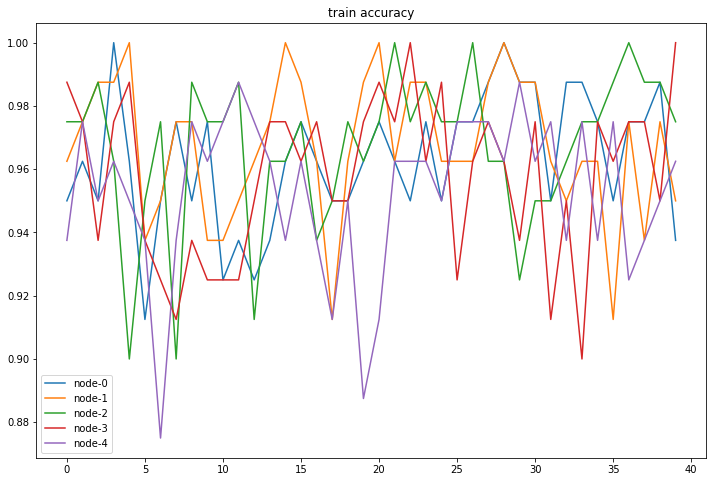

In [6]:
plt.figure(0,(12,8))
plt.title("train accuracy")
for i in range(n_learners):
    plt.plot(train_acc[i], label="node-{}".format(i))
plt.legend()

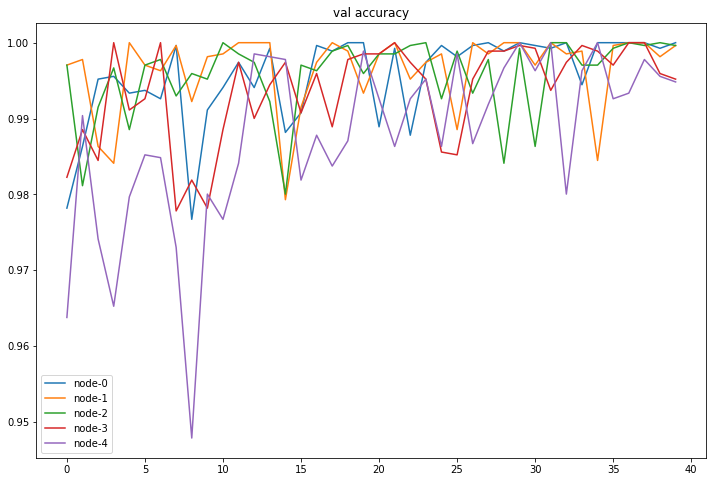

In [7]:
plt.figure(0,(12,8))
plt.title("val accuracy")
for i in range(n_learners):
    plt.plot(val_acc[i], label="node-{}".format(i))
plt.legend()

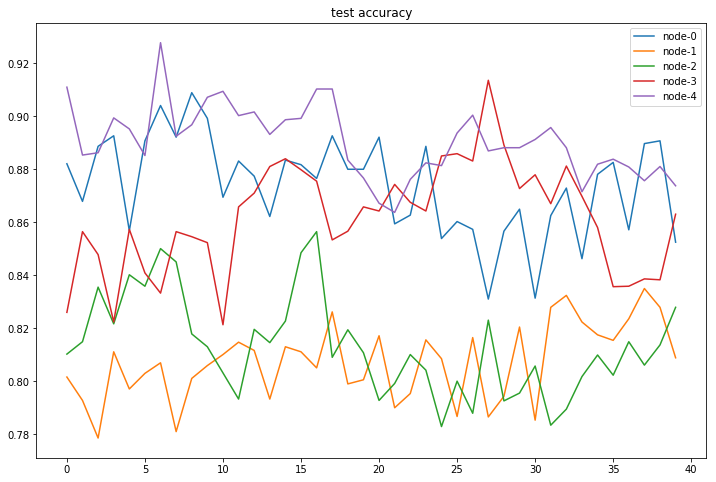

In [8]:
plt.figure(0,(12,8))
plt.title("test accuracy")
for i in range(n_learners):
    plt.plot(test_acc[i], label="node-{}".format(i))
plt.legend()

In [ ]:
learners[0].config.evaluation_config

In [9]:
l=30

In [10]:
tt = []
for i in range(n_learners):
    tt.append(np.array(test_acc[i]).reshape(1,len(test_acc[i])))
acc=np.concatenate(tt, axis=0)

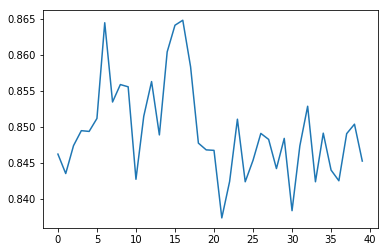

In [11]:
plt.plot(np.average(acc, axis=0))

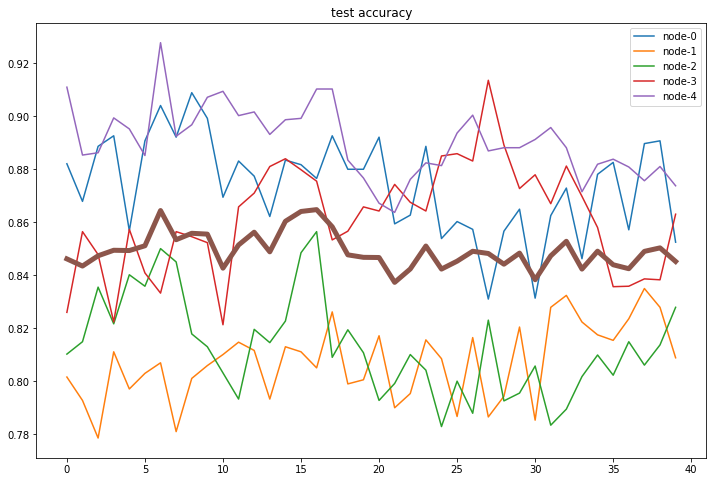

In [12]:
plt.figure(0,(12,8))
plt.title("test accuracy")
for i in range(n_learners):
    plt.plot(test_acc[i], label="node-{}".format(i))
plt.plot(np.average(acc, axis=0),lw=5)
plt.legend()

In [22]:
lines=[]
with open("/Users/qati/Downloads/grafana_data_export(3).csv", "r") as f:
    reader=csv.reader(f)
    for r in reader:
        lines.append(r)

In [23]:
nodes={}

In [24]:
for l in lines[1:]:
    s = l[0].split(";")
    if s[2]=="null":
        continue
    nodes.setdefault(s[0],[]).append(s[2])

In [25]:
tc=[]
for _, v in nodes.items():
    a=np.array(list(map(lambda x: float(x), v)))
    tc.append(a)
    print(a.shape)

(369,)
(395,)
(387,)
(389,)
(384,)


In [28]:
tc2=[]
for a in tc:
    tc2.append(a[(a.shape[0]-350):].reshape((1,350)))
cdata = np.concatenate(tc2, axis=0)

In [29]:
n_learners=5

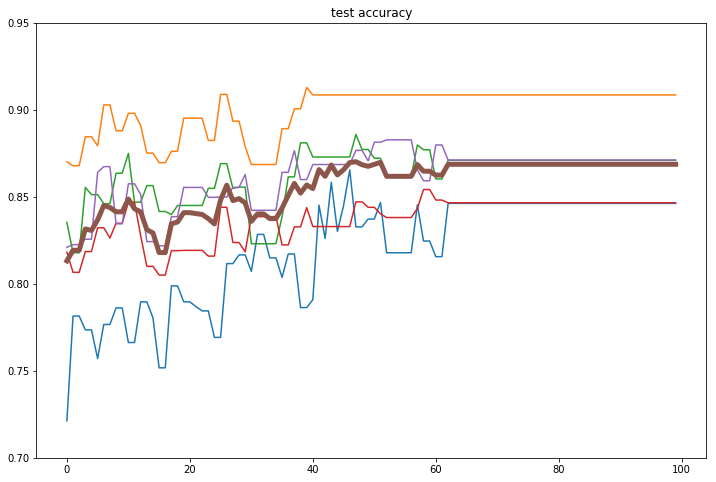

In [34]:
plt.figure(0,(12,8))
plt.title("test accuracy")
plt.ylim(0.7, 0.95)
for i in range(n_learners):
    plt.plot(cdata[i,:100], label="node-{}".format(i))
plt.plot(np.average(cdata, axis=0)[:100],lw=5)